# S-N-VAE Model Testing Framework

In [1]:
# Parameters cell for papermill
# This cell will be tagged as "parameters" to allow papermill to inject parameter values
# Default seed value - can be overridden by papermill execution
seed = 0

In [2]:
# Parameters
seed = 6


In [3]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /workspace/Disentanglement-Project-V2


# Hyperparameters

In [4]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed': seed,  # Use parameterized seed value
    'use_cuda_det': True,
    'enforce_det':False,
    'cublas_workspace_config': None,
}

##### Model parameters #####
model_name = 's_n_vae_locatello'  # S-N-VAE model with Locatello architecture
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder

# Define latent factor topologies: mix of Normal (R1) and Power Spherical (S1)
latent_factor_topologies = ['S1', 'R1', 'R1']  # 3 factors total

use_torch_compile = True  # Use torch.compile for model compilation

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 300

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
loss_name = 'beta_s_n_vae'      # S-N-VAE Beta loss
loss_kwargs_dsprites = {
    'beta': 13,
    'latent_factor_topologies': latent_factor_topologies,
    'rec_dist': 'bernoulli',  # Reconstruction distribution
    'log_kl_components': True,
#     'schedulers_kwargs':[
#     {
#         'name': 'linear',
#         'kwargs': {
#             'param_name': 'beta',
#             'initial_value': 0,
#             'final_value': 16,
#             'total_steps': 100000
#         }
#     }
# ]
}

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps = 2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/tests_s_n_vae'

chkpt_save_master_dir = None
chkpt_viz = False

Using GPU


# Reproducibility

In [5]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 6, 'use_cuda_det': True, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [6]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## Setup Model, Loss, and Optimizer

In [7]:
def setup_components(dataset, loss_kwargs, latent_factor_topologies):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    
    # Instantiate S-N-VAE Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_factor_topologies=latent_factor_topologies,
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    # Instantiate S-N-VAE Loss
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Latent factor topologies: {latent_factor_topologies}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Learning rate: {learning_rate}")

    return model, loss_fn, optimizer

# dSprites

In [8]:
# Load dSprites
Dsprites = get_dataset('dsprites')

# dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
dsprites_dataset = Dsprites(selected_factors=['posX', 'posY', 'orientation'], not_selected_factors_index_value={'scale':5, 'shape':0, 'color':0})

# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=seed,  # Use parameterized seed value
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 40960 samples.


## Train

In [9]:
print("\n===== Training S-N-VAE on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, 
                                                                        loss_kwargs_dsprites,
                                                                        latent_factor_topologies
                                                                        )
trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                      loss=loss_fn_dsprites,
                                      optimizer=optimizer_dsprites,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )

trainer_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)


===== Training S-N-VAE on dSprites =====
--- Setup for DSprites --- 
Model: s_n_vae_locatello
Latent factor topologies: ['S1', 'R1', 'R1']
Loss: beta_s_n_vae (rec_dist=bernoulli), kwargs={'beta': 13, 'latent_factor_topologies': ['S1', 'R1', 'R1'], 'rec_dist': 'bernoulli', 'log_kl_components': True}
Optimizer: Adam
Learning rate: 0.0001


Training for 192000 iter, 300.00 epochs:   0%|                                             | 0/192000 [00:00<?, ?it/s]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 1/192000 [00:01<85:13:58,  1.60s/it]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 2/192000 [00:01<42:22:04,  1.26it/s]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 39/192000 [00:01<1:27:46, 36.45it/s]

Training for 192000 iter, 300.00 epochs:   0%| | 39/192000 [00:01<1:27:46, 36.45it/s, epoch=0.08/300.00, iter=50/19200

Training for 192000 iter, 300.00 epochs:   0%| | 75/192000 [00:02<42:35, 75.09it/s, epoch=0.08/300.00, iter=50/192000,

Training for 192000 iter, 300.00 epochs:   0%| | 75/192000 [00:02<42:35, 75.09it/s, epoch=0.16/300.00, iter=100/192000

Training for 192000 iter, 300.00 epochs:   0%| | 112/192000 [00:02<27:04, 118.10it/s, epoch=0.16/300.00, iter=100/1920

Training for 192000 iter, 300.00 epochs:   0%| | 112/192000 [00:02<27:04, 118.10it/s, epoch=0.23/300.00, iter=150/1920

Training for 192000 iter, 300.00 epochs:   0%| | 151/192000 [00:02<19:25, 164.58it/s, epoch=0.23/300.00, iter=150/1920

Training for 192000 iter, 300.00 epochs:   0%| | 188/192000 [00:02<15:38, 204.44it/s, epoch=0.23/300.00, iter=150/1920

Training for 192000 iter, 300.00 epochs:   0%| | 188/192000 [00:02<15:38, 204.44it/s, epoch=0.31/300.00, iter=200/1920

Training for 192000 iter, 300.00 epochs:   0%| | 222/192000 [00:02<13:52, 230.45it/s, epoch=0.31/300.00, iter=200/1920

Training for 192000 iter, 300.00 epochs:   0%| | 222/192000 [00:02<13:52, 230.45it/s, epoch=0.39/300.00, iter=250/1920

Training for 192000 iter, 300.00 epochs:   0%| | 261/192000 [00:02<11:56, 267.78it/s, epoch=0.39/300.00, iter=250/1920

Training for 192000 iter, 300.00 epochs:   0%| | 261/192000 [00:02<11:56, 267.78it/s, epoch=0.47/300.00, iter=300/1920

Training for 192000 iter, 300.00 epochs:   0%| | 301/192000 [00:02<10:40, 299.21it/s, epoch=0.47/300.00, iter=300/1920

Training for 192000 iter, 300.00 epochs:   0%| | 340/192000 [00:02<09:54, 322.29it/s, epoch=0.47/300.00, iter=300/1920

Training for 192000 iter, 300.00 epochs:   0%| | 340/192000 [00:02<09:54, 322.29it/s, epoch=0.55/300.00, iter=350/1920

Training for 192000 iter, 300.00 epochs:   0%| | 378/192000 [00:02<09:29, 336.51it/s, epoch=0.55/300.00, iter=350/1920

Training for 192000 iter, 300.00 epochs:   0%| | 378/192000 [00:02<09:29, 336.51it/s, epoch=0.62/300.00, iter=400/1920

Training for 192000 iter, 300.00 epochs:   0%| | 417/192000 [00:02<09:05, 351.26it/s, epoch=0.62/300.00, iter=400/1920

Training for 192000 iter, 300.00 epochs:   0%| | 417/192000 [00:03<09:05, 351.26it/s, epoch=0.70/300.00, iter=450/1920

Training for 192000 iter, 300.00 epochs:   0%| | 455/192000 [00:03<10:07, 315.11it/s, epoch=0.70/300.00, iter=450/1920

Training for 192000 iter, 300.00 epochs:   0%| | 492/192000 [00:03<09:42, 328.67it/s, epoch=0.70/300.00, iter=450/1920

Training for 192000 iter, 300.00 epochs:   0%| | 492/192000 [00:03<09:42, 328.67it/s, epoch=0.78/300.00, iter=500/1920

Training for 192000 iter, 300.00 epochs:   0%| | 529/192000 [00:03<09:24, 339.02it/s, epoch=0.78/300.00, iter=500/1920

Training for 192000 iter, 300.00 epochs:   0%| | 529/192000 [00:03<09:24, 339.02it/s, epoch=0.86/300.00, iter=550/1920

Training for 192000 iter, 300.00 epochs:   0%| | 568/192000 [00:03<09:02, 352.84it/s, epoch=0.86/300.00, iter=550/1920

Training for 192000 iter, 300.00 epochs:   0%| | 568/192000 [00:03<09:02, 352.84it/s, epoch=0.94/300.00, iter=600/1920

Training for 192000 iter, 300.00 epochs:   0%| | 607/192000 [00:03<08:47, 363.09it/s, epoch=0.94/300.00, iter=600/1920

Training for 192000 iter, 300.00 epochs:   0%| | 645/192000 [00:03<08:44, 364.97it/s, epoch=0.94/300.00, iter=600/1920

Training for 192000 iter, 300.00 epochs:   0%| | 645/192000 [00:03<08:44, 364.97it/s, epoch=1.02/300.00, iter=650/1920

Training for 192000 iter, 300.00 epochs:   0%| | 683/192000 [00:03<08:48, 361.91it/s, epoch=1.02/300.00, iter=650/1920

Training for 192000 iter, 300.00 epochs:   0%| | 683/192000 [00:03<08:48, 361.91it/s, epoch=1.09/300.00, iter=700/1920

Training for 192000 iter, 300.00 epochs:   0%| | 720/192000 [00:03<09:05, 350.51it/s, epoch=1.09/300.00, iter=700/1920

Training for 192000 iter, 300.00 epochs:   0%| | 720/192000 [00:03<09:05, 350.51it/s, epoch=1.17/300.00, iter=750/1920

Training for 192000 iter, 300.00 epochs:   0%| | 760/192000 [00:03<08:44, 364.39it/s, epoch=1.17/300.00, iter=750/1920

Training for 192000 iter, 300.00 epochs:   0%| | 797/192000 [00:04<08:43, 365.34it/s, epoch=1.17/300.00, iter=750/1920

Training for 192000 iter, 300.00 epochs:   0%| | 797/192000 [00:04<08:43, 365.34it/s, epoch=1.25/300.00, iter=800/1920

Training for 192000 iter, 300.00 epochs:   0%| | 834/192000 [00:04<08:45, 363.57it/s, epoch=1.25/300.00, iter=800/1920

Training for 192000 iter, 300.00 epochs:   0%| | 834/192000 [00:04<08:45, 363.57it/s, epoch=1.33/300.00, iter=850/1920

Training for 192000 iter, 300.00 epochs:   0%| | 873/192000 [00:04<08:37, 369.29it/s, epoch=1.33/300.00, iter=850/1920

Training for 192000 iter, 300.00 epochs:   0%| | 873/192000 [00:04<08:37, 369.29it/s, epoch=1.41/300.00, iter=900/1920

Training for 192000 iter, 300.00 epochs:   0%| | 911/192000 [00:04<09:57, 319.70it/s, epoch=1.41/300.00, iter=900/1920

Training for 192000 iter, 300.00 epochs:   0%| | 945/192000 [00:04<09:55, 320.81it/s, epoch=1.41/300.00, iter=900/1920

Training for 192000 iter, 300.00 epochs:   0%| | 945/192000 [00:04<09:55, 320.81it/s, epoch=1.48/300.00, iter=950/1920

Training for 192000 iter, 300.00 epochs:   1%| | 983/192000 [00:04<09:28, 336.01it/s, epoch=1.48/300.00, iter=950/1920

Training for 192000 iter, 300.00 epochs:   1%| | 983/192000 [00:04<09:28, 336.01it/s, epoch=1.56/300.00, iter=1000/192

Training for 192000 iter, 300.00 epochs:   1%| | 1022/192000 [00:04<09:06, 349.27it/s, epoch=1.56/300.00, iter=1000/19

Training for 192000 iter, 300.00 epochs:   1%| | 1022/192000 [00:04<09:06, 349.27it/s, epoch=1.64/300.00, iter=1050/19

Training for 192000 iter, 300.00 epochs:   1%| | 1061/192000 [00:04<08:53, 358.16it/s, epoch=1.64/300.00, iter=1050/19

Training for 192000 iter, 300.00 epochs:   1%| | 1061/192000 [00:04<08:53, 358.16it/s, epoch=1.72/300.00, iter=1100/19

Training for 192000 iter, 300.00 epochs:   1%| | 1101/192000 [00:04<08:37, 368.63it/s, epoch=1.72/300.00, iter=1100/19

Training for 192000 iter, 300.00 epochs:   1%| | 1141/192000 [00:05<08:26, 376.48it/s, epoch=1.72/300.00, iter=1100/19

Training for 192000 iter, 300.00 epochs:   1%| | 1141/192000 [00:05<08:26, 376.48it/s, epoch=1.80/300.00, iter=1150/19

Training for 192000 iter, 300.00 epochs:   1%| | 1179/192000 [00:05<08:33, 371.68it/s, epoch=1.80/300.00, iter=1150/19

Training for 192000 iter, 300.00 epochs:   1%| | 1179/192000 [00:05<08:33, 371.68it/s, epoch=1.88/300.00, iter=1200/19

Training for 192000 iter, 300.00 epochs:   1%| | 1217/192000 [00:05<08:42, 364.83it/s, epoch=1.88/300.00, iter=1200/19

Training for 192000 iter, 300.00 epochs:   1%| | 1217/192000 [00:05<08:42, 364.83it/s, epoch=1.95/300.00, iter=1250/19

Training for 192000 iter, 300.00 epochs:   1%| | 1254/192000 [00:05<09:09, 347.09it/s, epoch=1.95/300.00, iter=1250/19

Training for 192000 iter, 300.00 epochs:   1%| | 1289/192000 [00:05<09:52, 322.11it/s, epoch=1.95/300.00, iter=1250/19

Training for 192000 iter, 300.00 epochs:   1%| | 1289/192000 [00:05<09:52, 322.11it/s, epoch=2.03/300.00, iter=1300/19

Training for 192000 iter, 300.00 epochs:   1%| | 1325/192000 [00:05<09:37, 330.36it/s, epoch=2.03/300.00, iter=1300/19

Training for 192000 iter, 300.00 epochs:   1%| | 1325/192000 [00:05<09:37, 330.36it/s, epoch=2.11/300.00, iter=1350/19

Training for 192000 iter, 300.00 epochs:   1%| | 1366/192000 [00:05<09:02, 351.36it/s, epoch=2.11/300.00, iter=1350/19

Training for 192000 iter, 300.00 epochs:   1%| | 1366/192000 [00:05<09:02, 351.36it/s, epoch=2.19/300.00, iter=1400/19

Training for 192000 iter, 300.00 epochs:   1%| | 1407/192000 [00:05<08:41, 365.49it/s, epoch=2.19/300.00, iter=1400/19

Training for 192000 iter, 300.00 epochs:   1%| | 1446/192000 [00:05<08:33, 370.86it/s, epoch=2.19/300.00, iter=1400/19

Training for 192000 iter, 300.00 epochs:   1%| | 1446/192000 [00:05<08:33, 370.86it/s, epoch=2.27/300.00, iter=1450/19

Training for 192000 iter, 300.00 epochs:   1%| | 1486/192000 [00:05<08:25, 377.07it/s, epoch=2.27/300.00, iter=1450/19

Training for 192000 iter, 300.00 epochs:   1%| | 1486/192000 [00:06<08:25, 377.07it/s, epoch=2.34/300.00, iter=1500/19

Training for 192000 iter, 300.00 epochs:   1%| | 1524/192000 [00:06<08:38, 367.45it/s, epoch=2.34/300.00, iter=1500/19

Training for 192000 iter, 300.00 epochs:   1%| | 1524/192000 [00:06<08:38, 367.45it/s, epoch=2.42/300.00, iter=1550/19

Training for 192000 iter, 300.00 epochs:   1%| | 1562/192000 [00:06<08:34, 370.17it/s, epoch=2.42/300.00, iter=1550/19

Training for 192000 iter, 300.00 epochs:   1%| | 1562/192000 [00:06<08:34, 370.17it/s, epoch=2.50/300.00, iter=1600/19

Training for 192000 iter, 300.00 epochs:   1%| | 1600/192000 [00:06<08:34, 370.42it/s, epoch=2.50/300.00, iter=1600/19

Training for 192000 iter, 300.00 epochs:   1%| | 1638/192000 [00:06<08:43, 363.47it/s, epoch=2.50/300.00, iter=1600/19

Training for 192000 iter, 300.00 epochs:   1%| | 1638/192000 [00:06<08:43, 363.47it/s, epoch=2.58/300.00, iter=1650/19

Training for 192000 iter, 300.00 epochs:   1%| | 1675/192000 [00:06<09:18, 341.00it/s, epoch=2.58/300.00, iter=1650/19

Training for 192000 iter, 300.00 epochs:   1%| | 1675/192000 [00:06<09:18, 341.00it/s, epoch=2.66/300.00, iter=1700/19

Training for 192000 iter, 300.00 epochs:   1%| | 1714/192000 [00:06<08:59, 352.61it/s, epoch=2.66/300.00, iter=1700/19

Training for 192000 iter, 300.00 epochs:   1%| | 1714/192000 [00:06<08:59, 352.61it/s, epoch=2.73/300.00, iter=1750/19

Training for 192000 iter, 300.00 epochs:   1%| | 1755/192000 [00:06<08:37, 367.40it/s, epoch=2.73/300.00, iter=1750/19

Training for 192000 iter, 300.00 epochs:   1%| | 1795/192000 [00:06<08:28, 374.34it/s, epoch=2.73/300.00, iter=1750/19

Training for 192000 iter, 300.00 epochs:   1%| | 1795/192000 [00:06<08:28, 374.34it/s, epoch=2.81/300.00, iter=1800/19

Training for 192000 iter, 300.00 epochs:   1%| | 1836/192000 [00:06<08:17, 382.40it/s, epoch=2.81/300.00, iter=1800/19

Training for 192000 iter, 300.00 epochs:   1%| | 1836/192000 [00:06<08:17, 382.40it/s, epoch=2.89/300.00, iter=1850/19

Training for 192000 iter, 300.00 epochs:   1%| | 1877/192000 [00:07<08:08, 388.91it/s, epoch=2.89/300.00, iter=1850/19

Training for 192000 iter, 300.00 epochs:   1%| | 1877/192000 [00:07<08:08, 388.91it/s, epoch=2.97/300.00, iter=1900/19

Training for 192000 iter, 300.00 epochs:   1%| | 1917/192000 [00:07<08:05, 391.28it/s, epoch=2.97/300.00, iter=1900/19

Training for 192000 iter, 300.00 epochs:   1%| | 1917/192000 [00:07<08:05, 391.28it/s, epoch=3.05/300.00, iter=1950/19

Training for 192000 iter, 300.00 epochs:   1%| | 1957/192000 [00:07<08:30, 372.41it/s, epoch=3.05/300.00, iter=1950/19

Training for 192000 iter, 300.00 epochs:   1%| | 1995/192000 [00:07<08:42, 363.48it/s, epoch=3.05/300.00, iter=1950/19

Training for 192000 iter, 300.00 epochs:   1%| | 1995/192000 [00:07<08:42, 363.48it/s, epoch=3.12/300.00, iter=2000/19

Training for 192000 iter, 300.00 epochs:   1%| | 2032/192000 [00:07<08:40, 365.08it/s, epoch=3.12/300.00, iter=2000/19

Training for 192000 iter, 300.00 epochs:   1%| | 2032/192000 [00:07<08:40, 365.08it/s, epoch=3.20/300.00, iter=2050/19

Training for 192000 iter, 300.00 epochs:   1%| | 2069/192000 [00:07<08:43, 362.71it/s, epoch=3.20/300.00, iter=2050/19

Training for 192000 iter, 300.00 epochs:   1%| | 2069/192000 [00:07<08:43, 362.71it/s, epoch=3.28/300.00, iter=2100/19

Training for 192000 iter, 300.00 epochs:   1%| | 2109/192000 [00:07<08:30, 372.26it/s, epoch=3.28/300.00, iter=2100/19

Training for 192000 iter, 300.00 epochs:   1%| | 2109/192000 [00:07<08:30, 372.26it/s, epoch=3.36/300.00, iter=2150/19

Training for 192000 iter, 300.00 epochs:   1%| | 2150/192000 [00:07<08:18, 380.63it/s, epoch=3.36/300.00, iter=2150/19

Training for 192000 iter, 300.00 epochs:   1%| | 2189/192000 [00:07<08:23, 377.03it/s, epoch=3.36/300.00, iter=2150/19

Training for 192000 iter, 300.00 epochs:   1%| | 2189/192000 [00:07<08:23, 377.03it/s, epoch=3.44/300.00, iter=2200/19

Training for 192000 iter, 300.00 epochs:   1%| | 2229/192000 [00:07<08:16, 382.55it/s, epoch=3.44/300.00, iter=2200/19

Training for 192000 iter, 300.00 epochs:   1%| | 2229/192000 [00:08<08:16, 382.55it/s, epoch=3.52/300.00, iter=2250/19

Training for 192000 iter, 300.00 epochs:   1%| | 2270/192000 [00:08<08:08, 388.65it/s, epoch=3.52/300.00, iter=2250/19

Training for 192000 iter, 300.00 epochs:   1%| | 2270/192000 [00:08<08:08, 388.65it/s, epoch=3.59/300.00, iter=2300/19

Training for 192000 iter, 300.00 epochs:   1%| | 2310/192000 [00:08<08:06, 390.01it/s, epoch=3.59/300.00, iter=2300/19

Training for 192000 iter, 300.00 epochs:   1%| | 2310/192000 [00:08<08:06, 390.01it/s, epoch=3.67/300.00, iter=2350/19

Training for 192000 iter, 300.00 epochs:   1%| | 2350/192000 [00:08<08:10, 386.84it/s, epoch=3.67/300.00, iter=2350/19

Training for 192000 iter, 300.00 epochs:   1%| | 2389/192000 [00:08<08:38, 365.39it/s, epoch=3.67/300.00, iter=2350/19

Training for 192000 iter, 300.00 epochs:   1%| | 2389/192000 [00:08<08:38, 365.39it/s, epoch=3.75/300.00, iter=2400/19

Training for 192000 iter, 300.00 epochs:   1%| | 2427/192000 [00:08<08:33, 369.34it/s, epoch=3.75/300.00, iter=2400/19

Training for 192000 iter, 300.00 epochs:   1%| | 2427/192000 [00:08<08:33, 369.34it/s, epoch=3.83/300.00, iter=2450/19

Training for 192000 iter, 300.00 epochs:   1%| | 2465/192000 [00:08<08:34, 368.35it/s, epoch=3.83/300.00, iter=2450/19

Training for 192000 iter, 300.00 epochs:   1%| | 2465/192000 [00:08<08:34, 368.35it/s, epoch=3.91/300.00, iter=2500/19

Training for 192000 iter, 300.00 epochs:   1%| | 2505/192000 [00:08<08:23, 376.22it/s, epoch=3.91/300.00, iter=2500/19

Training for 192000 iter, 300.00 epochs:   1%| | 2546/192000 [00:08<08:14, 383.50it/s, epoch=3.91/300.00, iter=2500/19

Training for 192000 iter, 300.00 epochs:   1%| | 2546/192000 [00:08<08:14, 383.50it/s, epoch=3.98/300.00, iter=2550/19

Training for 192000 iter, 300.00 epochs:   1%| | 2585/192000 [00:08<08:53, 355.06it/s, epoch=3.98/300.00, iter=2550/19

Training for 192000 iter, 300.00 epochs:   1%| | 2585/192000 [00:08<08:53, 355.06it/s, epoch=4.06/300.00, iter=2600/19

Training for 192000 iter, 300.00 epochs:   1%| | 2621/192000 [00:09<09:07, 345.93it/s, epoch=4.06/300.00, iter=2600/19

Training for 192000 iter, 300.00 epochs:   1%| | 2621/192000 [00:09<09:07, 345.93it/s, epoch=4.14/300.00, iter=2650/19

Training for 192000 iter, 300.00 epochs:   1%| | 2656/192000 [00:09<09:09, 344.86it/s, epoch=4.14/300.00, iter=2650/19

Training for 192000 iter, 300.00 epochs:   1%| | 2697/192000 [00:09<08:42, 362.17it/s, epoch=4.14/300.00, iter=2650/19

Training for 192000 iter, 300.00 epochs:   1%| | 2697/192000 [00:09<08:42, 362.17it/s, epoch=4.22/300.00, iter=2700/19

Training for 192000 iter, 300.00 epochs:   1%| | 2734/192000 [00:09<08:47, 359.13it/s, epoch=4.22/300.00, iter=2700/19

Training for 192000 iter, 300.00 epochs:   1%| | 2734/192000 [00:09<08:47, 359.13it/s, epoch=4.30/300.00, iter=2750/19

Training for 192000 iter, 300.00 epochs:   1%| | 2771/192000 [00:09<08:59, 350.74it/s, epoch=4.30/300.00, iter=2750/19

Training for 192000 iter, 300.00 epochs:   1%| | 2771/192000 [00:09<08:59, 350.74it/s, epoch=4.38/300.00, iter=2800/19

Training for 192000 iter, 300.00 epochs:   1%| | 2807/192000 [00:09<09:59, 315.59it/s, epoch=4.38/300.00, iter=2800/19

Training for 192000 iter, 300.00 epochs:   1%| | 2846/192000 [00:09<09:25, 334.75it/s, epoch=4.38/300.00, iter=2800/19

Training for 192000 iter, 300.00 epochs:   1%| | 2846/192000 [00:09<09:25, 334.75it/s, epoch=4.45/300.00, iter=2850/19

Training for 192000 iter, 300.00 epochs:   2%| | 2886/192000 [00:09<08:57, 351.52it/s, epoch=4.45/300.00, iter=2850/19

Training for 192000 iter, 300.00 epochs:   2%| | 2886/192000 [00:09<08:57, 351.52it/s, epoch=4.53/300.00, iter=2900/19

Training for 192000 iter, 300.00 epochs:   2%| | 2926/192000 [00:09<08:39, 364.17it/s, epoch=4.53/300.00, iter=2900/19

Training for 192000 iter, 300.00 epochs:   2%| | 2926/192000 [00:09<08:39, 364.17it/s, epoch=4.61/300.00, iter=2950/19

Training for 192000 iter, 300.00 epochs:   2%| | 2963/192000 [00:10<08:49, 356.75it/s, epoch=4.61/300.00, iter=2950/19

Training for 192000 iter, 300.00 epochs:   2%| | 2963/192000 [00:10<08:49, 356.75it/s, epoch=4.69/300.00, iter=3000/19

Training for 192000 iter, 300.00 epochs:   2%| | 3004/192000 [00:10<08:31, 369.69it/s, epoch=4.69/300.00, iter=3000/19

Training for 192000 iter, 300.00 epochs:   2%| | 3045/192000 [00:10<08:18, 378.96it/s, epoch=4.69/300.00, iter=3000/19

Training for 192000 iter, 300.00 epochs:   2%| | 3045/192000 [00:10<08:18, 378.96it/s, epoch=4.77/300.00, iter=3050/19

Training for 192000 iter, 300.00 epochs:   2%| | 3086/192000 [00:10<08:09, 386.00it/s, epoch=4.77/300.00, iter=3050/19

Training for 192000 iter, 300.00 epochs:   2%| | 3086/192000 [00:10<08:09, 386.00it/s, epoch=4.84/300.00, iter=3100/19

Training for 192000 iter, 300.00 epochs:   2%| | 3125/192000 [00:10<08:16, 380.37it/s, epoch=4.84/300.00, iter=3100/19

Training for 192000 iter, 300.00 epochs:   2%| | 3125/192000 [00:10<08:16, 380.37it/s, epoch=4.92/300.00, iter=3150/19

Training for 192000 iter, 300.00 epochs:   2%| | 3164/192000 [00:10<08:24, 374.17it/s, epoch=4.92/300.00, iter=3150/19

Training for 192000 iter, 300.00 epochs:   2%| | 3164/192000 [00:10<08:24, 374.17it/s, epoch=5.00/300.00, iter=3200/19

Training for 192000 iter, 300.00 epochs:   2%| | 3202/192000 [00:10<08:32, 368.42it/s, epoch=5.00/300.00, iter=3200/19

Training for 192000 iter, 300.00 epochs:   2%| | 3242/192000 [00:10<08:22, 375.82it/s, epoch=5.00/300.00, iter=3200/19

Training for 192000 iter, 300.00 epochs:   2%| | 3242/192000 [00:10<08:22, 375.82it/s, epoch=5.08/300.00, iter=3250/19

Training for 192000 iter, 300.00 epochs:   2%| | 3282/192000 [00:10<08:13, 382.44it/s, epoch=5.08/300.00, iter=3250/19

Training for 192000 iter, 300.00 epochs:   2%| | 3282/192000 [00:10<08:13, 382.44it/s, epoch=5.16/300.00, iter=3300/19

Training for 192000 iter, 300.00 epochs:   2%| | 3323/192000 [00:10<08:05, 388.28it/s, epoch=5.16/300.00, iter=3300/19

Training for 192000 iter, 300.00 epochs:   2%| | 3323/192000 [00:11<08:05, 388.28it/s, epoch=5.23/300.00, iter=3350/19

Training for 192000 iter, 300.00 epochs:   2%| | 3364/192000 [00:11<08:01, 392.11it/s, epoch=5.23/300.00, iter=3350/19

Training for 192000 iter, 300.00 epochs:   2%| | 3364/192000 [00:11<08:01, 392.11it/s, epoch=5.31/300.00, iter=3400/19

Training for 192000 iter, 300.00 epochs:   2%| | 3404/192000 [00:11<07:58, 394.16it/s, epoch=5.31/300.00, iter=3400/19

Training for 192000 iter, 300.00 epochs:   2%| | 3444/192000 [00:11<08:00, 392.51it/s, epoch=5.31/300.00, iter=3400/19

Training for 192000 iter, 300.00 epochs:   2%| | 3444/192000 [00:11<08:00, 392.51it/s, epoch=5.39/300.00, iter=3450/19

Training for 192000 iter, 300.00 epochs:   2%| | 3484/192000 [00:11<07:58, 393.58it/s, epoch=5.39/300.00, iter=3450/19

Training for 192000 iter, 300.00 epochs:   2%| | 3484/192000 [00:11<07:58, 393.58it/s, epoch=5.47/300.00, iter=3500/19

Training for 192000 iter, 300.00 epochs:   2%| | 3525/192000 [00:11<07:56, 395.92it/s, epoch=5.47/300.00, iter=3500/19

Training for 192000 iter, 300.00 epochs:   2%| | 3525/192000 [00:11<07:56, 395.92it/s, epoch=5.55/300.00, iter=3550/19

Training for 192000 iter, 300.00 epochs:   2%| | 3566/192000 [00:11<07:52, 399.12it/s, epoch=5.55/300.00, iter=3550/19

Training for 192000 iter, 300.00 epochs:   2%| | 3566/192000 [00:11<07:52, 399.12it/s, epoch=5.62/300.00, iter=3600/19

Training for 192000 iter, 300.00 epochs:   2%| | 3606/192000 [00:11<07:56, 395.72it/s, epoch=5.62/300.00, iter=3600/19

Training for 192000 iter, 300.00 epochs:   2%| | 3646/192000 [00:11<09:25, 333.36it/s, epoch=5.62/300.00, iter=3600/19

Training for 192000 iter, 300.00 epochs:   2%| | 3646/192000 [00:11<09:25, 333.36it/s, epoch=5.70/300.00, iter=3650/19

Training for 192000 iter, 300.00 epochs:   2%| | 3682/192000 [00:11<09:23, 334.04it/s, epoch=5.70/300.00, iter=3650/19

Training for 192000 iter, 300.00 epochs:   2%| | 3682/192000 [00:11<09:23, 334.04it/s, epoch=5.78/300.00, iter=3700/19

Training for 192000 iter, 300.00 epochs:   2%| | 3723/192000 [00:12<08:54, 352.41it/s, epoch=5.78/300.00, iter=3700/19

Training for 192000 iter, 300.00 epochs:   2%| | 3723/192000 [00:12<08:54, 352.41it/s, epoch=5.86/300.00, iter=3750/19

Training for 192000 iter, 300.00 epochs:   2%| | 3764/192000 [00:12<08:32, 367.04it/s, epoch=5.86/300.00, iter=3750/19

Training for 192000 iter, 300.00 epochs:   2%| | 3764/192000 [00:12<08:32, 367.04it/s, epoch=5.94/300.00, iter=3800/19

Training for 192000 iter, 300.00 epochs:   2%| | 3805/192000 [00:12<08:16, 378.68it/s, epoch=5.94/300.00, iter=3800/19

Training for 192000 iter, 300.00 epochs:   2%| | 3844/192000 [00:12<08:20, 375.80it/s, epoch=5.94/300.00, iter=3800/19

Training for 192000 iter, 300.00 epochs:   2%| | 3844/192000 [00:12<08:20, 375.80it/s, epoch=6.02/300.00, iter=3850/19

Training for 192000 iter, 300.00 epochs:   2%| | 3883/192000 [00:12<08:19, 376.57it/s, epoch=6.02/300.00, iter=3850/19

Training for 192000 iter, 300.00 epochs:   2%| | 3883/192000 [00:12<08:19, 376.57it/s, epoch=6.09/300.00, iter=3900/19

Training for 192000 iter, 300.00 epochs:   2%| | 3922/192000 [00:12<08:14, 380.11it/s, epoch=6.09/300.00, iter=3900/19

Training for 192000 iter, 300.00 epochs:   2%| | 3922/192000 [00:12<08:14, 380.11it/s, epoch=6.17/300.00, iter=3950/19

Training for 192000 iter, 300.00 epochs:   2%| | 3961/192000 [00:12<08:11, 382.85it/s, epoch=6.17/300.00, iter=3950/19

Training for 192000 iter, 300.00 epochs:   2%| | 3961/192000 [00:12<08:11, 382.85it/s, epoch=6.25/300.00, iter=4000/19

Training for 192000 iter, 300.00 epochs:   2%| | 4000/192000 [00:12<08:28, 369.63it/s, epoch=6.25/300.00, iter=4000/19

Training for 192000 iter, 300.00 epochs:   2%| | 4038/192000 [00:12<08:26, 371.23it/s, epoch=6.25/300.00, iter=4000/19

Training for 192000 iter, 300.00 epochs:   2%| | 4038/192000 [00:12<08:26, 371.23it/s, epoch=6.33/300.00, iter=4050/19

Training for 192000 iter, 300.00 epochs:   2%| | 4076/192000 [00:12<08:30, 368.04it/s, epoch=6.33/300.00, iter=4050/19

Training for 192000 iter, 300.00 epochs:   2%| | 4076/192000 [00:13<08:30, 368.04it/s, epoch=6.41/300.00, iter=4100/19

Training for 192000 iter, 300.00 epochs:   2%| | 4113/192000 [00:13<08:48, 355.37it/s, epoch=6.41/300.00, iter=4100/19

Training for 192000 iter, 300.00 epochs:   2%| | 4149/192000 [00:13<08:55, 350.69it/s, epoch=6.41/300.00, iter=4100/19

Training for 192000 iter, 300.00 epochs:   2%| | 4149/192000 [00:13<08:55, 350.69it/s, epoch=6.48/300.00, iter=4150/19

Training for 192000 iter, 300.00 epochs:   2%| | 4187/192000 [00:13<08:45, 357.34it/s, epoch=6.48/300.00, iter=4150/19

Training for 192000 iter, 300.00 epochs:   2%| | 4187/192000 [00:13<08:45, 357.34it/s, epoch=6.56/300.00, iter=4200/19

Training for 192000 iter, 300.00 epochs:   2%| | 4227/192000 [00:13<08:29, 368.22it/s, epoch=6.56/300.00, iter=4200/19

Training for 192000 iter, 300.00 epochs:   2%| | 4227/192000 [00:13<08:29, 368.22it/s, epoch=6.64/300.00, iter=4250/19

Training for 192000 iter, 300.00 epochs:   2%| | 4267/192000 [00:13<08:19, 375.87it/s, epoch=6.64/300.00, iter=4250/19

Training for 192000 iter, 300.00 epochs:   2%| | 4267/192000 [00:13<08:19, 375.87it/s, epoch=6.72/300.00, iter=4300/19

Training for 192000 iter, 300.00 epochs:   2%| | 4305/192000 [00:13<08:21, 374.09it/s, epoch=6.72/300.00, iter=4300/19

Training for 192000 iter, 300.00 epochs:   2%| | 4345/192000 [00:13<08:13, 380.24it/s, epoch=6.72/300.00, iter=4300/19

Training for 192000 iter, 300.00 epochs:   2%| | 4345/192000 [00:13<08:13, 380.24it/s, epoch=6.80/300.00, iter=4350/19

Training for 192000 iter, 300.00 epochs:   2%| | 4384/192000 [00:13<08:21, 373.82it/s, epoch=6.80/300.00, iter=4350/19

Training for 192000 iter, 300.00 epochs:   2%| | 4384/192000 [00:13<08:21, 373.82it/s, epoch=6.88/300.00, iter=4400/19

Training for 192000 iter, 300.00 epochs:   2%| | 4424/192000 [00:13<08:14, 379.11it/s, epoch=6.88/300.00, iter=4400/19

Training for 192000 iter, 300.00 epochs:   2%| | 4424/192000 [00:13<08:14, 379.11it/s, epoch=6.95/300.00, iter=4450/19

Training for 192000 iter, 300.00 epochs:   2%| | 4465/192000 [00:14<08:06, 385.78it/s, epoch=6.95/300.00, iter=4450/19

Training for 192000 iter, 300.00 epochs:   2%| | 4465/192000 [00:14<08:06, 385.78it/s, epoch=7.03/300.00, iter=4500/19

Training for 192000 iter, 300.00 epochs:   2%| | 4504/192000 [00:14<08:40, 360.00it/s, epoch=7.03/300.00, iter=4500/19

Training for 192000 iter, 300.00 epochs:   2%| | 4541/192000 [00:14<08:43, 357.90it/s, epoch=7.03/300.00, iter=4500/19

Training for 192000 iter, 300.00 epochs:   2%| | 4541/192000 [00:14<08:43, 357.90it/s, epoch=7.11/300.00, iter=4550/19

Training for 192000 iter, 300.00 epochs:   2%| | 4581/192000 [00:14<08:26, 369.76it/s, epoch=7.11/300.00, iter=4550/19

Training for 192000 iter, 300.00 epochs:   2%| | 4581/192000 [00:14<08:26, 369.76it/s, epoch=7.19/300.00, iter=4600/19

Training for 192000 iter, 300.00 epochs:   2%| | 4619/192000 [00:14<08:23, 372.11it/s, epoch=7.19/300.00, iter=4600/19

Training for 192000 iter, 300.00 epochs:   2%| | 4619/192000 [00:14<08:23, 372.11it/s, epoch=7.27/300.00, iter=4650/19

Training for 192000 iter, 300.00 epochs:   2%| | 4659/192000 [00:14<08:15, 377.92it/s, epoch=7.27/300.00, iter=4650/19

Training for 192000 iter, 300.00 epochs:   2%| | 4697/192000 [00:14<08:17, 376.73it/s, epoch=7.27/300.00, iter=4650/19

Training for 192000 iter, 300.00 epochs:   2%| | 4697/192000 [00:14<08:17, 376.73it/s, epoch=7.34/300.00, iter=4700/19

Training for 192000 iter, 300.00 epochs:   2%| | 4736/192000 [00:14<08:12, 380.44it/s, epoch=7.34/300.00, iter=4700/19

Training for 192000 iter, 300.00 epochs:   2%| | 4736/192000 [00:14<08:12, 380.44it/s, epoch=7.42/300.00, iter=4750/19

Training for 192000 iter, 300.00 epochs:   2%| | 4777/192000 [00:14<08:02, 387.82it/s, epoch=7.42/300.00, iter=4750/19

Training for 192000 iter, 300.00 epochs:   2%| | 4777/192000 [00:14<08:02, 387.82it/s, epoch=7.50/300.00, iter=4800/19

Training for 192000 iter, 300.00 epochs:   3%| | 4817/192000 [00:14<07:59, 390.70it/s, epoch=7.50/300.00, iter=4800/19

Training for 192000 iter, 300.00 epochs:   3%| | 4817/192000 [00:15<07:59, 390.70it/s, epoch=7.58/300.00, iter=4850/19

Training for 192000 iter, 300.00 epochs:   3%| | 4857/192000 [00:15<07:57, 391.94it/s, epoch=7.58/300.00, iter=4850/19

Training for 192000 iter, 300.00 epochs:   3%| | 4897/192000 [00:15<07:55, 393.12it/s, epoch=7.58/300.00, iter=4850/19

Training for 192000 iter, 300.00 epochs:   3%| | 4897/192000 [00:15<07:55, 393.12it/s, epoch=7.66/300.00, iter=4900/19

Training for 192000 iter, 300.00 epochs:   3%| | 4937/192000 [00:15<07:54, 394.37it/s, epoch=7.66/300.00, iter=4900/19

Training for 192000 iter, 300.00 epochs:   3%| | 4937/192000 [00:15<07:54, 394.37it/s, epoch=7.73/300.00, iter=4950/19

Training for 192000 iter, 300.00 epochs:   3%| | 4977/192000 [00:15<07:54, 394.08it/s, epoch=7.73/300.00, iter=4950/19

Training for 192000 iter, 300.00 epochs:   3%| | 4977/192000 [00:15<07:54, 394.08it/s, epoch=7.81/300.00, iter=5000/19

Training for 192000 iter, 300.00 epochs:   3%| | 5018/192000 [00:15<07:52, 395.90it/s, epoch=7.81/300.00, iter=5000/19

Training for 192000 iter, 300.00 epochs:   3%| | 5018/192000 [00:15<07:52, 395.90it/s, epoch=7.89/300.00, iter=5050/19

Training for 192000 iter, 300.00 epochs:   3%| | 5058/192000 [00:15<07:51, 396.60it/s, epoch=7.89/300.00, iter=5050/19

Training for 192000 iter, 300.00 epochs:   3%| | 5099/192000 [00:15<07:49, 397.87it/s, epoch=7.89/300.00, iter=5050/19

Training for 192000 iter, 300.00 epochs:   3%| | 5099/192000 [00:15<07:49, 397.87it/s, epoch=7.97/300.00, iter=5100/19

Training for 192000 iter, 300.00 epochs:   3%| | 5139/192000 [00:15<08:06, 384.08it/s, epoch=7.97/300.00, iter=5100/19

Training for 192000 iter, 300.00 epochs:   3%| | 5139/192000 [00:15<08:06, 384.08it/s, epoch=8.05/300.00, iter=5150/19

Training for 192000 iter, 300.00 epochs:   3%| | 5179/192000 [00:15<08:02, 386.89it/s, epoch=8.05/300.00, iter=5150/19

Training for 192000 iter, 300.00 epochs:   3%| | 5179/192000 [00:15<08:02, 386.89it/s, epoch=8.12/300.00, iter=5200/19

Training for 192000 iter, 300.00 epochs:   3%| | 5219/192000 [00:15<08:00, 388.39it/s, epoch=8.12/300.00, iter=5200/19

Training for 192000 iter, 300.00 epochs:   3%| | 5219/192000 [00:16<08:00, 388.39it/s, epoch=8.20/300.00, iter=5250/19

Training for 192000 iter, 300.00 epochs:   3%| | 5258/192000 [00:16<08:02, 387.11it/s, epoch=8.20/300.00, iter=5250/19

Training for 192000 iter, 300.00 epochs:   3%| | 5297/192000 [00:16<08:25, 369.34it/s, epoch=8.20/300.00, iter=5250/19

Training for 192000 iter, 300.00 epochs:   3%| | 5297/192000 [00:16<08:25, 369.34it/s, epoch=8.28/300.00, iter=5300/19

Training for 192000 iter, 300.00 epochs:   3%| | 5335/192000 [00:16<08:46, 354.61it/s, epoch=8.28/300.00, iter=5300/19

Training for 192000 iter, 300.00 epochs:   3%| | 5335/192000 [00:16<08:46, 354.61it/s, epoch=8.36/300.00, iter=5350/19

Training for 192000 iter, 300.00 epochs:   3%| | 5371/192000 [00:16<09:00, 345.19it/s, epoch=8.36/300.00, iter=5350/19

Training for 192000 iter, 300.00 epochs:   3%| | 5371/192000 [00:16<09:00, 345.19it/s, epoch=8.44/300.00, iter=5400/19

Training for 192000 iter, 300.00 epochs:   3%| | 5406/192000 [00:16<09:03, 343.13it/s, epoch=8.44/300.00, iter=5400/19

Training for 192000 iter, 300.00 epochs:   3%| | 5441/192000 [00:16<09:06, 341.08it/s, epoch=8.44/300.00, iter=5400/19

Training for 192000 iter, 300.00 epochs:   3%| | 5441/192000 [00:16<09:06, 341.08it/s, epoch=8.52/300.00, iter=5450/19

Training for 192000 iter, 300.00 epochs:   3%| | 5481/192000 [00:16<08:43, 356.48it/s, epoch=8.52/300.00, iter=5450/19

Training for 192000 iter, 300.00 epochs:   3%| | 5481/192000 [00:16<08:43, 356.48it/s, epoch=8.59/300.00, iter=5500/19

Training for 192000 iter, 300.00 epochs:   3%| | 5517/192000 [00:16<08:43, 356.15it/s, epoch=8.59/300.00, iter=5500/19

Training for 192000 iter, 300.00 epochs:   3%| | 5517/192000 [00:16<08:43, 356.15it/s, epoch=8.67/300.00, iter=5550/19

Training for 192000 iter, 300.00 epochs:   3%| | 5556/192000 [00:16<08:29, 365.85it/s, epoch=8.67/300.00, iter=5550/19

Training for 192000 iter, 300.00 epochs:   3%| | 5596/192000 [00:17<08:17, 374.89it/s, epoch=8.67/300.00, iter=5550/19

Training for 192000 iter, 300.00 epochs:   3%| | 5596/192000 [00:17<08:17, 374.89it/s, epoch=8.75/300.00, iter=5600/19

Training for 192000 iter, 300.00 epochs:   3%| | 5636/192000 [00:17<08:09, 381.07it/s, epoch=8.75/300.00, iter=5600/19

Training for 192000 iter, 300.00 epochs:   3%| | 5636/192000 [00:17<08:09, 381.07it/s, epoch=8.83/300.00, iter=5650/19

Training for 192000 iter, 300.00 epochs:   3%| | 5676/192000 [00:17<08:03, 385.29it/s, epoch=8.83/300.00, iter=5650/19

Training for 192000 iter, 300.00 epochs:   3%| | 5676/192000 [00:17<08:03, 385.29it/s, epoch=8.91/300.00, iter=5700/19

Training for 192000 iter, 300.00 epochs:   3%| | 5716/192000 [00:17<07:59, 388.83it/s, epoch=8.91/300.00, iter=5700/19

Training for 192000 iter, 300.00 epochs:   3%| | 5716/192000 [00:17<07:59, 388.83it/s, epoch=8.98/300.00, iter=5750/19

Training for 192000 iter, 300.00 epochs:   3%| | 5757/192000 [00:17<07:54, 392.76it/s, epoch=8.98/300.00, iter=5750/19

Training for 192000 iter, 300.00 epochs:   3%| | 5797/192000 [00:17<08:11, 378.87it/s, epoch=8.98/300.00, iter=5750/19

Training for 192000 iter, 300.00 epochs:   3%| | 5797/192000 [00:17<08:11, 378.87it/s, epoch=9.06/300.00, iter=5800/19

Training for 192000 iter, 300.00 epochs:   3%| | 5837/192000 [00:17<08:05, 383.33it/s, epoch=9.06/300.00, iter=5800/19

Training for 192000 iter, 300.00 epochs:   3%| | 5837/192000 [00:17<08:05, 383.33it/s, epoch=9.14/300.00, iter=5850/19

Training for 192000 iter, 300.00 epochs:   3%| | 5877/192000 [00:17<07:59, 387.90it/s, epoch=9.14/300.00, iter=5850/19

Training for 192000 iter, 300.00 epochs:   3%| | 5877/192000 [00:17<07:59, 387.90it/s, epoch=9.22/300.00, iter=5900/19

Training for 192000 iter, 300.00 epochs:   3%| | 5917/192000 [00:17<07:55, 391.00it/s, epoch=9.22/300.00, iter=5900/19

Training for 192000 iter, 300.00 epochs:   3%| | 5917/192000 [00:17<07:55, 391.00it/s, epoch=9.30/300.00, iter=5950/19

Training for 192000 iter, 300.00 epochs:   3%| | 5957/192000 [00:17<07:52, 393.47it/s, epoch=9.30/300.00, iter=5950/19

Training for 192000 iter, 300.00 epochs:   3%| | 5998/192000 [00:18<07:49, 395.86it/s, epoch=9.30/300.00, iter=5950/19

Training for 192000 iter, 300.00 epochs:   3%| | 5998/192000 [00:18<07:49, 395.86it/s, epoch=9.38/300.00, iter=6000/19

Training for 192000 iter, 300.00 epochs:   3%| | 6038/192000 [00:18<07:56, 390.07it/s, epoch=9.38/300.00, iter=6000/19

Training for 192000 iter, 300.00 epochs:   3%| | 6038/192000 [00:18<07:56, 390.07it/s, epoch=9.45/300.00, iter=6050/19

Training for 192000 iter, 300.00 epochs:   3%| | 6078/192000 [00:18<07:54, 391.57it/s, epoch=9.45/300.00, iter=6050/19

Training for 192000 iter, 300.00 epochs:   3%| | 6078/192000 [00:18<07:54, 391.57it/s, epoch=9.53/300.00, iter=6100/19

Training for 192000 iter, 300.00 epochs:   3%| | 6118/192000 [00:18<07:54, 391.76it/s, epoch=9.53/300.00, iter=6100/19

Training for 192000 iter, 300.00 epochs:   3%| | 6118/192000 [00:18<07:54, 391.76it/s, epoch=9.61/300.00, iter=6150/19

Training for 192000 iter, 300.00 epochs:   3%| | 6159/192000 [00:18<07:51, 394.35it/s, epoch=9.61/300.00, iter=6150/19

Training for 192000 iter, 300.00 epochs:   3%| | 6199/192000 [00:18<07:50, 394.75it/s, epoch=9.61/300.00, iter=6150/19

Training for 192000 iter, 300.00 epochs:   3%| | 6199/192000 [00:18<07:50, 394.75it/s, epoch=9.69/300.00, iter=6200/19

Training for 192000 iter, 300.00 epochs:   3%| | 6239/192000 [00:18<07:50, 394.65it/s, epoch=9.69/300.00, iter=6200/19

Training for 192000 iter, 300.00 epochs:   3%| | 6239/192000 [00:18<07:50, 394.65it/s, epoch=9.77/300.00, iter=6250/19

Training for 192000 iter, 300.00 epochs:   3%| | 6279/192000 [00:18<07:52, 393.38it/s, epoch=9.77/300.00, iter=6250/19

Training for 192000 iter, 300.00 epochs:   3%| | 6279/192000 [00:18<07:52, 393.38it/s, epoch=9.84/300.00, iter=6300/19

Training for 192000 iter, 300.00 epochs:   3%| | 6319/192000 [00:18<07:51, 394.06it/s, epoch=9.84/300.00, iter=6300/19

Training for 192000 iter, 300.00 epochs:   3%| | 6319/192000 [00:18<07:51, 394.06it/s, epoch=9.92/300.00, iter=6350/19

Training for 192000 iter, 300.00 epochs:   3%| | 6359/192000 [00:18<07:50, 394.21it/s, epoch=9.92/300.00, iter=6350/19

Training for 192000 iter, 300.00 epochs:   3%| | 6359/192000 [00:19<07:50, 394.21it/s, epoch=10.00/300.00, iter=6400/1

Training for 192000 iter, 300.00 epochs:   3%| | 6400/192000 [00:19<07:48, 396.40it/s, epoch=10.00/300.00, iter=6400/1

Training for 192000 iter, 300.00 epochs:   3%| | 6440/192000 [00:19<08:10, 378.63it/s, epoch=10.00/300.00, iter=6400/1

Training for 192000 iter, 300.00 epochs:   3%| | 6440/192000 [00:19<08:10, 378.63it/s, epoch=10.08/300.00, iter=6450/1

Training for 192000 iter, 300.00 epochs:   3%| | 6480/192000 [00:19<08:04, 382.52it/s, epoch=10.08/300.00, iter=6450/1

Training for 192000 iter, 300.00 epochs:   3%| | 6480/192000 [00:19<08:04, 382.52it/s, epoch=10.16/300.00, iter=6500/1

Training for 192000 iter, 300.00 epochs:   3%| | 6519/192000 [00:19<08:03, 383.46it/s, epoch=10.16/300.00, iter=6500/1

Training for 192000 iter, 300.00 epochs:   3%| | 6519/192000 [00:19<08:03, 383.46it/s, epoch=10.23/300.00, iter=6550/1

Training for 192000 iter, 300.00 epochs:   3%| | 6559/192000 [00:19<07:57, 388.12it/s, epoch=10.23/300.00, iter=6550/1

Training for 192000 iter, 300.00 epochs:   3%| | 6599/192000 [00:19<07:53, 391.46it/s, epoch=10.23/300.00, iter=6550/1

Training for 192000 iter, 300.00 epochs:   3%| | 6599/192000 [00:19<07:53, 391.46it/s, epoch=10.31/300.00, iter=6600/1

Training for 192000 iter, 300.00 epochs:   3%| | 6639/192000 [00:19<07:51, 392.90it/s, epoch=10.31/300.00, iter=6600/1

Training for 192000 iter, 300.00 epochs:   3%| | 6639/192000 [00:19<07:51, 392.90it/s, epoch=10.39/300.00, iter=6650/1

Training for 192000 iter, 300.00 epochs:   3%| | 6679/192000 [00:19<07:59, 386.78it/s, epoch=10.39/300.00, iter=6650/1

Training for 192000 iter, 300.00 epochs:   3%| | 6679/192000 [00:19<07:59, 386.78it/s, epoch=10.47/300.00, iter=6700/1

Training for 192000 iter, 300.00 epochs:   3%| | 6718/192000 [00:19<08:23, 368.12it/s, epoch=10.47/300.00, iter=6700/1

Training for 192000 iter, 300.00 epochs:   3%| | 6718/192000 [00:20<08:23, 368.12it/s, epoch=10.55/300.00, iter=6750/1

Training for 192000 iter, 300.00 epochs:   4%| | 6758/192000 [00:20<08:11, 376.75it/s, epoch=10.55/300.00, iter=6750/1

Training for 192000 iter, 300.00 epochs:   4%| | 6796/192000 [00:20<08:14, 374.31it/s, epoch=10.55/300.00, iter=6750/1

Training for 192000 iter, 300.00 epochs:   4%| | 6796/192000 [00:20<08:14, 374.31it/s, epoch=10.62/300.00, iter=6800/1

Training for 192000 iter, 300.00 epochs:   4%| | 6836/192000 [00:20<08:07, 379.65it/s, epoch=10.62/300.00, iter=6800/1

Training for 192000 iter, 300.00 epochs:   4%| | 6836/192000 [00:20<08:07, 379.65it/s, epoch=10.70/300.00, iter=6850/1

Training for 192000 iter, 300.00 epochs:   4%| | 6877/192000 [00:20<07:58, 386.71it/s, epoch=10.70/300.00, iter=6850/1

Training for 192000 iter, 300.00 epochs:   4%| | 6877/192000 [00:20<07:58, 386.71it/s, epoch=10.78/300.00, iter=6900/1

Training for 192000 iter, 300.00 epochs:   4%| | 6918/192000 [00:20<07:50, 393.13it/s, epoch=10.78/300.00, iter=6900/1

Training for 192000 iter, 300.00 epochs:   4%| | 6918/192000 [00:20<07:50, 393.13it/s, epoch=10.86/300.00, iter=6950/1

Training for 192000 iter, 300.00 epochs:   4%| | 6958/192000 [00:20<07:54, 389.71it/s, epoch=10.86/300.00, iter=6950/1

Training for 192000 iter, 300.00 epochs:   4%| | 6999/192000 [00:20<07:50, 393.05it/s, epoch=10.86/300.00, iter=6950/1

Training for 192000 iter, 300.00 epochs:   4%| | 6999/192000 [00:20<07:50, 393.05it/s, epoch=10.94/300.00, iter=7000/1

Training for 192000 iter, 300.00 epochs:   4%| | 7040/192000 [00:20<07:45, 397.63it/s, epoch=10.94/300.00, iter=7000/1

Training for 192000 iter, 300.00 epochs:   4%| | 7040/192000 [00:20<07:45, 397.63it/s, epoch=11.02/300.00, iter=7050/1

Training for 192000 iter, 300.00 epochs:   4%| | 7080/192000 [00:20<08:16, 372.63it/s, epoch=11.02/300.00, iter=7050/1

Training for 192000 iter, 300.00 epochs:   4%| | 7080/192000 [00:20<08:16, 372.63it/s, epoch=11.09/300.00, iter=7100/1

Training for 192000 iter, 300.00 epochs:   4%| | 7119/192000 [00:20<08:13, 374.86it/s, epoch=11.09/300.00, iter=7100/1

Training for 192000 iter, 300.00 epochs:   4%| | 7119/192000 [00:21<08:13, 374.86it/s, epoch=11.17/300.00, iter=7150/1

Training for 192000 iter, 300.00 epochs:   4%| | 7157/192000 [00:21<08:45, 351.58it/s, epoch=11.17/300.00, iter=7150/1

Training for 192000 iter, 300.00 epochs:   4%| | 7193/192000 [00:21<10:30, 293.01it/s, epoch=11.17/300.00, iter=7150/1

Training for 192000 iter, 300.00 epochs:   4%| | 7193/192000 [00:21<10:30, 293.01it/s, epoch=11.25/300.00, iter=7200/1

Training for 192000 iter, 300.00 epochs:   4%| | 7225/192000 [00:21<11:08, 276.36it/s, epoch=11.25/300.00, iter=7200/1

Training for 192000 iter, 300.00 epochs:   4%| | 7225/192000 [00:21<11:08, 276.36it/s, epoch=11.33/300.00, iter=7250/1

Training for 192000 iter, 300.00 epochs:   4%| | 7265/192000 [00:21<10:02, 306.68it/s, epoch=11.33/300.00, iter=7250/1

Training for 192000 iter, 300.00 epochs:   4%| | 7299/192000 [00:21<09:49, 313.41it/s, epoch=11.33/300.00, iter=7250/1

Training for 192000 iter, 300.00 epochs:   4%| | 7299/192000 [00:21<09:49, 313.41it/s, epoch=11.41/300.00, iter=7300/1

Training for 192000 iter, 300.00 epochs:   4%| | 7332/192000 [00:21<10:22, 296.60it/s, epoch=11.41/300.00, iter=7300/1

Training for 192000 iter, 300.00 epochs:   4%| | 7332/192000 [00:21<10:22, 296.60it/s, epoch=11.48/300.00, iter=7350/1

Training for 192000 iter, 300.00 epochs:   4%| | 7373/192000 [00:21<09:29, 324.37it/s, epoch=11.48/300.00, iter=7350/1

Training for 192000 iter, 300.00 epochs:   4%| | 7373/192000 [00:21<09:29, 324.37it/s, epoch=11.56/300.00, iter=7400/1

Training for 192000 iter, 300.00 epochs:   4%| | 7413/192000 [00:21<08:57, 343.65it/s, epoch=11.56/300.00, iter=7400/1

Training for 192000 iter, 300.00 epochs:   4%| | 7413/192000 [00:22<08:57, 343.65it/s, epoch=11.64/300.00, iter=7450/1

Training for 192000 iter, 300.00 epochs:   4%| | 7450/192000 [00:22<08:49, 348.81it/s, epoch=11.64/300.00, iter=7450/1

Training for 192000 iter, 300.00 epochs:   4%| | 7489/192000 [00:22<08:33, 359.13it/s, epoch=11.64/300.00, iter=7450/1

Training for 192000 iter, 300.00 epochs:   4%| | 7489/192000 [00:22<08:33, 359.13it/s, epoch=11.72/300.00, iter=7500/1

Training for 192000 iter, 300.00 epochs:   4%| | 7529/192000 [00:22<08:19, 369.45it/s, epoch=11.72/300.00, iter=7500/1

Training for 192000 iter, 300.00 epochs:   4%| | 7529/192000 [00:22<08:19, 369.45it/s, epoch=11.80/300.00, iter=7550/1

Training for 192000 iter, 300.00 epochs:   4%| | 7567/192000 [00:22<08:16, 371.27it/s, epoch=11.80/300.00, iter=7550/1

Training for 192000 iter, 300.00 epochs:   4%| | 7567/192000 [00:22<08:16, 371.27it/s, epoch=11.88/300.00, iter=7600/1

Training for 192000 iter, 300.00 epochs:   4%| | 7605/192000 [00:22<08:13, 373.54it/s, epoch=11.88/300.00, iter=7600/1

Training for 192000 iter, 300.00 epochs:   4%| | 7645/192000 [00:22<08:06, 378.68it/s, epoch=11.88/300.00, iter=7600/1

Training for 192000 iter, 300.00 epochs:   4%| | 7645/192000 [00:22<08:06, 378.68it/s, epoch=11.95/300.00, iter=7650/1

Training for 192000 iter, 300.00 epochs:   4%| | 7684/192000 [00:22<08:16, 371.52it/s, epoch=11.95/300.00, iter=7650/1

Training for 192000 iter, 300.00 epochs:   4%| | 7684/192000 [00:22<08:16, 371.52it/s, epoch=12.03/300.00, iter=7700/1

Training for 192000 iter, 300.00 epochs:   4%| | 7724/192000 [00:22<08:05, 379.69it/s, epoch=12.03/300.00, iter=7700/1

Training for 192000 iter, 300.00 epochs:   4%| | 7724/192000 [00:22<08:05, 379.69it/s, epoch=12.11/300.00, iter=7750/1

Training for 192000 iter, 300.00 epochs:   4%| | 7764/192000 [00:22<07:58, 385.01it/s, epoch=12.11/300.00, iter=7750/1

Training for 192000 iter, 300.00 epochs:   4%| | 7764/192000 [00:22<07:58, 385.01it/s, epoch=12.19/300.00, iter=7800/1

Training for 192000 iter, 300.00 epochs:   4%| | 7803/192000 [00:22<08:20, 367.90it/s, epoch=12.19/300.00, iter=7800/1

Training for 192000 iter, 300.00 epochs:   4%| | 7841/192000 [00:23<08:21, 367.56it/s, epoch=12.19/300.00, iter=7800/1

Training for 192000 iter, 300.00 epochs:   4%| | 7841/192000 [00:23<08:21, 367.56it/s, epoch=12.27/300.00, iter=7850/1

Training for 192000 iter, 300.00 epochs:   4%| | 7881/192000 [00:23<08:10, 375.41it/s, epoch=12.27/300.00, iter=7850/1

Training for 192000 iter, 300.00 epochs:   4%| | 7881/192000 [00:23<08:10, 375.41it/s, epoch=12.34/300.00, iter=7900/1

Training for 192000 iter, 300.00 epochs:   4%| | 7919/192000 [00:23<08:10, 374.96it/s, epoch=12.34/300.00, iter=7900/1

Training for 192000 iter, 300.00 epochs:   4%| | 7919/192000 [00:23<08:10, 374.96it/s, epoch=12.42/300.00, iter=7950/1

Training for 192000 iter, 300.00 epochs:   4%| | 7957/192000 [00:23<08:09, 375.92it/s, epoch=12.42/300.00, iter=7950/1

Training for 192000 iter, 300.00 epochs:   4%| | 7995/192000 [00:23<08:09, 376.13it/s, epoch=12.42/300.00, iter=7950/1

Training for 192000 iter, 300.00 epochs:   4%| | 7995/192000 [00:23<08:09, 376.13it/s, epoch=12.50/300.00, iter=8000/1

Training for 192000 iter, 300.00 epochs:   4%| | 8036/192000 [00:23<07:59, 384.04it/s, epoch=12.50/300.00, iter=8000/1

Training for 192000 iter, 300.00 epochs:   4%| | 8036/192000 [00:23<07:59, 384.04it/s, epoch=12.58/300.00, iter=8050/1

Training for 192000 iter, 300.00 epochs:   4%| | 8076/192000 [00:23<07:55, 387.08it/s, epoch=12.58/300.00, iter=8050/1

Training for 192000 iter, 300.00 epochs:   4%| | 8076/192000 [00:23<07:55, 387.08it/s, epoch=12.66/300.00, iter=8100/1

Training for 192000 iter, 300.00 epochs:   4%| | 8115/192000 [00:23<08:03, 380.59it/s, epoch=12.66/300.00, iter=8100/1

Training for 192000 iter, 300.00 epochs:   4%| | 8115/192000 [00:23<08:03, 380.59it/s, epoch=12.73/300.00, iter=8150/1

Training for 192000 iter, 300.00 epochs:   4%| | 8154/192000 [00:23<08:00, 382.69it/s, epoch=12.73/300.00, iter=8150/1

Training for 192000 iter, 300.00 epochs:   4%| | 8195/192000 [00:23<07:53, 388.04it/s, epoch=12.73/300.00, iter=8150/1

Training for 192000 iter, 300.00 epochs:   4%| | 8195/192000 [00:24<07:53, 388.04it/s, epoch=12.81/300.00, iter=8200/1

Training for 192000 iter, 300.00 epochs:   4%| | 8235/192000 [00:24<07:49, 391.27it/s, epoch=12.81/300.00, iter=8200/1

Training for 192000 iter, 300.00 epochs:   4%| | 8235/192000 [00:24<07:49, 391.27it/s, epoch=12.89/300.00, iter=8250/1

Training for 192000 iter, 300.00 epochs:   4%| | 8275/192000 [00:24<07:50, 390.62it/s, epoch=12.89/300.00, iter=8250/1

Training for 192000 iter, 300.00 epochs:   4%| | 8275/192000 [00:24<07:50, 390.62it/s, epoch=12.97/300.00, iter=8300/1

Training for 192000 iter, 300.00 epochs:   4%| | 8316/192000 [00:24<07:44, 395.40it/s, epoch=12.97/300.00, iter=8300/1

Training for 192000 iter, 300.00 epochs:   4%| | 8316/192000 [00:24<07:44, 395.40it/s, epoch=13.05/300.00, iter=8350/1

Training for 192000 iter, 300.00 epochs:   4%| | 8356/192000 [00:24<08:09, 375.46it/s, epoch=13.05/300.00, iter=8350/1

Training for 192000 iter, 300.00 epochs:   4%| | 8397/192000 [00:24<07:59, 382.90it/s, epoch=13.05/300.00, iter=8350/1

Training for 192000 iter, 300.00 epochs:   4%| | 8397/192000 [00:24<07:59, 382.90it/s, epoch=13.12/300.00, iter=8400/1

Training for 192000 iter, 300.00 epochs:   4%| | 8436/192000 [00:24<07:59, 382.78it/s, epoch=13.12/300.00, iter=8400/1

Training for 192000 iter, 300.00 epochs:   4%| | 8436/192000 [00:24<07:59, 382.78it/s, epoch=13.20/300.00, iter=8450/1

Training for 192000 iter, 300.00 epochs:   4%| | 8476/192000 [00:24<07:54, 386.72it/s, epoch=13.20/300.00, iter=8450/1

Training for 192000 iter, 300.00 epochs:   4%| | 8476/192000 [00:24<07:54, 386.72it/s, epoch=13.28/300.00, iter=8500/1

Training for 192000 iter, 300.00 epochs:   4%| | 8516/192000 [00:24<07:50, 390.09it/s, epoch=13.28/300.00, iter=8500/1

Training for 192000 iter, 300.00 epochs:   4%| | 8516/192000 [00:24<07:50, 390.09it/s, epoch=13.36/300.00, iter=8550/1

Training for 192000 iter, 300.00 epochs:   4%| | 8556/192000 [00:24<07:46, 392.96it/s, epoch=13.36/300.00, iter=8550/1

Training for 192000 iter, 300.00 epochs:   4%| | 8597/192000 [00:25<07:44, 395.10it/s, epoch=13.36/300.00, iter=8550/1

Training for 192000 iter, 300.00 epochs:   4%| | 8597/192000 [00:25<07:44, 395.10it/s, epoch=13.44/300.00, iter=8600/1

Training for 192000 iter, 300.00 epochs:   4%| | 8637/192000 [00:25<07:42, 396.28it/s, epoch=13.44/300.00, iter=8600/1

Training for 192000 iter, 300.00 epochs:   4%| | 8637/192000 [00:25<07:42, 396.28it/s, epoch=13.52/300.00, iter=8650/1

Training for 192000 iter, 300.00 epochs:   5%| | 8677/192000 [00:25<07:42, 396.31it/s, epoch=13.52/300.00, iter=8650/1

Training for 192000 iter, 300.00 epochs:   5%| | 8677/192000 [00:25<07:42, 396.31it/s, epoch=13.59/300.00, iter=8700/1

Training for 192000 iter, 300.00 epochs:   5%| | 8717/192000 [00:25<07:42, 396.46it/s, epoch=13.59/300.00, iter=8700/1

Training for 192000 iter, 300.00 epochs:   5%| | 8717/192000 [00:25<07:42, 396.46it/s, epoch=13.67/300.00, iter=8750/1

Training for 192000 iter, 300.00 epochs:   5%| | 8758/192000 [00:25<07:40, 397.76it/s, epoch=13.67/300.00, iter=8750/1

Training for 192000 iter, 300.00 epochs:   5%| | 8799/192000 [00:25<07:39, 399.05it/s, epoch=13.67/300.00, iter=8750/1

Training for 192000 iter, 300.00 epochs:   5%| | 8799/192000 [00:25<07:39, 399.05it/s, epoch=13.75/300.00, iter=8800/1

Training for 192000 iter, 300.00 epochs:   5%| | 8839/192000 [00:25<07:38, 399.05it/s, epoch=13.75/300.00, iter=8800/1

Training for 192000 iter, 300.00 epochs:   5%| | 8839/192000 [00:25<07:38, 399.05it/s, epoch=13.83/300.00, iter=8850/1

Training for 192000 iter, 300.00 epochs:   5%| | 8879/192000 [00:25<07:38, 399.11it/s, epoch=13.83/300.00, iter=8850/1

Training for 192000 iter, 300.00 epochs:   5%| | 8879/192000 [00:25<07:38, 399.11it/s, epoch=13.91/300.00, iter=8900/1

Training for 192000 iter, 300.00 epochs:   5%| | 8920/192000 [00:25<07:38, 399.67it/s, epoch=13.91/300.00, iter=8900/1

Training for 192000 iter, 300.00 epochs:   5%| | 8920/192000 [00:25<07:38, 399.67it/s, epoch=13.98/300.00, iter=8950/1

Training for 192000 iter, 300.00 epochs:   5%| | 8961/192000 [00:25<07:53, 386.22it/s, epoch=13.98/300.00, iter=8950/1

Training for 192000 iter, 300.00 epochs:   5%| | 8961/192000 [00:26<07:53, 386.22it/s, epoch=14.06/300.00, iter=9000/1

Training for 192000 iter, 300.00 epochs:   5%| | 9000/192000 [00:26<07:53, 386.52it/s, epoch=14.06/300.00, iter=9000/1

Training for 192000 iter, 300.00 epochs:   5%| | 9040/192000 [00:26<07:48, 390.13it/s, epoch=14.06/300.00, iter=9000/1

Training for 192000 iter, 300.00 epochs:   5%| | 9040/192000 [00:26<07:48, 390.13it/s, epoch=14.14/300.00, iter=9050/1

Training for 192000 iter, 300.00 epochs:   5%| | 9080/192000 [00:26<07:45, 393.01it/s, epoch=14.14/300.00, iter=9050/1

Training for 192000 iter, 300.00 epochs:   5%| | 9080/192000 [00:26<07:45, 393.01it/s, epoch=14.22/300.00, iter=9100/1

Training for 192000 iter, 300.00 epochs:   5%| | 9120/192000 [00:26<07:43, 394.84it/s, epoch=14.22/300.00, iter=9100/1

Training for 192000 iter, 300.00 epochs:   5%| | 9120/192000 [00:26<07:43, 394.84it/s, epoch=14.30/300.00, iter=9150/1

Training for 192000 iter, 300.00 epochs:   5%| | 9160/192000 [00:26<07:41, 396.17it/s, epoch=14.30/300.00, iter=9150/1

Training for 192000 iter, 300.00 epochs:   5%| | 9160/192000 [00:26<07:41, 396.17it/s, epoch=14.38/300.00, iter=9200/1

Training for 192000 iter, 300.00 epochs:   5%| | 9200/192000 [00:26<07:40, 396.87it/s, epoch=14.38/300.00, iter=9200/1

Training for 192000 iter, 300.00 epochs:   5%| | 9240/192000 [00:26<07:42, 395.34it/s, epoch=14.38/300.00, iter=9200/1

Training for 192000 iter, 300.00 epochs:   5%| | 9240/192000 [00:26<07:42, 395.34it/s, epoch=14.45/300.00, iter=9250/1

Training for 192000 iter, 300.00 epochs:   5%| | 9280/192000 [00:26<07:40, 396.49it/s, epoch=14.45/300.00, iter=9250/1

Training for 192000 iter, 300.00 epochs:   5%| | 9280/192000 [00:26<07:40, 396.49it/s, epoch=14.53/300.00, iter=9300/1

Training for 192000 iter, 300.00 epochs:   5%| | 9320/192000 [00:26<07:39, 397.28it/s, epoch=14.53/300.00, iter=9300/1

Training for 192000 iter, 300.00 epochs:   5%| | 9320/192000 [00:26<07:39, 397.28it/s, epoch=14.61/300.00, iter=9350/1

Training for 192000 iter, 300.00 epochs:   5%| | 9360/192000 [00:26<08:05, 376.41it/s, epoch=14.61/300.00, iter=9350/1

Training for 192000 iter, 300.00 epochs:   5%| | 9398/192000 [00:27<08:08, 373.96it/s, epoch=14.61/300.00, iter=9350/1

Training for 192000 iter, 300.00 epochs:   5%| | 9398/192000 [00:27<08:08, 373.96it/s, epoch=14.69/300.00, iter=9400/1

Training for 192000 iter, 300.00 epochs:   5%| | 9436/192000 [00:27<08:35, 353.86it/s, epoch=14.69/300.00, iter=9400/1

Training for 192000 iter, 300.00 epochs:   5%| | 9436/192000 [00:27<08:35, 353.86it/s, epoch=14.77/300.00, iter=9450/1

Training for 192000 iter, 300.00 epochs:   5%| | 9476/192000 [00:27<08:18, 366.15it/s, epoch=14.77/300.00, iter=9450/1

Training for 192000 iter, 300.00 epochs:   5%| | 9476/192000 [00:27<08:18, 366.15it/s, epoch=14.84/300.00, iter=9500/1

Training for 192000 iter, 300.00 epochs:   5%| | 9516/192000 [00:27<08:05, 375.62it/s, epoch=14.84/300.00, iter=9500/1

Training for 192000 iter, 300.00 epochs:   5%| | 9516/192000 [00:27<08:05, 375.62it/s, epoch=14.92/300.00, iter=9550/1

Training for 192000 iter, 300.00 epochs:   5%| | 9556/192000 [00:27<07:58, 381.55it/s, epoch=14.92/300.00, iter=9550/1

Training for 192000 iter, 300.00 epochs:   5%| | 9595/192000 [00:27<08:04, 376.39it/s, epoch=14.92/300.00, iter=9550/1

Training for 192000 iter, 300.00 epochs:   5%| | 9595/192000 [00:27<08:04, 376.39it/s, epoch=15.00/300.00, iter=9600/1

Training for 192000 iter, 300.00 epochs:   5%| | 9633/192000 [00:27<08:30, 357.58it/s, epoch=15.00/300.00, iter=9600/1

Training for 192000 iter, 300.00 epochs:   5%| | 9633/192000 [00:27<08:30, 357.58it/s, epoch=15.08/300.00, iter=9650/1

Training for 192000 iter, 300.00 epochs:   5%| | 9673/192000 [00:27<08:15, 367.91it/s, epoch=15.08/300.00, iter=9650/1

Training for 192000 iter, 300.00 epochs:   5%| | 9673/192000 [00:27<08:15, 367.91it/s, epoch=15.16/300.00, iter=9700/1

Training for 192000 iter, 300.00 epochs:   5%| | 9713/192000 [00:27<08:05, 375.70it/s, epoch=15.16/300.00, iter=9700/1

Training for 192000 iter, 300.00 epochs:   5%| | 9713/192000 [00:28<08:05, 375.70it/s, epoch=15.23/300.00, iter=9750/1

Training for 192000 iter, 300.00 epochs:   5%| | 9753/192000 [00:28<07:57, 382.00it/s, epoch=15.23/300.00, iter=9750/1

Training for 192000 iter, 300.00 epochs:   5%| | 9794/192000 [00:28<07:49, 387.92it/s, epoch=15.23/300.00, iter=9750/1

Training for 192000 iter, 300.00 epochs:   5%| | 9794/192000 [00:28<07:49, 387.92it/s, epoch=15.31/300.00, iter=9800/1

Training for 192000 iter, 300.00 epochs:   5%| | 9834/192000 [00:28<07:45, 391.15it/s, epoch=15.31/300.00, iter=9800/1

Training for 192000 iter, 300.00 epochs:   5%| | 9834/192000 [00:28<07:45, 391.15it/s, epoch=15.39/300.00, iter=9850/1

Training for 192000 iter, 300.00 epochs:   5%| | 9875/192000 [00:28<07:42, 394.18it/s, epoch=15.39/300.00, iter=9850/1

Training for 192000 iter, 300.00 epochs:   5%| | 9875/192000 [00:28<07:42, 394.18it/s, epoch=15.47/300.00, iter=9900/1

Training for 192000 iter, 300.00 epochs:   5%| | 9915/192000 [00:28<07:40, 395.66it/s, epoch=15.47/300.00, iter=9900/1

Training for 192000 iter, 300.00 epochs:   5%| | 9915/192000 [00:28<07:40, 395.66it/s, epoch=15.55/300.00, iter=9950/1

Training for 192000 iter, 300.00 epochs:   5%| | 9955/192000 [00:28<07:39, 396.59it/s, epoch=15.55/300.00, iter=9950/1

Training for 192000 iter, 300.00 epochs:   5%| | 9995/192000 [00:28<07:40, 394.90it/s, epoch=15.55/300.00, iter=9950/1

Training for 192000 iter, 300.00 epochs:   5%| | 9995/192000 [00:28<07:40, 394.90it/s, epoch=15.62/300.00, iter=10000/

Training for 192000 iter, 300.00 epochs:   5%| | 10036/192000 [00:28<07:38, 396.62it/s, epoch=15.62/300.00, iter=10000

Training for 192000 iter, 300.00 epochs:   5%| | 10036/192000 [00:28<07:38, 396.62it/s, epoch=15.70/300.00, iter=10050

Training for 192000 iter, 300.00 epochs:   5%| | 10076/192000 [00:28<07:58, 380.56it/s, epoch=15.70/300.00, iter=10050

Training for 192000 iter, 300.00 epochs:   5%| | 10076/192000 [00:28<07:58, 380.56it/s, epoch=15.78/300.00, iter=10100

Training for 192000 iter, 300.00 epochs:   5%| | 10115/192000 [00:28<08:14, 367.68it/s, epoch=15.78/300.00, iter=10100

Training for 192000 iter, 300.00 epochs:   5%| | 10115/192000 [00:29<08:14, 367.68it/s, epoch=15.86/300.00, iter=10150

Training for 192000 iter, 300.00 epochs:   5%| | 10156/192000 [00:29<08:00, 378.58it/s, epoch=15.86/300.00, iter=10150

Training for 192000 iter, 300.00 epochs:   5%| | 10196/192000 [00:29<07:52, 384.68it/s, epoch=15.86/300.00, iter=10150

Training for 192000 iter, 300.00 epochs:   5%| | 10196/192000 [00:29<07:52, 384.68it/s, epoch=15.94/300.00, iter=10200

Training for 192000 iter, 300.00 epochs:   5%| | 10235/192000 [00:29<07:51, 385.39it/s, epoch=15.94/300.00, iter=10200

Training for 192000 iter, 300.00 epochs:   5%| | 10235/192000 [00:29<07:51, 385.39it/s, epoch=16.02/300.00, iter=10250

Training for 192000 iter, 300.00 epochs:   5%| | 10274/192000 [00:29<08:07, 372.78it/s, epoch=16.02/300.00, iter=10250

Training for 192000 iter, 300.00 epochs:   5%| | 10274/192000 [00:29<08:07, 372.78it/s, epoch=16.09/300.00, iter=10300

Training for 192000 iter, 300.00 epochs:   5%| | 10313/192000 [00:29<08:01, 377.06it/s, epoch=16.09/300.00, iter=10300

Training for 192000 iter, 300.00 epochs:   5%| | 10313/192000 [00:29<08:01, 377.06it/s, epoch=16.17/300.00, iter=10350

Training for 192000 iter, 300.00 epochs:   5%| | 10351/192000 [00:29<08:04, 374.60it/s, epoch=16.17/300.00, iter=10350

Training for 192000 iter, 300.00 epochs:   5%| | 10392/192000 [00:29<07:55, 382.21it/s, epoch=16.17/300.00, iter=10350

Training for 192000 iter, 300.00 epochs:   5%| | 10392/192000 [00:29<07:55, 382.21it/s, epoch=16.25/300.00, iter=10400

Training for 192000 iter, 300.00 epochs:   5%| | 10431/192000 [00:29<07:52, 383.94it/s, epoch=16.25/300.00, iter=10400

Training for 192000 iter, 300.00 epochs:   5%| | 10431/192000 [00:29<07:52, 383.94it/s, epoch=16.33/300.00, iter=10450

Training for 192000 iter, 300.00 epochs:   5%| | 10470/192000 [00:29<07:54, 382.84it/s, epoch=16.33/300.00, iter=10450

Training for 192000 iter, 300.00 epochs:   5%| | 10470/192000 [00:29<07:54, 382.84it/s, epoch=16.41/300.00, iter=10500

Training for 192000 iter, 300.00 epochs:   5%| | 10511/192000 [00:29<07:46, 388.80it/s, epoch=16.41/300.00, iter=10500

Training for 192000 iter, 300.00 epochs:   5%| | 10511/192000 [00:30<07:46, 388.80it/s, epoch=16.48/300.00, iter=10550

Training for 192000 iter, 300.00 epochs:   5%| | 10552/192000 [00:30<07:42, 392.62it/s, epoch=16.48/300.00, iter=10550

Training for 192000 iter, 300.00 epochs:   6%| | 10593/192000 [00:30<07:39, 394.85it/s, epoch=16.48/300.00, iter=10550

Training for 192000 iter, 300.00 epochs:   6%| | 10593/192000 [00:30<07:39, 394.85it/s, epoch=16.56/300.00, iter=10600

Training for 192000 iter, 300.00 epochs:   6%| | 10633/192000 [00:30<07:38, 395.50it/s, epoch=16.56/300.00, iter=10600

Training for 192000 iter, 300.00 epochs:   6%| | 10633/192000 [00:30<07:38, 395.50it/s, epoch=16.64/300.00, iter=10650

Training for 192000 iter, 300.00 epochs:   6%| | 10673/192000 [00:30<08:09, 370.48it/s, epoch=16.64/300.00, iter=10650

Training for 192000 iter, 300.00 epochs:   6%| | 10673/192000 [00:30<08:09, 370.48it/s, epoch=16.72/300.00, iter=10700

Training for 192000 iter, 300.00 epochs:   6%| | 10711/192000 [00:30<08:12, 368.40it/s, epoch=16.72/300.00, iter=10700

Training for 192000 iter, 300.00 epochs:   6%| | 10749/192000 [00:30<08:33, 352.73it/s, epoch=16.72/300.00, iter=10700

Training for 192000 iter, 300.00 epochs:   6%| | 10749/192000 [00:30<08:33, 352.73it/s, epoch=16.80/300.00, iter=10750

Training for 192000 iter, 300.00 epochs:   6%| | 10789/192000 [00:30<08:19, 362.45it/s, epoch=16.80/300.00, iter=10750

Training for 192000 iter, 300.00 epochs:   6%| | 10789/192000 [00:30<08:19, 362.45it/s, epoch=16.88/300.00, iter=10800

Training for 192000 iter, 300.00 epochs:   6%| | 10826/192000 [00:30<08:21, 361.04it/s, epoch=16.88/300.00, iter=10800

Training for 192000 iter, 300.00 epochs:   6%| | 10826/192000 [00:30<08:21, 361.04it/s, epoch=16.95/300.00, iter=10850

Training for 192000 iter, 300.00 epochs:   6%| | 10867/192000 [00:30<08:06, 372.53it/s, epoch=16.95/300.00, iter=10850

Training for 192000 iter, 300.00 epochs:   6%| | 10867/192000 [00:31<08:06, 372.53it/s, epoch=17.03/300.00, iter=10900

Training for 192000 iter, 300.00 epochs:   6%| | 10905/192000 [00:31<08:23, 359.69it/s, epoch=17.03/300.00, iter=10900

Training for 192000 iter, 300.00 epochs:   6%| | 10944/192000 [00:31<08:13, 367.01it/s, epoch=17.03/300.00, iter=10900

Training for 192000 iter, 300.00 epochs:   6%| | 10944/192000 [00:31<08:13, 367.01it/s, epoch=17.11/300.00, iter=10950

Training for 192000 iter, 300.00 epochs:   6%| | 10984/192000 [00:31<08:02, 375.26it/s, epoch=17.11/300.00, iter=10950

Training for 192000 iter, 300.00 epochs:   6%| | 10984/192000 [00:31<08:02, 375.26it/s, epoch=17.19/300.00, iter=11000

Training for 192000 iter, 300.00 epochs:   6%| | 11023/192000 [00:31<07:59, 377.35it/s, epoch=17.19/300.00, iter=11000

Training for 192000 iter, 300.00 epochs:   6%| | 11023/192000 [00:31<07:59, 377.35it/s, epoch=17.27/300.00, iter=11050

Training for 192000 iter, 300.00 epochs:   6%| | 11063/192000 [00:31<07:51, 383.52it/s, epoch=17.27/300.00, iter=11050

Training for 192000 iter, 300.00 epochs:   6%| | 11063/192000 [00:31<07:51, 383.52it/s, epoch=17.34/300.00, iter=11100

Training for 192000 iter, 300.00 epochs:   6%| | 11102/192000 [00:31<07:54, 381.50it/s, epoch=17.34/300.00, iter=11100

Training for 192000 iter, 300.00 epochs:   6%| | 11143/192000 [00:31<07:45, 388.78it/s, epoch=17.34/300.00, iter=11100

Training for 192000 iter, 300.00 epochs:   6%| | 11143/192000 [00:31<07:45, 388.78it/s, epoch=17.42/300.00, iter=11150

Training for 192000 iter, 300.00 epochs:   6%| | 11182/192000 [00:31<07:50, 384.60it/s, epoch=17.42/300.00, iter=11150

Training for 192000 iter, 300.00 epochs:   6%| | 11182/192000 [00:31<07:50, 384.60it/s, epoch=17.50/300.00, iter=11200

Training for 192000 iter, 300.00 epochs:   6%| | 11222/192000 [00:31<07:44, 388.86it/s, epoch=17.50/300.00, iter=11200

Training for 192000 iter, 300.00 epochs:   6%| | 11222/192000 [00:31<07:44, 388.86it/s, epoch=17.58/300.00, iter=11250

Training for 192000 iter, 300.00 epochs:   6%| | 11262/192000 [00:31<07:41, 391.59it/s, epoch=17.58/300.00, iter=11250

Training for 192000 iter, 300.00 epochs:   6%| | 11262/192000 [00:32<07:41, 391.59it/s, epoch=17.66/300.00, iter=11300

Training for 192000 iter, 300.00 epochs:   6%| | 11303/192000 [00:32<07:37, 394.69it/s, epoch=17.66/300.00, iter=11300

Training for 192000 iter, 300.00 epochs:   6%| | 11344/192000 [00:32<07:34, 397.41it/s, epoch=17.66/300.00, iter=11300

Training for 192000 iter, 300.00 epochs:   6%| | 11344/192000 [00:32<07:34, 397.41it/s, epoch=17.73/300.00, iter=11350

Training for 192000 iter, 300.00 epochs:   6%| | 11385/192000 [00:32<07:33, 398.21it/s, epoch=17.73/300.00, iter=11350

Training for 192000 iter, 300.00 epochs:   6%| | 11385/192000 [00:32<07:33, 398.21it/s, epoch=17.81/300.00, iter=11400

Training for 192000 iter, 300.00 epochs:   6%| | 11426/192000 [00:32<07:32, 399.11it/s, epoch=17.81/300.00, iter=11400

Training for 192000 iter, 300.00 epochs:   6%| | 11426/192000 [00:32<07:32, 399.11it/s, epoch=17.89/300.00, iter=11450

Training for 192000 iter, 300.00 epochs:   6%| | 11466/192000 [00:32<07:55, 379.81it/s, epoch=17.89/300.00, iter=11450

Training for 192000 iter, 300.00 epochs:   6%| | 11466/192000 [00:32<07:55, 379.81it/s, epoch=17.97/300.00, iter=11500

Training for 192000 iter, 300.00 epochs:   6%| | 11506/192000 [00:32<07:49, 384.05it/s, epoch=17.97/300.00, iter=11500

Training for 192000 iter, 300.00 epochs:   6%| | 11545/192000 [00:32<08:01, 374.76it/s, epoch=17.97/300.00, iter=11500

Training for 192000 iter, 300.00 epochs:   6%| | 11545/192000 [00:32<08:01, 374.76it/s, epoch=18.05/300.00, iter=11550

Training for 192000 iter, 300.00 epochs:   6%| | 11585/192000 [00:32<07:54, 380.26it/s, epoch=18.05/300.00, iter=11550

Training for 192000 iter, 300.00 epochs:   6%| | 11585/192000 [00:32<07:54, 380.26it/s, epoch=18.12/300.00, iter=11600

Training for 192000 iter, 300.00 epochs:   6%| | 11625/192000 [00:32<07:47, 385.46it/s, epoch=18.12/300.00, iter=11600

Training for 192000 iter, 300.00 epochs:   6%| | 11625/192000 [00:32<07:47, 385.46it/s, epoch=18.20/300.00, iter=11650

Training for 192000 iter, 300.00 epochs:   6%| | 11665/192000 [00:33<07:43, 388.65it/s, epoch=18.20/300.00, iter=11650

Training for 192000 iter, 300.00 epochs:   6%| | 11665/192000 [00:33<07:43, 388.65it/s, epoch=18.28/300.00, iter=11700

Training for 192000 iter, 300.00 epochs:   6%| | 11705/192000 [00:33<07:42, 389.98it/s, epoch=18.28/300.00, iter=11700

Training for 192000 iter, 300.00 epochs:   6%| | 11745/192000 [00:33<07:48, 384.58it/s, epoch=18.28/300.00, iter=11700

Training for 192000 iter, 300.00 epochs:   6%| | 11745/192000 [00:33<07:48, 384.58it/s, epoch=18.36/300.00, iter=11750

Training for 192000 iter, 300.00 epochs:   6%| | 11785/192000 [00:33<07:44, 387.79it/s, epoch=18.36/300.00, iter=11750

Training for 192000 iter, 300.00 epochs:   6%| | 11785/192000 [00:33<07:44, 387.79it/s, epoch=18.44/300.00, iter=11800

Training for 192000 iter, 300.00 epochs:   6%| | 11825/192000 [00:33<07:43, 389.10it/s, epoch=18.44/300.00, iter=11800

Training for 192000 iter, 300.00 epochs:   6%| | 11825/192000 [00:33<07:43, 389.10it/s, epoch=18.52/300.00, iter=11850

Training for 192000 iter, 300.00 epochs:   6%| | 11864/192000 [00:33<07:47, 385.22it/s, epoch=18.52/300.00, iter=11850

Training for 192000 iter, 300.00 epochs:   6%| | 11864/192000 [00:33<07:47, 385.22it/s, epoch=18.59/300.00, iter=11900

Training for 192000 iter, 300.00 epochs:   6%| | 11904/192000 [00:33<07:43, 388.75it/s, epoch=18.59/300.00, iter=11900

Training for 192000 iter, 300.00 epochs:   6%| | 11944/192000 [00:33<07:42, 389.55it/s, epoch=18.59/300.00, iter=11900

Training for 192000 iter, 300.00 epochs:   6%| | 11944/192000 [00:33<07:42, 389.55it/s, epoch=18.67/300.00, iter=11950

Training for 192000 iter, 300.00 epochs:   6%| | 11983/192000 [00:33<07:51, 381.60it/s, epoch=18.67/300.00, iter=11950

Training for 192000 iter, 300.00 epochs:   6%| | 11983/192000 [00:33<07:51, 381.60it/s, epoch=18.75/300.00, iter=12000

Training for 192000 iter, 300.00 epochs:   6%| | 12023/192000 [00:33<07:45, 386.50it/s, epoch=18.75/300.00, iter=12000

Training for 192000 iter, 300.00 epochs:   6%| | 12023/192000 [00:34<07:45, 386.50it/s, epoch=18.83/300.00, iter=12050

Training for 192000 iter, 300.00 epochs:   6%| | 12062/192000 [00:34<08:06, 369.75it/s, epoch=18.83/300.00, iter=12050

Training for 192000 iter, 300.00 epochs:   6%| | 12062/192000 [00:34<08:06, 369.75it/s, epoch=18.91/300.00, iter=12100

Training for 192000 iter, 300.00 epochs:   6%| | 12102/192000 [00:34<07:58, 376.15it/s, epoch=18.91/300.00, iter=12100

Training for 192000 iter, 300.00 epochs:   6%| | 12140/192000 [00:34<08:23, 357.49it/s, epoch=18.91/300.00, iter=12100

Training for 192000 iter, 300.00 epochs:   6%| | 12140/192000 [00:34<08:23, 357.49it/s, epoch=18.98/300.00, iter=12150

Training for 192000 iter, 300.00 epochs:   6%| | 12176/192000 [00:34<09:13, 324.77it/s, epoch=18.98/300.00, iter=12150

Training for 192000 iter, 300.00 epochs:   6%| | 12176/192000 [00:34<09:13, 324.77it/s, epoch=19.06/300.00, iter=12200

Training for 192000 iter, 300.00 epochs:   6%| | 12210/192000 [00:34<09:35, 312.28it/s, epoch=19.06/300.00, iter=12200

Training for 192000 iter, 300.00 epochs:   6%| | 12243/192000 [00:34<09:27, 316.84it/s, epoch=19.06/300.00, iter=12200

Training for 192000 iter, 300.00 epochs:   6%| | 12243/192000 [00:34<09:27, 316.84it/s, epoch=19.14/300.00, iter=12250

Training for 192000 iter, 300.00 epochs:   6%| | 12284/192000 [00:34<08:47, 340.66it/s, epoch=19.14/300.00, iter=12250

Training for 192000 iter, 300.00 epochs:   6%| | 12284/192000 [00:34<08:47, 340.66it/s, epoch=19.22/300.00, iter=12300

Training for 192000 iter, 300.00 epochs:   6%| | 12324/192000 [00:34<08:22, 357.27it/s, epoch=19.22/300.00, iter=12300

Training for 192000 iter, 300.00 epochs:   6%| | 12324/192000 [00:34<08:22, 357.27it/s, epoch=19.30/300.00, iter=12350

Training for 192000 iter, 300.00 epochs:   6%| | 12364/192000 [00:34<08:08, 367.92it/s, epoch=19.30/300.00, iter=12350

Training for 192000 iter, 300.00 epochs:   6%| | 12364/192000 [00:35<08:08, 367.92it/s, epoch=19.38/300.00, iter=12400

Training for 192000 iter, 300.00 epochs:   6%| | 12405/192000 [00:35<07:54, 378.56it/s, epoch=19.38/300.00, iter=12400

Training for 192000 iter, 300.00 epochs:   6%| | 12444/192000 [00:35<07:51, 380.90it/s, epoch=19.38/300.00, iter=12400

Training for 192000 iter, 300.00 epochs:   6%| | 12444/192000 [00:35<07:51, 380.90it/s, epoch=19.45/300.00, iter=12450

Training for 192000 iter, 300.00 epochs:   7%| | 12483/192000 [00:35<07:59, 374.39it/s, epoch=19.45/300.00, iter=12450

Training for 192000 iter, 300.00 epochs:   7%| | 12483/192000 [00:35<07:59, 374.39it/s, epoch=19.53/300.00, iter=12500

Training for 192000 iter, 300.00 epochs:   7%| | 12523/192000 [00:35<07:53, 379.34it/s, epoch=19.53/300.00, iter=12500

Training for 192000 iter, 300.00 epochs:   7%| | 12523/192000 [00:35<07:53, 379.34it/s, epoch=19.61/300.00, iter=12550

Training for 192000 iter, 300.00 epochs:   7%| | 12562/192000 [00:35<07:50, 381.35it/s, epoch=19.61/300.00, iter=12550

Training for 192000 iter, 300.00 epochs:   7%| | 12562/192000 [00:35<07:50, 381.35it/s, epoch=19.69/300.00, iter=12600

Training for 192000 iter, 300.00 epochs:   7%| | 12602/192000 [00:35<07:44, 386.31it/s, epoch=19.69/300.00, iter=12600

Training for 192000 iter, 300.00 epochs:   7%| | 12643/192000 [00:35<07:37, 391.98it/s, epoch=19.69/300.00, iter=12600

Training for 192000 iter, 300.00 epochs:   7%| | 12643/192000 [00:35<07:37, 391.98it/s, epoch=19.77/300.00, iter=12650

Training for 192000 iter, 300.00 epochs:   7%| | 12684/192000 [00:35<07:33, 395.28it/s, epoch=19.77/300.00, iter=12650

Training for 192000 iter, 300.00 epochs:   7%| | 12684/192000 [00:35<07:33, 395.28it/s, epoch=19.84/300.00, iter=12700

Training for 192000 iter, 300.00 epochs:   7%| | 12725/192000 [00:35<07:30, 397.52it/s, epoch=19.84/300.00, iter=12700

Training for 192000 iter, 300.00 epochs:   7%| | 12725/192000 [00:35<07:30, 397.52it/s, epoch=19.92/300.00, iter=12750

Training for 192000 iter, 300.00 epochs:   7%| | 12766/192000 [00:35<07:29, 399.14it/s, epoch=19.92/300.00, iter=12750

Training for 192000 iter, 300.00 epochs:   7%| | 12766/192000 [00:36<07:29, 399.14it/s, epoch=20.00/300.00, iter=12800

Training for 192000 iter, 300.00 epochs:   7%| | 12806/192000 [00:36<07:47, 383.57it/s, epoch=20.00/300.00, iter=12800

Training for 192000 iter, 300.00 epochs:   7%| | 12845/192000 [00:36<07:52, 379.38it/s, epoch=20.00/300.00, iter=12800

Training for 192000 iter, 300.00 epochs:   7%| | 12845/192000 [00:36<07:52, 379.38it/s, epoch=20.08/300.00, iter=12850

Training for 192000 iter, 300.00 epochs:   7%| | 12885/192000 [00:36<07:47, 383.35it/s, epoch=20.08/300.00, iter=12850

Training for 192000 iter, 300.00 epochs:   7%| | 12885/192000 [00:36<07:47, 383.35it/s, epoch=20.16/300.00, iter=12900

Training for 192000 iter, 300.00 epochs:   7%| | 12926/192000 [00:36<07:40, 388.79it/s, epoch=20.16/300.00, iter=12900

Training for 192000 iter, 300.00 epochs:   7%| | 12926/192000 [00:36<07:40, 388.79it/s, epoch=20.23/300.00, iter=12950

Training for 192000 iter, 300.00 epochs:   7%| | 12967/192000 [00:36<07:35, 392.74it/s, epoch=20.23/300.00, iter=12950

Training for 192000 iter, 300.00 epochs:   7%| | 12967/192000 [00:36<07:35, 392.74it/s, epoch=20.31/300.00, iter=13000

Training for 192000 iter, 300.00 epochs:   7%| | 13007/192000 [00:36<07:54, 377.14it/s, epoch=20.31/300.00, iter=13000

Training for 192000 iter, 300.00 epochs:   7%| | 13046/192000 [00:36<07:50, 380.59it/s, epoch=20.31/300.00, iter=13000

Training for 192000 iter, 300.00 epochs:   7%| | 13046/192000 [00:36<07:50, 380.59it/s, epoch=20.39/300.00, iter=13050

Training for 192000 iter, 300.00 epochs:   7%| | 13087/192000 [00:36<07:41, 387.72it/s, epoch=20.39/300.00, iter=13050

Training for 192000 iter, 300.00 epochs:   7%| | 13087/192000 [00:36<07:41, 387.72it/s, epoch=20.47/300.00, iter=13100

Training for 192000 iter, 300.00 epochs:   7%| | 13128/192000 [00:36<07:35, 392.59it/s, epoch=20.47/300.00, iter=13100

Training for 192000 iter, 300.00 epochs:   7%| | 13128/192000 [00:36<07:35, 392.59it/s, epoch=20.55/300.00, iter=13150

Training for 192000 iter, 300.00 epochs:   7%| | 13168/192000 [00:37<07:52, 378.62it/s, epoch=20.55/300.00, iter=13150

Training for 192000 iter, 300.00 epochs:   7%| | 13168/192000 [00:37<07:52, 378.62it/s, epoch=20.62/300.00, iter=13200

Training for 192000 iter, 300.00 epochs:   7%| | 13208/192000 [00:37<07:45, 383.91it/s, epoch=20.62/300.00, iter=13200

Training for 192000 iter, 300.00 epochs:   7%| | 13249/192000 [00:37<07:38, 390.27it/s, epoch=20.62/300.00, iter=13200

Training for 192000 iter, 300.00 epochs:   7%| | 13249/192000 [00:37<07:38, 390.27it/s, epoch=20.70/300.00, iter=13250

Training for 192000 iter, 300.00 epochs:   7%| | 13289/192000 [00:37<08:15, 360.63it/s, epoch=20.70/300.00, iter=13250

Training for 192000 iter, 300.00 epochs:   7%| | 13289/192000 [00:37<08:15, 360.63it/s, epoch=20.78/300.00, iter=13300

Training for 192000 iter, 300.00 epochs:   7%| | 13330/192000 [00:37<07:59, 372.41it/s, epoch=20.78/300.00, iter=13300

Training for 192000 iter, 300.00 epochs:   7%| | 13330/192000 [00:37<07:59, 372.41it/s, epoch=20.86/300.00, iter=13350

Training for 192000 iter, 300.00 epochs:   7%| | 13371/192000 [00:37<07:47, 382.14it/s, epoch=20.86/300.00, iter=13350

Training for 192000 iter, 300.00 epochs:   7%| | 13371/192000 [00:37<07:47, 382.14it/s, epoch=20.94/300.00, iter=13400

Training for 192000 iter, 300.00 epochs:   7%| | 13412/192000 [00:37<07:38, 389.19it/s, epoch=20.94/300.00, iter=13400

Training for 192000 iter, 300.00 epochs:   7%| | 13412/192000 [00:37<07:38, 389.19it/s, epoch=21.02/300.00, iter=13450

Training for 192000 iter, 300.00 epochs:   7%| | 13452/192000 [00:37<07:49, 379.95it/s, epoch=21.02/300.00, iter=13450

Training for 192000 iter, 300.00 epochs:   7%| | 13491/192000 [00:37<07:57, 373.84it/s, epoch=21.02/300.00, iter=13450

Training for 192000 iter, 300.00 epochs:   7%| | 13491/192000 [00:37<07:57, 373.84it/s, epoch=21.09/300.00, iter=13500

Training for 192000 iter, 300.00 epochs:   7%| | 13529/192000 [00:38<08:41, 342.45it/s, epoch=21.09/300.00, iter=13500

Training for 192000 iter, 300.00 epochs:   7%| | 13529/192000 [00:38<08:41, 342.45it/s, epoch=21.17/300.00, iter=13550

Training for 192000 iter, 300.00 epochs:   7%| | 13568/192000 [00:38<08:25, 353.23it/s, epoch=21.17/300.00, iter=13550

Training for 192000 iter, 300.00 epochs:   7%| | 13568/192000 [00:38<08:25, 353.23it/s, epoch=21.25/300.00, iter=13600

Training for 192000 iter, 300.00 epochs:   7%| | 13609/192000 [00:38<08:05, 367.63it/s, epoch=21.25/300.00, iter=13600

Training for 192000 iter, 300.00 epochs:   7%| | 13649/192000 [00:38<07:54, 375.81it/s, epoch=21.25/300.00, iter=13600

Training for 192000 iter, 300.00 epochs:   7%| | 13649/192000 [00:38<07:54, 375.81it/s, epoch=21.33/300.00, iter=13650

Training for 192000 iter, 300.00 epochs:   7%| | 13689/192000 [00:38<07:46, 382.58it/s, epoch=21.33/300.00, iter=13650

Training for 192000 iter, 300.00 epochs:   7%| | 13689/192000 [00:38<07:46, 382.58it/s, epoch=21.41/300.00, iter=13700

Training for 192000 iter, 300.00 epochs:   7%| | 13730/192000 [00:38<07:39, 387.88it/s, epoch=21.41/300.00, iter=13700

Training for 192000 iter, 300.00 epochs:   7%| | 13730/192000 [00:38<07:39, 387.88it/s, epoch=21.48/300.00, iter=13750

Training for 192000 iter, 300.00 epochs:   7%| | 13771/192000 [00:38<07:34, 392.15it/s, epoch=21.48/300.00, iter=13750

Training for 192000 iter, 300.00 epochs:   7%| | 13771/192000 [00:38<07:34, 392.15it/s, epoch=21.56/300.00, iter=13800

Training for 192000 iter, 300.00 epochs:   7%| | 13811/192000 [00:38<07:34, 391.98it/s, epoch=21.56/300.00, iter=13800

Training for 192000 iter, 300.00 epochs:   7%| | 13811/192000 [00:38<07:34, 391.98it/s, epoch=21.64/300.00, iter=13850

Training for 192000 iter, 300.00 epochs:   7%| | 13851/192000 [00:38<07:55, 374.82it/s, epoch=21.64/300.00, iter=13850

Training for 192000 iter, 300.00 epochs:   7%| | 13892/192000 [00:38<07:45, 382.57it/s, epoch=21.64/300.00, iter=13850

Training for 192000 iter, 300.00 epochs:   7%| | 13892/192000 [00:38<07:45, 382.57it/s, epoch=21.72/300.00, iter=13900

Training for 192000 iter, 300.00 epochs:   7%| | 13932/192000 [00:39<07:40, 386.90it/s, epoch=21.72/300.00, iter=13900

Training for 192000 iter, 300.00 epochs:   7%| | 13932/192000 [00:39<07:40, 386.90it/s, epoch=21.80/300.00, iter=13950

Training for 192000 iter, 300.00 epochs:   7%| | 13973/192000 [00:39<07:35, 390.88it/s, epoch=21.80/300.00, iter=13950

Training for 192000 iter, 300.00 epochs:   7%| | 13973/192000 [00:39<07:35, 390.88it/s, epoch=21.88/300.00, iter=14000

Training for 192000 iter, 300.00 epochs:   7%| | 14013/192000 [00:39<07:42, 384.76it/s, epoch=21.88/300.00, iter=14000

Training for 192000 iter, 300.00 epochs:   7%| | 14013/192000 [00:39<07:42, 384.76it/s, epoch=21.95/300.00, iter=14050

Training for 192000 iter, 300.00 epochs:   7%| | 14053/192000 [00:39<07:39, 387.63it/s, epoch=21.95/300.00, iter=14050

Training for 192000 iter, 300.00 epochs:   7%| | 14092/192000 [00:39<07:54, 374.59it/s, epoch=21.95/300.00, iter=14050

Training for 192000 iter, 300.00 epochs:   7%| | 14092/192000 [00:39<07:54, 374.59it/s, epoch=22.03/300.00, iter=14100

Training for 192000 iter, 300.00 epochs:   7%| | 14130/192000 [00:39<08:11, 361.94it/s, epoch=22.03/300.00, iter=14100

Training for 192000 iter, 300.00 epochs:   7%| | 14130/192000 [00:39<08:11, 361.94it/s, epoch=22.11/300.00, iter=14150

Training for 192000 iter, 300.00 epochs:   7%| | 14170/192000 [00:39<08:01, 369.67it/s, epoch=22.11/300.00, iter=14150

Training for 192000 iter, 300.00 epochs:   7%| | 14170/192000 [00:39<08:01, 369.67it/s, epoch=22.19/300.00, iter=14200

Training for 192000 iter, 300.00 epochs:   7%| | 14210/192000 [00:39<07:51, 377.30it/s, epoch=22.19/300.00, iter=14200

Training for 192000 iter, 300.00 epochs:   7%| | 14248/192000 [00:39<07:52, 376.45it/s, epoch=22.19/300.00, iter=14200

Training for 192000 iter, 300.00 epochs:   7%| | 14248/192000 [00:39<07:52, 376.45it/s, epoch=22.27/300.00, iter=14250

Training for 192000 iter, 300.00 epochs:   7%| | 14286/192000 [00:39<07:55, 373.39it/s, epoch=22.27/300.00, iter=14250

Training for 192000 iter, 300.00 epochs:   7%| | 14286/192000 [00:40<07:55, 373.39it/s, epoch=22.34/300.00, iter=14300

Training for 192000 iter, 300.00 epochs:   7%| | 14326/192000 [00:40<07:49, 378.62it/s, epoch=22.34/300.00, iter=14300

Training for 192000 iter, 300.00 epochs:   7%| | 14326/192000 [00:40<07:49, 378.62it/s, epoch=22.42/300.00, iter=14350

Training for 192000 iter, 300.00 epochs:   7%| | 14366/192000 [00:40<07:44, 382.31it/s, epoch=22.42/300.00, iter=14350

Training for 192000 iter, 300.00 epochs:   7%| | 14366/192000 [00:40<07:44, 382.31it/s, epoch=22.50/300.00, iter=14400

Training for 192000 iter, 300.00 epochs:   8%| | 14405/192000 [00:40<07:52, 376.16it/s, epoch=22.50/300.00, iter=14400

Training for 192000 iter, 300.00 epochs:   8%| | 14445/192000 [00:40<07:44, 382.44it/s, epoch=22.50/300.00, iter=14400

Training for 192000 iter, 300.00 epochs:   8%| | 14445/192000 [00:40<07:44, 382.44it/s, epoch=22.58/300.00, iter=14450

Training for 192000 iter, 300.00 epochs:   8%| | 14484/192000 [00:40<07:47, 379.70it/s, epoch=22.58/300.00, iter=14450

Training for 192000 iter, 300.00 epochs:   8%| | 14484/192000 [00:40<07:47, 379.70it/s, epoch=22.66/300.00, iter=14500

Training for 192000 iter, 300.00 epochs:   8%| | 14523/192000 [00:40<07:46, 380.51it/s, epoch=22.66/300.00, iter=14500

Training for 192000 iter, 300.00 epochs:   8%| | 14523/192000 [00:40<07:46, 380.51it/s, epoch=22.73/300.00, iter=14550

Training for 192000 iter, 300.00 epochs:   8%| | 14562/192000 [00:40<08:01, 368.33it/s, epoch=22.73/300.00, iter=14550

Training for 192000 iter, 300.00 epochs:   8%| | 14599/192000 [00:40<08:06, 364.80it/s, epoch=22.73/300.00, iter=14550

Training for 192000 iter, 300.00 epochs:   8%| | 14599/192000 [00:40<08:06, 364.80it/s, epoch=22.81/300.00, iter=14600

Training for 192000 iter, 300.00 epochs:   8%| | 14637/192000 [00:40<08:01, 368.39it/s, epoch=22.81/300.00, iter=14600

Training for 192000 iter, 300.00 epochs:   8%| | 14637/192000 [00:40<08:01, 368.39it/s, epoch=22.89/300.00, iter=14650

Training for 192000 iter, 300.00 epochs:   8%| | 14677/192000 [00:41<07:51, 375.88it/s, epoch=22.89/300.00, iter=14650

Training for 192000 iter, 300.00 epochs:   8%| | 14677/192000 [00:41<07:51, 375.88it/s, epoch=22.97/300.00, iter=14700

Training for 192000 iter, 300.00 epochs:   8%| | 14717/192000 [00:41<07:45, 380.90it/s, epoch=22.97/300.00, iter=14700

Training for 192000 iter, 300.00 epochs:   8%| | 14717/192000 [00:41<07:45, 380.90it/s, epoch=23.05/300.00, iter=14750

Training for 192000 iter, 300.00 epochs:   8%| | 14756/192000 [00:41<07:59, 369.28it/s, epoch=23.05/300.00, iter=14750

Training for 192000 iter, 300.00 epochs:   8%| | 14794/192000 [00:41<08:01, 368.15it/s, epoch=23.05/300.00, iter=14750

Training for 192000 iter, 300.00 epochs:   8%| | 14794/192000 [00:41<08:01, 368.15it/s, epoch=23.12/300.00, iter=14800

Training for 192000 iter, 300.00 epochs:   8%| | 14834/192000 [00:41<07:49, 377.05it/s, epoch=23.12/300.00, iter=14800

Training for 192000 iter, 300.00 epochs:   8%| | 14834/192000 [00:41<07:49, 377.05it/s, epoch=23.20/300.00, iter=14850

Training for 192000 iter, 300.00 epochs:   8%| | 14874/192000 [00:41<07:42, 382.96it/s, epoch=23.20/300.00, iter=14850

Training for 192000 iter, 300.00 epochs:   8%| | 14874/192000 [00:41<07:42, 382.96it/s, epoch=23.28/300.00, iter=14900

Training for 192000 iter, 300.00 epochs:   8%| | 14915/192000 [00:41<07:35, 388.70it/s, epoch=23.28/300.00, iter=14900

Training for 192000 iter, 300.00 epochs:   8%| | 14915/192000 [00:41<07:35, 388.70it/s, epoch=23.36/300.00, iter=14950

Training for 192000 iter, 300.00 epochs:   8%| | 14956/192000 [00:41<07:30, 392.71it/s, epoch=23.36/300.00, iter=14950

Training for 192000 iter, 300.00 epochs:   8%| | 14996/192000 [00:41<07:28, 394.73it/s, epoch=23.36/300.00, iter=14950

Training for 192000 iter, 300.00 epochs:   8%| | 14996/192000 [00:41<07:28, 394.73it/s, epoch=23.44/300.00, iter=15000

Training for 192000 iter, 300.00 epochs:   8%| | 15036/192000 [00:41<07:32, 390.72it/s, epoch=23.44/300.00, iter=15000

Training for 192000 iter, 300.00 epochs:   8%| | 15036/192000 [00:42<07:32, 390.72it/s, epoch=23.52/300.00, iter=15050

Training for 192000 iter, 300.00 epochs:   8%| | 15076/192000 [00:42<07:36, 387.61it/s, epoch=23.52/300.00, iter=15050

Training for 192000 iter, 300.00 epochs:   8%| | 15076/192000 [00:42<07:36, 387.61it/s, epoch=23.59/300.00, iter=15100

Training for 192000 iter, 300.00 epochs:   8%| | 15115/192000 [00:42<07:38, 386.03it/s, epoch=23.59/300.00, iter=15100

Training for 192000 iter, 300.00 epochs:   8%| | 15115/192000 [00:42<07:38, 386.03it/s, epoch=23.67/300.00, iter=15150

Training for 192000 iter, 300.00 epochs:   8%| | 15154/192000 [00:42<07:39, 385.02it/s, epoch=23.67/300.00, iter=15150

Training for 192000 iter, 300.00 epochs:   8%| | 15196/192000 [00:42<07:30, 392.86it/s, epoch=23.67/300.00, iter=15150

Training for 192000 iter, 300.00 epochs:   8%| | 15196/192000 [00:42<07:30, 392.86it/s, epoch=23.75/300.00, iter=15200

Training for 192000 iter, 300.00 epochs:   8%| | 15237/192000 [00:42<07:26, 395.63it/s, epoch=23.75/300.00, iter=15200

Training for 192000 iter, 300.00 epochs:   8%| | 15237/192000 [00:42<07:26, 395.63it/s, epoch=23.83/300.00, iter=15250

Training for 192000 iter, 300.00 epochs:   8%| | 15278/192000 [00:42<07:23, 398.52it/s, epoch=23.83/300.00, iter=15250

Training for 192000 iter, 300.00 epochs:   8%| | 15278/192000 [00:42<07:23, 398.52it/s, epoch=23.91/300.00, iter=15300

Training for 192000 iter, 300.00 epochs:   8%| | 15319/192000 [00:42<07:20, 400.98it/s, epoch=23.91/300.00, iter=15300

Training for 192000 iter, 300.00 epochs:   8%| | 15319/192000 [00:42<07:20, 400.98it/s, epoch=23.98/300.00, iter=15350

Training for 192000 iter, 300.00 epochs:   8%| | 15361/192000 [00:42<07:32, 390.17it/s, epoch=23.98/300.00, iter=15350

Training for 192000 iter, 300.00 epochs:   8%| | 15361/192000 [00:42<07:32, 390.17it/s, epoch=24.06/300.00, iter=15400

Training for 192000 iter, 300.00 epochs:   8%| | 15401/192000 [00:42<08:15, 356.08it/s, epoch=24.06/300.00, iter=15400

Training for 192000 iter, 300.00 epochs:   8%| | 15438/192000 [00:43<08:16, 355.28it/s, epoch=24.06/300.00, iter=15400

Training for 192000 iter, 300.00 epochs:   8%| | 15438/192000 [00:43<08:16, 355.28it/s, epoch=24.14/300.00, iter=15450

Training for 192000 iter, 300.00 epochs:   8%| | 15474/192000 [00:43<08:30, 346.10it/s, epoch=24.14/300.00, iter=15450

Training for 192000 iter, 300.00 epochs:   8%| | 15474/192000 [00:43<08:30, 346.10it/s, epoch=24.22/300.00, iter=15500

Training for 192000 iter, 300.00 epochs:   8%| | 15509/192000 [00:43<08:47, 334.90it/s, epoch=24.22/300.00, iter=15500

Training for 192000 iter, 300.00 epochs:   8%| | 15543/192000 [00:43<08:54, 330.03it/s, epoch=24.22/300.00, iter=15500

Training for 192000 iter, 300.00 epochs:   8%| | 15543/192000 [00:43<08:54, 330.03it/s, epoch=24.30/300.00, iter=15550

Training for 192000 iter, 300.00 epochs:   8%| | 15583/192000 [00:43<08:28, 347.24it/s, epoch=24.30/300.00, iter=15550

Training for 192000 iter, 300.00 epochs:   8%| | 15583/192000 [00:43<08:28, 347.24it/s, epoch=24.38/300.00, iter=15600

Training for 192000 iter, 300.00 epochs:   8%| | 15622/192000 [00:43<08:14, 356.90it/s, epoch=24.38/300.00, iter=15600

Training for 192000 iter, 300.00 epochs:   8%| | 15622/192000 [00:43<08:14, 356.90it/s, epoch=24.45/300.00, iter=15650

Training for 192000 iter, 300.00 epochs:   8%| | 15661/192000 [00:43<08:01, 366.34it/s, epoch=24.45/300.00, iter=15650

Training for 192000 iter, 300.00 epochs:   8%| | 15698/192000 [00:43<08:08, 360.80it/s, epoch=24.45/300.00, iter=15650

Training for 192000 iter, 300.00 epochs:   8%| | 15698/192000 [00:43<08:08, 360.80it/s, epoch=24.53/300.00, iter=15700

Training for 192000 iter, 300.00 epochs:   8%| | 15737/192000 [00:43<07:57, 369.05it/s, epoch=24.53/300.00, iter=15700

Training for 192000 iter, 300.00 epochs:   8%| | 15737/192000 [00:43<07:57, 369.05it/s, epoch=24.61/300.00, iter=15750

Training for 192000 iter, 300.00 epochs:   8%| | 15777/192000 [00:43<07:47, 376.73it/s, epoch=24.61/300.00, iter=15750

Training for 192000 iter, 300.00 epochs:   8%| | 15777/192000 [00:44<07:47, 376.73it/s, epoch=24.69/300.00, iter=15800

Training for 192000 iter, 300.00 epochs:   8%| | 15818/192000 [00:44<07:38, 383.92it/s, epoch=24.69/300.00, iter=15800

Training for 192000 iter, 300.00 epochs:   8%| | 15818/192000 [00:44<07:38, 383.92it/s, epoch=24.77/300.00, iter=15850

Training for 192000 iter, 300.00 epochs:   8%| | 15858/192000 [00:44<07:33, 388.05it/s, epoch=24.77/300.00, iter=15850

Training for 192000 iter, 300.00 epochs:   8%| | 15899/192000 [00:44<07:29, 392.04it/s, epoch=24.77/300.00, iter=15850

Training for 192000 iter, 300.00 epochs:   8%| | 15899/192000 [00:44<07:29, 392.04it/s, epoch=24.84/300.00, iter=15900

Training for 192000 iter, 300.00 epochs:   8%| | 15939/192000 [00:44<07:28, 392.60it/s, epoch=24.84/300.00, iter=15900

Training for 192000 iter, 300.00 epochs:   8%| | 15939/192000 [00:44<07:28, 392.60it/s, epoch=24.92/300.00, iter=15950

Training for 192000 iter, 300.00 epochs:   8%| | 15979/192000 [00:44<07:26, 394.44it/s, epoch=24.92/300.00, iter=15950

Training for 192000 iter, 300.00 epochs:   8%| | 15979/192000 [00:44<07:26, 394.44it/s, epoch=25.00/300.00, iter=16000

Training for 192000 iter, 300.00 epochs:   8%| | 16019/192000 [00:44<07:36, 385.86it/s, epoch=25.00/300.00, iter=16000

Training for 192000 iter, 300.00 epochs:   8%| | 16019/192000 [00:44<07:36, 385.86it/s, epoch=25.08/300.00, iter=16050

Training for 192000 iter, 300.00 epochs:   8%| | 16059/192000 [00:44<07:31, 389.76it/s, epoch=25.08/300.00, iter=16050

Training for 192000 iter, 300.00 epochs:   8%| | 16099/192000 [00:44<07:27, 392.65it/s, epoch=25.08/300.00, iter=16050

Training for 192000 iter, 300.00 epochs:   8%| | 16099/192000 [00:44<07:27, 392.65it/s, epoch=25.16/300.00, iter=16100

Training for 192000 iter, 300.00 epochs:   8%| | 16139/192000 [00:44<07:25, 394.44it/s, epoch=25.16/300.00, iter=16100

Training for 192000 iter, 300.00 epochs:   8%| | 16139/192000 [00:44<07:25, 394.44it/s, epoch=25.23/300.00, iter=16150

Training for 192000 iter, 300.00 epochs:   8%| | 16180/192000 [00:44<07:22, 396.99it/s, epoch=25.23/300.00, iter=16150

Training for 192000 iter, 300.00 epochs:   8%| | 16180/192000 [00:45<07:22, 396.99it/s, epoch=25.31/300.00, iter=16200

Training for 192000 iter, 300.00 epochs:   8%| | 16220/192000 [00:45<07:22, 396.95it/s, epoch=25.31/300.00, iter=16200

Training for 192000 iter, 300.00 epochs:   8%| | 16220/192000 [00:45<07:22, 396.95it/s, epoch=25.39/300.00, iter=16250

Training for 192000 iter, 300.00 epochs:   8%| | 16260/192000 [00:45<07:22, 396.88it/s, epoch=25.39/300.00, iter=16250

Training for 192000 iter, 300.00 epochs:   8%| | 16260/192000 [00:45<07:22, 396.88it/s, epoch=25.47/300.00, iter=16300

Training for 192000 iter, 300.00 epochs:   8%| | 16300/192000 [00:45<07:22, 397.02it/s, epoch=25.47/300.00, iter=16300

Training for 192000 iter, 300.00 epochs:   9%| | 16340/192000 [00:45<07:22, 397.31it/s, epoch=25.47/300.00, iter=16300

Training for 192000 iter, 300.00 epochs:   9%| | 16340/192000 [00:45<07:22, 397.31it/s, epoch=25.55/300.00, iter=16350

Training for 192000 iter, 300.00 epochs:   9%| | 16380/192000 [00:45<07:22, 396.53it/s, epoch=25.55/300.00, iter=16350

Training for 192000 iter, 300.00 epochs:   9%| | 16380/192000 [00:45<07:22, 396.53it/s, epoch=25.62/300.00, iter=16400

Training for 192000 iter, 300.00 epochs:   9%| | 16420/192000 [00:45<07:22, 396.39it/s, epoch=25.62/300.00, iter=16400

Training for 192000 iter, 300.00 epochs:   9%| | 16420/192000 [00:45<07:22, 396.39it/s, epoch=25.70/300.00, iter=16450

Training for 192000 iter, 300.00 epochs:   9%| | 16460/192000 [00:45<07:23, 396.19it/s, epoch=25.70/300.00, iter=16450

Training for 192000 iter, 300.00 epochs:   9%| | 16460/192000 [00:45<07:23, 396.19it/s, epoch=25.78/300.00, iter=16500

Training for 192000 iter, 300.00 epochs:   9%| | 16500/192000 [00:45<07:22, 397.00it/s, epoch=25.78/300.00, iter=16500

Training for 192000 iter, 300.00 epochs:   9%| | 16540/192000 [00:45<07:22, 396.54it/s, epoch=25.78/300.00, iter=16500

Training for 192000 iter, 300.00 epochs:   9%| | 16540/192000 [00:45<07:22, 396.54it/s, epoch=25.86/300.00, iter=16550

Training for 192000 iter, 300.00 epochs:   9%| | 16580/192000 [00:46<07:23, 395.67it/s, epoch=25.86/300.00, iter=16550

Training for 192000 iter, 300.00 epochs:   9%| | 16580/192000 [00:46<07:23, 395.67it/s, epoch=25.94/300.00, iter=16600

Training for 192000 iter, 300.00 epochs:   9%| | 16621/192000 [00:46<07:21, 397.37it/s, epoch=25.94/300.00, iter=16600

Training for 192000 iter, 300.00 epochs:   9%| | 16621/192000 [00:46<07:21, 397.37it/s, epoch=26.02/300.00, iter=16650

Training for 192000 iter, 300.00 epochs:   9%| | 16661/192000 [00:46<07:44, 377.21it/s, epoch=26.02/300.00, iter=16650

Training for 192000 iter, 300.00 epochs:   9%| | 16699/192000 [00:46<08:06, 360.02it/s, epoch=26.02/300.00, iter=16650

Training for 192000 iter, 300.00 epochs:   9%| | 16699/192000 [00:46<08:06, 360.02it/s, epoch=26.09/300.00, iter=16700

Training for 192000 iter, 300.00 epochs:   9%| | 16739/192000 [00:46<07:54, 369.57it/s, epoch=26.09/300.00, iter=16700

Training for 192000 iter, 300.00 epochs:   9%| | 16739/192000 [00:46<07:54, 369.57it/s, epoch=26.17/300.00, iter=16750

Training for 192000 iter, 300.00 epochs:   9%| | 16777/192000 [00:46<08:02, 363.46it/s, epoch=26.17/300.00, iter=16750

Training for 192000 iter, 300.00 epochs:   9%| | 16777/192000 [00:46<08:02, 363.46it/s, epoch=26.25/300.00, iter=16800

Training for 192000 iter, 300.00 epochs:   9%| | 16815/192000 [00:46<07:56, 367.71it/s, epoch=26.25/300.00, iter=16800

Training for 192000 iter, 300.00 epochs:   9%| | 16815/192000 [00:46<07:56, 367.71it/s, epoch=26.33/300.00, iter=16850

Training for 192000 iter, 300.00 epochs:   9%| | 16852/192000 [00:46<08:09, 358.08it/s, epoch=26.33/300.00, iter=16850

Training for 192000 iter, 300.00 epochs:   9%| | 16888/192000 [00:46<09:32, 305.62it/s, epoch=26.33/300.00, iter=16850

Training for 192000 iter, 300.00 epochs:   9%| | 16888/192000 [00:46<09:32, 305.62it/s, epoch=26.41/300.00, iter=16900

Training for 192000 iter, 300.00 epochs:   9%| | 16927/192000 [00:47<08:55, 326.97it/s, epoch=26.41/300.00, iter=16900

Training for 192000 iter, 300.00 epochs:   9%| | 16927/192000 [00:47<08:55, 326.97it/s, epoch=26.48/300.00, iter=16950

Training for 192000 iter, 300.00 epochs:   9%| | 16967/192000 [00:47<08:27, 344.99it/s, epoch=26.48/300.00, iter=16950

Training for 192000 iter, 300.00 epochs:   9%| | 16967/192000 [00:47<08:27, 344.99it/s, epoch=26.56/300.00, iter=17000

Training for 192000 iter, 300.00 epochs:   9%| | 17007/192000 [00:47<08:06, 359.46it/s, epoch=26.56/300.00, iter=17000

Training for 192000 iter, 300.00 epochs:   9%| | 17047/192000 [00:47<07:52, 370.37it/s, epoch=26.56/300.00, iter=17000

Training for 192000 iter, 300.00 epochs:   9%| | 17047/192000 [00:47<07:52, 370.37it/s, epoch=26.64/300.00, iter=17050

Training for 192000 iter, 300.00 epochs:   9%| | 17085/192000 [00:47<08:17, 351.29it/s, epoch=26.64/300.00, iter=17050

Training for 192000 iter, 300.00 epochs:   9%| | 17085/192000 [00:47<08:17, 351.29it/s, epoch=26.72/300.00, iter=17100

Training for 192000 iter, 300.00 epochs:   9%| | 17123/192000 [00:47<08:08, 358.00it/s, epoch=26.72/300.00, iter=17100

Training for 192000 iter, 300.00 epochs:   9%| | 17123/192000 [00:47<08:08, 358.00it/s, epoch=26.80/300.00, iter=17150

Training for 192000 iter, 300.00 epochs:   9%| | 17160/192000 [00:47<08:08, 357.80it/s, epoch=26.80/300.00, iter=17150

Training for 192000 iter, 300.00 epochs:   9%| | 17160/192000 [00:47<08:08, 357.80it/s, epoch=26.88/300.00, iter=17200

Training for 192000 iter, 300.00 epochs:   9%| | 17201/192000 [00:47<07:51, 370.42it/s, epoch=26.88/300.00, iter=17200

Training for 192000 iter, 300.00 epochs:   9%| | 17239/192000 [00:47<07:58, 365.14it/s, epoch=26.88/300.00, iter=17200

Training for 192000 iter, 300.00 epochs:   9%| | 17239/192000 [00:47<07:58, 365.14it/s, epoch=26.95/300.00, iter=17250

Training for 192000 iter, 300.00 epochs:   9%| | 17276/192000 [00:48<09:15, 314.38it/s, epoch=26.95/300.00, iter=17250

Training for 192000 iter, 300.00 epochs:   9%| | 17276/192000 [00:48<09:15, 314.38it/s, epoch=27.03/300.00, iter=17300

Training for 192000 iter, 300.00 epochs:   9%| | 17309/192000 [00:48<09:21, 311.11it/s, epoch=27.03/300.00, iter=17300

Training for 192000 iter, 300.00 epochs:   9%| | 17341/192000 [00:48<10:01, 290.47it/s, epoch=27.03/300.00, iter=17300

Training for 192000 iter, 300.00 epochs:   9%| | 17341/192000 [00:48<10:01, 290.47it/s, epoch=27.11/300.00, iter=17350

Training for 192000 iter, 300.00 epochs:   9%| | 17382/192000 [00:48<09:05, 320.02it/s, epoch=27.11/300.00, iter=17350

Training for 192000 iter, 300.00 epochs:   9%| | 17382/192000 [00:48<09:05, 320.02it/s, epoch=27.19/300.00, iter=17400

Training for 192000 iter, 300.00 epochs:   9%| | 17422/192000 [00:48<08:32, 340.50it/s, epoch=27.19/300.00, iter=17400

Training for 192000 iter, 300.00 epochs:   9%| | 17422/192000 [00:48<08:32, 340.50it/s, epoch=27.27/300.00, iter=17450

Training for 192000 iter, 300.00 epochs:   9%| | 17462/192000 [00:48<08:11, 355.46it/s, epoch=27.27/300.00, iter=17450

Training for 192000 iter, 300.00 epochs:   9%| | 17499/192000 [00:48<08:20, 348.44it/s, epoch=27.27/300.00, iter=17450

Training for 192000 iter, 300.00 epochs:   9%| | 17499/192000 [00:48<08:20, 348.44it/s, epoch=27.34/300.00, iter=17500

Training for 192000 iter, 300.00 epochs:   9%| | 17536/192000 [00:48<08:14, 353.03it/s, epoch=27.34/300.00, iter=17500

Training for 192000 iter, 300.00 epochs:   9%| | 17536/192000 [00:48<08:14, 353.03it/s, epoch=27.42/300.00, iter=17550

Training for 192000 iter, 300.00 epochs:   9%| | 17573/192000 [00:48<08:09, 356.44it/s, epoch=27.42/300.00, iter=17550

Training for 192000 iter, 300.00 epochs:   9%| | 17573/192000 [00:48<08:09, 356.44it/s, epoch=27.50/300.00, iter=17600

Training for 192000 iter, 300.00 epochs:   9%| | 17609/192000 [00:49<08:44, 332.68it/s, epoch=27.50/300.00, iter=17600

Training for 192000 iter, 300.00 epochs:   9%| | 17643/192000 [00:49<08:41, 334.55it/s, epoch=27.50/300.00, iter=17600

Training for 192000 iter, 300.00 epochs:   9%| | 17643/192000 [00:49<08:41, 334.55it/s, epoch=27.58/300.00, iter=17650

Training for 192000 iter, 300.00 epochs:   9%| | 17684/192000 [00:49<08:11, 354.98it/s, epoch=27.58/300.00, iter=17650

Training for 192000 iter, 300.00 epochs:   9%| | 17684/192000 [00:49<08:11, 354.98it/s, epoch=27.66/300.00, iter=17700

Training for 192000 iter, 300.00 epochs:   9%| | 17720/192000 [00:49<08:12, 353.65it/s, epoch=27.66/300.00, iter=17700

Training for 192000 iter, 300.00 epochs:   9%| | 17720/192000 [00:49<08:12, 353.65it/s, epoch=27.73/300.00, iter=17750

Training for 192000 iter, 300.00 epochs:   9%| | 17761/192000 [00:49<07:54, 367.29it/s, epoch=27.73/300.00, iter=17750

Training for 192000 iter, 300.00 epochs:   9%| | 17761/192000 [00:49<07:54, 367.29it/s, epoch=27.81/300.00, iter=17800

Training for 192000 iter, 300.00 epochs:   9%| | 17800/192000 [00:49<07:49, 370.97it/s, epoch=27.81/300.00, iter=17800

Training for 192000 iter, 300.00 epochs:   9%| | 17838/192000 [00:49<08:21, 347.31it/s, epoch=27.81/300.00, iter=17800

Training for 192000 iter, 300.00 epochs:   9%| | 17838/192000 [00:49<08:21, 347.31it/s, epoch=27.89/300.00, iter=17850

Training for 192000 iter, 300.00 epochs:   9%| | 17874/192000 [00:49<08:31, 340.11it/s, epoch=27.89/300.00, iter=17850

Training for 192000 iter, 300.00 epochs:   9%| | 17874/192000 [00:49<08:31, 340.11it/s, epoch=27.97/300.00, iter=17900

Training for 192000 iter, 300.00 epochs:   9%| | 17915/192000 [00:49<08:06, 358.13it/s, epoch=27.97/300.00, iter=17900

Training for 192000 iter, 300.00 epochs:   9%| | 17915/192000 [00:49<08:06, 358.13it/s, epoch=28.05/300.00, iter=17950

Training for 192000 iter, 300.00 epochs:   9%| | 17952/192000 [00:49<08:16, 350.56it/s, epoch=28.05/300.00, iter=17950

Training for 192000 iter, 300.00 epochs:   9%| | 17988/192000 [00:50<08:36, 336.64it/s, epoch=28.05/300.00, iter=17950

Training for 192000 iter, 300.00 epochs:   9%| | 17988/192000 [00:50<08:36, 336.64it/s, epoch=28.12/300.00, iter=18000

Training for 192000 iter, 300.00 epochs:   9%| | 18029/192000 [00:50<08:10, 354.33it/s, epoch=28.12/300.00, iter=18000

Training for 192000 iter, 300.00 epochs:   9%| | 18029/192000 [00:50<08:10, 354.33it/s, epoch=28.20/300.00, iter=18050

Training for 192000 iter, 300.00 epochs:   9%| | 18070/192000 [00:50<07:52, 368.33it/s, epoch=28.20/300.00, iter=18050

Training for 192000 iter, 300.00 epochs:   9%| | 18070/192000 [00:50<07:52, 368.33it/s, epoch=28.28/300.00, iter=18100

Training for 192000 iter, 300.00 epochs:   9%| | 18110/192000 [00:50<07:41, 377.12it/s, epoch=28.28/300.00, iter=18100

Training for 192000 iter, 300.00 epochs:   9%| | 18110/192000 [00:50<07:41, 377.12it/s, epoch=28.36/300.00, iter=18150

Training for 192000 iter, 300.00 epochs:   9%| | 18150/192000 [00:50<07:33, 383.35it/s, epoch=28.36/300.00, iter=18150

Training for 192000 iter, 300.00 epochs:   9%| | 18191/192000 [00:50<07:27, 388.29it/s, epoch=28.36/300.00, iter=18150

Training for 192000 iter, 300.00 epochs:   9%| | 18191/192000 [00:50<07:27, 388.29it/s, epoch=28.44/300.00, iter=18200

Training for 192000 iter, 300.00 epochs:   9%| | 18231/192000 [00:50<07:24, 390.98it/s, epoch=28.44/300.00, iter=18200

Training for 192000 iter, 300.00 epochs:   9%| | 18231/192000 [00:50<07:24, 390.98it/s, epoch=28.52/300.00, iter=18250

Training for 192000 iter, 300.00 epochs:  10%| | 18271/192000 [00:50<07:22, 392.62it/s, epoch=28.52/300.00, iter=18250

Training for 192000 iter, 300.00 epochs:  10%| | 18271/192000 [00:50<07:22, 392.62it/s, epoch=28.59/300.00, iter=18300

Training for 192000 iter, 300.00 epochs:  10%| | 18311/192000 [00:50<07:20, 394.34it/s, epoch=28.59/300.00, iter=18300

Training for 192000 iter, 300.00 epochs:  10%| | 18311/192000 [00:50<07:20, 394.34it/s, epoch=28.67/300.00, iter=18350

Training for 192000 iter, 300.00 epochs:  10%| | 18351/192000 [00:50<07:18, 395.67it/s, epoch=28.67/300.00, iter=18350

Training for 192000 iter, 300.00 epochs:  10%| | 18392/192000 [00:51<07:16, 397.43it/s, epoch=28.67/300.00, iter=18350

Training for 192000 iter, 300.00 epochs:  10%| | 18392/192000 [00:51<07:16, 397.43it/s, epoch=28.75/300.00, iter=18400

Training for 192000 iter, 300.00 epochs:  10%| | 18432/192000 [00:51<07:16, 397.72it/s, epoch=28.75/300.00, iter=18400

Training for 192000 iter, 300.00 epochs:  10%| | 18432/192000 [00:51<07:16, 397.72it/s, epoch=28.83/300.00, iter=18450

Training for 192000 iter, 300.00 epochs:  10%| | 18472/192000 [00:51<07:15, 398.18it/s, epoch=28.83/300.00, iter=18450

Training for 192000 iter, 300.00 epochs:  10%| | 18472/192000 [00:51<07:15, 398.18it/s, epoch=28.91/300.00, iter=18500

Training for 192000 iter, 300.00 epochs:  10%| | 18512/192000 [00:51<07:17, 396.86it/s, epoch=28.91/300.00, iter=18500

Training for 192000 iter, 300.00 epochs:  10%| | 18512/192000 [00:51<07:17, 396.86it/s, epoch=28.98/300.00, iter=18550

Training for 192000 iter, 300.00 epochs:  10%| | 18553/192000 [00:51<07:15, 398.39it/s, epoch=28.98/300.00, iter=18550

Training for 192000 iter, 300.00 epochs:  10%| | 18593/192000 [00:51<07:31, 383.79it/s, epoch=28.98/300.00, iter=18550

Training for 192000 iter, 300.00 epochs:  10%| | 18593/192000 [00:51<07:31, 383.79it/s, epoch=29.06/300.00, iter=18600

Training for 192000 iter, 300.00 epochs:  10%| | 18633/192000 [00:51<07:26, 388.09it/s, epoch=29.06/300.00, iter=18600

Training for 192000 iter, 300.00 epochs:  10%| | 18633/192000 [00:51<07:26, 388.09it/s, epoch=29.14/300.00, iter=18650

Training for 192000 iter, 300.00 epochs:  10%| | 18673/192000 [00:51<07:23, 391.19it/s, epoch=29.14/300.00, iter=18650

Training for 192000 iter, 300.00 epochs:  10%| | 18673/192000 [00:51<07:23, 391.19it/s, epoch=29.22/300.00, iter=18700

Training for 192000 iter, 300.00 epochs:  10%| | 18713/192000 [00:51<07:20, 393.42it/s, epoch=29.22/300.00, iter=18700

Training for 192000 iter, 300.00 epochs:  10%| | 18713/192000 [00:52<07:20, 393.42it/s, epoch=29.30/300.00, iter=18750

Training for 192000 iter, 300.00 epochs:  10%| | 18753/192000 [00:52<07:18, 395.14it/s, epoch=29.30/300.00, iter=18750

Training for 192000 iter, 300.00 epochs:  10%| | 18794/192000 [00:52<07:15, 397.45it/s, epoch=29.30/300.00, iter=18750

Training for 192000 iter, 300.00 epochs:  10%| | 18794/192000 [00:52<07:15, 397.45it/s, epoch=29.38/300.00, iter=18800

Training for 192000 iter, 300.00 epochs:  10%| | 18834/192000 [00:52<07:16, 397.09it/s, epoch=29.38/300.00, iter=18800

Training for 192000 iter, 300.00 epochs:  10%| | 18834/192000 [00:52<07:16, 397.09it/s, epoch=29.45/300.00, iter=18850

Training for 192000 iter, 300.00 epochs:  10%| | 18874/192000 [00:52<07:15, 397.28it/s, epoch=29.45/300.00, iter=18850

Training for 192000 iter, 300.00 epochs:  10%| | 18874/192000 [00:52<07:15, 397.28it/s, epoch=29.53/300.00, iter=18900

Training for 192000 iter, 300.00 epochs:  10%| | 18914/192000 [00:52<07:15, 397.78it/s, epoch=29.53/300.00, iter=18900

Training for 192000 iter, 300.00 epochs:  10%| | 18914/192000 [00:52<07:15, 397.78it/s, epoch=29.61/300.00, iter=18950

Training for 192000 iter, 300.00 epochs:  10%| | 18955/192000 [00:52<07:13, 399.22it/s, epoch=29.61/300.00, iter=18950

Training for 192000 iter, 300.00 epochs:  10%| | 18996/192000 [00:52<07:11, 400.50it/s, epoch=29.61/300.00, iter=18950

Training for 192000 iter, 300.00 epochs:  10%| | 18996/192000 [00:52<07:11, 400.50it/s, epoch=29.69/300.00, iter=19000

Training for 192000 iter, 300.00 epochs:  10%| | 19037/192000 [00:52<07:12, 399.80it/s, epoch=29.69/300.00, iter=19000

Training for 192000 iter, 300.00 epochs:  10%| | 19037/192000 [00:52<07:12, 399.80it/s, epoch=29.77/300.00, iter=19050

Training for 192000 iter, 300.00 epochs:  10%| | 19077/192000 [00:52<07:12, 399.59it/s, epoch=29.77/300.00, iter=19050

Training for 192000 iter, 300.00 epochs:  10%| | 19077/192000 [00:52<07:12, 399.59it/s, epoch=29.84/300.00, iter=19100

Training for 192000 iter, 300.00 epochs:  10%| | 19117/192000 [00:52<07:14, 397.70it/s, epoch=29.84/300.00, iter=19100

Training for 192000 iter, 300.00 epochs:  10%| | 19117/192000 [00:53<07:14, 397.70it/s, epoch=29.92/300.00, iter=19150

Training for 192000 iter, 300.00 epochs:  10%| | 19157/192000 [00:53<07:14, 397.80it/s, epoch=29.92/300.00, iter=19150

Training for 192000 iter, 300.00 epochs:  10%| | 19198/192000 [00:53<07:11, 400.10it/s, epoch=29.92/300.00, iter=19150

Training for 192000 iter, 300.00 epochs:  10%| | 19198/192000 [00:53<07:11, 400.10it/s, epoch=30.00/300.00, iter=19200

Training for 192000 iter, 300.00 epochs:  10%| | 19239/192000 [00:53<07:37, 377.60it/s, epoch=30.00/300.00, iter=19200

Training for 192000 iter, 300.00 epochs:  10%| | 19239/192000 [00:53<07:37, 377.60it/s, epoch=30.08/300.00, iter=19250

Training for 192000 iter, 300.00 epochs:  10%| | 19278/192000 [00:53<07:34, 379.80it/s, epoch=30.08/300.00, iter=19250

Training for 192000 iter, 300.00 epochs:  10%| | 19278/192000 [00:53<07:34, 379.80it/s, epoch=30.16/300.00, iter=19300

Training for 192000 iter, 300.00 epochs:  10%| | 19319/192000 [00:53<07:27, 385.83it/s, epoch=30.16/300.00, iter=19300

Training for 192000 iter, 300.00 epochs:  10%| | 19319/192000 [00:53<07:27, 385.83it/s, epoch=30.23/300.00, iter=19350

Training for 192000 iter, 300.00 epochs:  10%| | 19359/192000 [00:53<07:23, 389.69it/s, epoch=30.23/300.00, iter=19350

Training for 192000 iter, 300.00 epochs:  10%| | 19359/192000 [00:53<07:23, 389.69it/s, epoch=30.31/300.00, iter=19400

Training for 192000 iter, 300.00 epochs:  10%| | 19400/192000 [00:53<07:19, 392.84it/s, epoch=30.31/300.00, iter=19400

Training for 192000 iter, 300.00 epochs:  10%| | 19440/192000 [00:53<07:16, 394.90it/s, epoch=30.31/300.00, iter=19400

Training for 192000 iter, 300.00 epochs:  10%| | 19440/192000 [00:53<07:16, 394.90it/s, epoch=30.39/300.00, iter=19450

Training for 192000 iter, 300.00 epochs:  10%| | 19480/192000 [00:53<07:28, 384.88it/s, epoch=30.39/300.00, iter=19450

Training for 192000 iter, 300.00 epochs:  10%| | 19480/192000 [00:53<07:28, 384.88it/s, epoch=30.47/300.00, iter=19500

Training for 192000 iter, 300.00 epochs:  10%| | 19520/192000 [00:53<07:26, 386.04it/s, epoch=30.47/300.00, iter=19500

Training for 192000 iter, 300.00 epochs:  10%| | 19520/192000 [00:54<07:26, 386.04it/s, epoch=30.55/300.00, iter=19550

Training for 192000 iter, 300.00 epochs:  10%| | 19559/192000 [00:54<07:29, 383.52it/s, epoch=30.55/300.00, iter=19550

Training for 192000 iter, 300.00 epochs:  10%| | 19599/192000 [00:54<07:24, 388.00it/s, epoch=30.55/300.00, iter=19550

Training for 192000 iter, 300.00 epochs:  10%| | 19599/192000 [00:54<07:24, 388.00it/s, epoch=30.62/300.00, iter=19600

Training for 192000 iter, 300.00 epochs:  10%| | 19638/192000 [00:54<07:42, 372.68it/s, epoch=30.62/300.00, iter=19600

Training for 192000 iter, 300.00 epochs:  10%| | 19638/192000 [00:54<07:42, 372.68it/s, epoch=30.70/300.00, iter=19650

Training for 192000 iter, 300.00 epochs:  10%| | 19678/192000 [00:54<07:34, 379.10it/s, epoch=30.70/300.00, iter=19650

Training for 192000 iter, 300.00 epochs:  10%| | 19678/192000 [00:54<07:34, 379.10it/s, epoch=30.78/300.00, iter=19700

Training for 192000 iter, 300.00 epochs:  10%| | 19717/192000 [00:54<07:30, 382.18it/s, epoch=30.78/300.00, iter=19700

Training for 192000 iter, 300.00 epochs:  10%| | 19717/192000 [00:54<07:30, 382.18it/s, epoch=30.86/300.00, iter=19750

Training for 192000 iter, 300.00 epochs:  10%| | 19758/192000 [00:54<07:24, 387.91it/s, epoch=30.86/300.00, iter=19750

Training for 192000 iter, 300.00 epochs:  10%| | 19799/192000 [00:54<07:19, 391.93it/s, epoch=30.86/300.00, iter=19750

Training for 192000 iter, 300.00 epochs:  10%| | 19799/192000 [00:54<07:19, 391.93it/s, epoch=30.94/300.00, iter=19800

Training for 192000 iter, 300.00 epochs:  10%| | 19840/192000 [00:54<07:14, 396.36it/s, epoch=30.94/300.00, iter=19800

Training for 192000 iter, 300.00 epochs:  10%| | 19840/192000 [00:54<07:14, 396.36it/s, epoch=31.02/300.00, iter=19850

Training for 192000 iter, 300.00 epochs:  10%| | 19880/192000 [00:54<08:09, 351.81it/s, epoch=31.02/300.00, iter=19850

Training for 192000 iter, 300.00 epochs:  10%| | 19880/192000 [00:54<08:09, 351.81it/s, epoch=31.09/300.00, iter=19900

Training for 192000 iter, 300.00 epochs:  10%| | 19921/192000 [00:55<07:50, 366.12it/s, epoch=31.09/300.00, iter=19900

Training for 192000 iter, 300.00 epochs:  10%| | 19921/192000 [00:55<07:50, 366.12it/s, epoch=31.17/300.00, iter=19950

Training for 192000 iter, 300.00 epochs:  10%| | 19959/192000 [00:55<07:47, 367.86it/s, epoch=31.17/300.00, iter=19950

Training for 192000 iter, 300.00 epochs:  10%| | 19959/192000 [00:55<07:47, 367.86it/s, epoch=31.25/300.00, iter=20000

Training for 192000 iter, 300.00 epochs:  10%| | 20000/192000 [00:55<07:36, 377.06it/s, epoch=31.25/300.00, iter=20000

Training for 192000 iter, 300.00 epochs:  10%| | 20039/192000 [00:55<07:43, 370.69it/s, epoch=31.25/300.00, iter=20000

Training for 192000 iter, 300.00 epochs:  10%| | 20039/192000 [00:55<07:43, 370.69it/s, epoch=31.33/300.00, iter=20050

Training for 192000 iter, 300.00 epochs:  10%| | 20077/192000 [00:55<07:41, 372.30it/s, epoch=31.33/300.00, iter=20050

Training for 192000 iter, 300.00 epochs:  10%| | 20077/192000 [00:55<07:41, 372.30it/s, epoch=31.41/300.00, iter=20100

Training for 192000 iter, 300.00 epochs:  10%| | 20118/192000 [00:55<07:30, 381.26it/s, epoch=31.41/300.00, iter=20100

Training for 192000 iter, 300.00 epochs:  10%| | 20118/192000 [00:55<07:30, 381.26it/s, epoch=31.48/300.00, iter=20150

Training for 192000 iter, 300.00 epochs:  10%| | 20157/192000 [00:55<07:28, 383.05it/s, epoch=31.48/300.00, iter=20150

Training for 192000 iter, 300.00 epochs:  11%| | 20196/192000 [00:55<07:28, 382.73it/s, epoch=31.48/300.00, iter=20150

Training for 192000 iter, 300.00 epochs:  11%| | 20196/192000 [00:55<07:28, 382.73it/s, epoch=31.56/300.00, iter=20200

Training for 192000 iter, 300.00 epochs:  11%| | 20235/192000 [00:55<07:33, 379.05it/s, epoch=31.56/300.00, iter=20200

Training for 192000 iter, 300.00 epochs:  11%| | 20235/192000 [00:55<07:33, 379.05it/s, epoch=31.64/300.00, iter=20250

Training for 192000 iter, 300.00 epochs:  11%| | 20273/192000 [00:55<07:36, 376.40it/s, epoch=31.64/300.00, iter=20250

Training for 192000 iter, 300.00 epochs:  11%| | 20273/192000 [00:56<07:36, 376.40it/s, epoch=31.72/300.00, iter=20300

Training for 192000 iter, 300.00 epochs:  11%| | 20311/192000 [00:56<07:41, 371.85it/s, epoch=31.72/300.00, iter=20300

Training for 192000 iter, 300.00 epochs:  11%| | 20349/192000 [00:56<08:03, 355.13it/s, epoch=31.72/300.00, iter=20300

Training for 192000 iter, 300.00 epochs:  11%| | 20349/192000 [00:56<08:03, 355.13it/s, epoch=31.80/300.00, iter=20350

Training for 192000 iter, 300.00 epochs:  11%| | 20388/192000 [00:56<07:51, 364.14it/s, epoch=31.80/300.00, iter=20350

Training for 192000 iter, 300.00 epochs:  11%| | 20388/192000 [00:56<07:51, 364.14it/s, epoch=31.88/300.00, iter=20400

Training for 192000 iter, 300.00 epochs:  11%| | 20428/192000 [00:56<07:39, 373.17it/s, epoch=31.88/300.00, iter=20400

Training for 192000 iter, 300.00 epochs:  11%| | 20428/192000 [00:56<07:39, 373.17it/s, epoch=31.95/300.00, iter=20450

Training for 192000 iter, 300.00 epochs:  11%| | 20468/192000 [00:56<07:31, 380.30it/s, epoch=31.95/300.00, iter=20450

Training for 192000 iter, 300.00 epochs:  11%| | 20468/192000 [00:56<07:31, 380.30it/s, epoch=32.03/300.00, iter=20500

Training for 192000 iter, 300.00 epochs:  11%| | 20507/192000 [00:56<07:42, 370.76it/s, epoch=32.03/300.00, iter=20500

Training for 192000 iter, 300.00 epochs:  11%| | 20547/192000 [00:56<07:32, 378.80it/s, epoch=32.03/300.00, iter=20500

Training for 192000 iter, 300.00 epochs:  11%| | 20547/192000 [00:56<07:32, 378.80it/s, epoch=32.11/300.00, iter=20550

Training for 192000 iter, 300.00 epochs:  11%| | 20587/192000 [00:56<07:28, 382.58it/s, epoch=32.11/300.00, iter=20550

Training for 192000 iter, 300.00 epochs:  11%| | 20587/192000 [00:56<07:28, 382.58it/s, epoch=32.19/300.00, iter=20600

Training for 192000 iter, 300.00 epochs:  11%| | 20627/192000 [00:56<07:23, 386.04it/s, epoch=32.19/300.00, iter=20600

Training for 192000 iter, 300.00 epochs:  11%| | 20627/192000 [00:56<07:23, 386.04it/s, epoch=32.27/300.00, iter=20650

Training for 192000 iter, 300.00 epochs:  11%| | 20667/192000 [00:57<07:20, 388.97it/s, epoch=32.27/300.00, iter=20650

Training for 192000 iter, 300.00 epochs:  11%| | 20667/192000 [00:57<07:20, 388.97it/s, epoch=32.34/300.00, iter=20700

Training for 192000 iter, 300.00 epochs:  11%| | 20707/192000 [00:57<07:19, 390.10it/s, epoch=32.34/300.00, iter=20700

Training for 192000 iter, 300.00 epochs:  11%| | 20747/192000 [00:57<07:17, 391.71it/s, epoch=32.34/300.00, iter=20700

Training for 192000 iter, 300.00 epochs:  11%| | 20747/192000 [00:57<07:17, 391.71it/s, epoch=32.42/300.00, iter=20750

Training for 192000 iter, 300.00 epochs:  11%| | 20787/192000 [00:57<07:15, 392.83it/s, epoch=32.42/300.00, iter=20750

Training for 192000 iter, 300.00 epochs:  11%| | 20787/192000 [00:57<07:15, 392.83it/s, epoch=32.50/300.00, iter=20800

Training for 192000 iter, 300.00 epochs:  11%| | 20827/192000 [00:57<07:16, 391.98it/s, epoch=32.50/300.00, iter=20800

Training for 192000 iter, 300.00 epochs:  11%| | 20827/192000 [00:57<07:16, 391.98it/s, epoch=32.58/300.00, iter=20850

Training for 192000 iter, 300.00 epochs:  11%| | 20867/192000 [00:57<07:16, 391.74it/s, epoch=32.58/300.00, iter=20850

Training for 192000 iter, 300.00 epochs:  11%| | 20867/192000 [00:57<07:16, 391.74it/s, epoch=32.66/300.00, iter=20900

Training for 192000 iter, 300.00 epochs:  11%| | 20907/192000 [00:57<07:16, 392.13it/s, epoch=32.66/300.00, iter=20900

Training for 192000 iter, 300.00 epochs:  11%| | 20947/192000 [00:57<07:14, 394.00it/s, epoch=32.66/300.00, iter=20900

Training for 192000 iter, 300.00 epochs:  11%| | 20947/192000 [00:57<07:14, 394.00it/s, epoch=32.73/300.00, iter=20950

Training for 192000 iter, 300.00 epochs:  11%| | 20987/192000 [00:57<07:14, 393.23it/s, epoch=32.73/300.00, iter=20950

Training for 192000 iter, 300.00 epochs:  11%| | 20987/192000 [00:57<07:14, 393.23it/s, epoch=32.81/300.00, iter=21000

Training for 192000 iter, 300.00 epochs:  11%| | 21027/192000 [00:57<07:27, 382.46it/s, epoch=32.81/300.00, iter=21000

Training for 192000 iter, 300.00 epochs:  11%| | 21027/192000 [00:57<07:27, 382.46it/s, epoch=32.89/300.00, iter=21050

Training for 192000 iter, 300.00 epochs:  11%| | 21066/192000 [00:58<07:30, 379.65it/s, epoch=32.89/300.00, iter=21050

Training for 192000 iter, 300.00 epochs:  11%| | 21066/192000 [00:58<07:30, 379.65it/s, epoch=32.97/300.00, iter=21100

Training for 192000 iter, 300.00 epochs:  11%| | 21105/192000 [00:58<07:27, 381.47it/s, epoch=32.97/300.00, iter=21100

Training for 192000 iter, 300.00 epochs:  11%| | 21144/192000 [00:58<07:49, 363.62it/s, epoch=32.97/300.00, iter=21100

Training for 192000 iter, 300.00 epochs:  11%| | 21144/192000 [00:58<07:49, 363.62it/s, epoch=33.05/300.00, iter=21150

Training for 192000 iter, 300.00 epochs:  11%| | 21182/192000 [00:58<07:44, 368.05it/s, epoch=33.05/300.00, iter=21150

Training for 192000 iter, 300.00 epochs:  11%| | 21182/192000 [00:58<07:44, 368.05it/s, epoch=33.12/300.00, iter=21200

Training for 192000 iter, 300.00 epochs:  11%| | 21222/192000 [00:58<07:32, 377.03it/s, epoch=33.12/300.00, iter=21200

Training for 192000 iter, 300.00 epochs:  11%| | 21222/192000 [00:58<07:32, 377.03it/s, epoch=33.20/300.00, iter=21250

Training for 192000 iter, 300.00 epochs:  11%| | 21262/192000 [00:58<07:25, 383.58it/s, epoch=33.20/300.00, iter=21250

Training for 192000 iter, 300.00 epochs:  11%| | 21262/192000 [00:58<07:25, 383.58it/s, epoch=33.28/300.00, iter=21300

Training for 192000 iter, 300.00 epochs:  11%| | 21303/192000 [00:58<07:18, 389.02it/s, epoch=33.28/300.00, iter=21300

Training for 192000 iter, 300.00 epochs:  11%| | 21342/192000 [00:58<07:18, 389.08it/s, epoch=33.28/300.00, iter=21300

Training for 192000 iter, 300.00 epochs:  11%| | 21342/192000 [00:58<07:18, 389.08it/s, epoch=33.36/300.00, iter=21350

Training for 192000 iter, 300.00 epochs:  11%| | 21382/192000 [00:58<07:15, 391.78it/s, epoch=33.36/300.00, iter=21350

Training for 192000 iter, 300.00 epochs:  11%| | 21382/192000 [00:58<07:15, 391.78it/s, epoch=33.44/300.00, iter=21400

Training for 192000 iter, 300.00 epochs:  11%| | 21423/192000 [00:58<07:11, 395.73it/s, epoch=33.44/300.00, iter=21400

Training for 192000 iter, 300.00 epochs:  11%| | 21423/192000 [00:59<07:11, 395.73it/s, epoch=33.52/300.00, iter=21450

Training for 192000 iter, 300.00 epochs:  11%| | 21463/192000 [00:59<07:15, 391.95it/s, epoch=33.52/300.00, iter=21450

Training for 192000 iter, 300.00 epochs:  11%| | 21463/192000 [00:59<07:15, 391.95it/s, epoch=33.59/300.00, iter=21500

Training for 192000 iter, 300.00 epochs:  11%| | 21503/192000 [00:59<07:12, 393.83it/s, epoch=33.59/300.00, iter=21500

Training for 192000 iter, 300.00 epochs:  11%| | 21543/192000 [00:59<07:11, 395.49it/s, epoch=33.59/300.00, iter=21500

Training for 192000 iter, 300.00 epochs:  11%| | 21543/192000 [00:59<07:11, 395.49it/s, epoch=33.67/300.00, iter=21550

Training for 192000 iter, 300.00 epochs:  11%| | 21583/192000 [00:59<07:10, 396.13it/s, epoch=33.67/300.00, iter=21550

Training for 192000 iter, 300.00 epochs:  11%| | 21583/192000 [00:59<07:10, 396.13it/s, epoch=33.75/300.00, iter=21600

Training for 192000 iter, 300.00 epochs:  11%| | 21623/192000 [00:59<07:09, 396.49it/s, epoch=33.75/300.00, iter=21600

Training for 192000 iter, 300.00 epochs:  11%| | 21623/192000 [00:59<07:09, 396.49it/s, epoch=33.83/300.00, iter=21650

Training for 192000 iter, 300.00 epochs:  11%| | 21663/192000 [00:59<07:09, 396.27it/s, epoch=33.83/300.00, iter=21650

Training for 192000 iter, 300.00 epochs:  11%| | 21663/192000 [00:59<07:09, 396.27it/s, epoch=33.91/300.00, iter=21700

Training for 192000 iter, 300.00 epochs:  11%| | 21703/192000 [00:59<07:11, 394.62it/s, epoch=33.91/300.00, iter=21700

Training for 192000 iter, 300.00 epochs:  11%| | 21744/192000 [00:59<07:09, 396.45it/s, epoch=33.91/300.00, iter=21700

Training for 192000 iter, 300.00 epochs:  11%| | 21744/192000 [00:59<07:09, 396.45it/s, epoch=33.98/300.00, iter=21750

Training for 192000 iter, 300.00 epochs:  11%| | 21784/192000 [00:59<07:35, 373.44it/s, epoch=33.98/300.00, iter=21750

Training for 192000 iter, 300.00 epochs:  11%| | 21784/192000 [00:59<07:35, 373.44it/s, epoch=34.06/300.00, iter=21800

Training for 192000 iter, 300.00 epochs:  11%| | 21823/192000 [00:59<07:34, 374.49it/s, epoch=34.06/300.00, iter=21800

Training for 192000 iter, 300.00 epochs:  11%| | 21823/192000 [01:00<07:34, 374.49it/s, epoch=34.14/300.00, iter=21850

Training for 192000 iter, 300.00 epochs:  11%| | 21861/192000 [01:00<07:48, 363.39it/s, epoch=34.14/300.00, iter=21850

Training for 192000 iter, 300.00 epochs:  11%| | 21861/192000 [01:00<07:48, 363.39it/s, epoch=34.22/300.00, iter=21900

Training for 192000 iter, 300.00 epochs:  11%| | 21902/192000 [01:00<07:34, 374.63it/s, epoch=34.22/300.00, iter=21900

Training for 192000 iter, 300.00 epochs:  11%| | 21943/192000 [01:00<07:24, 382.75it/s, epoch=34.22/300.00, iter=21900

Training for 192000 iter, 300.00 epochs:  11%| | 21943/192000 [01:00<07:24, 382.75it/s, epoch=34.30/300.00, iter=21950

Training for 192000 iter, 300.00 epochs:  11%| | 21982/192000 [01:00<07:23, 383.66it/s, epoch=34.30/300.00, iter=21950

Training for 192000 iter, 300.00 epochs:  11%| | 21982/192000 [01:00<07:23, 383.66it/s, epoch=34.38/300.00, iter=22000

Training for 192000 iter, 300.00 epochs:  11%| | 22021/192000 [01:00<07:26, 380.96it/s, epoch=34.38/300.00, iter=22000

Training for 192000 iter, 300.00 epochs:  11%| | 22021/192000 [01:00<07:26, 380.96it/s, epoch=34.45/300.00, iter=22050

Training for 192000 iter, 300.00 epochs:  11%| | 22061/192000 [01:00<07:21, 384.84it/s, epoch=34.45/300.00, iter=22050

Training for 192000 iter, 300.00 epochs:  11%| | 22061/192000 [01:00<07:21, 384.84it/s, epoch=34.53/300.00, iter=22100

Training for 192000 iter, 300.00 epochs:  12%| | 22102/192000 [01:00<07:14, 391.20it/s, epoch=34.53/300.00, iter=22100

Training for 192000 iter, 300.00 epochs:  12%| | 22142/192000 [01:00<07:15, 389.89it/s, epoch=34.53/300.00, iter=22100

Training for 192000 iter, 300.00 epochs:  12%| | 22142/192000 [01:00<07:15, 389.89it/s, epoch=34.61/300.00, iter=22150

Training for 192000 iter, 300.00 epochs:  12%| | 22183/192000 [01:00<07:09, 395.17it/s, epoch=34.61/300.00, iter=22150

Training for 192000 iter, 300.00 epochs:  12%| | 22183/192000 [01:00<07:09, 395.17it/s, epoch=34.69/300.00, iter=22200

Training for 192000 iter, 300.00 epochs:  12%| | 22223/192000 [01:01<07:15, 389.77it/s, epoch=34.69/300.00, iter=22200

Training for 192000 iter, 300.00 epochs:  12%| | 22223/192000 [01:01<07:15, 389.77it/s, epoch=34.77/300.00, iter=22250

Training for 192000 iter, 300.00 epochs:  12%| | 22263/192000 [01:01<07:24, 381.87it/s, epoch=34.77/300.00, iter=22250

Training for 192000 iter, 300.00 epochs:  12%| | 22263/192000 [01:01<07:24, 381.87it/s, epoch=34.84/300.00, iter=22300

Training for 192000 iter, 300.00 epochs:  12%| | 22304/192000 [01:01<07:17, 387.70it/s, epoch=34.84/300.00, iter=22300

Training for 192000 iter, 300.00 epochs:  12%| | 22345/192000 [01:01<07:14, 390.25it/s, epoch=34.84/300.00, iter=22300

Training for 192000 iter, 300.00 epochs:  12%| | 22345/192000 [01:01<07:14, 390.25it/s, epoch=34.92/300.00, iter=22350

Training for 192000 iter, 300.00 epochs:  12%| | 22385/192000 [01:01<07:17, 387.50it/s, epoch=34.92/300.00, iter=22350

Training for 192000 iter, 300.00 epochs:  12%| | 22385/192000 [01:01<07:17, 387.50it/s, epoch=35.00/300.00, iter=22400

Training for 192000 iter, 300.00 epochs:  12%| | 22424/192000 [01:01<07:43, 366.25it/s, epoch=35.00/300.00, iter=22400

Training for 192000 iter, 300.00 epochs:  12%| | 22424/192000 [01:01<07:43, 366.25it/s, epoch=35.08/300.00, iter=22450

Training for 192000 iter, 300.00 epochs:  12%| | 22461/192000 [01:01<07:41, 367.09it/s, epoch=35.08/300.00, iter=22450

Training for 192000 iter, 300.00 epochs:  12%| | 22498/192000 [01:01<07:47, 362.89it/s, epoch=35.08/300.00, iter=22450

Training for 192000 iter, 300.00 epochs:  12%| | 22498/192000 [01:01<07:47, 362.89it/s, epoch=35.16/300.00, iter=22500

Training for 192000 iter, 300.00 epochs:  12%| | 22535/192000 [01:01<07:55, 356.27it/s, epoch=35.16/300.00, iter=22500

Training for 192000 iter, 300.00 epochs:  12%| | 22535/192000 [01:01<07:55, 356.27it/s, epoch=35.23/300.00, iter=22550

Training for 192000 iter, 300.00 epochs:  12%| | 22571/192000 [01:01<08:04, 349.49it/s, epoch=35.23/300.00, iter=22550

Training for 192000 iter, 300.00 epochs:  12%| | 22571/192000 [01:02<08:04, 349.49it/s, epoch=35.31/300.00, iter=22600

Training for 192000 iter, 300.00 epochs:  12%| | 22609/192000 [01:02<07:55, 356.07it/s, epoch=35.31/300.00, iter=22600

Training for 192000 iter, 300.00 epochs:  12%| | 22647/192000 [01:02<07:47, 362.50it/s, epoch=35.31/300.00, iter=22600

Training for 192000 iter, 300.00 epochs:  12%| | 22647/192000 [01:02<07:47, 362.50it/s, epoch=35.39/300.00, iter=22650

Training for 192000 iter, 300.00 epochs:  12%| | 22685/192000 [01:02<07:40, 367.53it/s, epoch=35.39/300.00, iter=22650

Training for 192000 iter, 300.00 epochs:  12%| | 22685/192000 [01:02<07:40, 367.53it/s, epoch=35.47/300.00, iter=22700

Training for 192000 iter, 300.00 epochs:  12%| | 22724/192000 [01:02<07:32, 373.91it/s, epoch=35.47/300.00, iter=22700

Training for 192000 iter, 300.00 epochs:  12%| | 22724/192000 [01:02<07:32, 373.91it/s, epoch=35.55/300.00, iter=22750

Training for 192000 iter, 300.00 epochs:  12%| | 22763/192000 [01:02<07:29, 376.80it/s, epoch=35.55/300.00, iter=22750

Training for 192000 iter, 300.00 epochs:  12%| | 22763/192000 [01:02<07:29, 376.80it/s, epoch=35.62/300.00, iter=22800

Training for 192000 iter, 300.00 epochs:  12%| | 22801/192000 [01:02<07:35, 371.73it/s, epoch=35.62/300.00, iter=22800

Training for 192000 iter, 300.00 epochs:  12%| | 22839/192000 [01:02<07:36, 370.62it/s, epoch=35.62/300.00, iter=22800

Training for 192000 iter, 300.00 epochs:  12%| | 22839/192000 [01:02<07:36, 370.62it/s, epoch=35.70/300.00, iter=22850

Training for 192000 iter, 300.00 epochs:  12%| | 22877/192000 [01:02<07:43, 364.85it/s, epoch=35.70/300.00, iter=22850

Training for 192000 iter, 300.00 epochs:  12%| | 22877/192000 [01:02<07:43, 364.85it/s, epoch=35.78/300.00, iter=22900

Training for 192000 iter, 300.00 epochs:  12%| | 22917/192000 [01:02<07:32, 373.58it/s, epoch=35.78/300.00, iter=22900

Training for 192000 iter, 300.00 epochs:  12%| | 22917/192000 [01:02<07:32, 373.58it/s, epoch=35.86/300.00, iter=22950

Training for 192000 iter, 300.00 epochs:  12%| | 22957/192000 [01:03<07:23, 380.90it/s, epoch=35.86/300.00, iter=22950

Training for 192000 iter, 300.00 epochs:  12%| | 22998/192000 [01:03<07:16, 387.35it/s, epoch=35.86/300.00, iter=22950

Training for 192000 iter, 300.00 epochs:  12%| | 22998/192000 [01:03<07:16, 387.35it/s, epoch=35.94/300.00, iter=23000

Training for 192000 iter, 300.00 epochs:  12%| | 23039/192000 [01:03<07:11, 392.01it/s, epoch=35.94/300.00, iter=23000

Training for 192000 iter, 300.00 epochs:  12%| | 23039/192000 [01:03<07:11, 392.01it/s, epoch=36.02/300.00, iter=23050

Training for 192000 iter, 300.00 epochs:  12%| | 23079/192000 [01:03<07:30, 375.24it/s, epoch=36.02/300.00, iter=23050

Training for 192000 iter, 300.00 epochs:  12%| | 23079/192000 [01:03<07:30, 375.24it/s, epoch=36.09/300.00, iter=23100

Training for 192000 iter, 300.00 epochs:  12%| | 23117/192000 [01:03<08:29, 331.39it/s, epoch=36.09/300.00, iter=23100

Training for 192000 iter, 300.00 epochs:  12%| | 23117/192000 [01:03<08:29, 331.39it/s, epoch=36.17/300.00, iter=23150

Training for 192000 iter, 300.00 epochs:  12%| | 23157/192000 [01:03<08:04, 348.47it/s, epoch=36.17/300.00, iter=23150

Training for 192000 iter, 300.00 epochs:  12%| | 23198/192000 [01:03<07:45, 362.96it/s, epoch=36.17/300.00, iter=23150

Training for 192000 iter, 300.00 epochs:  12%| | 23198/192000 [01:03<07:45, 362.96it/s, epoch=36.25/300.00, iter=23200

Training for 192000 iter, 300.00 epochs:  12%| | 23237/192000 [01:03<07:37, 369.04it/s, epoch=36.25/300.00, iter=23200

Training for 192000 iter, 300.00 epochs:  12%| | 23237/192000 [01:03<07:37, 369.04it/s, epoch=36.33/300.00, iter=23250

Training for 192000 iter, 300.00 epochs:  12%| | 23276/192000 [01:03<07:30, 374.43it/s, epoch=36.33/300.00, iter=23250

Training for 192000 iter, 300.00 epochs:  12%| | 23276/192000 [01:03<07:30, 374.43it/s, epoch=36.41/300.00, iter=23300

Training for 192000 iter, 300.00 epochs:  12%| | 23316/192000 [01:03<07:24, 379.34it/s, epoch=36.41/300.00, iter=23300

Training for 192000 iter, 300.00 epochs:  12%| | 23316/192000 [01:04<07:24, 379.34it/s, epoch=36.48/300.00, iter=23350

Training for 192000 iter, 300.00 epochs:  12%| | 23356/192000 [01:04<07:18, 384.90it/s, epoch=36.48/300.00, iter=23350

Training for 192000 iter, 300.00 epochs:  12%| | 23397/192000 [01:04<07:12, 389.77it/s, epoch=36.48/300.00, iter=23350

Training for 192000 iter, 300.00 epochs:  12%| | 23397/192000 [01:04<07:12, 389.77it/s, epoch=36.56/300.00, iter=23400

Training for 192000 iter, 300.00 epochs:  12%| | 23437/192000 [01:04<07:09, 392.47it/s, epoch=36.56/300.00, iter=23400

Training for 192000 iter, 300.00 epochs:  12%| | 23437/192000 [01:04<07:09, 392.47it/s, epoch=36.64/300.00, iter=23450

Training for 192000 iter, 300.00 epochs:  12%| | 23477/192000 [01:04<07:09, 392.51it/s, epoch=36.64/300.00, iter=23450

Training for 192000 iter, 300.00 epochs:  12%| | 23477/192000 [01:04<07:09, 392.51it/s, epoch=36.72/300.00, iter=23500

Training for 192000 iter, 300.00 epochs:  12%| | 23518/192000 [01:04<07:05, 395.59it/s, epoch=36.72/300.00, iter=23500

Training for 192000 iter, 300.00 epochs:  12%| | 23518/192000 [01:04<07:05, 395.59it/s, epoch=36.80/300.00, iter=23550

Training for 192000 iter, 300.00 epochs:  12%| | 23558/192000 [01:04<07:06, 395.17it/s, epoch=36.80/300.00, iter=23550

Training for 192000 iter, 300.00 epochs:  12%| | 23598/192000 [01:04<07:05, 395.96it/s, epoch=36.80/300.00, iter=23550

Training for 192000 iter, 300.00 epochs:  12%| | 23598/192000 [01:04<07:05, 395.96it/s, epoch=36.88/300.00, iter=23600

Training for 192000 iter, 300.00 epochs:  12%| | 23638/192000 [01:04<07:05, 395.89it/s, epoch=36.88/300.00, iter=23600

Training for 192000 iter, 300.00 epochs:  12%| | 23638/192000 [01:04<07:05, 395.89it/s, epoch=36.95/300.00, iter=23650

Training for 192000 iter, 300.00 epochs:  12%| | 23679/192000 [01:04<07:02, 398.25it/s, epoch=36.95/300.00, iter=23650

Training for 192000 iter, 300.00 epochs:  12%| | 23679/192000 [01:04<07:02, 398.25it/s, epoch=37.03/300.00, iter=23700

Training for 192000 iter, 300.00 epochs:  12%| | 23719/192000 [01:05<07:21, 381.58it/s, epoch=37.03/300.00, iter=23700

Training for 192000 iter, 300.00 epochs:  12%| | 23719/192000 [01:05<07:21, 381.58it/s, epoch=37.11/300.00, iter=23750

Training for 192000 iter, 300.00 epochs:  12%| | 23758/192000 [01:05<07:22, 380.21it/s, epoch=37.11/300.00, iter=23750

Training for 192000 iter, 300.00 epochs:  12%| | 23799/192000 [01:05<07:14, 387.03it/s, epoch=37.11/300.00, iter=23750

Training for 192000 iter, 300.00 epochs:  12%| | 23799/192000 [01:05<07:14, 387.03it/s, epoch=37.19/300.00, iter=23800

Training for 192000 iter, 300.00 epochs:  12%| | 23839/192000 [01:05<07:10, 390.63it/s, epoch=37.19/300.00, iter=23800

Training for 192000 iter, 300.00 epochs:  12%| | 23839/192000 [01:05<07:10, 390.63it/s, epoch=37.27/300.00, iter=23850

Training for 192000 iter, 300.00 epochs:  12%| | 23880/192000 [01:05<07:06, 394.14it/s, epoch=37.27/300.00, iter=23850

Training for 192000 iter, 300.00 epochs:  12%| | 23880/192000 [01:05<07:06, 394.14it/s, epoch=37.34/300.00, iter=23900

Training for 192000 iter, 300.00 epochs:  12%| | 23920/192000 [01:05<07:10, 390.73it/s, epoch=37.34/300.00, iter=23900

Training for 192000 iter, 300.00 epochs:  12%| | 23920/192000 [01:05<07:10, 390.73it/s, epoch=37.42/300.00, iter=23950

Training for 192000 iter, 300.00 epochs:  12%| | 23960/192000 [01:05<07:18, 383.53it/s, epoch=37.42/300.00, iter=23950

Training for 192000 iter, 300.00 epochs:  12%| | 23960/192000 [01:05<07:18, 383.53it/s, epoch=37.50/300.00, iter=24000

Training for 192000 iter, 300.00 epochs:  12%|▏| 24000/192000 [01:05<07:13, 387.78it/s, epoch=37.50/300.00, iter=24000

Training for 192000 iter, 300.00 epochs:  13%|▏| 24040/192000 [01:05<07:10, 390.50it/s, epoch=37.50/300.00, iter=24000

Training for 192000 iter, 300.00 epochs:  13%|▏| 24040/192000 [01:05<07:10, 390.50it/s, epoch=37.58/300.00, iter=24050

Training for 192000 iter, 300.00 epochs:  13%|▏| 24081/192000 [01:05<07:04, 395.25it/s, epoch=37.58/300.00, iter=24050

Training for 192000 iter, 300.00 epochs:  13%|▏| 24081/192000 [01:05<07:04, 395.25it/s, epoch=37.66/300.00, iter=24100

Training for 192000 iter, 300.00 epochs:  13%|▏| 24122/192000 [01:06<07:00, 398.83it/s, epoch=37.66/300.00, iter=24100

Training for 192000 iter, 300.00 epochs:  13%|▏| 24122/192000 [01:06<07:00, 398.83it/s, epoch=37.73/300.00, iter=24150

Training for 192000 iter, 300.00 epochs:  13%|▏| 24163/192000 [01:06<06:59, 399.91it/s, epoch=37.73/300.00, iter=24150

Training for 192000 iter, 300.00 epochs:  13%|▏| 24163/192000 [01:06<06:59, 399.91it/s, epoch=37.81/300.00, iter=24200

Training for 192000 iter, 300.00 epochs:  13%|▏| 24204/192000 [01:06<07:06, 393.83it/s, epoch=37.81/300.00, iter=24200

Training for 192000 iter, 300.00 epochs:  13%|▏| 24245/192000 [01:06<07:01, 398.13it/s, epoch=37.81/300.00, iter=24200

Training for 192000 iter, 300.00 epochs:  13%|▏| 24245/192000 [01:06<07:01, 398.13it/s, epoch=37.89/300.00, iter=24250

Training for 192000 iter, 300.00 epochs:  13%|▏| 24285/192000 [01:06<07:02, 396.74it/s, epoch=37.89/300.00, iter=24250

Training for 192000 iter, 300.00 epochs:  13%|▏| 24285/192000 [01:06<07:02, 396.74it/s, epoch=37.97/300.00, iter=24300

Training for 192000 iter, 300.00 epochs:  13%|▏| 24325/192000 [01:06<07:23, 377.90it/s, epoch=37.97/300.00, iter=24300

Training for 192000 iter, 300.00 epochs:  13%|▏| 24325/192000 [01:06<07:23, 377.90it/s, epoch=38.05/300.00, iter=24350

Training for 192000 iter, 300.00 epochs:  13%|▏| 24364/192000 [01:06<07:22, 379.23it/s, epoch=38.05/300.00, iter=24350

Training for 192000 iter, 300.00 epochs:  13%|▏| 24364/192000 [01:06<07:22, 379.23it/s, epoch=38.12/300.00, iter=24400

Training for 192000 iter, 300.00 epochs:  13%|▏| 24405/192000 [01:06<07:14, 385.94it/s, epoch=38.12/300.00, iter=24400

Training for 192000 iter, 300.00 epochs:  13%|▏| 24444/192000 [01:06<07:13, 386.51it/s, epoch=38.12/300.00, iter=24400

Training for 192000 iter, 300.00 epochs:  13%|▏| 24444/192000 [01:06<07:13, 386.51it/s, epoch=38.20/300.00, iter=24450

Training for 192000 iter, 300.00 epochs:  13%|▏| 24485/192000 [01:06<07:08, 390.86it/s, epoch=38.20/300.00, iter=24450

Training for 192000 iter, 300.00 epochs:  13%|▏| 24485/192000 [01:07<07:08, 390.86it/s, epoch=38.28/300.00, iter=24500

Training for 192000 iter, 300.00 epochs:  13%|▏| 24525/192000 [01:07<07:06, 392.73it/s, epoch=38.28/300.00, iter=24500

Training for 192000 iter, 300.00 epochs:  13%|▏| 24525/192000 [01:07<07:06, 392.73it/s, epoch=38.36/300.00, iter=24550

Training for 192000 iter, 300.00 epochs:  13%|▏| 24565/192000 [01:07<07:05, 393.23it/s, epoch=38.36/300.00, iter=24550

Training for 192000 iter, 300.00 epochs:  13%|▏| 24565/192000 [01:07<07:05, 393.23it/s, epoch=38.44/300.00, iter=24600

Training for 192000 iter, 300.00 epochs:  13%|▏| 24605/192000 [01:07<07:04, 393.94it/s, epoch=38.44/300.00, iter=24600

Training for 192000 iter, 300.00 epochs:  13%|▏| 24645/192000 [01:07<07:05, 392.96it/s, epoch=38.44/300.00, iter=24600

Training for 192000 iter, 300.00 epochs:  13%|▏| 24645/192000 [01:07<07:05, 392.96it/s, epoch=38.52/300.00, iter=24650

Training for 192000 iter, 300.00 epochs:  13%|▏| 24685/192000 [01:07<07:15, 384.09it/s, epoch=38.52/300.00, iter=24650

Training for 192000 iter, 300.00 epochs:  13%|▏| 24685/192000 [01:07<07:15, 384.09it/s, epoch=38.59/300.00, iter=24700

Training for 192000 iter, 300.00 epochs:  13%|▏| 24724/192000 [01:07<07:18, 381.85it/s, epoch=38.59/300.00, iter=24700

Training for 192000 iter, 300.00 epochs:  13%|▏| 24724/192000 [01:07<07:18, 381.85it/s, epoch=38.67/300.00, iter=24750

Training for 192000 iter, 300.00 epochs:  13%|▏| 24764/192000 [01:07<07:14, 385.25it/s, epoch=38.67/300.00, iter=24750

Training for 192000 iter, 300.00 epochs:  13%|▏| 24764/192000 [01:07<07:14, 385.25it/s, epoch=38.75/300.00, iter=24800

Training for 192000 iter, 300.00 epochs:  13%|▏| 24805/192000 [01:07<07:08, 389.79it/s, epoch=38.75/300.00, iter=24800

Training for 192000 iter, 300.00 epochs:  13%|▏| 24845/192000 [01:07<07:08, 389.94it/s, epoch=38.75/300.00, iter=24800

Training for 192000 iter, 300.00 epochs:  13%|▏| 24845/192000 [01:07<07:08, 389.94it/s, epoch=38.83/300.00, iter=24850

Training for 192000 iter, 300.00 epochs:  13%|▏| 24885/192000 [01:08<07:15, 384.16it/s, epoch=38.83/300.00, iter=24850

Training for 192000 iter, 300.00 epochs:  13%|▏| 24885/192000 [01:08<07:15, 384.16it/s, epoch=38.91/300.00, iter=24900

Training for 192000 iter, 300.00 epochs:  13%|▏| 24924/192000 [01:08<07:18, 381.31it/s, epoch=38.91/300.00, iter=24900

Training for 192000 iter, 300.00 epochs:  13%|▏| 24924/192000 [01:08<07:18, 381.31it/s, epoch=38.98/300.00, iter=24950

Training for 192000 iter, 300.00 epochs:  13%|▏| 24963/192000 [01:08<07:30, 370.58it/s, epoch=38.98/300.00, iter=24950

Training for 192000 iter, 300.00 epochs:  13%|▏| 24963/192000 [01:08<07:30, 370.58it/s, epoch=39.06/300.00, iter=25000

Training for 192000 iter, 300.00 epochs:  13%|▏| 25003/192000 [01:08<07:21, 378.13it/s, epoch=39.06/300.00, iter=25000

Training for 192000 iter, 300.00 epochs:  13%|▏| 25041/192000 [01:08<07:46, 357.85it/s, epoch=39.06/300.00, iter=25000

Training for 192000 iter, 300.00 epochs:  13%|▏| 25041/192000 [01:08<07:46, 357.85it/s, epoch=39.14/300.00, iter=25050

Training for 192000 iter, 300.00 epochs:  13%|▏| 25078/192000 [01:08<08:09, 341.18it/s, epoch=39.14/300.00, iter=25050

Training for 192000 iter, 300.00 epochs:  13%|▏| 25078/192000 [01:08<08:09, 341.18it/s, epoch=39.22/300.00, iter=25100

Training for 192000 iter, 300.00 epochs:  13%|▏| 25113/192000 [01:08<08:25, 330.11it/s, epoch=39.22/300.00, iter=25100

Training for 192000 iter, 300.00 epochs:  13%|▏| 25113/192000 [01:08<08:25, 330.11it/s, epoch=39.30/300.00, iter=25150

Training for 192000 iter, 300.00 epochs:  13%|▏| 25150/192000 [01:08<08:11, 339.19it/s, epoch=39.30/300.00, iter=25150

Training for 192000 iter, 300.00 epochs:  13%|▏| 25185/192000 [01:08<08:09, 340.54it/s, epoch=39.30/300.00, iter=25150

Training for 192000 iter, 300.00 epochs:  13%|▏| 25185/192000 [01:08<08:09, 340.54it/s, epoch=39.38/300.00, iter=25200

Training for 192000 iter, 300.00 epochs:  13%|▏| 25225/192000 [01:08<07:47, 356.80it/s, epoch=39.38/300.00, iter=25200

Training for 192000 iter, 300.00 epochs:  13%|▏| 25225/192000 [01:09<07:47, 356.80it/s, epoch=39.45/300.00, iter=25250

Training for 192000 iter, 300.00 epochs:  13%|▏| 25263/192000 [01:09<07:39, 363.16it/s, epoch=39.45/300.00, iter=25250

Training for 192000 iter, 300.00 epochs:  13%|▏| 25263/192000 [01:09<07:39, 363.16it/s, epoch=39.53/300.00, iter=25300

Training for 192000 iter, 300.00 epochs:  13%|▏| 25300/192000 [01:09<07:39, 362.92it/s, epoch=39.53/300.00, iter=25300

Training for 192000 iter, 300.00 epochs:  13%|▏| 25337/192000 [01:09<08:53, 312.51it/s, epoch=39.53/300.00, iter=25300

Training for 192000 iter, 300.00 epochs:  13%|▏| 25337/192000 [01:09<08:53, 312.51it/s, epoch=39.61/300.00, iter=25350

Training for 192000 iter, 300.00 epochs:  13%|▏| 25370/192000 [01:09<08:49, 314.58it/s, epoch=39.61/300.00, iter=25350

Training for 192000 iter, 300.00 epochs:  13%|▏| 25370/192000 [01:09<08:49, 314.58it/s, epoch=39.69/300.00, iter=25400

Training for 192000 iter, 300.00 epochs:  13%|▏| 25403/192000 [01:09<10:02, 276.66it/s, epoch=39.69/300.00, iter=25400

Training for 192000 iter, 300.00 epochs:  13%|▏| 25441/192000 [01:09<09:10, 302.33it/s, epoch=39.69/300.00, iter=25400

Training for 192000 iter, 300.00 epochs:  13%|▏| 25441/192000 [01:09<09:10, 302.33it/s, epoch=39.77/300.00, iter=25450

Training for 192000 iter, 300.00 epochs:  13%|▏| 25481/192000 [01:09<08:29, 327.06it/s, epoch=39.77/300.00, iter=25450

Training for 192000 iter, 300.00 epochs:  13%|▏| 25481/192000 [01:09<08:29, 327.06it/s, epoch=39.84/300.00, iter=25500

Training for 192000 iter, 300.00 epochs:  13%|▏| 25516/192000 [01:09<08:56, 310.51it/s, epoch=39.84/300.00, iter=25500

Training for 192000 iter, 300.00 epochs:  13%|▏| 25549/192000 [01:10<09:40, 286.59it/s, epoch=39.84/300.00, iter=25500

Training for 192000 iter, 300.00 epochs:  13%|▏| 25549/192000 [01:10<09:40, 286.59it/s, epoch=39.92/300.00, iter=25550

Training for 192000 iter, 300.00 epochs:  13%|▏| 25585/192000 [01:10<09:05, 305.15it/s, epoch=39.92/300.00, iter=25550

Training for 192000 iter, 300.00 epochs:  13%|▏| 25585/192000 [01:10<09:05, 305.15it/s, epoch=40.00/300.00, iter=25600

Training for 192000 iter, 300.00 epochs:  13%|▏| 25618/192000 [01:10<08:54, 311.45it/s, epoch=40.00/300.00, iter=25600

Training for 192000 iter, 300.00 epochs:  13%|▏| 25618/192000 [01:10<08:54, 311.45it/s, epoch=40.08/300.00, iter=25650

Training for 192000 iter, 300.00 epochs:  13%|▏| 25655/192000 [01:10<08:28, 327.02it/s, epoch=40.08/300.00, iter=25650

Training for 192000 iter, 300.00 epochs:  13%|▏| 25689/192000 [01:10<08:30, 325.92it/s, epoch=40.08/300.00, iter=25650

Training for 192000 iter, 300.00 epochs:  13%|▏| 25689/192000 [01:10<08:30, 325.92it/s, epoch=40.16/300.00, iter=25700

Training for 192000 iter, 300.00 epochs:  13%|▏| 25727/192000 [01:10<08:09, 339.58it/s, epoch=40.16/300.00, iter=25700

Training for 192000 iter, 300.00 epochs:  13%|▏| 25727/192000 [01:10<08:09, 339.58it/s, epoch=40.23/300.00, iter=25750

Training for 192000 iter, 300.00 epochs:  13%|▏| 25767/192000 [01:10<07:48, 354.65it/s, epoch=40.23/300.00, iter=25750

Training for 192000 iter, 300.00 epochs:  13%|▏| 25767/192000 [01:10<07:48, 354.65it/s, epoch=40.31/300.00, iter=25800

Training for 192000 iter, 300.00 epochs:  13%|▏| 25807/192000 [01:10<07:32, 367.21it/s, epoch=40.31/300.00, iter=25800

Training for 192000 iter, 300.00 epochs:  13%|▏| 25845/192000 [01:10<07:30, 369.10it/s, epoch=40.31/300.00, iter=25800

Training for 192000 iter, 300.00 epochs:  13%|▏| 25845/192000 [01:10<07:30, 369.10it/s, epoch=40.39/300.00, iter=25850

Training for 192000 iter, 300.00 epochs:  13%|▏| 25884/192000 [01:10<07:25, 373.28it/s, epoch=40.39/300.00, iter=25850

Training for 192000 iter, 300.00 epochs:  13%|▏| 25884/192000 [01:11<07:25, 373.28it/s, epoch=40.47/300.00, iter=25900

Training for 192000 iter, 300.00 epochs:  14%|▏| 25922/192000 [01:11<07:26, 372.15it/s, epoch=40.47/300.00, iter=25900

Training for 192000 iter, 300.00 epochs:  14%|▏| 25922/192000 [01:11<07:26, 372.15it/s, epoch=40.55/300.00, iter=25950

Training for 192000 iter, 300.00 epochs:  14%|▏| 25962/192000 [01:11<07:20, 376.97it/s, epoch=40.55/300.00, iter=25950

Training for 192000 iter, 300.00 epochs:  14%|▏| 25962/192000 [01:11<07:20, 376.97it/s, epoch=40.62/300.00, iter=26000

Training for 192000 iter, 300.00 epochs:  14%|▏| 26000/192000 [01:11<07:29, 368.98it/s, epoch=40.62/300.00, iter=26000

Training for 192000 iter, 300.00 epochs:  14%|▏| 26041/192000 [01:11<07:18, 378.79it/s, epoch=40.62/300.00, iter=26000

Training for 192000 iter, 300.00 epochs:  14%|▏| 26041/192000 [01:11<07:18, 378.79it/s, epoch=40.70/300.00, iter=26050

Training for 192000 iter, 300.00 epochs:  14%|▏| 26079/192000 [01:11<07:22, 374.68it/s, epoch=40.70/300.00, iter=26050

Training for 192000 iter, 300.00 epochs:  14%|▏| 26079/192000 [01:11<07:22, 374.68it/s, epoch=40.78/300.00, iter=26100

Training for 192000 iter, 300.00 epochs:  14%|▏| 26117/192000 [01:11<07:26, 371.25it/s, epoch=40.78/300.00, iter=26100

Training for 192000 iter, 300.00 epochs:  14%|▏| 26117/192000 [01:11<07:26, 371.25it/s, epoch=40.86/300.00, iter=26150

Training for 192000 iter, 300.00 epochs:  14%|▏| 26155/192000 [01:11<07:29, 368.63it/s, epoch=40.86/300.00, iter=26150

Training for 192000 iter, 300.00 epochs:  14%|▏| 26196/192000 [01:11<07:18, 378.26it/s, epoch=40.86/300.00, iter=26150

Training for 192000 iter, 300.00 epochs:  14%|▏| 26196/192000 [01:11<07:18, 378.26it/s, epoch=40.94/300.00, iter=26200

Training for 192000 iter, 300.00 epochs:  14%|▏| 26237/192000 [01:11<07:08, 386.73it/s, epoch=40.94/300.00, iter=26200

Training for 192000 iter, 300.00 epochs:  14%|▏| 26237/192000 [01:11<07:08, 386.73it/s, epoch=41.02/300.00, iter=26250

Training for 192000 iter, 300.00 epochs:  14%|▏| 26276/192000 [01:12<07:39, 360.75it/s, epoch=41.02/300.00, iter=26250

Training for 192000 iter, 300.00 epochs:  14%|▏| 26276/192000 [01:12<07:39, 360.75it/s, epoch=41.09/300.00, iter=26300

Training for 192000 iter, 300.00 epochs:  14%|▏| 26315/192000 [01:12<07:30, 367.43it/s, epoch=41.09/300.00, iter=26300

Training for 192000 iter, 300.00 epochs:  14%|▏| 26315/192000 [01:12<07:30, 367.43it/s, epoch=41.17/300.00, iter=26350

Training for 192000 iter, 300.00 epochs:  14%|▏| 26354/192000 [01:12<07:23, 373.88it/s, epoch=41.17/300.00, iter=26350

Training for 192000 iter, 300.00 epochs:  14%|▏| 26393/192000 [01:12<07:17, 378.43it/s, epoch=41.17/300.00, iter=26350

Training for 192000 iter, 300.00 epochs:  14%|▏| 26393/192000 [01:12<07:17, 378.43it/s, epoch=41.25/300.00, iter=26400

Training for 192000 iter, 300.00 epochs:  14%|▏| 26432/192000 [01:12<07:16, 379.54it/s, epoch=41.25/300.00, iter=26400

Training for 192000 iter, 300.00 epochs:  14%|▏| 26432/192000 [01:12<07:16, 379.54it/s, epoch=41.33/300.00, iter=26450

Training for 192000 iter, 300.00 epochs:  14%|▏| 26472/192000 [01:12<07:10, 384.22it/s, epoch=41.33/300.00, iter=26450

Training for 192000 iter, 300.00 epochs:  14%|▏| 26472/192000 [01:12<07:10, 384.22it/s, epoch=41.41/300.00, iter=26500

Training for 192000 iter, 300.00 epochs:  14%|▏| 26511/192000 [01:12<07:18, 377.44it/s, epoch=41.41/300.00, iter=26500

Training for 192000 iter, 300.00 epochs:  14%|▏| 26549/192000 [01:12<07:23, 373.09it/s, epoch=41.41/300.00, iter=26500

Training for 192000 iter, 300.00 epochs:  14%|▏| 26549/192000 [01:12<07:23, 373.09it/s, epoch=41.48/300.00, iter=26550

Training for 192000 iter, 300.00 epochs:  14%|▏| 26587/192000 [01:12<08:10, 337.17it/s, epoch=41.48/300.00, iter=26550

Training for 192000 iter, 300.00 epochs:  14%|▏| 26587/192000 [01:12<08:10, 337.17it/s, epoch=41.56/300.00, iter=26600

Training for 192000 iter, 300.00 epochs:  14%|▏| 26622/192000 [01:13<08:12, 335.78it/s, epoch=41.56/300.00, iter=26600

Training for 192000 iter, 300.00 epochs:  14%|▏| 26622/192000 [01:13<08:12, 335.78it/s, epoch=41.64/300.00, iter=26650

Training for 192000 iter, 300.00 epochs:  14%|▏| 26659/192000 [01:13<08:01, 343.07it/s, epoch=41.64/300.00, iter=26650

Training for 192000 iter, 300.00 epochs:  14%|▏| 26695/192000 [01:13<07:55, 347.58it/s, epoch=41.64/300.00, iter=26650

Training for 192000 iter, 300.00 epochs:  14%|▏| 26695/192000 [01:13<07:55, 347.58it/s, epoch=41.72/300.00, iter=26700

Training for 192000 iter, 300.00 epochs:  14%|▏| 26734/192000 [01:13<07:41, 357.79it/s, epoch=41.72/300.00, iter=26700

Training for 192000 iter, 300.00 epochs:  14%|▏| 26734/192000 [01:13<07:41, 357.79it/s, epoch=41.80/300.00, iter=26750

Training for 192000 iter, 300.00 epochs:  14%|▏| 26774/192000 [01:13<07:29, 367.94it/s, epoch=41.80/300.00, iter=26750

Training for 192000 iter, 300.00 epochs:  14%|▏| 26774/192000 [01:13<07:29, 367.94it/s, epoch=41.88/300.00, iter=26800

Training for 192000 iter, 300.00 epochs:  14%|▏| 26811/192000 [01:13<07:28, 368.49it/s, epoch=41.88/300.00, iter=26800

Training for 192000 iter, 300.00 epochs:  14%|▏| 26849/192000 [01:13<07:26, 369.65it/s, epoch=41.88/300.00, iter=26800

Training for 192000 iter, 300.00 epochs:  14%|▏| 26849/192000 [01:13<07:26, 369.65it/s, epoch=41.95/300.00, iter=26850

Training for 192000 iter, 300.00 epochs:  14%|▏| 26887/192000 [01:13<07:47, 352.87it/s, epoch=41.95/300.00, iter=26850

Training for 192000 iter, 300.00 epochs:  14%|▏| 26887/192000 [01:13<07:47, 352.87it/s, epoch=42.03/300.00, iter=26900

Training for 192000 iter, 300.00 epochs:  14%|▏| 26926/192000 [01:13<07:34, 363.27it/s, epoch=42.03/300.00, iter=26900

Training for 192000 iter, 300.00 epochs:  14%|▏| 26926/192000 [01:13<07:34, 363.27it/s, epoch=42.11/300.00, iter=26950

Training for 192000 iter, 300.00 epochs:  14%|▏| 26963/192000 [01:13<07:54, 347.45it/s, epoch=42.11/300.00, iter=26950

Training for 192000 iter, 300.00 epochs:  14%|▏| 26963/192000 [01:14<07:54, 347.45it/s, epoch=42.19/300.00, iter=27000

Training for 192000 iter, 300.00 epochs:  14%|▏| 27003/192000 [01:14<07:35, 362.08it/s, epoch=42.19/300.00, iter=27000

Training for 192000 iter, 300.00 epochs:  14%|▏| 27040/192000 [01:14<07:41, 357.46it/s, epoch=42.19/300.00, iter=27000

Training for 192000 iter, 300.00 epochs:  14%|▏| 27040/192000 [01:14<07:41, 357.46it/s, epoch=42.27/300.00, iter=27050

Training for 192000 iter, 300.00 epochs:  14%|▏| 27080/192000 [01:14<07:27, 368.49it/s, epoch=42.27/300.00, iter=27050

Training for 192000 iter, 300.00 epochs:  14%|▏| 27080/192000 [01:14<07:27, 368.49it/s, epoch=42.34/300.00, iter=27100

Training for 192000 iter, 300.00 epochs:  14%|▏| 27118/192000 [01:14<07:27, 368.69it/s, epoch=42.34/300.00, iter=27100

Training for 192000 iter, 300.00 epochs:  14%|▏| 27118/192000 [01:14<07:27, 368.69it/s, epoch=42.42/300.00, iter=27150

Training for 192000 iter, 300.00 epochs:  14%|▏| 27158/192000 [01:14<07:17, 377.19it/s, epoch=42.42/300.00, iter=27150

Training for 192000 iter, 300.00 epochs:  14%|▏| 27198/192000 [01:14<07:12, 381.20it/s, epoch=42.42/300.00, iter=27150

Training for 192000 iter, 300.00 epochs:  14%|▏| 27198/192000 [01:14<07:12, 381.20it/s, epoch=42.50/300.00, iter=27200

Training for 192000 iter, 300.00 epochs:  14%|▏| 27238/192000 [01:14<07:07, 385.05it/s, epoch=42.50/300.00, iter=27200

Training for 192000 iter, 300.00 epochs:  14%|▏| 27238/192000 [01:14<07:07, 385.05it/s, epoch=42.58/300.00, iter=27250

Training for 192000 iter, 300.00 epochs:  14%|▏| 27277/192000 [01:14<07:27, 368.41it/s, epoch=42.58/300.00, iter=27250

Training for 192000 iter, 300.00 epochs:  14%|▏| 27277/192000 [01:14<07:27, 368.41it/s, epoch=42.66/300.00, iter=27300

Training for 192000 iter, 300.00 epochs:  14%|▏| 27316/192000 [01:14<07:20, 373.55it/s, epoch=42.66/300.00, iter=27300

Training for 192000 iter, 300.00 epochs:  14%|▏| 27316/192000 [01:14<07:20, 373.55it/s, epoch=42.73/300.00, iter=27350

Training for 192000 iter, 300.00 epochs:  14%|▏| 27354/192000 [01:14<07:32, 363.96it/s, epoch=42.73/300.00, iter=27350

Training for 192000 iter, 300.00 epochs:  14%|▏| 27394/192000 [01:15<07:22, 372.16it/s, epoch=42.73/300.00, iter=27350

Training for 192000 iter, 300.00 epochs:  14%|▏| 27394/192000 [01:15<07:22, 372.16it/s, epoch=42.81/300.00, iter=27400

Training for 192000 iter, 300.00 epochs:  14%|▏| 27434/192000 [01:15<07:15, 378.04it/s, epoch=42.81/300.00, iter=27400

Training for 192000 iter, 300.00 epochs:  14%|▏| 27434/192000 [01:15<07:15, 378.04it/s, epoch=42.89/300.00, iter=27450

Training for 192000 iter, 300.00 epochs:  14%|▏| 27474/192000 [01:15<07:10, 382.24it/s, epoch=42.89/300.00, iter=27450

Training for 192000 iter, 300.00 epochs:  14%|▏| 27474/192000 [01:15<07:10, 382.24it/s, epoch=42.97/300.00, iter=27500

Training for 192000 iter, 300.00 epochs:  14%|▏| 27514/192000 [01:15<07:04, 387.14it/s, epoch=42.97/300.00, iter=27500

Training for 192000 iter, 300.00 epochs:  14%|▏| 27514/192000 [01:15<07:04, 387.14it/s, epoch=43.05/300.00, iter=27550

Training for 192000 iter, 300.00 epochs:  14%|▏| 27553/192000 [01:15<07:39, 358.10it/s, epoch=43.05/300.00, iter=27550

Training for 192000 iter, 300.00 epochs:  14%|▏| 27594/192000 [01:15<07:22, 371.16it/s, epoch=43.05/300.00, iter=27550

Training for 192000 iter, 300.00 epochs:  14%|▏| 27594/192000 [01:15<07:22, 371.16it/s, epoch=43.12/300.00, iter=27600

Training for 192000 iter, 300.00 epochs:  14%|▏| 27632/192000 [01:15<08:12, 334.05it/s, epoch=43.12/300.00, iter=27600

Training for 192000 iter, 300.00 epochs:  14%|▏| 27632/192000 [01:15<08:12, 334.05it/s, epoch=43.20/300.00, iter=27650

Training for 192000 iter, 300.00 epochs:  14%|▏| 27672/192000 [01:15<07:51, 348.76it/s, epoch=43.20/300.00, iter=27650

Training for 192000 iter, 300.00 epochs:  14%|▏| 27672/192000 [01:15<07:51, 348.76it/s, epoch=43.28/300.00, iter=27700

Training for 192000 iter, 300.00 epochs:  14%|▏| 27708/192000 [01:15<08:13, 333.05it/s, epoch=43.28/300.00, iter=27700

Training for 192000 iter, 300.00 epochs:  14%|▏| 27746/192000 [01:16<07:56, 344.94it/s, epoch=43.28/300.00, iter=27700

Training for 192000 iter, 300.00 epochs:  14%|▏| 27746/192000 [01:16<07:56, 344.94it/s, epoch=43.36/300.00, iter=27750

Training for 192000 iter, 300.00 epochs:  14%|▏| 27786/192000 [01:16<07:38, 357.82it/s, epoch=43.36/300.00, iter=27750

Training for 192000 iter, 300.00 epochs:  14%|▏| 27786/192000 [01:16<07:38, 357.82it/s, epoch=43.44/300.00, iter=27800

Training for 192000 iter, 300.00 epochs:  14%|▏| 27825/192000 [01:16<07:29, 364.92it/s, epoch=43.44/300.00, iter=27800

Training for 192000 iter, 300.00 epochs:  14%|▏| 27825/192000 [01:16<07:29, 364.92it/s, epoch=43.52/300.00, iter=27850

Training for 192000 iter, 300.00 epochs:  15%|▏| 27863/192000 [01:16<07:24, 368.96it/s, epoch=43.52/300.00, iter=27850

Training for 192000 iter, 300.00 epochs:  15%|▏| 27863/192000 [01:16<07:24, 368.96it/s, epoch=43.59/300.00, iter=27900

Training for 192000 iter, 300.00 epochs:  15%|▏| 27901/192000 [01:16<07:24, 368.81it/s, epoch=43.59/300.00, iter=27900

Training for 192000 iter, 300.00 epochs:  15%|▏| 27942/192000 [01:16<07:12, 379.03it/s, epoch=43.59/300.00, iter=27900

Training for 192000 iter, 300.00 epochs:  15%|▏| 27942/192000 [01:16<07:12, 379.03it/s, epoch=43.67/300.00, iter=27950

Training for 192000 iter, 300.00 epochs:  15%|▏| 27982/192000 [01:16<07:06, 384.24it/s, epoch=43.67/300.00, iter=27950

Training for 192000 iter, 300.00 epochs:  15%|▏| 27982/192000 [01:16<07:06, 384.24it/s, epoch=43.75/300.00, iter=28000

Training for 192000 iter, 300.00 epochs:  15%|▏| 28021/192000 [01:16<07:12, 378.89it/s, epoch=43.75/300.00, iter=28000

Training for 192000 iter, 300.00 epochs:  15%|▏| 28021/192000 [01:16<07:12, 378.89it/s, epoch=43.83/300.00, iter=28050

Training for 192000 iter, 300.00 epochs:  15%|▏| 28062/192000 [01:16<07:04, 386.50it/s, epoch=43.83/300.00, iter=28050

Training for 192000 iter, 300.00 epochs:  15%|▏| 28062/192000 [01:17<07:04, 386.50it/s, epoch=43.91/300.00, iter=28100

Training for 192000 iter, 300.00 epochs:  15%|▏| 28102/192000 [01:17<07:00, 389.65it/s, epoch=43.91/300.00, iter=28100

Training for 192000 iter, 300.00 epochs:  15%|▏| 28142/192000 [01:17<06:58, 391.56it/s, epoch=43.91/300.00, iter=28100

Training for 192000 iter, 300.00 epochs:  15%|▏| 28142/192000 [01:17<06:58, 391.56it/s, epoch=43.98/300.00, iter=28150

Training for 192000 iter, 300.00 epochs:  15%|▏| 28182/192000 [01:17<07:11, 379.41it/s, epoch=43.98/300.00, iter=28150

Training for 192000 iter, 300.00 epochs:  15%|▏| 28182/192000 [01:17<07:11, 379.41it/s, epoch=44.06/300.00, iter=28200

Training for 192000 iter, 300.00 epochs:  15%|▏| 28221/192000 [01:17<07:11, 379.46it/s, epoch=44.06/300.00, iter=28200

Training for 192000 iter, 300.00 epochs:  15%|▏| 28221/192000 [01:17<07:11, 379.46it/s, epoch=44.14/300.00, iter=28250

Training for 192000 iter, 300.00 epochs:  15%|▏| 28260/192000 [01:17<07:44, 352.51it/s, epoch=44.14/300.00, iter=28250

Training for 192000 iter, 300.00 epochs:  15%|▏| 28296/192000 [01:17<07:58, 342.39it/s, epoch=44.14/300.00, iter=28250

Training for 192000 iter, 300.00 epochs:  15%|▏| 28296/192000 [01:17<07:58, 342.39it/s, epoch=44.22/300.00, iter=28300

Training for 192000 iter, 300.00 epochs:  15%|▏| 28334/192000 [01:17<07:46, 350.72it/s, epoch=44.22/300.00, iter=28300

Training for 192000 iter, 300.00 epochs:  15%|▏| 28334/192000 [01:17<07:46, 350.72it/s, epoch=44.30/300.00, iter=28350

Training for 192000 iter, 300.00 epochs:  15%|▏| 28372/192000 [01:17<07:37, 357.95it/s, epoch=44.30/300.00, iter=28350

Training for 192000 iter, 300.00 epochs:  15%|▏| 28372/192000 [01:17<07:37, 357.95it/s, epoch=44.38/300.00, iter=28400

Training for 192000 iter, 300.00 epochs:  15%|▏| 28409/192000 [01:17<07:38, 356.47it/s, epoch=44.38/300.00, iter=28400

Training for 192000 iter, 300.00 epochs:  15%|▏| 28449/192000 [01:17<07:26, 366.39it/s, epoch=44.38/300.00, iter=28400

Training for 192000 iter, 300.00 epochs:  15%|▏| 28449/192000 [01:17<07:26, 366.39it/s, epoch=44.45/300.00, iter=28450

Training for 192000 iter, 300.00 epochs:  15%|▏| 28486/192000 [01:18<07:28, 364.98it/s, epoch=44.45/300.00, iter=28450

Training for 192000 iter, 300.00 epochs:  15%|▏| 28486/192000 [01:18<07:28, 364.98it/s, epoch=44.53/300.00, iter=28500

Training for 192000 iter, 300.00 epochs:  15%|▏| 28523/192000 [01:18<07:29, 363.60it/s, epoch=44.53/300.00, iter=28500

Training for 192000 iter, 300.00 epochs:  15%|▏| 28523/192000 [01:18<07:29, 363.60it/s, epoch=44.61/300.00, iter=28550

Training for 192000 iter, 300.00 epochs:  15%|▏| 28560/192000 [01:18<07:47, 349.69it/s, epoch=44.61/300.00, iter=28550

Training for 192000 iter, 300.00 epochs:  15%|▏| 28560/192000 [01:18<07:47, 349.69it/s, epoch=44.69/300.00, iter=28600

Training for 192000 iter, 300.00 epochs:  15%|▏| 28600/192000 [01:18<07:30, 362.38it/s, epoch=44.69/300.00, iter=28600

Training for 192000 iter, 300.00 epochs:  15%|▏| 28637/192000 [01:18<08:49, 308.46it/s, epoch=44.69/300.00, iter=28600

Training for 192000 iter, 300.00 epochs:  15%|▏| 28637/192000 [01:18<08:49, 308.46it/s, epoch=44.77/300.00, iter=28650

Training for 192000 iter, 300.00 epochs:  15%|▏| 28673/192000 [01:18<08:28, 321.07it/s, epoch=44.77/300.00, iter=28650

Training for 192000 iter, 300.00 epochs:  15%|▏| 28673/192000 [01:18<08:28, 321.07it/s, epoch=44.84/300.00, iter=28700

Training for 192000 iter, 300.00 epochs:  15%|▏| 28709/192000 [01:18<08:13, 330.62it/s, epoch=44.84/300.00, iter=28700

Training for 192000 iter, 300.00 epochs:  15%|▏| 28746/192000 [01:18<07:59, 340.70it/s, epoch=44.84/300.00, iter=28700

Training for 192000 iter, 300.00 epochs:  15%|▏| 28746/192000 [01:18<07:59, 340.70it/s, epoch=44.92/300.00, iter=28750

Training for 192000 iter, 300.00 epochs:  15%|▏| 28785/192000 [01:18<07:42, 352.82it/s, epoch=44.92/300.00, iter=28750

Training for 192000 iter, 300.00 epochs:  15%|▏| 28785/192000 [01:19<07:42, 352.82it/s, epoch=45.00/300.00, iter=28800

Training for 192000 iter, 300.00 epochs:  15%|▏| 28821/192000 [01:19<08:49, 308.43it/s, epoch=45.00/300.00, iter=28800

Training for 192000 iter, 300.00 epochs:  15%|▏| 28821/192000 [01:19<08:49, 308.43it/s, epoch=45.08/300.00, iter=28850

Training for 192000 iter, 300.00 epochs:  15%|▏| 28854/192000 [01:19<08:41, 312.69it/s, epoch=45.08/300.00, iter=28850

Training for 192000 iter, 300.00 epochs:  15%|▏| 28893/192000 [01:19<08:10, 332.77it/s, epoch=45.08/300.00, iter=28850

Training for 192000 iter, 300.00 epochs:  15%|▏| 28893/192000 [01:19<08:10, 332.77it/s, epoch=45.16/300.00, iter=28900

Training for 192000 iter, 300.00 epochs:  15%|▏| 28929/192000 [01:19<08:03, 337.33it/s, epoch=45.16/300.00, iter=28900

Training for 192000 iter, 300.00 epochs:  15%|▏| 28929/192000 [01:19<08:03, 337.33it/s, epoch=45.23/300.00, iter=28950

Training for 192000 iter, 300.00 epochs:  15%|▏| 28964/192000 [01:19<08:44, 310.74it/s, epoch=45.23/300.00, iter=28950

Training for 192000 iter, 300.00 epochs:  15%|▏| 28964/192000 [01:19<08:44, 310.74it/s, epoch=45.31/300.00, iter=29000

Training for 192000 iter, 300.00 epochs:  15%|▏| 29003/192000 [01:19<08:11, 331.65it/s, epoch=45.31/300.00, iter=29000

Training for 192000 iter, 300.00 epochs:  15%|▏| 29038/192000 [01:19<08:05, 335.51it/s, epoch=45.31/300.00, iter=29000

Training for 192000 iter, 300.00 epochs:  15%|▏| 29038/192000 [01:19<08:05, 335.51it/s, epoch=45.39/300.00, iter=29050

Training for 192000 iter, 300.00 epochs:  15%|▏| 29075/192000 [01:19<07:53, 344.15it/s, epoch=45.39/300.00, iter=29050

Training for 192000 iter, 300.00 epochs:  15%|▏| 29075/192000 [01:19<07:53, 344.15it/s, epoch=45.47/300.00, iter=29100

Training for 192000 iter, 300.00 epochs:  15%|▏| 29113/192000 [01:19<07:40, 353.93it/s, epoch=45.47/300.00, iter=29100

Training for 192000 iter, 300.00 epochs:  15%|▏| 29113/192000 [01:20<07:40, 353.93it/s, epoch=45.55/300.00, iter=29150

Training for 192000 iter, 300.00 epochs:  15%|▏| 29152/192000 [01:20<07:28, 363.42it/s, epoch=45.55/300.00, iter=29150

Training for 192000 iter, 300.00 epochs:  15%|▏| 29189/192000 [01:20<07:44, 350.50it/s, epoch=45.55/300.00, iter=29150

Training for 192000 iter, 300.00 epochs:  15%|▏| 29189/192000 [01:20<07:44, 350.50it/s, epoch=45.62/300.00, iter=29200

Training for 192000 iter, 300.00 epochs:  15%|▏| 29228/192000 [01:20<07:31, 360.45it/s, epoch=45.62/300.00, iter=29200

Training for 192000 iter, 300.00 epochs:  15%|▏| 29228/192000 [01:20<07:31, 360.45it/s, epoch=45.70/300.00, iter=29250

Training for 192000 iter, 300.00 epochs:  15%|▏| 29266/192000 [01:20<07:25, 365.64it/s, epoch=45.70/300.00, iter=29250

Training for 192000 iter, 300.00 epochs:  15%|▏| 29266/192000 [01:20<07:25, 365.64it/s, epoch=45.78/300.00, iter=29300

Training for 192000 iter, 300.00 epochs:  15%|▏| 29303/192000 [01:20<07:27, 363.87it/s, epoch=45.78/300.00, iter=29300

Training for 192000 iter, 300.00 epochs:  15%|▏| 29342/192000 [01:20<07:20, 369.22it/s, epoch=45.78/300.00, iter=29300

Training for 192000 iter, 300.00 epochs:  15%|▏| 29342/192000 [01:20<07:20, 369.22it/s, epoch=45.86/300.00, iter=29350

Training for 192000 iter, 300.00 epochs:  15%|▏| 29380/192000 [01:20<07:27, 363.35it/s, epoch=45.86/300.00, iter=29350

Training for 192000 iter, 300.00 epochs:  15%|▏| 29380/192000 [01:20<07:27, 363.35it/s, epoch=45.94/300.00, iter=29400

Training for 192000 iter, 300.00 epochs:  15%|▏| 29417/192000 [01:20<07:40, 353.15it/s, epoch=45.94/300.00, iter=29400

Training for 192000 iter, 300.00 epochs:  15%|▏| 29417/192000 [01:20<07:40, 353.15it/s, epoch=46.02/300.00, iter=29450

Training for 192000 iter, 300.00 epochs:  15%|▏| 29453/192000 [01:20<07:45, 349.12it/s, epoch=46.02/300.00, iter=29450

Training for 192000 iter, 300.00 epochs:  15%|▏| 29492/192000 [01:21<07:31, 360.28it/s, epoch=46.02/300.00, iter=29450

Training for 192000 iter, 300.00 epochs:  15%|▏| 29492/192000 [01:21<07:31, 360.28it/s, epoch=46.09/300.00, iter=29500

Training for 192000 iter, 300.00 epochs:  15%|▏| 29532/192000 [01:21<07:18, 370.63it/s, epoch=46.09/300.00, iter=29500

Training for 192000 iter, 300.00 epochs:  15%|▏| 29532/192000 [01:21<07:18, 370.63it/s, epoch=46.17/300.00, iter=29550

Training for 192000 iter, 300.00 epochs:  15%|▏| 29570/192000 [01:21<07:38, 354.43it/s, epoch=46.17/300.00, iter=29550

Training for 192000 iter, 300.00 epochs:  15%|▏| 29570/192000 [01:21<07:38, 354.43it/s, epoch=46.25/300.00, iter=29600

Training for 192000 iter, 300.00 epochs:  15%|▏| 29606/192000 [01:21<07:39, 353.78it/s, epoch=46.25/300.00, iter=29600

Training for 192000 iter, 300.00 epochs:  15%|▏| 29642/192000 [01:21<07:43, 350.52it/s, epoch=46.25/300.00, iter=29600

Training for 192000 iter, 300.00 epochs:  15%|▏| 29642/192000 [01:21<07:43, 350.52it/s, epoch=46.33/300.00, iter=29650

Training for 192000 iter, 300.00 epochs:  15%|▏| 29679/192000 [01:21<07:37, 354.51it/s, epoch=46.33/300.00, iter=29650

Training for 192000 iter, 300.00 epochs:  15%|▏| 29679/192000 [01:21<07:37, 354.51it/s, epoch=46.41/300.00, iter=29700

Training for 192000 iter, 300.00 epochs:  15%|▏| 29719/192000 [01:21<07:23, 365.99it/s, epoch=46.41/300.00, iter=29700

Training for 192000 iter, 300.00 epochs:  15%|▏| 29719/192000 [01:21<07:23, 365.99it/s, epoch=46.48/300.00, iter=29750

Training for 192000 iter, 300.00 epochs:  16%|▏| 29760/192000 [01:21<07:10, 376.50it/s, epoch=46.48/300.00, iter=29750

Training for 192000 iter, 300.00 epochs:  16%|▏| 29760/192000 [01:21<07:10, 376.50it/s, epoch=46.56/300.00, iter=29800

Training for 192000 iter, 300.00 epochs:  16%|▏| 29801/192000 [01:21<07:03, 382.91it/s, epoch=46.56/300.00, iter=29800

Training for 192000 iter, 300.00 epochs:  16%|▏| 29840/192000 [01:21<07:05, 381.02it/s, epoch=46.56/300.00, iter=29800

Training for 192000 iter, 300.00 epochs:  16%|▏| 29840/192000 [01:21<07:05, 381.02it/s, epoch=46.64/300.00, iter=29850

Training for 192000 iter, 300.00 epochs:  16%|▏| 29881/192000 [01:22<06:57, 388.23it/s, epoch=46.64/300.00, iter=29850

Training for 192000 iter, 300.00 epochs:  16%|▏| 29881/192000 [01:22<06:57, 388.23it/s, epoch=46.72/300.00, iter=29900

Training for 192000 iter, 300.00 epochs:  16%|▏| 29920/192000 [01:22<06:58, 387.26it/s, epoch=46.72/300.00, iter=29900

Training for 192000 iter, 300.00 epochs:  16%|▏| 29920/192000 [01:22<06:58, 387.26it/s, epoch=46.80/300.00, iter=29950

Training for 192000 iter, 300.00 epochs:  16%|▏| 29961/192000 [01:22<06:52, 392.41it/s, epoch=46.80/300.00, iter=29950

Training for 192000 iter, 300.00 epochs:  16%|▏| 29961/192000 [01:22<06:52, 392.41it/s, epoch=46.88/300.00, iter=30000

Training for 192000 iter, 300.00 epochs:  16%|▏| 30001/192000 [01:22<07:01, 384.11it/s, epoch=46.88/300.00, iter=30000

Training for 192000 iter, 300.00 epochs:  16%|▏| 30040/192000 [01:22<07:01, 384.21it/s, epoch=46.88/300.00, iter=30000

Training for 192000 iter, 300.00 epochs:  16%|▏| 30040/192000 [01:22<07:01, 384.21it/s, epoch=46.95/300.00, iter=30050

Training for 192000 iter, 300.00 epochs:  16%|▏| 30079/192000 [01:22<06:59, 385.87it/s, epoch=46.95/300.00, iter=30050

Training for 192000 iter, 300.00 epochs:  16%|▏| 30079/192000 [01:22<06:59, 385.87it/s, epoch=47.03/300.00, iter=30100

Training for 192000 iter, 300.00 epochs:  16%|▏| 30118/192000 [01:22<07:20, 367.36it/s, epoch=47.03/300.00, iter=30100

Training for 192000 iter, 300.00 epochs:  16%|▏| 30118/192000 [01:22<07:20, 367.36it/s, epoch=47.11/300.00, iter=30150

Training for 192000 iter, 300.00 epochs:  16%|▏| 30158/192000 [01:22<07:11, 374.99it/s, epoch=47.11/300.00, iter=30150

Training for 192000 iter, 300.00 epochs:  16%|▏| 30198/192000 [01:22<07:03, 381.69it/s, epoch=47.11/300.00, iter=30150

Training for 192000 iter, 300.00 epochs:  16%|▏| 30198/192000 [01:22<07:03, 381.69it/s, epoch=47.19/300.00, iter=30200

Training for 192000 iter, 300.00 epochs:  16%|▏| 30237/192000 [01:23<07:11, 374.94it/s, epoch=47.19/300.00, iter=30200

Training for 192000 iter, 300.00 epochs:  16%|▏| 30237/192000 [01:23<07:11, 374.94it/s, epoch=47.27/300.00, iter=30250

Training for 192000 iter, 300.00 epochs:  16%|▏| 30275/192000 [01:23<07:30, 359.05it/s, epoch=47.27/300.00, iter=30250

Training for 192000 iter, 300.00 epochs:  16%|▏| 30275/192000 [01:23<07:30, 359.05it/s, epoch=47.34/300.00, iter=30300

Training for 192000 iter, 300.00 epochs:  16%|▏| 30313/192000 [01:23<07:25, 363.26it/s, epoch=47.34/300.00, iter=30300

Training for 192000 iter, 300.00 epochs:  16%|▏| 30313/192000 [01:23<07:25, 363.26it/s, epoch=47.42/300.00, iter=30350

Training for 192000 iter, 300.00 epochs:  16%|▏| 30351/192000 [01:23<07:19, 367.42it/s, epoch=47.42/300.00, iter=30350

Training for 192000 iter, 300.00 epochs:  16%|▏| 30389/192000 [01:23<07:17, 369.45it/s, epoch=47.42/300.00, iter=30350

Training for 192000 iter, 300.00 epochs:  16%|▏| 30389/192000 [01:23<07:17, 369.45it/s, epoch=47.50/300.00, iter=30400

Training for 192000 iter, 300.00 epochs:  16%|▏| 30428/192000 [01:23<07:12, 373.84it/s, epoch=47.50/300.00, iter=30400

Training for 192000 iter, 300.00 epochs:  16%|▏| 30428/192000 [01:23<07:12, 373.84it/s, epoch=47.58/300.00, iter=30450

Training for 192000 iter, 300.00 epochs:  16%|▏| 30466/192000 [01:23<08:12, 328.16it/s, epoch=47.58/300.00, iter=30450

Training for 192000 iter, 300.00 epochs:  16%|▏| 30466/192000 [01:23<08:12, 328.16it/s, epoch=47.66/300.00, iter=30500

Training for 192000 iter, 300.00 epochs:  16%|▏| 30505/192000 [01:23<07:50, 342.97it/s, epoch=47.66/300.00, iter=30500

Training for 192000 iter, 300.00 epochs:  16%|▏| 30546/192000 [01:23<07:29, 359.46it/s, epoch=47.66/300.00, iter=30500

Training for 192000 iter, 300.00 epochs:  16%|▏| 30546/192000 [01:23<07:29, 359.46it/s, epoch=47.73/300.00, iter=30550

Training for 192000 iter, 300.00 epochs:  16%|▏| 30585/192000 [01:23<07:19, 366.89it/s, epoch=47.73/300.00, iter=30550

Training for 192000 iter, 300.00 epochs:  16%|▏| 30585/192000 [01:24<07:19, 366.89it/s, epoch=47.81/300.00, iter=30600

Training for 192000 iter, 300.00 epochs:  16%|▏| 30625/192000 [01:24<07:09, 376.06it/s, epoch=47.81/300.00, iter=30600

Training for 192000 iter, 300.00 epochs:  16%|▏| 30625/192000 [01:24<07:09, 376.06it/s, epoch=47.89/300.00, iter=30650

Training for 192000 iter, 300.00 epochs:  16%|▏| 30664/192000 [01:24<07:08, 376.87it/s, epoch=47.89/300.00, iter=30650

Training for 192000 iter, 300.00 epochs:  16%|▏| 30664/192000 [01:24<07:08, 376.87it/s, epoch=47.97/300.00, iter=30700

Training for 192000 iter, 300.00 epochs:  16%|▏| 30705/192000 [01:24<06:59, 384.68it/s, epoch=47.97/300.00, iter=30700

Training for 192000 iter, 300.00 epochs:  16%|▏| 30744/192000 [01:24<07:12, 372.99it/s, epoch=47.97/300.00, iter=30700

Training for 192000 iter, 300.00 epochs:  16%|▏| 30744/192000 [01:24<07:12, 372.99it/s, epoch=48.05/300.00, iter=30750

Training for 192000 iter, 300.00 epochs:  16%|▏| 30782/192000 [01:24<07:12, 372.58it/s, epoch=48.05/300.00, iter=30750

Training for 192000 iter, 300.00 epochs:  16%|▏| 30782/192000 [01:24<07:12, 372.58it/s, epoch=48.12/300.00, iter=30800

Training for 192000 iter, 300.00 epochs:  16%|▏| 30820/192000 [01:24<07:24, 362.92it/s, epoch=48.12/300.00, iter=30800

Training for 192000 iter, 300.00 epochs:  16%|▏| 30820/192000 [01:24<07:24, 362.92it/s, epoch=48.20/300.00, iter=30850

Training for 192000 iter, 300.00 epochs:  16%|▏| 30859/192000 [01:24<07:15, 370.27it/s, epoch=48.20/300.00, iter=30850

Training for 192000 iter, 300.00 epochs:  16%|▏| 30897/192000 [01:24<07:14, 370.99it/s, epoch=48.20/300.00, iter=30850

Training for 192000 iter, 300.00 epochs:  16%|▏| 30897/192000 [01:24<07:14, 370.99it/s, epoch=48.28/300.00, iter=30900

Training for 192000 iter, 300.00 epochs:  16%|▏| 30935/192000 [01:24<07:12, 372.19it/s, epoch=48.28/300.00, iter=30900

Training for 192000 iter, 300.00 epochs:  16%|▏| 30935/192000 [01:24<07:12, 372.19it/s, epoch=48.36/300.00, iter=30950

Training for 192000 iter, 300.00 epochs:  16%|▏| 30973/192000 [01:25<07:29, 358.27it/s, epoch=48.36/300.00, iter=30950

Training for 192000 iter, 300.00 epochs:  16%|▏| 30973/192000 [01:25<07:29, 358.27it/s, epoch=48.44/300.00, iter=31000

Training for 192000 iter, 300.00 epochs:  16%|▏| 31009/192000 [01:25<08:05, 331.32it/s, epoch=48.44/300.00, iter=31000

Training for 192000 iter, 300.00 epochs:  16%|▏| 31048/192000 [01:25<07:43, 347.06it/s, epoch=48.44/300.00, iter=31000

Training for 192000 iter, 300.00 epochs:  16%|▏| 31048/192000 [01:25<07:43, 347.06it/s, epoch=48.52/300.00, iter=31050

Training for 192000 iter, 300.00 epochs:  16%|▏| 31088/192000 [01:25<07:25, 360.97it/s, epoch=48.52/300.00, iter=31050

Training for 192000 iter, 300.00 epochs:  16%|▏| 31088/192000 [01:25<07:25, 360.97it/s, epoch=48.59/300.00, iter=31100

Training for 192000 iter, 300.00 epochs:  16%|▏| 31128/192000 [01:25<07:14, 370.53it/s, epoch=48.59/300.00, iter=31100

Training for 192000 iter, 300.00 epochs:  16%|▏| 31128/192000 [01:25<07:14, 370.53it/s, epoch=48.67/300.00, iter=31150

Training for 192000 iter, 300.00 epochs:  16%|▏| 31167/192000 [01:25<07:10, 373.96it/s, epoch=48.67/300.00, iter=31150

Training for 192000 iter, 300.00 epochs:  16%|▏| 31167/192000 [01:25<07:10, 373.96it/s, epoch=48.75/300.00, iter=31200

Training for 192000 iter, 300.00 epochs:  16%|▏| 31205/192000 [01:25<07:18, 366.48it/s, epoch=48.75/300.00, iter=31200

Training for 192000 iter, 300.00 epochs:  16%|▏| 31245/192000 [01:25<07:09, 374.28it/s, epoch=48.75/300.00, iter=31200

Training for 192000 iter, 300.00 epochs:  16%|▏| 31245/192000 [01:25<07:09, 374.28it/s, epoch=48.83/300.00, iter=31250

Training for 192000 iter, 300.00 epochs:  16%|▏| 31283/192000 [01:25<07:14, 370.29it/s, epoch=48.83/300.00, iter=31250

Training for 192000 iter, 300.00 epochs:  16%|▏| 31283/192000 [01:25<07:14, 370.29it/s, epoch=48.91/300.00, iter=31300

Training for 192000 iter, 300.00 epochs:  16%|▏| 31321/192000 [01:26<07:40, 348.56it/s, epoch=48.91/300.00, iter=31300

Training for 192000 iter, 300.00 epochs:  16%|▏| 31321/192000 [01:26<07:40, 348.56it/s, epoch=48.98/300.00, iter=31350

Training for 192000 iter, 300.00 epochs:  16%|▏| 31361/192000 [01:26<07:33, 354.47it/s, epoch=48.98/300.00, iter=31350

Training for 192000 iter, 300.00 epochs:  16%|▏| 31397/192000 [01:26<07:32, 355.09it/s, epoch=48.98/300.00, iter=31350

Training for 192000 iter, 300.00 epochs:  16%|▏| 31397/192000 [01:26<07:32, 355.09it/s, epoch=49.06/300.00, iter=31400

Training for 192000 iter, 300.00 epochs:  16%|▏| 31433/192000 [01:26<09:55, 269.79it/s, epoch=49.06/300.00, iter=31400

Training for 192000 iter, 300.00 epochs:  16%|▏| 31433/192000 [01:26<09:55, 269.79it/s, epoch=49.14/300.00, iter=31450

Training for 192000 iter, 300.00 epochs:  16%|▏| 31468/192000 [01:26<09:17, 288.12it/s, epoch=49.14/300.00, iter=31450

Training for 192000 iter, 300.00 epochs:  16%|▏| 31468/192000 [01:26<09:17, 288.12it/s, epoch=49.22/300.00, iter=31500

Training for 192000 iter, 300.00 epochs:  16%|▏| 31508/192000 [01:26<08:31, 313.96it/s, epoch=49.22/300.00, iter=31500

Training for 192000 iter, 300.00 epochs:  16%|▏| 31547/192000 [01:26<08:03, 332.01it/s, epoch=49.22/300.00, iter=31500

Training for 192000 iter, 300.00 epochs:  16%|▏| 31547/192000 [01:26<08:03, 332.01it/s, epoch=49.30/300.00, iter=31550

Training for 192000 iter, 300.00 epochs:  16%|▏| 31587/192000 [01:26<07:39, 349.04it/s, epoch=49.30/300.00, iter=31550

Training for 192000 iter, 300.00 epochs:  16%|▏| 31587/192000 [01:26<07:39, 349.04it/s, epoch=49.38/300.00, iter=31600

Training for 192000 iter, 300.00 epochs:  16%|▏| 31627/192000 [01:26<07:21, 362.96it/s, epoch=49.38/300.00, iter=31600

Training for 192000 iter, 300.00 epochs:  16%|▏| 31627/192000 [01:26<07:21, 362.96it/s, epoch=49.45/300.00, iter=31650

Training for 192000 iter, 300.00 epochs:  16%|▏| 31665/192000 [01:27<07:56, 336.39it/s, epoch=49.45/300.00, iter=31650

Training for 192000 iter, 300.00 epochs:  16%|▏| 31665/192000 [01:27<07:56, 336.39it/s, epoch=49.53/300.00, iter=31700

Training for 192000 iter, 300.00 epochs:  17%|▏| 31700/192000 [01:27<08:28, 315.12it/s, epoch=49.53/300.00, iter=31700

Training for 192000 iter, 300.00 epochs:  17%|▏| 31740/192000 [01:27<07:57, 335.65it/s, epoch=49.53/300.00, iter=31700

Training for 192000 iter, 300.00 epochs:  17%|▏| 31740/192000 [01:27<07:57, 335.65it/s, epoch=49.61/300.00, iter=31750

Training for 192000 iter, 300.00 epochs:  17%|▏| 31775/192000 [01:27<08:08, 328.33it/s, epoch=49.61/300.00, iter=31750

Training for 192000 iter, 300.00 epochs:  17%|▏| 31775/192000 [01:27<08:08, 328.33it/s, epoch=49.69/300.00, iter=31800

Training for 192000 iter, 300.00 epochs:  17%|▏| 31809/192000 [01:27<08:16, 322.52it/s, epoch=49.69/300.00, iter=31800

Training for 192000 iter, 300.00 epochs:  17%|▏| 31849/192000 [01:27<07:48, 341.62it/s, epoch=49.69/300.00, iter=31800

Training for 192000 iter, 300.00 epochs:  17%|▏| 31849/192000 [01:27<07:48, 341.62it/s, epoch=49.77/300.00, iter=31850

Training for 192000 iter, 300.00 epochs:  17%|▏| 31888/192000 [01:27<07:30, 355.19it/s, epoch=49.77/300.00, iter=31850

Training for 192000 iter, 300.00 epochs:  17%|▏| 31888/192000 [01:27<07:30, 355.19it/s, epoch=49.84/300.00, iter=31900

Training for 192000 iter, 300.00 epochs:  17%|▏| 31928/192000 [01:27<07:18, 365.16it/s, epoch=49.84/300.00, iter=31900

Training for 192000 iter, 300.00 epochs:  17%|▏| 31928/192000 [01:27<07:18, 365.16it/s, epoch=49.92/300.00, iter=31950

Training for 192000 iter, 300.00 epochs:  17%|▏| 31968/192000 [01:27<07:08, 373.54it/s, epoch=49.92/300.00, iter=31950

Training for 192000 iter, 300.00 epochs:  17%|▏| 31968/192000 [01:28<07:08, 373.54it/s, epoch=50.00/300.00, iter=32000

Training for 192000 iter, 300.00 epochs:  17%|▏| 32006/192000 [01:28<07:24, 359.62it/s, epoch=50.00/300.00, iter=32000

Training for 192000 iter, 300.00 epochs:  17%|▏| 32046/192000 [01:28<07:13, 369.27it/s, epoch=50.00/300.00, iter=32000

Training for 192000 iter, 300.00 epochs:  17%|▏| 32046/192000 [01:28<07:13, 369.27it/s, epoch=50.08/300.00, iter=32050

Training for 192000 iter, 300.00 epochs:  17%|▏| 32086/192000 [01:28<07:04, 376.53it/s, epoch=50.08/300.00, iter=32050

Training for 192000 iter, 300.00 epochs:  17%|▏| 32086/192000 [01:28<07:04, 376.53it/s, epoch=50.16/300.00, iter=32100

Training for 192000 iter, 300.00 epochs:  17%|▏| 32124/192000 [01:28<07:22, 361.13it/s, epoch=50.16/300.00, iter=32100

Training for 192000 iter, 300.00 epochs:  17%|▏| 32124/192000 [01:28<07:22, 361.13it/s, epoch=50.23/300.00, iter=32150

Training for 192000 iter, 300.00 epochs:  17%|▏| 32161/192000 [01:28<07:23, 360.53it/s, epoch=50.23/300.00, iter=32150

Training for 192000 iter, 300.00 epochs:  17%|▏| 32161/192000 [01:28<07:23, 360.53it/s, epoch=50.31/300.00, iter=32200

Training for 192000 iter, 300.00 epochs:  17%|▏| 32200/192000 [01:28<07:13, 368.88it/s, epoch=50.31/300.00, iter=32200

Training for 192000 iter, 300.00 epochs:  17%|▏| 32242/192000 [01:28<06:58, 381.38it/s, epoch=50.31/300.00, iter=32200

Training for 192000 iter, 300.00 epochs:  17%|▏| 32242/192000 [01:28<06:58, 381.38it/s, epoch=50.39/300.00, iter=32250

Training for 192000 iter, 300.00 epochs:  17%|▏| 32281/192000 [01:28<06:57, 382.80it/s, epoch=50.39/300.00, iter=32250

Training for 192000 iter, 300.00 epochs:  17%|▏| 32281/192000 [01:28<06:57, 382.80it/s, epoch=50.47/300.00, iter=32300

Training for 192000 iter, 300.00 epochs:  17%|▏| 32320/192000 [01:28<06:58, 381.17it/s, epoch=50.47/300.00, iter=32300

Training for 192000 iter, 300.00 epochs:  17%|▏| 32320/192000 [01:28<06:58, 381.17it/s, epoch=50.55/300.00, iter=32350

Training for 192000 iter, 300.00 epochs:  17%|▏| 32361/192000 [01:28<06:49, 389.56it/s, epoch=50.55/300.00, iter=32350

Training for 192000 iter, 300.00 epochs:  17%|▏| 32361/192000 [01:29<06:49, 389.56it/s, epoch=50.62/300.00, iter=32400

Training for 192000 iter, 300.00 epochs:  17%|▏| 32402/192000 [01:29<06:45, 393.74it/s, epoch=50.62/300.00, iter=32400

Training for 192000 iter, 300.00 epochs:  17%|▏| 32443/192000 [01:29<06:40, 398.23it/s, epoch=50.62/300.00, iter=32400

Training for 192000 iter, 300.00 epochs:  17%|▏| 32443/192000 [01:29<06:40, 398.23it/s, epoch=50.70/300.00, iter=32450

Training for 192000 iter, 300.00 epochs:  17%|▏| 32483/192000 [01:29<06:44, 394.78it/s, epoch=50.70/300.00, iter=32450

Training for 192000 iter, 300.00 epochs:  17%|▏| 32483/192000 [01:29<06:44, 394.78it/s, epoch=50.78/300.00, iter=32500

Training for 192000 iter, 300.00 epochs:  17%|▏| 32524/192000 [01:29<06:41, 397.33it/s, epoch=50.78/300.00, iter=32500

Training for 192000 iter, 300.00 epochs:  17%|▏| 32524/192000 [01:29<06:41, 397.33it/s, epoch=50.86/300.00, iter=32550

Training for 192000 iter, 300.00 epochs:  17%|▏| 32565/192000 [01:29<06:39, 398.68it/s, epoch=50.86/300.00, iter=32550

Training for 192000 iter, 300.00 epochs:  17%|▏| 32565/192000 [01:29<06:39, 398.68it/s, epoch=50.94/300.00, iter=32600

Training for 192000 iter, 300.00 epochs:  17%|▏| 32605/192000 [01:29<07:09, 371.30it/s, epoch=50.94/300.00, iter=32600

Training for 192000 iter, 300.00 epochs:  17%|▏| 32643/192000 [01:29<07:19, 362.97it/s, epoch=50.94/300.00, iter=32600

Training for 192000 iter, 300.00 epochs:  17%|▏| 32643/192000 [01:29<07:19, 362.97it/s, epoch=51.02/300.00, iter=32650

Training for 192000 iter, 300.00 epochs:  17%|▏| 32684/192000 [01:29<07:05, 374.38it/s, epoch=51.02/300.00, iter=32650

Training for 192000 iter, 300.00 epochs:  17%|▏| 32684/192000 [01:29<07:05, 374.38it/s, epoch=51.09/300.00, iter=32700

Training for 192000 iter, 300.00 epochs:  17%|▏| 32725/192000 [01:29<06:55, 383.69it/s, epoch=51.09/300.00, iter=32700

Training for 192000 iter, 300.00 epochs:  17%|▏| 32725/192000 [01:29<06:55, 383.69it/s, epoch=51.17/300.00, iter=32750

Training for 192000 iter, 300.00 epochs:  17%|▏| 32765/192000 [01:30<06:52, 385.94it/s, epoch=51.17/300.00, iter=32750

Training for 192000 iter, 300.00 epochs:  17%|▏| 32765/192000 [01:30<06:52, 385.94it/s, epoch=51.25/300.00, iter=32800

Training for 192000 iter, 300.00 epochs:  17%|▏| 32805/192000 [01:30<06:49, 388.40it/s, epoch=51.25/300.00, iter=32800

Training for 192000 iter, 300.00 epochs:  17%|▏| 32846/192000 [01:30<06:43, 394.13it/s, epoch=51.25/300.00, iter=32800

Training for 192000 iter, 300.00 epochs:  17%|▏| 32846/192000 [01:30<06:43, 394.13it/s, epoch=51.33/300.00, iter=32850

Training for 192000 iter, 300.00 epochs:  17%|▏| 32887/192000 [01:30<06:41, 396.39it/s, epoch=51.33/300.00, iter=32850

Training for 192000 iter, 300.00 epochs:  17%|▏| 32887/192000 [01:30<06:41, 396.39it/s, epoch=51.41/300.00, iter=32900

Training for 192000 iter, 300.00 epochs:  17%|▏| 32928/192000 [01:30<06:39, 398.55it/s, epoch=51.41/300.00, iter=32900

Training for 192000 iter, 300.00 epochs:  17%|▏| 32928/192000 [01:30<06:39, 398.55it/s, epoch=51.48/300.00, iter=32950

Training for 192000 iter, 300.00 epochs:  17%|▏| 32968/192000 [01:30<06:45, 392.33it/s, epoch=51.48/300.00, iter=32950

Training for 192000 iter, 300.00 epochs:  17%|▏| 32968/192000 [01:30<06:45, 392.33it/s, epoch=51.56/300.00, iter=33000

Training for 192000 iter, 300.00 epochs:  17%|▏| 33009/192000 [01:30<06:41, 395.85it/s, epoch=51.56/300.00, iter=33000

Training for 192000 iter, 300.00 epochs:  17%|▏| 33009/192000 [01:30<06:41, 395.85it/s, epoch=51.64/300.00, iter=33050

Training for 192000 iter, 300.00 epochs:  17%|▏| 33050/192000 [01:30<06:40, 397.32it/s, epoch=51.64/300.00, iter=33050

Training for 192000 iter, 300.00 epochs:  17%|▏| 33091/192000 [01:30<06:38, 398.51it/s, epoch=51.64/300.00, iter=33050

Training for 192000 iter, 300.00 epochs:  17%|▏| 33091/192000 [01:30<06:38, 398.51it/s, epoch=51.72/300.00, iter=33100

Training for 192000 iter, 300.00 epochs:  17%|▏| 33131/192000 [01:30<06:48, 388.92it/s, epoch=51.72/300.00, iter=33100

Training for 192000 iter, 300.00 epochs:  17%|▏| 33131/192000 [01:30<06:48, 388.92it/s, epoch=51.80/300.00, iter=33150

Training for 192000 iter, 300.00 epochs:  17%|▏| 33171/192000 [01:31<06:48, 389.11it/s, epoch=51.80/300.00, iter=33150

Training for 192000 iter, 300.00 epochs:  17%|▏| 33171/192000 [01:31<06:48, 389.11it/s, epoch=51.88/300.00, iter=33200

Training for 192000 iter, 300.00 epochs:  17%|▏| 33211/192000 [01:31<06:46, 390.90it/s, epoch=51.88/300.00, iter=33200

Training for 192000 iter, 300.00 epochs:  17%|▏| 33211/192000 [01:31<06:46, 390.90it/s, epoch=51.95/300.00, iter=33250

Training for 192000 iter, 300.00 epochs:  17%|▏| 33252/192000 [01:31<06:42, 394.09it/s, epoch=51.95/300.00, iter=33250

Training for 192000 iter, 300.00 epochs:  17%|▏| 33292/192000 [01:31<06:56, 380.66it/s, epoch=51.95/300.00, iter=33250

Training for 192000 iter, 300.00 epochs:  17%|▏| 33292/192000 [01:31<06:56, 380.66it/s, epoch=52.03/300.00, iter=33300

Training for 192000 iter, 300.00 epochs:  17%|▏| 33331/192000 [01:31<07:18, 361.54it/s, epoch=52.03/300.00, iter=33300

Training for 192000 iter, 300.00 epochs:  17%|▏| 33331/192000 [01:31<07:18, 361.54it/s, epoch=52.11/300.00, iter=33350

Training for 192000 iter, 300.00 epochs:  17%|▏| 33368/192000 [01:31<07:18, 361.64it/s, epoch=52.11/300.00, iter=33350

Training for 192000 iter, 300.00 epochs:  17%|▏| 33368/192000 [01:31<07:18, 361.64it/s, epoch=52.19/300.00, iter=33400

Training for 192000 iter, 300.00 epochs:  17%|▏| 33408/192000 [01:31<07:06, 371.72it/s, epoch=52.19/300.00, iter=33400

Training for 192000 iter, 300.00 epochs:  17%|▏| 33448/192000 [01:31<07:01, 376.07it/s, epoch=52.19/300.00, iter=33400

Training for 192000 iter, 300.00 epochs:  17%|▏| 33448/192000 [01:31<07:01, 376.07it/s, epoch=52.27/300.00, iter=33450

Training for 192000 iter, 300.00 epochs:  17%|▏| 33486/192000 [01:31<07:22, 358.57it/s, epoch=52.27/300.00, iter=33450

Training for 192000 iter, 300.00 epochs:  17%|▏| 33486/192000 [01:31<07:22, 358.57it/s, epoch=52.34/300.00, iter=33500

Training for 192000 iter, 300.00 epochs:  17%|▏| 33523/192000 [01:32<07:27, 354.04it/s, epoch=52.34/300.00, iter=33500

Training for 192000 iter, 300.00 epochs:  17%|▏| 33523/192000 [01:32<07:27, 354.04it/s, epoch=52.42/300.00, iter=33550

Training for 192000 iter, 300.00 epochs:  17%|▏| 33559/192000 [01:32<07:50, 336.90it/s, epoch=52.42/300.00, iter=33550

Training for 192000 iter, 300.00 epochs:  17%|▏| 33599/192000 [01:32<07:27, 353.78it/s, epoch=52.42/300.00, iter=33550

Training for 192000 iter, 300.00 epochs:  17%|▏| 33599/192000 [01:32<07:27, 353.78it/s, epoch=52.50/300.00, iter=33600

Training for 192000 iter, 300.00 epochs:  18%|▏| 33639/192000 [01:32<07:13, 365.31it/s, epoch=52.50/300.00, iter=33600

Training for 192000 iter, 300.00 epochs:  18%|▏| 33639/192000 [01:32<07:13, 365.31it/s, epoch=52.58/300.00, iter=33650

Training for 192000 iter, 300.00 epochs:  18%|▏| 33676/192000 [01:32<07:14, 364.61it/s, epoch=52.58/300.00, iter=33650

Training for 192000 iter, 300.00 epochs:  18%|▏| 33676/192000 [01:32<07:14, 364.61it/s, epoch=52.66/300.00, iter=33700

Training for 192000 iter, 300.00 epochs:  18%|▏| 33715/192000 [01:32<07:07, 370.22it/s, epoch=52.66/300.00, iter=33700

Training for 192000 iter, 300.00 epochs:  18%|▏| 33715/192000 [01:32<07:07, 370.22it/s, epoch=52.73/300.00, iter=33750

Training for 192000 iter, 300.00 epochs:  18%|▏| 33753/192000 [01:32<07:08, 369.46it/s, epoch=52.73/300.00, iter=33750

Training for 192000 iter, 300.00 epochs:  18%|▏| 33791/192000 [01:32<07:13, 364.60it/s, epoch=52.73/300.00, iter=33750

Training for 192000 iter, 300.00 epochs:  18%|▏| 33791/192000 [01:32<07:13, 364.60it/s, epoch=52.81/300.00, iter=33800

Training for 192000 iter, 300.00 epochs:  18%|▏| 33831/192000 [01:32<07:02, 374.18it/s, epoch=52.81/300.00, iter=33800

Training for 192000 iter, 300.00 epochs:  18%|▏| 33831/192000 [01:32<07:02, 374.18it/s, epoch=52.89/300.00, iter=33850

Training for 192000 iter, 300.00 epochs:  18%|▏| 33871/192000 [01:32<06:55, 381.02it/s, epoch=52.89/300.00, iter=33850

Training for 192000 iter, 300.00 epochs:  18%|▏| 33871/192000 [01:33<06:55, 381.02it/s, epoch=52.97/300.00, iter=33900

Training for 192000 iter, 300.00 epochs:  18%|▏| 33912/192000 [01:33<06:48, 387.01it/s, epoch=52.97/300.00, iter=33900

Training for 192000 iter, 300.00 epochs:  18%|▏| 33912/192000 [01:33<06:48, 387.01it/s, epoch=53.05/300.00, iter=33950

Training for 192000 iter, 300.00 epochs:  18%|▏| 33951/192000 [01:33<07:04, 372.15it/s, epoch=53.05/300.00, iter=33950

Training for 192000 iter, 300.00 epochs:  18%|▏| 33989/192000 [01:33<07:02, 374.00it/s, epoch=53.05/300.00, iter=33950

Training for 192000 iter, 300.00 epochs:  18%|▏| 33989/192000 [01:33<07:02, 374.00it/s, epoch=53.12/300.00, iter=34000

Training for 192000 iter, 300.00 epochs:  18%|▏| 34028/192000 [01:33<07:00, 375.93it/s, epoch=53.12/300.00, iter=34000

Training for 192000 iter, 300.00 epochs:  18%|▏| 34028/192000 [01:33<07:00, 375.93it/s, epoch=53.20/300.00, iter=34050

Training for 192000 iter, 300.00 epochs:  18%|▏| 34068/192000 [01:33<06:54, 381.33it/s, epoch=53.20/300.00, iter=34050

Training for 192000 iter, 300.00 epochs:  18%|▏| 34068/192000 [01:33<06:54, 381.33it/s, epoch=53.28/300.00, iter=34100

Training for 192000 iter, 300.00 epochs:  18%|▏| 34108/192000 [01:33<06:49, 385.96it/s, epoch=53.28/300.00, iter=34100

Training for 192000 iter, 300.00 epochs:  18%|▏| 34149/192000 [01:33<06:44, 390.57it/s, epoch=53.28/300.00, iter=34100

Training for 192000 iter, 300.00 epochs:  18%|▏| 34149/192000 [01:33<06:44, 390.57it/s, epoch=53.36/300.00, iter=34150

Training for 192000 iter, 300.00 epochs:  18%|▏| 34189/192000 [01:33<06:58, 376.69it/s, epoch=53.36/300.00, iter=34150

Training for 192000 iter, 300.00 epochs:  18%|▏| 34189/192000 [01:33<06:58, 376.69it/s, epoch=53.44/300.00, iter=34200

Training for 192000 iter, 300.00 epochs:  18%|▏| 34227/192000 [01:33<07:10, 366.21it/s, epoch=53.44/300.00, iter=34200

Training for 192000 iter, 300.00 epochs:  18%|▏| 34227/192000 [01:33<07:10, 366.21it/s, epoch=53.52/300.00, iter=34250

Training for 192000 iter, 300.00 epochs:  18%|▏| 34266/192000 [01:34<07:05, 370.73it/s, epoch=53.52/300.00, iter=34250

Training for 192000 iter, 300.00 epochs:  18%|▏| 34266/192000 [01:34<07:05, 370.73it/s, epoch=53.59/300.00, iter=34300

Training for 192000 iter, 300.00 epochs:  18%|▏| 34306/192000 [01:34<06:56, 378.39it/s, epoch=53.59/300.00, iter=34300

Training for 192000 iter, 300.00 epochs:  18%|▏| 34345/192000 [01:34<06:54, 380.36it/s, epoch=53.59/300.00, iter=34300

Training for 192000 iter, 300.00 epochs:  18%|▏| 34345/192000 [01:34<06:54, 380.36it/s, epoch=53.67/300.00, iter=34350

Training for 192000 iter, 300.00 epochs:  18%|▏| 34386/192000 [01:34<06:48, 385.99it/s, epoch=53.67/300.00, iter=34350

Training for 192000 iter, 300.00 epochs:  18%|▏| 34386/192000 [01:34<06:48, 385.99it/s, epoch=53.75/300.00, iter=34400

Training for 192000 iter, 300.00 epochs:  18%|▏| 34425/192000 [01:34<06:52, 381.68it/s, epoch=53.75/300.00, iter=34400

Training for 192000 iter, 300.00 epochs:  18%|▏| 34425/192000 [01:34<06:52, 381.68it/s, epoch=53.83/300.00, iter=34450

Training for 192000 iter, 300.00 epochs:  18%|▏| 34466/192000 [01:34<06:46, 387.75it/s, epoch=53.83/300.00, iter=34450

Training for 192000 iter, 300.00 epochs:  18%|▏| 34466/192000 [01:34<06:46, 387.75it/s, epoch=53.91/300.00, iter=34500

Training for 192000 iter, 300.00 epochs:  18%|▏| 34506/192000 [01:34<06:45, 388.73it/s, epoch=53.91/300.00, iter=34500

Training for 192000 iter, 300.00 epochs:  18%|▏| 34545/192000 [01:34<06:48, 385.68it/s, epoch=53.91/300.00, iter=34500

Training for 192000 iter, 300.00 epochs:  18%|▏| 34545/192000 [01:34<06:48, 385.68it/s, epoch=53.98/300.00, iter=34550

Training for 192000 iter, 300.00 epochs:  18%|▏| 34584/192000 [01:34<07:24, 353.79it/s, epoch=53.98/300.00, iter=34550

Training for 192000 iter, 300.00 epochs:  18%|▏| 34584/192000 [01:34<07:24, 353.79it/s, epoch=54.06/300.00, iter=34600

Training for 192000 iter, 300.00 epochs:  18%|▏| 34623/192000 [01:34<07:15, 361.44it/s, epoch=54.06/300.00, iter=34600

Training for 192000 iter, 300.00 epochs:  18%|▏| 34623/192000 [01:35<07:15, 361.44it/s, epoch=54.14/300.00, iter=34650

Training for 192000 iter, 300.00 epochs:  18%|▏| 34663/192000 [01:35<07:04, 370.30it/s, epoch=54.14/300.00, iter=34650

Training for 192000 iter, 300.00 epochs:  18%|▏| 34663/192000 [01:35<07:04, 370.30it/s, epoch=54.22/300.00, iter=34700

Training for 192000 iter, 300.00 epochs:  18%|▏| 34701/192000 [01:35<07:03, 371.21it/s, epoch=54.22/300.00, iter=34700

Training for 192000 iter, 300.00 epochs:  18%|▏| 34739/192000 [01:35<07:10, 365.53it/s, epoch=54.22/300.00, iter=34700

Training for 192000 iter, 300.00 epochs:  18%|▏| 34739/192000 [01:35<07:10, 365.53it/s, epoch=54.30/300.00, iter=34750

Training for 192000 iter, 300.00 epochs:  18%|▏| 34778/192000 [01:35<07:02, 372.08it/s, epoch=54.30/300.00, iter=34750

Training for 192000 iter, 300.00 epochs:  18%|▏| 34778/192000 [01:35<07:02, 372.08it/s, epoch=54.38/300.00, iter=34800

Training for 192000 iter, 300.00 epochs:  18%|▏| 34819/192000 [01:35<06:52, 381.38it/s, epoch=54.38/300.00, iter=34800

Training for 192000 iter, 300.00 epochs:  18%|▏| 34819/192000 [01:35<06:52, 381.38it/s, epoch=54.45/300.00, iter=34850

Training for 192000 iter, 300.00 epochs:  18%|▏| 34860/192000 [01:35<06:43, 389.35it/s, epoch=54.45/300.00, iter=34850

Training for 192000 iter, 300.00 epochs:  18%|▏| 34860/192000 [01:35<06:43, 389.35it/s, epoch=54.53/300.00, iter=34900

Training for 192000 iter, 300.00 epochs:  18%|▏| 34900/192000 [01:35<06:45, 387.28it/s, epoch=54.53/300.00, iter=34900

Training for 192000 iter, 300.00 epochs:  18%|▏| 34940/192000 [01:35<06:43, 389.54it/s, epoch=54.53/300.00, iter=34900

Training for 192000 iter, 300.00 epochs:  18%|▏| 34940/192000 [01:35<06:43, 389.54it/s, epoch=54.61/300.00, iter=34950

Training for 192000 iter, 300.00 epochs:  18%|▏| 34980/192000 [01:35<06:42, 389.95it/s, epoch=54.61/300.00, iter=34950

Training for 192000 iter, 300.00 epochs:  18%|▏| 34980/192000 [01:35<06:42, 389.95it/s, epoch=54.69/300.00, iter=35000

Training for 192000 iter, 300.00 epochs:  18%|▏| 35020/192000 [01:35<06:40, 391.96it/s, epoch=54.69/300.00, iter=35000

Training for 192000 iter, 300.00 epochs:  18%|▏| 35020/192000 [01:36<06:40, 391.96it/s, epoch=54.77/300.00, iter=35050

Training for 192000 iter, 300.00 epochs:  18%|▏| 35060/192000 [01:36<06:39, 392.51it/s, epoch=54.77/300.00, iter=35050

Training for 192000 iter, 300.00 epochs:  18%|▏| 35060/192000 [01:36<06:39, 392.51it/s, epoch=54.84/300.00, iter=35100

Training for 192000 iter, 300.00 epochs:  18%|▏| 35100/192000 [01:36<06:38, 393.61it/s, epoch=54.84/300.00, iter=35100

Training for 192000 iter, 300.00 epochs:  18%|▏| 35140/192000 [01:36<06:37, 394.86it/s, epoch=54.84/300.00, iter=35100

Training for 192000 iter, 300.00 epochs:  18%|▏| 35140/192000 [01:36<06:37, 394.86it/s, epoch=54.92/300.00, iter=35150

Training for 192000 iter, 300.00 epochs:  18%|▏| 35180/192000 [01:36<06:39, 392.85it/s, epoch=54.92/300.00, iter=35150

Training for 192000 iter, 300.00 epochs:  18%|▏| 35180/192000 [01:36<06:39, 392.85it/s, epoch=55.00/300.00, iter=35200

Training for 192000 iter, 300.00 epochs:  18%|▏| 35220/192000 [01:36<06:51, 380.56it/s, epoch=55.00/300.00, iter=35200

Training for 192000 iter, 300.00 epochs:  18%|▏| 35220/192000 [01:36<06:51, 380.56it/s, epoch=55.08/300.00, iter=35250

Training for 192000 iter, 300.00 epochs:  18%|▏| 35260/192000 [01:36<06:47, 384.64it/s, epoch=55.08/300.00, iter=35250

Training for 192000 iter, 300.00 epochs:  18%|▏| 35260/192000 [01:36<06:47, 384.64it/s, epoch=55.16/300.00, iter=35300

Training for 192000 iter, 300.00 epochs:  18%|▏| 35300/192000 [01:36<06:43, 387.94it/s, epoch=55.16/300.00, iter=35300

Training for 192000 iter, 300.00 epochs:  18%|▏| 35340/192000 [01:36<06:41, 390.56it/s, epoch=55.16/300.00, iter=35300

Training for 192000 iter, 300.00 epochs:  18%|▏| 35340/192000 [01:36<06:41, 390.56it/s, epoch=55.23/300.00, iter=35350

Training for 192000 iter, 300.00 epochs:  18%|▏| 35380/192000 [01:36<06:40, 390.97it/s, epoch=55.23/300.00, iter=35350

Training for 192000 iter, 300.00 epochs:  18%|▏| 35380/192000 [01:36<06:40, 390.97it/s, epoch=55.31/300.00, iter=35400

Training for 192000 iter, 300.00 epochs:  18%|▏| 35420/192000 [01:37<06:38, 392.71it/s, epoch=55.31/300.00, iter=35400

Training for 192000 iter, 300.00 epochs:  18%|▏| 35420/192000 [01:37<06:38, 392.71it/s, epoch=55.39/300.00, iter=35450

Training for 192000 iter, 300.00 epochs:  18%|▏| 35460/192000 [01:37<06:39, 392.26it/s, epoch=55.39/300.00, iter=35450

Training for 192000 iter, 300.00 epochs:  18%|▏| 35460/192000 [01:37<06:39, 392.26it/s, epoch=55.47/300.00, iter=35500

Training for 192000 iter, 300.00 epochs:  18%|▏| 35500/192000 [01:37<06:39, 391.43it/s, epoch=55.47/300.00, iter=35500

Training for 192000 iter, 300.00 epochs:  19%|▏| 35540/192000 [01:37<06:37, 393.96it/s, epoch=55.47/300.00, iter=35500

Training for 192000 iter, 300.00 epochs:  19%|▏| 35540/192000 [01:37<06:37, 393.96it/s, epoch=55.55/300.00, iter=35550

Training for 192000 iter, 300.00 epochs:  19%|▏| 35580/192000 [01:37<06:36, 394.51it/s, epoch=55.55/300.00, iter=35550

Training for 192000 iter, 300.00 epochs:  19%|▏| 35580/192000 [01:37<06:36, 394.51it/s, epoch=55.62/300.00, iter=35600

Training for 192000 iter, 300.00 epochs:  19%|▏| 35620/192000 [01:37<06:36, 394.33it/s, epoch=55.62/300.00, iter=35600

Training for 192000 iter, 300.00 epochs:  19%|▏| 35620/192000 [01:37<06:36, 394.33it/s, epoch=55.70/300.00, iter=35650

Training for 192000 iter, 300.00 epochs:  19%|▏| 35660/192000 [01:37<06:37, 393.38it/s, epoch=55.70/300.00, iter=35650

Training for 192000 iter, 300.00 epochs:  19%|▏| 35660/192000 [01:37<06:37, 393.38it/s, epoch=55.78/300.00, iter=35700

Training for 192000 iter, 300.00 epochs:  19%|▏| 35700/192000 [01:37<06:45, 385.63it/s, epoch=55.78/300.00, iter=35700

Training for 192000 iter, 300.00 epochs:  19%|▏| 35739/192000 [01:37<06:44, 386.49it/s, epoch=55.78/300.00, iter=35700

Training for 192000 iter, 300.00 epochs:  19%|▏| 35739/192000 [01:37<06:44, 386.49it/s, epoch=55.86/300.00, iter=35750

Training for 192000 iter, 300.00 epochs:  19%|▏| 35779/192000 [01:37<06:41, 388.69it/s, epoch=55.86/300.00, iter=35750

Training for 192000 iter, 300.00 epochs:  19%|▏| 35779/192000 [01:37<06:41, 388.69it/s, epoch=55.94/300.00, iter=35800

Training for 192000 iter, 300.00 epochs:  19%|▏| 35819/192000 [01:38<06:40, 390.28it/s, epoch=55.94/300.00, iter=35800

Training for 192000 iter, 300.00 epochs:  19%|▏| 35819/192000 [01:38<06:40, 390.28it/s, epoch=56.02/300.00, iter=35850

Training for 192000 iter, 300.00 epochs:  19%|▏| 35859/192000 [01:38<06:52, 378.91it/s, epoch=56.02/300.00, iter=35850

Training for 192000 iter, 300.00 epochs:  19%|▏| 35898/192000 [01:38<06:48, 382.11it/s, epoch=56.02/300.00, iter=35850

Training for 192000 iter, 300.00 epochs:  19%|▏| 35898/192000 [01:38<06:48, 382.11it/s, epoch=56.09/300.00, iter=35900

Training for 192000 iter, 300.00 epochs:  19%|▏| 35937/192000 [01:38<06:46, 383.55it/s, epoch=56.09/300.00, iter=35900

Training for 192000 iter, 300.00 epochs:  19%|▏| 35937/192000 [01:38<06:46, 383.55it/s, epoch=56.17/300.00, iter=35950

Training for 192000 iter, 300.00 epochs:  19%|▏| 35976/192000 [01:38<06:46, 383.57it/s, epoch=56.17/300.00, iter=35950

Training for 192000 iter, 300.00 epochs:  19%|▏| 35976/192000 [01:38<06:46, 383.57it/s, epoch=56.25/300.00, iter=36000

Training for 192000 iter, 300.00 epochs:  19%|▏| 36015/192000 [01:38<06:55, 375.79it/s, epoch=56.25/300.00, iter=36000

Training for 192000 iter, 300.00 epochs:  19%|▏| 36015/192000 [01:38<06:55, 375.79it/s, epoch=56.33/300.00, iter=36050

Training for 192000 iter, 300.00 epochs:  19%|▏| 36054/192000 [01:38<06:51, 379.26it/s, epoch=56.33/300.00, iter=36050

Training for 192000 iter, 300.00 epochs:  19%|▏| 36095/192000 [01:38<06:44, 385.50it/s, epoch=56.33/300.00, iter=36050

Training for 192000 iter, 300.00 epochs:  19%|▏| 36095/192000 [01:38<06:44, 385.50it/s, epoch=56.41/300.00, iter=36100

Training for 192000 iter, 300.00 epochs:  19%|▏| 36134/192000 [01:38<07:02, 368.75it/s, epoch=56.41/300.00, iter=36100

Training for 192000 iter, 300.00 epochs:  19%|▏| 36134/192000 [01:38<07:02, 368.75it/s, epoch=56.48/300.00, iter=36150

Training for 192000 iter, 300.00 epochs:  19%|▏| 36172/192000 [01:38<06:59, 371.83it/s, epoch=56.48/300.00, iter=36150

Training for 192000 iter, 300.00 epochs:  19%|▏| 36172/192000 [01:39<06:59, 371.83it/s, epoch=56.56/300.00, iter=36200

Training for 192000 iter, 300.00 epochs:  19%|▏| 36210/192000 [01:39<07:02, 368.88it/s, epoch=56.56/300.00, iter=36200

Training for 192000 iter, 300.00 epochs:  19%|▏| 36247/192000 [01:39<07:07, 364.65it/s, epoch=56.56/300.00, iter=36200

Training for 192000 iter, 300.00 epochs:  19%|▏| 36247/192000 [01:39<07:07, 364.65it/s, epoch=56.64/300.00, iter=36250

Training for 192000 iter, 300.00 epochs:  19%|▏| 36284/192000 [01:39<07:47, 333.05it/s, epoch=56.64/300.00, iter=36250

Training for 192000 iter, 300.00 epochs:  19%|▏| 36284/192000 [01:39<07:47, 333.05it/s, epoch=56.72/300.00, iter=36300

Training for 192000 iter, 300.00 epochs:  19%|▏| 36324/192000 [01:39<07:23, 350.82it/s, epoch=56.72/300.00, iter=36300

Training for 192000 iter, 300.00 epochs:  19%|▏| 36324/192000 [01:39<07:23, 350.82it/s, epoch=56.80/300.00, iter=36350

Training for 192000 iter, 300.00 epochs:  19%|▏| 36361/192000 [01:39<07:19, 354.14it/s, epoch=56.80/300.00, iter=36350

Training for 192000 iter, 300.00 epochs:  19%|▏| 36361/192000 [01:39<07:19, 354.14it/s, epoch=56.88/300.00, iter=36400

Training for 192000 iter, 300.00 epochs:  19%|▏| 36402/192000 [01:39<07:03, 367.68it/s, epoch=56.88/300.00, iter=36400

Training for 192000 iter, 300.00 epochs:  19%|▏| 36442/192000 [01:39<06:53, 375.79it/s, epoch=56.88/300.00, iter=36400

Training for 192000 iter, 300.00 epochs:  19%|▏| 36442/192000 [01:39<06:53, 375.79it/s, epoch=56.95/300.00, iter=36450

Training for 192000 iter, 300.00 epochs:  19%|▏| 36481/192000 [01:39<07:00, 370.14it/s, epoch=56.95/300.00, iter=36450

Training for 192000 iter, 300.00 epochs:  19%|▏| 36481/192000 [01:39<07:00, 370.14it/s, epoch=57.03/300.00, iter=36500

Training for 192000 iter, 300.00 epochs:  19%|▏| 36519/192000 [01:39<06:57, 372.25it/s, epoch=57.03/300.00, iter=36500

Training for 192000 iter, 300.00 epochs:  19%|▏| 36519/192000 [01:40<06:57, 372.25it/s, epoch=57.11/300.00, iter=36550

Training for 192000 iter, 300.00 epochs:  19%|▏| 36558/192000 [01:40<06:52, 377.17it/s, epoch=57.11/300.00, iter=36550

Training for 192000 iter, 300.00 epochs:  19%|▏| 36596/192000 [01:40<06:54, 374.72it/s, epoch=57.11/300.00, iter=36550

Training for 192000 iter, 300.00 epochs:  19%|▏| 36596/192000 [01:40<06:54, 374.72it/s, epoch=57.19/300.00, iter=36600

Training for 192000 iter, 300.00 epochs:  19%|▏| 36635/192000 [01:40<06:52, 376.80it/s, epoch=57.19/300.00, iter=36600

Training for 192000 iter, 300.00 epochs:  19%|▏| 36635/192000 [01:40<06:52, 376.80it/s, epoch=57.27/300.00, iter=36650

Training for 192000 iter, 300.00 epochs:  19%|▏| 36673/192000 [01:40<07:09, 361.42it/s, epoch=57.27/300.00, iter=36650

Training for 192000 iter, 300.00 epochs:  19%|▏| 36673/192000 [01:40<07:09, 361.42it/s, epoch=57.34/300.00, iter=36700

Training for 192000 iter, 300.00 epochs:  19%|▏| 36713/192000 [01:40<06:59, 370.12it/s, epoch=57.34/300.00, iter=36700

Training for 192000 iter, 300.00 epochs:  19%|▏| 36713/192000 [01:40<06:59, 370.12it/s, epoch=57.42/300.00, iter=36750

Training for 192000 iter, 300.00 epochs:  19%|▏| 36751/192000 [01:40<06:58, 370.73it/s, epoch=57.42/300.00, iter=36750

Training for 192000 iter, 300.00 epochs:  19%|▏| 36791/192000 [01:40<06:52, 376.55it/s, epoch=57.42/300.00, iter=36750

Training for 192000 iter, 300.00 epochs:  19%|▏| 36791/192000 [01:40<06:52, 376.55it/s, epoch=57.50/300.00, iter=36800

Training for 192000 iter, 300.00 epochs:  19%|▏| 36829/192000 [01:40<06:52, 376.39it/s, epoch=57.50/300.00, iter=36800

Training for 192000 iter, 300.00 epochs:  19%|▏| 36829/192000 [01:40<06:52, 376.39it/s, epoch=57.58/300.00, iter=36850

Training for 192000 iter, 300.00 epochs:  19%|▏| 36867/192000 [01:40<06:56, 372.13it/s, epoch=57.58/300.00, iter=36850

Training for 192000 iter, 300.00 epochs:  19%|▏| 36867/192000 [01:40<06:56, 372.13it/s, epoch=57.66/300.00, iter=36900

Training for 192000 iter, 300.00 epochs:  19%|▏| 36907/192000 [01:40<06:48, 379.33it/s, epoch=57.66/300.00, iter=36900

Training for 192000 iter, 300.00 epochs:  19%|▏| 36947/192000 [01:41<06:42, 385.06it/s, epoch=57.66/300.00, iter=36900

Training for 192000 iter, 300.00 epochs:  19%|▏| 36947/192000 [01:41<06:42, 385.06it/s, epoch=57.73/300.00, iter=36950

Training for 192000 iter, 300.00 epochs:  19%|▏| 36987/192000 [01:41<06:38, 389.37it/s, epoch=57.73/300.00, iter=36950

Training for 192000 iter, 300.00 epochs:  19%|▏| 36987/192000 [01:41<06:38, 389.37it/s, epoch=57.81/300.00, iter=37000

Training for 192000 iter, 300.00 epochs:  19%|▏| 37027/192000 [01:41<06:36, 390.94it/s, epoch=57.81/300.00, iter=37000

Training for 192000 iter, 300.00 epochs:  19%|▏| 37027/192000 [01:41<06:36, 390.94it/s, epoch=57.89/300.00, iter=37050

Training for 192000 iter, 300.00 epochs:  19%|▏| 37067/192000 [01:41<06:33, 393.61it/s, epoch=57.89/300.00, iter=37050

Training for 192000 iter, 300.00 epochs:  19%|▏| 37067/192000 [01:41<06:33, 393.61it/s, epoch=57.97/300.00, iter=37100

Training for 192000 iter, 300.00 epochs:  19%|▏| 37108/192000 [01:41<06:30, 396.33it/s, epoch=57.97/300.00, iter=37100

Training for 192000 iter, 300.00 epochs:  19%|▏| 37148/192000 [01:41<06:45, 381.71it/s, epoch=57.97/300.00, iter=37100

Training for 192000 iter, 300.00 epochs:  19%|▏| 37148/192000 [01:41<06:45, 381.71it/s, epoch=58.05/300.00, iter=37150

Training for 192000 iter, 300.00 epochs:  19%|▏| 37189/192000 [01:41<06:40, 386.42it/s, epoch=58.05/300.00, iter=37150

Training for 192000 iter, 300.00 epochs:  19%|▏| 37189/192000 [01:41<06:40, 386.42it/s, epoch=58.12/300.00, iter=37200

Training for 192000 iter, 300.00 epochs:  19%|▏| 37228/192000 [01:41<06:45, 381.87it/s, epoch=58.12/300.00, iter=37200

Training for 192000 iter, 300.00 epochs:  19%|▏| 37228/192000 [01:41<06:45, 381.87it/s, epoch=58.20/300.00, iter=37250

Training for 192000 iter, 300.00 epochs:  19%|▏| 37268/192000 [01:41<06:40, 386.63it/s, epoch=58.20/300.00, iter=37250

Training for 192000 iter, 300.00 epochs:  19%|▏| 37268/192000 [01:41<06:40, 386.63it/s, epoch=58.28/300.00, iter=37300

Training for 192000 iter, 300.00 epochs:  19%|▏| 37309/192000 [01:41<06:35, 391.16it/s, epoch=58.28/300.00, iter=37300

Training for 192000 iter, 300.00 epochs:  19%|▏| 37309/192000 [01:42<06:35, 391.16it/s, epoch=58.36/300.00, iter=37350

Training for 192000 iter, 300.00 epochs:  19%|▏| 37350/192000 [01:42<06:33, 393.01it/s, epoch=58.36/300.00, iter=37350

Training for 192000 iter, 300.00 epochs:  19%|▏| 37391/192000 [01:42<06:30, 395.70it/s, epoch=58.36/300.00, iter=37350

Training for 192000 iter, 300.00 epochs:  19%|▏| 37391/192000 [01:42<06:30, 395.70it/s, epoch=58.44/300.00, iter=37400

Training for 192000 iter, 300.00 epochs:  19%|▏| 37431/192000 [01:42<06:31, 394.71it/s, epoch=58.44/300.00, iter=37400

Training for 192000 iter, 300.00 epochs:  19%|▏| 37431/192000 [01:42<06:31, 394.71it/s, epoch=58.52/300.00, iter=37450

Training for 192000 iter, 300.00 epochs:  20%|▏| 37471/192000 [01:42<06:36, 389.36it/s, epoch=58.52/300.00, iter=37450

Training for 192000 iter, 300.00 epochs:  20%|▏| 37471/192000 [01:42<06:36, 389.36it/s, epoch=58.59/300.00, iter=37500

Training for 192000 iter, 300.00 epochs:  20%|▏| 37512/192000 [01:42<06:33, 392.53it/s, epoch=58.59/300.00, iter=37500

Training for 192000 iter, 300.00 epochs:  20%|▏| 37512/192000 [01:42<06:33, 392.53it/s, epoch=58.67/300.00, iter=37550

Training for 192000 iter, 300.00 epochs:  20%|▏| 37553/192000 [01:42<06:31, 394.89it/s, epoch=58.67/300.00, iter=37550

Training for 192000 iter, 300.00 epochs:  20%|▏| 37594/192000 [01:42<06:27, 398.93it/s, epoch=58.67/300.00, iter=37550

Training for 192000 iter, 300.00 epochs:  20%|▏| 37594/192000 [01:42<06:27, 398.93it/s, epoch=58.75/300.00, iter=37600

Training for 192000 iter, 300.00 epochs:  20%|▏| 37634/192000 [01:42<06:29, 396.40it/s, epoch=58.75/300.00, iter=37600

Training for 192000 iter, 300.00 epochs:  20%|▏| 37634/192000 [01:42<06:29, 396.40it/s, epoch=58.83/300.00, iter=37650

Training for 192000 iter, 300.00 epochs:  20%|▏| 37674/192000 [01:42<06:41, 383.94it/s, epoch=58.83/300.00, iter=37650

Training for 192000 iter, 300.00 epochs:  20%|▏| 37674/192000 [01:42<06:41, 383.94it/s, epoch=58.91/300.00, iter=37700

Training for 192000 iter, 300.00 epochs:  20%|▏| 37713/192000 [01:43<06:47, 378.29it/s, epoch=58.91/300.00, iter=37700

Training for 192000 iter, 300.00 epochs:  20%|▏| 37713/192000 [01:43<06:47, 378.29it/s, epoch=58.98/300.00, iter=37750

Training for 192000 iter, 300.00 epochs:  20%|▏| 37754/192000 [01:43<06:38, 387.20it/s, epoch=58.98/300.00, iter=37750

Training for 192000 iter, 300.00 epochs:  20%|▏| 37793/192000 [01:43<06:48, 377.60it/s, epoch=58.98/300.00, iter=37750

Training for 192000 iter, 300.00 epochs:  20%|▏| 37793/192000 [01:43<06:48, 377.60it/s, epoch=59.06/300.00, iter=37800

Training for 192000 iter, 300.00 epochs:  20%|▏| 37831/192000 [01:43<06:48, 377.66it/s, epoch=59.06/300.00, iter=37800

Training for 192000 iter, 300.00 epochs:  20%|▏| 37831/192000 [01:43<06:48, 377.66it/s, epoch=59.14/300.00, iter=37850

Training for 192000 iter, 300.00 epochs:  20%|▏| 37870/192000 [01:43<06:46, 379.54it/s, epoch=59.14/300.00, iter=37850

Training for 192000 iter, 300.00 epochs:  20%|▏| 37870/192000 [01:43<06:46, 379.54it/s, epoch=59.22/300.00, iter=37900

Training for 192000 iter, 300.00 epochs:  20%|▏| 37909/192000 [01:43<06:52, 373.58it/s, epoch=59.22/300.00, iter=37900

Training for 192000 iter, 300.00 epochs:  20%|▏| 37947/192000 [01:43<07:39, 335.44it/s, epoch=59.22/300.00, iter=37900

Training for 192000 iter, 300.00 epochs:  20%|▏| 37947/192000 [01:43<07:39, 335.44it/s, epoch=59.30/300.00, iter=37950

Training for 192000 iter, 300.00 epochs:  20%|▏| 37986/192000 [01:43<07:20, 349.89it/s, epoch=59.30/300.00, iter=37950

Training for 192000 iter, 300.00 epochs:  20%|▏| 37986/192000 [01:43<07:20, 349.89it/s, epoch=59.38/300.00, iter=38000

Training for 192000 iter, 300.00 epochs:  20%|▏| 38026/192000 [01:43<07:04, 362.37it/s, epoch=59.38/300.00, iter=38000

Training for 192000 iter, 300.00 epochs:  20%|▏| 38026/192000 [01:43<07:04, 362.37it/s, epoch=59.45/300.00, iter=38050

Training for 192000 iter, 300.00 epochs:  20%|▏| 38067/192000 [01:43<06:52, 373.17it/s, epoch=59.45/300.00, iter=38050

Training for 192000 iter, 300.00 epochs:  20%|▏| 38067/192000 [01:44<06:52, 373.17it/s, epoch=59.53/300.00, iter=38100

Training for 192000 iter, 300.00 epochs:  20%|▏| 38108/192000 [01:44<06:43, 381.61it/s, epoch=59.53/300.00, iter=38100

Training for 192000 iter, 300.00 epochs:  20%|▏| 38149/192000 [01:44<06:37, 387.36it/s, epoch=59.53/300.00, iter=38100

Training for 192000 iter, 300.00 epochs:  20%|▏| 38149/192000 [01:44<06:37, 387.36it/s, epoch=59.61/300.00, iter=38150

Training for 192000 iter, 300.00 epochs:  20%|▏| 38189/192000 [01:44<06:34, 389.51it/s, epoch=59.61/300.00, iter=38150

Training for 192000 iter, 300.00 epochs:  20%|▏| 38189/192000 [01:44<06:34, 389.51it/s, epoch=59.69/300.00, iter=38200

Training for 192000 iter, 300.00 epochs:  20%|▏| 38229/192000 [01:44<06:33, 390.46it/s, epoch=59.69/300.00, iter=38200

Training for 192000 iter, 300.00 epochs:  20%|▏| 38229/192000 [01:44<06:33, 390.46it/s, epoch=59.77/300.00, iter=38250

Training for 192000 iter, 300.00 epochs:  20%|▏| 38269/192000 [01:44<06:31, 393.12it/s, epoch=59.77/300.00, iter=38250

Training for 192000 iter, 300.00 epochs:  20%|▏| 38269/192000 [01:44<06:31, 393.12it/s, epoch=59.84/300.00, iter=38300

Training for 192000 iter, 300.00 epochs:  20%|▏| 38310/192000 [01:44<06:28, 395.29it/s, epoch=59.84/300.00, iter=38300

Training for 192000 iter, 300.00 epochs:  20%|▏| 38310/192000 [01:44<06:28, 395.29it/s, epoch=59.92/300.00, iter=38350

Training for 192000 iter, 300.00 epochs:  20%|▏| 38350/192000 [01:44<06:27, 396.16it/s, epoch=59.92/300.00, iter=38350

Training for 192000 iter, 300.00 epochs:  20%|▏| 38392/192000 [01:44<06:23, 400.47it/s, epoch=59.92/300.00, iter=38350

Training for 192000 iter, 300.00 epochs:  20%|▏| 38392/192000 [01:44<06:23, 400.47it/s, epoch=60.00/300.00, iter=38400

Training for 192000 iter, 300.00 epochs:  20%|▏| 38433/192000 [01:44<06:34, 388.83it/s, epoch=60.00/300.00, iter=38400

Training for 192000 iter, 300.00 epochs:  20%|▏| 38433/192000 [01:44<06:34, 388.83it/s, epoch=60.08/300.00, iter=38450

Training for 192000 iter, 300.00 epochs:  20%|▏| 38472/192000 [01:45<06:59, 365.96it/s, epoch=60.08/300.00, iter=38450

Training for 192000 iter, 300.00 epochs:  20%|▏| 38472/192000 [01:45<06:59, 365.96it/s, epoch=60.16/300.00, iter=38500

Training for 192000 iter, 300.00 epochs:  20%|▏| 38513/192000 [01:45<06:47, 377.07it/s, epoch=60.16/300.00, iter=38500

Training for 192000 iter, 300.00 epochs:  20%|▏| 38513/192000 [01:45<06:47, 377.07it/s, epoch=60.23/300.00, iter=38550

Training for 192000 iter, 300.00 epochs:  20%|▏| 38554/192000 [01:45<06:37, 385.57it/s, epoch=60.23/300.00, iter=38550

Training for 192000 iter, 300.00 epochs:  20%|▏| 38595/192000 [01:45<06:31, 391.68it/s, epoch=60.23/300.00, iter=38550

Training for 192000 iter, 300.00 epochs:  20%|▏| 38595/192000 [01:45<06:31, 391.68it/s, epoch=60.31/300.00, iter=38600

Training for 192000 iter, 300.00 epochs:  20%|▏| 38635/192000 [01:45<06:30, 392.97it/s, epoch=60.31/300.00, iter=38600

Training for 192000 iter, 300.00 epochs:  20%|▏| 38635/192000 [01:45<06:30, 392.97it/s, epoch=60.39/300.00, iter=38650

Training for 192000 iter, 300.00 epochs:  20%|▏| 38676/192000 [01:45<06:26, 396.83it/s, epoch=60.39/300.00, iter=38650

Training for 192000 iter, 300.00 epochs:  20%|▏| 38676/192000 [01:45<06:26, 396.83it/s, epoch=60.47/300.00, iter=38700

Training for 192000 iter, 300.00 epochs:  20%|▏| 38717/192000 [01:45<06:23, 399.59it/s, epoch=60.47/300.00, iter=38700

Training for 192000 iter, 300.00 epochs:  20%|▏| 38717/192000 [01:45<06:23, 399.59it/s, epoch=60.55/300.00, iter=38750

Training for 192000 iter, 300.00 epochs:  20%|▏| 38758/192000 [01:45<06:44, 379.31it/s, epoch=60.55/300.00, iter=38750

Training for 192000 iter, 300.00 epochs:  20%|▏| 38798/192000 [01:45<06:39, 383.28it/s, epoch=60.55/300.00, iter=38750

Training for 192000 iter, 300.00 epochs:  20%|▏| 38798/192000 [01:45<06:39, 383.28it/s, epoch=60.62/300.00, iter=38800

Training for 192000 iter, 300.00 epochs:  20%|▏| 38838/192000 [01:45<06:36, 386.62it/s, epoch=60.62/300.00, iter=38800

Training for 192000 iter, 300.00 epochs:  20%|▏| 38838/192000 [01:46<06:36, 386.62it/s, epoch=60.70/300.00, iter=38850

Training for 192000 iter, 300.00 epochs:  20%|▏| 38878/192000 [01:46<06:34, 387.98it/s, epoch=60.70/300.00, iter=38850

Training for 192000 iter, 300.00 epochs:  20%|▏| 38878/192000 [01:46<06:34, 387.98it/s, epoch=60.78/300.00, iter=38900

Training for 192000 iter, 300.00 epochs:  20%|▏| 38919/192000 [01:46<06:28, 394.06it/s, epoch=60.78/300.00, iter=38900

Training for 192000 iter, 300.00 epochs:  20%|▏| 38919/192000 [01:46<06:28, 394.06it/s, epoch=60.86/300.00, iter=38950

Training for 192000 iter, 300.00 epochs:  20%|▏| 38959/192000 [01:46<06:30, 391.94it/s, epoch=60.86/300.00, iter=38950

Training for 192000 iter, 300.00 epochs:  20%|▏| 38999/192000 [01:46<06:39, 382.90it/s, epoch=60.86/300.00, iter=38950

Training for 192000 iter, 300.00 epochs:  20%|▏| 38999/192000 [01:46<06:39, 382.90it/s, epoch=60.94/300.00, iter=39000

Training for 192000 iter, 300.00 epochs:  20%|▏| 39039/192000 [01:46<06:36, 385.34it/s, epoch=60.94/300.00, iter=39000

Training for 192000 iter, 300.00 epochs:  20%|▏| 39039/192000 [01:46<06:36, 385.34it/s, epoch=61.02/300.00, iter=39050

Training for 192000 iter, 300.00 epochs:  20%|▏| 39078/192000 [01:46<07:11, 354.42it/s, epoch=61.02/300.00, iter=39050

Training for 192000 iter, 300.00 epochs:  20%|▏| 39078/192000 [01:46<07:11, 354.42it/s, epoch=61.09/300.00, iter=39100

Training for 192000 iter, 300.00 epochs:  20%|▏| 39117/192000 [01:46<07:00, 363.89it/s, epoch=61.09/300.00, iter=39100

Training for 192000 iter, 300.00 epochs:  20%|▏| 39117/192000 [01:46<07:00, 363.89it/s, epoch=61.17/300.00, iter=39150

Training for 192000 iter, 300.00 epochs:  20%|▏| 39155/192000 [01:46<06:56, 367.18it/s, epoch=61.17/300.00, iter=39150

Training for 192000 iter, 300.00 epochs:  20%|▏| 39193/192000 [01:46<06:57, 366.21it/s, epoch=61.17/300.00, iter=39150

Training for 192000 iter, 300.00 epochs:  20%|▏| 39193/192000 [01:46<06:57, 366.21it/s, epoch=61.25/300.00, iter=39200

Training for 192000 iter, 300.00 epochs:  20%|▏| 39232/192000 [01:47<06:49, 372.82it/s, epoch=61.25/300.00, iter=39200

Training for 192000 iter, 300.00 epochs:  20%|▏| 39232/192000 [01:47<06:49, 372.82it/s, epoch=61.33/300.00, iter=39250

Training for 192000 iter, 300.00 epochs:  20%|▏| 39272/192000 [01:47<06:42, 379.04it/s, epoch=61.33/300.00, iter=39250

Training for 192000 iter, 300.00 epochs:  20%|▏| 39272/192000 [01:47<06:42, 379.04it/s, epoch=61.41/300.00, iter=39300

Training for 192000 iter, 300.00 epochs:  20%|▏| 39312/192000 [01:47<06:37, 383.77it/s, epoch=61.41/300.00, iter=39300

Training for 192000 iter, 300.00 epochs:  20%|▏| 39312/192000 [01:47<06:37, 383.77it/s, epoch=61.48/300.00, iter=39350

Training for 192000 iter, 300.00 epochs:  20%|▏| 39352/192000 [01:47<06:35, 386.18it/s, epoch=61.48/300.00, iter=39350

Training for 192000 iter, 300.00 epochs:  21%|▏| 39392/192000 [01:47<06:31, 389.45it/s, epoch=61.48/300.00, iter=39350

Training for 192000 iter, 300.00 epochs:  21%|▏| 39392/192000 [01:47<06:31, 389.45it/s, epoch=61.56/300.00, iter=39400

Training for 192000 iter, 300.00 epochs:  21%|▏| 39432/192000 [01:47<06:30, 391.17it/s, epoch=61.56/300.00, iter=39400

Training for 192000 iter, 300.00 epochs:  21%|▏| 39432/192000 [01:47<06:30, 391.17it/s, epoch=61.64/300.00, iter=39450

Training for 192000 iter, 300.00 epochs:  21%|▏| 39472/192000 [01:47<06:28, 392.37it/s, epoch=61.64/300.00, iter=39450

Training for 192000 iter, 300.00 epochs:  21%|▏| 39472/192000 [01:47<06:28, 392.37it/s, epoch=61.72/300.00, iter=39500

Training for 192000 iter, 300.00 epochs:  21%|▏| 39512/192000 [01:47<06:28, 392.35it/s, epoch=61.72/300.00, iter=39500

Training for 192000 iter, 300.00 epochs:  21%|▏| 39512/192000 [01:47<06:28, 392.35it/s, epoch=61.80/300.00, iter=39550

Training for 192000 iter, 300.00 epochs:  21%|▏| 39552/192000 [01:47<06:42, 378.38it/s, epoch=61.80/300.00, iter=39550

Training for 192000 iter, 300.00 epochs:  21%|▏| 39590/192000 [01:47<06:49, 371.77it/s, epoch=61.80/300.00, iter=39550

Training for 192000 iter, 300.00 epochs:  21%|▏| 39590/192000 [01:47<06:49, 371.77it/s, epoch=61.88/300.00, iter=39600

Training for 192000 iter, 300.00 epochs:  21%|▏| 39630/192000 [01:48<06:42, 378.79it/s, epoch=61.88/300.00, iter=39600

Training for 192000 iter, 300.00 epochs:  21%|▏| 39630/192000 [01:48<06:42, 378.79it/s, epoch=61.95/300.00, iter=39650

Training for 192000 iter, 300.00 epochs:  21%|▏| 39668/192000 [01:48<06:46, 375.08it/s, epoch=61.95/300.00, iter=39650

Training for 192000 iter, 300.00 epochs:  21%|▏| 39668/192000 [01:48<06:46, 375.08it/s, epoch=62.03/300.00, iter=39700

Training for 192000 iter, 300.00 epochs:  21%|▏| 39706/192000 [01:48<07:12, 352.12it/s, epoch=62.03/300.00, iter=39700

Training for 192000 iter, 300.00 epochs:  21%|▏| 39746/192000 [01:48<06:56, 365.35it/s, epoch=62.03/300.00, iter=39700

Training for 192000 iter, 300.00 epochs:  21%|▏| 39746/192000 [01:48<06:56, 365.35it/s, epoch=62.11/300.00, iter=39750

Training for 192000 iter, 300.00 epochs:  21%|▏| 39783/192000 [01:48<06:59, 362.85it/s, epoch=62.11/300.00, iter=39750

Training for 192000 iter, 300.00 epochs:  21%|▏| 39783/192000 [01:48<06:59, 362.85it/s, epoch=62.19/300.00, iter=39800

Training for 192000 iter, 300.00 epochs:  21%|▏| 39820/192000 [01:48<07:43, 328.21it/s, epoch=62.19/300.00, iter=39800

Training for 192000 iter, 300.00 epochs:  21%|▏| 39820/192000 [01:48<07:43, 328.21it/s, epoch=62.27/300.00, iter=39850

Training for 192000 iter, 300.00 epochs:  21%|▏| 39860/192000 [01:48<07:19, 345.83it/s, epoch=62.27/300.00, iter=39850

Training for 192000 iter, 300.00 epochs:  21%|▏| 39899/192000 [01:48<07:06, 356.59it/s, epoch=62.27/300.00, iter=39850

Training for 192000 iter, 300.00 epochs:  21%|▏| 39899/192000 [01:48<07:06, 356.59it/s, epoch=62.34/300.00, iter=39900

Training for 192000 iter, 300.00 epochs:  21%|▏| 39939/192000 [01:48<06:55, 366.19it/s, epoch=62.34/300.00, iter=39900

Training for 192000 iter, 300.00 epochs:  21%|▏| 39939/192000 [01:48<06:55, 366.19it/s, epoch=62.42/300.00, iter=39950

Training for 192000 iter, 300.00 epochs:  21%|▏| 39979/192000 [01:49<06:44, 375.46it/s, epoch=62.42/300.00, iter=39950

Training for 192000 iter, 300.00 epochs:  21%|▏| 39979/192000 [01:49<06:44, 375.46it/s, epoch=62.50/300.00, iter=40000

Training for 192000 iter, 300.00 epochs:  21%|▏| 40017/192000 [01:49<06:44, 375.94it/s, epoch=62.50/300.00, iter=40000

Training for 192000 iter, 300.00 epochs:  21%|▏| 40017/192000 [01:49<06:44, 375.94it/s, epoch=62.58/300.00, iter=40050

Training for 192000 iter, 300.00 epochs:  21%|▏| 40057/192000 [01:49<06:38, 381.18it/s, epoch=62.58/300.00, iter=40050

Training for 192000 iter, 300.00 epochs:  21%|▏| 40097/192000 [01:49<06:33, 386.04it/s, epoch=62.58/300.00, iter=40050

Training for 192000 iter, 300.00 epochs:  21%|▏| 40097/192000 [01:49<06:33, 386.04it/s, epoch=62.66/300.00, iter=40100

Training for 192000 iter, 300.00 epochs:  21%|▏| 40137/192000 [01:49<06:31, 388.31it/s, epoch=62.66/300.00, iter=40100

Training for 192000 iter, 300.00 epochs:  21%|▏| 40137/192000 [01:49<06:31, 388.31it/s, epoch=62.73/300.00, iter=40150

Training for 192000 iter, 300.00 epochs:  21%|▏| 40177/192000 [01:49<06:27, 391.30it/s, epoch=62.73/300.00, iter=40150

Training for 192000 iter, 300.00 epochs:  21%|▏| 40177/192000 [01:49<06:27, 391.30it/s, epoch=62.81/300.00, iter=40200

Training for 192000 iter, 300.00 epochs:  21%|▏| 40217/192000 [01:49<06:25, 393.36it/s, epoch=62.81/300.00, iter=40200

Training for 192000 iter, 300.00 epochs:  21%|▏| 40217/192000 [01:49<06:25, 393.36it/s, epoch=62.89/300.00, iter=40250

Training for 192000 iter, 300.00 epochs:  21%|▏| 40257/192000 [01:49<06:28, 390.71it/s, epoch=62.89/300.00, iter=40250

Training for 192000 iter, 300.00 epochs:  21%|▏| 40297/192000 [01:49<06:40, 378.55it/s, epoch=62.89/300.00, iter=40250

Training for 192000 iter, 300.00 epochs:  21%|▏| 40297/192000 [01:49<06:40, 378.55it/s, epoch=62.97/300.00, iter=40300

Training for 192000 iter, 300.00 epochs:  21%|▏| 40335/192000 [01:49<07:13, 350.03it/s, epoch=62.97/300.00, iter=40300

Training for 192000 iter, 300.00 epochs:  21%|▏| 40335/192000 [01:50<07:13, 350.03it/s, epoch=63.05/300.00, iter=40350

Training for 192000 iter, 300.00 epochs:  21%|▏| 40371/192000 [01:50<07:13, 349.52it/s, epoch=63.05/300.00, iter=40350

Training for 192000 iter, 300.00 epochs:  21%|▏| 40371/192000 [01:50<07:13, 349.52it/s, epoch=63.12/300.00, iter=40400

Training for 192000 iter, 300.00 epochs:  21%|▏| 40409/192000 [01:50<07:03, 357.54it/s, epoch=63.12/300.00, iter=40400

Training for 192000 iter, 300.00 epochs:  21%|▏| 40449/192000 [01:50<06:51, 368.44it/s, epoch=63.12/300.00, iter=40400

Training for 192000 iter, 300.00 epochs:  21%|▏| 40449/192000 [01:50<06:51, 368.44it/s, epoch=63.20/300.00, iter=40450

Training for 192000 iter, 300.00 epochs:  21%|▏| 40488/192000 [01:50<06:45, 373.58it/s, epoch=63.20/300.00, iter=40450

Training for 192000 iter, 300.00 epochs:  21%|▏| 40488/192000 [01:50<06:45, 373.58it/s, epoch=63.28/300.00, iter=40500

Training for 192000 iter, 300.00 epochs:  21%|▏| 40528/192000 [01:50<06:38, 379.87it/s, epoch=63.28/300.00, iter=40500

Training for 192000 iter, 300.00 epochs:  21%|▏| 40528/192000 [01:50<06:38, 379.87it/s, epoch=63.36/300.00, iter=40550

Training for 192000 iter, 300.00 epochs:  21%|▏| 40568/192000 [01:50<06:33, 384.52it/s, epoch=63.36/300.00, iter=40550

Training for 192000 iter, 300.00 epochs:  21%|▏| 40568/192000 [01:50<06:33, 384.52it/s, epoch=63.44/300.00, iter=40600

Training for 192000 iter, 300.00 epochs:  21%|▏| 40609/192000 [01:50<06:28, 390.06it/s, epoch=63.44/300.00, iter=40600

Training for 192000 iter, 300.00 epochs:  21%|▏| 40649/192000 [01:50<06:29, 389.05it/s, epoch=63.44/300.00, iter=40600

Training for 192000 iter, 300.00 epochs:  21%|▏| 40649/192000 [01:50<06:29, 389.05it/s, epoch=63.52/300.00, iter=40650

Training for 192000 iter, 300.00 epochs:  21%|▏| 40688/192000 [01:50<06:32, 385.09it/s, epoch=63.52/300.00, iter=40650

Training for 192000 iter, 300.00 epochs:  21%|▏| 40688/192000 [01:50<06:32, 385.09it/s, epoch=63.59/300.00, iter=40700

Training for 192000 iter, 300.00 epochs:  21%|▏| 40727/192000 [01:51<06:32, 385.25it/s, epoch=63.59/300.00, iter=40700

Training for 192000 iter, 300.00 epochs:  21%|▏| 40727/192000 [01:51<06:32, 385.25it/s, epoch=63.67/300.00, iter=40750

Training for 192000 iter, 300.00 epochs:  21%|▏| 40768/192000 [01:51<06:27, 390.41it/s, epoch=63.67/300.00, iter=40750

Training for 192000 iter, 300.00 epochs:  21%|▏| 40768/192000 [01:51<06:27, 390.41it/s, epoch=63.75/300.00, iter=40800

Training for 192000 iter, 300.00 epochs:  21%|▏| 40808/192000 [01:51<06:34, 382.99it/s, epoch=63.75/300.00, iter=40800

Training for 192000 iter, 300.00 epochs:  21%|▏| 40849/192000 [01:51<06:28, 388.83it/s, epoch=63.75/300.00, iter=40800

Training for 192000 iter, 300.00 epochs:  21%|▏| 40849/192000 [01:51<06:28, 388.83it/s, epoch=63.83/300.00, iter=40850

Training for 192000 iter, 300.00 epochs:  21%|▏| 40890/192000 [01:51<06:23, 393.53it/s, epoch=63.83/300.00, iter=40850

Training for 192000 iter, 300.00 epochs:  21%|▏| 40890/192000 [01:51<06:23, 393.53it/s, epoch=63.91/300.00, iter=40900

Training for 192000 iter, 300.00 epochs:  21%|▏| 40931/192000 [01:51<06:20, 397.46it/s, epoch=63.91/300.00, iter=40900

Training for 192000 iter, 300.00 epochs:  21%|▏| 40931/192000 [01:51<06:20, 397.46it/s, epoch=63.98/300.00, iter=40950

Training for 192000 iter, 300.00 epochs:  21%|▏| 40971/192000 [01:51<06:35, 382.05it/s, epoch=63.98/300.00, iter=40950

Training for 192000 iter, 300.00 epochs:  21%|▏| 40971/192000 [01:51<06:35, 382.05it/s, epoch=64.06/300.00, iter=41000

Training for 192000 iter, 300.00 epochs:  21%|▏| 41010/192000 [01:51<06:33, 383.94it/s, epoch=64.06/300.00, iter=41000

Training for 192000 iter, 300.00 epochs:  21%|▏| 41049/192000 [01:51<06:41, 375.67it/s, epoch=64.06/300.00, iter=41000

Training for 192000 iter, 300.00 epochs:  21%|▏| 41049/192000 [01:51<06:41, 375.67it/s, epoch=64.14/300.00, iter=41050

Training for 192000 iter, 300.00 epochs:  21%|▏| 41089/192000 [01:51<06:35, 381.42it/s, epoch=64.14/300.00, iter=41050

Training for 192000 iter, 300.00 epochs:  21%|▏| 41089/192000 [01:51<06:35, 381.42it/s, epoch=64.22/300.00, iter=41100

Training for 192000 iter, 300.00 epochs:  21%|▏| 41128/192000 [01:52<06:34, 382.83it/s, epoch=64.22/300.00, iter=41100

Training for 192000 iter, 300.00 epochs:  21%|▏| 41128/192000 [01:52<06:34, 382.83it/s, epoch=64.30/300.00, iter=41150

Training for 192000 iter, 300.00 epochs:  21%|▏| 41169/192000 [01:52<06:27, 389.62it/s, epoch=64.30/300.00, iter=41150

Training for 192000 iter, 300.00 epochs:  21%|▏| 41169/192000 [01:52<06:27, 389.62it/s, epoch=64.38/300.00, iter=41200

Training for 192000 iter, 300.00 epochs:  21%|▏| 41210/192000 [01:52<06:23, 393.69it/s, epoch=64.38/300.00, iter=41200

Training for 192000 iter, 300.00 epochs:  21%|▏| 41210/192000 [01:52<06:23, 393.69it/s, epoch=64.45/300.00, iter=41250

Training for 192000 iter, 300.00 epochs:  21%|▏| 41250/192000 [01:52<06:21, 394.74it/s, epoch=64.45/300.00, iter=41250

Training for 192000 iter, 300.00 epochs:  22%|▏| 41291/192000 [01:52<06:18, 397.98it/s, epoch=64.45/300.00, iter=41250

Training for 192000 iter, 300.00 epochs:  22%|▏| 41291/192000 [01:52<06:18, 397.98it/s, epoch=64.53/300.00, iter=41300

Training for 192000 iter, 300.00 epochs:  22%|▏| 41332/192000 [01:52<06:17, 399.41it/s, epoch=64.53/300.00, iter=41300

Training for 192000 iter, 300.00 epochs:  22%|▏| 41332/192000 [01:52<06:17, 399.41it/s, epoch=64.61/300.00, iter=41350

Training for 192000 iter, 300.00 epochs:  22%|▏| 41372/192000 [01:52<06:20, 395.58it/s, epoch=64.61/300.00, iter=41350

Training for 192000 iter, 300.00 epochs:  22%|▏| 41372/192000 [01:52<06:20, 395.58it/s, epoch=64.69/300.00, iter=41400

Training for 192000 iter, 300.00 epochs:  22%|▏| 41412/192000 [01:52<06:22, 393.95it/s, epoch=64.69/300.00, iter=41400

Training for 192000 iter, 300.00 epochs:  22%|▏| 41412/192000 [01:52<06:22, 393.95it/s, epoch=64.77/300.00, iter=41450

Training for 192000 iter, 300.00 epochs:  22%|▏| 41453/192000 [01:52<06:19, 396.29it/s, epoch=64.77/300.00, iter=41450

Training for 192000 iter, 300.00 epochs:  22%|▏| 41493/192000 [01:52<06:18, 397.36it/s, epoch=64.77/300.00, iter=41450

Training for 192000 iter, 300.00 epochs:  22%|▏| 41493/192000 [01:52<06:18, 397.36it/s, epoch=64.84/300.00, iter=41500

Training for 192000 iter, 300.00 epochs:  22%|▏| 41534/192000 [01:53<06:16, 399.82it/s, epoch=64.84/300.00, iter=41500

Training for 192000 iter, 300.00 epochs:  22%|▏| 41534/192000 [01:53<06:16, 399.82it/s, epoch=64.92/300.00, iter=41550

Training for 192000 iter, 300.00 epochs:  22%|▏| 41574/192000 [01:53<06:30, 385.65it/s, epoch=64.92/300.00, iter=41550

Training for 192000 iter, 300.00 epochs:  22%|▏| 41574/192000 [01:53<06:30, 385.65it/s, epoch=65.00/300.00, iter=41600

Training for 192000 iter, 300.00 epochs:  22%|▏| 41613/192000 [01:53<06:33, 381.92it/s, epoch=65.00/300.00, iter=41600

Training for 192000 iter, 300.00 epochs:  22%|▏| 41613/192000 [01:53<06:33, 381.92it/s, epoch=65.08/300.00, iter=41650

Training for 192000 iter, 300.00 epochs:  22%|▏| 41653/192000 [01:53<06:28, 386.63it/s, epoch=65.08/300.00, iter=41650

Training for 192000 iter, 300.00 epochs:  22%|▏| 41693/192000 [01:53<06:27, 387.82it/s, epoch=65.08/300.00, iter=41650

Training for 192000 iter, 300.00 epochs:  22%|▏| 41693/192000 [01:53<06:27, 387.82it/s, epoch=65.16/300.00, iter=41700

Training for 192000 iter, 300.00 epochs:  22%|▏| 41732/192000 [01:53<06:27, 387.86it/s, epoch=65.16/300.00, iter=41700

Training for 192000 iter, 300.00 epochs:  22%|▏| 41732/192000 [01:53<06:27, 387.86it/s, epoch=65.23/300.00, iter=41750

Training for 192000 iter, 300.00 epochs:  22%|▏| 41771/192000 [01:53<06:28, 386.44it/s, epoch=65.23/300.00, iter=41750

Training for 192000 iter, 300.00 epochs:  22%|▏| 41771/192000 [01:53<06:28, 386.44it/s, epoch=65.31/300.00, iter=41800

Training for 192000 iter, 300.00 epochs:  22%|▏| 41810/192000 [01:53<06:42, 372.73it/s, epoch=65.31/300.00, iter=41800

Training for 192000 iter, 300.00 epochs:  22%|▏| 41848/192000 [01:53<06:52, 364.22it/s, epoch=65.31/300.00, iter=41800

Training for 192000 iter, 300.00 epochs:  22%|▏| 41848/192000 [01:53<06:52, 364.22it/s, epoch=65.39/300.00, iter=41850

Training for 192000 iter, 300.00 epochs:  22%|▏| 41885/192000 [01:54<06:58, 358.64it/s, epoch=65.39/300.00, iter=41850

Training for 192000 iter, 300.00 epochs:  22%|▏| 41885/192000 [01:54<06:58, 358.64it/s, epoch=65.47/300.00, iter=41900

Training for 192000 iter, 300.00 epochs:  22%|▏| 41921/192000 [01:54<07:01, 356.03it/s, epoch=65.47/300.00, iter=41900

Training for 192000 iter, 300.00 epochs:  22%|▏| 41921/192000 [01:54<07:01, 356.03it/s, epoch=65.55/300.00, iter=41950

Training for 192000 iter, 300.00 epochs:  22%|▏| 41957/192000 [01:54<07:30, 333.41it/s, epoch=65.55/300.00, iter=41950

Training for 192000 iter, 300.00 epochs:  22%|▏| 41991/192000 [01:54<07:40, 325.66it/s, epoch=65.55/300.00, iter=41950

Training for 192000 iter, 300.00 epochs:  22%|▏| 41991/192000 [01:54<07:40, 325.66it/s, epoch=65.62/300.00, iter=42000

Training for 192000 iter, 300.00 epochs:  22%|▏| 42031/192000 [01:54<07:15, 344.46it/s, epoch=65.62/300.00, iter=42000

Training for 192000 iter, 300.00 epochs:  22%|▏| 42031/192000 [01:54<07:15, 344.46it/s, epoch=65.70/300.00, iter=42050

Training for 192000 iter, 300.00 epochs:  22%|▏| 42072/192000 [01:54<06:55, 360.92it/s, epoch=65.70/300.00, iter=42050

Training for 192000 iter, 300.00 epochs:  22%|▏| 42072/192000 [01:54<06:55, 360.92it/s, epoch=65.78/300.00, iter=42100

Training for 192000 iter, 300.00 epochs:  22%|▏| 42113/192000 [01:54<06:42, 372.44it/s, epoch=65.78/300.00, iter=42100

Training for 192000 iter, 300.00 epochs:  22%|▏| 42113/192000 [01:54<06:42, 372.44it/s, epoch=65.86/300.00, iter=42150

Training for 192000 iter, 300.00 epochs:  22%|▏| 42153/192000 [01:54<06:34, 380.14it/s, epoch=65.86/300.00, iter=42150

Training for 192000 iter, 300.00 epochs:  22%|▏| 42192/192000 [01:54<07:07, 350.62it/s, epoch=65.86/300.00, iter=42150

Training for 192000 iter, 300.00 epochs:  22%|▏| 42192/192000 [01:54<07:07, 350.62it/s, epoch=65.94/300.00, iter=42200

Training for 192000 iter, 300.00 epochs:  22%|▏| 42228/192000 [01:55<07:10, 347.53it/s, epoch=65.94/300.00, iter=42200

Training for 192000 iter, 300.00 epochs:  22%|▏| 42228/192000 [01:55<07:10, 347.53it/s, epoch=66.02/300.00, iter=42250

Training for 192000 iter, 300.00 epochs:  22%|▏| 42264/192000 [01:55<07:59, 312.26it/s, epoch=66.02/300.00, iter=42250

Training for 192000 iter, 300.00 epochs:  22%|▏| 42264/192000 [01:55<07:59, 312.26it/s, epoch=66.09/300.00, iter=42300

Training for 192000 iter, 300.00 epochs:  22%|▏| 42303/192000 [01:55<07:30, 332.01it/s, epoch=66.09/300.00, iter=42300

Training for 192000 iter, 300.00 epochs:  22%|▏| 42342/192000 [01:55<07:10, 347.61it/s, epoch=66.09/300.00, iter=42300

Training for 192000 iter, 300.00 epochs:  22%|▏| 42342/192000 [01:55<07:10, 347.61it/s, epoch=66.17/300.00, iter=42350

Training for 192000 iter, 300.00 epochs:  22%|▏| 42381/192000 [01:55<06:58, 357.93it/s, epoch=66.17/300.00, iter=42350

Training for 192000 iter, 300.00 epochs:  22%|▏| 42381/192000 [01:55<06:58, 357.93it/s, epoch=66.25/300.00, iter=42400

Training for 192000 iter, 300.00 epochs:  22%|▏| 42418/192000 [01:55<06:56, 359.48it/s, epoch=66.25/300.00, iter=42400

Training for 192000 iter, 300.00 epochs:  22%|▏| 42418/192000 [01:55<06:56, 359.48it/s, epoch=66.33/300.00, iter=42450

Training for 192000 iter, 300.00 epochs:  22%|▏| 42455/192000 [01:55<07:00, 355.22it/s, epoch=66.33/300.00, iter=42450

Training for 192000 iter, 300.00 epochs:  22%|▏| 42496/192000 [01:55<06:45, 368.84it/s, epoch=66.33/300.00, iter=42450

Training for 192000 iter, 300.00 epochs:  22%|▏| 42496/192000 [01:55<06:45, 368.84it/s, epoch=66.41/300.00, iter=42500

Training for 192000 iter, 300.00 epochs:  22%|▏| 42534/192000 [01:55<06:43, 370.62it/s, epoch=66.41/300.00, iter=42500

Training for 192000 iter, 300.00 epochs:  22%|▏| 42534/192000 [01:55<06:43, 370.62it/s, epoch=66.48/300.00, iter=42550

Training for 192000 iter, 300.00 epochs:  22%|▏| 42572/192000 [01:55<07:08, 349.10it/s, epoch=66.48/300.00, iter=42550

Training for 192000 iter, 300.00 epochs:  22%|▏| 42572/192000 [01:56<07:08, 349.10it/s, epoch=66.56/300.00, iter=42600

Training for 192000 iter, 300.00 epochs:  22%|▏| 42612/192000 [01:56<06:53, 361.37it/s, epoch=66.56/300.00, iter=42600

Training for 192000 iter, 300.00 epochs:  22%|▏| 42649/192000 [01:56<06:55, 359.81it/s, epoch=66.56/300.00, iter=42600

Training for 192000 iter, 300.00 epochs:  22%|▏| 42649/192000 [01:56<06:55, 359.81it/s, epoch=66.64/300.00, iter=42650

Training for 192000 iter, 300.00 epochs:  22%|▏| 42688/192000 [01:56<06:47, 366.23it/s, epoch=66.64/300.00, iter=42650

Training for 192000 iter, 300.00 epochs:  22%|▏| 42688/192000 [01:56<06:47, 366.23it/s, epoch=66.72/300.00, iter=42700

Training for 192000 iter, 300.00 epochs:  22%|▏| 42729/192000 [01:56<06:35, 377.05it/s, epoch=66.72/300.00, iter=42700

Training for 192000 iter, 300.00 epochs:  22%|▏| 42729/192000 [01:56<06:35, 377.05it/s, epoch=66.80/300.00, iter=42750

Training for 192000 iter, 300.00 epochs:  22%|▏| 42767/192000 [01:56<06:35, 377.62it/s, epoch=66.80/300.00, iter=42750

Training for 192000 iter, 300.00 epochs:  22%|▏| 42767/192000 [01:56<06:35, 377.62it/s, epoch=66.88/300.00, iter=42800

Training for 192000 iter, 300.00 epochs:  22%|▏| 42805/192000 [01:56<06:36, 376.70it/s, epoch=66.88/300.00, iter=42800

Training for 192000 iter, 300.00 epochs:  22%|▏| 42845/192000 [01:56<06:30, 381.96it/s, epoch=66.88/300.00, iter=42800

Training for 192000 iter, 300.00 epochs:  22%|▏| 42845/192000 [01:56<06:30, 381.96it/s, epoch=66.95/300.00, iter=42850

Training for 192000 iter, 300.00 epochs:  22%|▏| 42884/192000 [01:56<06:42, 370.84it/s, epoch=66.95/300.00, iter=42850

Training for 192000 iter, 300.00 epochs:  22%|▏| 42884/192000 [01:56<06:42, 370.84it/s, epoch=67.03/300.00, iter=42900

Training for 192000 iter, 300.00 epochs:  22%|▏| 42925/192000 [01:56<06:32, 379.89it/s, epoch=67.03/300.00, iter=42900

Training for 192000 iter, 300.00 epochs:  22%|▏| 42925/192000 [01:56<06:32, 379.89it/s, epoch=67.11/300.00, iter=42950

Training for 192000 iter, 300.00 epochs:  22%|▏| 42964/192000 [01:57<06:30, 382.06it/s, epoch=67.11/300.00, iter=42950

Training for 192000 iter, 300.00 epochs:  22%|▏| 42964/192000 [01:57<06:30, 382.06it/s, epoch=67.19/300.00, iter=43000

Training for 192000 iter, 300.00 epochs:  22%|▏| 43004/192000 [01:57<06:25, 386.60it/s, epoch=67.19/300.00, iter=43000

Training for 192000 iter, 300.00 epochs:  22%|▏| 43043/192000 [01:57<06:24, 387.07it/s, epoch=67.19/300.00, iter=43000

Training for 192000 iter, 300.00 epochs:  22%|▏| 43043/192000 [01:57<06:24, 387.07it/s, epoch=67.27/300.00, iter=43050

Training for 192000 iter, 300.00 epochs:  22%|▏| 43082/192000 [01:57<06:29, 382.12it/s, epoch=67.27/300.00, iter=43050

Training for 192000 iter, 300.00 epochs:  22%|▏| 43082/192000 [01:57<06:29, 382.12it/s, epoch=67.34/300.00, iter=43100

Training for 192000 iter, 300.00 epochs:  22%|▏| 43123/192000 [01:57<06:23, 387.80it/s, epoch=67.34/300.00, iter=43100

Training for 192000 iter, 300.00 epochs:  22%|▏| 43123/192000 [01:57<06:23, 387.80it/s, epoch=67.42/300.00, iter=43150

Training for 192000 iter, 300.00 epochs:  22%|▏| 43162/192000 [01:57<06:28, 383.54it/s, epoch=67.42/300.00, iter=43150

Training for 192000 iter, 300.00 epochs:  22%|▏| 43162/192000 [01:57<06:28, 383.54it/s, epoch=67.50/300.00, iter=43200

Training for 192000 iter, 300.00 epochs:  23%|▏| 43201/192000 [01:57<06:27, 383.60it/s, epoch=67.50/300.00, iter=43200

Training for 192000 iter, 300.00 epochs:  23%|▏| 43242/192000 [01:57<06:21, 389.80it/s, epoch=67.50/300.00, iter=43200

Training for 192000 iter, 300.00 epochs:  23%|▏| 43242/192000 [01:57<06:21, 389.80it/s, epoch=67.58/300.00, iter=43250

Training for 192000 iter, 300.00 epochs:  23%|▏| 43282/192000 [01:57<06:20, 391.10it/s, epoch=67.58/300.00, iter=43250

Training for 192000 iter, 300.00 epochs:  23%|▏| 43282/192000 [01:57<06:20, 391.10it/s, epoch=67.66/300.00, iter=43300

Training for 192000 iter, 300.00 epochs:  23%|▏| 43322/192000 [01:57<06:25, 385.51it/s, epoch=67.66/300.00, iter=43300

Training for 192000 iter, 300.00 epochs:  23%|▏| 43322/192000 [01:58<06:25, 385.51it/s, epoch=67.73/300.00, iter=43350

Training for 192000 iter, 300.00 epochs:  23%|▏| 43362/192000 [01:58<06:22, 389.01it/s, epoch=67.73/300.00, iter=43350

Training for 192000 iter, 300.00 epochs:  23%|▏| 43362/192000 [01:58<06:22, 389.01it/s, epoch=67.81/300.00, iter=43400

Training for 192000 iter, 300.00 epochs:  23%|▏| 43402/192000 [01:58<06:21, 389.50it/s, epoch=67.81/300.00, iter=43400

Training for 192000 iter, 300.00 epochs:  23%|▏| 43443/192000 [01:58<06:17, 393.37it/s, epoch=67.81/300.00, iter=43400

Training for 192000 iter, 300.00 epochs:  23%|▏| 43443/192000 [01:58<06:17, 393.37it/s, epoch=67.89/300.00, iter=43450

Training for 192000 iter, 300.00 epochs:  23%|▏| 43483/192000 [01:58<06:16, 394.55it/s, epoch=67.89/300.00, iter=43450

Training for 192000 iter, 300.00 epochs:  23%|▏| 43483/192000 [01:58<06:16, 394.55it/s, epoch=67.97/300.00, iter=43500

Training for 192000 iter, 300.00 epochs:  23%|▏| 43523/192000 [01:58<06:31, 379.48it/s, epoch=67.97/300.00, iter=43500

Training for 192000 iter, 300.00 epochs:  23%|▏| 43523/192000 [01:58<06:31, 379.48it/s, epoch=68.05/300.00, iter=43550

Training for 192000 iter, 300.00 epochs:  23%|▏| 43562/192000 [01:58<06:49, 362.05it/s, epoch=68.05/300.00, iter=43550

Training for 192000 iter, 300.00 epochs:  23%|▏| 43562/192000 [01:58<06:49, 362.05it/s, epoch=68.12/300.00, iter=43600

Training for 192000 iter, 300.00 epochs:  23%|▏| 43602/192000 [01:58<06:39, 371.60it/s, epoch=68.12/300.00, iter=43600

Training for 192000 iter, 300.00 epochs:  23%|▏| 43640/192000 [01:58<06:41, 369.78it/s, epoch=68.12/300.00, iter=43600

Training for 192000 iter, 300.00 epochs:  23%|▏| 43640/192000 [01:58<06:41, 369.78it/s, epoch=68.20/300.00, iter=43650

Training for 192000 iter, 300.00 epochs:  23%|▏| 43678/192000 [01:58<07:14, 341.46it/s, epoch=68.20/300.00, iter=43650

Training for 192000 iter, 300.00 epochs:  23%|▏| 43678/192000 [01:59<07:14, 341.46it/s, epoch=68.28/300.00, iter=43700

Training for 192000 iter, 300.00 epochs:  23%|▏| 43713/192000 [01:59<07:50, 315.31it/s, epoch=68.28/300.00, iter=43700

Training for 192000 iter, 300.00 epochs:  23%|▏| 43713/192000 [01:59<07:50, 315.31it/s, epoch=68.36/300.00, iter=43750

Training for 192000 iter, 300.00 epochs:  23%|▏| 43754/192000 [01:59<07:17, 339.12it/s, epoch=68.36/300.00, iter=43750

Training for 192000 iter, 300.00 epochs:  23%|▏| 43793/192000 [01:59<07:03, 350.03it/s, epoch=68.36/300.00, iter=43750

Training for 192000 iter, 300.00 epochs:  23%|▏| 43793/192000 [01:59<07:03, 350.03it/s, epoch=68.44/300.00, iter=43800

Training for 192000 iter, 300.00 epochs:  23%|▏| 43833/192000 [01:59<06:49, 362.17it/s, epoch=68.44/300.00, iter=43800

Training for 192000 iter, 300.00 epochs:  23%|▏| 43833/192000 [01:59<06:49, 362.17it/s, epoch=68.52/300.00, iter=43850

Training for 192000 iter, 300.00 epochs:  23%|▏| 43873/192000 [01:59<06:39, 370.56it/s, epoch=68.52/300.00, iter=43850

Training for 192000 iter, 300.00 epochs:  23%|▏| 43873/192000 [01:59<06:39, 370.56it/s, epoch=68.59/300.00, iter=43900

Training for 192000 iter, 300.00 epochs:  23%|▏| 43913/192000 [01:59<06:32, 376.95it/s, epoch=68.59/300.00, iter=43900

Training for 192000 iter, 300.00 epochs:  23%|▏| 43913/192000 [01:59<06:32, 376.95it/s, epoch=68.67/300.00, iter=43950

Training for 192000 iter, 300.00 epochs:  23%|▏| 43952/192000 [01:59<06:31, 378.15it/s, epoch=68.67/300.00, iter=43950

Training for 192000 iter, 300.00 epochs:  23%|▏| 43991/192000 [01:59<06:28, 380.75it/s, epoch=68.67/300.00, iter=43950

Training for 192000 iter, 300.00 epochs:  23%|▏| 43991/192000 [01:59<06:28, 380.75it/s, epoch=68.75/300.00, iter=44000

Training for 192000 iter, 300.00 epochs:  23%|▏| 44030/192000 [01:59<06:27, 381.93it/s, epoch=68.75/300.00, iter=44000

Training for 192000 iter, 300.00 epochs:  23%|▏| 44030/192000 [01:59<06:27, 381.93it/s, epoch=68.83/300.00, iter=44050

Training for 192000 iter, 300.00 epochs:  23%|▏| 44069/192000 [01:59<06:26, 382.62it/s, epoch=68.83/300.00, iter=44050

Training for 192000 iter, 300.00 epochs:  23%|▏| 44069/192000 [02:00<06:26, 382.62it/s, epoch=68.91/300.00, iter=44100

Training for 192000 iter, 300.00 epochs:  23%|▏| 44109/192000 [02:00<06:23, 385.40it/s, epoch=68.91/300.00, iter=44100

Training for 192000 iter, 300.00 epochs:  23%|▏| 44149/192000 [02:00<06:20, 388.98it/s, epoch=68.91/300.00, iter=44100

Training for 192000 iter, 300.00 epochs:  23%|▏| 44149/192000 [02:00<06:20, 388.98it/s, epoch=68.98/300.00, iter=44150

Training for 192000 iter, 300.00 epochs:  23%|▏| 44188/192000 [02:00<06:39, 370.16it/s, epoch=68.98/300.00, iter=44150

Training for 192000 iter, 300.00 epochs:  23%|▏| 44188/192000 [02:00<06:39, 370.16it/s, epoch=69.06/300.00, iter=44200

Training for 192000 iter, 300.00 epochs:  23%|▏| 44228/192000 [02:00<06:30, 378.37it/s, epoch=69.06/300.00, iter=44200

Training for 192000 iter, 300.00 epochs:  23%|▏| 44228/192000 [02:00<06:30, 378.37it/s, epoch=69.14/300.00, iter=44250

Training for 192000 iter, 300.00 epochs:  23%|▏| 44269/192000 [02:00<06:23, 385.64it/s, epoch=69.14/300.00, iter=44250

Training for 192000 iter, 300.00 epochs:  23%|▏| 44269/192000 [02:00<06:23, 385.64it/s, epoch=69.22/300.00, iter=44300

Training for 192000 iter, 300.00 epochs:  23%|▏| 44308/192000 [02:00<06:21, 386.86it/s, epoch=69.22/300.00, iter=44300

Training for 192000 iter, 300.00 epochs:  23%|▏| 44348/192000 [02:00<06:18, 390.01it/s, epoch=69.22/300.00, iter=44300

Training for 192000 iter, 300.00 epochs:  23%|▏| 44348/192000 [02:00<06:18, 390.01it/s, epoch=69.30/300.00, iter=44350

Training for 192000 iter, 300.00 epochs:  23%|▏| 44388/192000 [02:00<06:16, 391.55it/s, epoch=69.30/300.00, iter=44350

Training for 192000 iter, 300.00 epochs:  23%|▏| 44388/192000 [02:00<06:16, 391.55it/s, epoch=69.38/300.00, iter=44400

Training for 192000 iter, 300.00 epochs:  23%|▏| 44428/192000 [02:00<06:38, 370.48it/s, epoch=69.38/300.00, iter=44400

Training for 192000 iter, 300.00 epochs:  23%|▏| 44428/192000 [02:00<06:38, 370.48it/s, epoch=69.45/300.00, iter=44450

Training for 192000 iter, 300.00 epochs:  23%|▏| 44466/192000 [02:01<06:38, 370.21it/s, epoch=69.45/300.00, iter=44450

Training for 192000 iter, 300.00 epochs:  23%|▏| 44466/192000 [02:01<06:38, 370.21it/s, epoch=69.53/300.00, iter=44500

Training for 192000 iter, 300.00 epochs:  23%|▏| 44506/192000 [02:01<06:32, 376.04it/s, epoch=69.53/300.00, iter=44500

Training for 192000 iter, 300.00 epochs:  23%|▏| 44544/192000 [02:01<06:52, 357.17it/s, epoch=69.53/300.00, iter=44500

Training for 192000 iter, 300.00 epochs:  23%|▏| 44544/192000 [02:01<06:52, 357.17it/s, epoch=69.61/300.00, iter=44550

Training for 192000 iter, 300.00 epochs:  23%|▏| 44581/192000 [02:01<06:49, 359.89it/s, epoch=69.61/300.00, iter=44550

Training for 192000 iter, 300.00 epochs:  23%|▏| 44581/192000 [02:01<06:49, 359.89it/s, epoch=69.69/300.00, iter=44600

Training for 192000 iter, 300.00 epochs:  23%|▏| 44621/192000 [02:01<06:38, 369.48it/s, epoch=69.69/300.00, iter=44600

Training for 192000 iter, 300.00 epochs:  23%|▏| 44621/192000 [02:01<06:38, 369.48it/s, epoch=69.77/300.00, iter=44650

Training for 192000 iter, 300.00 epochs:  23%|▏| 44661/192000 [02:01<06:30, 377.31it/s, epoch=69.77/300.00, iter=44650

Training for 192000 iter, 300.00 epochs:  23%|▏| 44699/192000 [02:01<06:34, 373.61it/s, epoch=69.77/300.00, iter=44650

Training for 192000 iter, 300.00 epochs:  23%|▏| 44699/192000 [02:01<06:34, 373.61it/s, epoch=69.84/300.00, iter=44700

Training for 192000 iter, 300.00 epochs:  23%|▏| 44737/192000 [02:01<06:45, 363.20it/s, epoch=69.84/300.00, iter=44700

Training for 192000 iter, 300.00 epochs:  23%|▏| 44737/192000 [02:01<06:45, 363.20it/s, epoch=69.92/300.00, iter=44750

Training for 192000 iter, 300.00 epochs:  23%|▏| 44777/192000 [02:01<06:34, 373.31it/s, epoch=69.92/300.00, iter=44750

Training for 192000 iter, 300.00 epochs:  23%|▏| 44777/192000 [02:01<06:34, 373.31it/s, epoch=70.00/300.00, iter=44800

Training for 192000 iter, 300.00 epochs:  23%|▏| 44815/192000 [02:01<06:50, 358.30it/s, epoch=70.00/300.00, iter=44800

Training for 192000 iter, 300.00 epochs:  23%|▏| 44815/192000 [02:02<06:50, 358.30it/s, epoch=70.08/300.00, iter=44850

Training for 192000 iter, 300.00 epochs:  23%|▏| 44855/192000 [02:02<06:39, 368.20it/s, epoch=70.08/300.00, iter=44850

Training for 192000 iter, 300.00 epochs:  23%|▏| 44892/192000 [02:02<06:44, 363.29it/s, epoch=70.08/300.00, iter=44850

Training for 192000 iter, 300.00 epochs:  23%|▏| 44892/192000 [02:02<06:44, 363.29it/s, epoch=70.16/300.00, iter=44900

Training for 192000 iter, 300.00 epochs:  23%|▏| 44929/192000 [02:02<06:58, 351.07it/s, epoch=70.16/300.00, iter=44900

Training for 192000 iter, 300.00 epochs:  23%|▏| 44929/192000 [02:02<06:58, 351.07it/s, epoch=70.23/300.00, iter=44950

Training for 192000 iter, 300.00 epochs:  23%|▏| 44969/192000 [02:02<06:44, 363.39it/s, epoch=70.23/300.00, iter=44950

Training for 192000 iter, 300.00 epochs:  23%|▏| 44969/192000 [02:02<06:44, 363.39it/s, epoch=70.31/300.00, iter=45000

Training for 192000 iter, 300.00 epochs:  23%|▏| 45009/192000 [02:02<06:35, 371.84it/s, epoch=70.31/300.00, iter=45000

Training for 192000 iter, 300.00 epochs:  23%|▏| 45047/192000 [02:02<06:37, 369.56it/s, epoch=70.31/300.00, iter=45000

Training for 192000 iter, 300.00 epochs:  23%|▏| 45047/192000 [02:02<06:37, 369.56it/s, epoch=70.39/300.00, iter=45050

Training for 192000 iter, 300.00 epochs:  23%|▏| 45085/192000 [02:02<06:55, 353.18it/s, epoch=70.39/300.00, iter=45050

Training for 192000 iter, 300.00 epochs:  23%|▏| 45085/192000 [02:02<06:55, 353.18it/s, epoch=70.47/300.00, iter=45100

Training for 192000 iter, 300.00 epochs:  24%|▏| 45124/192000 [02:02<06:44, 363.45it/s, epoch=70.47/300.00, iter=45100

Training for 192000 iter, 300.00 epochs:  24%|▏| 45124/192000 [02:02<06:44, 363.45it/s, epoch=70.55/300.00, iter=45150

Training for 192000 iter, 300.00 epochs:  24%|▏| 45161/192000 [02:02<06:52, 355.61it/s, epoch=70.55/300.00, iter=45150

Training for 192000 iter, 300.00 epochs:  24%|▏| 45161/192000 [02:03<06:52, 355.61it/s, epoch=70.62/300.00, iter=45200

Training for 192000 iter, 300.00 epochs:  24%|▏| 45200/192000 [02:03<06:43, 364.13it/s, epoch=70.62/300.00, iter=45200

Training for 192000 iter, 300.00 epochs:  24%|▏| 45238/192000 [02:03<06:40, 366.82it/s, epoch=70.62/300.00, iter=45200

Training for 192000 iter, 300.00 epochs:  24%|▏| 45238/192000 [02:03<06:40, 366.82it/s, epoch=70.70/300.00, iter=45250

Training for 192000 iter, 300.00 epochs:  24%|▏| 45277/192000 [02:03<06:33, 372.44it/s, epoch=70.70/300.00, iter=45250

Training for 192000 iter, 300.00 epochs:  24%|▏| 45277/192000 [02:03<06:33, 372.44it/s, epoch=70.78/300.00, iter=45300

Training for 192000 iter, 300.00 epochs:  24%|▏| 45315/192000 [02:03<06:33, 372.53it/s, epoch=70.78/300.00, iter=45300

Training for 192000 iter, 300.00 epochs:  24%|▏| 45315/192000 [02:03<06:33, 372.53it/s, epoch=70.86/300.00, iter=45350

Training for 192000 iter, 300.00 epochs:  24%|▏| 45353/192000 [02:03<06:37, 368.75it/s, epoch=70.86/300.00, iter=45350

Training for 192000 iter, 300.00 epochs:  24%|▏| 45393/192000 [02:03<06:30, 375.22it/s, epoch=70.86/300.00, iter=45350

Training for 192000 iter, 300.00 epochs:  24%|▏| 45393/192000 [02:03<06:30, 375.22it/s, epoch=70.94/300.00, iter=45400

Training for 192000 iter, 300.00 epochs:  24%|▏| 45431/192000 [02:03<06:56, 351.98it/s, epoch=70.94/300.00, iter=45400

Training for 192000 iter, 300.00 epochs:  24%|▏| 45431/192000 [02:03<06:56, 351.98it/s, epoch=71.02/300.00, iter=45450

Training for 192000 iter, 300.00 epochs:  24%|▏| 45467/192000 [02:03<07:05, 344.26it/s, epoch=71.02/300.00, iter=45450

Training for 192000 iter, 300.00 epochs:  24%|▏| 45467/192000 [02:03<07:05, 344.26it/s, epoch=71.09/300.00, iter=45500

Training for 192000 iter, 300.00 epochs:  24%|▏| 45502/192000 [02:03<07:03, 345.67it/s, epoch=71.09/300.00, iter=45500

Training for 192000 iter, 300.00 epochs:  24%|▏| 45540/192000 [02:03<06:52, 355.45it/s, epoch=71.09/300.00, iter=45500

Training for 192000 iter, 300.00 epochs:  24%|▏| 45540/192000 [02:04<06:52, 355.45it/s, epoch=71.17/300.00, iter=45550

Training for 192000 iter, 300.00 epochs:  24%|▏| 45581/192000 [02:04<06:35, 369.86it/s, epoch=71.17/300.00, iter=45550

Training for 192000 iter, 300.00 epochs:  24%|▏| 45581/192000 [02:04<06:35, 369.86it/s, epoch=71.25/300.00, iter=45600

Training for 192000 iter, 300.00 epochs:  24%|▏| 45622/192000 [02:04<06:24, 380.94it/s, epoch=71.25/300.00, iter=45600

Training for 192000 iter, 300.00 epochs:  24%|▏| 45622/192000 [02:04<06:24, 380.94it/s, epoch=71.33/300.00, iter=45650

Training for 192000 iter, 300.00 epochs:  24%|▏| 45661/192000 [02:04<06:33, 372.25it/s, epoch=71.33/300.00, iter=45650

Training for 192000 iter, 300.00 epochs:  24%|▏| 45661/192000 [02:04<06:33, 372.25it/s, epoch=71.41/300.00, iter=45700

Training for 192000 iter, 300.00 epochs:  24%|▏| 45700/192000 [02:04<06:28, 376.73it/s, epoch=71.41/300.00, iter=45700

Training for 192000 iter, 300.00 epochs:  24%|▏| 45741/192000 [02:04<06:19, 385.41it/s, epoch=71.41/300.00, iter=45700

Training for 192000 iter, 300.00 epochs:  24%|▏| 45741/192000 [02:04<06:19, 385.41it/s, epoch=71.48/300.00, iter=45750

Training for 192000 iter, 300.00 epochs:  24%|▏| 45782/192000 [02:04<06:14, 390.20it/s, epoch=71.48/300.00, iter=45750

Training for 192000 iter, 300.00 epochs:  24%|▏| 45782/192000 [02:04<06:14, 390.20it/s, epoch=71.56/300.00, iter=45800

Training for 192000 iter, 300.00 epochs:  24%|▏| 45823/192000 [02:04<06:10, 394.94it/s, epoch=71.56/300.00, iter=45800

Training for 192000 iter, 300.00 epochs:  24%|▏| 45823/192000 [02:04<06:10, 394.94it/s, epoch=71.64/300.00, iter=45850

Training for 192000 iter, 300.00 epochs:  24%|▏| 45863/192000 [02:04<06:08, 396.11it/s, epoch=71.64/300.00, iter=45850

Training for 192000 iter, 300.00 epochs:  24%|▏| 45863/192000 [02:04<06:08, 396.11it/s, epoch=71.72/300.00, iter=45900

Training for 192000 iter, 300.00 epochs:  24%|▏| 45903/192000 [02:04<06:21, 383.44it/s, epoch=71.72/300.00, iter=45900

Training for 192000 iter, 300.00 epochs:  24%|▏| 45943/192000 [02:05<06:18, 386.24it/s, epoch=71.72/300.00, iter=45900

Training for 192000 iter, 300.00 epochs:  24%|▏| 45943/192000 [02:05<06:18, 386.24it/s, epoch=71.80/300.00, iter=45950

Training for 192000 iter, 300.00 epochs:  24%|▏| 45983/192000 [02:05<06:16, 388.02it/s, epoch=71.80/300.00, iter=45950

Training for 192000 iter, 300.00 epochs:  24%|▏| 45983/192000 [02:05<06:16, 388.02it/s, epoch=71.88/300.00, iter=46000

Training for 192000 iter, 300.00 epochs:  24%|▏| 46024/192000 [02:05<06:12, 391.86it/s, epoch=71.88/300.00, iter=46000

Training for 192000 iter, 300.00 epochs:  24%|▏| 46024/192000 [02:05<06:12, 391.86it/s, epoch=71.95/300.00, iter=46050

Training for 192000 iter, 300.00 epochs:  24%|▏| 46064/192000 [02:05<06:35, 368.64it/s, epoch=71.95/300.00, iter=46050

Training for 192000 iter, 300.00 epochs:  24%|▏| 46064/192000 [02:05<06:35, 368.64it/s, epoch=72.03/300.00, iter=46100

Training for 192000 iter, 300.00 epochs:  24%|▏| 46102/192000 [02:05<06:43, 361.31it/s, epoch=72.03/300.00, iter=46100

Training for 192000 iter, 300.00 epochs:  24%|▏| 46139/192000 [02:05<07:04, 343.66it/s, epoch=72.03/300.00, iter=46100

Training for 192000 iter, 300.00 epochs:  24%|▏| 46139/192000 [02:05<07:04, 343.66it/s, epoch=72.11/300.00, iter=46150

Training for 192000 iter, 300.00 epochs:  24%|▏| 46174/192000 [02:05<07:12, 337.43it/s, epoch=72.11/300.00, iter=46150

Training for 192000 iter, 300.00 epochs:  24%|▏| 46174/192000 [02:05<07:12, 337.43it/s, epoch=72.19/300.00, iter=46200

Training for 192000 iter, 300.00 epochs:  24%|▏| 46213/192000 [02:05<06:56, 350.30it/s, epoch=72.19/300.00, iter=46200

Training for 192000 iter, 300.00 epochs:  24%|▏| 46213/192000 [02:05<06:56, 350.30it/s, epoch=72.27/300.00, iter=46250

Training for 192000 iter, 300.00 epochs:  24%|▏| 46253/192000 [02:05<06:41, 363.09it/s, epoch=72.27/300.00, iter=46250

Training for 192000 iter, 300.00 epochs:  24%|▏| 46294/192000 [02:05<06:28, 375.16it/s, epoch=72.27/300.00, iter=46250

Training for 192000 iter, 300.00 epochs:  24%|▏| 46294/192000 [02:05<06:28, 375.16it/s, epoch=72.34/300.00, iter=46300

Training for 192000 iter, 300.00 epochs:  24%|▏| 46335/192000 [02:06<06:19, 383.78it/s, epoch=72.34/300.00, iter=46300

Training for 192000 iter, 300.00 epochs:  24%|▏| 46335/192000 [02:06<06:19, 383.78it/s, epoch=72.42/300.00, iter=46350

Training for 192000 iter, 300.00 epochs:  24%|▏| 46374/192000 [02:06<06:21, 381.87it/s, epoch=72.42/300.00, iter=46350

Training for 192000 iter, 300.00 epochs:  24%|▏| 46374/192000 [02:06<06:21, 381.87it/s, epoch=72.50/300.00, iter=46400

Training for 192000 iter, 300.00 epochs:  24%|▏| 46413/192000 [02:06<06:21, 381.78it/s, epoch=72.50/300.00, iter=46400

Training for 192000 iter, 300.00 epochs:  24%|▏| 46413/192000 [02:06<06:21, 381.78it/s, epoch=72.58/300.00, iter=46450

Training for 192000 iter, 300.00 epochs:  24%|▏| 46452/192000 [02:06<06:22, 380.75it/s, epoch=72.58/300.00, iter=46450

Training for 192000 iter, 300.00 epochs:  24%|▏| 46493/192000 [02:06<06:14, 388.26it/s, epoch=72.58/300.00, iter=46450

Training for 192000 iter, 300.00 epochs:  24%|▏| 46493/192000 [02:06<06:14, 388.26it/s, epoch=72.66/300.00, iter=46500

Training for 192000 iter, 300.00 epochs:  24%|▏| 46532/192000 [02:06<06:19, 383.07it/s, epoch=72.66/300.00, iter=46500

Training for 192000 iter, 300.00 epochs:  24%|▏| 46532/192000 [02:06<06:19, 383.07it/s, epoch=72.73/300.00, iter=46550

Training for 192000 iter, 300.00 epochs:  24%|▏| 46572/192000 [02:06<06:16, 385.78it/s, epoch=72.73/300.00, iter=46550

Training for 192000 iter, 300.00 epochs:  24%|▏| 46572/192000 [02:06<06:16, 385.78it/s, epoch=72.81/300.00, iter=46600

Training for 192000 iter, 300.00 epochs:  24%|▏| 46612/192000 [02:06<06:13, 388.85it/s, epoch=72.81/300.00, iter=46600

Training for 192000 iter, 300.00 epochs:  24%|▏| 46612/192000 [02:06<06:13, 388.85it/s, epoch=72.89/300.00, iter=46650

Training for 192000 iter, 300.00 epochs:  24%|▏| 46652/192000 [02:06<06:13, 389.28it/s, epoch=72.89/300.00, iter=46650

Training for 192000 iter, 300.00 epochs:  24%|▏| 46692/192000 [02:07<06:12, 390.42it/s, epoch=72.89/300.00, iter=46650

Training for 192000 iter, 300.00 epochs:  24%|▏| 46692/192000 [02:07<06:12, 390.42it/s, epoch=72.97/300.00, iter=46700

Training for 192000 iter, 300.00 epochs:  24%|▏| 46732/192000 [02:07<07:12, 336.22it/s, epoch=72.97/300.00, iter=46700

Training for 192000 iter, 300.00 epochs:  24%|▏| 46732/192000 [02:07<07:12, 336.22it/s, epoch=73.05/300.00, iter=46750

Training for 192000 iter, 300.00 epochs:  24%|▏| 46771/192000 [02:07<06:55, 349.63it/s, epoch=73.05/300.00, iter=46750

Training for 192000 iter, 300.00 epochs:  24%|▏| 46771/192000 [02:07<06:55, 349.63it/s, epoch=73.12/300.00, iter=46800

Training for 192000 iter, 300.00 epochs:  24%|▏| 46812/192000 [02:07<06:37, 364.90it/s, epoch=73.12/300.00, iter=46800

Training for 192000 iter, 300.00 epochs:  24%|▏| 46812/192000 [02:07<06:37, 364.90it/s, epoch=73.20/300.00, iter=46850

Training for 192000 iter, 300.00 epochs:  24%|▏| 46852/192000 [02:07<06:27, 374.74it/s, epoch=73.20/300.00, iter=46850

Training for 192000 iter, 300.00 epochs:  24%|▏| 46892/192000 [02:07<06:21, 379.99it/s, epoch=73.20/300.00, iter=46850

Training for 192000 iter, 300.00 epochs:  24%|▏| 46892/192000 [02:07<06:21, 379.99it/s, epoch=73.28/300.00, iter=46900

Training for 192000 iter, 300.00 epochs:  24%|▏| 46933/192000 [02:07<06:15, 386.39it/s, epoch=73.28/300.00, iter=46900

Training for 192000 iter, 300.00 epochs:  24%|▏| 46933/192000 [02:07<06:15, 386.39it/s, epoch=73.36/300.00, iter=46950

Training for 192000 iter, 300.00 epochs:  24%|▏| 46973/192000 [02:07<06:30, 371.61it/s, epoch=73.36/300.00, iter=46950

Training for 192000 iter, 300.00 epochs:  24%|▏| 46973/192000 [02:07<06:30, 371.61it/s, epoch=73.44/300.00, iter=47000

Training for 192000 iter, 300.00 epochs:  24%|▏| 47011/192000 [02:07<06:34, 367.19it/s, epoch=73.44/300.00, iter=47000

Training for 192000 iter, 300.00 epochs:  24%|▏| 47011/192000 [02:07<06:34, 367.19it/s, epoch=73.52/300.00, iter=47050

Training for 192000 iter, 300.00 epochs:  25%|▏| 47051/192000 [02:07<06:25, 376.06it/s, epoch=73.52/300.00, iter=47050

Training for 192000 iter, 300.00 epochs:  25%|▏| 47092/192000 [02:08<06:17, 384.31it/s, epoch=73.52/300.00, iter=47050

Training for 192000 iter, 300.00 epochs:  25%|▏| 47092/192000 [02:08<06:17, 384.31it/s, epoch=73.59/300.00, iter=47100

Training for 192000 iter, 300.00 epochs:  25%|▏| 47131/192000 [02:08<06:16, 384.56it/s, epoch=73.59/300.00, iter=47100

Training for 192000 iter, 300.00 epochs:  25%|▏| 47131/192000 [02:08<06:16, 384.56it/s, epoch=73.67/300.00, iter=47150

Training for 192000 iter, 300.00 epochs:  25%|▏| 47171/192000 [02:08<06:13, 387.89it/s, epoch=73.67/300.00, iter=47150

Training for 192000 iter, 300.00 epochs:  25%|▏| 47171/192000 [02:08<06:13, 387.89it/s, epoch=73.75/300.00, iter=47200

Training for 192000 iter, 300.00 epochs:  25%|▏| 47210/192000 [02:08<06:25, 375.34it/s, epoch=73.75/300.00, iter=47200

Training for 192000 iter, 300.00 epochs:  25%|▏| 47249/192000 [02:08<06:22, 378.76it/s, epoch=73.75/300.00, iter=47200

Training for 192000 iter, 300.00 epochs:  25%|▏| 47249/192000 [02:08<06:22, 378.76it/s, epoch=73.83/300.00, iter=47250

Training for 192000 iter, 300.00 epochs:  25%|▏| 47289/192000 [02:08<06:16, 384.29it/s, epoch=73.83/300.00, iter=47250

Training for 192000 iter, 300.00 epochs:  25%|▏| 47289/192000 [02:08<06:16, 384.29it/s, epoch=73.91/300.00, iter=47300

Training for 192000 iter, 300.00 epochs:  25%|▏| 47328/192000 [02:08<06:25, 375.28it/s, epoch=73.91/300.00, iter=47300

Training for 192000 iter, 300.00 epochs:  25%|▏| 47328/192000 [02:08<06:25, 375.28it/s, epoch=73.98/300.00, iter=47350

Training for 192000 iter, 300.00 epochs:  25%|▏| 47366/192000 [02:08<06:47, 354.91it/s, epoch=73.98/300.00, iter=47350

Training for 192000 iter, 300.00 epochs:  25%|▏| 47366/192000 [02:08<06:47, 354.91it/s, epoch=74.06/300.00, iter=47400

Training for 192000 iter, 300.00 epochs:  25%|▏| 47404/192000 [02:08<06:42, 359.19it/s, epoch=74.06/300.00, iter=47400

Training for 192000 iter, 300.00 epochs:  25%|▏| 47441/192000 [02:09<07:14, 332.51it/s, epoch=74.06/300.00, iter=47400

Training for 192000 iter, 300.00 epochs:  25%|▏| 47441/192000 [02:09<07:14, 332.51it/s, epoch=74.14/300.00, iter=47450

Training for 192000 iter, 300.00 epochs:  25%|▏| 47479/192000 [02:09<06:58, 345.12it/s, epoch=74.14/300.00, iter=47450

Training for 192000 iter, 300.00 epochs:  25%|▏| 47479/192000 [02:09<06:58, 345.12it/s, epoch=74.22/300.00, iter=47500

Training for 192000 iter, 300.00 epochs:  25%|▏| 47519/192000 [02:09<06:43, 358.31it/s, epoch=74.22/300.00, iter=47500

Training for 192000 iter, 300.00 epochs:  25%|▏| 47519/192000 [02:09<06:43, 358.31it/s, epoch=74.30/300.00, iter=47550

Training for 192000 iter, 300.00 epochs:  25%|▏| 47560/192000 [02:09<06:30, 370.21it/s, epoch=74.30/300.00, iter=47550

Training for 192000 iter, 300.00 epochs:  25%|▏| 47560/192000 [02:09<06:30, 370.21it/s, epoch=74.38/300.00, iter=47600

Training for 192000 iter, 300.00 epochs:  25%|▏| 47600/192000 [02:09<06:21, 378.33it/s, epoch=74.38/300.00, iter=47600

Training for 192000 iter, 300.00 epochs:  25%|▏| 47640/192000 [02:09<06:15, 384.51it/s, epoch=74.38/300.00, iter=47600

Training for 192000 iter, 300.00 epochs:  25%|▏| 47640/192000 [02:09<06:15, 384.51it/s, epoch=74.45/300.00, iter=47650

Training for 192000 iter, 300.00 epochs:  25%|▏| 47680/192000 [02:09<06:12, 386.97it/s, epoch=74.45/300.00, iter=47650

Training for 192000 iter, 300.00 epochs:  25%|▏| 47680/192000 [02:09<06:12, 386.97it/s, epoch=74.53/300.00, iter=47700

Training for 192000 iter, 300.00 epochs:  25%|▏| 47720/192000 [02:09<06:09, 390.02it/s, epoch=74.53/300.00, iter=47700

Training for 192000 iter, 300.00 epochs:  25%|▏| 47720/192000 [02:09<06:09, 390.02it/s, epoch=74.61/300.00, iter=47750

Training for 192000 iter, 300.00 epochs:  25%|▏| 47760/192000 [02:09<06:09, 389.98it/s, epoch=74.61/300.00, iter=47750

Training for 192000 iter, 300.00 epochs:  25%|▏| 47760/192000 [02:10<06:09, 389.98it/s, epoch=74.69/300.00, iter=47800

Training for 192000 iter, 300.00 epochs:  25%|▏| 47800/192000 [02:10<06:29, 370.10it/s, epoch=74.69/300.00, iter=47800

Training for 192000 iter, 300.00 epochs:  25%|▏| 47838/192000 [02:10<06:34, 365.08it/s, epoch=74.69/300.00, iter=47800

Training for 192000 iter, 300.00 epochs:  25%|▏| 47838/192000 [02:10<06:34, 365.08it/s, epoch=74.77/300.00, iter=47850

Training for 192000 iter, 300.00 epochs:  25%|▏| 47878/192000 [02:10<06:24, 374.47it/s, epoch=74.77/300.00, iter=47850

Training for 192000 iter, 300.00 epochs:  25%|▏| 47878/192000 [02:10<06:24, 374.47it/s, epoch=74.84/300.00, iter=47900

Training for 192000 iter, 300.00 epochs:  25%|▏| 47917/192000 [02:10<06:23, 376.08it/s, epoch=74.84/300.00, iter=47900

Training for 192000 iter, 300.00 epochs:  25%|▏| 47917/192000 [02:10<06:23, 376.08it/s, epoch=74.92/300.00, iter=47950

Training for 192000 iter, 300.00 epochs:  25%|▏| 47955/192000 [02:10<06:38, 361.03it/s, epoch=74.92/300.00, iter=47950

Training for 192000 iter, 300.00 epochs:  25%|▏| 47992/192000 [02:10<06:37, 362.41it/s, epoch=74.92/300.00, iter=47950

Training for 192000 iter, 300.00 epochs:  25%|▏| 47992/192000 [02:10<06:37, 362.41it/s, epoch=75.00/300.00, iter=48000

Training for 192000 iter, 300.00 epochs:  25%|▎| 48029/192000 [02:10<06:39, 360.16it/s, epoch=75.00/300.00, iter=48000

Training for 192000 iter, 300.00 epochs:  25%|▎| 48029/192000 [02:10<06:39, 360.16it/s, epoch=75.08/300.00, iter=48050

Training for 192000 iter, 300.00 epochs:  25%|▎| 48066/192000 [02:10<07:40, 312.37it/s, epoch=75.08/300.00, iter=48050

Training for 192000 iter, 300.00 epochs:  25%|▎| 48066/192000 [02:10<07:40, 312.37it/s, epoch=75.16/300.00, iter=48100

Training for 192000 iter, 300.00 epochs:  25%|▎| 48102/192000 [02:10<07:23, 324.43it/s, epoch=75.16/300.00, iter=48100

Training for 192000 iter, 300.00 epochs:  25%|▎| 48138/192000 [02:10<07:12, 332.60it/s, epoch=75.16/300.00, iter=48100

Training for 192000 iter, 300.00 epochs:  25%|▎| 48138/192000 [02:11<07:12, 332.60it/s, epoch=75.23/300.00, iter=48150

Training for 192000 iter, 300.00 epochs:  25%|▎| 48176/192000 [02:11<06:58, 343.93it/s, epoch=75.23/300.00, iter=48150

Training for 192000 iter, 300.00 epochs:  25%|▎| 48176/192000 [02:11<06:58, 343.93it/s, epoch=75.31/300.00, iter=48200

Training for 192000 iter, 300.00 epochs:  25%|▎| 48214/192000 [02:11<06:47, 352.73it/s, epoch=75.31/300.00, iter=48200

Training for 192000 iter, 300.00 epochs:  25%|▎| 48214/192000 [02:11<06:47, 352.73it/s, epoch=75.39/300.00, iter=48250

Training for 192000 iter, 300.00 epochs:  25%|▎| 48253/192000 [02:11<06:36, 362.63it/s, epoch=75.39/300.00, iter=48250

Training for 192000 iter, 300.00 epochs:  25%|▎| 48294/192000 [02:11<06:23, 375.10it/s, epoch=75.39/300.00, iter=48250

Training for 192000 iter, 300.00 epochs:  25%|▎| 48294/192000 [02:11<06:23, 375.10it/s, epoch=75.47/300.00, iter=48300

Training for 192000 iter, 300.00 epochs:  25%|▎| 48332/192000 [02:11<06:27, 371.03it/s, epoch=75.47/300.00, iter=48300

Training for 192000 iter, 300.00 epochs:  25%|▎| 48332/192000 [02:11<06:27, 371.03it/s, epoch=75.55/300.00, iter=48350

Training for 192000 iter, 300.00 epochs:  25%|▎| 48370/192000 [02:11<06:25, 372.19it/s, epoch=75.55/300.00, iter=48350

Training for 192000 iter, 300.00 epochs:  25%|▎| 48370/192000 [02:11<06:25, 372.19it/s, epoch=75.62/300.00, iter=48400

Training for 192000 iter, 300.00 epochs:  25%|▎| 48408/192000 [02:11<06:59, 342.54it/s, epoch=75.62/300.00, iter=48400

Training for 192000 iter, 300.00 epochs:  25%|▎| 48448/192000 [02:11<06:43, 356.08it/s, epoch=75.62/300.00, iter=48400

Training for 192000 iter, 300.00 epochs:  25%|▎| 48448/192000 [02:11<06:43, 356.08it/s, epoch=75.70/300.00, iter=48450

Training for 192000 iter, 300.00 epochs:  25%|▎| 48488/192000 [02:11<06:29, 368.10it/s, epoch=75.70/300.00, iter=48450

Training for 192000 iter, 300.00 epochs:  25%|▎| 48488/192000 [02:11<06:29, 368.10it/s, epoch=75.78/300.00, iter=48500

Training for 192000 iter, 300.00 epochs:  25%|▎| 48528/192000 [02:12<06:21, 376.38it/s, epoch=75.78/300.00, iter=48500

Training for 192000 iter, 300.00 epochs:  25%|▎| 48528/192000 [02:12<06:21, 376.38it/s, epoch=75.86/300.00, iter=48550

Training for 192000 iter, 300.00 epochs:  25%|▎| 48567/192000 [02:12<06:17, 379.77it/s, epoch=75.86/300.00, iter=48550

Training for 192000 iter, 300.00 epochs:  25%|▎| 48567/192000 [02:12<06:17, 379.77it/s, epoch=75.94/300.00, iter=48600

Training for 192000 iter, 300.00 epochs:  25%|▎| 48606/192000 [02:12<06:18, 379.04it/s, epoch=75.94/300.00, iter=48600

Training for 192000 iter, 300.00 epochs:  25%|▎| 48645/192000 [02:12<06:25, 372.19it/s, epoch=75.94/300.00, iter=48600

Training for 192000 iter, 300.00 epochs:  25%|▎| 48645/192000 [02:12<06:25, 372.19it/s, epoch=76.02/300.00, iter=48650

Training for 192000 iter, 300.00 epochs:  25%|▎| 48685/192000 [02:12<06:18, 378.20it/s, epoch=76.02/300.00, iter=48650

Training for 192000 iter, 300.00 epochs:  25%|▎| 48685/192000 [02:12<06:18, 378.20it/s, epoch=76.09/300.00, iter=48700

Training for 192000 iter, 300.00 epochs:  25%|▎| 48725/192000 [02:12<06:15, 381.98it/s, epoch=76.09/300.00, iter=48700

Training for 192000 iter, 300.00 epochs:  25%|▎| 48725/192000 [02:12<06:15, 381.98it/s, epoch=76.17/300.00, iter=48750

Training for 192000 iter, 300.00 epochs:  25%|▎| 48764/192000 [02:12<06:56, 344.30it/s, epoch=76.17/300.00, iter=48750

Training for 192000 iter, 300.00 epochs:  25%|▎| 48764/192000 [02:12<06:56, 344.30it/s, epoch=76.25/300.00, iter=48800

Training for 192000 iter, 300.00 epochs:  25%|▎| 48800/192000 [02:12<07:10, 332.62it/s, epoch=76.25/300.00, iter=48800

Training for 192000 iter, 300.00 epochs:  25%|▎| 48842/192000 [02:12<06:44, 354.27it/s, epoch=76.25/300.00, iter=48800

Training for 192000 iter, 300.00 epochs:  25%|▎| 48842/192000 [02:12<06:44, 354.27it/s, epoch=76.33/300.00, iter=48850

Training for 192000 iter, 300.00 epochs:  25%|▎| 48883/192000 [02:13<06:27, 369.25it/s, epoch=76.33/300.00, iter=48850

Training for 192000 iter, 300.00 epochs:  25%|▎| 48883/192000 [02:13<06:27, 369.25it/s, epoch=76.41/300.00, iter=48900

Training for 192000 iter, 300.00 epochs:  25%|▎| 48922/192000 [02:13<06:23, 373.35it/s, epoch=76.41/300.00, iter=48900

Training for 192000 iter, 300.00 epochs:  25%|▎| 48922/192000 [02:13<06:23, 373.35it/s, epoch=76.48/300.00, iter=48950

Training for 192000 iter, 300.00 epochs:  26%|▎| 48962/192000 [02:13<06:16, 379.57it/s, epoch=76.48/300.00, iter=48950

Training for 192000 iter, 300.00 epochs:  26%|▎| 48962/192000 [02:13<06:16, 379.57it/s, epoch=76.56/300.00, iter=49000

Training for 192000 iter, 300.00 epochs:  26%|▎| 49002/192000 [02:13<06:11, 384.46it/s, epoch=76.56/300.00, iter=49000

Training for 192000 iter, 300.00 epochs:  26%|▎| 49042/192000 [02:13<06:08, 388.38it/s, epoch=76.56/300.00, iter=49000

Training for 192000 iter, 300.00 epochs:  26%|▎| 49042/192000 [02:13<06:08, 388.38it/s, epoch=76.64/300.00, iter=49050

Training for 192000 iter, 300.00 epochs:  26%|▎| 49082/192000 [02:13<06:05, 391.27it/s, epoch=76.64/300.00, iter=49050

Training for 192000 iter, 300.00 epochs:  26%|▎| 49082/192000 [02:13<06:05, 391.27it/s, epoch=76.72/300.00, iter=49100

Training for 192000 iter, 300.00 epochs:  26%|▎| 49122/192000 [02:13<06:04, 392.21it/s, epoch=76.72/300.00, iter=49100

Training for 192000 iter, 300.00 epochs:  26%|▎| 49122/192000 [02:13<06:04, 392.21it/s, epoch=76.80/300.00, iter=49150

Training for 192000 iter, 300.00 epochs:  26%|▎| 49162/192000 [02:13<06:18, 377.79it/s, epoch=76.80/300.00, iter=49150

Training for 192000 iter, 300.00 epochs:  26%|▎| 49162/192000 [02:13<06:18, 377.79it/s, epoch=76.88/300.00, iter=49200

Training for 192000 iter, 300.00 epochs:  26%|▎| 49201/192000 [02:13<06:17, 378.66it/s, epoch=76.88/300.00, iter=49200

Training for 192000 iter, 300.00 epochs:  26%|▎| 49241/192000 [02:13<06:13, 382.14it/s, epoch=76.88/300.00, iter=49200

Training for 192000 iter, 300.00 epochs:  26%|▎| 49241/192000 [02:13<06:13, 382.14it/s, epoch=76.95/300.00, iter=49250

Training for 192000 iter, 300.00 epochs:  26%|▎| 49281/192000 [02:14<06:20, 374.93it/s, epoch=76.95/300.00, iter=49250

Training for 192000 iter, 300.00 epochs:  26%|▎| 49281/192000 [02:14<06:20, 374.93it/s, epoch=77.03/300.00, iter=49300

Training for 192000 iter, 300.00 epochs:  26%|▎| 49319/192000 [02:14<06:21, 374.06it/s, epoch=77.03/300.00, iter=49300

Training for 192000 iter, 300.00 epochs:  26%|▎| 49319/192000 [02:14<06:21, 374.06it/s, epoch=77.11/300.00, iter=49350

Training for 192000 iter, 300.00 epochs:  26%|▎| 49358/192000 [02:14<06:18, 376.55it/s, epoch=77.11/300.00, iter=49350

Training for 192000 iter, 300.00 epochs:  26%|▎| 49396/192000 [02:14<06:22, 372.41it/s, epoch=77.11/300.00, iter=49350

Training for 192000 iter, 300.00 epochs:  26%|▎| 49396/192000 [02:14<06:22, 372.41it/s, epoch=77.19/300.00, iter=49400

Training for 192000 iter, 300.00 epochs:  26%|▎| 49435/192000 [02:14<06:18, 376.40it/s, epoch=77.19/300.00, iter=49400

Training for 192000 iter, 300.00 epochs:  26%|▎| 49435/192000 [02:14<06:18, 376.40it/s, epoch=77.27/300.00, iter=49450

Training for 192000 iter, 300.00 epochs:  26%|▎| 49475/192000 [02:14<06:13, 381.95it/s, epoch=77.27/300.00, iter=49450

Training for 192000 iter, 300.00 epochs:  26%|▎| 49475/192000 [02:14<06:13, 381.95it/s, epoch=77.34/300.00, iter=49500

Training for 192000 iter, 300.00 epochs:  26%|▎| 49514/192000 [02:14<06:22, 372.24it/s, epoch=77.34/300.00, iter=49500

Training for 192000 iter, 300.00 epochs:  26%|▎| 49514/192000 [02:14<06:22, 372.24it/s, epoch=77.42/300.00, iter=49550

Training for 192000 iter, 300.00 epochs:  26%|▎| 49552/192000 [02:14<06:36, 359.45it/s, epoch=77.42/300.00, iter=49550

Training for 192000 iter, 300.00 epochs:  26%|▎| 49593/192000 [02:14<06:22, 372.43it/s, epoch=77.42/300.00, iter=49550

Training for 192000 iter, 300.00 epochs:  26%|▎| 49593/192000 [02:14<06:22, 372.43it/s, epoch=77.50/300.00, iter=49600

Training for 192000 iter, 300.00 epochs:  26%|▎| 49634/192000 [02:14<06:11, 382.76it/s, epoch=77.50/300.00, iter=49600

Training for 192000 iter, 300.00 epochs:  26%|▎| 49634/192000 [02:15<06:11, 382.76it/s, epoch=77.58/300.00, iter=49650

Training for 192000 iter, 300.00 epochs:  26%|▎| 49675/192000 [02:15<06:06, 388.75it/s, epoch=77.58/300.00, iter=49650

Training for 192000 iter, 300.00 epochs:  26%|▎| 49675/192000 [02:15<06:06, 388.75it/s, epoch=77.66/300.00, iter=49700

Training for 192000 iter, 300.00 epochs:  26%|▎| 49716/192000 [02:15<06:02, 392.35it/s, epoch=77.66/300.00, iter=49700

Training for 192000 iter, 300.00 epochs:  26%|▎| 49716/192000 [02:15<06:02, 392.35it/s, epoch=77.73/300.00, iter=49750

Training for 192000 iter, 300.00 epochs:  26%|▎| 49756/192000 [02:15<06:08, 386.39it/s, epoch=77.73/300.00, iter=49750

Training for 192000 iter, 300.00 epochs:  26%|▎| 49795/192000 [02:15<06:09, 384.94it/s, epoch=77.73/300.00, iter=49750

Training for 192000 iter, 300.00 epochs:  26%|▎| 49795/192000 [02:15<06:09, 384.94it/s, epoch=77.81/300.00, iter=49800

Training for 192000 iter, 300.00 epochs:  26%|▎| 49836/192000 [02:15<06:03, 391.15it/s, epoch=77.81/300.00, iter=49800

Training for 192000 iter, 300.00 epochs:  26%|▎| 49836/192000 [02:15<06:03, 391.15it/s, epoch=77.89/300.00, iter=49850

Training for 192000 iter, 300.00 epochs:  26%|▎| 49876/192000 [02:15<06:01, 393.35it/s, epoch=77.89/300.00, iter=49850

Training for 192000 iter, 300.00 epochs:  26%|▎| 49876/192000 [02:15<06:01, 393.35it/s, epoch=77.97/300.00, iter=49900

Training for 192000 iter, 300.00 epochs:  26%|▎| 49917/192000 [02:15<05:57, 397.07it/s, epoch=77.97/300.00, iter=49900

Training for 192000 iter, 300.00 epochs:  26%|▎| 49917/192000 [02:15<05:57, 397.07it/s, epoch=78.05/300.00, iter=49950

Training for 192000 iter, 300.00 epochs:  26%|▎| 49957/192000 [02:15<06:31, 363.14it/s, epoch=78.05/300.00, iter=49950

Training for 192000 iter, 300.00 epochs:  26%|▎| 49998/192000 [02:15<06:18, 374.71it/s, epoch=78.05/300.00, iter=49950

Training for 192000 iter, 300.00 epochs:  26%|▎| 49998/192000 [02:15<06:18, 374.71it/s, epoch=78.12/300.00, iter=50000

Training for 192000 iter, 300.00 epochs:  26%|▎| 50039/192000 [02:16<06:10, 383.53it/s, epoch=78.12/300.00, iter=50000

Training for 192000 iter, 300.00 epochs:  26%|▎| 50039/192000 [02:16<06:10, 383.53it/s, epoch=78.20/300.00, iter=50050

Training for 192000 iter, 300.00 epochs:  26%|▎| 50078/192000 [02:16<06:13, 380.31it/s, epoch=78.20/300.00, iter=50050

Training for 192000 iter, 300.00 epochs:  26%|▎| 50078/192000 [02:16<06:13, 380.31it/s, epoch=78.28/300.00, iter=50100

Training for 192000 iter, 300.00 epochs:  26%|▎| 50117/192000 [02:16<06:17, 376.14it/s, epoch=78.28/300.00, iter=50100

Training for 192000 iter, 300.00 epochs:  26%|▎| 50117/192000 [02:16<06:17, 376.14it/s, epoch=78.36/300.00, iter=50150

Training for 192000 iter, 300.00 epochs:  26%|▎| 50157/192000 [02:16<06:12, 380.40it/s, epoch=78.36/300.00, iter=50150

Training for 192000 iter, 300.00 epochs:  26%|▎| 50197/192000 [02:16<06:07, 385.90it/s, epoch=78.36/300.00, iter=50150

Training for 192000 iter, 300.00 epochs:  26%|▎| 50197/192000 [02:16<06:07, 385.90it/s, epoch=78.44/300.00, iter=50200

Training for 192000 iter, 300.00 epochs:  26%|▎| 50236/192000 [02:16<06:08, 385.16it/s, epoch=78.44/300.00, iter=50200

Training for 192000 iter, 300.00 epochs:  26%|▎| 50236/192000 [02:16<06:08, 385.16it/s, epoch=78.52/300.00, iter=50250

Training for 192000 iter, 300.00 epochs:  26%|▎| 50276/192000 [02:16<06:05, 387.69it/s, epoch=78.52/300.00, iter=50250

Training for 192000 iter, 300.00 epochs:  26%|▎| 50276/192000 [02:16<06:05, 387.69it/s, epoch=78.59/300.00, iter=50300

Training for 192000 iter, 300.00 epochs:  26%|▎| 50316/192000 [02:16<06:04, 389.12it/s, epoch=78.59/300.00, iter=50300

Training for 192000 iter, 300.00 epochs:  26%|▎| 50316/192000 [02:16<06:04, 389.12it/s, epoch=78.67/300.00, iter=50350

Training for 192000 iter, 300.00 epochs:  26%|▎| 50356/192000 [02:16<06:02, 390.76it/s, epoch=78.67/300.00, iter=50350

Training for 192000 iter, 300.00 epochs:  26%|▎| 50396/192000 [02:16<06:00, 392.84it/s, epoch=78.67/300.00, iter=50350

Training for 192000 iter, 300.00 epochs:  26%|▎| 50396/192000 [02:16<06:00, 392.84it/s, epoch=78.75/300.00, iter=50400

Training for 192000 iter, 300.00 epochs:  26%|▎| 50436/192000 [02:17<06:03, 389.84it/s, epoch=78.75/300.00, iter=50400

Training for 192000 iter, 300.00 epochs:  26%|▎| 50436/192000 [02:17<06:03, 389.84it/s, epoch=78.83/300.00, iter=50450

Training for 192000 iter, 300.00 epochs:  26%|▎| 50476/192000 [02:17<06:02, 390.89it/s, epoch=78.83/300.00, iter=50450

Training for 192000 iter, 300.00 epochs:  26%|▎| 50476/192000 [02:17<06:02, 390.89it/s, epoch=78.91/300.00, iter=50500

Training for 192000 iter, 300.00 epochs:  26%|▎| 50516/192000 [02:17<06:01, 391.07it/s, epoch=78.91/300.00, iter=50500

Training for 192000 iter, 300.00 epochs:  26%|▎| 50516/192000 [02:17<06:01, 391.07it/s, epoch=78.98/300.00, iter=50550

Training for 192000 iter, 300.00 epochs:  26%|▎| 50557/192000 [02:17<05:59, 393.94it/s, epoch=78.98/300.00, iter=50550

Training for 192000 iter, 300.00 epochs:  26%|▎| 50597/192000 [02:17<06:19, 372.87it/s, epoch=78.98/300.00, iter=50550

Training for 192000 iter, 300.00 epochs:  26%|▎| 50597/192000 [02:17<06:19, 372.87it/s, epoch=79.06/300.00, iter=50600

Training for 192000 iter, 300.00 epochs:  26%|▎| 50637/192000 [02:17<06:11, 380.39it/s, epoch=79.06/300.00, iter=50600

Training for 192000 iter, 300.00 epochs:  26%|▎| 50637/192000 [02:17<06:11, 380.39it/s, epoch=79.14/300.00, iter=50650

Training for 192000 iter, 300.00 epochs:  26%|▎| 50677/192000 [02:17<06:07, 384.86it/s, epoch=79.14/300.00, iter=50650

Training for 192000 iter, 300.00 epochs:  26%|▎| 50677/192000 [02:17<06:07, 384.86it/s, epoch=79.22/300.00, iter=50700

Training for 192000 iter, 300.00 epochs:  26%|▎| 50717/192000 [02:17<06:04, 387.46it/s, epoch=79.22/300.00, iter=50700

Training for 192000 iter, 300.00 epochs:  26%|▎| 50717/192000 [02:17<06:04, 387.46it/s, epoch=79.30/300.00, iter=50750

Training for 192000 iter, 300.00 epochs:  26%|▎| 50758/192000 [02:17<06:00, 391.31it/s, epoch=79.30/300.00, iter=50750

Training for 192000 iter, 300.00 epochs:  26%|▎| 50799/192000 [02:18<05:56, 395.63it/s, epoch=79.30/300.00, iter=50750

Training for 192000 iter, 300.00 epochs:  26%|▎| 50799/192000 [02:18<05:56, 395.63it/s, epoch=79.38/300.00, iter=50800

Training for 192000 iter, 300.00 epochs:  26%|▎| 50839/192000 [02:18<05:56, 396.43it/s, epoch=79.38/300.00, iter=50800

Training for 192000 iter, 300.00 epochs:  26%|▎| 50839/192000 [02:18<05:56, 396.43it/s, epoch=79.45/300.00, iter=50850

Training for 192000 iter, 300.00 epochs:  26%|▎| 50879/192000 [02:18<05:56, 396.31it/s, epoch=79.45/300.00, iter=50850

Training for 192000 iter, 300.00 epochs:  26%|▎| 50879/192000 [02:18<05:56, 396.31it/s, epoch=79.53/300.00, iter=50900

Training for 192000 iter, 300.00 epochs:  27%|▎| 50919/192000 [02:18<05:55, 396.45it/s, epoch=79.53/300.00, iter=50900

Training for 192000 iter, 300.00 epochs:  27%|▎| 50919/192000 [02:18<05:55, 396.45it/s, epoch=79.61/300.00, iter=50950

Training for 192000 iter, 300.00 epochs:  27%|▎| 50959/192000 [02:18<05:56, 395.81it/s, epoch=79.61/300.00, iter=50950

Training for 192000 iter, 300.00 epochs:  27%|▎| 50999/192000 [02:18<05:55, 396.70it/s, epoch=79.61/300.00, iter=50950

Training for 192000 iter, 300.00 epochs:  27%|▎| 50999/192000 [02:18<05:55, 396.70it/s, epoch=79.69/300.00, iter=51000

Training for 192000 iter, 300.00 epochs:  27%|▎| 51039/192000 [02:18<05:55, 396.83it/s, epoch=79.69/300.00, iter=51000

Training for 192000 iter, 300.00 epochs:  27%|▎| 51039/192000 [02:18<05:55, 396.83it/s, epoch=79.77/300.00, iter=51050

Training for 192000 iter, 300.00 epochs:  27%|▎| 51079/192000 [02:18<05:55, 396.74it/s, epoch=79.77/300.00, iter=51050

Training for 192000 iter, 300.00 epochs:  27%|▎| 51079/192000 [02:18<05:55, 396.74it/s, epoch=79.84/300.00, iter=51100

Training for 192000 iter, 300.00 epochs:  27%|▎| 51119/192000 [02:18<05:55, 395.86it/s, epoch=79.84/300.00, iter=51100

Training for 192000 iter, 300.00 epochs:  27%|▎| 51119/192000 [02:18<05:55, 395.86it/s, epoch=79.92/300.00, iter=51150

Training for 192000 iter, 300.00 epochs:  27%|▎| 51160/192000 [02:18<05:53, 397.98it/s, epoch=79.92/300.00, iter=51150

Training for 192000 iter, 300.00 epochs:  27%|▎| 51160/192000 [02:19<05:53, 397.98it/s, epoch=80.00/300.00, iter=51200

Training for 192000 iter, 300.00 epochs:  27%|▎| 51200/192000 [02:19<05:53, 398.09it/s, epoch=80.00/300.00, iter=51200

Training for 192000 iter, 300.00 epochs:  27%|▎| 51240/192000 [02:19<06:08, 382.12it/s, epoch=80.00/300.00, iter=51200

Training for 192000 iter, 300.00 epochs:  27%|▎| 51240/192000 [02:19<06:08, 382.12it/s, epoch=80.08/300.00, iter=51250

Training for 192000 iter, 300.00 epochs:  27%|▎| 51280/192000 [02:19<06:03, 386.77it/s, epoch=80.08/300.00, iter=51250

Training for 192000 iter, 300.00 epochs:  27%|▎| 51280/192000 [02:19<06:03, 386.77it/s, epoch=80.16/300.00, iter=51300

Training for 192000 iter, 300.00 epochs:  27%|▎| 51320/192000 [02:19<06:00, 389.77it/s, epoch=80.16/300.00, iter=51300

Training for 192000 iter, 300.00 epochs:  27%|▎| 51320/192000 [02:19<06:00, 389.77it/s, epoch=80.23/300.00, iter=51350

Training for 192000 iter, 300.00 epochs:  27%|▎| 51360/192000 [02:19<05:58, 391.81it/s, epoch=80.23/300.00, iter=51350

Training for 192000 iter, 300.00 epochs:  27%|▎| 51360/192000 [02:19<05:58, 391.81it/s, epoch=80.31/300.00, iter=51400

Training for 192000 iter, 300.00 epochs:  27%|▎| 51400/192000 [02:19<05:57, 393.42it/s, epoch=80.31/300.00, iter=51400

Training for 192000 iter, 300.00 epochs:  27%|▎| 51440/192000 [02:19<05:55, 395.22it/s, epoch=80.31/300.00, iter=51400

Training for 192000 iter, 300.00 epochs:  27%|▎| 51440/192000 [02:19<05:55, 395.22it/s, epoch=80.39/300.00, iter=51450

Training for 192000 iter, 300.00 epochs:  27%|▎| 51480/192000 [02:19<05:55, 395.56it/s, epoch=80.39/300.00, iter=51450

Training for 192000 iter, 300.00 epochs:  27%|▎| 51480/192000 [02:19<05:55, 395.56it/s, epoch=80.47/300.00, iter=51500

Training for 192000 iter, 300.00 epochs:  27%|▎| 51520/192000 [02:19<05:55, 395.44it/s, epoch=80.47/300.00, iter=51500

Training for 192000 iter, 300.00 epochs:  27%|▎| 51520/192000 [02:19<05:55, 395.44it/s, epoch=80.55/300.00, iter=51550

Training for 192000 iter, 300.00 epochs:  27%|▎| 51560/192000 [02:19<05:54, 396.36it/s, epoch=80.55/300.00, iter=51550

Training for 192000 iter, 300.00 epochs:  27%|▎| 51560/192000 [02:20<05:54, 396.36it/s, epoch=80.62/300.00, iter=51600

Training for 192000 iter, 300.00 epochs:  27%|▎| 51600/192000 [02:20<05:53, 396.69it/s, epoch=80.62/300.00, iter=51600

Training for 192000 iter, 300.00 epochs:  27%|▎| 51640/192000 [02:20<05:53, 397.39it/s, epoch=80.62/300.00, iter=51600

Training for 192000 iter, 300.00 epochs:  27%|▎| 51640/192000 [02:20<05:53, 397.39it/s, epoch=80.70/300.00, iter=51650

Training for 192000 iter, 300.00 epochs:  27%|▎| 51680/192000 [02:20<05:52, 397.85it/s, epoch=80.70/300.00, iter=51650

Training for 192000 iter, 300.00 epochs:  27%|▎| 51680/192000 [02:20<05:52, 397.85it/s, epoch=80.78/300.00, iter=51700

Training for 192000 iter, 300.00 epochs:  27%|▎| 51720/192000 [02:20<05:52, 398.32it/s, epoch=80.78/300.00, iter=51700

Training for 192000 iter, 300.00 epochs:  27%|▎| 51720/192000 [02:20<05:52, 398.32it/s, epoch=80.86/300.00, iter=51750

Training for 192000 iter, 300.00 epochs:  27%|▎| 51760/192000 [02:20<05:55, 394.37it/s, epoch=80.86/300.00, iter=51750

Training for 192000 iter, 300.00 epochs:  27%|▎| 51760/192000 [02:20<05:55, 394.37it/s, epoch=80.94/300.00, iter=51800

Training for 192000 iter, 300.00 epochs:  27%|▎| 51800/192000 [02:20<05:54, 395.96it/s, epoch=80.94/300.00, iter=51800

Training for 192000 iter, 300.00 epochs:  27%|▎| 51841/192000 [02:20<06:00, 389.27it/s, epoch=80.94/300.00, iter=51800

Training for 192000 iter, 300.00 epochs:  27%|▎| 51841/192000 [02:20<06:00, 389.27it/s, epoch=81.02/300.00, iter=51850

Training for 192000 iter, 300.00 epochs:  27%|▎| 51880/192000 [02:20<06:01, 387.30it/s, epoch=81.02/300.00, iter=51850

Training for 192000 iter, 300.00 epochs:  27%|▎| 51880/192000 [02:20<06:01, 387.30it/s, epoch=81.09/300.00, iter=51900

Training for 192000 iter, 300.00 epochs:  27%|▎| 51920/192000 [02:20<05:59, 390.04it/s, epoch=81.09/300.00, iter=51900

Training for 192000 iter, 300.00 epochs:  27%|▎| 51920/192000 [02:20<05:59, 390.04it/s, epoch=81.17/300.00, iter=51950

Training for 192000 iter, 300.00 epochs:  27%|▎| 51960/192000 [02:20<05:57, 392.03it/s, epoch=81.17/300.00, iter=51950

Training for 192000 iter, 300.00 epochs:  27%|▎| 51960/192000 [02:21<05:57, 392.03it/s, epoch=81.25/300.00, iter=52000

Training for 192000 iter, 300.00 epochs:  27%|▎| 52000/192000 [02:21<05:54, 394.39it/s, epoch=81.25/300.00, iter=52000

Training for 192000 iter, 300.00 epochs:  27%|▎| 52041/192000 [02:21<05:53, 396.47it/s, epoch=81.25/300.00, iter=52000

Training for 192000 iter, 300.00 epochs:  27%|▎| 52041/192000 [02:21<05:53, 396.47it/s, epoch=81.33/300.00, iter=52050

Training for 192000 iter, 300.00 epochs:  27%|▎| 52082/192000 [02:21<05:51, 397.64it/s, epoch=81.33/300.00, iter=52050

Training for 192000 iter, 300.00 epochs:  27%|▎| 52082/192000 [02:21<05:51, 397.64it/s, epoch=81.41/300.00, iter=52100

Training for 192000 iter, 300.00 epochs:  27%|▎| 52122/192000 [02:21<05:51, 397.99it/s, epoch=81.41/300.00, iter=52100

Training for 192000 iter, 300.00 epochs:  27%|▎| 52122/192000 [02:21<05:51, 397.99it/s, epoch=81.48/300.00, iter=52150

Training for 192000 iter, 300.00 epochs:  27%|▎| 52162/192000 [02:21<05:50, 398.48it/s, epoch=81.48/300.00, iter=52150

Training for 192000 iter, 300.00 epochs:  27%|▎| 52162/192000 [02:21<05:50, 398.48it/s, epoch=81.56/300.00, iter=52200

Training for 192000 iter, 300.00 epochs:  27%|▎| 52202/192000 [02:21<05:51, 398.27it/s, epoch=81.56/300.00, iter=52200

Training for 192000 iter, 300.00 epochs:  27%|▎| 52243/192000 [02:21<05:50, 399.12it/s, epoch=81.56/300.00, iter=52200

Training for 192000 iter, 300.00 epochs:  27%|▎| 52243/192000 [02:21<05:50, 399.12it/s, epoch=81.64/300.00, iter=52250

Training for 192000 iter, 300.00 epochs:  27%|▎| 52283/192000 [02:21<05:50, 398.68it/s, epoch=81.64/300.00, iter=52250

Training for 192000 iter, 300.00 epochs:  27%|▎| 52283/192000 [02:21<05:50, 398.68it/s, epoch=81.72/300.00, iter=52300

Training for 192000 iter, 300.00 epochs:  27%|▎| 52323/192000 [02:21<05:50, 399.02it/s, epoch=81.72/300.00, iter=52300

Training for 192000 iter, 300.00 epochs:  27%|▎| 52323/192000 [02:21<05:50, 399.02it/s, epoch=81.80/300.00, iter=52350

Training for 192000 iter, 300.00 epochs:  27%|▎| 52363/192000 [02:21<05:50, 398.64it/s, epoch=81.80/300.00, iter=52350

Training for 192000 iter, 300.00 epochs:  27%|▎| 52363/192000 [02:22<05:50, 398.64it/s, epoch=81.88/300.00, iter=52400

Training for 192000 iter, 300.00 epochs:  27%|▎| 52403/192000 [02:22<05:50, 398.80it/s, epoch=81.88/300.00, iter=52400

Training for 192000 iter, 300.00 epochs:  27%|▎| 52444/192000 [02:22<05:49, 399.29it/s, epoch=81.88/300.00, iter=52400

Training for 192000 iter, 300.00 epochs:  27%|▎| 52444/192000 [02:22<05:49, 399.29it/s, epoch=81.95/300.00, iter=52450

Training for 192000 iter, 300.00 epochs:  27%|▎| 52484/192000 [02:22<06:00, 386.82it/s, epoch=81.95/300.00, iter=52450

Training for 192000 iter, 300.00 epochs:  27%|▎| 52484/192000 [02:22<06:00, 386.82it/s, epoch=82.03/300.00, iter=52500

Training for 192000 iter, 300.00 epochs:  27%|▎| 52523/192000 [02:22<06:01, 385.82it/s, epoch=82.03/300.00, iter=52500

Training for 192000 iter, 300.00 epochs:  27%|▎| 52523/192000 [02:22<06:01, 385.82it/s, epoch=82.11/300.00, iter=52550

Training for 192000 iter, 300.00 epochs:  27%|▎| 52562/192000 [02:22<06:02, 384.99it/s, epoch=82.11/300.00, iter=52550

Training for 192000 iter, 300.00 epochs:  27%|▎| 52562/192000 [02:22<06:02, 384.99it/s, epoch=82.19/300.00, iter=52600

Training for 192000 iter, 300.00 epochs:  27%|▎| 52602/192000 [02:22<05:58, 388.92it/s, epoch=82.19/300.00, iter=52600

Training for 192000 iter, 300.00 epochs:  27%|▎| 52643/192000 [02:22<05:54, 392.66it/s, epoch=82.19/300.00, iter=52600

Training for 192000 iter, 300.00 epochs:  27%|▎| 52643/192000 [02:22<05:54, 392.66it/s, epoch=82.27/300.00, iter=52650

Training for 192000 iter, 300.00 epochs:  27%|▎| 52683/192000 [02:22<05:52, 394.76it/s, epoch=82.27/300.00, iter=52650

Training for 192000 iter, 300.00 epochs:  27%|▎| 52683/192000 [02:22<05:52, 394.76it/s, epoch=82.34/300.00, iter=52700

Training for 192000 iter, 300.00 epochs:  27%|▎| 52723/192000 [02:22<05:51, 396.23it/s, epoch=82.34/300.00, iter=52700

Training for 192000 iter, 300.00 epochs:  27%|▎| 52723/192000 [02:22<05:51, 396.23it/s, epoch=82.42/300.00, iter=52750

Training for 192000 iter, 300.00 epochs:  27%|▎| 52763/192000 [02:22<05:50, 397.02it/s, epoch=82.42/300.00, iter=52750

Training for 192000 iter, 300.00 epochs:  27%|▎| 52763/192000 [02:23<05:50, 397.02it/s, epoch=82.50/300.00, iter=52800

Training for 192000 iter, 300.00 epochs:  28%|▎| 52803/192000 [02:23<05:50, 397.36it/s, epoch=82.50/300.00, iter=52800

Training for 192000 iter, 300.00 epochs:  28%|▎| 52844/192000 [02:23<05:49, 398.38it/s, epoch=82.50/300.00, iter=52800

Training for 192000 iter, 300.00 epochs:  28%|▎| 52844/192000 [02:23<05:49, 398.38it/s, epoch=82.58/300.00, iter=52850

Training for 192000 iter, 300.00 epochs:  28%|▎| 52884/192000 [02:23<05:49, 398.43it/s, epoch=82.58/300.00, iter=52850

Training for 192000 iter, 300.00 epochs:  28%|▎| 52884/192000 [02:23<05:49, 398.43it/s, epoch=82.66/300.00, iter=52900

Training for 192000 iter, 300.00 epochs:  28%|▎| 52924/192000 [02:23<05:49, 398.14it/s, epoch=82.66/300.00, iter=52900

Training for 192000 iter, 300.00 epochs:  28%|▎| 52924/192000 [02:23<05:49, 398.14it/s, epoch=82.73/300.00, iter=52950

Training for 192000 iter, 300.00 epochs:  28%|▎| 52964/192000 [02:23<05:49, 397.68it/s, epoch=82.73/300.00, iter=52950

Training for 192000 iter, 300.00 epochs:  28%|▎| 52964/192000 [02:23<05:49, 397.68it/s, epoch=82.81/300.00, iter=53000

Training for 192000 iter, 300.00 epochs:  28%|▎| 53004/192000 [02:23<05:49, 397.82it/s, epoch=82.81/300.00, iter=53000

Training for 192000 iter, 300.00 epochs:  28%|▎| 53044/192000 [02:23<05:48, 398.19it/s, epoch=82.81/300.00, iter=53000

Training for 192000 iter, 300.00 epochs:  28%|▎| 53044/192000 [02:23<05:48, 398.19it/s, epoch=82.89/300.00, iter=53050

Training for 192000 iter, 300.00 epochs:  28%|▎| 53084/192000 [02:23<05:49, 396.93it/s, epoch=82.89/300.00, iter=53050

Training for 192000 iter, 300.00 epochs:  28%|▎| 53084/192000 [02:23<05:49, 396.93it/s, epoch=82.97/300.00, iter=53100

Training for 192000 iter, 300.00 epochs:  28%|▎| 53124/192000 [02:23<06:02, 383.52it/s, epoch=82.97/300.00, iter=53100

Training for 192000 iter, 300.00 epochs:  28%|▎| 53124/192000 [02:23<06:02, 383.52it/s, epoch=83.05/300.00, iter=53150

Training for 192000 iter, 300.00 epochs:  28%|▎| 53163/192000 [02:24<06:17, 367.45it/s, epoch=83.05/300.00, iter=53150

Training for 192000 iter, 300.00 epochs:  28%|▎| 53163/192000 [02:24<06:17, 367.45it/s, epoch=83.12/300.00, iter=53200

Training for 192000 iter, 300.00 epochs:  28%|▎| 53200/192000 [02:24<06:21, 363.51it/s, epoch=83.12/300.00, iter=53200

Training for 192000 iter, 300.00 epochs:  28%|▎| 53237/192000 [02:24<06:24, 360.51it/s, epoch=83.12/300.00, iter=53200

Training for 192000 iter, 300.00 epochs:  28%|▎| 53237/192000 [02:24<06:24, 360.51it/s, epoch=83.20/300.00, iter=53250

Training for 192000 iter, 300.00 epochs:  28%|▎| 53277/192000 [02:24<06:14, 370.26it/s, epoch=83.20/300.00, iter=53250

Training for 192000 iter, 300.00 epochs:  28%|▎| 53277/192000 [02:24<06:14, 370.26it/s, epoch=83.28/300.00, iter=53300

Training for 192000 iter, 300.00 epochs:  28%|▎| 53315/192000 [02:24<06:12, 372.46it/s, epoch=83.28/300.00, iter=53300

Training for 192000 iter, 300.00 epochs:  28%|▎| 53315/192000 [02:24<06:12, 372.46it/s, epoch=83.36/300.00, iter=53350

Training for 192000 iter, 300.00 epochs:  28%|▎| 53356/192000 [02:24<06:03, 381.05it/s, epoch=83.36/300.00, iter=53350

Training for 192000 iter, 300.00 epochs:  28%|▎| 53397/192000 [02:24<05:57, 388.24it/s, epoch=83.36/300.00, iter=53350

Training for 192000 iter, 300.00 epochs:  28%|▎| 53397/192000 [02:24<05:57, 388.24it/s, epoch=83.44/300.00, iter=53400

Training for 192000 iter, 300.00 epochs:  28%|▎| 53438/192000 [02:24<05:52, 392.93it/s, epoch=83.44/300.00, iter=53400

Training for 192000 iter, 300.00 epochs:  28%|▎| 53438/192000 [02:24<05:52, 392.93it/s, epoch=83.52/300.00, iter=53450

Training for 192000 iter, 300.00 epochs:  28%|▎| 53479/192000 [02:24<05:49, 395.94it/s, epoch=83.52/300.00, iter=53450

Training for 192000 iter, 300.00 epochs:  28%|▎| 53479/192000 [02:24<05:49, 395.94it/s, epoch=83.59/300.00, iter=53500

Training for 192000 iter, 300.00 epochs:  28%|▎| 53520/192000 [02:24<05:48, 397.22it/s, epoch=83.59/300.00, iter=53500

Training for 192000 iter, 300.00 epochs:  28%|▎| 53520/192000 [02:25<05:48, 397.22it/s, epoch=83.67/300.00, iter=53550

Training for 192000 iter, 300.00 epochs:  28%|▎| 53560/192000 [02:25<05:51, 394.26it/s, epoch=83.67/300.00, iter=53550

Training for 192000 iter, 300.00 epochs:  28%|▎| 53560/192000 [02:25<05:51, 394.26it/s, epoch=83.75/300.00, iter=53600

Training for 192000 iter, 300.00 epochs:  28%|▎| 53600/192000 [02:25<05:50, 394.86it/s, epoch=83.75/300.00, iter=53600

Training for 192000 iter, 300.00 epochs:  28%|▎| 53640/192000 [02:25<05:50, 395.24it/s, epoch=83.75/300.00, iter=53600

Training for 192000 iter, 300.00 epochs:  28%|▎| 53640/192000 [02:25<05:50, 395.24it/s, epoch=83.83/300.00, iter=53650

Training for 192000 iter, 300.00 epochs:  28%|▎| 53680/192000 [02:25<05:50, 394.90it/s, epoch=83.83/300.00, iter=53650

Training for 192000 iter, 300.00 epochs:  28%|▎| 53680/192000 [02:25<05:50, 394.90it/s, epoch=83.91/300.00, iter=53700

Training for 192000 iter, 300.00 epochs:  28%|▎| 53720/192000 [02:25<05:51, 393.88it/s, epoch=83.91/300.00, iter=53700

Training for 192000 iter, 300.00 epochs:  28%|▎| 53720/192000 [02:25<05:51, 393.88it/s, epoch=83.98/300.00, iter=53750

Training for 192000 iter, 300.00 epochs:  28%|▎| 53760/192000 [02:25<05:51, 393.50it/s, epoch=83.98/300.00, iter=53750

Training for 192000 iter, 300.00 epochs:  28%|▎| 53760/192000 [02:25<05:51, 393.50it/s, epoch=84.06/300.00, iter=53800

Training for 192000 iter, 300.00 epochs:  28%|▎| 53800/192000 [02:25<06:16, 367.45it/s, epoch=84.06/300.00, iter=53800

Training for 192000 iter, 300.00 epochs:  28%|▎| 53838/192000 [02:25<06:13, 370.09it/s, epoch=84.06/300.00, iter=53800

Training for 192000 iter, 300.00 epochs:  28%|▎| 53838/192000 [02:25<06:13, 370.09it/s, epoch=84.14/300.00, iter=53850

Training for 192000 iter, 300.00 epochs:  28%|▎| 53878/192000 [02:25<06:05, 377.60it/s, epoch=84.14/300.00, iter=53850

Training for 192000 iter, 300.00 epochs:  28%|▎| 53878/192000 [02:25<06:05, 377.60it/s, epoch=84.22/300.00, iter=53900

Training for 192000 iter, 300.00 epochs:  28%|▎| 53918/192000 [02:25<06:01, 381.64it/s, epoch=84.22/300.00, iter=53900

Training for 192000 iter, 300.00 epochs:  28%|▎| 53918/192000 [02:26<06:01, 381.64it/s, epoch=84.30/300.00, iter=53950

Training for 192000 iter, 300.00 epochs:  28%|▎| 53958/192000 [02:26<05:58, 384.92it/s, epoch=84.30/300.00, iter=53950

Training for 192000 iter, 300.00 epochs:  28%|▎| 53998/192000 [02:26<05:55, 388.56it/s, epoch=84.30/300.00, iter=53950

Training for 192000 iter, 300.00 epochs:  28%|▎| 53998/192000 [02:26<05:55, 388.56it/s, epoch=84.38/300.00, iter=54000

Training for 192000 iter, 300.00 epochs:  28%|▎| 54038/192000 [02:26<05:54, 389.63it/s, epoch=84.38/300.00, iter=54000

Training for 192000 iter, 300.00 epochs:  28%|▎| 54038/192000 [02:26<05:54, 389.63it/s, epoch=84.45/300.00, iter=54050

Training for 192000 iter, 300.00 epochs:  28%|▎| 54078/192000 [02:26<05:52, 391.01it/s, epoch=84.45/300.00, iter=54050

Training for 192000 iter, 300.00 epochs:  28%|▎| 54078/192000 [02:26<05:52, 391.01it/s, epoch=84.53/300.00, iter=54100

Training for 192000 iter, 300.00 epochs:  28%|▎| 54118/192000 [02:26<05:53, 389.85it/s, epoch=84.53/300.00, iter=54100

Training for 192000 iter, 300.00 epochs:  28%|▎| 54118/192000 [02:26<05:53, 389.85it/s, epoch=84.61/300.00, iter=54150

Training for 192000 iter, 300.00 epochs:  28%|▎| 54158/192000 [02:26<05:53, 390.26it/s, epoch=84.61/300.00, iter=54150

Training for 192000 iter, 300.00 epochs:  28%|▎| 54198/192000 [02:26<05:51, 391.50it/s, epoch=84.61/300.00, iter=54150

Training for 192000 iter, 300.00 epochs:  28%|▎| 54198/192000 [02:26<05:51, 391.50it/s, epoch=84.69/300.00, iter=54200

Training for 192000 iter, 300.00 epochs:  28%|▎| 54238/192000 [02:26<05:50, 392.67it/s, epoch=84.69/300.00, iter=54200

Training for 192000 iter, 300.00 epochs:  28%|▎| 54238/192000 [02:26<05:50, 392.67it/s, epoch=84.77/300.00, iter=54250

Training for 192000 iter, 300.00 epochs:  28%|▎| 54278/192000 [02:26<05:50, 392.84it/s, epoch=84.77/300.00, iter=54250

Training for 192000 iter, 300.00 epochs:  28%|▎| 54278/192000 [02:26<05:50, 392.84it/s, epoch=84.84/300.00, iter=54300

Training for 192000 iter, 300.00 epochs:  28%|▎| 54318/192000 [02:26<05:49, 394.29it/s, epoch=84.84/300.00, iter=54300

Training for 192000 iter, 300.00 epochs:  28%|▎| 54318/192000 [02:27<05:49, 394.29it/s, epoch=84.92/300.00, iter=54350

Training for 192000 iter, 300.00 epochs:  28%|▎| 54358/192000 [02:27<05:47, 395.95it/s, epoch=84.92/300.00, iter=54350

Training for 192000 iter, 300.00 epochs:  28%|▎| 54399/192000 [02:27<05:45, 398.57it/s, epoch=84.92/300.00, iter=54350

Training for 192000 iter, 300.00 epochs:  28%|▎| 54399/192000 [02:27<05:45, 398.57it/s, epoch=85.00/300.00, iter=54400

Training for 192000 iter, 300.00 epochs:  28%|▎| 54439/192000 [02:27<06:32, 350.25it/s, epoch=85.00/300.00, iter=54400

Training for 192000 iter, 300.00 epochs:  28%|▎| 54439/192000 [02:27<06:32, 350.25it/s, epoch=85.08/300.00, iter=54450

Training for 192000 iter, 300.00 epochs:  28%|▎| 54478/192000 [02:27<06:22, 359.85it/s, epoch=85.08/300.00, iter=54450

Training for 192000 iter, 300.00 epochs:  28%|▎| 54478/192000 [02:27<06:22, 359.85it/s, epoch=85.16/300.00, iter=54500

Training for 192000 iter, 300.00 epochs:  28%|▎| 54518/192000 [02:27<06:11, 369.95it/s, epoch=85.16/300.00, iter=54500

Training for 192000 iter, 300.00 epochs:  28%|▎| 54518/192000 [02:27<06:11, 369.95it/s, epoch=85.23/300.00, iter=54550

Training for 192000 iter, 300.00 epochs:  28%|▎| 54558/192000 [02:27<06:05, 375.89it/s, epoch=85.23/300.00, iter=54550

Training for 192000 iter, 300.00 epochs:  28%|▎| 54598/192000 [02:27<06:00, 381.50it/s, epoch=85.23/300.00, iter=54550

Training for 192000 iter, 300.00 epochs:  28%|▎| 54598/192000 [02:27<06:00, 381.50it/s, epoch=85.31/300.00, iter=54600

Training for 192000 iter, 300.00 epochs:  28%|▎| 54638/192000 [02:27<05:56, 385.28it/s, epoch=85.31/300.00, iter=54600

Training for 192000 iter, 300.00 epochs:  28%|▎| 54638/192000 [02:27<05:56, 385.28it/s, epoch=85.39/300.00, iter=54650

Training for 192000 iter, 300.00 epochs:  28%|▎| 54678/192000 [02:27<05:53, 389.00it/s, epoch=85.39/300.00, iter=54650

Training for 192000 iter, 300.00 epochs:  28%|▎| 54678/192000 [02:28<05:53, 389.00it/s, epoch=85.47/300.00, iter=54700

Training for 192000 iter, 300.00 epochs:  28%|▎| 54718/192000 [02:28<05:50, 391.21it/s, epoch=85.47/300.00, iter=54700

Training for 192000 iter, 300.00 epochs:  28%|▎| 54718/192000 [02:28<05:50, 391.21it/s, epoch=85.55/300.00, iter=54750

Training for 192000 iter, 300.00 epochs:  29%|▎| 54758/192000 [02:28<05:53, 388.12it/s, epoch=85.55/300.00, iter=54750

Training for 192000 iter, 300.00 epochs:  29%|▎| 54797/192000 [02:28<05:59, 381.68it/s, epoch=85.55/300.00, iter=54750

Training for 192000 iter, 300.00 epochs:  29%|▎| 54797/192000 [02:28<05:59, 381.68it/s, epoch=85.62/300.00, iter=54800

Training for 192000 iter, 300.00 epochs:  29%|▎| 54837/192000 [02:28<05:56, 384.79it/s, epoch=85.62/300.00, iter=54800

Training for 192000 iter, 300.00 epochs:  29%|▎| 54837/192000 [02:28<05:56, 384.79it/s, epoch=85.70/300.00, iter=54850

Training for 192000 iter, 300.00 epochs:  29%|▎| 54877/192000 [02:28<05:52, 388.93it/s, epoch=85.70/300.00, iter=54850

Training for 192000 iter, 300.00 epochs:  29%|▎| 54877/192000 [02:28<05:52, 388.93it/s, epoch=85.78/300.00, iter=54900

Training for 192000 iter, 300.00 epochs:  29%|▎| 54917/192000 [02:28<05:51, 390.42it/s, epoch=85.78/300.00, iter=54900

Training for 192000 iter, 300.00 epochs:  29%|▎| 54917/192000 [02:28<05:51, 390.42it/s, epoch=85.86/300.00, iter=54950

Training for 192000 iter, 300.00 epochs:  29%|▎| 54957/192000 [02:28<05:57, 383.24it/s, epoch=85.86/300.00, iter=54950

Training for 192000 iter, 300.00 epochs:  29%|▎| 54996/192000 [02:28<06:01, 379.36it/s, epoch=85.86/300.00, iter=54950

Training for 192000 iter, 300.00 epochs:  29%|▎| 54996/192000 [02:28<06:01, 379.36it/s, epoch=85.94/300.00, iter=55000

Training for 192000 iter, 300.00 epochs:  29%|▎| 55034/192000 [02:28<06:03, 377.03it/s, epoch=85.94/300.00, iter=55000

Training for 192000 iter, 300.00 epochs:  29%|▎| 55034/192000 [02:28<06:03, 377.03it/s, epoch=86.02/300.00, iter=55050

Training for 192000 iter, 300.00 epochs:  29%|▎| 55072/192000 [02:28<06:15, 364.89it/s, epoch=86.02/300.00, iter=55050

Training for 192000 iter, 300.00 epochs:  29%|▎| 55072/192000 [02:29<06:15, 364.89it/s, epoch=86.09/300.00, iter=55100

Training for 192000 iter, 300.00 epochs:  29%|▎| 55110/192000 [02:29<06:11, 368.26it/s, epoch=86.09/300.00, iter=55100

Training for 192000 iter, 300.00 epochs:  29%|▎| 55149/192000 [02:29<06:07, 372.07it/s, epoch=86.09/300.00, iter=55100

Training for 192000 iter, 300.00 epochs:  29%|▎| 55149/192000 [02:29<06:07, 372.07it/s, epoch=86.17/300.00, iter=55150

Training for 192000 iter, 300.00 epochs:  29%|▎| 55188/192000 [02:29<06:03, 376.61it/s, epoch=86.17/300.00, iter=55150

Training for 192000 iter, 300.00 epochs:  29%|▎| 55188/192000 [02:29<06:03, 376.61it/s, epoch=86.25/300.00, iter=55200

Training for 192000 iter, 300.00 epochs:  29%|▎| 55226/192000 [02:29<07:29, 304.59it/s, epoch=86.25/300.00, iter=55200

Training for 192000 iter, 300.00 epochs:  29%|▎| 55226/192000 [02:29<07:29, 304.59it/s, epoch=86.33/300.00, iter=55250

Training for 192000 iter, 300.00 epochs:  29%|▎| 55266/192000 [02:29<06:58, 326.87it/s, epoch=86.33/300.00, iter=55250

Training for 192000 iter, 300.00 epochs:  29%|▎| 55266/192000 [02:29<06:58, 326.87it/s, epoch=86.41/300.00, iter=55300

Training for 192000 iter, 300.00 epochs:  29%|▎| 55307/192000 [02:29<06:33, 346.95it/s, epoch=86.41/300.00, iter=55300

Training for 192000 iter, 300.00 epochs:  29%|▎| 55346/192000 [02:29<06:22, 357.06it/s, epoch=86.41/300.00, iter=55300

Training for 192000 iter, 300.00 epochs:  29%|▎| 55346/192000 [02:29<06:22, 357.06it/s, epoch=86.48/300.00, iter=55350

Training for 192000 iter, 300.00 epochs:  29%|▎| 55386/192000 [02:29<06:10, 368.24it/s, epoch=86.48/300.00, iter=55350

Training for 192000 iter, 300.00 epochs:  29%|▎| 55386/192000 [02:29<06:10, 368.24it/s, epoch=86.56/300.00, iter=55400

Training for 192000 iter, 300.00 epochs:  29%|▎| 55426/192000 [02:29<06:02, 376.99it/s, epoch=86.56/300.00, iter=55400

Training for 192000 iter, 300.00 epochs:  29%|▎| 55426/192000 [02:30<06:02, 376.99it/s, epoch=86.64/300.00, iter=55450

Training for 192000 iter, 300.00 epochs:  29%|▎| 55465/192000 [02:30<06:04, 374.69it/s, epoch=86.64/300.00, iter=55450

Training for 192000 iter, 300.00 epochs:  29%|▎| 55465/192000 [02:30<06:04, 374.69it/s, epoch=86.72/300.00, iter=55500

Training for 192000 iter, 300.00 epochs:  29%|▎| 55505/192000 [02:30<05:59, 379.87it/s, epoch=86.72/300.00, iter=55500

Training for 192000 iter, 300.00 epochs:  29%|▎| 55544/192000 [02:30<06:03, 375.61it/s, epoch=86.72/300.00, iter=55500

Training for 192000 iter, 300.00 epochs:  29%|▎| 55544/192000 [02:30<06:03, 375.61it/s, epoch=86.80/300.00, iter=55550

Training for 192000 iter, 300.00 epochs:  29%|▎| 55584/192000 [02:30<05:58, 380.99it/s, epoch=86.80/300.00, iter=55550

Training for 192000 iter, 300.00 epochs:  29%|▎| 55584/192000 [02:30<05:58, 380.99it/s, epoch=86.88/300.00, iter=55600

Training for 192000 iter, 300.00 epochs:  29%|▎| 55624/192000 [02:30<05:53, 385.25it/s, epoch=86.88/300.00, iter=55600

Training for 192000 iter, 300.00 epochs:  29%|▎| 55624/192000 [02:30<05:53, 385.25it/s, epoch=86.95/300.00, iter=55650

Training for 192000 iter, 300.00 epochs:  29%|▎| 55663/192000 [02:30<05:53, 385.57it/s, epoch=86.95/300.00, iter=55650

Training for 192000 iter, 300.00 epochs:  29%|▎| 55663/192000 [02:30<05:53, 385.57it/s, epoch=87.03/300.00, iter=55700

Training for 192000 iter, 300.00 epochs:  29%|▎| 55702/192000 [02:30<06:01, 376.85it/s, epoch=87.03/300.00, iter=55700

Training for 192000 iter, 300.00 epochs:  29%|▎| 55740/192000 [02:30<06:15, 363.00it/s, epoch=87.03/300.00, iter=55700

Training for 192000 iter, 300.00 epochs:  29%|▎| 55740/192000 [02:30<06:15, 363.00it/s, epoch=87.11/300.00, iter=55750

Training for 192000 iter, 300.00 epochs:  29%|▎| 55777/192000 [02:30<07:01, 322.88it/s, epoch=87.11/300.00, iter=55750

Training for 192000 iter, 300.00 epochs:  29%|▎| 55777/192000 [02:31<07:01, 322.88it/s, epoch=87.19/300.00, iter=55800

Training for 192000 iter, 300.00 epochs:  29%|▎| 55811/192000 [02:31<07:02, 322.28it/s, epoch=87.19/300.00, iter=55800

Training for 192000 iter, 300.00 epochs:  29%|▎| 55811/192000 [02:31<07:02, 322.28it/s, epoch=87.27/300.00, iter=55850

Training for 192000 iter, 300.00 epochs:  29%|▎| 55851/192000 [02:31<06:38, 341.32it/s, epoch=87.27/300.00, iter=55850

Training for 192000 iter, 300.00 epochs:  29%|▎| 55891/192000 [02:31<06:21, 356.58it/s, epoch=87.27/300.00, iter=55850

Training for 192000 iter, 300.00 epochs:  29%|▎| 55891/192000 [02:31<06:21, 356.58it/s, epoch=87.34/300.00, iter=55900

Training for 192000 iter, 300.00 epochs:  29%|▎| 55928/192000 [02:31<06:56, 326.43it/s, epoch=87.34/300.00, iter=55900

Training for 192000 iter, 300.00 epochs:  29%|▎| 55928/192000 [02:31<06:56, 326.43it/s, epoch=87.42/300.00, iter=55950

Training for 192000 iter, 300.00 epochs:  29%|▎| 55964/192000 [02:31<06:47, 334.18it/s, epoch=87.42/300.00, iter=55950

Training for 192000 iter, 300.00 epochs:  29%|▎| 55964/192000 [02:31<06:47, 334.18it/s, epoch=87.50/300.00, iter=56000

Training for 192000 iter, 300.00 epochs:  29%|▎| 56004/192000 [02:31<06:26, 352.12it/s, epoch=87.50/300.00, iter=56000

Training for 192000 iter, 300.00 epochs:  29%|▎| 56045/192000 [02:31<06:10, 367.15it/s, epoch=87.50/300.00, iter=56000

Training for 192000 iter, 300.00 epochs:  29%|▎| 56045/192000 [02:31<06:10, 367.15it/s, epoch=87.58/300.00, iter=56050

Training for 192000 iter, 300.00 epochs:  29%|▎| 56085/192000 [02:31<06:02, 375.45it/s, epoch=87.58/300.00, iter=56050

Training for 192000 iter, 300.00 epochs:  29%|▎| 56085/192000 [02:31<06:02, 375.45it/s, epoch=87.66/300.00, iter=56100

Training for 192000 iter, 300.00 epochs:  29%|▎| 56125/192000 [02:31<05:55, 382.11it/s, epoch=87.66/300.00, iter=56100

Training for 192000 iter, 300.00 epochs:  29%|▎| 56125/192000 [02:31<05:55, 382.11it/s, epoch=87.73/300.00, iter=56150

Training for 192000 iter, 300.00 epochs:  29%|▎| 56164/192000 [02:32<06:02, 374.51it/s, epoch=87.73/300.00, iter=56150

Training for 192000 iter, 300.00 epochs:  29%|▎| 56164/192000 [02:32<06:02, 374.51it/s, epoch=87.81/300.00, iter=56200

Training for 192000 iter, 300.00 epochs:  29%|▎| 56202/192000 [02:32<06:15, 361.72it/s, epoch=87.81/300.00, iter=56200

Training for 192000 iter, 300.00 epochs:  29%|▎| 56241/192000 [02:32<06:07, 369.34it/s, epoch=87.81/300.00, iter=56200

Training for 192000 iter, 300.00 epochs:  29%|▎| 56241/192000 [02:32<06:07, 369.34it/s, epoch=87.89/300.00, iter=56250

Training for 192000 iter, 300.00 epochs:  29%|▎| 56279/192000 [02:32<06:04, 372.38it/s, epoch=87.89/300.00, iter=56250

Training for 192000 iter, 300.00 epochs:  29%|▎| 56279/192000 [02:32<06:04, 372.38it/s, epoch=87.97/300.00, iter=56300

Training for 192000 iter, 300.00 epochs:  29%|▎| 56319/192000 [02:32<05:58, 378.89it/s, epoch=87.97/300.00, iter=56300

Training for 192000 iter, 300.00 epochs:  29%|▎| 56319/192000 [02:32<05:58, 378.89it/s, epoch=88.05/300.00, iter=56350

Training for 192000 iter, 300.00 epochs:  29%|▎| 56358/192000 [02:32<06:21, 355.53it/s, epoch=88.05/300.00, iter=56350

Training for 192000 iter, 300.00 epochs:  29%|▎| 56394/192000 [02:32<07:22, 306.69it/s, epoch=88.05/300.00, iter=56350

Training for 192000 iter, 300.00 epochs:  29%|▎| 56394/192000 [02:32<07:22, 306.69it/s, epoch=88.12/300.00, iter=56400

Training for 192000 iter, 300.00 epochs:  29%|▎| 56426/192000 [02:32<07:20, 307.63it/s, epoch=88.12/300.00, iter=56400

Training for 192000 iter, 300.00 epochs:  29%|▎| 56426/192000 [02:32<07:20, 307.63it/s, epoch=88.20/300.00, iter=56450

Training for 192000 iter, 300.00 epochs:  29%|▎| 56461/192000 [02:32<07:07, 316.90it/s, epoch=88.20/300.00, iter=56450

Training for 192000 iter, 300.00 epochs:  29%|▎| 56497/192000 [02:33<06:54, 327.26it/s, epoch=88.20/300.00, iter=56450

Training for 192000 iter, 300.00 epochs:  29%|▎| 56497/192000 [02:33<06:54, 327.26it/s, epoch=88.28/300.00, iter=56500

Training for 192000 iter, 300.00 epochs:  29%|▎| 56533/192000 [02:33<06:44, 335.16it/s, epoch=88.28/300.00, iter=56500

Training for 192000 iter, 300.00 epochs:  29%|▎| 56533/192000 [02:33<06:44, 335.16it/s, epoch=88.36/300.00, iter=56550

Training for 192000 iter, 300.00 epochs:  29%|▎| 56572/192000 [02:33<06:26, 350.11it/s, epoch=88.36/300.00, iter=56550

Training for 192000 iter, 300.00 epochs:  29%|▎| 56572/192000 [02:33<06:26, 350.11it/s, epoch=88.44/300.00, iter=56600

Training for 192000 iter, 300.00 epochs:  29%|▎| 56611/192000 [02:33<06:16, 359.18it/s, epoch=88.44/300.00, iter=56600

Training for 192000 iter, 300.00 epochs:  29%|▎| 56611/192000 [02:33<06:16, 359.18it/s, epoch=88.52/300.00, iter=56650

Training for 192000 iter, 300.00 epochs:  30%|▎| 56650/192000 [02:33<06:11, 364.17it/s, epoch=88.52/300.00, iter=56650

Training for 192000 iter, 300.00 epochs:  30%|▎| 56687/192000 [02:33<06:23, 352.49it/s, epoch=88.52/300.00, iter=56650

Training for 192000 iter, 300.00 epochs:  30%|▎| 56687/192000 [02:33<06:23, 352.49it/s, epoch=88.59/300.00, iter=56700

Training for 192000 iter, 300.00 epochs:  30%|▎| 56727/192000 [02:33<06:11, 364.46it/s, epoch=88.59/300.00, iter=56700

Training for 192000 iter, 300.00 epochs:  30%|▎| 56727/192000 [02:33<06:11, 364.46it/s, epoch=88.67/300.00, iter=56750

Training for 192000 iter, 300.00 epochs:  30%|▎| 56765/192000 [02:33<06:09, 366.17it/s, epoch=88.67/300.00, iter=56750

Training for 192000 iter, 300.00 epochs:  30%|▎| 56765/192000 [02:33<06:09, 366.17it/s, epoch=88.75/300.00, iter=56800

Training for 192000 iter, 300.00 epochs:  30%|▎| 56802/192000 [02:33<06:09, 366.31it/s, epoch=88.75/300.00, iter=56800

Training for 192000 iter, 300.00 epochs:  30%|▎| 56840/192000 [02:33<06:05, 369.69it/s, epoch=88.75/300.00, iter=56800

Training for 192000 iter, 300.00 epochs:  30%|▎| 56840/192000 [02:33<06:05, 369.69it/s, epoch=88.83/300.00, iter=56850

Training for 192000 iter, 300.00 epochs:  30%|▎| 56879/192000 [02:34<05:59, 375.52it/s, epoch=88.83/300.00, iter=56850

Training for 192000 iter, 300.00 epochs:  30%|▎| 56879/192000 [02:34<05:59, 375.52it/s, epoch=88.91/300.00, iter=56900

Training for 192000 iter, 300.00 epochs:  30%|▎| 56918/192000 [02:34<05:56, 379.37it/s, epoch=88.91/300.00, iter=56900

Training for 192000 iter, 300.00 epochs:  30%|▎| 56918/192000 [02:34<05:56, 379.37it/s, epoch=88.98/300.00, iter=56950

Training for 192000 iter, 300.00 epochs:  30%|▎| 56959/192000 [02:34<05:49, 386.58it/s, epoch=88.98/300.00, iter=56950

Training for 192000 iter, 300.00 epochs:  30%|▎| 56998/192000 [02:34<05:57, 377.82it/s, epoch=88.98/300.00, iter=56950

Training for 192000 iter, 300.00 epochs:  30%|▎| 56998/192000 [02:34<05:57, 377.82it/s, epoch=89.06/300.00, iter=57000

Training for 192000 iter, 300.00 epochs:  30%|▎| 57038/192000 [02:34<05:51, 384.22it/s, epoch=89.06/300.00, iter=57000

Training for 192000 iter, 300.00 epochs:  30%|▎| 57038/192000 [02:34<05:51, 384.22it/s, epoch=89.14/300.00, iter=57050

Training for 192000 iter, 300.00 epochs:  30%|▎| 57077/192000 [02:34<05:52, 382.42it/s, epoch=89.14/300.00, iter=57050

Training for 192000 iter, 300.00 epochs:  30%|▎| 57077/192000 [02:34<05:52, 382.42it/s, epoch=89.22/300.00, iter=57100

Training for 192000 iter, 300.00 epochs:  30%|▎| 57117/192000 [02:34<05:50, 385.18it/s, epoch=89.22/300.00, iter=57100

Training for 192000 iter, 300.00 epochs:  30%|▎| 57117/192000 [02:34<05:50, 385.18it/s, epoch=89.30/300.00, iter=57150

Training for 192000 iter, 300.00 epochs:  30%|▎| 57157/192000 [02:34<05:48, 386.81it/s, epoch=89.30/300.00, iter=57150

Training for 192000 iter, 300.00 epochs:  30%|▎| 57197/192000 [02:34<05:45, 389.90it/s, epoch=89.30/300.00, iter=57150

Training for 192000 iter, 300.00 epochs:  30%|▎| 57197/192000 [02:34<05:45, 389.90it/s, epoch=89.38/300.00, iter=57200

Training for 192000 iter, 300.00 epochs:  30%|▎| 57237/192000 [02:34<05:44, 391.65it/s, epoch=89.38/300.00, iter=57200

Training for 192000 iter, 300.00 epochs:  30%|▎| 57237/192000 [02:35<05:44, 391.65it/s, epoch=89.45/300.00, iter=57250

Training for 192000 iter, 300.00 epochs:  30%|▎| 57277/192000 [02:35<05:42, 393.36it/s, epoch=89.45/300.00, iter=57250

Training for 192000 iter, 300.00 epochs:  30%|▎| 57277/192000 [02:35<05:42, 393.36it/s, epoch=89.53/300.00, iter=57300

Training for 192000 iter, 300.00 epochs:  30%|▎| 57317/192000 [02:35<05:42, 393.08it/s, epoch=89.53/300.00, iter=57300

Training for 192000 iter, 300.00 epochs:  30%|▎| 57317/192000 [02:35<05:42, 393.08it/s, epoch=89.61/300.00, iter=57350

Training for 192000 iter, 300.00 epochs:  30%|▎| 57357/192000 [02:35<05:41, 393.95it/s, epoch=89.61/300.00, iter=57350

Training for 192000 iter, 300.00 epochs:  30%|▎| 57397/192000 [02:35<05:40, 395.04it/s, epoch=89.61/300.00, iter=57350

Training for 192000 iter, 300.00 epochs:  30%|▎| 57397/192000 [02:35<05:40, 395.04it/s, epoch=89.69/300.00, iter=57400

Training for 192000 iter, 300.00 epochs:  30%|▎| 57437/192000 [02:35<05:42, 393.20it/s, epoch=89.69/300.00, iter=57400

Training for 192000 iter, 300.00 epochs:  30%|▎| 57437/192000 [02:35<05:42, 393.20it/s, epoch=89.77/300.00, iter=57450

Training for 192000 iter, 300.00 epochs:  30%|▎| 57477/192000 [02:35<05:41, 393.74it/s, epoch=89.77/300.00, iter=57450

Training for 192000 iter, 300.00 epochs:  30%|▎| 57477/192000 [02:35<05:41, 393.74it/s, epoch=89.84/300.00, iter=57500

Training for 192000 iter, 300.00 epochs:  30%|▎| 57517/192000 [02:35<05:41, 394.28it/s, epoch=89.84/300.00, iter=57500

Training for 192000 iter, 300.00 epochs:  30%|▎| 57517/192000 [02:35<05:41, 394.28it/s, epoch=89.92/300.00, iter=57550

Training for 192000 iter, 300.00 epochs:  30%|▎| 57557/192000 [02:35<05:40, 394.61it/s, epoch=89.92/300.00, iter=57550

Training for 192000 iter, 300.00 epochs:  30%|▎| 57598/192000 [02:35<05:38, 397.35it/s, epoch=89.92/300.00, iter=57550

Training for 192000 iter, 300.00 epochs:  30%|▎| 57598/192000 [02:35<05:38, 397.35it/s, epoch=90.00/300.00, iter=57600

Training for 192000 iter, 300.00 epochs:  30%|▎| 57638/192000 [02:36<05:51, 381.85it/s, epoch=90.00/300.00, iter=57600

Training for 192000 iter, 300.00 epochs:  30%|▎| 57638/192000 [02:36<05:51, 381.85it/s, epoch=90.08/300.00, iter=57650

Training for 192000 iter, 300.00 epochs:  30%|▎| 57678/192000 [02:36<05:50, 383.36it/s, epoch=90.08/300.00, iter=57650

Training for 192000 iter, 300.00 epochs:  30%|▎| 57678/192000 [02:36<05:50, 383.36it/s, epoch=90.16/300.00, iter=57700

Training for 192000 iter, 300.00 epochs:  30%|▎| 57717/192000 [02:36<05:59, 373.71it/s, epoch=90.16/300.00, iter=57700

Training for 192000 iter, 300.00 epochs:  30%|▎| 57717/192000 [02:36<05:59, 373.71it/s, epoch=90.23/300.00, iter=57750

Training for 192000 iter, 300.00 epochs:  30%|▎| 57756/192000 [02:36<05:55, 377.51it/s, epoch=90.23/300.00, iter=57750

Training for 192000 iter, 300.00 epochs:  30%|▎| 57794/192000 [02:36<06:00, 372.55it/s, epoch=90.23/300.00, iter=57750

Training for 192000 iter, 300.00 epochs:  30%|▎| 57794/192000 [02:36<06:00, 372.55it/s, epoch=90.31/300.00, iter=57800

Training for 192000 iter, 300.00 epochs:  30%|▎| 57835/192000 [02:36<05:51, 382.14it/s, epoch=90.31/300.00, iter=57800

Training for 192000 iter, 300.00 epochs:  30%|▎| 57835/192000 [02:36<05:51, 382.14it/s, epoch=90.39/300.00, iter=57850

Training for 192000 iter, 300.00 epochs:  30%|▎| 57874/192000 [02:36<05:54, 378.58it/s, epoch=90.39/300.00, iter=57850

Training for 192000 iter, 300.00 epochs:  30%|▎| 57874/192000 [02:36<05:54, 378.58it/s, epoch=90.47/300.00, iter=57900

Training for 192000 iter, 300.00 epochs:  30%|▎| 57912/192000 [02:36<05:57, 374.67it/s, epoch=90.47/300.00, iter=57900

Training for 192000 iter, 300.00 epochs:  30%|▎| 57912/192000 [02:36<05:57, 374.67it/s, epoch=90.55/300.00, iter=57950

Training for 192000 iter, 300.00 epochs:  30%|▎| 57952/192000 [02:36<05:51, 381.87it/s, epoch=90.55/300.00, iter=57950

Training for 192000 iter, 300.00 epochs:  30%|▎| 57991/192000 [02:36<05:49, 383.04it/s, epoch=90.55/300.00, iter=57950

Training for 192000 iter, 300.00 epochs:  30%|▎| 57991/192000 [02:36<05:49, 383.04it/s, epoch=90.62/300.00, iter=58000

Training for 192000 iter, 300.00 epochs:  30%|▎| 58031/192000 [02:37<05:45, 387.59it/s, epoch=90.62/300.00, iter=58000

Training for 192000 iter, 300.00 epochs:  30%|▎| 58031/192000 [02:37<05:45, 387.59it/s, epoch=90.70/300.00, iter=58050

Training for 192000 iter, 300.00 epochs:  30%|▎| 58072/192000 [02:37<05:41, 392.06it/s, epoch=90.70/300.00, iter=58050

Training for 192000 iter, 300.00 epochs:  30%|▎| 58072/192000 [02:37<05:41, 392.06it/s, epoch=90.78/300.00, iter=58100

Training for 192000 iter, 300.00 epochs:  30%|▎| 58112/192000 [02:37<06:34, 339.21it/s, epoch=90.78/300.00, iter=58100

Training for 192000 iter, 300.00 epochs:  30%|▎| 58112/192000 [02:37<06:34, 339.21it/s, epoch=90.86/300.00, iter=58150

Training for 192000 iter, 300.00 epochs:  30%|▎| 58151/192000 [02:37<06:20, 351.64it/s, epoch=90.86/300.00, iter=58150

Training for 192000 iter, 300.00 epochs:  30%|▎| 58191/192000 [02:37<06:06, 364.61it/s, epoch=90.86/300.00, iter=58150

Training for 192000 iter, 300.00 epochs:  30%|▎| 58191/192000 [02:37<06:06, 364.61it/s, epoch=90.94/300.00, iter=58200

Training for 192000 iter, 300.00 epochs:  30%|▎| 58229/192000 [02:37<06:12, 359.10it/s, epoch=90.94/300.00, iter=58200

Training for 192000 iter, 300.00 epochs:  30%|▎| 58229/192000 [02:37<06:12, 359.10it/s, epoch=91.02/300.00, iter=58250

Training for 192000 iter, 300.00 epochs:  30%|▎| 58266/192000 [02:37<06:24, 347.88it/s, epoch=91.02/300.00, iter=58250

Training for 192000 iter, 300.00 epochs:  30%|▎| 58266/192000 [02:37<06:24, 347.88it/s, epoch=91.09/300.00, iter=58300

Training for 192000 iter, 300.00 epochs:  30%|▎| 58306/192000 [02:37<06:10, 360.91it/s, epoch=91.09/300.00, iter=58300

Training for 192000 iter, 300.00 epochs:  30%|▎| 58346/192000 [02:37<05:59, 371.30it/s, epoch=91.09/300.00, iter=58300

Training for 192000 iter, 300.00 epochs:  30%|▎| 58346/192000 [02:37<05:59, 371.30it/s, epoch=91.17/300.00, iter=58350

Training for 192000 iter, 300.00 epochs:  30%|▎| 58387/192000 [02:38<05:50, 380.97it/s, epoch=91.17/300.00, iter=58350

Training for 192000 iter, 300.00 epochs:  30%|▎| 58387/192000 [02:38<05:50, 380.97it/s, epoch=91.25/300.00, iter=58400

Training for 192000 iter, 300.00 epochs:  30%|▎| 58428/192000 [02:38<05:44, 387.19it/s, epoch=91.25/300.00, iter=58400

Training for 192000 iter, 300.00 epochs:  30%|▎| 58428/192000 [02:38<05:44, 387.19it/s, epoch=91.33/300.00, iter=58450

Training for 192000 iter, 300.00 epochs:  30%|▎| 58468/192000 [02:38<05:43, 388.77it/s, epoch=91.33/300.00, iter=58450

Training for 192000 iter, 300.00 epochs:  30%|▎| 58468/192000 [02:38<05:43, 388.77it/s, epoch=91.41/300.00, iter=58500

Training for 192000 iter, 300.00 epochs:  30%|▎| 58508/192000 [02:38<05:41, 390.95it/s, epoch=91.41/300.00, iter=58500

Training for 192000 iter, 300.00 epochs:  30%|▎| 58549/192000 [02:38<05:38, 393.96it/s, epoch=91.41/300.00, iter=58500

Training for 192000 iter, 300.00 epochs:  30%|▎| 58549/192000 [02:38<05:38, 393.96it/s, epoch=91.48/300.00, iter=58550

Training for 192000 iter, 300.00 epochs:  31%|▎| 58590/192000 [02:38<05:36, 396.24it/s, epoch=91.48/300.00, iter=58550

Training for 192000 iter, 300.00 epochs:  31%|▎| 58590/192000 [02:38<05:36, 396.24it/s, epoch=91.56/300.00, iter=58600

Training for 192000 iter, 300.00 epochs:  31%|▎| 58630/192000 [02:38<05:35, 397.27it/s, epoch=91.56/300.00, iter=58600

Training for 192000 iter, 300.00 epochs:  31%|▎| 58630/192000 [02:38<05:35, 397.27it/s, epoch=91.64/300.00, iter=58650

Training for 192000 iter, 300.00 epochs:  31%|▎| 58670/192000 [02:38<05:35, 397.44it/s, epoch=91.64/300.00, iter=58650

Training for 192000 iter, 300.00 epochs:  31%|▎| 58670/192000 [02:38<05:35, 397.44it/s, epoch=91.72/300.00, iter=58700

Training for 192000 iter, 300.00 epochs:  31%|▎| 58710/192000 [02:38<05:36, 396.26it/s, epoch=91.72/300.00, iter=58700

Training for 192000 iter, 300.00 epochs:  31%|▎| 58710/192000 [02:38<05:36, 396.26it/s, epoch=91.80/300.00, iter=58750

Training for 192000 iter, 300.00 epochs:  31%|▎| 58750/192000 [02:38<05:37, 394.61it/s, epoch=91.80/300.00, iter=58750

Training for 192000 iter, 300.00 epochs:  31%|▎| 58790/192000 [02:39<05:37, 394.47it/s, epoch=91.80/300.00, iter=58750

Training for 192000 iter, 300.00 epochs:  31%|▎| 58790/192000 [02:39<05:37, 394.47it/s, epoch=91.88/300.00, iter=58800

Training for 192000 iter, 300.00 epochs:  31%|▎| 58830/192000 [02:39<05:39, 392.28it/s, epoch=91.88/300.00, iter=58800

Training for 192000 iter, 300.00 epochs:  31%|▎| 58830/192000 [02:39<05:39, 392.28it/s, epoch=91.95/300.00, iter=58850

Training for 192000 iter, 300.00 epochs:  31%|▎| 58870/192000 [02:39<05:37, 393.92it/s, epoch=91.95/300.00, iter=58850

Training for 192000 iter, 300.00 epochs:  31%|▎| 58870/192000 [02:39<05:37, 393.92it/s, epoch=92.03/300.00, iter=58900

Training for 192000 iter, 300.00 epochs:  31%|▎| 58910/192000 [02:39<05:44, 386.18it/s, epoch=92.03/300.00, iter=58900

Training for 192000 iter, 300.00 epochs:  31%|▎| 58910/192000 [02:39<05:44, 386.18it/s, epoch=92.11/300.00, iter=58950

Training for 192000 iter, 300.00 epochs:  31%|▎| 58950/192000 [02:39<05:43, 387.22it/s, epoch=92.11/300.00, iter=58950

Training for 192000 iter, 300.00 epochs:  31%|▎| 58990/192000 [02:39<05:41, 389.59it/s, epoch=92.11/300.00, iter=58950

Training for 192000 iter, 300.00 epochs:  31%|▎| 58990/192000 [02:39<05:41, 389.59it/s, epoch=92.19/300.00, iter=59000

Training for 192000 iter, 300.00 epochs:  31%|▎| 59030/192000 [02:39<05:39, 391.19it/s, epoch=92.19/300.00, iter=59000

Training for 192000 iter, 300.00 epochs:  31%|▎| 59030/192000 [02:39<05:39, 391.19it/s, epoch=92.27/300.00, iter=59050

Training for 192000 iter, 300.00 epochs:  31%|▎| 59071/192000 [02:39<05:36, 395.45it/s, epoch=92.27/300.00, iter=59050

Training for 192000 iter, 300.00 epochs:  31%|▎| 59071/192000 [02:39<05:36, 395.45it/s, epoch=92.34/300.00, iter=59100

Training for 192000 iter, 300.00 epochs:  31%|▎| 59112/192000 [02:39<05:33, 398.23it/s, epoch=92.34/300.00, iter=59100

Training for 192000 iter, 300.00 epochs:  31%|▎| 59112/192000 [02:39<05:33, 398.23it/s, epoch=92.42/300.00, iter=59150

Training for 192000 iter, 300.00 epochs:  31%|▎| 59152/192000 [02:39<05:37, 393.50it/s, epoch=92.42/300.00, iter=59150

Training for 192000 iter, 300.00 epochs:  31%|▎| 59192/192000 [02:40<05:37, 394.00it/s, epoch=92.42/300.00, iter=59150

Training for 192000 iter, 300.00 epochs:  31%|▎| 59192/192000 [02:40<05:37, 394.00it/s, epoch=92.50/300.00, iter=59200

Training for 192000 iter, 300.00 epochs:  31%|▎| 59233/192000 [02:40<05:34, 396.95it/s, epoch=92.50/300.00, iter=59200

Training for 192000 iter, 300.00 epochs:  31%|▎| 59233/192000 [02:40<05:34, 396.95it/s, epoch=92.58/300.00, iter=59250

Training for 192000 iter, 300.00 epochs:  31%|▎| 59274/192000 [02:40<05:33, 398.51it/s, epoch=92.58/300.00, iter=59250

Training for 192000 iter, 300.00 epochs:  31%|▎| 59274/192000 [02:40<05:33, 398.51it/s, epoch=92.66/300.00, iter=59300

Training for 192000 iter, 300.00 epochs:  31%|▎| 59315/192000 [02:40<05:31, 400.57it/s, epoch=92.66/300.00, iter=59300

Training for 192000 iter, 300.00 epochs:  31%|▎| 59315/192000 [02:40<05:31, 400.57it/s, epoch=92.73/300.00, iter=59350

Training for 192000 iter, 300.00 epochs:  31%|▎| 59356/192000 [02:40<05:32, 398.67it/s, epoch=92.73/300.00, iter=59350

Training for 192000 iter, 300.00 epochs:  31%|▎| 59396/192000 [02:40<05:32, 398.73it/s, epoch=92.73/300.00, iter=59350

Training for 192000 iter, 300.00 epochs:  31%|▎| 59396/192000 [02:40<05:32, 398.73it/s, epoch=92.81/300.00, iter=59400

Training for 192000 iter, 300.00 epochs:  31%|▎| 59436/192000 [02:40<05:32, 398.86it/s, epoch=92.81/300.00, iter=59400

Training for 192000 iter, 300.00 epochs:  31%|▎| 59436/192000 [02:40<05:32, 398.86it/s, epoch=92.89/300.00, iter=59450

Training for 192000 iter, 300.00 epochs:  31%|▎| 59476/192000 [02:40<05:33, 397.47it/s, epoch=92.89/300.00, iter=59450

Training for 192000 iter, 300.00 epochs:  31%|▎| 59476/192000 [02:40<05:33, 397.47it/s, epoch=92.97/300.00, iter=59500

Training for 192000 iter, 300.00 epochs:  31%|▎| 59517/192000 [02:40<05:32, 398.94it/s, epoch=92.97/300.00, iter=59500

Training for 192000 iter, 300.00 epochs:  31%|▎| 59517/192000 [02:40<05:32, 398.94it/s, epoch=93.05/300.00, iter=59550

Training for 192000 iter, 300.00 epochs:  31%|▎| 59557/192000 [02:40<05:44, 384.75it/s, epoch=93.05/300.00, iter=59550

Training for 192000 iter, 300.00 epochs:  31%|▎| 59598/192000 [02:41<05:38, 391.71it/s, epoch=93.05/300.00, iter=59550

Training for 192000 iter, 300.00 epochs:  31%|▎| 59598/192000 [02:41<05:38, 391.71it/s, epoch=93.12/300.00, iter=59600

Training for 192000 iter, 300.00 epochs:  31%|▎| 59638/192000 [02:41<05:37, 392.51it/s, epoch=93.12/300.00, iter=59600

Training for 192000 iter, 300.00 epochs:  31%|▎| 59638/192000 [02:41<05:37, 392.51it/s, epoch=93.20/300.00, iter=59650

Training for 192000 iter, 300.00 epochs:  31%|▎| 59679/192000 [02:41<05:34, 395.63it/s, epoch=93.20/300.00, iter=59650

Training for 192000 iter, 300.00 epochs:  31%|▎| 59679/192000 [02:41<05:34, 395.63it/s, epoch=93.28/300.00, iter=59700

Training for 192000 iter, 300.00 epochs:  31%|▎| 59719/192000 [02:41<05:36, 393.67it/s, epoch=93.28/300.00, iter=59700

Training for 192000 iter, 300.00 epochs:  31%|▎| 59719/192000 [02:41<05:36, 393.67it/s, epoch=93.36/300.00, iter=59750

Training for 192000 iter, 300.00 epochs:  31%|▎| 59759/192000 [02:41<05:43, 384.82it/s, epoch=93.36/300.00, iter=59750

Training for 192000 iter, 300.00 epochs:  31%|▎| 59798/192000 [02:41<06:08, 359.12it/s, epoch=93.36/300.00, iter=59750

Training for 192000 iter, 300.00 epochs:  31%|▎| 59798/192000 [02:41<06:08, 359.12it/s, epoch=93.44/300.00, iter=59800

Training for 192000 iter, 300.00 epochs:  31%|▎| 59837/192000 [02:41<05:59, 367.40it/s, epoch=93.44/300.00, iter=59800

Training for 192000 iter, 300.00 epochs:  31%|▎| 59837/192000 [02:41<05:59, 367.40it/s, epoch=93.52/300.00, iter=59850

Training for 192000 iter, 300.00 epochs:  31%|▎| 59878/192000 [02:41<05:49, 378.40it/s, epoch=93.52/300.00, iter=59850

Training for 192000 iter, 300.00 epochs:  31%|▎| 59878/192000 [02:41<05:49, 378.40it/s, epoch=93.59/300.00, iter=59900

Training for 192000 iter, 300.00 epochs:  31%|▎| 59918/192000 [02:41<05:45, 381.88it/s, epoch=93.59/300.00, iter=59900

Training for 192000 iter, 300.00 epochs:  31%|▎| 59918/192000 [02:42<05:45, 381.88it/s, epoch=93.67/300.00, iter=59950

Training for 192000 iter, 300.00 epochs:  31%|▎| 59958/192000 [02:42<05:42, 385.01it/s, epoch=93.67/300.00, iter=59950

Training for 192000 iter, 300.00 epochs:  31%|▎| 59998/192000 [02:42<05:39, 388.74it/s, epoch=93.67/300.00, iter=59950

Training for 192000 iter, 300.00 epochs:  31%|▎| 59998/192000 [02:42<05:39, 388.74it/s, epoch=93.75/300.00, iter=60000

Training for 192000 iter, 300.00 epochs:  31%|▎| 60037/192000 [02:42<05:40, 387.04it/s, epoch=93.75/300.00, iter=60000

Training for 192000 iter, 300.00 epochs:  31%|▎| 60037/192000 [02:42<05:40, 387.04it/s, epoch=93.83/300.00, iter=60050

Training for 192000 iter, 300.00 epochs:  31%|▎| 60076/192000 [02:42<05:43, 383.52it/s, epoch=93.83/300.00, iter=60050

Training for 192000 iter, 300.00 epochs:  31%|▎| 60076/192000 [02:42<05:43, 383.52it/s, epoch=93.91/300.00, iter=60100

Training for 192000 iter, 300.00 epochs:  31%|▎| 60116/192000 [02:42<05:41, 386.08it/s, epoch=93.91/300.00, iter=60100

Training for 192000 iter, 300.00 epochs:  31%|▎| 60116/192000 [02:42<05:41, 386.08it/s, epoch=93.98/300.00, iter=60150

Training for 192000 iter, 300.00 epochs:  31%|▎| 60157/192000 [02:42<05:37, 391.09it/s, epoch=93.98/300.00, iter=60150

Training for 192000 iter, 300.00 epochs:  31%|▎| 60197/192000 [02:42<05:46, 380.01it/s, epoch=93.98/300.00, iter=60150

Training for 192000 iter, 300.00 epochs:  31%|▎| 60197/192000 [02:42<05:46, 380.01it/s, epoch=94.06/300.00, iter=60200

Training for 192000 iter, 300.00 epochs:  31%|▎| 60236/192000 [02:42<05:47, 379.12it/s, epoch=94.06/300.00, iter=60200

Training for 192000 iter, 300.00 epochs:  31%|▎| 60236/192000 [02:42<05:47, 379.12it/s, epoch=94.14/300.00, iter=60250

Training for 192000 iter, 300.00 epochs:  31%|▎| 60274/192000 [02:42<06:02, 363.73it/s, epoch=94.14/300.00, iter=60250

Training for 192000 iter, 300.00 epochs:  31%|▎| 60274/192000 [02:42<06:02, 363.73it/s, epoch=94.22/300.00, iter=60300

Training for 192000 iter, 300.00 epochs:  31%|▎| 60312/192000 [02:42<05:59, 365.85it/s, epoch=94.22/300.00, iter=60300

Training for 192000 iter, 300.00 epochs:  31%|▎| 60312/192000 [02:43<05:59, 365.85it/s, epoch=94.30/300.00, iter=60350

Training for 192000 iter, 300.00 epochs:  31%|▎| 60350/192000 [02:43<05:56, 368.96it/s, epoch=94.30/300.00, iter=60350

Training for 192000 iter, 300.00 epochs:  31%|▎| 60390/192000 [02:43<05:48, 377.90it/s, epoch=94.30/300.00, iter=60350

Training for 192000 iter, 300.00 epochs:  31%|▎| 60390/192000 [02:43<05:48, 377.90it/s, epoch=94.38/300.00, iter=60400

Training for 192000 iter, 300.00 epochs:  31%|▎| 60428/192000 [02:43<05:48, 377.35it/s, epoch=94.38/300.00, iter=60400

Training for 192000 iter, 300.00 epochs:  31%|▎| 60428/192000 [02:43<05:48, 377.35it/s, epoch=94.45/300.00, iter=60450

Training for 192000 iter, 300.00 epochs:  31%|▎| 60466/192000 [02:43<05:59, 365.80it/s, epoch=94.45/300.00, iter=60450

Training for 192000 iter, 300.00 epochs:  31%|▎| 60466/192000 [02:43<05:59, 365.80it/s, epoch=94.53/300.00, iter=60500

Training for 192000 iter, 300.00 epochs:  32%|▎| 60503/192000 [02:43<06:02, 362.34it/s, epoch=94.53/300.00, iter=60500

Training for 192000 iter, 300.00 epochs:  32%|▎| 60540/192000 [02:43<06:04, 361.01it/s, epoch=94.53/300.00, iter=60500

Training for 192000 iter, 300.00 epochs:  32%|▎| 60540/192000 [02:43<06:04, 361.01it/s, epoch=94.61/300.00, iter=60550

Training for 192000 iter, 300.00 epochs:  32%|▎| 60581/192000 [02:43<05:52, 373.32it/s, epoch=94.61/300.00, iter=60550

Training for 192000 iter, 300.00 epochs:  32%|▎| 60581/192000 [02:43<05:52, 373.32it/s, epoch=94.69/300.00, iter=60600

Training for 192000 iter, 300.00 epochs:  32%|▎| 60619/192000 [02:43<05:58, 366.92it/s, epoch=94.69/300.00, iter=60600

Training for 192000 iter, 300.00 epochs:  32%|▎| 60619/192000 [02:43<05:58, 366.92it/s, epoch=94.77/300.00, iter=60650

Training for 192000 iter, 300.00 epochs:  32%|▎| 60659/192000 [02:43<05:49, 375.76it/s, epoch=94.77/300.00, iter=60650

Training for 192000 iter, 300.00 epochs:  32%|▎| 60699/192000 [02:44<05:44, 380.58it/s, epoch=94.77/300.00, iter=60650

Training for 192000 iter, 300.00 epochs:  32%|▎| 60699/192000 [02:44<05:44, 380.58it/s, epoch=94.84/300.00, iter=60700

Training for 192000 iter, 300.00 epochs:  32%|▎| 60740/192000 [02:44<05:38, 387.62it/s, epoch=94.84/300.00, iter=60700

Training for 192000 iter, 300.00 epochs:  32%|▎| 60740/192000 [02:44<05:38, 387.62it/s, epoch=94.92/300.00, iter=60750

Training for 192000 iter, 300.00 epochs:  32%|▎| 60779/192000 [02:44<05:38, 387.83it/s, epoch=94.92/300.00, iter=60750

Training for 192000 iter, 300.00 epochs:  32%|▎| 60779/192000 [02:44<05:38, 387.83it/s, epoch=95.00/300.00, iter=60800

Training for 192000 iter, 300.00 epochs:  32%|▎| 60818/192000 [02:44<06:17, 347.70it/s, epoch=95.00/300.00, iter=60800

Training for 192000 iter, 300.00 epochs:  32%|▎| 60818/192000 [02:44<06:17, 347.70it/s, epoch=95.08/300.00, iter=60850

Training for 192000 iter, 300.00 epochs:  32%|▎| 60854/192000 [02:44<06:16, 348.78it/s, epoch=95.08/300.00, iter=60850

Training for 192000 iter, 300.00 epochs:  32%|▎| 60893/192000 [02:44<06:04, 360.12it/s, epoch=95.08/300.00, iter=60850

Training for 192000 iter, 300.00 epochs:  32%|▎| 60893/192000 [02:44<06:04, 360.12it/s, epoch=95.16/300.00, iter=60900

Training for 192000 iter, 300.00 epochs:  32%|▎| 60933/192000 [02:44<05:54, 369.28it/s, epoch=95.16/300.00, iter=60900

Training for 192000 iter, 300.00 epochs:  32%|▎| 60933/192000 [02:44<05:54, 369.28it/s, epoch=95.23/300.00, iter=60950

Training for 192000 iter, 300.00 epochs:  32%|▎| 60973/192000 [02:44<05:47, 376.53it/s, epoch=95.23/300.00, iter=60950

Training for 192000 iter, 300.00 epochs:  32%|▎| 60973/192000 [02:44<05:47, 376.53it/s, epoch=95.31/300.00, iter=61000

Training for 192000 iter, 300.00 epochs:  32%|▎| 61014/192000 [02:44<05:41, 383.87it/s, epoch=95.31/300.00, iter=61000

Training for 192000 iter, 300.00 epochs:  32%|▎| 61014/192000 [02:44<05:41, 383.87it/s, epoch=95.39/300.00, iter=61050

Training for 192000 iter, 300.00 epochs:  32%|▎| 61055/192000 [02:44<05:36, 388.77it/s, epoch=95.39/300.00, iter=61050

Training for 192000 iter, 300.00 epochs:  32%|▎| 61095/192000 [02:45<05:35, 390.75it/s, epoch=95.39/300.00, iter=61050

Training for 192000 iter, 300.00 epochs:  32%|▎| 61095/192000 [02:45<05:35, 390.75it/s, epoch=95.47/300.00, iter=61100

Training for 192000 iter, 300.00 epochs:  32%|▎| 61135/192000 [02:45<05:33, 392.26it/s, epoch=95.47/300.00, iter=61100

Training for 192000 iter, 300.00 epochs:  32%|▎| 61135/192000 [02:45<05:33, 392.26it/s, epoch=95.55/300.00, iter=61150

Training for 192000 iter, 300.00 epochs:  32%|▎| 61175/192000 [02:45<05:32, 393.88it/s, epoch=95.55/300.00, iter=61150

Training for 192000 iter, 300.00 epochs:  32%|▎| 61175/192000 [02:45<05:32, 393.88it/s, epoch=95.62/300.00, iter=61200

Training for 192000 iter, 300.00 epochs:  32%|▎| 61215/192000 [02:45<05:30, 395.26it/s, epoch=95.62/300.00, iter=61200

Training for 192000 iter, 300.00 epochs:  32%|▎| 61215/192000 [02:45<05:30, 395.26it/s, epoch=95.70/300.00, iter=61250

Training for 192000 iter, 300.00 epochs:  32%|▎| 61256/192000 [02:45<05:29, 396.75it/s, epoch=95.70/300.00, iter=61250

Training for 192000 iter, 300.00 epochs:  32%|▎| 61297/192000 [02:45<05:27, 398.66it/s, epoch=95.70/300.00, iter=61250

Training for 192000 iter, 300.00 epochs:  32%|▎| 61297/192000 [02:45<05:27, 398.66it/s, epoch=95.78/300.00, iter=61300

Training for 192000 iter, 300.00 epochs:  32%|▎| 61337/192000 [02:45<05:27, 398.64it/s, epoch=95.78/300.00, iter=61300

Training for 192000 iter, 300.00 epochs:  32%|▎| 61337/192000 [02:45<05:27, 398.64it/s, epoch=95.86/300.00, iter=61350

Training for 192000 iter, 300.00 epochs:  32%|▎| 61377/192000 [02:45<05:28, 398.08it/s, epoch=95.86/300.00, iter=61350

Training for 192000 iter, 300.00 epochs:  32%|▎| 61377/192000 [02:45<05:28, 398.08it/s, epoch=95.94/300.00, iter=61400

Training for 192000 iter, 300.00 epochs:  32%|▎| 61417/192000 [02:45<05:27, 398.59it/s, epoch=95.94/300.00, iter=61400

Training for 192000 iter, 300.00 epochs:  32%|▎| 61417/192000 [02:45<05:27, 398.59it/s, epoch=96.02/300.00, iter=61450

Training for 192000 iter, 300.00 epochs:  32%|▎| 61457/192000 [02:45<05:39, 384.76it/s, epoch=96.02/300.00, iter=61450

Training for 192000 iter, 300.00 epochs:  32%|▎| 61497/192000 [02:46<05:37, 386.57it/s, epoch=96.02/300.00, iter=61450

Training for 192000 iter, 300.00 epochs:  32%|▎| 61497/192000 [02:46<05:37, 386.57it/s, epoch=96.09/300.00, iter=61500

Training for 192000 iter, 300.00 epochs:  32%|▎| 61537/192000 [02:46<05:36, 387.81it/s, epoch=96.09/300.00, iter=61500

Training for 192000 iter, 300.00 epochs:  32%|▎| 61537/192000 [02:46<05:36, 387.81it/s, epoch=96.17/300.00, iter=61550

Training for 192000 iter, 300.00 epochs:  32%|▎| 61576/192000 [02:46<06:38, 326.97it/s, epoch=96.17/300.00, iter=61550

Training for 192000 iter, 300.00 epochs:  32%|▎| 61576/192000 [02:46<06:38, 326.97it/s, epoch=96.25/300.00, iter=61600

Training for 192000 iter, 300.00 epochs:  32%|▎| 61611/192000 [02:46<07:18, 297.22it/s, epoch=96.25/300.00, iter=61600

Training for 192000 iter, 300.00 epochs:  32%|▎| 61643/192000 [02:46<07:10, 302.69it/s, epoch=96.25/300.00, iter=61600

Training for 192000 iter, 300.00 epochs:  32%|▎| 61643/192000 [02:46<07:10, 302.69it/s, epoch=96.33/300.00, iter=61650

Training for 192000 iter, 300.00 epochs:  32%|▎| 61684/192000 [02:46<06:36, 328.93it/s, epoch=96.33/300.00, iter=61650

Training for 192000 iter, 300.00 epochs:  32%|▎| 61684/192000 [02:46<06:36, 328.93it/s, epoch=96.41/300.00, iter=61700

Training for 192000 iter, 300.00 epochs:  32%|▎| 61721/192000 [02:46<06:23, 339.78it/s, epoch=96.41/300.00, iter=61700

Training for 192000 iter, 300.00 epochs:  32%|▎| 61721/192000 [02:46<06:23, 339.78it/s, epoch=96.48/300.00, iter=61750

Training for 192000 iter, 300.00 epochs:  32%|▎| 61760/192000 [02:46<06:08, 353.48it/s, epoch=96.48/300.00, iter=61750

Training for 192000 iter, 300.00 epochs:  32%|▎| 61797/192000 [02:47<06:04, 357.47it/s, epoch=96.48/300.00, iter=61750

Training for 192000 iter, 300.00 epochs:  32%|▎| 61797/192000 [02:47<06:04, 357.47it/s, epoch=96.56/300.00, iter=61800

Training for 192000 iter, 300.00 epochs:  32%|▎| 61836/192000 [02:47<05:55, 365.68it/s, epoch=96.56/300.00, iter=61800

Training for 192000 iter, 300.00 epochs:  32%|▎| 61836/192000 [02:47<05:55, 365.68it/s, epoch=96.64/300.00, iter=61850

Training for 192000 iter, 300.00 epochs:  32%|▎| 61877/192000 [02:47<05:46, 375.86it/s, epoch=96.64/300.00, iter=61850

Training for 192000 iter, 300.00 epochs:  32%|▎| 61877/192000 [02:47<05:46, 375.86it/s, epoch=96.72/300.00, iter=61900

Training for 192000 iter, 300.00 epochs:  32%|▎| 61915/192000 [02:47<05:47, 374.76it/s, epoch=96.72/300.00, iter=61900

Training for 192000 iter, 300.00 epochs:  32%|▎| 61915/192000 [02:47<05:47, 374.76it/s, epoch=96.80/300.00, iter=61950

Training for 192000 iter, 300.00 epochs:  32%|▎| 61955/192000 [02:47<05:41, 380.40it/s, epoch=96.80/300.00, iter=61950

Training for 192000 iter, 300.00 epochs:  32%|▎| 61996/192000 [02:47<05:36, 386.63it/s, epoch=96.80/300.00, iter=61950

Training for 192000 iter, 300.00 epochs:  32%|▎| 61996/192000 [02:47<05:36, 386.63it/s, epoch=96.88/300.00, iter=62000

Training for 192000 iter, 300.00 epochs:  32%|▎| 62035/192000 [02:47<05:40, 381.20it/s, epoch=96.88/300.00, iter=62000

Training for 192000 iter, 300.00 epochs:  32%|▎| 62035/192000 [02:47<05:40, 381.20it/s, epoch=96.95/300.00, iter=62050

Training for 192000 iter, 300.00 epochs:  32%|▎| 62074/192000 [02:47<05:39, 383.14it/s, epoch=96.95/300.00, iter=62050

Training for 192000 iter, 300.00 epochs:  32%|▎| 62074/192000 [02:47<05:39, 383.14it/s, epoch=97.03/300.00, iter=62100

Training for 192000 iter, 300.00 epochs:  32%|▎| 62113/192000 [02:47<05:48, 372.91it/s, epoch=97.03/300.00, iter=62100

Training for 192000 iter, 300.00 epochs:  32%|▎| 62113/192000 [02:47<05:48, 372.91it/s, epoch=97.11/300.00, iter=62150

Training for 192000 iter, 300.00 epochs:  32%|▎| 62152/192000 [02:47<05:44, 376.62it/s, epoch=97.11/300.00, iter=62150

Training for 192000 iter, 300.00 epochs:  32%|▎| 62190/192000 [02:48<06:09, 351.73it/s, epoch=97.11/300.00, iter=62150

Training for 192000 iter, 300.00 epochs:  32%|▎| 62190/192000 [02:48<06:09, 351.73it/s, epoch=97.19/300.00, iter=62200

Training for 192000 iter, 300.00 epochs:  32%|▎| 62228/192000 [02:48<06:02, 358.18it/s, epoch=97.19/300.00, iter=62200

Training for 192000 iter, 300.00 epochs:  32%|▎| 62228/192000 [02:48<06:02, 358.18it/s, epoch=97.27/300.00, iter=62250

Training for 192000 iter, 300.00 epochs:  32%|▎| 62268/192000 [02:48<05:52, 368.41it/s, epoch=97.27/300.00, iter=62250

Training for 192000 iter, 300.00 epochs:  32%|▎| 62268/192000 [02:48<05:52, 368.41it/s, epoch=97.34/300.00, iter=62300

Training for 192000 iter, 300.00 epochs:  32%|▎| 62307/192000 [02:48<05:47, 373.49it/s, epoch=97.34/300.00, iter=62300

Training for 192000 iter, 300.00 epochs:  32%|▎| 62348/192000 [02:48<05:40, 380.39it/s, epoch=97.34/300.00, iter=62300

Training for 192000 iter, 300.00 epochs:  32%|▎| 62348/192000 [02:48<05:40, 380.39it/s, epoch=97.42/300.00, iter=62350

Training for 192000 iter, 300.00 epochs:  32%|▎| 62387/192000 [02:48<05:52, 367.67it/s, epoch=97.42/300.00, iter=62350

Training for 192000 iter, 300.00 epochs:  32%|▎| 62387/192000 [02:48<05:52, 367.67it/s, epoch=97.50/300.00, iter=62400

Training for 192000 iter, 300.00 epochs:  33%|▎| 62424/192000 [02:48<05:53, 366.35it/s, epoch=97.50/300.00, iter=62400

Training for 192000 iter, 300.00 epochs:  33%|▎| 62424/192000 [02:48<05:53, 366.35it/s, epoch=97.58/300.00, iter=62450

Training for 192000 iter, 300.00 epochs:  33%|▎| 62461/192000 [02:48<05:54, 365.38it/s, epoch=97.58/300.00, iter=62450

Training for 192000 iter, 300.00 epochs:  33%|▎| 62498/192000 [02:48<05:55, 364.12it/s, epoch=97.58/300.00, iter=62450

Training for 192000 iter, 300.00 epochs:  33%|▎| 62498/192000 [02:48<05:55, 364.12it/s, epoch=97.66/300.00, iter=62500

Training for 192000 iter, 300.00 epochs:  33%|▎| 62537/192000 [02:48<05:50, 369.73it/s, epoch=97.66/300.00, iter=62500

Training for 192000 iter, 300.00 epochs:  33%|▎| 62537/192000 [02:49<05:50, 369.73it/s, epoch=97.73/300.00, iter=62550

Training for 192000 iter, 300.00 epochs:  33%|▎| 62575/192000 [02:49<05:47, 372.09it/s, epoch=97.73/300.00, iter=62550

Training for 192000 iter, 300.00 epochs:  33%|▎| 62575/192000 [02:49<05:47, 372.09it/s, epoch=97.81/300.00, iter=62600

Training for 192000 iter, 300.00 epochs:  33%|▎| 62615/192000 [02:49<05:41, 378.35it/s, epoch=97.81/300.00, iter=62600

Training for 192000 iter, 300.00 epochs:  33%|▎| 62615/192000 [02:49<05:41, 378.35it/s, epoch=97.89/300.00, iter=62650

Training for 192000 iter, 300.00 epochs:  33%|▎| 62655/192000 [02:49<05:38, 382.51it/s, epoch=97.89/300.00, iter=62650

Training for 192000 iter, 300.00 epochs:  33%|▎| 62695/192000 [02:49<05:34, 386.10it/s, epoch=97.89/300.00, iter=62650

Training for 192000 iter, 300.00 epochs:  33%|▎| 62695/192000 [02:49<05:34, 386.10it/s, epoch=97.97/300.00, iter=62700

Training for 192000 iter, 300.00 epochs:  33%|▎| 62734/192000 [02:49<06:05, 353.68it/s, epoch=97.97/300.00, iter=62700

Training for 192000 iter, 300.00 epochs:  33%|▎| 62734/192000 [02:49<06:05, 353.68it/s, epoch=98.05/300.00, iter=62750

Training for 192000 iter, 300.00 epochs:  33%|▎| 62772/192000 [02:49<05:58, 360.35it/s, epoch=98.05/300.00, iter=62750

Training for 192000 iter, 300.00 epochs:  33%|▎| 62772/192000 [02:49<05:58, 360.35it/s, epoch=98.12/300.00, iter=62800

Training for 192000 iter, 300.00 epochs:  33%|▎| 62811/192000 [02:49<05:52, 366.55it/s, epoch=98.12/300.00, iter=62800

Training for 192000 iter, 300.00 epochs:  33%|▎| 62849/192000 [02:49<05:49, 369.18it/s, epoch=98.12/300.00, iter=62800

Training for 192000 iter, 300.00 epochs:  33%|▎| 62849/192000 [02:49<05:49, 369.18it/s, epoch=98.20/300.00, iter=62850

Training for 192000 iter, 300.00 epochs:  33%|▎| 62887/192000 [02:49<05:55, 362.91it/s, epoch=98.20/300.00, iter=62850

Training for 192000 iter, 300.00 epochs:  33%|▎| 62887/192000 [02:49<05:55, 362.91it/s, epoch=98.28/300.00, iter=62900

Training for 192000 iter, 300.00 epochs:  33%|▎| 62927/192000 [02:50<05:46, 372.20it/s, epoch=98.28/300.00, iter=62900

Training for 192000 iter, 300.00 epochs:  33%|▎| 62927/192000 [02:50<05:46, 372.20it/s, epoch=98.36/300.00, iter=62950

Training for 192000 iter, 300.00 epochs:  33%|▎| 62967/192000 [02:50<05:39, 380.10it/s, epoch=98.36/300.00, iter=62950

Training for 192000 iter, 300.00 epochs:  33%|▎| 62967/192000 [02:50<05:39, 380.10it/s, epoch=98.44/300.00, iter=63000

Training for 192000 iter, 300.00 epochs:  33%|▎| 63007/192000 [02:50<05:34, 385.38it/s, epoch=98.44/300.00, iter=63000

Training for 192000 iter, 300.00 epochs:  33%|▎| 63048/192000 [02:50<05:30, 390.31it/s, epoch=98.44/300.00, iter=63000

Training for 192000 iter, 300.00 epochs:  33%|▎| 63048/192000 [02:50<05:30, 390.31it/s, epoch=98.52/300.00, iter=63050

Training for 192000 iter, 300.00 epochs:  33%|▎| 63088/192000 [02:50<05:29, 391.30it/s, epoch=98.52/300.00, iter=63050

Training for 192000 iter, 300.00 epochs:  33%|▎| 63088/192000 [02:50<05:29, 391.30it/s, epoch=98.59/300.00, iter=63100

Training for 192000 iter, 300.00 epochs:  33%|▎| 63128/192000 [02:50<05:28, 392.55it/s, epoch=98.59/300.00, iter=63100

Training for 192000 iter, 300.00 epochs:  33%|▎| 63128/192000 [02:50<05:28, 392.55it/s, epoch=98.67/300.00, iter=63150

Training for 192000 iter, 300.00 epochs:  33%|▎| 63168/192000 [02:50<05:29, 390.52it/s, epoch=98.67/300.00, iter=63150

Training for 192000 iter, 300.00 epochs:  33%|▎| 63168/192000 [02:50<05:29, 390.52it/s, epoch=98.75/300.00, iter=63200

Training for 192000 iter, 300.00 epochs:  33%|▎| 63208/192000 [02:50<05:31, 388.79it/s, epoch=98.75/300.00, iter=63200

Training for 192000 iter, 300.00 epochs:  33%|▎| 63249/192000 [02:50<05:27, 392.96it/s, epoch=98.75/300.00, iter=63200

Training for 192000 iter, 300.00 epochs:  33%|▎| 63249/192000 [02:50<05:27, 392.96it/s, epoch=98.83/300.00, iter=63250

Training for 192000 iter, 300.00 epochs:  33%|▎| 63289/192000 [02:50<05:28, 392.09it/s, epoch=98.83/300.00, iter=63250

Training for 192000 iter, 300.00 epochs:  33%|▎| 63289/192000 [02:50<05:28, 392.09it/s, epoch=98.91/300.00, iter=63300

Training for 192000 iter, 300.00 epochs:  33%|▎| 63329/192000 [02:51<05:26, 393.93it/s, epoch=98.91/300.00, iter=63300

Training for 192000 iter, 300.00 epochs:  33%|▎| 63329/192000 [02:51<05:26, 393.93it/s, epoch=98.98/300.00, iter=63350

Training for 192000 iter, 300.00 epochs:  33%|▎| 63369/192000 [02:51<05:40, 378.15it/s, epoch=98.98/300.00, iter=63350

Training for 192000 iter, 300.00 epochs:  33%|▎| 63369/192000 [02:51<05:40, 378.15it/s, epoch=99.06/300.00, iter=63400

Training for 192000 iter, 300.00 epochs:  33%|▎| 63410/192000 [02:51<05:34, 384.68it/s, epoch=99.06/300.00, iter=63400

Training for 192000 iter, 300.00 epochs:  33%|▎| 63410/192000 [02:51<05:34, 384.68it/s, epoch=99.14/300.00, iter=63450

Training for 192000 iter, 300.00 epochs:  33%|▎| 63450/192000 [02:51<05:31, 388.08it/s, epoch=99.14/300.00, iter=63450

Training for 192000 iter, 300.00 epochs:  33%|▎| 63490/192000 [02:51<05:30, 389.16it/s, epoch=99.14/300.00, iter=63450

Training for 192000 iter, 300.00 epochs:  33%|▎| 63490/192000 [02:51<05:30, 389.16it/s, epoch=99.22/300.00, iter=63500

Training for 192000 iter, 300.00 epochs:  33%|▎| 63530/192000 [02:51<05:28, 391.53it/s, epoch=99.22/300.00, iter=63500

Training for 192000 iter, 300.00 epochs:  33%|▎| 63530/192000 [02:51<05:28, 391.53it/s, epoch=99.30/300.00, iter=63550

Training for 192000 iter, 300.00 epochs:  33%|▎| 63570/192000 [02:51<05:27, 392.72it/s, epoch=99.30/300.00, iter=63550

Training for 192000 iter, 300.00 epochs:  33%|▎| 63570/192000 [02:51<05:27, 392.72it/s, epoch=99.38/300.00, iter=63600

Training for 192000 iter, 300.00 epochs:  33%|▎| 63611/192000 [02:51<05:24, 395.95it/s, epoch=99.38/300.00, iter=63600

Training for 192000 iter, 300.00 epochs:  33%|▎| 63611/192000 [02:51<05:24, 395.95it/s, epoch=99.45/300.00, iter=63650

Training for 192000 iter, 300.00 epochs:  33%|▎| 63652/192000 [02:51<05:22, 398.43it/s, epoch=99.45/300.00, iter=63650

Training for 192000 iter, 300.00 epochs:  33%|▎| 63692/192000 [02:51<05:26, 392.98it/s, epoch=99.45/300.00, iter=63650

Training for 192000 iter, 300.00 epochs:  33%|▎| 63692/192000 [02:52<05:26, 392.98it/s, epoch=99.53/300.00, iter=63700

Training for 192000 iter, 300.00 epochs:  33%|▎| 63733/192000 [02:52<05:24, 395.70it/s, epoch=99.53/300.00, iter=63700

Training for 192000 iter, 300.00 epochs:  33%|▎| 63733/192000 [02:52<05:24, 395.70it/s, epoch=99.61/300.00, iter=63750

Training for 192000 iter, 300.00 epochs:  33%|▎| 63773/192000 [02:52<05:25, 393.97it/s, epoch=99.61/300.00, iter=63750

Training for 192000 iter, 300.00 epochs:  33%|▎| 63773/192000 [02:52<05:25, 393.97it/s, epoch=99.69/300.00, iter=63800

Training for 192000 iter, 300.00 epochs:  33%|▎| 63813/192000 [02:52<05:24, 395.26it/s, epoch=99.69/300.00, iter=63800

Training for 192000 iter, 300.00 epochs:  33%|▎| 63813/192000 [02:52<05:24, 395.26it/s, epoch=99.77/300.00, iter=63850

Training for 192000 iter, 300.00 epochs:  33%|▎| 63853/192000 [02:52<05:28, 390.42it/s, epoch=99.77/300.00, iter=63850

Training for 192000 iter, 300.00 epochs:  33%|▎| 63893/192000 [02:52<05:34, 382.94it/s, epoch=99.77/300.00, iter=63850

Training for 192000 iter, 300.00 epochs:  33%|▎| 63893/192000 [02:52<05:34, 382.94it/s, epoch=99.84/300.00, iter=63900

Training for 192000 iter, 300.00 epochs:  33%|▎| 63932/192000 [02:52<05:51, 364.51it/s, epoch=99.84/300.00, iter=63900

Training for 192000 iter, 300.00 epochs:  33%|▎| 63932/192000 [02:52<05:51, 364.51it/s, epoch=99.92/300.00, iter=63950

Training for 192000 iter, 300.00 epochs:  33%|▎| 63969/192000 [02:52<06:02, 353.18it/s, epoch=99.92/300.00, iter=63950

Training for 192000 iter, 300.00 epochs:  33%|▎| 63969/192000 [02:52<06:02, 353.18it/s, epoch=100.00/300.00, iter=6400

Training for 192000 iter, 300.00 epochs:  33%|▎| 64005/192000 [02:52<06:04, 350.77it/s, epoch=100.00/300.00, iter=6400

Training for 192000 iter, 300.00 epochs:  33%|▎| 64046/192000 [02:52<05:50, 365.45it/s, epoch=100.00/300.00, iter=6400

Training for 192000 iter, 300.00 epochs:  33%|▎| 64046/192000 [02:52<05:50, 365.45it/s, epoch=100.08/300.00, iter=6405

Training for 192000 iter, 300.00 epochs:  33%|▎| 64086/192000 [02:53<05:41, 374.63it/s, epoch=100.08/300.00, iter=6405

Training for 192000 iter, 300.00 epochs:  33%|▎| 64086/192000 [02:53<05:41, 374.63it/s, epoch=100.16/300.00, iter=6410

Training for 192000 iter, 300.00 epochs:  33%|▎| 64127/192000 [02:53<05:33, 383.38it/s, epoch=100.16/300.00, iter=6410

Training for 192000 iter, 300.00 epochs:  33%|▎| 64127/192000 [02:53<05:33, 383.38it/s, epoch=100.23/300.00, iter=6415

Training for 192000 iter, 300.00 epochs:  33%|▎| 64168/192000 [02:53<05:27, 390.07it/s, epoch=100.23/300.00, iter=6415

Training for 192000 iter, 300.00 epochs:  33%|▎| 64168/192000 [02:53<05:27, 390.07it/s, epoch=100.31/300.00, iter=6420

Training for 192000 iter, 300.00 epochs:  33%|▎| 64209/192000 [02:53<05:25, 393.18it/s, epoch=100.31/300.00, iter=6420

Training for 192000 iter, 300.00 epochs:  33%|▎| 64209/192000 [02:53<05:25, 393.18it/s, epoch=100.39/300.00, iter=6425

Training for 192000 iter, 300.00 epochs:  33%|▎| 64250/192000 [02:53<05:22, 395.69it/s, epoch=100.39/300.00, iter=6425

Training for 192000 iter, 300.00 epochs:  33%|▎| 64290/192000 [02:53<05:24, 394.11it/s, epoch=100.39/300.00, iter=6425

Training for 192000 iter, 300.00 epochs:  33%|▎| 64290/192000 [02:53<05:24, 394.11it/s, epoch=100.47/300.00, iter=6430

Training for 192000 iter, 300.00 epochs:  34%|▎| 64330/192000 [02:53<05:23, 395.00it/s, epoch=100.47/300.00, iter=6430

Training for 192000 iter, 300.00 epochs:  34%|▎| 64330/192000 [02:53<05:23, 395.00it/s, epoch=100.55/300.00, iter=6435

Training for 192000 iter, 300.00 epochs:  34%|▎| 64370/192000 [02:53<05:34, 381.23it/s, epoch=100.55/300.00, iter=6435

Training for 192000 iter, 300.00 epochs:  34%|▎| 64370/192000 [02:53<05:34, 381.23it/s, epoch=100.62/300.00, iter=6440

Training for 192000 iter, 300.00 epochs:  34%|▎| 64409/192000 [02:53<05:44, 370.76it/s, epoch=100.62/300.00, iter=6440

Training for 192000 iter, 300.00 epochs:  34%|▎| 64447/192000 [02:53<05:43, 370.97it/s, epoch=100.62/300.00, iter=6440

Training for 192000 iter, 300.00 epochs:  34%|▎| 64447/192000 [02:54<05:43, 370.97it/s, epoch=100.70/300.00, iter=6445

Training for 192000 iter, 300.00 epochs:  34%|▎| 64487/192000 [02:54<05:36, 378.96it/s, epoch=100.70/300.00, iter=6445

Training for 192000 iter, 300.00 epochs:  34%|▎| 64487/192000 [02:54<05:36, 378.96it/s, epoch=100.78/300.00, iter=6450

Training for 192000 iter, 300.00 epochs:  34%|▎| 64528/192000 [02:54<05:29, 386.32it/s, epoch=100.78/300.00, iter=6450

Training for 192000 iter, 300.00 epochs:  34%|▎| 64528/192000 [02:54<05:29, 386.32it/s, epoch=100.86/300.00, iter=6455

Training for 192000 iter, 300.00 epochs:  34%|▎| 64568/192000 [02:54<05:28, 387.94it/s, epoch=100.86/300.00, iter=6455

Training for 192000 iter, 300.00 epochs:  34%|▎| 64568/192000 [02:54<05:28, 387.94it/s, epoch=100.94/300.00, iter=6460

Training for 192000 iter, 300.00 epochs:  34%|▎| 64607/192000 [02:54<05:28, 387.41it/s, epoch=100.94/300.00, iter=6460

Training for 192000 iter, 300.00 epochs:  34%|▎| 64646/192000 [02:54<06:01, 352.15it/s, epoch=100.94/300.00, iter=6460

Training for 192000 iter, 300.00 epochs:  34%|▎| 64646/192000 [02:54<06:01, 352.15it/s, epoch=101.02/300.00, iter=6465

Training for 192000 iter, 300.00 epochs:  34%|▎| 64682/192000 [02:54<06:01, 352.06it/s, epoch=101.02/300.00, iter=6465

Training for 192000 iter, 300.00 epochs:  34%|▎| 64682/192000 [02:54<06:01, 352.06it/s, epoch=101.09/300.00, iter=6470

Training for 192000 iter, 300.00 epochs:  34%|▎| 64718/192000 [02:54<06:00, 353.44it/s, epoch=101.09/300.00, iter=6470

Training for 192000 iter, 300.00 epochs:  34%|▎| 64718/192000 [02:54<06:00, 353.44it/s, epoch=101.17/300.00, iter=6475

Training for 192000 iter, 300.00 epochs:  34%|▎| 64759/192000 [02:54<05:45, 368.64it/s, epoch=101.17/300.00, iter=6475

Training for 192000 iter, 300.00 epochs:  34%|▎| 64759/192000 [02:54<05:45, 368.64it/s, epoch=101.25/300.00, iter=6480

Training for 192000 iter, 300.00 epochs:  34%|▎| 64800/192000 [02:54<05:35, 379.11it/s, epoch=101.25/300.00, iter=6480

Training for 192000 iter, 300.00 epochs:  34%|▎| 64841/192000 [02:55<05:29, 386.37it/s, epoch=101.25/300.00, iter=6480

Training for 192000 iter, 300.00 epochs:  34%|▎| 64841/192000 [02:55<05:29, 386.37it/s, epoch=101.33/300.00, iter=6485

Training for 192000 iter, 300.00 epochs:  34%|▎| 64881/192000 [02:55<05:27, 388.53it/s, epoch=101.33/300.00, iter=6485

Training for 192000 iter, 300.00 epochs:  34%|▎| 64881/192000 [02:55<05:27, 388.53it/s, epoch=101.41/300.00, iter=6490

Training for 192000 iter, 300.00 epochs:  34%|▎| 64921/192000 [02:55<05:26, 388.90it/s, epoch=101.41/300.00, iter=6490

Training for 192000 iter, 300.00 epochs:  34%|▎| 64921/192000 [02:55<05:26, 388.90it/s, epoch=101.48/300.00, iter=6495

Training for 192000 iter, 300.00 epochs:  34%|▎| 64960/192000 [02:55<05:31, 383.36it/s, epoch=101.48/300.00, iter=6495

Training for 192000 iter, 300.00 epochs:  34%|▎| 64960/192000 [02:55<05:31, 383.36it/s, epoch=101.56/300.00, iter=6500

Training for 192000 iter, 300.00 epochs:  34%|▎| 65000/192000 [02:55<05:27, 388.14it/s, epoch=101.56/300.00, iter=6500

Training for 192000 iter, 300.00 epochs:  34%|▎| 65041/192000 [02:55<05:23, 392.29it/s, epoch=101.56/300.00, iter=6500

Training for 192000 iter, 300.00 epochs:  34%|▎| 65041/192000 [02:55<05:23, 392.29it/s, epoch=101.64/300.00, iter=6505

Training for 192000 iter, 300.00 epochs:  34%|▎| 65081/192000 [02:55<05:21, 394.37it/s, epoch=101.64/300.00, iter=6505

Training for 192000 iter, 300.00 epochs:  34%|▎| 65081/192000 [02:55<05:21, 394.37it/s, epoch=101.72/300.00, iter=6510

Training for 192000 iter, 300.00 epochs:  34%|▎| 65121/192000 [02:55<05:39, 373.67it/s, epoch=101.72/300.00, iter=6510

Training for 192000 iter, 300.00 epochs:  34%|▎| 65121/192000 [02:55<05:39, 373.67it/s, epoch=101.80/300.00, iter=6515

Training for 192000 iter, 300.00 epochs:  34%|▎| 65160/192000 [02:55<05:36, 377.09it/s, epoch=101.80/300.00, iter=6515

Training for 192000 iter, 300.00 epochs:  34%|▎| 65160/192000 [02:55<05:36, 377.09it/s, epoch=101.88/300.00, iter=6520

Training for 192000 iter, 300.00 epochs:  34%|▎| 65200/192000 [02:55<05:31, 382.48it/s, epoch=101.88/300.00, iter=6520

Training for 192000 iter, 300.00 epochs:  34%|▎| 65239/192000 [02:56<05:30, 383.16it/s, epoch=101.88/300.00, iter=6520

Training for 192000 iter, 300.00 epochs:  34%|▎| 65239/192000 [02:56<05:30, 383.16it/s, epoch=101.95/300.00, iter=6525

Training for 192000 iter, 300.00 epochs:  34%|▎| 65280/192000 [02:56<05:25, 389.20it/s, epoch=101.95/300.00, iter=6525

Training for 192000 iter, 300.00 epochs:  34%|▎| 65280/192000 [02:56<05:25, 389.20it/s, epoch=102.03/300.00, iter=6530

Training for 192000 iter, 300.00 epochs:  34%|▎| 65320/192000 [02:56<05:52, 359.17it/s, epoch=102.03/300.00, iter=6530

Training for 192000 iter, 300.00 epochs:  34%|▎| 65320/192000 [02:56<05:52, 359.17it/s, epoch=102.11/300.00, iter=6535

Training for 192000 iter, 300.00 epochs:  34%|▎| 65357/192000 [02:56<05:52, 359.27it/s, epoch=102.11/300.00, iter=6535

Training for 192000 iter, 300.00 epochs:  34%|▎| 65395/192000 [02:56<05:46, 364.86it/s, epoch=102.11/300.00, iter=6535

Training for 192000 iter, 300.00 epochs:  34%|▎| 65395/192000 [02:56<05:46, 364.86it/s, epoch=102.19/300.00, iter=6540

Training for 192000 iter, 300.00 epochs:  34%|▎| 65435/192000 [02:56<05:39, 372.53it/s, epoch=102.19/300.00, iter=6540

Training for 192000 iter, 300.00 epochs:  34%|▎| 65435/192000 [02:56<05:39, 372.53it/s, epoch=102.27/300.00, iter=6545

Training for 192000 iter, 300.00 epochs:  34%|▎| 65475/192000 [02:56<05:33, 379.41it/s, epoch=102.27/300.00, iter=6545

Training for 192000 iter, 300.00 epochs:  34%|▎| 65475/192000 [02:56<05:33, 379.41it/s, epoch=102.34/300.00, iter=6550

Training for 192000 iter, 300.00 epochs:  34%|▎| 65514/192000 [02:56<05:31, 381.63it/s, epoch=102.34/300.00, iter=6550

Training for 192000 iter, 300.00 epochs:  34%|▎| 65514/192000 [02:56<05:31, 381.63it/s, epoch=102.42/300.00, iter=6555

Training for 192000 iter, 300.00 epochs:  34%|▎| 65554/192000 [02:56<05:26, 386.72it/s, epoch=102.42/300.00, iter=6555

Training for 192000 iter, 300.00 epochs:  34%|▎| 65593/192000 [02:57<05:26, 387.42it/s, epoch=102.42/300.00, iter=6555

Training for 192000 iter, 300.00 epochs:  34%|▎| 65593/192000 [02:57<05:26, 387.42it/s, epoch=102.50/300.00, iter=6560

Training for 192000 iter, 300.00 epochs:  34%|▎| 65632/192000 [02:57<05:37, 374.88it/s, epoch=102.50/300.00, iter=6560

Training for 192000 iter, 300.00 epochs:  34%|▎| 65632/192000 [02:57<05:37, 374.88it/s, epoch=102.58/300.00, iter=6565

Training for 192000 iter, 300.00 epochs:  34%|▎| 65671/192000 [02:57<05:35, 376.19it/s, epoch=102.58/300.00, iter=6565

Training for 192000 iter, 300.00 epochs:  34%|▎| 65671/192000 [02:57<05:35, 376.19it/s, epoch=102.66/300.00, iter=6570

Training for 192000 iter, 300.00 epochs:  34%|▎| 65709/192000 [02:57<05:53, 357.32it/s, epoch=102.66/300.00, iter=6570

Training for 192000 iter, 300.00 epochs:  34%|▎| 65748/192000 [02:57<05:46, 364.20it/s, epoch=102.66/300.00, iter=6570

Training for 192000 iter, 300.00 epochs:  34%|▎| 65748/192000 [02:57<05:46, 364.20it/s, epoch=102.73/300.00, iter=6575

Training for 192000 iter, 300.00 epochs:  34%|▎| 65788/192000 [02:57<05:37, 373.76it/s, epoch=102.73/300.00, iter=6575

Training for 192000 iter, 300.00 epochs:  34%|▎| 65788/192000 [02:57<05:37, 373.76it/s, epoch=102.81/300.00, iter=6580

Training for 192000 iter, 300.00 epochs:  34%|▎| 65826/192000 [02:57<05:38, 372.77it/s, epoch=102.81/300.00, iter=6580

Training for 192000 iter, 300.00 epochs:  34%|▎| 65826/192000 [02:57<05:38, 372.77it/s, epoch=102.89/300.00, iter=6585

Training for 192000 iter, 300.00 epochs:  34%|▎| 65864/192000 [02:57<06:16, 335.18it/s, epoch=102.89/300.00, iter=6585

Training for 192000 iter, 300.00 epochs:  34%|▎| 65864/192000 [02:57<06:16, 335.18it/s, epoch=102.97/300.00, iter=6590

Training for 192000 iter, 300.00 epochs:  34%|▎| 65900/192000 [02:57<06:09, 341.05it/s, epoch=102.97/300.00, iter=6590

Training for 192000 iter, 300.00 epochs:  34%|▎| 65935/192000 [02:57<06:08, 342.21it/s, epoch=102.97/300.00, iter=6590

Training for 192000 iter, 300.00 epochs:  34%|▎| 65935/192000 [02:58<06:08, 342.21it/s, epoch=103.05/300.00, iter=6595

Training for 192000 iter, 300.00 epochs:  34%|▎| 65975/192000 [02:58<05:52, 357.36it/s, epoch=103.05/300.00, iter=6595

Training for 192000 iter, 300.00 epochs:  34%|▎| 65975/192000 [02:58<05:52, 357.36it/s, epoch=103.12/300.00, iter=6600

Training for 192000 iter, 300.00 epochs:  34%|▎| 66012/192000 [02:58<05:51, 358.82it/s, epoch=103.12/300.00, iter=6600

Training for 192000 iter, 300.00 epochs:  34%|▎| 66012/192000 [02:58<05:51, 358.82it/s, epoch=103.20/300.00, iter=6605

Training for 192000 iter, 300.00 epochs:  34%|▎| 66052/192000 [02:58<05:40, 370.31it/s, epoch=103.20/300.00, iter=6605

Training for 192000 iter, 300.00 epochs:  34%|▎| 66091/192000 [02:58<05:36, 374.43it/s, epoch=103.20/300.00, iter=6605

Training for 192000 iter, 300.00 epochs:  34%|▎| 66091/192000 [02:58<05:36, 374.43it/s, epoch=103.28/300.00, iter=6610

Training for 192000 iter, 300.00 epochs:  34%|▎| 66129/192000 [02:58<05:46, 362.83it/s, epoch=103.28/300.00, iter=6610

Training for 192000 iter, 300.00 epochs:  34%|▎| 66129/192000 [02:58<05:46, 362.83it/s, epoch=103.36/300.00, iter=6615

Training for 192000 iter, 300.00 epochs:  34%|▎| 66169/192000 [02:58<05:37, 373.00it/s, epoch=103.36/300.00, iter=6615

Training for 192000 iter, 300.00 epochs:  34%|▎| 66169/192000 [02:58<05:37, 373.00it/s, epoch=103.44/300.00, iter=6620

Training for 192000 iter, 300.00 epochs:  34%|▎| 66208/192000 [02:58<05:33, 377.68it/s, epoch=103.44/300.00, iter=6620

Training for 192000 iter, 300.00 epochs:  35%|▎| 66246/192000 [02:58<05:52, 357.05it/s, epoch=103.44/300.00, iter=6620

Training for 192000 iter, 300.00 epochs:  35%|▎| 66246/192000 [02:58<05:52, 357.05it/s, epoch=103.52/300.00, iter=6625

Training for 192000 iter, 300.00 epochs:  35%|▎| 66285/192000 [02:58<05:43, 366.23it/s, epoch=103.52/300.00, iter=6625

Training for 192000 iter, 300.00 epochs:  35%|▎| 66285/192000 [02:58<05:43, 366.23it/s, epoch=103.59/300.00, iter=6630

Training for 192000 iter, 300.00 epochs:  35%|▎| 66325/192000 [02:59<05:36, 373.27it/s, epoch=103.59/300.00, iter=6630

Training for 192000 iter, 300.00 epochs:  35%|▎| 66325/192000 [02:59<05:36, 373.27it/s, epoch=103.67/300.00, iter=6635

Training for 192000 iter, 300.00 epochs:  35%|▎| 66365/192000 [02:59<05:31, 378.62it/s, epoch=103.67/300.00, iter=6635

Training for 192000 iter, 300.00 epochs:  35%|▎| 66365/192000 [02:59<05:31, 378.62it/s, epoch=103.75/300.00, iter=6640

Training for 192000 iter, 300.00 epochs:  35%|▎| 66405/192000 [02:59<05:27, 383.01it/s, epoch=103.75/300.00, iter=6640

Training for 192000 iter, 300.00 epochs:  35%|▎| 66445/192000 [02:59<05:25, 385.40it/s, epoch=103.75/300.00, iter=6640

Training for 192000 iter, 300.00 epochs:  35%|▎| 66445/192000 [02:59<05:25, 385.40it/s, epoch=103.83/300.00, iter=6645

Training for 192000 iter, 300.00 epochs:  35%|▎| 66484/192000 [02:59<05:44, 364.82it/s, epoch=103.83/300.00, iter=6645

Training for 192000 iter, 300.00 epochs:  35%|▎| 66484/192000 [02:59<05:44, 364.82it/s, epoch=103.91/300.00, iter=6650

Training for 192000 iter, 300.00 epochs:  35%|▎| 66521/192000 [02:59<06:07, 341.38it/s, epoch=103.91/300.00, iter=6650

Training for 192000 iter, 300.00 epochs:  35%|▎| 66521/192000 [02:59<06:07, 341.38it/s, epoch=103.98/300.00, iter=6655

Training for 192000 iter, 300.00 epochs:  35%|▎| 66559/192000 [02:59<05:57, 351.22it/s, epoch=103.98/300.00, iter=6655

Training for 192000 iter, 300.00 epochs:  35%|▎| 66595/192000 [02:59<06:08, 340.34it/s, epoch=103.98/300.00, iter=6655

Training for 192000 iter, 300.00 epochs:  35%|▎| 66595/192000 [02:59<06:08, 340.34it/s, epoch=104.06/300.00, iter=6660

Training for 192000 iter, 300.00 epochs:  35%|▎| 66634/192000 [02:59<05:55, 352.77it/s, epoch=104.06/300.00, iter=6660

Training for 192000 iter, 300.00 epochs:  35%|▎| 66634/192000 [02:59<05:55, 352.77it/s, epoch=104.14/300.00, iter=6665

Training for 192000 iter, 300.00 epochs:  35%|▎| 66672/192000 [03:00<05:48, 359.16it/s, epoch=104.14/300.00, iter=6665

Training for 192000 iter, 300.00 epochs:  35%|▎| 66672/192000 [03:00<05:48, 359.16it/s, epoch=104.22/300.00, iter=6670

Training for 192000 iter, 300.00 epochs:  35%|▎| 66709/192000 [03:00<05:49, 358.51it/s, epoch=104.22/300.00, iter=6670

Training for 192000 iter, 300.00 epochs:  35%|▎| 66746/192000 [03:00<06:03, 344.34it/s, epoch=104.22/300.00, iter=6670

Training for 192000 iter, 300.00 epochs:  35%|▎| 66746/192000 [03:00<06:03, 344.34it/s, epoch=104.30/300.00, iter=6675

Training for 192000 iter, 300.00 epochs:  35%|▎| 66783/192000 [03:00<05:57, 349.83it/s, epoch=104.30/300.00, iter=6675

Training for 192000 iter, 300.00 epochs:  35%|▎| 66783/192000 [03:00<05:57, 349.83it/s, epoch=104.38/300.00, iter=6680

Training for 192000 iter, 300.00 epochs:  35%|▎| 66819/192000 [03:00<05:57, 350.06it/s, epoch=104.38/300.00, iter=6680

Training for 192000 iter, 300.00 epochs:  35%|▎| 66819/192000 [03:00<05:57, 350.06it/s, epoch=104.45/300.00, iter=6685

Training for 192000 iter, 300.00 epochs:  35%|▎| 66856/192000 [03:00<05:55, 352.49it/s, epoch=104.45/300.00, iter=6685

Training for 192000 iter, 300.00 epochs:  35%|▎| 66894/192000 [03:00<05:48, 359.22it/s, epoch=104.45/300.00, iter=6685

Training for 192000 iter, 300.00 epochs:  35%|▎| 66894/192000 [03:00<05:48, 359.22it/s, epoch=104.53/300.00, iter=6690

Training for 192000 iter, 300.00 epochs:  35%|▎| 66933/192000 [03:00<05:39, 368.19it/s, epoch=104.53/300.00, iter=6690

Training for 192000 iter, 300.00 epochs:  35%|▎| 66933/192000 [03:00<05:39, 368.19it/s, epoch=104.61/300.00, iter=6695

Training for 192000 iter, 300.00 epochs:  35%|▎| 66973/192000 [03:00<05:32, 376.58it/s, epoch=104.61/300.00, iter=6695

Training for 192000 iter, 300.00 epochs:  35%|▎| 66973/192000 [03:00<05:32, 376.58it/s, epoch=104.69/300.00, iter=6700

Training for 192000 iter, 300.00 epochs:  35%|▎| 67013/192000 [03:00<05:27, 381.28it/s, epoch=104.69/300.00, iter=6700

Training for 192000 iter, 300.00 epochs:  35%|▎| 67013/192000 [03:01<05:27, 381.28it/s, epoch=104.77/300.00, iter=6705

Training for 192000 iter, 300.00 epochs:  35%|▎| 67052/192000 [03:01<05:25, 383.63it/s, epoch=104.77/300.00, iter=6705

Training for 192000 iter, 300.00 epochs:  35%|▎| 67092/192000 [03:01<05:23, 385.59it/s, epoch=104.77/300.00, iter=6705

Training for 192000 iter, 300.00 epochs:  35%|▎| 67092/192000 [03:01<05:23, 385.59it/s, epoch=104.84/300.00, iter=6710

Training for 192000 iter, 300.00 epochs:  35%|▎| 67131/192000 [03:01<05:26, 382.11it/s, epoch=104.84/300.00, iter=6710

Training for 192000 iter, 300.00 epochs:  35%|▎| 67131/192000 [03:01<05:26, 382.11it/s, epoch=104.92/300.00, iter=6715

Training for 192000 iter, 300.00 epochs:  35%|▎| 67170/192000 [03:01<05:25, 383.50it/s, epoch=104.92/300.00, iter=6715

Training for 192000 iter, 300.00 epochs:  35%|▎| 67170/192000 [03:01<05:25, 383.50it/s, epoch=105.00/300.00, iter=6720

Training for 192000 iter, 300.00 epochs:  35%|▎| 67209/192000 [03:01<05:45, 361.31it/s, epoch=105.00/300.00, iter=6720

Training for 192000 iter, 300.00 epochs:  35%|▎| 67248/192000 [03:01<05:39, 367.04it/s, epoch=105.00/300.00, iter=6720

Training for 192000 iter, 300.00 epochs:  35%|▎| 67248/192000 [03:01<05:39, 367.04it/s, epoch=105.08/300.00, iter=6725

Training for 192000 iter, 300.00 epochs:  35%|▎| 67288/192000 [03:01<05:32, 374.81it/s, epoch=105.08/300.00, iter=6725

Training for 192000 iter, 300.00 epochs:  35%|▎| 67288/192000 [03:01<05:32, 374.81it/s, epoch=105.16/300.00, iter=6730

Training for 192000 iter, 300.00 epochs:  35%|▎| 67326/192000 [03:01<05:34, 372.71it/s, epoch=105.16/300.00, iter=6730

Training for 192000 iter, 300.00 epochs:  35%|▎| 67326/192000 [03:01<05:34, 372.71it/s, epoch=105.23/300.00, iter=6735

Training for 192000 iter, 300.00 epochs:  35%|▎| 67364/192000 [03:01<05:36, 370.41it/s, epoch=105.23/300.00, iter=6735

Training for 192000 iter, 300.00 epochs:  35%|▎| 67364/192000 [03:01<05:36, 370.41it/s, epoch=105.31/300.00, iter=6740

Training for 192000 iter, 300.00 epochs:  35%|▎| 67403/192000 [03:01<05:32, 375.01it/s, epoch=105.31/300.00, iter=6740

Training for 192000 iter, 300.00 epochs:  35%|▎| 67443/192000 [03:02<05:26, 381.76it/s, epoch=105.31/300.00, iter=6740

Training for 192000 iter, 300.00 epochs:  35%|▎| 67443/192000 [03:02<05:26, 381.76it/s, epoch=105.39/300.00, iter=6745

Training for 192000 iter, 300.00 epochs:  35%|▎| 67483/192000 [03:02<05:22, 386.38it/s, epoch=105.39/300.00, iter=6745

Training for 192000 iter, 300.00 epochs:  35%|▎| 67483/192000 [03:02<05:22, 386.38it/s, epoch=105.47/300.00, iter=6750

Training for 192000 iter, 300.00 epochs:  35%|▎| 67523/192000 [03:02<05:20, 388.44it/s, epoch=105.47/300.00, iter=6750

Training for 192000 iter, 300.00 epochs:  35%|▎| 67523/192000 [03:02<05:20, 388.44it/s, epoch=105.55/300.00, iter=6755

Training for 192000 iter, 300.00 epochs:  35%|▎| 67562/192000 [03:02<05:24, 383.22it/s, epoch=105.55/300.00, iter=6755

Training for 192000 iter, 300.00 epochs:  35%|▎| 67562/192000 [03:02<05:24, 383.22it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67602/192000 [03:02<05:22, 385.62it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67641/192000 [03:02<05:32, 374.26it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67641/192000 [03:02<05:32, 374.26it/s, epoch=105.70/300.00, iter=6765

Training for 192000 iter, 300.00 epochs:  35%|▎| 67681/192000 [03:02<05:27, 379.39it/s, epoch=105.70/300.00, iter=6765

Training for 192000 iter, 300.00 epochs:  35%|▎| 67681/192000 [03:02<05:27, 379.39it/s, epoch=105.78/300.00, iter=6770

Training for 192000 iter, 300.00 epochs:  35%|▎| 67721/192000 [03:02<05:23, 384.66it/s, epoch=105.78/300.00, iter=6770

Training for 192000 iter, 300.00 epochs:  35%|▎| 67721/192000 [03:02<05:23, 384.66it/s, epoch=105.86/300.00, iter=6775

Training for 192000 iter, 300.00 epochs:  35%|▎| 67760/192000 [03:02<05:28, 378.08it/s, epoch=105.86/300.00, iter=6775

Training for 192000 iter, 300.00 epochs:  35%|▎| 67760/192000 [03:03<05:28, 378.08it/s, epoch=105.94/300.00, iter=6780

Training for 192000 iter, 300.00 epochs:  35%|▎| 67800/192000 [03:03<05:23, 383.59it/s, epoch=105.94/300.00, iter=6780

Training for 192000 iter, 300.00 epochs:  35%|▎| 67839/192000 [03:03<05:25, 381.74it/s, epoch=105.94/300.00, iter=6780

Training for 192000 iter, 300.00 epochs:  35%|▎| 67839/192000 [03:03<05:25, 381.74it/s, epoch=106.02/300.00, iter=6785

Training for 192000 iter, 300.00 epochs:  35%|▎| 67878/192000 [03:03<05:52, 352.15it/s, epoch=106.02/300.00, iter=6785

Training for 192000 iter, 300.00 epochs:  35%|▎| 67878/192000 [03:03<05:52, 352.15it/s, epoch=106.09/300.00, iter=6790

Training for 192000 iter, 300.00 epochs:  35%|▎| 67919/192000 [03:03<05:38, 366.50it/s, epoch=106.09/300.00, iter=6790

Training for 192000 iter, 300.00 epochs:  35%|▎| 67919/192000 [03:03<05:38, 366.50it/s, epoch=106.17/300.00, iter=6795

Training for 192000 iter, 300.00 epochs:  35%|▎| 67960/192000 [03:03<05:28, 377.41it/s, epoch=106.17/300.00, iter=6795

Training for 192000 iter, 300.00 epochs:  35%|▎| 67999/192000 [03:03<05:28, 377.99it/s, epoch=106.17/300.00, iter=6795

Training for 192000 iter, 300.00 epochs:  35%|▎| 67999/192000 [03:03<05:28, 377.99it/s, epoch=106.25/300.00, iter=6800

Training for 192000 iter, 300.00 epochs:  35%|▎| 68038/192000 [03:03<05:29, 375.72it/s, epoch=106.25/300.00, iter=6800

Training for 192000 iter, 300.00 epochs:  35%|▎| 68038/192000 [03:03<05:29, 375.72it/s, epoch=106.33/300.00, iter=6805

Training for 192000 iter, 300.00 epochs:  35%|▎| 68076/192000 [03:03<05:36, 368.36it/s, epoch=106.33/300.00, iter=6805

Training for 192000 iter, 300.00 epochs:  35%|▎| 68076/192000 [03:03<05:36, 368.36it/s, epoch=106.41/300.00, iter=6810

Training for 192000 iter, 300.00 epochs:  35%|▎| 68113/192000 [03:03<05:41, 362.90it/s, epoch=106.41/300.00, iter=6810

Training for 192000 iter, 300.00 epochs:  35%|▎| 68113/192000 [03:03<05:41, 362.90it/s, epoch=106.48/300.00, iter=6815

Training for 192000 iter, 300.00 epochs:  35%|▎| 68153/192000 [03:03<05:33, 370.85it/s, epoch=106.48/300.00, iter=6815

Training for 192000 iter, 300.00 epochs:  36%|▎| 68193/192000 [03:04<05:27, 378.22it/s, epoch=106.48/300.00, iter=6815

Training for 192000 iter, 300.00 epochs:  36%|▎| 68193/192000 [03:04<05:27, 378.22it/s, epoch=106.56/300.00, iter=6820

Training for 192000 iter, 300.00 epochs:  36%|▎| 68231/192000 [03:04<05:30, 374.27it/s, epoch=106.56/300.00, iter=6820

Training for 192000 iter, 300.00 epochs:  36%|▎| 68231/192000 [03:04<05:30, 374.27it/s, epoch=106.64/300.00, iter=6825

Training for 192000 iter, 300.00 epochs:  36%|▎| 68269/192000 [03:04<05:30, 374.54it/s, epoch=106.64/300.00, iter=6825

Training for 192000 iter, 300.00 epochs:  36%|▎| 68269/192000 [03:04<05:30, 374.54it/s, epoch=106.72/300.00, iter=6830

Training for 192000 iter, 300.00 epochs:  36%|▎| 68307/192000 [03:04<05:30, 373.71it/s, epoch=106.72/300.00, iter=6830

Training for 192000 iter, 300.00 epochs:  36%|▎| 68347/192000 [03:04<05:26, 379.17it/s, epoch=106.72/300.00, iter=6830

Training for 192000 iter, 300.00 epochs:  36%|▎| 68347/192000 [03:04<05:26, 379.17it/s, epoch=106.80/300.00, iter=6835

Training for 192000 iter, 300.00 epochs:  36%|▎| 68386/192000 [03:04<05:24, 380.74it/s, epoch=106.80/300.00, iter=6835

Training for 192000 iter, 300.00 epochs:  36%|▎| 68386/192000 [03:04<05:24, 380.74it/s, epoch=106.88/300.00, iter=6840

Training for 192000 iter, 300.00 epochs:  36%|▎| 68426/192000 [03:04<05:20, 385.96it/s, epoch=106.88/300.00, iter=6840

Training for 192000 iter, 300.00 epochs:  36%|▎| 68426/192000 [03:04<05:20, 385.96it/s, epoch=106.95/300.00, iter=6845

Training for 192000 iter, 300.00 epochs:  36%|▎| 68465/192000 [03:04<05:27, 377.07it/s, epoch=106.95/300.00, iter=6845

Training for 192000 iter, 300.00 epochs:  36%|▎| 68465/192000 [03:04<05:27, 377.07it/s, epoch=107.03/300.00, iter=6850

Training for 192000 iter, 300.00 epochs:  36%|▎| 68503/192000 [03:04<05:31, 372.66it/s, epoch=107.03/300.00, iter=6850

Training for 192000 iter, 300.00 epochs:  36%|▎| 68541/192000 [03:05<05:30, 373.23it/s, epoch=107.03/300.00, iter=6850

Training for 192000 iter, 300.00 epochs:  36%|▎| 68541/192000 [03:05<05:30, 373.23it/s, epoch=107.11/300.00, iter=6855

Training for 192000 iter, 300.00 epochs:  36%|▎| 68582/192000 [03:05<05:22, 382.52it/s, epoch=107.11/300.00, iter=6855

Training for 192000 iter, 300.00 epochs:  36%|▎| 68582/192000 [03:05<05:22, 382.52it/s, epoch=107.19/300.00, iter=6860

Training for 192000 iter, 300.00 epochs:  36%|▎| 68623/192000 [03:05<05:17, 388.00it/s, epoch=107.19/300.00, iter=6860

Training for 192000 iter, 300.00 epochs:  36%|▎| 68623/192000 [03:05<05:17, 388.00it/s, epoch=107.27/300.00, iter=6865

Training for 192000 iter, 300.00 epochs:  36%|▎| 68664/192000 [03:05<05:14, 391.62it/s, epoch=107.27/300.00, iter=6865

Training for 192000 iter, 300.00 epochs:  36%|▎| 68664/192000 [03:05<05:14, 391.62it/s, epoch=107.34/300.00, iter=6870

Training for 192000 iter, 300.00 epochs:  36%|▎| 68704/192000 [03:05<05:33, 369.87it/s, epoch=107.34/300.00, iter=6870

Training for 192000 iter, 300.00 epochs:  36%|▎| 68745/192000 [03:05<05:25, 378.64it/s, epoch=107.34/300.00, iter=6870

Training for 192000 iter, 300.00 epochs:  36%|▎| 68745/192000 [03:05<05:25, 378.64it/s, epoch=107.42/300.00, iter=6875

Training for 192000 iter, 300.00 epochs:  36%|▎| 68784/192000 [03:05<05:43, 358.93it/s, epoch=107.42/300.00, iter=6875

Training for 192000 iter, 300.00 epochs:  36%|▎| 68784/192000 [03:05<05:43, 358.93it/s, epoch=107.50/300.00, iter=6880

Training for 192000 iter, 300.00 epochs:  36%|▎| 68821/192000 [03:05<05:53, 348.53it/s, epoch=107.50/300.00, iter=6880

Training for 192000 iter, 300.00 epochs:  36%|▎| 68821/192000 [03:05<05:53, 348.53it/s, epoch=107.58/300.00, iter=6885

Training for 192000 iter, 300.00 epochs:  36%|▎| 68862/192000 [03:05<05:37, 364.35it/s, epoch=107.58/300.00, iter=6885

Training for 192000 iter, 300.00 epochs:  36%|▎| 68862/192000 [03:05<05:37, 364.35it/s, epoch=107.66/300.00, iter=6890

Training for 192000 iter, 300.00 epochs:  36%|▎| 68903/192000 [03:05<05:28, 375.05it/s, epoch=107.66/300.00, iter=6890

Training for 192000 iter, 300.00 epochs:  36%|▎| 68942/192000 [03:06<05:25, 378.19it/s, epoch=107.66/300.00, iter=6890

Training for 192000 iter, 300.00 epochs:  36%|▎| 68942/192000 [03:06<05:25, 378.19it/s, epoch=107.73/300.00, iter=6895

Training for 192000 iter, 300.00 epochs:  36%|▎| 68981/192000 [03:06<05:31, 370.82it/s, epoch=107.73/300.00, iter=6895

Training for 192000 iter, 300.00 epochs:  36%|▎| 68981/192000 [03:06<05:31, 370.82it/s, epoch=107.81/300.00, iter=6900

Training for 192000 iter, 300.00 epochs:  36%|▎| 69019/192000 [03:06<06:11, 330.97it/s, epoch=107.81/300.00, iter=6900

Training for 192000 iter, 300.00 epochs:  36%|▎| 69019/192000 [03:06<06:11, 330.97it/s, epoch=107.89/300.00, iter=6905

Training for 192000 iter, 300.00 epochs:  36%|▎| 69053/192000 [03:06<06:20, 323.51it/s, epoch=107.89/300.00, iter=6905

Training for 192000 iter, 300.00 epochs:  36%|▎| 69094/192000 [03:06<05:55, 345.73it/s, epoch=107.89/300.00, iter=6905

Training for 192000 iter, 300.00 epochs:  36%|▎| 69094/192000 [03:06<05:55, 345.73it/s, epoch=107.97/300.00, iter=6910

Training for 192000 iter, 300.00 epochs:  36%|▎| 69131/192000 [03:06<05:50, 350.54it/s, epoch=107.97/300.00, iter=6910

Training for 192000 iter, 300.00 epochs:  36%|▎| 69131/192000 [03:06<05:50, 350.54it/s, epoch=108.05/300.00, iter=6915

Training for 192000 iter, 300.00 epochs:  36%|▎| 69171/192000 [03:06<05:37, 364.44it/s, epoch=108.05/300.00, iter=6915

Training for 192000 iter, 300.00 epochs:  36%|▎| 69171/192000 [03:06<05:37, 364.44it/s, epoch=108.12/300.00, iter=6920

Training for 192000 iter, 300.00 epochs:  36%|▎| 69209/192000 [03:06<05:37, 363.30it/s, epoch=108.12/300.00, iter=6920

Training for 192000 iter, 300.00 epochs:  36%|▎| 69246/192000 [03:06<05:51, 349.07it/s, epoch=108.12/300.00, iter=6920

Training for 192000 iter, 300.00 epochs:  36%|▎| 69246/192000 [03:06<05:51, 349.07it/s, epoch=108.20/300.00, iter=6925

Training for 192000 iter, 300.00 epochs:  36%|▎| 69286/192000 [03:07<05:39, 361.95it/s, epoch=108.20/300.00, iter=6925

Training for 192000 iter, 300.00 epochs:  36%|▎| 69286/192000 [03:07<05:39, 361.95it/s, epoch=108.28/300.00, iter=6930

Training for 192000 iter, 300.00 epochs:  36%|▎| 69327/192000 [03:07<05:28, 373.54it/s, epoch=108.28/300.00, iter=6930

Training for 192000 iter, 300.00 epochs:  36%|▎| 69327/192000 [03:07<05:28, 373.54it/s, epoch=108.36/300.00, iter=6935

Training for 192000 iter, 300.00 epochs:  36%|▎| 69366/192000 [03:07<05:24, 377.59it/s, epoch=108.36/300.00, iter=6935

Training for 192000 iter, 300.00 epochs:  36%|▎| 69366/192000 [03:07<05:24, 377.59it/s, epoch=108.44/300.00, iter=6940

Training for 192000 iter, 300.00 epochs:  36%|▎| 69406/192000 [03:07<05:20, 382.19it/s, epoch=108.44/300.00, iter=6940

Training for 192000 iter, 300.00 epochs:  36%|▎| 69445/192000 [03:07<05:23, 378.74it/s, epoch=108.44/300.00, iter=6940

Training for 192000 iter, 300.00 epochs:  36%|▎| 69445/192000 [03:07<05:23, 378.74it/s, epoch=108.52/300.00, iter=6945

Training for 192000 iter, 300.00 epochs:  36%|▎| 69485/192000 [03:07<05:19, 383.63it/s, epoch=108.52/300.00, iter=6945

Training for 192000 iter, 300.00 epochs:  36%|▎| 69485/192000 [03:07<05:19, 383.63it/s, epoch=108.59/300.00, iter=6950

Training for 192000 iter, 300.00 epochs:  36%|▎| 69526/192000 [03:07<05:14, 389.94it/s, epoch=108.59/300.00, iter=6950

Training for 192000 iter, 300.00 epochs:  36%|▎| 69526/192000 [03:07<05:14, 389.94it/s, epoch=108.67/300.00, iter=6955

Training for 192000 iter, 300.00 epochs:  36%|▎| 69566/192000 [03:07<05:12, 391.66it/s, epoch=108.67/300.00, iter=6955

Training for 192000 iter, 300.00 epochs:  36%|▎| 69566/192000 [03:07<05:12, 391.66it/s, epoch=108.75/300.00, iter=6960

Training for 192000 iter, 300.00 epochs:  36%|▎| 69606/192000 [03:07<05:12, 392.27it/s, epoch=108.75/300.00, iter=6960

Training for 192000 iter, 300.00 epochs:  36%|▎| 69646/192000 [03:07<05:10, 394.11it/s, epoch=108.75/300.00, iter=6960

Training for 192000 iter, 300.00 epochs:  36%|▎| 69646/192000 [03:07<05:10, 394.11it/s, epoch=108.83/300.00, iter=6965

Training for 192000 iter, 300.00 epochs:  36%|▎| 69686/192000 [03:08<05:10, 393.97it/s, epoch=108.83/300.00, iter=6965

Training for 192000 iter, 300.00 epochs:  36%|▎| 69686/192000 [03:08<05:10, 393.97it/s, epoch=108.91/300.00, iter=6970

Training for 192000 iter, 300.00 epochs:  36%|▎| 69726/192000 [03:08<05:09, 394.74it/s, epoch=108.91/300.00, iter=6970

Training for 192000 iter, 300.00 epochs:  36%|▎| 69726/192000 [03:08<05:09, 394.74it/s, epoch=108.98/300.00, iter=6975

Training for 192000 iter, 300.00 epochs:  36%|▎| 69766/192000 [03:08<05:19, 382.99it/s, epoch=108.98/300.00, iter=6975

Training for 192000 iter, 300.00 epochs:  36%|▎| 69766/192000 [03:08<05:19, 382.99it/s, epoch=109.06/300.00, iter=6980

Training for 192000 iter, 300.00 epochs:  36%|▎| 69805/192000 [03:08<05:17, 384.93it/s, epoch=109.06/300.00, iter=6980

Training for 192000 iter, 300.00 epochs:  36%|▎| 69844/192000 [03:08<05:19, 382.76it/s, epoch=109.06/300.00, iter=6980

Training for 192000 iter, 300.00 epochs:  36%|▎| 69844/192000 [03:08<05:19, 382.76it/s, epoch=109.14/300.00, iter=6985

Training for 192000 iter, 300.00 epochs:  36%|▎| 69885/192000 [03:08<05:14, 388.23it/s, epoch=109.14/300.00, iter=6985

Training for 192000 iter, 300.00 epochs:  36%|▎| 69885/192000 [03:08<05:14, 388.23it/s, epoch=109.22/300.00, iter=6990

Training for 192000 iter, 300.00 epochs:  36%|▎| 69925/192000 [03:08<05:13, 389.97it/s, epoch=109.22/300.00, iter=6990

Training for 192000 iter, 300.00 epochs:  36%|▎| 69925/192000 [03:08<05:13, 389.97it/s, epoch=109.30/300.00, iter=6995

Training for 192000 iter, 300.00 epochs:  36%|▎| 69965/192000 [03:08<05:15, 386.60it/s, epoch=109.30/300.00, iter=6995

Training for 192000 iter, 300.00 epochs:  36%|▎| 69965/192000 [03:08<05:15, 386.60it/s, epoch=109.38/300.00, iter=7000

Training for 192000 iter, 300.00 epochs:  36%|▎| 70004/192000 [03:08<05:26, 374.16it/s, epoch=109.38/300.00, iter=7000

Training for 192000 iter, 300.00 epochs:  36%|▎| 70044/192000 [03:09<05:20, 380.09it/s, epoch=109.38/300.00, iter=7000

Training for 192000 iter, 300.00 epochs:  36%|▎| 70044/192000 [03:09<05:20, 380.09it/s, epoch=109.45/300.00, iter=7005

Training for 192000 iter, 300.00 epochs:  37%|▎| 70083/192000 [03:09<05:23, 376.91it/s, epoch=109.45/300.00, iter=7005

Training for 192000 iter, 300.00 epochs:  37%|▎| 70083/192000 [03:09<05:23, 376.91it/s, epoch=109.53/300.00, iter=7010

Training for 192000 iter, 300.00 epochs:  37%|▎| 70121/192000 [03:09<05:29, 370.28it/s, epoch=109.53/300.00, iter=7010

Training for 192000 iter, 300.00 epochs:  37%|▎| 70121/192000 [03:09<05:29, 370.28it/s, epoch=109.61/300.00, iter=7015

Training for 192000 iter, 300.00 epochs:  37%|▎| 70161/192000 [03:09<05:22, 378.20it/s, epoch=109.61/300.00, iter=7015

Training for 192000 iter, 300.00 epochs:  37%|▎| 70199/192000 [03:09<05:22, 377.46it/s, epoch=109.61/300.00, iter=7015

Training for 192000 iter, 300.00 epochs:  37%|▎| 70199/192000 [03:09<05:22, 377.46it/s, epoch=109.69/300.00, iter=7020

Training for 192000 iter, 300.00 epochs:  37%|▎| 70237/192000 [03:09<05:31, 367.03it/s, epoch=109.69/300.00, iter=7020

Training for 192000 iter, 300.00 epochs:  37%|▎| 70237/192000 [03:09<05:31, 367.03it/s, epoch=109.77/300.00, iter=7025

Training for 192000 iter, 300.00 epochs:  37%|▎| 70278/192000 [03:09<05:22, 377.37it/s, epoch=109.77/300.00, iter=7025

Training for 192000 iter, 300.00 epochs:  37%|▎| 70278/192000 [03:09<05:22, 377.37it/s, epoch=109.84/300.00, iter=7030

Training for 192000 iter, 300.00 epochs:  37%|▎| 70316/192000 [03:09<05:22, 376.98it/s, epoch=109.84/300.00, iter=7030

Training for 192000 iter, 300.00 epochs:  37%|▎| 70316/192000 [03:09<05:22, 376.98it/s, epoch=109.92/300.00, iter=7035

Training for 192000 iter, 300.00 epochs:  37%|▎| 70355/192000 [03:09<05:20, 379.99it/s, epoch=109.92/300.00, iter=7035

Training for 192000 iter, 300.00 epochs:  37%|▎| 70395/192000 [03:09<05:15, 385.24it/s, epoch=109.92/300.00, iter=7035

Training for 192000 iter, 300.00 epochs:  37%|▎| 70395/192000 [03:09<05:15, 385.24it/s, epoch=110.00/300.00, iter=7040

Training for 192000 iter, 300.00 epochs:  37%|▎| 70434/192000 [03:10<05:23, 375.86it/s, epoch=110.00/300.00, iter=7040

Training for 192000 iter, 300.00 epochs:  37%|▎| 70434/192000 [03:10<05:23, 375.86it/s, epoch=110.08/300.00, iter=7045

Training for 192000 iter, 300.00 epochs:  37%|▎| 70474/192000 [03:10<05:18, 381.82it/s, epoch=110.08/300.00, iter=7045

Training for 192000 iter, 300.00 epochs:  37%|▎| 70474/192000 [03:10<05:18, 381.82it/s, epoch=110.16/300.00, iter=7050

Training for 192000 iter, 300.00 epochs:  37%|▎| 70514/192000 [03:10<05:14, 385.76it/s, epoch=110.16/300.00, iter=7050

Training for 192000 iter, 300.00 epochs:  37%|▎| 70514/192000 [03:10<05:14, 385.76it/s, epoch=110.23/300.00, iter=7055

Training for 192000 iter, 300.00 epochs:  37%|▎| 70554/192000 [03:10<05:11, 389.58it/s, epoch=110.23/300.00, iter=7055

Training for 192000 iter, 300.00 epochs:  37%|▎| 70594/192000 [03:10<05:10, 390.95it/s, epoch=110.23/300.00, iter=7055

Training for 192000 iter, 300.00 epochs:  37%|▎| 70594/192000 [03:10<05:10, 390.95it/s, epoch=110.31/300.00, iter=7060

Training for 192000 iter, 300.00 epochs:  37%|▎| 70634/192000 [03:10<05:08, 392.90it/s, epoch=110.31/300.00, iter=7060

Training for 192000 iter, 300.00 epochs:  37%|▎| 70634/192000 [03:10<05:08, 392.90it/s, epoch=110.39/300.00, iter=7065

Training for 192000 iter, 300.00 epochs:  37%|▎| 70674/192000 [03:10<05:08, 393.79it/s, epoch=110.39/300.00, iter=7065

Training for 192000 iter, 300.00 epochs:  37%|▎| 70674/192000 [03:10<05:08, 393.79it/s, epoch=110.47/300.00, iter=7070

Training for 192000 iter, 300.00 epochs:  37%|▎| 70714/192000 [03:10<05:09, 392.07it/s, epoch=110.47/300.00, iter=7070

Training for 192000 iter, 300.00 epochs:  37%|▎| 70714/192000 [03:10<05:09, 392.07it/s, epoch=110.55/300.00, iter=7075

Training for 192000 iter, 300.00 epochs:  37%|▎| 70755/192000 [03:10<05:06, 394.97it/s, epoch=110.55/300.00, iter=7075

Training for 192000 iter, 300.00 epochs:  37%|▎| 70795/192000 [03:10<05:06, 395.21it/s, epoch=110.55/300.00, iter=7075

Training for 192000 iter, 300.00 epochs:  37%|▎| 70795/192000 [03:10<05:06, 395.21it/s, epoch=110.62/300.00, iter=7080

Training for 192000 iter, 300.00 epochs:  37%|▎| 70835/192000 [03:11<05:07, 394.33it/s, epoch=110.62/300.00, iter=7080

Training for 192000 iter, 300.00 epochs:  37%|▎| 70835/192000 [03:11<05:07, 394.33it/s, epoch=110.70/300.00, iter=7085

Training for 192000 iter, 300.00 epochs:  37%|▎| 70875/192000 [03:11<05:05, 395.92it/s, epoch=110.70/300.00, iter=7085

Training for 192000 iter, 300.00 epochs:  37%|▎| 70875/192000 [03:11<05:05, 395.92it/s, epoch=110.78/300.00, iter=7090

Training for 192000 iter, 300.00 epochs:  37%|▎| 70916/192000 [03:11<05:04, 397.23it/s, epoch=110.78/300.00, iter=7090

Training for 192000 iter, 300.00 epochs:  37%|▎| 70916/192000 [03:11<05:04, 397.23it/s, epoch=110.86/300.00, iter=7095

Training for 192000 iter, 300.00 epochs:  37%|▎| 70956/192000 [03:11<05:06, 394.30it/s, epoch=110.86/300.00, iter=7095

Training for 192000 iter, 300.00 epochs:  37%|▎| 70996/192000 [03:11<05:20, 377.24it/s, epoch=110.86/300.00, iter=7095

Training for 192000 iter, 300.00 epochs:  37%|▎| 70996/192000 [03:11<05:20, 377.24it/s, epoch=110.94/300.00, iter=7100

Training for 192000 iter, 300.00 epochs:  37%|▎| 71036/192000 [03:11<05:16, 382.37it/s, epoch=110.94/300.00, iter=7100

Training for 192000 iter, 300.00 epochs:  37%|▎| 71036/192000 [03:11<05:16, 382.37it/s, epoch=111.02/300.00, iter=7105

Training for 192000 iter, 300.00 epochs:  37%|▎| 71075/192000 [03:11<06:01, 334.07it/s, epoch=111.02/300.00, iter=7105

Training for 192000 iter, 300.00 epochs:  37%|▎| 71075/192000 [03:11<06:01, 334.07it/s, epoch=111.09/300.00, iter=7110

Training for 192000 iter, 300.00 epochs:  37%|▎| 71110/192000 [03:11<06:50, 294.76it/s, epoch=111.09/300.00, iter=7110

Training for 192000 iter, 300.00 epochs:  37%|▎| 71149/192000 [03:12<06:21, 316.84it/s, epoch=111.09/300.00, iter=7110

Training for 192000 iter, 300.00 epochs:  37%|▎| 71149/192000 [03:12<06:21, 316.84it/s, epoch=111.17/300.00, iter=7115

Training for 192000 iter, 300.00 epochs:  37%|▎| 71183/192000 [03:12<06:14, 322.39it/s, epoch=111.17/300.00, iter=7115

Training for 192000 iter, 300.00 epochs:  37%|▎| 71183/192000 [03:12<06:14, 322.39it/s, epoch=111.25/300.00, iter=7120

Training for 192000 iter, 300.00 epochs:  37%|▎| 71220/192000 [03:12<06:02, 333.07it/s, epoch=111.25/300.00, iter=7120

Training for 192000 iter, 300.00 epochs:  37%|▎| 71220/192000 [03:12<06:02, 333.07it/s, epoch=111.33/300.00, iter=7125

Training for 192000 iter, 300.00 epochs:  37%|▎| 71260/192000 [03:12<05:45, 349.44it/s, epoch=111.33/300.00, iter=7125

Training for 192000 iter, 300.00 epochs:  37%|▎| 71296/192000 [03:12<05:43, 351.51it/s, epoch=111.33/300.00, iter=7125

Training for 192000 iter, 300.00 epochs:  37%|▎| 71296/192000 [03:12<05:43, 351.51it/s, epoch=111.41/300.00, iter=7130

Training for 192000 iter, 300.00 epochs:  37%|▎| 71332/192000 [03:12<05:45, 348.78it/s, epoch=111.41/300.00, iter=7130

Training for 192000 iter, 300.00 epochs:  37%|▎| 71332/192000 [03:12<05:45, 348.78it/s, epoch=111.48/300.00, iter=7135

Training for 192000 iter, 300.00 epochs:  37%|▎| 71372/192000 [03:12<05:33, 362.13it/s, epoch=111.48/300.00, iter=7135

Training for 192000 iter, 300.00 epochs:  37%|▎| 71372/192000 [03:12<05:33, 362.13it/s, epoch=111.56/300.00, iter=7140

Training for 192000 iter, 300.00 epochs:  37%|▎| 71412/192000 [03:12<05:23, 372.74it/s, epoch=111.56/300.00, iter=7140

Training for 192000 iter, 300.00 epochs:  37%|▎| 71412/192000 [03:12<05:23, 372.74it/s, epoch=111.64/300.00, iter=7145

Training for 192000 iter, 300.00 epochs:  37%|▎| 71452/192000 [03:12<05:17, 380.25it/s, epoch=111.64/300.00, iter=7145

Training for 192000 iter, 300.00 epochs:  37%|▎| 71491/192000 [03:12<05:22, 373.95it/s, epoch=111.64/300.00, iter=7145

Training for 192000 iter, 300.00 epochs:  37%|▎| 71491/192000 [03:12<05:22, 373.95it/s, epoch=111.72/300.00, iter=7150

Training for 192000 iter, 300.00 epochs:  37%|▎| 71530/192000 [03:13<05:20, 375.83it/s, epoch=111.72/300.00, iter=7150

Training for 192000 iter, 300.00 epochs:  37%|▎| 71530/192000 [03:13<05:20, 375.83it/s, epoch=111.80/300.00, iter=7155

Training for 192000 iter, 300.00 epochs:  37%|▎| 71569/192000 [03:13<05:17, 379.18it/s, epoch=111.80/300.00, iter=7155

Training for 192000 iter, 300.00 epochs:  37%|▎| 71569/192000 [03:13<05:17, 379.18it/s, epoch=111.88/300.00, iter=7160

Training for 192000 iter, 300.00 epochs:  37%|▎| 71610/192000 [03:13<05:11, 386.25it/s, epoch=111.88/300.00, iter=7160

Training for 192000 iter, 300.00 epochs:  37%|▎| 71610/192000 [03:13<05:11, 386.25it/s, epoch=111.95/300.00, iter=7165

Training for 192000 iter, 300.00 epochs:  37%|▎| 71650/192000 [03:13<05:09, 388.47it/s, epoch=111.95/300.00, iter=7165

Training for 192000 iter, 300.00 epochs:  37%|▎| 71689/192000 [03:13<05:14, 382.25it/s, epoch=111.95/300.00, iter=7165

Training for 192000 iter, 300.00 epochs:  37%|▎| 71689/192000 [03:13<05:14, 382.25it/s, epoch=112.03/300.00, iter=7170

Training for 192000 iter, 300.00 epochs:  37%|▎| 71728/192000 [03:13<05:18, 378.07it/s, epoch=112.03/300.00, iter=7170

Training for 192000 iter, 300.00 epochs:  37%|▎| 71728/192000 [03:13<05:18, 378.07it/s, epoch=112.11/300.00, iter=7175

Training for 192000 iter, 300.00 epochs:  37%|▎| 71766/192000 [03:13<05:54, 338.91it/s, epoch=112.11/300.00, iter=7175

Training for 192000 iter, 300.00 epochs:  37%|▎| 71766/192000 [03:13<05:54, 338.91it/s, epoch=112.19/300.00, iter=7180

Training for 192000 iter, 300.00 epochs:  37%|▎| 71804/192000 [03:13<05:43, 349.57it/s, epoch=112.19/300.00, iter=7180

Training for 192000 iter, 300.00 epochs:  37%|▎| 71844/192000 [03:13<05:31, 362.71it/s, epoch=112.19/300.00, iter=7180

Training for 192000 iter, 300.00 epochs:  37%|▎| 71844/192000 [03:13<05:31, 362.71it/s, epoch=112.27/300.00, iter=7185

Training for 192000 iter, 300.00 epochs:  37%|▎| 71883/192000 [03:13<05:25, 368.67it/s, epoch=112.27/300.00, iter=7185

Training for 192000 iter, 300.00 epochs:  37%|▎| 71883/192000 [03:14<05:25, 368.67it/s, epoch=112.34/300.00, iter=7190

Training for 192000 iter, 300.00 epochs:  37%|▎| 71924/192000 [03:14<05:16, 379.29it/s, epoch=112.34/300.00, iter=7190

Training for 192000 iter, 300.00 epochs:  37%|▎| 71924/192000 [03:14<05:16, 379.29it/s, epoch=112.42/300.00, iter=7195

Training for 192000 iter, 300.00 epochs:  37%|▎| 71964/192000 [03:14<05:12, 383.74it/s, epoch=112.42/300.00, iter=7195

Training for 192000 iter, 300.00 epochs:  37%|▎| 71964/192000 [03:14<05:12, 383.74it/s, epoch=112.50/300.00, iter=7200

Training for 192000 iter, 300.00 epochs:  38%|▍| 72004/192000 [03:14<05:09, 387.19it/s, epoch=112.50/300.00, iter=7200

Training for 192000 iter, 300.00 epochs:  38%|▍| 72045/192000 [03:14<05:06, 390.96it/s, epoch=112.50/300.00, iter=7200

Training for 192000 iter, 300.00 epochs:  38%|▍| 72045/192000 [03:14<05:06, 390.96it/s, epoch=112.58/300.00, iter=7205

Training for 192000 iter, 300.00 epochs:  38%|▍| 72085/192000 [03:14<05:08, 389.33it/s, epoch=112.58/300.00, iter=7205

Training for 192000 iter, 300.00 epochs:  38%|▍| 72085/192000 [03:14<05:08, 389.33it/s, epoch=112.66/300.00, iter=7210

Training for 192000 iter, 300.00 epochs:  38%|▍| 72125/192000 [03:14<05:10, 386.06it/s, epoch=112.66/300.00, iter=7210

Training for 192000 iter, 300.00 epochs:  38%|▍| 72125/192000 [03:14<05:10, 386.06it/s, epoch=112.73/300.00, iter=7215

Training for 192000 iter, 300.00 epochs:  38%|▍| 72165/192000 [03:14<05:09, 387.39it/s, epoch=112.73/300.00, iter=7215

Training for 192000 iter, 300.00 epochs:  38%|▍| 72165/192000 [03:14<05:09, 387.39it/s, epoch=112.81/300.00, iter=7220

Training for 192000 iter, 300.00 epochs:  38%|▍| 72205/192000 [03:14<05:08, 388.94it/s, epoch=112.81/300.00, iter=7220

Training for 192000 iter, 300.00 epochs:  38%|▍| 72245/192000 [03:14<05:06, 390.99it/s, epoch=112.81/300.00, iter=7220

Training for 192000 iter, 300.00 epochs:  38%|▍| 72245/192000 [03:14<05:06, 390.99it/s, epoch=112.89/300.00, iter=7225

Training for 192000 iter, 300.00 epochs:  38%|▍| 72285/192000 [03:15<05:05, 392.45it/s, epoch=112.89/300.00, iter=7225

Training for 192000 iter, 300.00 epochs:  38%|▍| 72285/192000 [03:15<05:05, 392.45it/s, epoch=112.97/300.00, iter=7230

Training for 192000 iter, 300.00 epochs:  38%|▍| 72325/192000 [03:15<05:13, 382.35it/s, epoch=112.97/300.00, iter=7230

Training for 192000 iter, 300.00 epochs:  38%|▍| 72325/192000 [03:15<05:13, 382.35it/s, epoch=113.05/300.00, iter=7235

Training for 192000 iter, 300.00 epochs:  38%|▍| 72365/192000 [03:15<05:09, 386.04it/s, epoch=113.05/300.00, iter=7235

Training for 192000 iter, 300.00 epochs:  38%|▍| 72365/192000 [03:15<05:09, 386.04it/s, epoch=113.12/300.00, iter=7240

Training for 192000 iter, 300.00 epochs:  38%|▍| 72405/192000 [03:15<05:07, 388.30it/s, epoch=113.12/300.00, iter=7240

Training for 192000 iter, 300.00 epochs:  38%|▍| 72446/192000 [03:15<05:04, 392.34it/s, epoch=113.12/300.00, iter=7240

Training for 192000 iter, 300.00 epochs:  38%|▍| 72446/192000 [03:15<05:04, 392.34it/s, epoch=113.20/300.00, iter=7245

Training for 192000 iter, 300.00 epochs:  38%|▍| 72486/192000 [03:15<05:02, 394.51it/s, epoch=113.20/300.00, iter=7245

Training for 192000 iter, 300.00 epochs:  38%|▍| 72486/192000 [03:15<05:02, 394.51it/s, epoch=113.28/300.00, iter=7250

Training for 192000 iter, 300.00 epochs:  38%|▍| 72527/192000 [03:15<05:01, 396.38it/s, epoch=113.28/300.00, iter=7250

Training for 192000 iter, 300.00 epochs:  38%|▍| 72527/192000 [03:15<05:01, 396.38it/s, epoch=113.36/300.00, iter=7255

Training for 192000 iter, 300.00 epochs:  38%|▍| 72567/192000 [03:15<05:01, 395.99it/s, epoch=113.36/300.00, iter=7255

Training for 192000 iter, 300.00 epochs:  38%|▍| 72567/192000 [03:15<05:01, 395.99it/s, epoch=113.44/300.00, iter=7260

Training for 192000 iter, 300.00 epochs:  38%|▍| 72607/192000 [03:15<05:01, 396.44it/s, epoch=113.44/300.00, iter=7260

Training for 192000 iter, 300.00 epochs:  38%|▍| 72647/192000 [03:15<05:00, 397.19it/s, epoch=113.44/300.00, iter=7260

Training for 192000 iter, 300.00 epochs:  38%|▍| 72647/192000 [03:15<05:00, 397.19it/s, epoch=113.52/300.00, iter=7265

Training for 192000 iter, 300.00 epochs:  38%|▍| 72688/192000 [03:16<04:59, 398.86it/s, epoch=113.52/300.00, iter=7265

Training for 192000 iter, 300.00 epochs:  38%|▍| 72688/192000 [03:16<04:59, 398.86it/s, epoch=113.59/300.00, iter=7270

Training for 192000 iter, 300.00 epochs:  38%|▍| 72728/192000 [03:16<04:59, 398.43it/s, epoch=113.59/300.00, iter=7270

Training for 192000 iter, 300.00 epochs:  38%|▍| 72728/192000 [03:16<04:59, 398.43it/s, epoch=113.67/300.00, iter=7275

Training for 192000 iter, 300.00 epochs:  38%|▍| 72768/192000 [03:16<05:00, 396.37it/s, epoch=113.67/300.00, iter=7275

Training for 192000 iter, 300.00 epochs:  38%|▍| 72768/192000 [03:16<05:00, 396.37it/s, epoch=113.75/300.00, iter=7280

Training for 192000 iter, 300.00 epochs:  38%|▍| 72808/192000 [03:16<05:08, 385.74it/s, epoch=113.75/300.00, iter=7280

Training for 192000 iter, 300.00 epochs:  38%|▍| 72847/192000 [03:16<05:11, 382.75it/s, epoch=113.75/300.00, iter=7280

Training for 192000 iter, 300.00 epochs:  38%|▍| 72847/192000 [03:16<05:11, 382.75it/s, epoch=113.83/300.00, iter=7285

Training for 192000 iter, 300.00 epochs:  38%|▍| 72887/192000 [03:16<05:08, 386.51it/s, epoch=113.83/300.00, iter=7285

Training for 192000 iter, 300.00 epochs:  38%|▍| 72887/192000 [03:16<05:08, 386.51it/s, epoch=113.91/300.00, iter=7290

Training for 192000 iter, 300.00 epochs:  38%|▍| 72927/192000 [03:16<05:05, 389.72it/s, epoch=113.91/300.00, iter=7290

Training for 192000 iter, 300.00 epochs:  38%|▍| 72927/192000 [03:16<05:05, 389.72it/s, epoch=113.98/300.00, iter=7295

Training for 192000 iter, 300.00 epochs:  38%|▍| 72967/192000 [03:16<05:17, 375.49it/s, epoch=113.98/300.00, iter=7295

Training for 192000 iter, 300.00 epochs:  38%|▍| 72967/192000 [03:16<05:17, 375.49it/s, epoch=114.06/300.00, iter=7300

Training for 192000 iter, 300.00 epochs:  38%|▍| 73005/192000 [03:16<06:08, 323.15it/s, epoch=114.06/300.00, iter=7300

Training for 192000 iter, 300.00 epochs:  38%|▍| 73042/192000 [03:17<05:56, 333.47it/s, epoch=114.06/300.00, iter=7300

Training for 192000 iter, 300.00 epochs:  38%|▍| 73042/192000 [03:17<05:56, 333.47it/s, epoch=114.14/300.00, iter=7305

Training for 192000 iter, 300.00 epochs:  38%|▍| 73082/192000 [03:17<05:40, 349.29it/s, epoch=114.14/300.00, iter=7305

Training for 192000 iter, 300.00 epochs:  38%|▍| 73082/192000 [03:17<05:40, 349.29it/s, epoch=114.22/300.00, iter=7310

Training for 192000 iter, 300.00 epochs:  38%|▍| 73122/192000 [03:17<05:27, 362.78it/s, epoch=114.22/300.00, iter=7310

Training for 192000 iter, 300.00 epochs:  38%|▍| 73122/192000 [03:17<05:27, 362.78it/s, epoch=114.30/300.00, iter=7315

Training for 192000 iter, 300.00 epochs:  38%|▍| 73162/192000 [03:17<05:20, 370.94it/s, epoch=114.30/300.00, iter=7315

Training for 192000 iter, 300.00 epochs:  38%|▍| 73162/192000 [03:17<05:20, 370.94it/s, epoch=114.38/300.00, iter=7320

Training for 192000 iter, 300.00 epochs:  38%|▍| 73203/192000 [03:17<05:13, 379.46it/s, epoch=114.38/300.00, iter=7320

Training for 192000 iter, 300.00 epochs:  38%|▍| 73244/192000 [03:17<05:07, 385.81it/s, epoch=114.38/300.00, iter=7320

Training for 192000 iter, 300.00 epochs:  38%|▍| 73244/192000 [03:17<05:07, 385.81it/s, epoch=114.45/300.00, iter=7325

Training for 192000 iter, 300.00 epochs:  38%|▍| 73284/192000 [03:17<05:04, 389.41it/s, epoch=114.45/300.00, iter=7325

Training for 192000 iter, 300.00 epochs:  38%|▍| 73284/192000 [03:17<05:04, 389.41it/s, epoch=114.53/300.00, iter=7330

Training for 192000 iter, 300.00 epochs:  38%|▍| 73324/192000 [03:17<05:02, 391.81it/s, epoch=114.53/300.00, iter=7330

Training for 192000 iter, 300.00 epochs:  38%|▍| 73324/192000 [03:17<05:02, 391.81it/s, epoch=114.61/300.00, iter=7335

Training for 192000 iter, 300.00 epochs:  38%|▍| 73365/192000 [03:17<05:00, 394.43it/s, epoch=114.61/300.00, iter=7335

Training for 192000 iter, 300.00 epochs:  38%|▍| 73365/192000 [03:17<05:00, 394.43it/s, epoch=114.69/300.00, iter=7340

Training for 192000 iter, 300.00 epochs:  38%|▍| 73405/192000 [03:17<04:59, 395.86it/s, epoch=114.69/300.00, iter=7340

Training for 192000 iter, 300.00 epochs:  38%|▍| 73446/192000 [03:18<04:57, 398.15it/s, epoch=114.69/300.00, iter=7340

Training for 192000 iter, 300.00 epochs:  38%|▍| 73446/192000 [03:18<04:57, 398.15it/s, epoch=114.77/300.00, iter=7345

Training for 192000 iter, 300.00 epochs:  38%|▍| 73486/192000 [03:18<04:57, 397.80it/s, epoch=114.77/300.00, iter=7345

Training for 192000 iter, 300.00 epochs:  38%|▍| 73486/192000 [03:18<04:57, 397.80it/s, epoch=114.84/300.00, iter=7350

Training for 192000 iter, 300.00 epochs:  38%|▍| 73526/192000 [03:18<04:57, 398.21it/s, epoch=114.84/300.00, iter=7350

Training for 192000 iter, 300.00 epochs:  38%|▍| 73526/192000 [03:18<04:57, 398.21it/s, epoch=114.92/300.00, iter=7355

Training for 192000 iter, 300.00 epochs:  38%|▍| 73566/192000 [03:18<04:57, 398.06it/s, epoch=114.92/300.00, iter=7355

Training for 192000 iter, 300.00 epochs:  38%|▍| 73566/192000 [03:18<04:57, 398.06it/s, epoch=115.00/300.00, iter=7360

Training for 192000 iter, 300.00 epochs:  38%|▍| 73606/192000 [03:18<05:09, 382.21it/s, epoch=115.00/300.00, iter=7360

Training for 192000 iter, 300.00 epochs:  38%|▍| 73645/192000 [03:18<05:41, 346.80it/s, epoch=115.00/300.00, iter=7360

Training for 192000 iter, 300.00 epochs:  38%|▍| 73645/192000 [03:18<05:41, 346.80it/s, epoch=115.08/300.00, iter=7365

Training for 192000 iter, 300.00 epochs:  38%|▍| 73681/192000 [03:18<05:44, 343.85it/s, epoch=115.08/300.00, iter=7365

Training for 192000 iter, 300.00 epochs:  38%|▍| 73681/192000 [03:18<05:44, 343.85it/s, epoch=115.16/300.00, iter=7370

Training for 192000 iter, 300.00 epochs:  38%|▍| 73719/192000 [03:18<05:34, 353.27it/s, epoch=115.16/300.00, iter=7370

Training for 192000 iter, 300.00 epochs:  38%|▍| 73719/192000 [03:18<05:34, 353.27it/s, epoch=115.23/300.00, iter=7375

Training for 192000 iter, 300.00 epochs:  38%|▍| 73759/192000 [03:18<05:22, 366.39it/s, epoch=115.23/300.00, iter=7375

Training for 192000 iter, 300.00 epochs:  38%|▍| 73759/192000 [03:19<05:22, 366.39it/s, epoch=115.31/300.00, iter=7380

Training for 192000 iter, 300.00 epochs:  38%|▍| 73800/192000 [03:19<05:14, 375.72it/s, epoch=115.31/300.00, iter=7380

Training for 192000 iter, 300.00 epochs:  38%|▍| 73841/192000 [03:19<05:08, 382.89it/s, epoch=115.31/300.00, iter=7380

Training for 192000 iter, 300.00 epochs:  38%|▍| 73841/192000 [03:19<05:08, 382.89it/s, epoch=115.39/300.00, iter=7385

Training for 192000 iter, 300.00 epochs:  38%|▍| 73881/192000 [03:19<05:04, 387.37it/s, epoch=115.39/300.00, iter=7385

Training for 192000 iter, 300.00 epochs:  38%|▍| 73881/192000 [03:19<05:04, 387.37it/s, epoch=115.47/300.00, iter=7390

Training for 192000 iter, 300.00 epochs:  39%|▍| 73921/192000 [03:19<05:02, 390.17it/s, epoch=115.47/300.00, iter=7390

Training for 192000 iter, 300.00 epochs:  39%|▍| 73921/192000 [03:19<05:02, 390.17it/s, epoch=115.55/300.00, iter=7395

Training for 192000 iter, 300.00 epochs:  39%|▍| 73961/192000 [03:19<05:00, 393.03it/s, epoch=115.55/300.00, iter=7395

Training for 192000 iter, 300.00 epochs:  39%|▍| 73961/192000 [03:19<05:00, 393.03it/s, epoch=115.62/300.00, iter=7400

Training for 192000 iter, 300.00 epochs:  39%|▍| 74002/192000 [03:19<04:58, 395.25it/s, epoch=115.62/300.00, iter=7400

Training for 192000 iter, 300.00 epochs:  39%|▍| 74043/192000 [03:19<04:57, 396.81it/s, epoch=115.62/300.00, iter=7400

Training for 192000 iter, 300.00 epochs:  39%|▍| 74043/192000 [03:19<04:57, 396.81it/s, epoch=115.70/300.00, iter=7405

Training for 192000 iter, 300.00 epochs:  39%|▍| 74083/192000 [03:19<04:56, 397.06it/s, epoch=115.70/300.00, iter=7405

Training for 192000 iter, 300.00 epochs:  39%|▍| 74083/192000 [03:19<04:56, 397.06it/s, epoch=115.78/300.00, iter=7410

Training for 192000 iter, 300.00 epochs:  39%|▍| 74123/192000 [03:19<04:56, 397.62it/s, epoch=115.78/300.00, iter=7410

Training for 192000 iter, 300.00 epochs:  39%|▍| 74123/192000 [03:19<04:56, 397.62it/s, epoch=115.86/300.00, iter=7415

Training for 192000 iter, 300.00 epochs:  39%|▍| 74163/192000 [03:19<04:56, 397.66it/s, epoch=115.86/300.00, iter=7415

Training for 192000 iter, 300.00 epochs:  39%|▍| 74163/192000 [03:20<04:56, 397.66it/s, epoch=115.94/300.00, iter=7420

Training for 192000 iter, 300.00 epochs:  39%|▍| 74203/192000 [03:20<04:56, 397.63it/s, epoch=115.94/300.00, iter=7420

Training for 192000 iter, 300.00 epochs:  39%|▍| 74243/192000 [03:20<05:03, 387.82it/s, epoch=115.94/300.00, iter=7420

Training for 192000 iter, 300.00 epochs:  39%|▍| 74243/192000 [03:20<05:03, 387.82it/s, epoch=116.02/300.00, iter=7425

Training for 192000 iter, 300.00 epochs:  39%|▍| 74283/192000 [03:20<05:02, 389.64it/s, epoch=116.02/300.00, iter=7425

Training for 192000 iter, 300.00 epochs:  39%|▍| 74283/192000 [03:20<05:02, 389.64it/s, epoch=116.09/300.00, iter=7430

Training for 192000 iter, 300.00 epochs:  39%|▍| 74323/192000 [03:20<05:00, 391.47it/s, epoch=116.09/300.00, iter=7430

Training for 192000 iter, 300.00 epochs:  39%|▍| 74323/192000 [03:20<05:00, 391.47it/s, epoch=116.17/300.00, iter=7435

Training for 192000 iter, 300.00 epochs:  39%|▍| 74363/192000 [03:20<04:59, 393.14it/s, epoch=116.17/300.00, iter=7435

Training for 192000 iter, 300.00 epochs:  39%|▍| 74363/192000 [03:20<04:59, 393.14it/s, epoch=116.25/300.00, iter=7440

Training for 192000 iter, 300.00 epochs:  39%|▍| 74403/192000 [03:20<04:58, 394.27it/s, epoch=116.25/300.00, iter=7440

Training for 192000 iter, 300.00 epochs:  39%|▍| 74444/192000 [03:20<04:56, 396.18it/s, epoch=116.25/300.00, iter=7440

Training for 192000 iter, 300.00 epochs:  39%|▍| 74444/192000 [03:20<04:56, 396.18it/s, epoch=116.33/300.00, iter=7445

Training for 192000 iter, 300.00 epochs:  39%|▍| 74484/192000 [03:20<04:56, 396.92it/s, epoch=116.33/300.00, iter=7445

Training for 192000 iter, 300.00 epochs:  39%|▍| 74484/192000 [03:20<04:56, 396.92it/s, epoch=116.41/300.00, iter=7450

Training for 192000 iter, 300.00 epochs:  39%|▍| 74524/192000 [03:20<04:55, 397.16it/s, epoch=116.41/300.00, iter=7450

Training for 192000 iter, 300.00 epochs:  39%|▍| 74524/192000 [03:20<04:55, 397.16it/s, epoch=116.48/300.00, iter=7455

Training for 192000 iter, 300.00 epochs:  39%|▍| 74564/192000 [03:20<04:55, 396.78it/s, epoch=116.48/300.00, iter=7455

Training for 192000 iter, 300.00 epochs:  39%|▍| 74564/192000 [03:21<04:55, 396.78it/s, epoch=116.56/300.00, iter=7460

Training for 192000 iter, 300.00 epochs:  39%|▍| 74604/192000 [03:21<04:55, 397.35it/s, epoch=116.56/300.00, iter=7460

Training for 192000 iter, 300.00 epochs:  39%|▍| 74645/192000 [03:21<04:54, 398.57it/s, epoch=116.56/300.00, iter=7460

Training for 192000 iter, 300.00 epochs:  39%|▍| 74645/192000 [03:21<04:54, 398.57it/s, epoch=116.64/300.00, iter=7465

Training for 192000 iter, 300.00 epochs:  39%|▍| 74686/192000 [03:21<04:53, 399.07it/s, epoch=116.64/300.00, iter=7465

Training for 192000 iter, 300.00 epochs:  39%|▍| 74686/192000 [03:21<04:53, 399.07it/s, epoch=116.72/300.00, iter=7470

Training for 192000 iter, 300.00 epochs:  39%|▍| 74726/192000 [03:21<04:53, 399.12it/s, epoch=116.72/300.00, iter=7470

Training for 192000 iter, 300.00 epochs:  39%|▍| 74726/192000 [03:21<04:53, 399.12it/s, epoch=116.80/300.00, iter=7475

Training for 192000 iter, 300.00 epochs:  39%|▍| 74766/192000 [03:21<04:53, 398.94it/s, epoch=116.80/300.00, iter=7475

Training for 192000 iter, 300.00 epochs:  39%|▍| 74766/192000 [03:21<04:53, 398.94it/s, epoch=116.88/300.00, iter=7480

Training for 192000 iter, 300.00 epochs:  39%|▍| 74806/192000 [03:21<04:53, 399.17it/s, epoch=116.88/300.00, iter=7480

Training for 192000 iter, 300.00 epochs:  39%|▍| 74847/192000 [03:21<04:53, 399.62it/s, epoch=116.88/300.00, iter=7480

Training for 192000 iter, 300.00 epochs:  39%|▍| 74847/192000 [03:21<04:53, 399.62it/s, epoch=116.95/300.00, iter=7485

Training for 192000 iter, 300.00 epochs:  39%|▍| 74887/192000 [03:21<05:05, 383.79it/s, epoch=116.95/300.00, iter=7485

Training for 192000 iter, 300.00 epochs:  39%|▍| 74887/192000 [03:21<05:05, 383.79it/s, epoch=117.03/300.00, iter=7490

Training for 192000 iter, 300.00 epochs:  39%|▍| 74926/192000 [03:21<05:06, 382.32it/s, epoch=117.03/300.00, iter=7490

Training for 192000 iter, 300.00 epochs:  39%|▍| 74926/192000 [03:21<05:06, 382.32it/s, epoch=117.11/300.00, iter=7495

Training for 192000 iter, 300.00 epochs:  39%|▍| 74965/192000 [03:21<05:10, 376.50it/s, epoch=117.11/300.00, iter=7495

Training for 192000 iter, 300.00 epochs:  39%|▍| 74965/192000 [03:22<05:10, 376.50it/s, epoch=117.19/300.00, iter=7500

Training for 192000 iter, 300.00 epochs:  39%|▍| 75005/192000 [03:22<05:06, 381.54it/s, epoch=117.19/300.00, iter=7500

Training for 192000 iter, 300.00 epochs:  39%|▍| 75045/192000 [03:22<05:02, 386.19it/s, epoch=117.19/300.00, iter=7500

Training for 192000 iter, 300.00 epochs:  39%|▍| 75045/192000 [03:22<05:02, 386.19it/s, epoch=117.27/300.00, iter=7505

Training for 192000 iter, 300.00 epochs:  39%|▍| 75084/192000 [03:22<05:02, 387.01it/s, epoch=117.27/300.00, iter=7505

Training for 192000 iter, 300.00 epochs:  39%|▍| 75084/192000 [03:22<05:02, 387.01it/s, epoch=117.34/300.00, iter=7510

Training for 192000 iter, 300.00 epochs:  39%|▍| 75124/192000 [03:22<04:59, 390.34it/s, epoch=117.34/300.00, iter=7510

Training for 192000 iter, 300.00 epochs:  39%|▍| 75124/192000 [03:22<04:59, 390.34it/s, epoch=117.42/300.00, iter=7515

Training for 192000 iter, 300.00 epochs:  39%|▍| 75164/192000 [03:22<04:57, 393.00it/s, epoch=117.42/300.00, iter=7515

Training for 192000 iter, 300.00 epochs:  39%|▍| 75164/192000 [03:22<04:57, 393.00it/s, epoch=117.50/300.00, iter=7520

Training for 192000 iter, 300.00 epochs:  39%|▍| 75204/192000 [03:22<04:56, 394.54it/s, epoch=117.50/300.00, iter=7520

Training for 192000 iter, 300.00 epochs:  39%|▍| 75244/192000 [03:22<04:54, 396.08it/s, epoch=117.50/300.00, iter=7520

Training for 192000 iter, 300.00 epochs:  39%|▍| 75244/192000 [03:22<04:54, 396.08it/s, epoch=117.58/300.00, iter=7525

Training for 192000 iter, 300.00 epochs:  39%|▍| 75284/192000 [03:22<04:53, 397.02it/s, epoch=117.58/300.00, iter=7525

Training for 192000 iter, 300.00 epochs:  39%|▍| 75284/192000 [03:22<04:53, 397.02it/s, epoch=117.66/300.00, iter=7530

Training for 192000 iter, 300.00 epochs:  39%|▍| 75324/192000 [03:22<04:53, 397.83it/s, epoch=117.66/300.00, iter=7530

Training for 192000 iter, 300.00 epochs:  39%|▍| 75324/192000 [03:22<04:53, 397.83it/s, epoch=117.73/300.00, iter=7535

Training for 192000 iter, 300.00 epochs:  39%|▍| 75364/192000 [03:22<04:53, 397.99it/s, epoch=117.73/300.00, iter=7535

Training for 192000 iter, 300.00 epochs:  39%|▍| 75364/192000 [03:23<04:53, 397.99it/s, epoch=117.81/300.00, iter=7540

Training for 192000 iter, 300.00 epochs:  39%|▍| 75404/192000 [03:23<04:53, 396.80it/s, epoch=117.81/300.00, iter=7540

Training for 192000 iter, 300.00 epochs:  39%|▍| 75444/192000 [03:23<04:53, 397.60it/s, epoch=117.81/300.00, iter=7540

Training for 192000 iter, 300.00 epochs:  39%|▍| 75444/192000 [03:23<04:53, 397.60it/s, epoch=117.89/300.00, iter=7545

Training for 192000 iter, 300.00 epochs:  39%|▍| 75484/192000 [03:23<04:52, 398.02it/s, epoch=117.89/300.00, iter=7545

Training for 192000 iter, 300.00 epochs:  39%|▍| 75484/192000 [03:23<04:52, 398.02it/s, epoch=117.97/300.00, iter=7550

Training for 192000 iter, 300.00 epochs:  39%|▍| 75524/192000 [03:23<05:00, 388.15it/s, epoch=117.97/300.00, iter=7550

Training for 192000 iter, 300.00 epochs:  39%|▍| 75524/192000 [03:23<05:00, 388.15it/s, epoch=118.05/300.00, iter=7555

Training for 192000 iter, 300.00 epochs:  39%|▍| 75563/192000 [03:23<04:59, 388.50it/s, epoch=118.05/300.00, iter=7555

Training for 192000 iter, 300.00 epochs:  39%|▍| 75563/192000 [03:23<04:59, 388.50it/s, epoch=118.12/300.00, iter=7560

Training for 192000 iter, 300.00 epochs:  39%|▍| 75603/192000 [03:23<04:57, 391.07it/s, epoch=118.12/300.00, iter=7560

Training for 192000 iter, 300.00 epochs:  39%|▍| 75644/192000 [03:23<04:55, 393.97it/s, epoch=118.12/300.00, iter=7560

Training for 192000 iter, 300.00 epochs:  39%|▍| 75644/192000 [03:23<04:55, 393.97it/s, epoch=118.20/300.00, iter=7565

Training for 192000 iter, 300.00 epochs:  39%|▍| 75684/192000 [03:23<05:09, 376.33it/s, epoch=118.20/300.00, iter=7565

Training for 192000 iter, 300.00 epochs:  39%|▍| 75684/192000 [03:23<05:09, 376.33it/s, epoch=118.28/300.00, iter=7570

Training for 192000 iter, 300.00 epochs:  39%|▍| 75724/192000 [03:23<05:03, 382.98it/s, epoch=118.28/300.00, iter=7570

Training for 192000 iter, 300.00 epochs:  39%|▍| 75724/192000 [03:23<05:03, 382.98it/s, epoch=118.36/300.00, iter=7575

Training for 192000 iter, 300.00 epochs:  39%|▍| 75764/192000 [03:24<05:00, 386.55it/s, epoch=118.36/300.00, iter=7575

Training for 192000 iter, 300.00 epochs:  39%|▍| 75764/192000 [03:24<05:00, 386.55it/s, epoch=118.44/300.00, iter=7580

Training for 192000 iter, 300.00 epochs:  39%|▍| 75803/192000 [03:24<05:15, 368.16it/s, epoch=118.44/300.00, iter=7580

Training for 192000 iter, 300.00 epochs:  40%|▍| 75842/192000 [03:24<05:11, 373.45it/s, epoch=118.44/300.00, iter=7580

Training for 192000 iter, 300.00 epochs:  40%|▍| 75842/192000 [03:24<05:11, 373.45it/s, epoch=118.52/300.00, iter=7585

Training for 192000 iter, 300.00 epochs:  40%|▍| 75881/192000 [03:24<05:07, 377.18it/s, epoch=118.52/300.00, iter=7585

Training for 192000 iter, 300.00 epochs:  40%|▍| 75881/192000 [03:24<05:07, 377.18it/s, epoch=118.59/300.00, iter=7590

Training for 192000 iter, 300.00 epochs:  40%|▍| 75919/192000 [03:24<05:07, 377.03it/s, epoch=118.59/300.00, iter=7590

Training for 192000 iter, 300.00 epochs:  40%|▍| 75919/192000 [03:24<05:07, 377.03it/s, epoch=118.67/300.00, iter=7595

Training for 192000 iter, 300.00 epochs:  40%|▍| 75957/192000 [03:24<05:22, 360.15it/s, epoch=118.67/300.00, iter=7595

Training for 192000 iter, 300.00 epochs:  40%|▍| 75994/192000 [03:24<05:42, 339.13it/s, epoch=118.67/300.00, iter=7595

Training for 192000 iter, 300.00 epochs:  40%|▍| 75994/192000 [03:24<05:42, 339.13it/s, epoch=118.75/300.00, iter=7600

Training for 192000 iter, 300.00 epochs:  40%|▍| 76031/192000 [03:24<05:34, 346.47it/s, epoch=118.75/300.00, iter=7600

Training for 192000 iter, 300.00 epochs:  40%|▍| 76031/192000 [03:24<05:34, 346.47it/s, epoch=118.83/300.00, iter=7605

Training for 192000 iter, 300.00 epochs:  40%|▍| 76071/192000 [03:24<05:22, 359.90it/s, epoch=118.83/300.00, iter=7605

Training for 192000 iter, 300.00 epochs:  40%|▍| 76071/192000 [03:24<05:22, 359.90it/s, epoch=118.91/300.00, iter=7610

Training for 192000 iter, 300.00 epochs:  40%|▍| 76111/192000 [03:24<05:13, 369.68it/s, epoch=118.91/300.00, iter=7610

Training for 192000 iter, 300.00 epochs:  40%|▍| 76111/192000 [03:25<05:13, 369.68it/s, epoch=118.98/300.00, iter=7615

Training for 192000 iter, 300.00 epochs:  40%|▍| 76151/192000 [03:25<05:07, 376.15it/s, epoch=118.98/300.00, iter=7615

Training for 192000 iter, 300.00 epochs:  40%|▍| 76189/192000 [03:25<05:14, 367.79it/s, epoch=118.98/300.00, iter=7615

Training for 192000 iter, 300.00 epochs:  40%|▍| 76189/192000 [03:25<05:14, 367.79it/s, epoch=119.06/300.00, iter=7620

Training for 192000 iter, 300.00 epochs:  40%|▍| 76228/192000 [03:25<05:09, 373.58it/s, epoch=119.06/300.00, iter=7620

Training for 192000 iter, 300.00 epochs:  40%|▍| 76228/192000 [03:25<05:09, 373.58it/s, epoch=119.14/300.00, iter=7625

Training for 192000 iter, 300.00 epochs:  40%|▍| 76268/192000 [03:25<05:04, 380.30it/s, epoch=119.14/300.00, iter=7625

Training for 192000 iter, 300.00 epochs:  40%|▍| 76268/192000 [03:25<05:04, 380.30it/s, epoch=119.22/300.00, iter=7630

Training for 192000 iter, 300.00 epochs:  40%|▍| 76308/192000 [03:25<05:01, 383.74it/s, epoch=119.22/300.00, iter=7630

Training for 192000 iter, 300.00 epochs:  40%|▍| 76347/192000 [03:25<05:02, 382.31it/s, epoch=119.22/300.00, iter=7630

Training for 192000 iter, 300.00 epochs:  40%|▍| 76347/192000 [03:25<05:02, 382.31it/s, epoch=119.30/300.00, iter=7635

Training for 192000 iter, 300.00 epochs:  40%|▍| 76387/192000 [03:25<04:59, 386.17it/s, epoch=119.30/300.00, iter=7635

Training for 192000 iter, 300.00 epochs:  40%|▍| 76387/192000 [03:25<04:59, 386.17it/s, epoch=119.38/300.00, iter=7640

Training for 192000 iter, 300.00 epochs:  40%|▍| 76426/192000 [03:25<04:58, 387.24it/s, epoch=119.38/300.00, iter=7640

Training for 192000 iter, 300.00 epochs:  40%|▍| 76426/192000 [03:25<04:58, 387.24it/s, epoch=119.45/300.00, iter=7645

Training for 192000 iter, 300.00 epochs:  40%|▍| 76466/192000 [03:25<04:56, 389.43it/s, epoch=119.45/300.00, iter=7645

Training for 192000 iter, 300.00 epochs:  40%|▍| 76466/192000 [03:25<04:56, 389.43it/s, epoch=119.53/300.00, iter=7650

Training for 192000 iter, 300.00 epochs:  40%|▍| 76505/192000 [03:26<05:07, 376.17it/s, epoch=119.53/300.00, iter=7650

Training for 192000 iter, 300.00 epochs:  40%|▍| 76545/192000 [03:26<05:02, 382.28it/s, epoch=119.53/300.00, iter=7650

Training for 192000 iter, 300.00 epochs:  40%|▍| 76545/192000 [03:26<05:02, 382.28it/s, epoch=119.61/300.00, iter=7655

Training for 192000 iter, 300.00 epochs:  40%|▍| 76585/192000 [03:26<04:58, 387.19it/s, epoch=119.61/300.00, iter=7655

Training for 192000 iter, 300.00 epochs:  40%|▍| 76585/192000 [03:26<04:58, 387.19it/s, epoch=119.69/300.00, iter=7660

Training for 192000 iter, 300.00 epochs:  40%|▍| 76625/192000 [03:26<04:55, 389.87it/s, epoch=119.69/300.00, iter=7660

Training for 192000 iter, 300.00 epochs:  40%|▍| 76625/192000 [03:26<04:55, 389.87it/s, epoch=119.77/300.00, iter=7665

Training for 192000 iter, 300.00 epochs:  40%|▍| 76665/192000 [03:26<04:54, 391.72it/s, epoch=119.77/300.00, iter=7665

Training for 192000 iter, 300.00 epochs:  40%|▍| 76665/192000 [03:26<04:54, 391.72it/s, epoch=119.84/300.00, iter=7670

Training for 192000 iter, 300.00 epochs:  40%|▍| 76705/192000 [03:26<04:53, 392.27it/s, epoch=119.84/300.00, iter=7670

Training for 192000 iter, 300.00 epochs:  40%|▍| 76745/192000 [03:26<04:52, 393.88it/s, epoch=119.84/300.00, iter=7670

Training for 192000 iter, 300.00 epochs:  40%|▍| 76745/192000 [03:26<04:52, 393.88it/s, epoch=119.92/300.00, iter=7675

Training for 192000 iter, 300.00 epochs:  40%|▍| 76785/192000 [03:26<04:55, 389.97it/s, epoch=119.92/300.00, iter=7675

Training for 192000 iter, 300.00 epochs:  40%|▍| 76785/192000 [03:26<04:55, 389.97it/s, epoch=120.00/300.00, iter=7680

Training for 192000 iter, 300.00 epochs:  40%|▍| 76825/192000 [03:26<05:07, 374.41it/s, epoch=120.00/300.00, iter=7680

Training for 192000 iter, 300.00 epochs:  40%|▍| 76825/192000 [03:26<05:07, 374.41it/s, epoch=120.08/300.00, iter=7685

Training for 192000 iter, 300.00 epochs:  40%|▍| 76863/192000 [03:26<05:11, 370.09it/s, epoch=120.08/300.00, iter=7685

Training for 192000 iter, 300.00 epochs:  40%|▍| 76863/192000 [03:27<05:11, 370.09it/s, epoch=120.16/300.00, iter=7690

Training for 192000 iter, 300.00 epochs:  40%|▍| 76901/192000 [03:27<05:10, 370.31it/s, epoch=120.16/300.00, iter=7690

Training for 192000 iter, 300.00 epochs:  40%|▍| 76940/192000 [03:27<05:07, 374.67it/s, epoch=120.16/300.00, iter=7690

Training for 192000 iter, 300.00 epochs:  40%|▍| 76940/192000 [03:27<05:07, 374.67it/s, epoch=120.23/300.00, iter=7695

Training for 192000 iter, 300.00 epochs:  40%|▍| 76978/192000 [03:27<05:23, 355.76it/s, epoch=120.23/300.00, iter=7695

Training for 192000 iter, 300.00 epochs:  40%|▍| 76978/192000 [03:27<05:23, 355.76it/s, epoch=120.31/300.00, iter=7700

Training for 192000 iter, 300.00 epochs:  40%|▍| 77015/192000 [03:27<05:21, 357.81it/s, epoch=120.31/300.00, iter=7700

Training for 192000 iter, 300.00 epochs:  40%|▍| 77015/192000 [03:27<05:21, 357.81it/s, epoch=120.39/300.00, iter=7705

Training for 192000 iter, 300.00 epochs:  40%|▍| 77056/192000 [03:27<05:11, 369.51it/s, epoch=120.39/300.00, iter=7705

Training for 192000 iter, 300.00 epochs:  40%|▍| 77094/192000 [03:27<05:08, 372.00it/s, epoch=120.39/300.00, iter=7705

Training for 192000 iter, 300.00 epochs:  40%|▍| 77094/192000 [03:27<05:08, 372.00it/s, epoch=120.47/300.00, iter=7710

Training for 192000 iter, 300.00 epochs:  40%|▍| 77132/192000 [03:27<05:12, 367.23it/s, epoch=120.47/300.00, iter=7710

Training for 192000 iter, 300.00 epochs:  40%|▍| 77132/192000 [03:27<05:12, 367.23it/s, epoch=120.55/300.00, iter=7715

Training for 192000 iter, 300.00 epochs:  40%|▍| 77170/192000 [03:27<05:10, 370.26it/s, epoch=120.55/300.00, iter=7715

Training for 192000 iter, 300.00 epochs:  40%|▍| 77170/192000 [03:27<05:10, 370.26it/s, epoch=120.62/300.00, iter=7720

Training for 192000 iter, 300.00 epochs:  40%|▍| 77208/192000 [03:27<05:15, 363.32it/s, epoch=120.62/300.00, iter=7720

Training for 192000 iter, 300.00 epochs:  40%|▍| 77248/192000 [03:27<05:07, 372.77it/s, epoch=120.62/300.00, iter=7720

Training for 192000 iter, 300.00 epochs:  40%|▍| 77248/192000 [03:27<05:07, 372.77it/s, epoch=120.70/300.00, iter=7725

Training for 192000 iter, 300.00 epochs:  40%|▍| 77289/192000 [03:28<05:01, 381.04it/s, epoch=120.70/300.00, iter=7725

Training for 192000 iter, 300.00 epochs:  40%|▍| 77289/192000 [03:28<05:01, 381.04it/s, epoch=120.78/300.00, iter=7730

Training for 192000 iter, 300.00 epochs:  40%|▍| 77328/192000 [03:28<04:59, 383.22it/s, epoch=120.78/300.00, iter=7730

Training for 192000 iter, 300.00 epochs:  40%|▍| 77328/192000 [03:28<04:59, 383.22it/s, epoch=120.86/300.00, iter=7735

Training for 192000 iter, 300.00 epochs:  40%|▍| 77368/192000 [03:28<04:56, 386.95it/s, epoch=120.86/300.00, iter=7735

Training for 192000 iter, 300.00 epochs:  40%|▍| 77368/192000 [03:28<04:56, 386.95it/s, epoch=120.94/300.00, iter=7740

Training for 192000 iter, 300.00 epochs:  40%|▍| 77409/192000 [03:28<04:52, 391.90it/s, epoch=120.94/300.00, iter=7740

Training for 192000 iter, 300.00 epochs:  40%|▍| 77449/192000 [03:28<05:09, 369.78it/s, epoch=120.94/300.00, iter=7740

Training for 192000 iter, 300.00 epochs:  40%|▍| 77449/192000 [03:28<05:09, 369.78it/s, epoch=121.02/300.00, iter=7745

Training for 192000 iter, 300.00 epochs:  40%|▍| 77487/192000 [03:28<05:07, 372.21it/s, epoch=121.02/300.00, iter=7745

Training for 192000 iter, 300.00 epochs:  40%|▍| 77487/192000 [03:28<05:07, 372.21it/s, epoch=121.09/300.00, iter=7750

Training for 192000 iter, 300.00 epochs:  40%|▍| 77526/192000 [03:28<05:03, 376.64it/s, epoch=121.09/300.00, iter=7750

Training for 192000 iter, 300.00 epochs:  40%|▍| 77526/192000 [03:28<05:03, 376.64it/s, epoch=121.17/300.00, iter=7755

Training for 192000 iter, 300.00 epochs:  40%|▍| 77564/192000 [03:28<05:08, 370.75it/s, epoch=121.17/300.00, iter=7755

Training for 192000 iter, 300.00 epochs:  40%|▍| 77564/192000 [03:28<05:08, 370.75it/s, epoch=121.25/300.00, iter=7760

Training for 192000 iter, 300.00 epochs:  40%|▍| 77604/192000 [03:28<05:02, 378.70it/s, epoch=121.25/300.00, iter=7760

Training for 192000 iter, 300.00 epochs:  40%|▍| 77644/192000 [03:29<04:57, 384.73it/s, epoch=121.25/300.00, iter=7760

Training for 192000 iter, 300.00 epochs:  40%|▍| 77644/192000 [03:29<04:57, 384.73it/s, epoch=121.33/300.00, iter=7765

Training for 192000 iter, 300.00 epochs:  40%|▍| 77685/192000 [03:29<04:53, 389.50it/s, epoch=121.33/300.00, iter=7765

Training for 192000 iter, 300.00 epochs:  40%|▍| 77685/192000 [03:29<04:53, 389.50it/s, epoch=121.41/300.00, iter=7770

Training for 192000 iter, 300.00 epochs:  40%|▍| 77725/192000 [03:29<05:04, 374.88it/s, epoch=121.41/300.00, iter=7770

Training for 192000 iter, 300.00 epochs:  40%|▍| 77725/192000 [03:29<05:04, 374.88it/s, epoch=121.48/300.00, iter=7775

Training for 192000 iter, 300.00 epochs:  41%|▍| 77765/192000 [03:29<05:01, 379.40it/s, epoch=121.48/300.00, iter=7775

Training for 192000 iter, 300.00 epochs:  41%|▍| 77765/192000 [03:29<05:01, 379.40it/s, epoch=121.56/300.00, iter=7780

Training for 192000 iter, 300.00 epochs:  41%|▍| 77805/192000 [03:29<04:57, 383.52it/s, epoch=121.56/300.00, iter=7780

Training for 192000 iter, 300.00 epochs:  41%|▍| 77845/192000 [03:29<04:55, 386.09it/s, epoch=121.56/300.00, iter=7780

Training for 192000 iter, 300.00 epochs:  41%|▍| 77845/192000 [03:29<04:55, 386.09it/s, epoch=121.64/300.00, iter=7785

Training for 192000 iter, 300.00 epochs:  41%|▍| 77885/192000 [03:29<04:55, 386.34it/s, epoch=121.64/300.00, iter=7785

Training for 192000 iter, 300.00 epochs:  41%|▍| 77885/192000 [03:29<04:55, 386.34it/s, epoch=121.72/300.00, iter=7790

Training for 192000 iter, 300.00 epochs:  41%|▍| 77924/192000 [03:29<05:06, 371.97it/s, epoch=121.72/300.00, iter=7790

Training for 192000 iter, 300.00 epochs:  41%|▍| 77924/192000 [03:29<05:06, 371.97it/s, epoch=121.80/300.00, iter=7795

Training for 192000 iter, 300.00 epochs:  41%|▍| 77962/192000 [03:29<05:06, 372.45it/s, epoch=121.80/300.00, iter=7795

Training for 192000 iter, 300.00 epochs:  41%|▍| 77962/192000 [03:29<05:06, 372.45it/s, epoch=121.88/300.00, iter=7800

Training for 192000 iter, 300.00 epochs:  41%|▍| 78002/192000 [03:29<05:00, 379.47it/s, epoch=121.88/300.00, iter=7800

Training for 192000 iter, 300.00 epochs:  41%|▍| 78041/192000 [03:30<04:58, 381.60it/s, epoch=121.88/300.00, iter=7800

Training for 192000 iter, 300.00 epochs:  41%|▍| 78041/192000 [03:30<04:58, 381.60it/s, epoch=121.95/300.00, iter=7805

Training for 192000 iter, 300.00 epochs:  41%|▍| 78081/192000 [03:30<04:59, 379.92it/s, epoch=121.95/300.00, iter=7805

Training for 192000 iter, 300.00 epochs:  41%|▍| 78081/192000 [03:30<04:59, 379.92it/s, epoch=122.03/300.00, iter=7810

Training for 192000 iter, 300.00 epochs:  41%|▍| 78120/192000 [03:30<05:09, 367.94it/s, epoch=122.03/300.00, iter=7810

Training for 192000 iter, 300.00 epochs:  41%|▍| 78120/192000 [03:30<05:09, 367.94it/s, epoch=122.11/300.00, iter=7815

Training for 192000 iter, 300.00 epochs:  41%|▍| 78158/192000 [03:30<05:08, 369.09it/s, epoch=122.11/300.00, iter=7815

Training for 192000 iter, 300.00 epochs:  41%|▍| 78197/192000 [03:30<05:03, 374.86it/s, epoch=122.11/300.00, iter=7815

Training for 192000 iter, 300.00 epochs:  41%|▍| 78197/192000 [03:30<05:03, 374.86it/s, epoch=122.19/300.00, iter=7820

Training for 192000 iter, 300.00 epochs:  41%|▍| 78235/192000 [03:30<05:07, 369.94it/s, epoch=122.19/300.00, iter=7820

Training for 192000 iter, 300.00 epochs:  41%|▍| 78235/192000 [03:30<05:07, 369.94it/s, epoch=122.27/300.00, iter=7825

Training for 192000 iter, 300.00 epochs:  41%|▍| 78275/192000 [03:30<05:02, 376.43it/s, epoch=122.27/300.00, iter=7825

Training for 192000 iter, 300.00 epochs:  41%|▍| 78275/192000 [03:30<05:02, 376.43it/s, epoch=122.34/300.00, iter=7830

Training for 192000 iter, 300.00 epochs:  41%|▍| 78315/192000 [03:30<04:58, 381.04it/s, epoch=122.34/300.00, iter=7830

Training for 192000 iter, 300.00 epochs:  41%|▍| 78315/192000 [03:30<04:58, 381.04it/s, epoch=122.42/300.00, iter=7835

Training for 192000 iter, 300.00 epochs:  41%|▍| 78355/192000 [03:30<04:55, 384.53it/s, epoch=122.42/300.00, iter=7835

Training for 192000 iter, 300.00 epochs:  41%|▍| 78395/192000 [03:31<04:53, 387.37it/s, epoch=122.42/300.00, iter=7835

Training for 192000 iter, 300.00 epochs:  41%|▍| 78395/192000 [03:31<04:53, 387.37it/s, epoch=122.50/300.00, iter=7840

Training for 192000 iter, 300.00 epochs:  41%|▍| 78435/192000 [03:31<04:50, 390.78it/s, epoch=122.50/300.00, iter=7840

Training for 192000 iter, 300.00 epochs:  41%|▍| 78435/192000 [03:31<04:50, 390.78it/s, epoch=122.58/300.00, iter=7845

Training for 192000 iter, 300.00 epochs:  41%|▍| 78475/192000 [03:31<04:50, 391.40it/s, epoch=122.58/300.00, iter=7845

Training for 192000 iter, 300.00 epochs:  41%|▍| 78475/192000 [03:31<04:50, 391.40it/s, epoch=122.66/300.00, iter=7850

Training for 192000 iter, 300.00 epochs:  41%|▍| 78515/192000 [03:31<04:48, 393.56it/s, epoch=122.66/300.00, iter=7850

Training for 192000 iter, 300.00 epochs:  41%|▍| 78515/192000 [03:31<04:48, 393.56it/s, epoch=122.73/300.00, iter=7855

Training for 192000 iter, 300.00 epochs:  41%|▍| 78555/192000 [03:31<04:52, 387.58it/s, epoch=122.73/300.00, iter=7855

Training for 192000 iter, 300.00 epochs:  41%|▍| 78594/192000 [03:31<05:11, 364.36it/s, epoch=122.73/300.00, iter=7855

Training for 192000 iter, 300.00 epochs:  41%|▍| 78594/192000 [03:31<05:11, 364.36it/s, epoch=122.81/300.00, iter=7860

Training for 192000 iter, 300.00 epochs:  41%|▍| 78632/192000 [03:31<05:07, 368.09it/s, epoch=122.81/300.00, iter=7860

Training for 192000 iter, 300.00 epochs:  41%|▍| 78632/192000 [03:31<05:07, 368.09it/s, epoch=122.89/300.00, iter=7865

Training for 192000 iter, 300.00 epochs:  41%|▍| 78670/192000 [03:31<05:10, 364.57it/s, epoch=122.89/300.00, iter=7865

Training for 192000 iter, 300.00 epochs:  41%|▍| 78670/192000 [03:31<05:10, 364.57it/s, epoch=122.97/300.00, iter=7870

Training for 192000 iter, 300.00 epochs:  41%|▍| 78710/192000 [03:31<05:03, 373.15it/s, epoch=122.97/300.00, iter=7870

Training for 192000 iter, 300.00 epochs:  41%|▍| 78748/192000 [03:31<05:06, 369.85it/s, epoch=122.97/300.00, iter=7870

Training for 192000 iter, 300.00 epochs:  41%|▍| 78748/192000 [03:31<05:06, 369.85it/s, epoch=123.05/300.00, iter=7875

Training for 192000 iter, 300.00 epochs:  41%|▍| 78789/192000 [03:32<04:58, 379.83it/s, epoch=123.05/300.00, iter=7875

Training for 192000 iter, 300.00 epochs:  41%|▍| 78789/192000 [03:32<04:58, 379.83it/s, epoch=123.12/300.00, iter=7880

Training for 192000 iter, 300.00 epochs:  41%|▍| 78828/192000 [03:32<04:56, 381.48it/s, epoch=123.12/300.00, iter=7880

Training for 192000 iter, 300.00 epochs:  41%|▍| 78828/192000 [03:32<04:56, 381.48it/s, epoch=123.20/300.00, iter=7885

Training for 192000 iter, 300.00 epochs:  41%|▍| 78867/192000 [03:32<04:57, 380.28it/s, epoch=123.20/300.00, iter=7885

Training for 192000 iter, 300.00 epochs:  41%|▍| 78867/192000 [03:32<04:57, 380.28it/s, epoch=123.28/300.00, iter=7890

Training for 192000 iter, 300.00 epochs:  41%|▍| 78907/192000 [03:32<04:54, 383.88it/s, epoch=123.28/300.00, iter=7890

Training for 192000 iter, 300.00 epochs:  41%|▍| 78946/192000 [03:32<04:59, 377.07it/s, epoch=123.28/300.00, iter=7890

Training for 192000 iter, 300.00 epochs:  41%|▍| 78946/192000 [03:32<04:59, 377.07it/s, epoch=123.36/300.00, iter=7895

Training for 192000 iter, 300.00 epochs:  41%|▍| 78986/192000 [03:32<04:55, 383.06it/s, epoch=123.36/300.00, iter=7895

Training for 192000 iter, 300.00 epochs:  41%|▍| 78986/192000 [03:32<04:55, 383.06it/s, epoch=123.44/300.00, iter=7900

Training for 192000 iter, 300.00 epochs:  41%|▍| 79026/192000 [03:32<04:52, 386.50it/s, epoch=123.44/300.00, iter=7900

Training for 192000 iter, 300.00 epochs:  41%|▍| 79026/192000 [03:32<04:52, 386.50it/s, epoch=123.52/300.00, iter=7905

Training for 192000 iter, 300.00 epochs:  41%|▍| 79065/192000 [03:32<04:54, 383.52it/s, epoch=123.52/300.00, iter=7905

Training for 192000 iter, 300.00 epochs:  41%|▍| 79065/192000 [03:32<04:54, 383.52it/s, epoch=123.59/300.00, iter=7910

Training for 192000 iter, 300.00 epochs:  41%|▍| 79104/192000 [03:32<04:57, 379.41it/s, epoch=123.59/300.00, iter=7910

Training for 192000 iter, 300.00 epochs:  41%|▍| 79142/192000 [03:32<04:58, 377.72it/s, epoch=123.59/300.00, iter=7910

Training for 192000 iter, 300.00 epochs:  41%|▍| 79142/192000 [03:33<04:58, 377.72it/s, epoch=123.67/300.00, iter=7915

Training for 192000 iter, 300.00 epochs:  41%|▍| 79180/192000 [03:33<05:11, 361.71it/s, epoch=123.67/300.00, iter=7915

Training for 192000 iter, 300.00 epochs:  41%|▍| 79180/192000 [03:33<05:11, 361.71it/s, epoch=123.75/300.00, iter=7920

Training for 192000 iter, 300.00 epochs:  41%|▍| 79217/192000 [03:33<05:12, 361.18it/s, epoch=123.75/300.00, iter=7920

Training for 192000 iter, 300.00 epochs:  41%|▍| 79217/192000 [03:33<05:12, 361.18it/s, epoch=123.83/300.00, iter=7925

Training for 192000 iter, 300.00 epochs:  41%|▍| 79254/192000 [03:33<05:32, 339.46it/s, epoch=123.83/300.00, iter=7925

Training for 192000 iter, 300.00 epochs:  41%|▍| 79289/192000 [03:33<05:32, 338.68it/s, epoch=123.83/300.00, iter=7925

Training for 192000 iter, 300.00 epochs:  41%|▍| 79289/192000 [03:33<05:32, 338.68it/s, epoch=123.91/300.00, iter=7930

Training for 192000 iter, 300.00 epochs:  41%|▍| 79329/192000 [03:33<05:17, 355.38it/s, epoch=123.91/300.00, iter=7930

Training for 192000 iter, 300.00 epochs:  41%|▍| 79329/192000 [03:33<05:17, 355.38it/s, epoch=123.98/300.00, iter=7935

Training for 192000 iter, 300.00 epochs:  41%|▍| 79365/192000 [03:33<05:23, 348.32it/s, epoch=123.98/300.00, iter=7935

Training for 192000 iter, 300.00 epochs:  41%|▍| 79365/192000 [03:33<05:23, 348.32it/s, epoch=124.06/300.00, iter=7940

Training for 192000 iter, 300.00 epochs:  41%|▍| 79406/192000 [03:33<05:09, 363.91it/s, epoch=124.06/300.00, iter=7940

Training for 192000 iter, 300.00 epochs:  41%|▍| 79444/192000 [03:33<05:07, 366.48it/s, epoch=124.06/300.00, iter=7940

Training for 192000 iter, 300.00 epochs:  41%|▍| 79444/192000 [03:33<05:07, 366.48it/s, epoch=124.14/300.00, iter=7945

Training for 192000 iter, 300.00 epochs:  41%|▍| 79484/192000 [03:33<04:59, 375.11it/s, epoch=124.14/300.00, iter=7945

Training for 192000 iter, 300.00 epochs:  41%|▍| 79484/192000 [03:33<04:59, 375.11it/s, epoch=124.22/300.00, iter=7950

Training for 192000 iter, 300.00 epochs:  41%|▍| 79524/192000 [03:34<04:54, 381.66it/s, epoch=124.22/300.00, iter=7950

Training for 192000 iter, 300.00 epochs:  41%|▍| 79524/192000 [03:34<04:54, 381.66it/s, epoch=124.30/300.00, iter=7955

Training for 192000 iter, 300.00 epochs:  41%|▍| 79565/192000 [03:34<04:49, 388.36it/s, epoch=124.30/300.00, iter=7955

Training for 192000 iter, 300.00 epochs:  41%|▍| 79565/192000 [03:34<04:49, 388.36it/s, epoch=124.38/300.00, iter=7960

Training for 192000 iter, 300.00 epochs:  41%|▍| 79605/192000 [03:34<04:47, 391.37it/s, epoch=124.38/300.00, iter=7960

Training for 192000 iter, 300.00 epochs:  41%|▍| 79646/192000 [03:34<04:44, 395.32it/s, epoch=124.38/300.00, iter=7960

Training for 192000 iter, 300.00 epochs:  41%|▍| 79646/192000 [03:34<04:44, 395.32it/s, epoch=124.45/300.00, iter=7965

Training for 192000 iter, 300.00 epochs:  42%|▍| 79687/192000 [03:34<04:42, 397.32it/s, epoch=124.45/300.00, iter=7965

Training for 192000 iter, 300.00 epochs:  42%|▍| 79687/192000 [03:34<04:42, 397.32it/s, epoch=124.53/300.00, iter=7970

Training for 192000 iter, 300.00 epochs:  42%|▍| 79727/192000 [03:34<04:48, 388.77it/s, epoch=124.53/300.00, iter=7970

Training for 192000 iter, 300.00 epochs:  42%|▍| 79727/192000 [03:34<04:48, 388.77it/s, epoch=124.61/300.00, iter=7975

Training for 192000 iter, 300.00 epochs:  42%|▍| 79768/192000 [03:34<04:46, 392.32it/s, epoch=124.61/300.00, iter=7975

Training for 192000 iter, 300.00 epochs:  42%|▍| 79768/192000 [03:34<04:46, 392.32it/s, epoch=124.69/300.00, iter=7980

Training for 192000 iter, 300.00 epochs:  42%|▍| 79809/192000 [03:34<04:44, 394.65it/s, epoch=124.69/300.00, iter=7980

Training for 192000 iter, 300.00 epochs:  42%|▍| 79849/192000 [03:34<04:45, 393.08it/s, epoch=124.69/300.00, iter=7980

Training for 192000 iter, 300.00 epochs:  42%|▍| 79849/192000 [03:34<04:45, 393.08it/s, epoch=124.77/300.00, iter=7985

Training for 192000 iter, 300.00 epochs:  42%|▍| 79889/192000 [03:34<04:46, 391.15it/s, epoch=124.77/300.00, iter=7985

Training for 192000 iter, 300.00 epochs:  42%|▍| 79889/192000 [03:34<04:46, 391.15it/s, epoch=124.84/300.00, iter=7990

Training for 192000 iter, 300.00 epochs:  42%|▍| 79929/192000 [03:35<04:44, 393.50it/s, epoch=124.84/300.00, iter=7990

Training for 192000 iter, 300.00 epochs:  42%|▍| 79929/192000 [03:35<04:44, 393.50it/s, epoch=124.92/300.00, iter=7995

Training for 192000 iter, 300.00 epochs:  42%|▍| 79970/192000 [03:35<04:42, 396.02it/s, epoch=124.92/300.00, iter=7995

Training for 192000 iter, 300.00 epochs:  42%|▍| 79970/192000 [03:35<04:42, 396.02it/s, epoch=125.00/300.00, iter=8000

Training for 192000 iter, 300.00 epochs:  42%|▍| 80010/192000 [03:35<04:55, 378.65it/s, epoch=125.00/300.00, iter=8000

Training for 192000 iter, 300.00 epochs:  42%|▍| 80010/192000 [03:35<04:55, 378.65it/s, epoch=125.08/300.00, iter=8005

Training for 192000 iter, 300.00 epochs:  42%|▍| 80050/192000 [03:35<04:54, 379.71it/s, epoch=125.08/300.00, iter=8005

Training for 192000 iter, 300.00 epochs:  42%|▍| 80089/192000 [03:35<05:27, 341.69it/s, epoch=125.08/300.00, iter=8005

Training for 192000 iter, 300.00 epochs:  42%|▍| 80089/192000 [03:35<05:27, 341.69it/s, epoch=125.16/300.00, iter=8010

Training for 192000 iter, 300.00 epochs:  42%|▍| 80126/192000 [03:35<05:21, 347.96it/s, epoch=125.16/300.00, iter=8010

Training for 192000 iter, 300.00 epochs:  42%|▍| 80126/192000 [03:35<05:21, 347.96it/s, epoch=125.23/300.00, iter=8015

Training for 192000 iter, 300.00 epochs:  42%|▍| 80166/192000 [03:35<05:09, 361.60it/s, epoch=125.23/300.00, iter=8015

Training for 192000 iter, 300.00 epochs:  42%|▍| 80166/192000 [03:35<05:09, 361.60it/s, epoch=125.31/300.00, iter=8020

Training for 192000 iter, 300.00 epochs:  42%|▍| 80206/192000 [03:35<05:00, 371.86it/s, epoch=125.31/300.00, iter=8020

Training for 192000 iter, 300.00 epochs:  42%|▍| 80246/192000 [03:35<04:54, 379.07it/s, epoch=125.31/300.00, iter=8020

Training for 192000 iter, 300.00 epochs:  42%|▍| 80246/192000 [03:35<04:54, 379.07it/s, epoch=125.39/300.00, iter=8025

Training for 192000 iter, 300.00 epochs:  42%|▍| 80285/192000 [03:36<04:52, 381.45it/s, epoch=125.39/300.00, iter=8025

Training for 192000 iter, 300.00 epochs:  42%|▍| 80285/192000 [03:36<04:52, 381.45it/s, epoch=125.47/300.00, iter=8030

Training for 192000 iter, 300.00 epochs:  42%|▍| 80325/192000 [03:36<04:49, 386.19it/s, epoch=125.47/300.00, iter=8030

Training for 192000 iter, 300.00 epochs:  42%|▍| 80325/192000 [03:36<04:49, 386.19it/s, epoch=125.55/300.00, iter=8035

Training for 192000 iter, 300.00 epochs:  42%|▍| 80365/192000 [03:36<04:46, 389.13it/s, epoch=125.55/300.00, iter=8035

Training for 192000 iter, 300.00 epochs:  42%|▍| 80365/192000 [03:36<04:46, 389.13it/s, epoch=125.62/300.00, iter=8040

Training for 192000 iter, 300.00 epochs:  42%|▍| 80405/192000 [03:36<04:45, 391.20it/s, epoch=125.62/300.00, iter=8040

Training for 192000 iter, 300.00 epochs:  42%|▍| 80445/192000 [03:36<04:43, 392.82it/s, epoch=125.62/300.00, iter=8040

Training for 192000 iter, 300.00 epochs:  42%|▍| 80445/192000 [03:36<04:43, 392.82it/s, epoch=125.70/300.00, iter=8045

Training for 192000 iter, 300.00 epochs:  42%|▍| 80485/192000 [03:36<04:43, 393.98it/s, epoch=125.70/300.00, iter=8045

Training for 192000 iter, 300.00 epochs:  42%|▍| 80485/192000 [03:36<04:43, 393.98it/s, epoch=125.78/300.00, iter=8050

Training for 192000 iter, 300.00 epochs:  42%|▍| 80525/192000 [03:36<04:42, 394.04it/s, epoch=125.78/300.00, iter=8050

Training for 192000 iter, 300.00 epochs:  42%|▍| 80525/192000 [03:36<04:42, 394.04it/s, epoch=125.86/300.00, iter=8055

Training for 192000 iter, 300.00 epochs:  42%|▍| 80565/192000 [03:36<04:42, 393.99it/s, epoch=125.86/300.00, iter=8055

Training for 192000 iter, 300.00 epochs:  42%|▍| 80565/192000 [03:36<04:42, 393.99it/s, epoch=125.94/300.00, iter=8060

Training for 192000 iter, 300.00 epochs:  42%|▍| 80605/192000 [03:36<04:42, 394.11it/s, epoch=125.94/300.00, iter=8060

Training for 192000 iter, 300.00 epochs:  42%|▍| 80645/192000 [03:36<04:52, 381.24it/s, epoch=125.94/300.00, iter=8060

Training for 192000 iter, 300.00 epochs:  42%|▍| 80645/192000 [03:36<04:52, 381.24it/s, epoch=126.02/300.00, iter=8065

Training for 192000 iter, 300.00 epochs:  42%|▍| 80685/192000 [03:37<04:48, 385.62it/s, epoch=126.02/300.00, iter=8065

Training for 192000 iter, 300.00 epochs:  42%|▍| 80685/192000 [03:37<04:48, 385.62it/s, epoch=126.09/300.00, iter=8070

Training for 192000 iter, 300.00 epochs:  42%|▍| 80725/192000 [03:37<04:45, 389.31it/s, epoch=126.09/300.00, iter=8070

Training for 192000 iter, 300.00 epochs:  42%|▍| 80725/192000 [03:37<04:45, 389.31it/s, epoch=126.17/300.00, iter=8075

Training for 192000 iter, 300.00 epochs:  42%|▍| 80765/192000 [03:37<04:44, 391.64it/s, epoch=126.17/300.00, iter=8075

Training for 192000 iter, 300.00 epochs:  42%|▍| 80765/192000 [03:37<04:44, 391.64it/s, epoch=126.25/300.00, iter=8080

Training for 192000 iter, 300.00 epochs:  42%|▍| 80805/192000 [03:37<04:42, 393.89it/s, epoch=126.25/300.00, iter=8080

Training for 192000 iter, 300.00 epochs:  42%|▍| 80846/192000 [03:37<04:40, 396.62it/s, epoch=126.25/300.00, iter=8080

Training for 192000 iter, 300.00 epochs:  42%|▍| 80846/192000 [03:37<04:40, 396.62it/s, epoch=126.33/300.00, iter=8085

Training for 192000 iter, 300.00 epochs:  42%|▍| 80886/192000 [03:37<04:40, 396.11it/s, epoch=126.33/300.00, iter=8085

Training for 192000 iter, 300.00 epochs:  42%|▍| 80886/192000 [03:37<04:40, 396.11it/s, epoch=126.41/300.00, iter=8090

Training for 192000 iter, 300.00 epochs:  42%|▍| 80926/192000 [03:37<04:39, 397.20it/s, epoch=126.41/300.00, iter=8090

Training for 192000 iter, 300.00 epochs:  42%|▍| 80926/192000 [03:37<04:39, 397.20it/s, epoch=126.48/300.00, iter=8095

Training for 192000 iter, 300.00 epochs:  42%|▍| 80967/192000 [03:37<04:38, 398.99it/s, epoch=126.48/300.00, iter=8095

Training for 192000 iter, 300.00 epochs:  42%|▍| 80967/192000 [03:37<04:38, 398.99it/s, epoch=126.56/300.00, iter=8100

Training for 192000 iter, 300.00 epochs:  42%|▍| 81008/192000 [03:37<04:36, 401.40it/s, epoch=126.56/300.00, iter=8100

Training for 192000 iter, 300.00 epochs:  42%|▍| 81049/192000 [03:37<04:35, 402.90it/s, epoch=126.56/300.00, iter=8100

Training for 192000 iter, 300.00 epochs:  42%|▍| 81049/192000 [03:37<04:35, 402.90it/s, epoch=126.64/300.00, iter=8105

Training for 192000 iter, 300.00 epochs:  42%|▍| 81090/192000 [03:38<04:45, 388.94it/s, epoch=126.64/300.00, iter=8105

Training for 192000 iter, 300.00 epochs:  42%|▍| 81090/192000 [03:38<04:45, 388.94it/s, epoch=126.72/300.00, iter=8110

Training for 192000 iter, 300.00 epochs:  42%|▍| 81131/192000 [03:38<04:42, 392.56it/s, epoch=126.72/300.00, iter=8110

Training for 192000 iter, 300.00 epochs:  42%|▍| 81131/192000 [03:38<04:42, 392.56it/s, epoch=126.80/300.00, iter=8115

Training for 192000 iter, 300.00 epochs:  42%|▍| 81171/192000 [03:38<04:42, 391.68it/s, epoch=126.80/300.00, iter=8115

Training for 192000 iter, 300.00 epochs:  42%|▍| 81171/192000 [03:38<04:42, 391.68it/s, epoch=126.88/300.00, iter=8120

Training for 192000 iter, 300.00 epochs:  42%|▍| 81211/192000 [03:38<04:46, 386.26it/s, epoch=126.88/300.00, iter=8120

Training for 192000 iter, 300.00 epochs:  42%|▍| 81211/192000 [03:38<04:46, 386.26it/s, epoch=126.95/300.00, iter=8125

Training for 192000 iter, 300.00 epochs:  42%|▍| 81250/192000 [03:38<04:49, 382.36it/s, epoch=126.95/300.00, iter=8125

Training for 192000 iter, 300.00 epochs:  42%|▍| 81289/192000 [03:38<04:58, 370.67it/s, epoch=126.95/300.00, iter=8125

Training for 192000 iter, 300.00 epochs:  42%|▍| 81289/192000 [03:38<04:58, 370.67it/s, epoch=127.03/300.00, iter=8130

Training for 192000 iter, 300.00 epochs:  42%|▍| 81327/192000 [03:38<05:08, 359.22it/s, epoch=127.03/300.00, iter=8130

Training for 192000 iter, 300.00 epochs:  42%|▍| 81327/192000 [03:38<05:08, 359.22it/s, epoch=127.11/300.00, iter=8135

Training for 192000 iter, 300.00 epochs:  42%|▍| 81364/192000 [03:38<05:32, 332.29it/s, epoch=127.11/300.00, iter=8135

Training for 192000 iter, 300.00 epochs:  42%|▍| 81364/192000 [03:38<05:32, 332.29it/s, epoch=127.19/300.00, iter=8140

Training for 192000 iter, 300.00 epochs:  42%|▍| 81404/192000 [03:38<05:16, 348.97it/s, epoch=127.19/300.00, iter=8140

Training for 192000 iter, 300.00 epochs:  42%|▍| 81442/192000 [03:39<05:10, 356.37it/s, epoch=127.19/300.00, iter=8140

Training for 192000 iter, 300.00 epochs:  42%|▍| 81442/192000 [03:39<05:10, 356.37it/s, epoch=127.27/300.00, iter=8145

Training for 192000 iter, 300.00 epochs:  42%|▍| 81479/192000 [03:39<05:12, 354.08it/s, epoch=127.27/300.00, iter=8145

Training for 192000 iter, 300.00 epochs:  42%|▍| 81479/192000 [03:39<05:12, 354.08it/s, epoch=127.34/300.00, iter=8150

Training for 192000 iter, 300.00 epochs:  42%|▍| 81518/192000 [03:39<05:04, 362.49it/s, epoch=127.34/300.00, iter=8150

Training for 192000 iter, 300.00 epochs:  42%|▍| 81518/192000 [03:39<05:04, 362.49it/s, epoch=127.42/300.00, iter=8155

Training for 192000 iter, 300.00 epochs:  42%|▍| 81557/192000 [03:39<05:00, 367.57it/s, epoch=127.42/300.00, iter=8155

Training for 192000 iter, 300.00 epochs:  42%|▍| 81596/192000 [03:39<04:55, 373.49it/s, epoch=127.42/300.00, iter=8155

Training for 192000 iter, 300.00 epochs:  42%|▍| 81596/192000 [03:39<04:55, 373.49it/s, epoch=127.50/300.00, iter=8160

Training for 192000 iter, 300.00 epochs:  43%|▍| 81635/192000 [03:39<04:54, 375.26it/s, epoch=127.50/300.00, iter=8160

Training for 192000 iter, 300.00 epochs:  43%|▍| 81635/192000 [03:39<04:54, 375.26it/s, epoch=127.58/300.00, iter=8165

Training for 192000 iter, 300.00 epochs:  43%|▍| 81673/192000 [03:39<04:58, 369.51it/s, epoch=127.58/300.00, iter=8165

Training for 192000 iter, 300.00 epochs:  43%|▍| 81673/192000 [03:39<04:58, 369.51it/s, epoch=127.66/300.00, iter=8170

Training for 192000 iter, 300.00 epochs:  43%|▍| 81713/192000 [03:39<04:51, 377.74it/s, epoch=127.66/300.00, iter=8170

Training for 192000 iter, 300.00 epochs:  43%|▍| 81713/192000 [03:39<04:51, 377.74it/s, epoch=127.73/300.00, iter=8175

Training for 192000 iter, 300.00 epochs:  43%|▍| 81753/192000 [03:39<04:47, 382.99it/s, epoch=127.73/300.00, iter=8175

Training for 192000 iter, 300.00 epochs:  43%|▍| 81793/192000 [03:39<04:44, 387.88it/s, epoch=127.73/300.00, iter=8175

Training for 192000 iter, 300.00 epochs:  43%|▍| 81793/192000 [03:39<04:44, 387.88it/s, epoch=127.81/300.00, iter=8180

Training for 192000 iter, 300.00 epochs:  43%|▍| 81834/192000 [03:40<04:40, 392.58it/s, epoch=127.81/300.00, iter=8180

Training for 192000 iter, 300.00 epochs:  43%|▍| 81834/192000 [03:40<04:40, 392.58it/s, epoch=127.89/300.00, iter=8185

Training for 192000 iter, 300.00 epochs:  43%|▍| 81874/192000 [03:40<04:42, 389.33it/s, epoch=127.89/300.00, iter=8185

Training for 192000 iter, 300.00 epochs:  43%|▍| 81874/192000 [03:40<04:42, 389.33it/s, epoch=127.97/300.00, iter=8190

Training for 192000 iter, 300.00 epochs:  43%|▍| 81913/192000 [03:40<04:55, 372.21it/s, epoch=127.97/300.00, iter=8190

Training for 192000 iter, 300.00 epochs:  43%|▍| 81913/192000 [03:40<04:55, 372.21it/s, epoch=128.05/300.00, iter=8195

Training for 192000 iter, 300.00 epochs:  43%|▍| 81951/192000 [03:40<05:06, 359.00it/s, epoch=128.05/300.00, iter=8195

Training for 192000 iter, 300.00 epochs:  43%|▍| 81990/192000 [03:40<04:59, 367.66it/s, epoch=128.05/300.00, iter=8195

Training for 192000 iter, 300.00 epochs:  43%|▍| 81990/192000 [03:40<04:59, 367.66it/s, epoch=128.12/300.00, iter=8200

Training for 192000 iter, 300.00 epochs:  43%|▍| 82030/192000 [03:40<04:52, 376.13it/s, epoch=128.12/300.00, iter=8200

Training for 192000 iter, 300.00 epochs:  43%|▍| 82030/192000 [03:40<04:52, 376.13it/s, epoch=128.20/300.00, iter=8205

Training for 192000 iter, 300.00 epochs:  43%|▍| 82068/192000 [03:40<04:52, 375.89it/s, epoch=128.20/300.00, iter=8205

Training for 192000 iter, 300.00 epochs:  43%|▍| 82068/192000 [03:40<04:52, 375.89it/s, epoch=128.28/300.00, iter=8210

Training for 192000 iter, 300.00 epochs:  43%|▍| 82106/192000 [03:40<05:02, 363.59it/s, epoch=128.28/300.00, iter=8210

Training for 192000 iter, 300.00 epochs:  43%|▍| 82147/192000 [03:40<04:52, 375.66it/s, epoch=128.28/300.00, iter=8210

Training for 192000 iter, 300.00 epochs:  43%|▍| 82147/192000 [03:40<04:52, 375.66it/s, epoch=128.36/300.00, iter=8215

Training for 192000 iter, 300.00 epochs:  43%|▍| 82188/192000 [03:41<04:45, 384.83it/s, epoch=128.36/300.00, iter=8215

Training for 192000 iter, 300.00 epochs:  43%|▍| 82188/192000 [03:41<04:45, 384.83it/s, epoch=128.44/300.00, iter=8220

Training for 192000 iter, 300.00 epochs:  43%|▍| 82228/192000 [03:41<04:43, 387.85it/s, epoch=128.44/300.00, iter=8220

Training for 192000 iter, 300.00 epochs:  43%|▍| 82228/192000 [03:41<04:43, 387.85it/s, epoch=128.52/300.00, iter=8225

Training for 192000 iter, 300.00 epochs:  43%|▍| 82268/192000 [03:41<04:42, 388.50it/s, epoch=128.52/300.00, iter=8225

Training for 192000 iter, 300.00 epochs:  43%|▍| 82268/192000 [03:41<04:42, 388.50it/s, epoch=128.59/300.00, iter=8230

Training for 192000 iter, 300.00 epochs:  43%|▍| 82307/192000 [03:41<04:42, 388.61it/s, epoch=128.59/300.00, iter=8230

Training for 192000 iter, 300.00 epochs:  43%|▍| 82347/192000 [03:41<04:40, 391.07it/s, epoch=128.59/300.00, iter=8230

Training for 192000 iter, 300.00 epochs:  43%|▍| 82347/192000 [03:41<04:40, 391.07it/s, epoch=128.67/300.00, iter=8235

Training for 192000 iter, 300.00 epochs:  43%|▍| 82387/192000 [03:41<04:54, 372.18it/s, epoch=128.67/300.00, iter=8235

Training for 192000 iter, 300.00 epochs:  43%|▍| 82387/192000 [03:41<04:54, 372.18it/s, epoch=128.75/300.00, iter=8240

Training for 192000 iter, 300.00 epochs:  43%|▍| 82425/192000 [03:41<04:53, 373.68it/s, epoch=128.75/300.00, iter=8240

Training for 192000 iter, 300.00 epochs:  43%|▍| 82425/192000 [03:41<04:53, 373.68it/s, epoch=128.83/300.00, iter=8245

Training for 192000 iter, 300.00 epochs:  43%|▍| 82463/192000 [03:41<04:52, 374.16it/s, epoch=128.83/300.00, iter=8245

Training for 192000 iter, 300.00 epochs:  43%|▍| 82463/192000 [03:41<04:52, 374.16it/s, epoch=128.91/300.00, iter=8250

Training for 192000 iter, 300.00 epochs:  43%|▍| 82501/192000 [03:41<04:51, 375.40it/s, epoch=128.91/300.00, iter=8250

Training for 192000 iter, 300.00 epochs:  43%|▍| 82541/192000 [03:41<04:46, 382.08it/s, epoch=128.91/300.00, iter=8250

Training for 192000 iter, 300.00 epochs:  43%|▍| 82541/192000 [03:41<04:46, 382.08it/s, epoch=128.98/300.00, iter=8255

Training for 192000 iter, 300.00 epochs:  43%|▍| 82580/192000 [03:42<05:00, 363.85it/s, epoch=128.98/300.00, iter=8255

Training for 192000 iter, 300.00 epochs:  43%|▍| 82580/192000 [03:42<05:00, 363.85it/s, epoch=129.06/300.00, iter=8260

Training for 192000 iter, 300.00 epochs:  43%|▍| 82618/192000 [03:42<04:58, 366.30it/s, epoch=129.06/300.00, iter=8260

Training for 192000 iter, 300.00 epochs:  43%|▍| 82618/192000 [03:42<04:58, 366.30it/s, epoch=129.14/300.00, iter=8265

Training for 192000 iter, 300.00 epochs:  43%|▍| 82658/192000 [03:42<04:51, 374.85it/s, epoch=129.14/300.00, iter=8265

Training for 192000 iter, 300.00 epochs:  43%|▍| 82697/192000 [03:42<04:50, 375.87it/s, epoch=129.14/300.00, iter=8265

Training for 192000 iter, 300.00 epochs:  43%|▍| 82697/192000 [03:42<04:50, 375.87it/s, epoch=129.22/300.00, iter=8270

Training for 192000 iter, 300.00 epochs:  43%|▍| 82735/192000 [03:42<05:01, 362.72it/s, epoch=129.22/300.00, iter=8270

Training for 192000 iter, 300.00 epochs:  43%|▍| 82735/192000 [03:42<05:01, 362.72it/s, epoch=129.30/300.00, iter=8275

Training for 192000 iter, 300.00 epochs:  43%|▍| 82775/192000 [03:42<04:52, 373.39it/s, epoch=129.30/300.00, iter=8275

Training for 192000 iter, 300.00 epochs:  43%|▍| 82775/192000 [03:42<04:52, 373.39it/s, epoch=129.38/300.00, iter=8280

Training for 192000 iter, 300.00 epochs:  43%|▍| 82815/192000 [03:42<04:47, 379.64it/s, epoch=129.38/300.00, iter=8280

Training for 192000 iter, 300.00 epochs:  43%|▍| 82815/192000 [03:42<04:47, 379.64it/s, epoch=129.45/300.00, iter=8285

Training for 192000 iter, 300.00 epochs:  43%|▍| 82854/192000 [03:42<04:54, 371.08it/s, epoch=129.45/300.00, iter=8285

Training for 192000 iter, 300.00 epochs:  43%|▍| 82892/192000 [03:42<04:59, 364.08it/s, epoch=129.45/300.00, iter=8285

Training for 192000 iter, 300.00 epochs:  43%|▍| 82892/192000 [03:42<04:59, 364.08it/s, epoch=129.53/300.00, iter=8290

Training for 192000 iter, 300.00 epochs:  43%|▍| 82929/192000 [03:43<05:00, 363.03it/s, epoch=129.53/300.00, iter=8290

Training for 192000 iter, 300.00 epochs:  43%|▍| 82929/192000 [03:43<05:00, 363.03it/s, epoch=129.61/300.00, iter=8295

Training for 192000 iter, 300.00 epochs:  43%|▍| 82970/192000 [03:43<04:51, 374.27it/s, epoch=129.61/300.00, iter=8295

Training for 192000 iter, 300.00 epochs:  43%|▍| 82970/192000 [03:43<04:51, 374.27it/s, epoch=129.69/300.00, iter=8300

Training for 192000 iter, 300.00 epochs:  43%|▍| 83008/192000 [03:43<04:53, 371.70it/s, epoch=129.69/300.00, iter=8300

Training for 192000 iter, 300.00 epochs:  43%|▍| 83047/192000 [03:43<04:49, 375.70it/s, epoch=129.69/300.00, iter=8300

Training for 192000 iter, 300.00 epochs:  43%|▍| 83047/192000 [03:43<04:49, 375.70it/s, epoch=129.77/300.00, iter=8305

Training for 192000 iter, 300.00 epochs:  43%|▍| 83085/192000 [03:43<05:00, 362.52it/s, epoch=129.77/300.00, iter=8305

Training for 192000 iter, 300.00 epochs:  43%|▍| 83085/192000 [03:43<05:00, 362.52it/s, epoch=129.84/300.00, iter=8310

Training for 192000 iter, 300.00 epochs:  43%|▍| 83124/192000 [03:43<04:56, 366.95it/s, epoch=129.84/300.00, iter=8310

Training for 192000 iter, 300.00 epochs:  43%|▍| 83124/192000 [03:43<04:56, 366.95it/s, epoch=129.92/300.00, iter=8315

Training for 192000 iter, 300.00 epochs:  43%|▍| 83161/192000 [03:43<05:10, 350.58it/s, epoch=129.92/300.00, iter=8315

Training for 192000 iter, 300.00 epochs:  43%|▍| 83161/192000 [03:43<05:10, 350.58it/s, epoch=130.00/300.00, iter=8320

Training for 192000 iter, 300.00 epochs:  43%|▍| 83201/192000 [03:43<05:09, 350.98it/s, epoch=130.00/300.00, iter=8320

Training for 192000 iter, 300.00 epochs:  43%|▍| 83240/192000 [03:43<05:02, 360.11it/s, epoch=130.00/300.00, iter=8320

Training for 192000 iter, 300.00 epochs:  43%|▍| 83240/192000 [03:43<05:02, 360.11it/s, epoch=130.08/300.00, iter=8325

Training for 192000 iter, 300.00 epochs:  43%|▍| 83279/192000 [03:43<04:57, 365.15it/s, epoch=130.08/300.00, iter=8325

Training for 192000 iter, 300.00 epochs:  43%|▍| 83279/192000 [03:44<04:57, 365.15it/s, epoch=130.16/300.00, iter=8330

Training for 192000 iter, 300.00 epochs:  43%|▍| 83316/192000 [03:44<05:16, 343.37it/s, epoch=130.16/300.00, iter=8330

Training for 192000 iter, 300.00 epochs:  43%|▍| 83316/192000 [03:44<05:16, 343.37it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83351/192000 [03:44<05:49, 310.98it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83391/192000 [03:44<05:26, 332.70it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83391/192000 [03:44<05:26, 332.70it/s, epoch=130.31/300.00, iter=8340

Training for 192000 iter, 300.00 epochs:  43%|▍| 83430/192000 [03:44<05:12, 347.92it/s, epoch=130.31/300.00, iter=8340

Training for 192000 iter, 300.00 epochs:  43%|▍| 83430/192000 [03:44<05:12, 347.92it/s, epoch=130.39/300.00, iter=8345

Training for 192000 iter, 300.00 epochs:  43%|▍| 83470/192000 [03:44<05:00, 361.70it/s, epoch=130.39/300.00, iter=8345

Training for 192000 iter, 300.00 epochs:  43%|▍| 83470/192000 [03:44<05:00, 361.70it/s, epoch=130.47/300.00, iter=8350

Training for 192000 iter, 300.00 epochs:  43%|▍| 83507/192000 [03:44<05:03, 357.16it/s, epoch=130.47/300.00, iter=8350

Training for 192000 iter, 300.00 epochs:  44%|▍| 83546/192000 [03:44<04:57, 364.66it/s, epoch=130.47/300.00, iter=8350

Training for 192000 iter, 300.00 epochs:  44%|▍| 83546/192000 [03:44<04:57, 364.66it/s, epoch=130.55/300.00, iter=8355

Training for 192000 iter, 300.00 epochs:  44%|▍| 83583/192000 [03:44<05:12, 346.72it/s, epoch=130.55/300.00, iter=8355

Training for 192000 iter, 300.00 epochs:  44%|▍| 83583/192000 [03:44<05:12, 346.72it/s, epoch=130.62/300.00, iter=8360

Training for 192000 iter, 300.00 epochs:  44%|▍| 83623/192000 [03:44<05:00, 361.13it/s, epoch=130.62/300.00, iter=8360

Training for 192000 iter, 300.00 epochs:  44%|▍| 83623/192000 [03:45<05:00, 361.13it/s, epoch=130.70/300.00, iter=8365

Training for 192000 iter, 300.00 epochs:  44%|▍| 83663/192000 [03:45<04:51, 372.11it/s, epoch=130.70/300.00, iter=8365

Training for 192000 iter, 300.00 epochs:  44%|▍| 83663/192000 [03:45<04:51, 372.11it/s, epoch=130.78/300.00, iter=8370

Training for 192000 iter, 300.00 epochs:  44%|▍| 83701/192000 [03:45<04:50, 372.49it/s, epoch=130.78/300.00, iter=8370

Training for 192000 iter, 300.00 epochs:  44%|▍| 83739/192000 [03:45<04:51, 371.95it/s, epoch=130.78/300.00, iter=8370

Training for 192000 iter, 300.00 epochs:  44%|▍| 83739/192000 [03:45<04:51, 371.95it/s, epoch=130.86/300.00, iter=8375

Training for 192000 iter, 300.00 epochs:  44%|▍| 83777/192000 [03:45<04:50, 372.77it/s, epoch=130.86/300.00, iter=8375

Training for 192000 iter, 300.00 epochs:  44%|▍| 83777/192000 [03:45<04:50, 372.77it/s, epoch=130.94/300.00, iter=8380

Training for 192000 iter, 300.00 epochs:  44%|▍| 83816/192000 [03:45<04:47, 376.78it/s, epoch=130.94/300.00, iter=8380

Training for 192000 iter, 300.00 epochs:  44%|▍| 83816/192000 [03:45<04:47, 376.78it/s, epoch=131.02/300.00, iter=8385

Training for 192000 iter, 300.00 epochs:  44%|▍| 83854/192000 [03:45<05:01, 359.22it/s, epoch=131.02/300.00, iter=8385

Training for 192000 iter, 300.00 epochs:  44%|▍| 83894/192000 [03:45<04:51, 370.43it/s, epoch=131.02/300.00, iter=8385

Training for 192000 iter, 300.00 epochs:  44%|▍| 83894/192000 [03:45<04:51, 370.43it/s, epoch=131.09/300.00, iter=8390

Training for 192000 iter, 300.00 epochs:  44%|▍| 83933/192000 [03:45<04:50, 372.18it/s, epoch=131.09/300.00, iter=8390

Training for 192000 iter, 300.00 epochs:  44%|▍| 83933/192000 [03:45<04:50, 372.18it/s, epoch=131.17/300.00, iter=8395

Training for 192000 iter, 300.00 epochs:  44%|▍| 83971/192000 [03:45<05:01, 358.09it/s, epoch=131.17/300.00, iter=8395

Training for 192000 iter, 300.00 epochs:  44%|▍| 83971/192000 [03:45<05:01, 358.09it/s, epoch=131.25/300.00, iter=8400

Training for 192000 iter, 300.00 epochs:  44%|▍| 84012/192000 [03:46<04:51, 370.22it/s, epoch=131.25/300.00, iter=8400

Training for 192000 iter, 300.00 epochs:  44%|▍| 84012/192000 [03:46<04:51, 370.22it/s, epoch=131.33/300.00, iter=8405

Training for 192000 iter, 300.00 epochs:  44%|▍| 84052/192000 [03:46<04:45, 377.56it/s, epoch=131.33/300.00, iter=8405

Training for 192000 iter, 300.00 epochs:  44%|▍| 84092/192000 [03:46<04:42, 382.47it/s, epoch=131.33/300.00, iter=8405

Training for 192000 iter, 300.00 epochs:  44%|▍| 84092/192000 [03:46<04:42, 382.47it/s, epoch=131.41/300.00, iter=8410

Training for 192000 iter, 300.00 epochs:  44%|▍| 84133/192000 [03:46<04:37, 388.19it/s, epoch=131.41/300.00, iter=8410

Training for 192000 iter, 300.00 epochs:  44%|▍| 84133/192000 [03:46<04:37, 388.19it/s, epoch=131.48/300.00, iter=8415

Training for 192000 iter, 300.00 epochs:  44%|▍| 84172/192000 [03:46<04:56, 364.21it/s, epoch=131.48/300.00, iter=8415

Training for 192000 iter, 300.00 epochs:  44%|▍| 84172/192000 [03:46<04:56, 364.21it/s, epoch=131.56/300.00, iter=8420

Training for 192000 iter, 300.00 epochs:  44%|▍| 84212/192000 [03:46<04:48, 373.53it/s, epoch=131.56/300.00, iter=8420

Training for 192000 iter, 300.00 epochs:  44%|▍| 84212/192000 [03:46<04:48, 373.53it/s, epoch=131.64/300.00, iter=8425

Training for 192000 iter, 300.00 epochs:  44%|▍| 84252/192000 [03:46<04:43, 379.74it/s, epoch=131.64/300.00, iter=8425

Training for 192000 iter, 300.00 epochs:  44%|▍| 84293/192000 [03:46<04:38, 386.17it/s, epoch=131.64/300.00, iter=8425

Training for 192000 iter, 300.00 epochs:  44%|▍| 84293/192000 [03:46<04:38, 386.17it/s, epoch=131.72/300.00, iter=8430

Training for 192000 iter, 300.00 epochs:  44%|▍| 84334/192000 [03:46<04:35, 390.90it/s, epoch=131.72/300.00, iter=8430

Training for 192000 iter, 300.00 epochs:  44%|▍| 84334/192000 [03:46<04:35, 390.90it/s, epoch=131.80/300.00, iter=8435

Training for 192000 iter, 300.00 epochs:  44%|▍| 84374/192000 [03:46<04:50, 370.08it/s, epoch=131.80/300.00, iter=8435

Training for 192000 iter, 300.00 epochs:  44%|▍| 84374/192000 [03:47<04:50, 370.08it/s, epoch=131.88/300.00, iter=8440

Training for 192000 iter, 300.00 epochs:  44%|▍| 84412/192000 [03:47<04:56, 362.78it/s, epoch=131.88/300.00, iter=8440

Training for 192000 iter, 300.00 epochs:  44%|▍| 84449/192000 [03:47<05:03, 353.89it/s, epoch=131.88/300.00, iter=8440

Training for 192000 iter, 300.00 epochs:  44%|▍| 84449/192000 [03:47<05:03, 353.89it/s, epoch=131.95/300.00, iter=8445

Training for 192000 iter, 300.00 epochs:  44%|▍| 84485/192000 [03:47<05:03, 354.63it/s, epoch=131.95/300.00, iter=8445

Training for 192000 iter, 300.00 epochs:  44%|▍| 84485/192000 [03:47<05:03, 354.63it/s, epoch=132.03/300.00, iter=8450

Training for 192000 iter, 300.00 epochs:  44%|▍| 84525/192000 [03:47<04:53, 366.28it/s, epoch=132.03/300.00, iter=8450

Training for 192000 iter, 300.00 epochs:  44%|▍| 84525/192000 [03:47<04:53, 366.28it/s, epoch=132.11/300.00, iter=8455

Training for 192000 iter, 300.00 epochs:  44%|▍| 84565/192000 [03:47<04:46, 374.50it/s, epoch=132.11/300.00, iter=8455

Training for 192000 iter, 300.00 epochs:  44%|▍| 84565/192000 [03:47<04:46, 374.50it/s, epoch=132.19/300.00, iter=8460

Training for 192000 iter, 300.00 epochs:  44%|▍| 84605/192000 [03:47<04:41, 380.88it/s, epoch=132.19/300.00, iter=8460

Training for 192000 iter, 300.00 epochs:  44%|▍| 84644/192000 [03:47<04:40, 382.39it/s, epoch=132.19/300.00, iter=8460

Training for 192000 iter, 300.00 epochs:  44%|▍| 84644/192000 [03:47<04:40, 382.39it/s, epoch=132.27/300.00, iter=8465

Training for 192000 iter, 300.00 epochs:  44%|▍| 84684/192000 [03:47<04:37, 387.22it/s, epoch=132.27/300.00, iter=8465

Training for 192000 iter, 300.00 epochs:  44%|▍| 84684/192000 [03:47<04:37, 387.22it/s, epoch=132.34/300.00, iter=8470

Training for 192000 iter, 300.00 epochs:  44%|▍| 84723/192000 [03:47<04:50, 369.87it/s, epoch=132.34/300.00, iter=8470

Training for 192000 iter, 300.00 epochs:  44%|▍| 84723/192000 [03:47<04:50, 369.87it/s, epoch=132.42/300.00, iter=8475

Training for 192000 iter, 300.00 epochs:  44%|▍| 84763/192000 [03:48<04:43, 377.68it/s, epoch=132.42/300.00, iter=8475

Training for 192000 iter, 300.00 epochs:  44%|▍| 84763/192000 [03:48<04:43, 377.68it/s, epoch=132.50/300.00, iter=8480

Training for 192000 iter, 300.00 epochs:  44%|▍| 84801/192000 [03:48<04:43, 378.02it/s, epoch=132.50/300.00, iter=8480

Training for 192000 iter, 300.00 epochs:  44%|▍| 84839/192000 [03:48<04:44, 376.76it/s, epoch=132.50/300.00, iter=8480

Training for 192000 iter, 300.00 epochs:  44%|▍| 84839/192000 [03:48<04:44, 376.76it/s, epoch=132.58/300.00, iter=8485

Training for 192000 iter, 300.00 epochs:  44%|▍| 84879/192000 [03:48<04:39, 383.38it/s, epoch=132.58/300.00, iter=8485

Training for 192000 iter, 300.00 epochs:  44%|▍| 84879/192000 [03:48<04:39, 383.38it/s, epoch=132.66/300.00, iter=8490

Training for 192000 iter, 300.00 epochs:  44%|▍| 84919/192000 [03:48<04:35, 388.16it/s, epoch=132.66/300.00, iter=8490

Training for 192000 iter, 300.00 epochs:  44%|▍| 84919/192000 [03:48<04:35, 388.16it/s, epoch=132.73/300.00, iter=8495

Training for 192000 iter, 300.00 epochs:  44%|▍| 84958/192000 [03:48<05:08, 347.22it/s, epoch=132.73/300.00, iter=8495

Training for 192000 iter, 300.00 epochs:  44%|▍| 84998/192000 [03:48<04:57, 359.34it/s, epoch=132.73/300.00, iter=8495

Training for 192000 iter, 300.00 epochs:  44%|▍| 84998/192000 [03:48<04:57, 359.34it/s, epoch=132.81/300.00, iter=8500

Training for 192000 iter, 300.00 epochs:  44%|▍| 85035/192000 [03:48<04:57, 359.10it/s, epoch=132.81/300.00, iter=8500

Training for 192000 iter, 300.00 epochs:  44%|▍| 85035/192000 [03:48<04:57, 359.10it/s, epoch=132.89/300.00, iter=8505

Training for 192000 iter, 300.00 epochs:  44%|▍| 85075/192000 [03:48<04:50, 368.41it/s, epoch=132.89/300.00, iter=8505

Training for 192000 iter, 300.00 epochs:  44%|▍| 85075/192000 [03:48<04:50, 368.41it/s, epoch=132.97/300.00, iter=8510

Training for 192000 iter, 300.00 epochs:  44%|▍| 85115/192000 [03:48<04:44, 375.35it/s, epoch=132.97/300.00, iter=8510

Training for 192000 iter, 300.00 epochs:  44%|▍| 85115/192000 [03:49<04:44, 375.35it/s, epoch=133.05/300.00, iter=8515

Training for 192000 iter, 300.00 epochs:  44%|▍| 85153/192000 [03:49<05:31, 321.91it/s, epoch=133.05/300.00, iter=8515

Training for 192000 iter, 300.00 epochs:  44%|▍| 85188/192000 [03:49<05:24, 329.21it/s, epoch=133.05/300.00, iter=8515

Training for 192000 iter, 300.00 epochs:  44%|▍| 85188/192000 [03:49<05:24, 329.21it/s, epoch=133.12/300.00, iter=8520

Training for 192000 iter, 300.00 epochs:  44%|▍| 85229/192000 [03:49<05:05, 350.02it/s, epoch=133.12/300.00, iter=8520

Training for 192000 iter, 300.00 epochs:  44%|▍| 85229/192000 [03:49<05:05, 350.02it/s, epoch=133.20/300.00, iter=8525

Training for 192000 iter, 300.00 epochs:  44%|▍| 85269/192000 [03:49<04:53, 363.35it/s, epoch=133.20/300.00, iter=8525

Training for 192000 iter, 300.00 epochs:  44%|▍| 85269/192000 [03:49<04:53, 363.35it/s, epoch=133.28/300.00, iter=8530

Training for 192000 iter, 300.00 epochs:  44%|▍| 85310/192000 [03:49<04:44, 374.48it/s, epoch=133.28/300.00, iter=8530

Training for 192000 iter, 300.00 epochs:  44%|▍| 85310/192000 [03:49<04:44, 374.48it/s, epoch=133.36/300.00, iter=8535

Training for 192000 iter, 300.00 epochs:  44%|▍| 85350/192000 [03:49<04:40, 380.34it/s, epoch=133.36/300.00, iter=8535

Training for 192000 iter, 300.00 epochs:  44%|▍| 85389/192000 [03:49<04:42, 377.58it/s, epoch=133.36/300.00, iter=8535

Training for 192000 iter, 300.00 epochs:  44%|▍| 85389/192000 [03:49<04:42, 377.58it/s, epoch=133.44/300.00, iter=8540

Training for 192000 iter, 300.00 epochs:  44%|▍| 85428/192000 [03:49<04:43, 376.09it/s, epoch=133.44/300.00, iter=8540

Training for 192000 iter, 300.00 epochs:  44%|▍| 85428/192000 [03:49<04:43, 376.09it/s, epoch=133.52/300.00, iter=8545

Training for 192000 iter, 300.00 epochs:  45%|▍| 85466/192000 [03:49<04:48, 369.88it/s, epoch=133.52/300.00, iter=8545

Training for 192000 iter, 300.00 epochs:  45%|▍| 85466/192000 [03:50<04:48, 369.88it/s, epoch=133.59/300.00, iter=8550

Training for 192000 iter, 300.00 epochs:  45%|▍| 85504/192000 [03:50<04:56, 359.51it/s, epoch=133.59/300.00, iter=8550

Training for 192000 iter, 300.00 epochs:  45%|▍| 85541/192000 [03:50<04:58, 356.51it/s, epoch=133.59/300.00, iter=8550

Training for 192000 iter, 300.00 epochs:  45%|▍| 85541/192000 [03:50<04:58, 356.51it/s, epoch=133.67/300.00, iter=8555

Training for 192000 iter, 300.00 epochs:  45%|▍| 85577/192000 [03:50<05:01, 352.87it/s, epoch=133.67/300.00, iter=8555

Training for 192000 iter, 300.00 epochs:  45%|▍| 85577/192000 [03:50<05:01, 352.87it/s, epoch=133.75/300.00, iter=8560

Training for 192000 iter, 300.00 epochs:  45%|▍| 85613/192000 [03:50<05:06, 347.24it/s, epoch=133.75/300.00, iter=8560

Training for 192000 iter, 300.00 epochs:  45%|▍| 85648/192000 [03:50<05:07, 345.55it/s, epoch=133.75/300.00, iter=8560

Training for 192000 iter, 300.00 epochs:  45%|▍| 85648/192000 [03:50<05:07, 345.55it/s, epoch=133.83/300.00, iter=8565

Training for 192000 iter, 300.00 epochs:  45%|▍| 85686/192000 [03:50<05:00, 353.59it/s, epoch=133.83/300.00, iter=8565

Training for 192000 iter, 300.00 epochs:  45%|▍| 85686/192000 [03:50<05:00, 353.59it/s, epoch=133.91/300.00, iter=8570

Training for 192000 iter, 300.00 epochs:  45%|▍| 85725/192000 [03:50<04:53, 362.52it/s, epoch=133.91/300.00, iter=8570

Training for 192000 iter, 300.00 epochs:  45%|▍| 85725/192000 [03:50<04:53, 362.52it/s, epoch=133.98/300.00, iter=8575

Training for 192000 iter, 300.00 epochs:  45%|▍| 85762/192000 [03:50<04:54, 360.54it/s, epoch=133.98/300.00, iter=8575

Training for 192000 iter, 300.00 epochs:  45%|▍| 85799/192000 [03:50<05:07, 345.04it/s, epoch=133.98/300.00, iter=8575

Training for 192000 iter, 300.00 epochs:  45%|▍| 85799/192000 [03:50<05:07, 345.04it/s, epoch=134.06/300.00, iter=8580

Training for 192000 iter, 300.00 epochs:  45%|▍| 85838/192000 [03:51<04:58, 356.15it/s, epoch=134.06/300.00, iter=8580

Training for 192000 iter, 300.00 epochs:  45%|▍| 85838/192000 [03:51<04:58, 356.15it/s, epoch=134.14/300.00, iter=8585

Training for 192000 iter, 300.00 epochs:  45%|▍| 85879/192000 [03:51<04:46, 370.98it/s, epoch=134.14/300.00, iter=8585

Training for 192000 iter, 300.00 epochs:  45%|▍| 85879/192000 [03:51<04:46, 370.98it/s, epoch=134.22/300.00, iter=8590

Training for 192000 iter, 300.00 epochs:  45%|▍| 85918/192000 [03:51<04:42, 375.06it/s, epoch=134.22/300.00, iter=8590

Training for 192000 iter, 300.00 epochs:  45%|▍| 85918/192000 [03:51<04:42, 375.06it/s, epoch=134.30/300.00, iter=8595

Training for 192000 iter, 300.00 epochs:  45%|▍| 85958/192000 [03:51<04:38, 380.86it/s, epoch=134.30/300.00, iter=8595

Training for 192000 iter, 300.00 epochs:  45%|▍| 85997/192000 [03:51<04:39, 378.61it/s, epoch=134.30/300.00, iter=8595

Training for 192000 iter, 300.00 epochs:  45%|▍| 85997/192000 [03:51<04:39, 378.61it/s, epoch=134.38/300.00, iter=8600

Training for 192000 iter, 300.00 epochs:  45%|▍| 86037/192000 [03:51<04:35, 384.83it/s, epoch=134.38/300.00, iter=8600

Training for 192000 iter, 300.00 epochs:  45%|▍| 86037/192000 [03:51<04:35, 384.83it/s, epoch=134.45/300.00, iter=8605

Training for 192000 iter, 300.00 epochs:  45%|▍| 86076/192000 [03:51<04:41, 376.91it/s, epoch=134.45/300.00, iter=8605

Training for 192000 iter, 300.00 epochs:  45%|▍| 86076/192000 [03:51<04:41, 376.91it/s, epoch=134.53/300.00, iter=8610

Training for 192000 iter, 300.00 epochs:  45%|▍| 86115/192000 [03:51<04:38, 379.55it/s, epoch=134.53/300.00, iter=8610

Training for 192000 iter, 300.00 epochs:  45%|▍| 86115/192000 [03:51<04:38, 379.55it/s, epoch=134.61/300.00, iter=8615

Training for 192000 iter, 300.00 epochs:  45%|▍| 86155/192000 [03:51<04:36, 383.04it/s, epoch=134.61/300.00, iter=8615

Training for 192000 iter, 300.00 epochs:  45%|▍| 86194/192000 [03:51<04:35, 384.29it/s, epoch=134.61/300.00, iter=8615

Training for 192000 iter, 300.00 epochs:  45%|▍| 86194/192000 [03:51<04:35, 384.29it/s, epoch=134.69/300.00, iter=8620

Training for 192000 iter, 300.00 epochs:  45%|▍| 86234/192000 [03:52<04:32, 387.93it/s, epoch=134.69/300.00, iter=8620

Training for 192000 iter, 300.00 epochs:  45%|▍| 86234/192000 [03:52<04:32, 387.93it/s, epoch=134.77/300.00, iter=8625

Training for 192000 iter, 300.00 epochs:  45%|▍| 86273/192000 [03:52<04:33, 387.12it/s, epoch=134.77/300.00, iter=8625

Training for 192000 iter, 300.00 epochs:  45%|▍| 86273/192000 [03:52<04:33, 387.12it/s, epoch=134.84/300.00, iter=8630

Training for 192000 iter, 300.00 epochs:  45%|▍| 86312/192000 [03:52<04:33, 386.76it/s, epoch=134.84/300.00, iter=8630

Training for 192000 iter, 300.00 epochs:  45%|▍| 86312/192000 [03:52<04:33, 386.76it/s, epoch=134.92/300.00, iter=8635

Training for 192000 iter, 300.00 epochs:  45%|▍| 86352/192000 [03:52<04:31, 389.21it/s, epoch=134.92/300.00, iter=8635

Training for 192000 iter, 300.00 epochs:  45%|▍| 86392/192000 [03:52<04:29, 392.21it/s, epoch=134.92/300.00, iter=8635

Training for 192000 iter, 300.00 epochs:  45%|▍| 86392/192000 [03:52<04:29, 392.21it/s, epoch=135.00/300.00, iter=8640

Training for 192000 iter, 300.00 epochs:  45%|▍| 86432/192000 [03:52<04:38, 378.77it/s, epoch=135.00/300.00, iter=8640

Training for 192000 iter, 300.00 epochs:  45%|▍| 86432/192000 [03:52<04:38, 378.77it/s, epoch=135.08/300.00, iter=8645

Training for 192000 iter, 300.00 epochs:  45%|▍| 86472/192000 [03:52<04:35, 383.56it/s, epoch=135.08/300.00, iter=8645

Training for 192000 iter, 300.00 epochs:  45%|▍| 86472/192000 [03:52<04:35, 383.56it/s, epoch=135.16/300.00, iter=8650

Training for 192000 iter, 300.00 epochs:  45%|▍| 86512/192000 [03:52<04:33, 386.19it/s, epoch=135.16/300.00, iter=8650

Training for 192000 iter, 300.00 epochs:  45%|▍| 86512/192000 [03:52<04:33, 386.19it/s, epoch=135.23/300.00, iter=8655

Training for 192000 iter, 300.00 epochs:  45%|▍| 86552/192000 [03:52<04:31, 388.78it/s, epoch=135.23/300.00, iter=8655

Training for 192000 iter, 300.00 epochs:  45%|▍| 86593/192000 [03:52<04:28, 392.42it/s, epoch=135.23/300.00, iter=8655

Training for 192000 iter, 300.00 epochs:  45%|▍| 86593/192000 [03:52<04:28, 392.42it/s, epoch=135.31/300.00, iter=8660

Training for 192000 iter, 300.00 epochs:  45%|▍| 86633/192000 [03:53<04:27, 394.32it/s, epoch=135.31/300.00, iter=8660

Training for 192000 iter, 300.00 epochs:  45%|▍| 86633/192000 [03:53<04:27, 394.32it/s, epoch=135.39/300.00, iter=8665

Training for 192000 iter, 300.00 epochs:  45%|▍| 86674/192000 [03:53<04:25, 396.46it/s, epoch=135.39/300.00, iter=8665

Training for 192000 iter, 300.00 epochs:  45%|▍| 86674/192000 [03:53<04:25, 396.46it/s, epoch=135.47/300.00, iter=8670

Training for 192000 iter, 300.00 epochs:  45%|▍| 86714/192000 [03:53<04:25, 397.22it/s, epoch=135.47/300.00, iter=8670

Training for 192000 iter, 300.00 epochs:  45%|▍| 86714/192000 [03:53<04:25, 397.22it/s, epoch=135.55/300.00, iter=8675

Training for 192000 iter, 300.00 epochs:  45%|▍| 86755/192000 [03:53<04:24, 398.18it/s, epoch=135.55/300.00, iter=8675

Training for 192000 iter, 300.00 epochs:  45%|▍| 86796/192000 [03:53<04:23, 399.38it/s, epoch=135.55/300.00, iter=8675

Training for 192000 iter, 300.00 epochs:  45%|▍| 86796/192000 [03:53<04:23, 399.38it/s, epoch=135.62/300.00, iter=8680

Training for 192000 iter, 300.00 epochs:  45%|▍| 86837/192000 [03:53<04:23, 399.83it/s, epoch=135.62/300.00, iter=8680

Training for 192000 iter, 300.00 epochs:  45%|▍| 86837/192000 [03:53<04:23, 399.83it/s, epoch=135.70/300.00, iter=8685

Training for 192000 iter, 300.00 epochs:  45%|▍| 86878/192000 [03:53<04:22, 400.04it/s, epoch=135.70/300.00, iter=8685

Training for 192000 iter, 300.00 epochs:  45%|▍| 86878/192000 [03:53<04:22, 400.04it/s, epoch=135.78/300.00, iter=8690

Training for 192000 iter, 300.00 epochs:  45%|▍| 86919/192000 [03:53<04:23, 399.05it/s, epoch=135.78/300.00, iter=8690

Training for 192000 iter, 300.00 epochs:  45%|▍| 86919/192000 [03:53<04:23, 399.05it/s, epoch=135.86/300.00, iter=8695

Training for 192000 iter, 300.00 epochs:  45%|▍| 86959/192000 [03:53<04:23, 398.59it/s, epoch=135.86/300.00, iter=8695

Training for 192000 iter, 300.00 epochs:  45%|▍| 86999/192000 [03:53<04:23, 398.49it/s, epoch=135.86/300.00, iter=8695

Training for 192000 iter, 300.00 epochs:  45%|▍| 86999/192000 [03:53<04:23, 398.49it/s, epoch=135.94/300.00, iter=8700

Training for 192000 iter, 300.00 epochs:  45%|▍| 87040/192000 [03:54<04:22, 400.43it/s, epoch=135.94/300.00, iter=8700

Training for 192000 iter, 300.00 epochs:  45%|▍| 87040/192000 [03:54<04:22, 400.43it/s, epoch=136.02/300.00, iter=8705

Training for 192000 iter, 300.00 epochs:  45%|▍| 87081/192000 [03:54<04:33, 383.10it/s, epoch=136.02/300.00, iter=8705

Training for 192000 iter, 300.00 epochs:  45%|▍| 87081/192000 [03:54<04:33, 383.10it/s, epoch=136.09/300.00, iter=8710

Training for 192000 iter, 300.00 epochs:  45%|▍| 87121/192000 [03:54<04:31, 385.63it/s, epoch=136.09/300.00, iter=8710

Training for 192000 iter, 300.00 epochs:  45%|▍| 87121/192000 [03:54<04:31, 385.63it/s, epoch=136.17/300.00, iter=8715

Training for 192000 iter, 300.00 epochs:  45%|▍| 87160/192000 [03:54<04:59, 349.82it/s, epoch=136.17/300.00, iter=8715

Training for 192000 iter, 300.00 epochs:  45%|▍| 87196/192000 [03:54<05:15, 332.70it/s, epoch=136.17/300.00, iter=8715

Training for 192000 iter, 300.00 epochs:  45%|▍| 87196/192000 [03:54<05:15, 332.70it/s, epoch=136.25/300.00, iter=8720

Training for 192000 iter, 300.00 epochs:  45%|▍| 87230/192000 [03:54<05:18, 329.30it/s, epoch=136.25/300.00, iter=8720

Training for 192000 iter, 300.00 epochs:  45%|▍| 87230/192000 [03:54<05:18, 329.30it/s, epoch=136.33/300.00, iter=8725

Training for 192000 iter, 300.00 epochs:  45%|▍| 87270/192000 [03:54<05:01, 347.65it/s, epoch=136.33/300.00, iter=8725

Training for 192000 iter, 300.00 epochs:  45%|▍| 87270/192000 [03:54<05:01, 347.65it/s, epoch=136.41/300.00, iter=8730

Training for 192000 iter, 300.00 epochs:  45%|▍| 87310/192000 [03:54<04:50, 360.85it/s, epoch=136.41/300.00, iter=8730

Training for 192000 iter, 300.00 epochs:  45%|▍| 87347/192000 [03:54<04:48, 363.30it/s, epoch=136.41/300.00, iter=8730

Training for 192000 iter, 300.00 epochs:  45%|▍| 87347/192000 [03:54<04:48, 363.30it/s, epoch=136.48/300.00, iter=8735

Training for 192000 iter, 300.00 epochs:  46%|▍| 87387/192000 [03:55<04:40, 372.29it/s, epoch=136.48/300.00, iter=8735

Training for 192000 iter, 300.00 epochs:  46%|▍| 87387/192000 [03:55<04:40, 372.29it/s, epoch=136.56/300.00, iter=8740

Training for 192000 iter, 300.00 epochs:  46%|▍| 87426/192000 [03:55<04:37, 376.96it/s, epoch=136.56/300.00, iter=8740

Training for 192000 iter, 300.00 epochs:  46%|▍| 87426/192000 [03:55<04:37, 376.96it/s, epoch=136.64/300.00, iter=8745

Training for 192000 iter, 300.00 epochs:  46%|▍| 87464/192000 [03:55<04:43, 368.16it/s, epoch=136.64/300.00, iter=8745

Training for 192000 iter, 300.00 epochs:  46%|▍| 87464/192000 [03:55<04:43, 368.16it/s, epoch=136.72/300.00, iter=8750

Training for 192000 iter, 300.00 epochs:  46%|▍| 87501/192000 [03:55<05:07, 339.50it/s, epoch=136.72/300.00, iter=8750

Training for 192000 iter, 300.00 epochs:  46%|▍| 87536/192000 [03:55<05:21, 324.89it/s, epoch=136.72/300.00, iter=8750

Training for 192000 iter, 300.00 epochs:  46%|▍| 87536/192000 [03:55<05:21, 324.89it/s, epoch=136.80/300.00, iter=8755

Training for 192000 iter, 300.00 epochs:  46%|▍| 87575/192000 [03:55<05:06, 340.86it/s, epoch=136.80/300.00, iter=8755

Training for 192000 iter, 300.00 epochs:  46%|▍| 87575/192000 [03:55<05:06, 340.86it/s, epoch=136.88/300.00, iter=8760

Training for 192000 iter, 300.00 epochs:  46%|▍| 87615/192000 [03:55<04:52, 357.02it/s, epoch=136.88/300.00, iter=8760

Training for 192000 iter, 300.00 epochs:  46%|▍| 87615/192000 [03:55<04:52, 357.02it/s, epoch=136.95/300.00, iter=8765

Training for 192000 iter, 300.00 epochs:  46%|▍| 87655/192000 [03:55<04:43, 368.32it/s, epoch=136.95/300.00, iter=8765

Training for 192000 iter, 300.00 epochs:  46%|▍| 87693/192000 [03:55<04:46, 364.69it/s, epoch=136.95/300.00, iter=8765

Training for 192000 iter, 300.00 epochs:  46%|▍| 87693/192000 [03:55<04:46, 364.69it/s, epoch=137.03/300.00, iter=8770

Training for 192000 iter, 300.00 epochs:  46%|▍| 87733/192000 [03:56<04:38, 374.44it/s, epoch=137.03/300.00, iter=8770

Training for 192000 iter, 300.00 epochs:  46%|▍| 87733/192000 [03:56<04:38, 374.44it/s, epoch=137.11/300.00, iter=8775

Training for 192000 iter, 300.00 epochs:  46%|▍| 87773/192000 [03:56<04:33, 381.48it/s, epoch=137.11/300.00, iter=8775

Training for 192000 iter, 300.00 epochs:  46%|▍| 87773/192000 [03:56<04:33, 381.48it/s, epoch=137.19/300.00, iter=8780

Training for 192000 iter, 300.00 epochs:  46%|▍| 87813/192000 [03:56<04:29, 386.88it/s, epoch=137.19/300.00, iter=8780

Training for 192000 iter, 300.00 epochs:  46%|▍| 87813/192000 [03:56<04:29, 386.88it/s, epoch=137.27/300.00, iter=8785

Training for 192000 iter, 300.00 epochs:  46%|▍| 87854/192000 [03:56<04:26, 390.94it/s, epoch=137.27/300.00, iter=8785

Training for 192000 iter, 300.00 epochs:  46%|▍| 87895/192000 [03:56<04:23, 394.72it/s, epoch=137.27/300.00, iter=8785

Training for 192000 iter, 300.00 epochs:  46%|▍| 87895/192000 [03:56<04:23, 394.72it/s, epoch=137.34/300.00, iter=8790

Training for 192000 iter, 300.00 epochs:  46%|▍| 87936/192000 [03:56<04:21, 397.72it/s, epoch=137.34/300.00, iter=8790

Training for 192000 iter, 300.00 epochs:  46%|▍| 87936/192000 [03:56<04:21, 397.72it/s, epoch=137.42/300.00, iter=8795

Training for 192000 iter, 300.00 epochs:  46%|▍| 87976/192000 [03:56<04:21, 397.98it/s, epoch=137.42/300.00, iter=8795

Training for 192000 iter, 300.00 epochs:  46%|▍| 87976/192000 [03:56<04:21, 397.98it/s, epoch=137.50/300.00, iter=8800

Training for 192000 iter, 300.00 epochs:  46%|▍| 88016/192000 [03:56<04:21, 398.33it/s, epoch=137.50/300.00, iter=8800

Training for 192000 iter, 300.00 epochs:  46%|▍| 88016/192000 [03:56<04:21, 398.33it/s, epoch=137.58/300.00, iter=8805

Training for 192000 iter, 300.00 epochs:  46%|▍| 88056/192000 [03:56<04:21, 397.24it/s, epoch=137.58/300.00, iter=8805

Training for 192000 iter, 300.00 epochs:  46%|▍| 88096/192000 [03:56<04:24, 393.19it/s, epoch=137.58/300.00, iter=8805

Training for 192000 iter, 300.00 epochs:  46%|▍| 88096/192000 [03:56<04:24, 393.19it/s, epoch=137.66/300.00, iter=8810

Training for 192000 iter, 300.00 epochs:  46%|▍| 88137/192000 [03:57<04:22, 395.52it/s, epoch=137.66/300.00, iter=8810

Training for 192000 iter, 300.00 epochs:  46%|▍| 88137/192000 [03:57<04:22, 395.52it/s, epoch=137.73/300.00, iter=8815

Training for 192000 iter, 300.00 epochs:  46%|▍| 88177/192000 [03:57<04:21, 396.79it/s, epoch=137.73/300.00, iter=8815

Training for 192000 iter, 300.00 epochs:  46%|▍| 88177/192000 [03:57<04:21, 396.79it/s, epoch=137.81/300.00, iter=8820

Training for 192000 iter, 300.00 epochs:  46%|▍| 88217/192000 [03:57<04:23, 393.62it/s, epoch=137.81/300.00, iter=8820

Training for 192000 iter, 300.00 epochs:  46%|▍| 88217/192000 [03:57<04:23, 393.62it/s, epoch=137.89/300.00, iter=8825

Training for 192000 iter, 300.00 epochs:  46%|▍| 88257/192000 [03:57<04:54, 352.13it/s, epoch=137.89/300.00, iter=8825

Training for 192000 iter, 300.00 epochs:  46%|▍| 88297/192000 [03:57<04:44, 364.03it/s, epoch=137.89/300.00, iter=8825

Training for 192000 iter, 300.00 epochs:  46%|▍| 88297/192000 [03:57<04:44, 364.03it/s, epoch=137.97/300.00, iter=8830

Training for 192000 iter, 300.00 epochs:  46%|▍| 88335/192000 [03:57<04:51, 355.24it/s, epoch=137.97/300.00, iter=8830

Training for 192000 iter, 300.00 epochs:  46%|▍| 88335/192000 [03:57<04:51, 355.24it/s, epoch=138.05/300.00, iter=8835

Training for 192000 iter, 300.00 epochs:  46%|▍| 88375/192000 [03:57<04:41, 367.63it/s, epoch=138.05/300.00, iter=8835

Training for 192000 iter, 300.00 epochs:  46%|▍| 88375/192000 [03:57<04:41, 367.63it/s, epoch=138.12/300.00, iter=8840

Training for 192000 iter, 300.00 epochs:  46%|▍| 88414/192000 [03:57<04:38, 372.12it/s, epoch=138.12/300.00, iter=8840

Training for 192000 iter, 300.00 epochs:  46%|▍| 88414/192000 [03:57<04:38, 372.12it/s, epoch=138.20/300.00, iter=8845

Training for 192000 iter, 300.00 epochs:  46%|▍| 88455/192000 [03:57<04:31, 380.99it/s, epoch=138.20/300.00, iter=8845

Training for 192000 iter, 300.00 epochs:  46%|▍| 88496/192000 [03:58<04:27, 387.23it/s, epoch=138.20/300.00, iter=8845

Training for 192000 iter, 300.00 epochs:  46%|▍| 88496/192000 [03:58<04:27, 387.23it/s, epoch=138.28/300.00, iter=8850

Training for 192000 iter, 300.00 epochs:  46%|▍| 88537/192000 [03:58<04:24, 391.54it/s, epoch=138.28/300.00, iter=8850

Training for 192000 iter, 300.00 epochs:  46%|▍| 88537/192000 [03:58<04:24, 391.54it/s, epoch=138.36/300.00, iter=8855

Training for 192000 iter, 300.00 epochs:  46%|▍| 88578/192000 [03:58<04:21, 395.05it/s, epoch=138.36/300.00, iter=8855

Training for 192000 iter, 300.00 epochs:  46%|▍| 88578/192000 [03:58<04:21, 395.05it/s, epoch=138.44/300.00, iter=8860

Training for 192000 iter, 300.00 epochs:  46%|▍| 88618/192000 [03:58<04:20, 396.19it/s, epoch=138.44/300.00, iter=8860

Training for 192000 iter, 300.00 epochs:  46%|▍| 88618/192000 [03:58<04:20, 396.19it/s, epoch=138.52/300.00, iter=8865

Training for 192000 iter, 300.00 epochs:  46%|▍| 88659/192000 [03:58<04:19, 398.34it/s, epoch=138.52/300.00, iter=8865

Training for 192000 iter, 300.00 epochs:  46%|▍| 88699/192000 [03:58<04:19, 398.09it/s, epoch=138.52/300.00, iter=8865

Training for 192000 iter, 300.00 epochs:  46%|▍| 88699/192000 [03:58<04:19, 398.09it/s, epoch=138.59/300.00, iter=8870

Training for 192000 iter, 300.00 epochs:  46%|▍| 88740/192000 [03:58<04:18, 399.71it/s, epoch=138.59/300.00, iter=8870

Training for 192000 iter, 300.00 epochs:  46%|▍| 88740/192000 [03:58<04:18, 399.71it/s, epoch=138.67/300.00, iter=8875

Training for 192000 iter, 300.00 epochs:  46%|▍| 88781/192000 [03:58<04:18, 400.00it/s, epoch=138.67/300.00, iter=8875

Training for 192000 iter, 300.00 epochs:  46%|▍| 88781/192000 [03:58<04:18, 400.00it/s, epoch=138.75/300.00, iter=8880

Training for 192000 iter, 300.00 epochs:  46%|▍| 88822/192000 [03:58<04:20, 395.32it/s, epoch=138.75/300.00, iter=8880

Training for 192000 iter, 300.00 epochs:  46%|▍| 88822/192000 [03:58<04:20, 395.32it/s, epoch=138.83/300.00, iter=8885

Training for 192000 iter, 300.00 epochs:  46%|▍| 88862/192000 [03:58<04:29, 382.98it/s, epoch=138.83/300.00, iter=8885

Training for 192000 iter, 300.00 epochs:  46%|▍| 88862/192000 [03:59<04:29, 382.98it/s, epoch=138.91/300.00, iter=8890

Training for 192000 iter, 300.00 epochs:  46%|▍| 88902/192000 [03:59<04:27, 385.78it/s, epoch=138.91/300.00, iter=8890

Training for 192000 iter, 300.00 epochs:  46%|▍| 88942/192000 [03:59<04:24, 389.58it/s, epoch=138.91/300.00, iter=8890

Training for 192000 iter, 300.00 epochs:  46%|▍| 88942/192000 [03:59<04:24, 389.58it/s, epoch=138.98/300.00, iter=8895

Training for 192000 iter, 300.00 epochs:  46%|▍| 88982/192000 [03:59<04:31, 379.68it/s, epoch=138.98/300.00, iter=8895

Training for 192000 iter, 300.00 epochs:  46%|▍| 88982/192000 [03:59<04:31, 379.68it/s, epoch=139.06/300.00, iter=8900

Training for 192000 iter, 300.00 epochs:  46%|▍| 89021/192000 [03:59<04:36, 372.83it/s, epoch=139.06/300.00, iter=8900

Training for 192000 iter, 300.00 epochs:  46%|▍| 89021/192000 [03:59<04:36, 372.83it/s, epoch=139.14/300.00, iter=8905

Training for 192000 iter, 300.00 epochs:  46%|▍| 89059/192000 [03:59<05:04, 338.25it/s, epoch=139.14/300.00, iter=8905

Training for 192000 iter, 300.00 epochs:  46%|▍| 89098/192000 [03:59<04:52, 351.53it/s, epoch=139.14/300.00, iter=8905

Training for 192000 iter, 300.00 epochs:  46%|▍| 89098/192000 [03:59<04:52, 351.53it/s, epoch=139.22/300.00, iter=8910

Training for 192000 iter, 300.00 epochs:  46%|▍| 89138/192000 [03:59<04:43, 362.73it/s, epoch=139.22/300.00, iter=8910

Training for 192000 iter, 300.00 epochs:  46%|▍| 89138/192000 [03:59<04:43, 362.73it/s, epoch=139.30/300.00, iter=8915

Training for 192000 iter, 300.00 epochs:  46%|▍| 89177/192000 [03:59<04:39, 368.13it/s, epoch=139.30/300.00, iter=8915

Training for 192000 iter, 300.00 epochs:  46%|▍| 89177/192000 [03:59<04:39, 368.13it/s, epoch=139.38/300.00, iter=8920

Training for 192000 iter, 300.00 epochs:  46%|▍| 89215/192000 [03:59<04:48, 355.77it/s, epoch=139.38/300.00, iter=8920

Training for 192000 iter, 300.00 epochs:  46%|▍| 89215/192000 [04:00<04:48, 355.77it/s, epoch=139.45/300.00, iter=8925

Training for 192000 iter, 300.00 epochs:  46%|▍| 89254/192000 [04:00<04:41, 365.14it/s, epoch=139.45/300.00, iter=8925

Training for 192000 iter, 300.00 epochs:  47%|▍| 89295/192000 [04:00<04:33, 376.20it/s, epoch=139.45/300.00, iter=8925

Training for 192000 iter, 300.00 epochs:  47%|▍| 89295/192000 [04:00<04:33, 376.20it/s, epoch=139.53/300.00, iter=8930

Training for 192000 iter, 300.00 epochs:  47%|▍| 89333/192000 [04:00<04:35, 372.46it/s, epoch=139.53/300.00, iter=8930

Training for 192000 iter, 300.00 epochs:  47%|▍| 89333/192000 [04:00<04:35, 372.46it/s, epoch=139.61/300.00, iter=8935

Training for 192000 iter, 300.00 epochs:  47%|▍| 89374/192000 [04:00<04:28, 381.96it/s, epoch=139.61/300.00, iter=8935

Training for 192000 iter, 300.00 epochs:  47%|▍| 89374/192000 [04:00<04:28, 381.96it/s, epoch=139.69/300.00, iter=8940

Training for 192000 iter, 300.00 epochs:  47%|▍| 89414/192000 [04:00<04:25, 386.01it/s, epoch=139.69/300.00, iter=8940

Training for 192000 iter, 300.00 epochs:  47%|▍| 89414/192000 [04:00<04:25, 386.01it/s, epoch=139.77/300.00, iter=8945

Training for 192000 iter, 300.00 epochs:  47%|▍| 89454/192000 [04:00<04:23, 389.07it/s, epoch=139.77/300.00, iter=8945

Training for 192000 iter, 300.00 epochs:  47%|▍| 89493/192000 [04:00<04:25, 385.39it/s, epoch=139.77/300.00, iter=8945

Training for 192000 iter, 300.00 epochs:  47%|▍| 89493/192000 [04:00<04:25, 385.39it/s, epoch=139.84/300.00, iter=8950

Training for 192000 iter, 300.00 epochs:  47%|▍| 89532/192000 [04:00<04:30, 379.13it/s, epoch=139.84/300.00, iter=8950

Training for 192000 iter, 300.00 epochs:  47%|▍| 89532/192000 [04:00<04:30, 379.13it/s, epoch=139.92/300.00, iter=8955

Training for 192000 iter, 300.00 epochs:  47%|▍| 89570/192000 [04:00<04:32, 375.28it/s, epoch=139.92/300.00, iter=8955

Training for 192000 iter, 300.00 epochs:  47%|▍| 89570/192000 [04:00<04:32, 375.28it/s, epoch=140.00/300.00, iter=8960

Training for 192000 iter, 300.00 epochs:  47%|▍| 89608/192000 [04:00<04:40, 365.25it/s, epoch=140.00/300.00, iter=8960

Training for 192000 iter, 300.00 epochs:  47%|▍| 89648/192000 [04:01<04:33, 373.90it/s, epoch=140.00/300.00, iter=8960

Training for 192000 iter, 300.00 epochs:  47%|▍| 89648/192000 [04:01<04:33, 373.90it/s, epoch=140.08/300.00, iter=8965

Training for 192000 iter, 300.00 epochs:  47%|▍| 89687/192000 [04:01<04:32, 376.01it/s, epoch=140.08/300.00, iter=8965

Training for 192000 iter, 300.00 epochs:  47%|▍| 89687/192000 [04:01<04:32, 376.01it/s, epoch=140.16/300.00, iter=8970

Training for 192000 iter, 300.00 epochs:  47%|▍| 89727/192000 [04:01<04:27, 383.00it/s, epoch=140.16/300.00, iter=8970

Training for 192000 iter, 300.00 epochs:  47%|▍| 89727/192000 [04:01<04:27, 383.00it/s, epoch=140.23/300.00, iter=8975

Training for 192000 iter, 300.00 epochs:  47%|▍| 89767/192000 [04:01<04:25, 385.44it/s, epoch=140.23/300.00, iter=8975

Training for 192000 iter, 300.00 epochs:  47%|▍| 89767/192000 [04:01<04:25, 385.44it/s, epoch=140.31/300.00, iter=8980

Training for 192000 iter, 300.00 epochs:  47%|▍| 89806/192000 [04:01<04:26, 383.05it/s, epoch=140.31/300.00, iter=8980

Training for 192000 iter, 300.00 epochs:  47%|▍| 89845/192000 [04:01<04:51, 350.24it/s, epoch=140.31/300.00, iter=8980

Training for 192000 iter, 300.00 epochs:  47%|▍| 89845/192000 [04:01<04:51, 350.24it/s, epoch=140.39/300.00, iter=8985

Training for 192000 iter, 300.00 epochs:  47%|▍| 89881/192000 [04:01<04:56, 344.78it/s, epoch=140.39/300.00, iter=8985

Training for 192000 iter, 300.00 epochs:  47%|▍| 89881/192000 [04:01<04:56, 344.78it/s, epoch=140.47/300.00, iter=8990

Training for 192000 iter, 300.00 epochs:  47%|▍| 89921/192000 [04:01<04:44, 359.17it/s, epoch=140.47/300.00, iter=8990

Training for 192000 iter, 300.00 epochs:  47%|▍| 89921/192000 [04:01<04:44, 359.17it/s, epoch=140.55/300.00, iter=8995

Training for 192000 iter, 300.00 epochs:  47%|▍| 89959/192000 [04:01<04:40, 364.35it/s, epoch=140.55/300.00, iter=8995

Training for 192000 iter, 300.00 epochs:  47%|▍| 89996/192000 [04:02<04:41, 362.29it/s, epoch=140.55/300.00, iter=8995

Training for 192000 iter, 300.00 epochs:  47%|▍| 89996/192000 [04:02<04:41, 362.29it/s, epoch=140.62/300.00, iter=9000

Training for 192000 iter, 300.00 epochs:  47%|▍| 90037/192000 [04:02<04:32, 374.85it/s, epoch=140.62/300.00, iter=9000

Training for 192000 iter, 300.00 epochs:  47%|▍| 90037/192000 [04:02<04:32, 374.85it/s, epoch=140.70/300.00, iter=9005

Training for 192000 iter, 300.00 epochs:  47%|▍| 90078/192000 [04:02<04:25, 383.79it/s, epoch=140.70/300.00, iter=9005

Training for 192000 iter, 300.00 epochs:  47%|▍| 90078/192000 [04:02<04:25, 383.79it/s, epoch=140.78/300.00, iter=9010

Training for 192000 iter, 300.00 epochs:  47%|▍| 90117/192000 [04:02<04:25, 384.24it/s, epoch=140.78/300.00, iter=9010

Training for 192000 iter, 300.00 epochs:  47%|▍| 90117/192000 [04:02<04:25, 384.24it/s, epoch=140.86/300.00, iter=9015

Training for 192000 iter, 300.00 epochs:  47%|▍| 90157/192000 [04:02<04:22, 387.55it/s, epoch=140.86/300.00, iter=9015

Training for 192000 iter, 300.00 epochs:  47%|▍| 90197/192000 [04:02<04:21, 389.08it/s, epoch=140.86/300.00, iter=9015

Training for 192000 iter, 300.00 epochs:  47%|▍| 90197/192000 [04:02<04:21, 389.08it/s, epoch=140.94/300.00, iter=9020

Training for 192000 iter, 300.00 epochs:  47%|▍| 90238/192000 [04:02<04:18, 392.98it/s, epoch=140.94/300.00, iter=9020

Training for 192000 iter, 300.00 epochs:  47%|▍| 90238/192000 [04:02<04:18, 392.98it/s, epoch=141.02/300.00, iter=9025

Training for 192000 iter, 300.00 epochs:  47%|▍| 90278/192000 [04:02<04:38, 364.81it/s, epoch=141.02/300.00, iter=9025

Training for 192000 iter, 300.00 epochs:  47%|▍| 90278/192000 [04:02<04:38, 364.81it/s, epoch=141.09/300.00, iter=9030

Training for 192000 iter, 300.00 epochs:  47%|▍| 90318/192000 [04:02<04:32, 373.12it/s, epoch=141.09/300.00, iter=9030

Training for 192000 iter, 300.00 epochs:  47%|▍| 90318/192000 [04:02<04:32, 373.12it/s, epoch=141.17/300.00, iter=9035

Training for 192000 iter, 300.00 epochs:  47%|▍| 90358/192000 [04:02<04:27, 380.38it/s, epoch=141.17/300.00, iter=9035

Training for 192000 iter, 300.00 epochs:  47%|▍| 90397/192000 [04:03<04:29, 376.59it/s, epoch=141.17/300.00, iter=9035

Training for 192000 iter, 300.00 epochs:  47%|▍| 90397/192000 [04:03<04:29, 376.59it/s, epoch=141.25/300.00, iter=9040

Training for 192000 iter, 300.00 epochs:  47%|▍| 90435/192000 [04:03<04:29, 377.44it/s, epoch=141.25/300.00, iter=9040

Training for 192000 iter, 300.00 epochs:  47%|▍| 90435/192000 [04:03<04:29, 377.44it/s, epoch=141.33/300.00, iter=9045

Training for 192000 iter, 300.00 epochs:  47%|▍| 90473/192000 [04:03<04:47, 352.70it/s, epoch=141.33/300.00, iter=9045

Training for 192000 iter, 300.00 epochs:  47%|▍| 90473/192000 [04:03<04:47, 352.70it/s, epoch=141.41/300.00, iter=9050

Training for 192000 iter, 300.00 epochs:  47%|▍| 90509/192000 [04:03<04:58, 340.19it/s, epoch=141.41/300.00, iter=9050

Training for 192000 iter, 300.00 epochs:  47%|▍| 90547/192000 [04:03<04:50, 348.84it/s, epoch=141.41/300.00, iter=9050

Training for 192000 iter, 300.00 epochs:  47%|▍| 90547/192000 [04:03<04:50, 348.84it/s, epoch=141.48/300.00, iter=9055

Training for 192000 iter, 300.00 epochs:  47%|▍| 90588/192000 [04:03<04:38, 363.93it/s, epoch=141.48/300.00, iter=9055

Training for 192000 iter, 300.00 epochs:  47%|▍| 90588/192000 [04:03<04:38, 363.93it/s, epoch=141.56/300.00, iter=9060

Training for 192000 iter, 300.00 epochs:  47%|▍| 90629/192000 [04:03<04:29, 376.02it/s, epoch=141.56/300.00, iter=9060

Training for 192000 iter, 300.00 epochs:  47%|▍| 90629/192000 [04:03<04:29, 376.02it/s, epoch=141.64/300.00, iter=9065

Training for 192000 iter, 300.00 epochs:  47%|▍| 90667/192000 [04:03<04:35, 367.90it/s, epoch=141.64/300.00, iter=9065

Training for 192000 iter, 300.00 epochs:  47%|▍| 90667/192000 [04:03<04:35, 367.90it/s, epoch=141.72/300.00, iter=9070

Training for 192000 iter, 300.00 epochs:  47%|▍| 90705/192000 [04:03<04:34, 369.12it/s, epoch=141.72/300.00, iter=9070

Training for 192000 iter, 300.00 epochs:  47%|▍| 90743/192000 [04:04<04:37, 365.44it/s, epoch=141.72/300.00, iter=9070

Training for 192000 iter, 300.00 epochs:  47%|▍| 90743/192000 [04:04<04:37, 365.44it/s, epoch=141.80/300.00, iter=9075

Training for 192000 iter, 300.00 epochs:  47%|▍| 90783/192000 [04:04<04:30, 373.61it/s, epoch=141.80/300.00, iter=9075

Training for 192000 iter, 300.00 epochs:  47%|▍| 90783/192000 [04:04<04:30, 373.61it/s, epoch=141.88/300.00, iter=9080

Training for 192000 iter, 300.00 epochs:  47%|▍| 90822/192000 [04:04<04:29, 376.04it/s, epoch=141.88/300.00, iter=9080

Training for 192000 iter, 300.00 epochs:  47%|▍| 90822/192000 [04:04<04:29, 376.04it/s, epoch=141.95/300.00, iter=9085

Training for 192000 iter, 300.00 epochs:  47%|▍| 90860/192000 [04:04<04:32, 371.69it/s, epoch=141.95/300.00, iter=9085

Training for 192000 iter, 300.00 epochs:  47%|▍| 90898/192000 [04:04<04:47, 351.47it/s, epoch=141.95/300.00, iter=9085

Training for 192000 iter, 300.00 epochs:  47%|▍| 90898/192000 [04:04<04:47, 351.47it/s, epoch=142.03/300.00, iter=9090

Training for 192000 iter, 300.00 epochs:  47%|▍| 90938/192000 [04:04<04:37, 364.27it/s, epoch=142.03/300.00, iter=9090

Training for 192000 iter, 300.00 epochs:  47%|▍| 90938/192000 [04:04<04:37, 364.27it/s, epoch=142.11/300.00, iter=9095

Training for 192000 iter, 300.00 epochs:  47%|▍| 90976/192000 [04:04<04:34, 367.46it/s, epoch=142.11/300.00, iter=9095

Training for 192000 iter, 300.00 epochs:  47%|▍| 90976/192000 [04:04<04:34, 367.46it/s, epoch=142.19/300.00, iter=9100

Training for 192000 iter, 300.00 epochs:  47%|▍| 91017/192000 [04:04<04:27, 376.91it/s, epoch=142.19/300.00, iter=9100

Training for 192000 iter, 300.00 epochs:  47%|▍| 91017/192000 [04:04<04:27, 376.91it/s, epoch=142.27/300.00, iter=9105

Training for 192000 iter, 300.00 epochs:  47%|▍| 91058/192000 [04:04<04:22, 384.10it/s, epoch=142.27/300.00, iter=9105

Training for 192000 iter, 300.00 epochs:  47%|▍| 91098/192000 [04:04<04:20, 387.38it/s, epoch=142.27/300.00, iter=9105

Training for 192000 iter, 300.00 epochs:  47%|▍| 91098/192000 [04:04<04:20, 387.38it/s, epoch=142.34/300.00, iter=9110

Training for 192000 iter, 300.00 epochs:  47%|▍| 91137/192000 [04:05<04:20, 386.71it/s, epoch=142.34/300.00, iter=9110

Training for 192000 iter, 300.00 epochs:  47%|▍| 91137/192000 [04:05<04:20, 386.71it/s, epoch=142.42/300.00, iter=9115

Training for 192000 iter, 300.00 epochs:  47%|▍| 91178/192000 [04:05<04:16, 392.96it/s, epoch=142.42/300.00, iter=9115

Training for 192000 iter, 300.00 epochs:  47%|▍| 91178/192000 [04:05<04:16, 392.96it/s, epoch=142.50/300.00, iter=9120

Training for 192000 iter, 300.00 epochs:  48%|▍| 91218/192000 [04:05<04:15, 393.75it/s, epoch=142.50/300.00, iter=9120

Training for 192000 iter, 300.00 epochs:  48%|▍| 91218/192000 [04:05<04:15, 393.75it/s, epoch=142.58/300.00, iter=9125

Training for 192000 iter, 300.00 epochs:  48%|▍| 91259/192000 [04:05<04:13, 396.85it/s, epoch=142.58/300.00, iter=9125

Training for 192000 iter, 300.00 epochs:  48%|▍| 91259/192000 [04:05<04:13, 396.85it/s, epoch=142.66/300.00, iter=9130

Training for 192000 iter, 300.00 epochs:  48%|▍| 91300/192000 [04:05<04:12, 398.43it/s, epoch=142.66/300.00, iter=9130

Training for 192000 iter, 300.00 epochs:  48%|▍| 91341/192000 [04:05<04:10, 401.60it/s, epoch=142.66/300.00, iter=9130

Training for 192000 iter, 300.00 epochs:  48%|▍| 91341/192000 [04:05<04:10, 401.60it/s, epoch=142.73/300.00, iter=9135

Training for 192000 iter, 300.00 epochs:  48%|▍| 91382/192000 [04:05<04:09, 403.39it/s, epoch=142.73/300.00, iter=9135

Training for 192000 iter, 300.00 epochs:  48%|▍| 91382/192000 [04:05<04:09, 403.39it/s, epoch=142.81/300.00, iter=9140

Training for 192000 iter, 300.00 epochs:  48%|▍| 91423/192000 [04:05<04:08, 404.30it/s, epoch=142.81/300.00, iter=9140

Training for 192000 iter, 300.00 epochs:  48%|▍| 91423/192000 [04:05<04:08, 404.30it/s, epoch=142.89/300.00, iter=9145

Training for 192000 iter, 300.00 epochs:  48%|▍| 91464/192000 [04:05<04:15, 393.49it/s, epoch=142.89/300.00, iter=9145

Training for 192000 iter, 300.00 epochs:  48%|▍| 91464/192000 [04:05<04:15, 393.49it/s, epoch=142.97/300.00, iter=9150

Training for 192000 iter, 300.00 epochs:  48%|▍| 91504/192000 [04:05<04:16, 391.34it/s, epoch=142.97/300.00, iter=9150

Training for 192000 iter, 300.00 epochs:  48%|▍| 91544/192000 [04:06<04:22, 382.89it/s, epoch=142.97/300.00, iter=9150

Training for 192000 iter, 300.00 epochs:  48%|▍| 91544/192000 [04:06<04:22, 382.89it/s, epoch=143.05/300.00, iter=9155

Training for 192000 iter, 300.00 epochs:  48%|▍| 91583/192000 [04:06<04:23, 380.53it/s, epoch=143.05/300.00, iter=9155

Training for 192000 iter, 300.00 epochs:  48%|▍| 91583/192000 [04:06<04:23, 380.53it/s, epoch=143.12/300.00, iter=9160

Training for 192000 iter, 300.00 epochs:  48%|▍| 91622/192000 [04:06<04:24, 379.17it/s, epoch=143.12/300.00, iter=9160

Training for 192000 iter, 300.00 epochs:  48%|▍| 91622/192000 [04:06<04:24, 379.17it/s, epoch=143.20/300.00, iter=9165

Training for 192000 iter, 300.00 epochs:  48%|▍| 91662/192000 [04:06<04:20, 384.49it/s, epoch=143.20/300.00, iter=9165

Training for 192000 iter, 300.00 epochs:  48%|▍| 91662/192000 [04:06<04:20, 384.49it/s, epoch=143.28/300.00, iter=9170

Training for 192000 iter, 300.00 epochs:  48%|▍| 91702/192000 [04:06<04:17, 388.83it/s, epoch=143.28/300.00, iter=9170

Training for 192000 iter, 300.00 epochs:  48%|▍| 91741/192000 [04:06<04:25, 377.91it/s, epoch=143.28/300.00, iter=9170

Training for 192000 iter, 300.00 epochs:  48%|▍| 91741/192000 [04:06<04:25, 377.91it/s, epoch=143.36/300.00, iter=9175

Training for 192000 iter, 300.00 epochs:  48%|▍| 91780/192000 [04:06<04:24, 379.31it/s, epoch=143.36/300.00, iter=9175

Training for 192000 iter, 300.00 epochs:  48%|▍| 91780/192000 [04:06<04:24, 379.31it/s, epoch=143.44/300.00, iter=9180

Training for 192000 iter, 300.00 epochs:  48%|▍| 91819/192000 [04:06<04:21, 382.37it/s, epoch=143.44/300.00, iter=9180

Training for 192000 iter, 300.00 epochs:  48%|▍| 91819/192000 [04:06<04:21, 382.37it/s, epoch=143.52/300.00, iter=9185

Training for 192000 iter, 300.00 epochs:  48%|▍| 91858/192000 [04:06<04:28, 372.75it/s, epoch=143.52/300.00, iter=9185

Training for 192000 iter, 300.00 epochs:  48%|▍| 91899/192000 [04:07<04:22, 381.72it/s, epoch=143.52/300.00, iter=9185

Training for 192000 iter, 300.00 epochs:  48%|▍| 91899/192000 [04:07<04:22, 381.72it/s, epoch=143.59/300.00, iter=9190

Training for 192000 iter, 300.00 epochs:  48%|▍| 91938/192000 [04:07<04:34, 364.50it/s, epoch=143.59/300.00, iter=9190

Training for 192000 iter, 300.00 epochs:  48%|▍| 91938/192000 [04:07<04:34, 364.50it/s, epoch=143.67/300.00, iter=9195

Training for 192000 iter, 300.00 epochs:  48%|▍| 91975/192000 [04:07<04:35, 363.71it/s, epoch=143.67/300.00, iter=9195

Training for 192000 iter, 300.00 epochs:  48%|▍| 91975/192000 [04:07<04:35, 363.71it/s, epoch=143.75/300.00, iter=9200

Training for 192000 iter, 300.00 epochs:  48%|▍| 92016/192000 [04:07<04:26, 375.73it/s, epoch=143.75/300.00, iter=9200

Training for 192000 iter, 300.00 epochs:  48%|▍| 92016/192000 [04:07<04:26, 375.73it/s, epoch=143.83/300.00, iter=9205

Training for 192000 iter, 300.00 epochs:  48%|▍| 92056/192000 [04:07<04:21, 381.47it/s, epoch=143.83/300.00, iter=9205

Training for 192000 iter, 300.00 epochs:  48%|▍| 92098/192000 [04:07<04:16, 389.92it/s, epoch=143.83/300.00, iter=9205

Training for 192000 iter, 300.00 epochs:  48%|▍| 92098/192000 [04:07<04:16, 389.92it/s, epoch=143.91/300.00, iter=9210

Training for 192000 iter, 300.00 epochs:  48%|▍| 92139/192000 [04:07<04:13, 394.35it/s, epoch=143.91/300.00, iter=9210

Training for 192000 iter, 300.00 epochs:  48%|▍| 92139/192000 [04:07<04:13, 394.35it/s, epoch=143.98/300.00, iter=9215

Training for 192000 iter, 300.00 epochs:  48%|▍| 92179/192000 [04:07<04:25, 376.04it/s, epoch=143.98/300.00, iter=9215

Training for 192000 iter, 300.00 epochs:  48%|▍| 92179/192000 [04:07<04:25, 376.04it/s, epoch=144.06/300.00, iter=9220

Training for 192000 iter, 300.00 epochs:  48%|▍| 92220/192000 [04:07<04:20, 383.26it/s, epoch=144.06/300.00, iter=9220

Training for 192000 iter, 300.00 epochs:  48%|▍| 92220/192000 [04:07<04:20, 383.26it/s, epoch=144.14/300.00, iter=9225

Training for 192000 iter, 300.00 epochs:  48%|▍| 92259/192000 [04:07<04:24, 377.35it/s, epoch=144.14/300.00, iter=9225

Training for 192000 iter, 300.00 epochs:  48%|▍| 92298/192000 [04:08<04:22, 379.12it/s, epoch=144.14/300.00, iter=9225

Training for 192000 iter, 300.00 epochs:  48%|▍| 92298/192000 [04:08<04:22, 379.12it/s, epoch=144.22/300.00, iter=9230

Training for 192000 iter, 300.00 epochs:  48%|▍| 92339/192000 [04:08<04:18, 386.11it/s, epoch=144.22/300.00, iter=9230

Training for 192000 iter, 300.00 epochs:  48%|▍| 92339/192000 [04:08<04:18, 386.11it/s, epoch=144.30/300.00, iter=9235

Training for 192000 iter, 300.00 epochs:  48%|▍| 92379/192000 [04:08<04:15, 390.06it/s, epoch=144.30/300.00, iter=9235

Training for 192000 iter, 300.00 epochs:  48%|▍| 92379/192000 [04:08<04:15, 390.06it/s, epoch=144.38/300.00, iter=9240

Training for 192000 iter, 300.00 epochs:  48%|▍| 92419/192000 [04:08<04:13, 392.75it/s, epoch=144.38/300.00, iter=9240

Training for 192000 iter, 300.00 epochs:  48%|▍| 92419/192000 [04:08<04:13, 392.75it/s, epoch=144.45/300.00, iter=9245

Training for 192000 iter, 300.00 epochs:  48%|▍| 92460/192000 [04:08<04:11, 395.32it/s, epoch=144.45/300.00, iter=9245

Training for 192000 iter, 300.00 epochs:  48%|▍| 92460/192000 [04:08<04:11, 395.32it/s, epoch=144.53/300.00, iter=9250

Training for 192000 iter, 300.00 epochs:  48%|▍| 92500/192000 [04:08<04:15, 389.01it/s, epoch=144.53/300.00, iter=9250

Training for 192000 iter, 300.00 epochs:  48%|▍| 92539/192000 [04:08<04:29, 369.69it/s, epoch=144.53/300.00, iter=9250

Training for 192000 iter, 300.00 epochs:  48%|▍| 92539/192000 [04:08<04:29, 369.69it/s, epoch=144.61/300.00, iter=9255

Training for 192000 iter, 300.00 epochs:  48%|▍| 92577/192000 [04:08<04:30, 367.49it/s, epoch=144.61/300.00, iter=9255

Training for 192000 iter, 300.00 epochs:  48%|▍| 92577/192000 [04:08<04:30, 367.49it/s, epoch=144.69/300.00, iter=9260

Training for 192000 iter, 300.00 epochs:  48%|▍| 92618/192000 [04:08<04:22, 379.16it/s, epoch=144.69/300.00, iter=9260

Training for 192000 iter, 300.00 epochs:  48%|▍| 92618/192000 [04:09<04:22, 379.16it/s, epoch=144.77/300.00, iter=9265

Training for 192000 iter, 300.00 epochs:  48%|▍| 92658/192000 [04:09<04:18, 383.88it/s, epoch=144.77/300.00, iter=9265

Training for 192000 iter, 300.00 epochs:  48%|▍| 92699/192000 [04:09<04:14, 389.47it/s, epoch=144.77/300.00, iter=9265

Training for 192000 iter, 300.00 epochs:  48%|▍| 92699/192000 [04:09<04:14, 389.47it/s, epoch=144.84/300.00, iter=9270

Training for 192000 iter, 300.00 epochs:  48%|▍| 92739/192000 [04:09<04:15, 389.23it/s, epoch=144.84/300.00, iter=9270

Training for 192000 iter, 300.00 epochs:  48%|▍| 92739/192000 [04:09<04:15, 389.23it/s, epoch=144.92/300.00, iter=9275

Training for 192000 iter, 300.00 epochs:  48%|▍| 92779/192000 [04:09<04:13, 391.63it/s, epoch=144.92/300.00, iter=9275

Training for 192000 iter, 300.00 epochs:  48%|▍| 92779/192000 [04:09<04:13, 391.63it/s, epoch=145.00/300.00, iter=9280

Training for 192000 iter, 300.00 epochs:  48%|▍| 92819/192000 [04:09<04:31, 365.75it/s, epoch=145.00/300.00, iter=9280

Training for 192000 iter, 300.00 epochs:  48%|▍| 92819/192000 [04:09<04:31, 365.75it/s, epoch=145.08/300.00, iter=9285

Training for 192000 iter, 300.00 epochs:  48%|▍| 92857/192000 [04:09<04:29, 368.26it/s, epoch=145.08/300.00, iter=9285

Training for 192000 iter, 300.00 epochs:  48%|▍| 92896/192000 [04:09<04:25, 372.64it/s, epoch=145.08/300.00, iter=9285

Training for 192000 iter, 300.00 epochs:  48%|▍| 92896/192000 [04:09<04:25, 372.64it/s, epoch=145.16/300.00, iter=9290

Training for 192000 iter, 300.00 epochs:  48%|▍| 92936/192000 [04:09<04:21, 378.52it/s, epoch=145.16/300.00, iter=9290

Training for 192000 iter, 300.00 epochs:  48%|▍| 92936/192000 [04:09<04:21, 378.52it/s, epoch=145.23/300.00, iter=9295

Training for 192000 iter, 300.00 epochs:  48%|▍| 92975/192000 [04:09<04:21, 378.22it/s, epoch=145.23/300.00, iter=9295

Training for 192000 iter, 300.00 epochs:  48%|▍| 92975/192000 [04:09<04:21, 378.22it/s, epoch=145.31/300.00, iter=9300

Training for 192000 iter, 300.00 epochs:  48%|▍| 93013/192000 [04:09<04:28, 368.71it/s, epoch=145.31/300.00, iter=9300

Training for 192000 iter, 300.00 epochs:  48%|▍| 93013/192000 [04:10<04:28, 368.71it/s, epoch=145.39/300.00, iter=9305

Training for 192000 iter, 300.00 epochs:  48%|▍| 93053/192000 [04:10<04:21, 377.66it/s, epoch=145.39/300.00, iter=9305

Training for 192000 iter, 300.00 epochs:  48%|▍| 93094/192000 [04:10<04:16, 385.96it/s, epoch=145.39/300.00, iter=9305

Training for 192000 iter, 300.00 epochs:  48%|▍| 93094/192000 [04:10<04:16, 385.96it/s, epoch=145.47/300.00, iter=9310

Training for 192000 iter, 300.00 epochs:  49%|▍| 93133/192000 [04:10<04:16, 384.73it/s, epoch=145.47/300.00, iter=9310

Training for 192000 iter, 300.00 epochs:  49%|▍| 93133/192000 [04:10<04:16, 384.73it/s, epoch=145.55/300.00, iter=9315

Training for 192000 iter, 300.00 epochs:  49%|▍| 93172/192000 [04:10<04:21, 377.73it/s, epoch=145.55/300.00, iter=9315

Training for 192000 iter, 300.00 epochs:  49%|▍| 93172/192000 [04:10<04:21, 377.73it/s, epoch=145.62/300.00, iter=9320

Training for 192000 iter, 300.00 epochs:  49%|▍| 93213/192000 [04:10<04:16, 385.50it/s, epoch=145.62/300.00, iter=9320

Training for 192000 iter, 300.00 epochs:  49%|▍| 93213/192000 [04:10<04:16, 385.50it/s, epoch=145.70/300.00, iter=9325

Training for 192000 iter, 300.00 epochs:  49%|▍| 93252/192000 [04:10<04:18, 381.74it/s, epoch=145.70/300.00, iter=9325

Training for 192000 iter, 300.00 epochs:  49%|▍| 93293/192000 [04:10<04:14, 388.61it/s, epoch=145.70/300.00, iter=9325

Training for 192000 iter, 300.00 epochs:  49%|▍| 93293/192000 [04:10<04:14, 388.61it/s, epoch=145.78/300.00, iter=9330

Training for 192000 iter, 300.00 epochs:  49%|▍| 93332/192000 [04:10<04:16, 385.35it/s, epoch=145.78/300.00, iter=9330

Training for 192000 iter, 300.00 epochs:  49%|▍| 93332/192000 [04:10<04:16, 385.35it/s, epoch=145.86/300.00, iter=9335

Training for 192000 iter, 300.00 epochs:  49%|▍| 93372/192000 [04:10<04:13, 388.99it/s, epoch=145.86/300.00, iter=9335

Training for 192000 iter, 300.00 epochs:  49%|▍| 93372/192000 [04:10<04:13, 388.99it/s, epoch=145.94/300.00, iter=9340

Training for 192000 iter, 300.00 epochs:  49%|▍| 93413/192000 [04:10<04:11, 392.40it/s, epoch=145.94/300.00, iter=9340

Training for 192000 iter, 300.00 epochs:  49%|▍| 93413/192000 [04:11<04:11, 392.40it/s, epoch=146.02/300.00, iter=9345

Training for 192000 iter, 300.00 epochs:  49%|▍| 93453/192000 [04:11<04:19, 379.40it/s, epoch=146.02/300.00, iter=9345

Training for 192000 iter, 300.00 epochs:  49%|▍| 93493/192000 [04:11<04:15, 385.02it/s, epoch=146.02/300.00, iter=9345

Training for 192000 iter, 300.00 epochs:  49%|▍| 93493/192000 [04:11<04:15, 385.02it/s, epoch=146.09/300.00, iter=9350

Training for 192000 iter, 300.00 epochs:  49%|▍| 93533/192000 [04:11<04:14, 386.79it/s, epoch=146.09/300.00, iter=9350

Training for 192000 iter, 300.00 epochs:  49%|▍| 93533/192000 [04:11<04:14, 386.79it/s, epoch=146.17/300.00, iter=9355

Training for 192000 iter, 300.00 epochs:  49%|▍| 93573/192000 [04:11<04:12, 390.31it/s, epoch=146.17/300.00, iter=9355

Training for 192000 iter, 300.00 epochs:  49%|▍| 93573/192000 [04:11<04:12, 390.31it/s, epoch=146.25/300.00, iter=9360

Training for 192000 iter, 300.00 epochs:  49%|▍| 93613/192000 [04:11<04:10, 392.64it/s, epoch=146.25/300.00, iter=9360

Training for 192000 iter, 300.00 epochs:  49%|▍| 93613/192000 [04:11<04:10, 392.64it/s, epoch=146.33/300.00, iter=9365

Training for 192000 iter, 300.00 epochs:  49%|▍| 93653/192000 [04:11<04:12, 389.62it/s, epoch=146.33/300.00, iter=9365

Training for 192000 iter, 300.00 epochs:  49%|▍| 93694/192000 [04:11<04:09, 393.46it/s, epoch=146.33/300.00, iter=9365

Training for 192000 iter, 300.00 epochs:  49%|▍| 93694/192000 [04:11<04:09, 393.46it/s, epoch=146.41/300.00, iter=9370

Training for 192000 iter, 300.00 epochs:  49%|▍| 93734/192000 [04:11<04:08, 394.72it/s, epoch=146.41/300.00, iter=9370

Training for 192000 iter, 300.00 epochs:  49%|▍| 93734/192000 [04:11<04:08, 394.72it/s, epoch=146.48/300.00, iter=9375

Training for 192000 iter, 300.00 epochs:  49%|▍| 93775/192000 [04:11<04:06, 397.80it/s, epoch=146.48/300.00, iter=9375

Training for 192000 iter, 300.00 epochs:  49%|▍| 93775/192000 [04:11<04:06, 397.80it/s, epoch=146.56/300.00, iter=9380

Training for 192000 iter, 300.00 epochs:  49%|▍| 93816/192000 [04:12<04:05, 399.21it/s, epoch=146.56/300.00, iter=9380

Training for 192000 iter, 300.00 epochs:  49%|▍| 93816/192000 [04:12<04:05, 399.21it/s, epoch=146.64/300.00, iter=9385

Training for 192000 iter, 300.00 epochs:  49%|▍| 93857/192000 [04:12<04:05, 400.27it/s, epoch=146.64/300.00, iter=9385

Training for 192000 iter, 300.00 epochs:  49%|▍| 93898/192000 [04:12<04:04, 401.13it/s, epoch=146.64/300.00, iter=9385

Training for 192000 iter, 300.00 epochs:  49%|▍| 93898/192000 [04:12<04:04, 401.13it/s, epoch=146.72/300.00, iter=9390

Training for 192000 iter, 300.00 epochs:  49%|▍| 93939/192000 [04:12<04:04, 401.13it/s, epoch=146.72/300.00, iter=9390

Training for 192000 iter, 300.00 epochs:  49%|▍| 93939/192000 [04:12<04:04, 401.13it/s, epoch=146.80/300.00, iter=9395

Training for 192000 iter, 300.00 epochs:  49%|▍| 93980/192000 [04:12<04:12, 387.78it/s, epoch=146.80/300.00, iter=9395

Training for 192000 iter, 300.00 epochs:  49%|▍| 93980/192000 [04:12<04:12, 387.78it/s, epoch=146.88/300.00, iter=9400

Training for 192000 iter, 300.00 epochs:  49%|▍| 94020/192000 [04:12<04:10, 390.70it/s, epoch=146.88/300.00, iter=9400

Training for 192000 iter, 300.00 epochs:  49%|▍| 94020/192000 [04:12<04:10, 390.70it/s, epoch=146.95/300.00, iter=9405

Training for 192000 iter, 300.00 epochs:  49%|▍| 94060/192000 [04:12<04:25, 368.40it/s, epoch=146.95/300.00, iter=9405

Training for 192000 iter, 300.00 epochs:  49%|▍| 94098/192000 [04:12<04:59, 327.40it/s, epoch=146.95/300.00, iter=9405

Training for 192000 iter, 300.00 epochs:  49%|▍| 94098/192000 [04:12<04:59, 327.40it/s, epoch=147.03/300.00, iter=9410

Training for 192000 iter, 300.00 epochs:  49%|▍| 94132/192000 [04:12<05:09, 316.68it/s, epoch=147.03/300.00, iter=9410

Training for 192000 iter, 300.00 epochs:  49%|▍| 94132/192000 [04:12<05:09, 316.68it/s, epoch=147.11/300.00, iter=9415

Training for 192000 iter, 300.00 epochs:  49%|▍| 94173/192000 [04:13<04:48, 339.18it/s, epoch=147.11/300.00, iter=9415

Training for 192000 iter, 300.00 epochs:  49%|▍| 94173/192000 [04:13<04:48, 339.18it/s, epoch=147.19/300.00, iter=9420

Training for 192000 iter, 300.00 epochs:  49%|▍| 94210/192000 [04:13<04:43, 345.17it/s, epoch=147.19/300.00, iter=9420

Training for 192000 iter, 300.00 epochs:  49%|▍| 94210/192000 [04:13<04:43, 345.17it/s, epoch=147.27/300.00, iter=9425

Training for 192000 iter, 300.00 epochs:  49%|▍| 94251/192000 [04:13<04:30, 360.83it/s, epoch=147.27/300.00, iter=9425

Training for 192000 iter, 300.00 epochs:  49%|▍| 94292/192000 [04:13<04:21, 373.61it/s, epoch=147.27/300.00, iter=9425

Training for 192000 iter, 300.00 epochs:  49%|▍| 94292/192000 [04:13<04:21, 373.61it/s, epoch=147.34/300.00, iter=9430

Training for 192000 iter, 300.00 epochs:  49%|▍| 94330/192000 [04:13<04:21, 373.82it/s, epoch=147.34/300.00, iter=9430

Training for 192000 iter, 300.00 epochs:  49%|▍| 94330/192000 [04:13<04:21, 373.82it/s, epoch=147.42/300.00, iter=9435

Training for 192000 iter, 300.00 epochs:  49%|▍| 94370/192000 [04:13<04:16, 380.22it/s, epoch=147.42/300.00, iter=9435

Training for 192000 iter, 300.00 epochs:  49%|▍| 94370/192000 [04:13<04:16, 380.22it/s, epoch=147.50/300.00, iter=9440

Training for 192000 iter, 300.00 epochs:  49%|▍| 94409/192000 [04:13<04:22, 372.07it/s, epoch=147.50/300.00, iter=9440

Training for 192000 iter, 300.00 epochs:  49%|▍| 94409/192000 [04:13<04:22, 372.07it/s, epoch=147.58/300.00, iter=9445

Training for 192000 iter, 300.00 epochs:  49%|▍| 94450/192000 [04:13<04:16, 379.68it/s, epoch=147.58/300.00, iter=9445

Training for 192000 iter, 300.00 epochs:  49%|▍| 94489/192000 [04:13<04:17, 378.42it/s, epoch=147.58/300.00, iter=9445

Training for 192000 iter, 300.00 epochs:  49%|▍| 94489/192000 [04:13<04:17, 378.42it/s, epoch=147.66/300.00, iter=9450

Training for 192000 iter, 300.00 epochs:  49%|▍| 94528/192000 [04:13<04:16, 380.40it/s, epoch=147.66/300.00, iter=9450

Training for 192000 iter, 300.00 epochs:  49%|▍| 94528/192000 [04:14<04:16, 380.40it/s, epoch=147.73/300.00, iter=9455

Training for 192000 iter, 300.00 epochs:  49%|▍| 94568/192000 [04:14<04:13, 384.32it/s, epoch=147.73/300.00, iter=9455

Training for 192000 iter, 300.00 epochs:  49%|▍| 94568/192000 [04:14<04:13, 384.32it/s, epoch=147.81/300.00, iter=9460

Training for 192000 iter, 300.00 epochs:  49%|▍| 94607/192000 [04:14<04:12, 385.32it/s, epoch=147.81/300.00, iter=9460

Training for 192000 iter, 300.00 epochs:  49%|▍| 94647/192000 [04:14<04:10, 388.04it/s, epoch=147.81/300.00, iter=9460

Training for 192000 iter, 300.00 epochs:  49%|▍| 94647/192000 [04:14<04:10, 388.04it/s, epoch=147.89/300.00, iter=9465

Training for 192000 iter, 300.00 epochs:  49%|▍| 94686/192000 [04:14<04:26, 365.73it/s, epoch=147.89/300.00, iter=9465

Training for 192000 iter, 300.00 epochs:  49%|▍| 94686/192000 [04:14<04:26, 365.73it/s, epoch=147.97/300.00, iter=9470

Training for 192000 iter, 300.00 epochs:  49%|▍| 94723/192000 [04:14<04:36, 352.10it/s, epoch=147.97/300.00, iter=9470

Training for 192000 iter, 300.00 epochs:  49%|▍| 94723/192000 [04:14<04:36, 352.10it/s, epoch=148.05/300.00, iter=9475

Training for 192000 iter, 300.00 epochs:  49%|▍| 94759/192000 [04:14<04:58, 325.44it/s, epoch=148.05/300.00, iter=9475

Training for 192000 iter, 300.00 epochs:  49%|▍| 94793/192000 [04:14<04:57, 326.56it/s, epoch=148.05/300.00, iter=9475

Training for 192000 iter, 300.00 epochs:  49%|▍| 94793/192000 [04:14<04:57, 326.56it/s, epoch=148.12/300.00, iter=9480

Training for 192000 iter, 300.00 epochs:  49%|▍| 94833/192000 [04:14<04:40, 346.43it/s, epoch=148.12/300.00, iter=9480

Training for 192000 iter, 300.00 epochs:  49%|▍| 94833/192000 [04:14<04:40, 346.43it/s, epoch=148.20/300.00, iter=9485

Training for 192000 iter, 300.00 epochs:  49%|▍| 94873/192000 [04:14<04:28, 361.54it/s, epoch=148.20/300.00, iter=9485

Training for 192000 iter, 300.00 epochs:  49%|▍| 94873/192000 [04:15<04:28, 361.54it/s, epoch=148.28/300.00, iter=9490

Training for 192000 iter, 300.00 epochs:  49%|▍| 94913/192000 [04:15<04:21, 370.64it/s, epoch=148.28/300.00, iter=9490

Training for 192000 iter, 300.00 epochs:  49%|▍| 94913/192000 [04:15<04:21, 370.64it/s, epoch=148.36/300.00, iter=9495

Training for 192000 iter, 300.00 epochs:  49%|▍| 94953/192000 [04:15<04:17, 377.44it/s, epoch=148.36/300.00, iter=9495

Training for 192000 iter, 300.00 epochs:  49%|▍| 94993/192000 [04:15<04:13, 383.09it/s, epoch=148.36/300.00, iter=9495

Training for 192000 iter, 300.00 epochs:  49%|▍| 94993/192000 [04:15<04:13, 383.09it/s, epoch=148.44/300.00, iter=9500

Training for 192000 iter, 300.00 epochs:  49%|▍| 95033/192000 [04:15<04:10, 387.30it/s, epoch=148.44/300.00, iter=9500

Training for 192000 iter, 300.00 epochs:  49%|▍| 95033/192000 [04:15<04:10, 387.30it/s, epoch=148.52/300.00, iter=9505

Training for 192000 iter, 300.00 epochs:  50%|▍| 95072/192000 [04:15<04:10, 386.85it/s, epoch=148.52/300.00, iter=9505

Training for 192000 iter, 300.00 epochs:  50%|▍| 95072/192000 [04:15<04:10, 386.85it/s, epoch=148.59/300.00, iter=9510

Training for 192000 iter, 300.00 epochs:  50%|▍| 95111/192000 [04:15<04:13, 382.36it/s, epoch=148.59/300.00, iter=9510

Training for 192000 iter, 300.00 epochs:  50%|▍| 95111/192000 [04:15<04:13, 382.36it/s, epoch=148.67/300.00, iter=9515

Training for 192000 iter, 300.00 epochs:  50%|▍| 95152/192000 [04:15<04:08, 389.24it/s, epoch=148.67/300.00, iter=9515

Training for 192000 iter, 300.00 epochs:  50%|▍| 95193/192000 [04:15<04:05, 393.84it/s, epoch=148.67/300.00, iter=9515

Training for 192000 iter, 300.00 epochs:  50%|▍| 95193/192000 [04:15<04:05, 393.84it/s, epoch=148.75/300.00, iter=9520

Training for 192000 iter, 300.00 epochs:  50%|▍| 95233/192000 [04:15<04:07, 390.70it/s, epoch=148.75/300.00, iter=9520

Training for 192000 iter, 300.00 epochs:  50%|▍| 95233/192000 [04:15<04:07, 390.70it/s, epoch=148.83/300.00, iter=9525

Training for 192000 iter, 300.00 epochs:  50%|▍| 95273/192000 [04:15<04:07, 391.18it/s, epoch=148.83/300.00, iter=9525

Training for 192000 iter, 300.00 epochs:  50%|▍| 95273/192000 [04:16<04:07, 391.18it/s, epoch=148.91/300.00, iter=9530

Training for 192000 iter, 300.00 epochs:  50%|▍| 95313/192000 [04:16<04:08, 388.83it/s, epoch=148.91/300.00, iter=9530

Training for 192000 iter, 300.00 epochs:  50%|▍| 95313/192000 [04:16<04:08, 388.83it/s, epoch=148.98/300.00, iter=9535

Training for 192000 iter, 300.00 epochs:  50%|▍| 95353/192000 [04:16<04:06, 391.38it/s, epoch=148.98/300.00, iter=9535

Training for 192000 iter, 300.00 epochs:  50%|▍| 95393/192000 [04:16<04:15, 377.72it/s, epoch=148.98/300.00, iter=9535

Training for 192000 iter, 300.00 epochs:  50%|▍| 95393/192000 [04:16<04:15, 377.72it/s, epoch=149.06/300.00, iter=9540

Training for 192000 iter, 300.00 epochs:  50%|▍| 95434/192000 [04:16<04:10, 385.00it/s, epoch=149.06/300.00, iter=9540

Training for 192000 iter, 300.00 epochs:  50%|▍| 95434/192000 [04:16<04:10, 385.00it/s, epoch=149.14/300.00, iter=9545

Training for 192000 iter, 300.00 epochs:  50%|▍| 95475/192000 [04:16<04:07, 390.15it/s, epoch=149.14/300.00, iter=9545

Training for 192000 iter, 300.00 epochs:  50%|▍| 95475/192000 [04:16<04:07, 390.15it/s, epoch=149.22/300.00, iter=9550

Training for 192000 iter, 300.00 epochs:  50%|▍| 95517/192000 [04:16<04:03, 396.17it/s, epoch=149.22/300.00, iter=9550

Training for 192000 iter, 300.00 epochs:  50%|▍| 95517/192000 [04:16<04:03, 396.17it/s, epoch=149.30/300.00, iter=9555

Training for 192000 iter, 300.00 epochs:  50%|▍| 95558/192000 [04:16<04:01, 399.01it/s, epoch=149.30/300.00, iter=9555

Training for 192000 iter, 300.00 epochs:  50%|▍| 95598/192000 [04:16<04:01, 398.74it/s, epoch=149.30/300.00, iter=9555

Training for 192000 iter, 300.00 epochs:  50%|▍| 95598/192000 [04:16<04:01, 398.74it/s, epoch=149.38/300.00, iter=9560

Training for 192000 iter, 300.00 epochs:  50%|▍| 95638/192000 [04:16<04:03, 395.26it/s, epoch=149.38/300.00, iter=9560

Training for 192000 iter, 300.00 epochs:  50%|▍| 95638/192000 [04:16<04:03, 395.26it/s, epoch=149.45/300.00, iter=9565

Training for 192000 iter, 300.00 epochs:  50%|▍| 95678/192000 [04:16<04:03, 396.12it/s, epoch=149.45/300.00, iter=9565

Training for 192000 iter, 300.00 epochs:  50%|▍| 95678/192000 [04:17<04:03, 396.12it/s, epoch=149.53/300.00, iter=9570

Training for 192000 iter, 300.00 epochs:  50%|▍| 95718/192000 [04:17<04:02, 397.24it/s, epoch=149.53/300.00, iter=9570

Training for 192000 iter, 300.00 epochs:  50%|▍| 95718/192000 [04:17<04:02, 397.24it/s, epoch=149.61/300.00, iter=9575

Training for 192000 iter, 300.00 epochs:  50%|▍| 95758/192000 [04:17<04:01, 397.87it/s, epoch=149.61/300.00, iter=9575

Training for 192000 iter, 300.00 epochs:  50%|▍| 95798/192000 [04:17<04:03, 394.73it/s, epoch=149.61/300.00, iter=9575

Training for 192000 iter, 300.00 epochs:  50%|▍| 95798/192000 [04:17<04:03, 394.73it/s, epoch=149.69/300.00, iter=9580

Training for 192000 iter, 300.00 epochs:  50%|▍| 95838/192000 [04:17<04:05, 390.99it/s, epoch=149.69/300.00, iter=9580

Training for 192000 iter, 300.00 epochs:  50%|▍| 95838/192000 [04:17<04:05, 390.99it/s, epoch=149.77/300.00, iter=9585

Training for 192000 iter, 300.00 epochs:  50%|▍| 95878/192000 [04:17<04:05, 392.01it/s, epoch=149.77/300.00, iter=9585

Training for 192000 iter, 300.00 epochs:  50%|▍| 95878/192000 [04:17<04:05, 392.01it/s, epoch=149.84/300.00, iter=9590

Training for 192000 iter, 300.00 epochs:  50%|▍| 95918/192000 [04:17<04:10, 383.35it/s, epoch=149.84/300.00, iter=9590

Training for 192000 iter, 300.00 epochs:  50%|▍| 95918/192000 [04:17<04:10, 383.35it/s, epoch=149.92/300.00, iter=9595

Training for 192000 iter, 300.00 epochs:  50%|▍| 95958/192000 [04:17<04:07, 387.66it/s, epoch=149.92/300.00, iter=9595

Training for 192000 iter, 300.00 epochs:  50%|▍| 95958/192000 [04:17<04:07, 387.66it/s, epoch=150.00/300.00, iter=9600

Training for 192000 iter, 300.00 epochs:  50%|▌| 96000/192000 [04:17<04:03, 394.19it/s, epoch=150.00/300.00, iter=9600

Training for 192000 iter, 300.00 epochs:  50%|▌| 96040/192000 [04:17<04:16, 373.64it/s, epoch=150.00/300.00, iter=9600

Training for 192000 iter, 300.00 epochs:  50%|▌| 96040/192000 [04:17<04:16, 373.64it/s, epoch=150.08/300.00, iter=9605

Training for 192000 iter, 300.00 epochs:  50%|▌| 96080/192000 [04:18<04:13, 378.99it/s, epoch=150.08/300.00, iter=9605

Training for 192000 iter, 300.00 epochs:  50%|▌| 96080/192000 [04:18<04:13, 378.99it/s, epoch=150.16/300.00, iter=9610

Training for 192000 iter, 300.00 epochs:  50%|▌| 96120/192000 [04:18<04:09, 384.32it/s, epoch=150.16/300.00, iter=9610

Training for 192000 iter, 300.00 epochs:  50%|▌| 96120/192000 [04:18<04:09, 384.32it/s, epoch=150.23/300.00, iter=9615

Training for 192000 iter, 300.00 epochs:  50%|▌| 96160/192000 [04:18<04:07, 387.90it/s, epoch=150.23/300.00, iter=9615

Training for 192000 iter, 300.00 epochs:  50%|▌| 96160/192000 [04:18<04:07, 387.90it/s, epoch=150.31/300.00, iter=9620

Training for 192000 iter, 300.00 epochs:  50%|▌| 96200/192000 [04:18<04:04, 391.29it/s, epoch=150.31/300.00, iter=9620

Training for 192000 iter, 300.00 epochs:  50%|▌| 96240/192000 [04:18<04:03, 393.79it/s, epoch=150.31/300.00, iter=9620

Training for 192000 iter, 300.00 epochs:  50%|▌| 96240/192000 [04:18<04:03, 393.79it/s, epoch=150.39/300.00, iter=9625

Training for 192000 iter, 300.00 epochs:  50%|▌| 96280/192000 [04:18<04:02, 394.11it/s, epoch=150.39/300.00, iter=9625

Training for 192000 iter, 300.00 epochs:  50%|▌| 96280/192000 [04:18<04:02, 394.11it/s, epoch=150.47/300.00, iter=9630

Training for 192000 iter, 300.00 epochs:  50%|▌| 96320/192000 [04:18<04:02, 394.13it/s, epoch=150.47/300.00, iter=9630

Training for 192000 iter, 300.00 epochs:  50%|▌| 96320/192000 [04:18<04:02, 394.13it/s, epoch=150.55/300.00, iter=9635

Training for 192000 iter, 300.00 epochs:  50%|▌| 96360/192000 [04:18<04:02, 394.19it/s, epoch=150.55/300.00, iter=9635

Training for 192000 iter, 300.00 epochs:  50%|▌| 96360/192000 [04:18<04:02, 394.19it/s, epoch=150.62/300.00, iter=9640

Training for 192000 iter, 300.00 epochs:  50%|▌| 96400/192000 [04:18<04:06, 387.74it/s, epoch=150.62/300.00, iter=9640

Training for 192000 iter, 300.00 epochs:  50%|▌| 96441/192000 [04:18<04:03, 393.16it/s, epoch=150.62/300.00, iter=9640

Training for 192000 iter, 300.00 epochs:  50%|▌| 96441/192000 [04:18<04:03, 393.16it/s, epoch=150.70/300.00, iter=9645

Training for 192000 iter, 300.00 epochs:  50%|▌| 96481/192000 [04:19<04:04, 390.67it/s, epoch=150.70/300.00, iter=9645

Training for 192000 iter, 300.00 epochs:  50%|▌| 96481/192000 [04:19<04:04, 390.67it/s, epoch=150.78/300.00, iter=9650

Training for 192000 iter, 300.00 epochs:  50%|▌| 96521/192000 [04:19<04:03, 392.86it/s, epoch=150.78/300.00, iter=9650

Training for 192000 iter, 300.00 epochs:  50%|▌| 96521/192000 [04:19<04:03, 392.86it/s, epoch=150.86/300.00, iter=9655

Training for 192000 iter, 300.00 epochs:  50%|▌| 96561/192000 [04:19<04:03, 391.93it/s, epoch=150.86/300.00, iter=9655

Training for 192000 iter, 300.00 epochs:  50%|▌| 96561/192000 [04:19<04:03, 391.93it/s, epoch=150.94/300.00, iter=9660

Training for 192000 iter, 300.00 epochs:  50%|▌| 96602/192000 [04:19<04:01, 394.68it/s, epoch=150.94/300.00, iter=9660

Training for 192000 iter, 300.00 epochs:  50%|▌| 96642/192000 [04:19<04:05, 388.22it/s, epoch=150.94/300.00, iter=9660

Training for 192000 iter, 300.00 epochs:  50%|▌| 96642/192000 [04:19<04:05, 388.22it/s, epoch=151.02/300.00, iter=9665

Training for 192000 iter, 300.00 epochs:  50%|▌| 96681/192000 [04:19<04:12, 377.91it/s, epoch=151.02/300.00, iter=9665

Training for 192000 iter, 300.00 epochs:  50%|▌| 96681/192000 [04:19<04:12, 377.91it/s, epoch=151.09/300.00, iter=9670

Training for 192000 iter, 300.00 epochs:  50%|▌| 96721/192000 [04:19<04:08, 383.60it/s, epoch=151.09/300.00, iter=9670

Training for 192000 iter, 300.00 epochs:  50%|▌| 96721/192000 [04:19<04:08, 383.60it/s, epoch=151.17/300.00, iter=9675

Training for 192000 iter, 300.00 epochs:  50%|▌| 96761/192000 [04:19<04:05, 387.34it/s, epoch=151.17/300.00, iter=9675

Training for 192000 iter, 300.00 epochs:  50%|▌| 96761/192000 [04:19<04:05, 387.34it/s, epoch=151.25/300.00, iter=9680

Training for 192000 iter, 300.00 epochs:  50%|▌| 96801/192000 [04:19<04:05, 388.46it/s, epoch=151.25/300.00, iter=9680

Training for 192000 iter, 300.00 epochs:  50%|▌| 96840/192000 [04:19<04:05, 387.48it/s, epoch=151.25/300.00, iter=9680

Training for 192000 iter, 300.00 epochs:  50%|▌| 96840/192000 [04:20<04:05, 387.48it/s, epoch=151.33/300.00, iter=9685

Training for 192000 iter, 300.00 epochs:  50%|▌| 96879/192000 [04:20<04:06, 385.55it/s, epoch=151.33/300.00, iter=9685

Training for 192000 iter, 300.00 epochs:  50%|▌| 96879/192000 [04:20<04:06, 385.55it/s, epoch=151.41/300.00, iter=9690

Training for 192000 iter, 300.00 epochs:  50%|▌| 96920/192000 [04:20<04:04, 389.54it/s, epoch=151.41/300.00, iter=9690

Training for 192000 iter, 300.00 epochs:  50%|▌| 96920/192000 [04:20<04:04, 389.54it/s, epoch=151.48/300.00, iter=9695

Training for 192000 iter, 300.00 epochs:  50%|▌| 96960/192000 [04:20<04:03, 391.06it/s, epoch=151.48/300.00, iter=9695

Training for 192000 iter, 300.00 epochs:  50%|▌| 96960/192000 [04:20<04:03, 391.06it/s, epoch=151.56/300.00, iter=9700

Training for 192000 iter, 300.00 epochs:  51%|▌| 97000/192000 [04:20<04:01, 392.87it/s, epoch=151.56/300.00, iter=9700

Training for 192000 iter, 300.00 epochs:  51%|▌| 97040/192000 [04:20<04:01, 393.98it/s, epoch=151.56/300.00, iter=9700

Training for 192000 iter, 300.00 epochs:  51%|▌| 97040/192000 [04:20<04:01, 393.98it/s, epoch=151.64/300.00, iter=9705

Training for 192000 iter, 300.00 epochs:  51%|▌| 97080/192000 [04:20<04:00, 394.65it/s, epoch=151.64/300.00, iter=9705

Training for 192000 iter, 300.00 epochs:  51%|▌| 97080/192000 [04:20<04:00, 394.65it/s, epoch=151.72/300.00, iter=9710

Training for 192000 iter, 300.00 epochs:  51%|▌| 97120/192000 [04:20<04:00, 394.66it/s, epoch=151.72/300.00, iter=9710

Training for 192000 iter, 300.00 epochs:  51%|▌| 97120/192000 [04:20<04:00, 394.66it/s, epoch=151.80/300.00, iter=9715

Training for 192000 iter, 300.00 epochs:  51%|▌| 97160/192000 [04:20<04:00, 394.96it/s, epoch=151.80/300.00, iter=9715

Training for 192000 iter, 300.00 epochs:  51%|▌| 97160/192000 [04:20<04:00, 394.96it/s, epoch=151.88/300.00, iter=9720

Training for 192000 iter, 300.00 epochs:  51%|▌| 97200/192000 [04:20<04:11, 377.56it/s, epoch=151.88/300.00, iter=9720

Training for 192000 iter, 300.00 epochs:  51%|▌| 97238/192000 [04:21<04:25, 357.53it/s, epoch=151.88/300.00, iter=9720

Training for 192000 iter, 300.00 epochs:  51%|▌| 97238/192000 [04:21<04:25, 357.53it/s, epoch=151.95/300.00, iter=9725

Training for 192000 iter, 300.00 epochs:  51%|▌| 97277/192000 [04:21<04:19, 364.79it/s, epoch=151.95/300.00, iter=9725

Training for 192000 iter, 300.00 epochs:  51%|▌| 97277/192000 [04:21<04:19, 364.79it/s, epoch=152.03/300.00, iter=9730

Training for 192000 iter, 300.00 epochs:  51%|▌| 97314/192000 [04:21<04:23, 359.01it/s, epoch=152.03/300.00, iter=9730

Training for 192000 iter, 300.00 epochs:  51%|▌| 97314/192000 [04:21<04:23, 359.01it/s, epoch=152.11/300.00, iter=9735

Training for 192000 iter, 300.00 epochs:  51%|▌| 97354/192000 [04:21<04:16, 368.61it/s, epoch=152.11/300.00, iter=9735

Training for 192000 iter, 300.00 epochs:  51%|▌| 97394/192000 [04:21<04:11, 376.88it/s, epoch=152.11/300.00, iter=9735

Training for 192000 iter, 300.00 epochs:  51%|▌| 97394/192000 [04:21<04:11, 376.88it/s, epoch=152.19/300.00, iter=9740

Training for 192000 iter, 300.00 epochs:  51%|▌| 97432/192000 [04:21<04:11, 376.70it/s, epoch=152.19/300.00, iter=9740

Training for 192000 iter, 300.00 epochs:  51%|▌| 97432/192000 [04:21<04:11, 376.70it/s, epoch=152.27/300.00, iter=9745

Training for 192000 iter, 300.00 epochs:  51%|▌| 97473/192000 [04:21<04:05, 384.27it/s, epoch=152.27/300.00, iter=9745

Training for 192000 iter, 300.00 epochs:  51%|▌| 97473/192000 [04:21<04:05, 384.27it/s, epoch=152.34/300.00, iter=9750

Training for 192000 iter, 300.00 epochs:  51%|▌| 97512/192000 [04:21<04:05, 385.60it/s, epoch=152.34/300.00, iter=9750

Training for 192000 iter, 300.00 epochs:  51%|▌| 97512/192000 [04:21<04:05, 385.60it/s, epoch=152.42/300.00, iter=9755

Training for 192000 iter, 300.00 epochs:  51%|▌| 97553/192000 [04:21<04:00, 392.16it/s, epoch=152.42/300.00, iter=9755

Training for 192000 iter, 300.00 epochs:  51%|▌| 97594/192000 [04:21<03:58, 396.32it/s, epoch=152.42/300.00, iter=9755

Training for 192000 iter, 300.00 epochs:  51%|▌| 97594/192000 [04:21<03:58, 396.32it/s, epoch=152.50/300.00, iter=9760

Training for 192000 iter, 300.00 epochs:  51%|▌| 97634/192000 [04:22<03:58, 394.97it/s, epoch=152.50/300.00, iter=9760

Training for 192000 iter, 300.00 epochs:  51%|▌| 97634/192000 [04:22<03:58, 394.97it/s, epoch=152.58/300.00, iter=9765

Training for 192000 iter, 300.00 epochs:  51%|▌| 97674/192000 [04:22<03:59, 393.34it/s, epoch=152.58/300.00, iter=9765

Training for 192000 iter, 300.00 epochs:  51%|▌| 97674/192000 [04:22<03:59, 393.34it/s, epoch=152.66/300.00, iter=9770

Training for 192000 iter, 300.00 epochs:  51%|▌| 97714/192000 [04:22<03:59, 393.22it/s, epoch=152.66/300.00, iter=9770

Training for 192000 iter, 300.00 epochs:  51%|▌| 97714/192000 [04:22<03:59, 393.22it/s, epoch=152.73/300.00, iter=9775

Training for 192000 iter, 300.00 epochs:  51%|▌| 97754/192000 [04:22<04:13, 371.71it/s, epoch=152.73/300.00, iter=9775

Training for 192000 iter, 300.00 epochs:  51%|▌| 97793/192000 [04:22<04:11, 374.99it/s, epoch=152.73/300.00, iter=9775

Training for 192000 iter, 300.00 epochs:  51%|▌| 97793/192000 [04:22<04:11, 374.99it/s, epoch=152.81/300.00, iter=9780

Training for 192000 iter, 300.00 epochs:  51%|▌| 97831/192000 [04:22<04:27, 352.18it/s, epoch=152.81/300.00, iter=9780

Training for 192000 iter, 300.00 epochs:  51%|▌| 97831/192000 [04:22<04:27, 352.18it/s, epoch=152.89/300.00, iter=9785

Training for 192000 iter, 300.00 epochs:  51%|▌| 97872/192000 [04:22<04:17, 365.79it/s, epoch=152.89/300.00, iter=9785

Training for 192000 iter, 300.00 epochs:  51%|▌| 97872/192000 [04:22<04:17, 365.79it/s, epoch=152.97/300.00, iter=9790

Training for 192000 iter, 300.00 epochs:  51%|▌| 97912/192000 [04:22<04:12, 373.24it/s, epoch=152.97/300.00, iter=9790

Training for 192000 iter, 300.00 epochs:  51%|▌| 97912/192000 [04:22<04:12, 373.24it/s, epoch=153.05/300.00, iter=9795

Training for 192000 iter, 300.00 epochs:  51%|▌| 97950/192000 [04:22<04:16, 366.58it/s, epoch=153.05/300.00, iter=9795

Training for 192000 iter, 300.00 epochs:  51%|▌| 97987/192000 [04:23<04:29, 349.10it/s, epoch=153.05/300.00, iter=9795

Training for 192000 iter, 300.00 epochs:  51%|▌| 97987/192000 [04:23<04:29, 349.10it/s, epoch=153.12/300.00, iter=9800

Training for 192000 iter, 300.00 epochs:  51%|▌| 98027/192000 [04:23<04:19, 362.23it/s, epoch=153.12/300.00, iter=9800

Training for 192000 iter, 300.00 epochs:  51%|▌| 98027/192000 [04:23<04:19, 362.23it/s, epoch=153.20/300.00, iter=9805

Training for 192000 iter, 300.00 epochs:  51%|▌| 98067/192000 [04:23<04:13, 371.21it/s, epoch=153.20/300.00, iter=9805

Training for 192000 iter, 300.00 epochs:  51%|▌| 98067/192000 [04:23<04:13, 371.21it/s, epoch=153.28/300.00, iter=9810

Training for 192000 iter, 300.00 epochs:  51%|▌| 98108/192000 [04:23<04:06, 380.87it/s, epoch=153.28/300.00, iter=9810

Training for 192000 iter, 300.00 epochs:  51%|▌| 98149/192000 [04:23<04:01, 389.11it/s, epoch=153.28/300.00, iter=9810

Training for 192000 iter, 300.00 epochs:  51%|▌| 98149/192000 [04:23<04:01, 389.11it/s, epoch=153.36/300.00, iter=9815

Training for 192000 iter, 300.00 epochs:  51%|▌| 98189/192000 [04:23<04:01, 388.34it/s, epoch=153.36/300.00, iter=9815

Training for 192000 iter, 300.00 epochs:  51%|▌| 98189/192000 [04:23<04:01, 388.34it/s, epoch=153.44/300.00, iter=9820

Training for 192000 iter, 300.00 epochs:  51%|▌| 98230/192000 [04:23<03:58, 392.36it/s, epoch=153.44/300.00, iter=9820

Training for 192000 iter, 300.00 epochs:  51%|▌| 98230/192000 [04:23<03:58, 392.36it/s, epoch=153.52/300.00, iter=9825

Training for 192000 iter, 300.00 epochs:  51%|▌| 98271/192000 [04:23<03:57, 395.35it/s, epoch=153.52/300.00, iter=9825

Training for 192000 iter, 300.00 epochs:  51%|▌| 98271/192000 [04:23<03:57, 395.35it/s, epoch=153.59/300.00, iter=9830

Training for 192000 iter, 300.00 epochs:  51%|▌| 98311/192000 [04:23<04:06, 380.37it/s, epoch=153.59/300.00, iter=9830

Training for 192000 iter, 300.00 epochs:  51%|▌| 98311/192000 [04:23<04:06, 380.37it/s, epoch=153.67/300.00, iter=9835

Training for 192000 iter, 300.00 epochs:  51%|▌| 98350/192000 [04:23<04:15, 365.82it/s, epoch=153.67/300.00, iter=9835

Training for 192000 iter, 300.00 epochs:  51%|▌| 98389/192000 [04:24<04:12, 370.91it/s, epoch=153.67/300.00, iter=9835

Training for 192000 iter, 300.00 epochs:  51%|▌| 98389/192000 [04:24<04:12, 370.91it/s, epoch=153.75/300.00, iter=9840

Training for 192000 iter, 300.00 epochs:  51%|▌| 98429/192000 [04:24<04:06, 379.12it/s, epoch=153.75/300.00, iter=9840

Training for 192000 iter, 300.00 epochs:  51%|▌| 98429/192000 [04:24<04:06, 379.12it/s, epoch=153.83/300.00, iter=9845

Training for 192000 iter, 300.00 epochs:  51%|▌| 98468/192000 [04:24<04:14, 367.22it/s, epoch=153.83/300.00, iter=9845

Training for 192000 iter, 300.00 epochs:  51%|▌| 98468/192000 [04:24<04:14, 367.22it/s, epoch=153.91/300.00, iter=9850

Training for 192000 iter, 300.00 epochs:  51%|▌| 98509/192000 [04:24<04:07, 377.50it/s, epoch=153.91/300.00, iter=9850

Training for 192000 iter, 300.00 epochs:  51%|▌| 98509/192000 [04:24<04:07, 377.50it/s, epoch=153.98/300.00, iter=9855

Training for 192000 iter, 300.00 epochs:  51%|▌| 98550/192000 [04:24<04:01, 386.71it/s, epoch=153.98/300.00, iter=9855

Training for 192000 iter, 300.00 epochs:  51%|▌| 98589/192000 [04:24<04:13, 368.75it/s, epoch=153.98/300.00, iter=9855

Training for 192000 iter, 300.00 epochs:  51%|▌| 98589/192000 [04:24<04:13, 368.75it/s, epoch=154.06/300.00, iter=9860

Training for 192000 iter, 300.00 epochs:  51%|▌| 98629/192000 [04:24<04:07, 376.61it/s, epoch=154.06/300.00, iter=9860

Training for 192000 iter, 300.00 epochs:  51%|▌| 98629/192000 [04:24<04:07, 376.61it/s, epoch=154.14/300.00, iter=9865

Training for 192000 iter, 300.00 epochs:  51%|▌| 98669/192000 [04:24<04:05, 380.17it/s, epoch=154.14/300.00, iter=9865

Training for 192000 iter, 300.00 epochs:  51%|▌| 98669/192000 [04:24<04:05, 380.17it/s, epoch=154.22/300.00, iter=9870

Training for 192000 iter, 300.00 epochs:  51%|▌| 98708/192000 [04:24<04:06, 378.81it/s, epoch=154.22/300.00, iter=9870

Training for 192000 iter, 300.00 epochs:  51%|▌| 98748/192000 [04:25<04:03, 383.50it/s, epoch=154.22/300.00, iter=9870

Training for 192000 iter, 300.00 epochs:  51%|▌| 98748/192000 [04:25<04:03, 383.50it/s, epoch=154.30/300.00, iter=9875

Training for 192000 iter, 300.00 epochs:  51%|▌| 98787/192000 [04:25<04:02, 385.05it/s, epoch=154.30/300.00, iter=9875

Training for 192000 iter, 300.00 epochs:  51%|▌| 98787/192000 [04:25<04:02, 385.05it/s, epoch=154.38/300.00, iter=9880

Training for 192000 iter, 300.00 epochs:  51%|▌| 98826/192000 [04:25<04:04, 381.34it/s, epoch=154.38/300.00, iter=9880

Training for 192000 iter, 300.00 epochs:  51%|▌| 98826/192000 [04:25<04:04, 381.34it/s, epoch=154.45/300.00, iter=9885

Training for 192000 iter, 300.00 epochs:  51%|▌| 98865/192000 [04:25<04:04, 380.45it/s, epoch=154.45/300.00, iter=9885

Training for 192000 iter, 300.00 epochs:  51%|▌| 98865/192000 [04:25<04:04, 380.45it/s, epoch=154.53/300.00, iter=9890

Training for 192000 iter, 300.00 epochs:  52%|▌| 98905/192000 [04:25<04:01, 385.60it/s, epoch=154.53/300.00, iter=9890

Training for 192000 iter, 300.00 epochs:  52%|▌| 98944/192000 [04:25<04:35, 337.62it/s, epoch=154.53/300.00, iter=9890

Training for 192000 iter, 300.00 epochs:  52%|▌| 98944/192000 [04:25<04:35, 337.62it/s, epoch=154.61/300.00, iter=9895

Training for 192000 iter, 300.00 epochs:  52%|▌| 98979/192000 [04:25<04:47, 323.61it/s, epoch=154.61/300.00, iter=9895

Training for 192000 iter, 300.00 epochs:  52%|▌| 98979/192000 [04:25<04:47, 323.61it/s, epoch=154.69/300.00, iter=9900

Training for 192000 iter, 300.00 epochs:  52%|▌| 99018/192000 [04:25<04:33, 339.92it/s, epoch=154.69/300.00, iter=9900

Training for 192000 iter, 300.00 epochs:  52%|▌| 99018/192000 [04:25<04:33, 339.92it/s, epoch=154.77/300.00, iter=9905

Training for 192000 iter, 300.00 epochs:  52%|▌| 99054/192000 [04:25<04:30, 343.61it/s, epoch=154.77/300.00, iter=9905

Training for 192000 iter, 300.00 epochs:  52%|▌| 99089/192000 [04:25<04:29, 344.16it/s, epoch=154.77/300.00, iter=9905

Training for 192000 iter, 300.00 epochs:  52%|▌| 99089/192000 [04:26<04:29, 344.16it/s, epoch=154.84/300.00, iter=9910

Training for 192000 iter, 300.00 epochs:  52%|▌| 99126/192000 [04:26<04:25, 349.79it/s, epoch=154.84/300.00, iter=9910

Training for 192000 iter, 300.00 epochs:  52%|▌| 99126/192000 [04:26<04:25, 349.79it/s, epoch=154.92/300.00, iter=9915

Training for 192000 iter, 300.00 epochs:  52%|▌| 99164/192000 [04:26<04:19, 357.08it/s, epoch=154.92/300.00, iter=9915

Training for 192000 iter, 300.00 epochs:  52%|▌| 99164/192000 [04:26<04:19, 357.08it/s, epoch=155.00/300.00, iter=9920

Training for 192000 iter, 300.00 epochs:  52%|▌| 99201/192000 [04:26<04:19, 357.44it/s, epoch=155.00/300.00, iter=9920

Training for 192000 iter, 300.00 epochs:  52%|▌| 99239/192000 [04:26<04:16, 362.33it/s, epoch=155.00/300.00, iter=9920

Training for 192000 iter, 300.00 epochs:  52%|▌| 99239/192000 [04:26<04:16, 362.33it/s, epoch=155.08/300.00, iter=9925

Training for 192000 iter, 300.00 epochs:  52%|▌| 99280/192000 [04:26<04:07, 374.21it/s, epoch=155.08/300.00, iter=9925

Training for 192000 iter, 300.00 epochs:  52%|▌| 99280/192000 [04:26<04:07, 374.21it/s, epoch=155.16/300.00, iter=9930

Training for 192000 iter, 300.00 epochs:  52%|▌| 99318/192000 [04:26<04:07, 374.74it/s, epoch=155.16/300.00, iter=9930

Training for 192000 iter, 300.00 epochs:  52%|▌| 99318/192000 [04:26<04:07, 374.74it/s, epoch=155.23/300.00, iter=9935

Training for 192000 iter, 300.00 epochs:  52%|▌| 99359/192000 [04:26<04:01, 383.26it/s, epoch=155.23/300.00, iter=9935

Training for 192000 iter, 300.00 epochs:  52%|▌| 99398/192000 [04:26<04:08, 372.98it/s, epoch=155.23/300.00, iter=9935

Training for 192000 iter, 300.00 epochs:  52%|▌| 99398/192000 [04:26<04:08, 372.98it/s, epoch=155.31/300.00, iter=9940

Training for 192000 iter, 300.00 epochs:  52%|▌| 99436/192000 [04:26<04:12, 366.19it/s, epoch=155.31/300.00, iter=9940

Training for 192000 iter, 300.00 epochs:  52%|▌| 99436/192000 [04:26<04:12, 366.19it/s, epoch=155.39/300.00, iter=9945

Training for 192000 iter, 300.00 epochs:  52%|▌| 99473/192000 [04:27<04:18, 357.83it/s, epoch=155.39/300.00, iter=9945

Training for 192000 iter, 300.00 epochs:  52%|▌| 99473/192000 [04:27<04:18, 357.83it/s, epoch=155.47/300.00, iter=9950

Training for 192000 iter, 300.00 epochs:  52%|▌| 99509/192000 [04:27<04:18, 357.21it/s, epoch=155.47/300.00, iter=9950

Training for 192000 iter, 300.00 epochs:  52%|▌| 99545/192000 [04:27<04:18, 357.88it/s, epoch=155.47/300.00, iter=9950

Training for 192000 iter, 300.00 epochs:  52%|▌| 99545/192000 [04:27<04:18, 357.88it/s, epoch=155.55/300.00, iter=9955

Training for 192000 iter, 300.00 epochs:  52%|▌| 99581/192000 [04:27<04:19, 356.34it/s, epoch=155.55/300.00, iter=9955

Training for 192000 iter, 300.00 epochs:  52%|▌| 99581/192000 [04:27<04:19, 356.34it/s, epoch=155.62/300.00, iter=9960

Training for 192000 iter, 300.00 epochs:  52%|▌| 99619/192000 [04:27<04:15, 361.84it/s, epoch=155.62/300.00, iter=9960

Training for 192000 iter, 300.00 epochs:  52%|▌| 99619/192000 [04:27<04:15, 361.84it/s, epoch=155.70/300.00, iter=9965

Training for 192000 iter, 300.00 epochs:  52%|▌| 99656/192000 [04:27<04:22, 351.32it/s, epoch=155.70/300.00, iter=9965

Training for 192000 iter, 300.00 epochs:  52%|▌| 99692/192000 [04:27<04:24, 348.90it/s, epoch=155.70/300.00, iter=9965

Training for 192000 iter, 300.00 epochs:  52%|▌| 99692/192000 [04:27<04:24, 348.90it/s, epoch=155.78/300.00, iter=9970

Training for 192000 iter, 300.00 epochs:  52%|▌| 99732/192000 [04:27<04:15, 361.72it/s, epoch=155.78/300.00, iter=9970

Training for 192000 iter, 300.00 epochs:  52%|▌| 99732/192000 [04:27<04:15, 361.72it/s, epoch=155.86/300.00, iter=9975

Training for 192000 iter, 300.00 epochs:  52%|▌| 99772/192000 [04:27<04:08, 371.19it/s, epoch=155.86/300.00, iter=9975

Training for 192000 iter, 300.00 epochs:  52%|▌| 99772/192000 [04:27<04:08, 371.19it/s, epoch=155.94/300.00, iter=9980

Training for 192000 iter, 300.00 epochs:  52%|▌| 99813/192000 [04:27<04:01, 381.76it/s, epoch=155.94/300.00, iter=9980

Training for 192000 iter, 300.00 epochs:  52%|▌| 99813/192000 [04:28<04:01, 381.76it/s, epoch=156.02/300.00, iter=9985

Training for 192000 iter, 300.00 epochs:  52%|▌| 99852/192000 [04:28<04:08, 371.38it/s, epoch=156.02/300.00, iter=9985

Training for 192000 iter, 300.00 epochs:  52%|▌| 99891/192000 [04:28<04:06, 373.80it/s, epoch=156.02/300.00, iter=9985

Training for 192000 iter, 300.00 epochs:  52%|▌| 99891/192000 [04:28<04:06, 373.80it/s, epoch=156.09/300.00, iter=9990

Training for 192000 iter, 300.00 epochs:  52%|▌| 99929/192000 [04:28<04:07, 371.45it/s, epoch=156.09/300.00, iter=9990

Training for 192000 iter, 300.00 epochs:  52%|▌| 99929/192000 [04:28<04:07, 371.45it/s, epoch=156.17/300.00, iter=9995

Training for 192000 iter, 300.00 epochs:  52%|▌| 99967/192000 [04:28<04:07, 371.67it/s, epoch=156.17/300.00, iter=9995

Training for 192000 iter, 300.00 epochs:  52%|▌| 99967/192000 [04:28<04:07, 371.67it/s, epoch=156.25/300.00, iter=1000

Training for 192000 iter, 300.00 epochs:  52%|▌| 100008/192000 [04:28<04:01, 380.48it/s, epoch=156.25/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100049/192000 [04:28<03:57, 387.83it/s, epoch=156.25/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100049/192000 [04:28<03:57, 387.83it/s, epoch=156.33/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100089/192000 [04:28<03:57, 387.36it/s, epoch=156.33/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100089/192000 [04:28<03:57, 387.36it/s, epoch=156.41/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100128/192000 [04:28<04:03, 376.79it/s, epoch=156.41/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100128/192000 [04:28<04:03, 376.79it/s, epoch=156.48/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100166/192000 [04:28<04:05, 373.94it/s, epoch=156.48/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100166/192000 [04:28<04:05, 373.94it/s, epoch=156.56/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100206/192000 [04:29<04:01, 380.20it/s, epoch=156.56/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100246/192000 [04:29<03:58, 385.11it/s, epoch=156.56/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100246/192000 [04:29<03:58, 385.11it/s, epoch=156.64/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100286/192000 [04:29<03:55, 388.62it/s, epoch=156.64/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100286/192000 [04:29<03:55, 388.62it/s, epoch=156.72/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100326/192000 [04:29<03:54, 390.27it/s, epoch=156.72/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100326/192000 [04:29<03:54, 390.27it/s, epoch=156.80/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100366/192000 [04:29<03:53, 391.71it/s, epoch=156.80/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100366/192000 [04:29<03:53, 391.71it/s, epoch=156.88/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100406/192000 [04:29<03:54, 391.01it/s, epoch=156.88/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100446/192000 [04:29<03:53, 392.76it/s, epoch=156.88/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100446/192000 [04:29<03:53, 392.76it/s, epoch=156.95/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100486/192000 [04:29<03:59, 382.42it/s, epoch=156.95/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100486/192000 [04:29<03:59, 382.42it/s, epoch=157.03/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100526/192000 [04:29<03:56, 387.25it/s, epoch=157.03/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100526/192000 [04:29<03:56, 387.25it/s, epoch=157.11/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100567/192000 [04:29<03:53, 391.01it/s, epoch=157.11/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100567/192000 [04:30<03:53, 391.01it/s, epoch=157.19/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100607/192000 [04:30<03:52, 392.35it/s, epoch=157.19/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100647/192000 [04:30<03:51, 394.46it/s, epoch=157.19/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100647/192000 [04:30<03:51, 394.46it/s, epoch=157.27/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100687/192000 [04:30<03:50, 395.58it/s, epoch=157.27/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100687/192000 [04:30<03:50, 395.58it/s, epoch=157.34/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100727/192000 [04:30<03:50, 395.75it/s, epoch=157.34/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100727/192000 [04:30<03:50, 395.75it/s, epoch=157.42/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100767/192000 [04:30<03:50, 396.12it/s, epoch=157.42/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100767/192000 [04:30<03:50, 396.12it/s, epoch=157.50/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100807/192000 [04:30<03:50, 395.95it/s, epoch=157.50/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100847/192000 [04:30<03:49, 396.86it/s, epoch=157.50/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100847/192000 [04:30<03:49, 396.86it/s, epoch=157.58/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100887/192000 [04:30<03:49, 396.74it/s, epoch=157.58/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100887/192000 [04:30<03:49, 396.74it/s, epoch=157.66/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100927/192000 [04:30<03:49, 396.78it/s, epoch=157.66/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100927/192000 [04:30<03:49, 396.78it/s, epoch=157.73/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100967/192000 [04:30<03:49, 397.34it/s, epoch=157.73/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100967/192000 [04:31<03:49, 397.34it/s, epoch=157.81/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101007/192000 [04:31<03:49, 396.46it/s, epoch=157.81/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101048/192000 [04:31<03:48, 398.11it/s, epoch=157.81/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101048/192000 [04:31<03:48, 398.11it/s, epoch=157.89/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101088/192000 [04:31<03:48, 398.46it/s, epoch=157.89/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101088/192000 [04:31<03:48, 398.46it/s, epoch=157.97/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101128/192000 [04:31<03:54, 388.06it/s, epoch=157.97/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101128/192000 [04:31<03:54, 388.06it/s, epoch=158.05/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101168/192000 [04:31<03:52, 390.21it/s, epoch=158.05/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101168/192000 [04:31<03:52, 390.21it/s, epoch=158.12/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101208/192000 [04:31<03:51, 392.45it/s, epoch=158.12/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101249/192000 [04:31<03:49, 395.25it/s, epoch=158.12/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101249/192000 [04:31<03:49, 395.25it/s, epoch=158.20/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101289/192000 [04:31<03:50, 394.10it/s, epoch=158.20/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101289/192000 [04:31<03:50, 394.10it/s, epoch=158.28/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101329/192000 [04:31<03:49, 395.01it/s, epoch=158.28/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101329/192000 [04:31<03:49, 395.01it/s, epoch=158.36/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101369/192000 [04:31<03:49, 395.67it/s, epoch=158.36/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101369/192000 [04:32<03:49, 395.67it/s, epoch=158.44/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101409/192000 [04:32<03:48, 396.08it/s, epoch=158.44/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101409/192000 [04:32<03:48, 396.08it/s, epoch=158.52/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101450/192000 [04:32<03:48, 396.67it/s, epoch=158.52/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101490/192000 [04:32<03:50, 392.42it/s, epoch=158.52/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101490/192000 [04:32<03:50, 392.42it/s, epoch=158.59/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101530/192000 [04:32<03:50, 392.40it/s, epoch=158.59/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101530/192000 [04:32<03:50, 392.40it/s, epoch=158.67/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101570/192000 [04:32<03:52, 388.42it/s, epoch=158.67/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101570/192000 [04:32<03:52, 388.42it/s, epoch=158.75/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101610/192000 [04:32<03:51, 390.17it/s, epoch=158.75/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101610/192000 [04:32<03:51, 390.17it/s, epoch=158.83/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101650/192000 [04:32<03:52, 388.62it/s, epoch=158.83/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101689/192000 [04:32<03:59, 377.10it/s, epoch=158.83/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101689/192000 [04:32<03:59, 377.10it/s, epoch=158.91/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101727/192000 [04:32<04:10, 359.82it/s, epoch=158.91/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101727/192000 [04:32<04:10, 359.82it/s, epoch=158.98/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101764/192000 [04:33<04:26, 338.08it/s, epoch=158.98/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101799/192000 [04:33<04:50, 310.84it/s, epoch=158.98/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101799/192000 [04:33<04:50, 310.84it/s, epoch=159.06/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101839/192000 [04:33<04:30, 332.86it/s, epoch=159.06/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101839/192000 [04:33<04:30, 332.86it/s, epoch=159.14/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101880/192000 [04:33<04:16, 351.92it/s, epoch=159.14/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101880/192000 [04:33<04:16, 351.92it/s, epoch=159.22/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101920/192000 [04:33<04:07, 364.51it/s, epoch=159.22/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101920/192000 [04:33<04:07, 364.51it/s, epoch=159.30/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101957/192000 [04:33<04:07, 363.73it/s, epoch=159.30/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101994/192000 [04:33<04:08, 361.75it/s, epoch=159.30/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101994/192000 [04:33<04:08, 361.75it/s, epoch=159.38/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102032/192000 [04:33<04:05, 366.33it/s, epoch=159.38/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102032/192000 [04:33<04:05, 366.33it/s, epoch=159.45/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102072/192000 [04:33<04:00, 374.41it/s, epoch=159.45/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102072/192000 [04:33<04:00, 374.41it/s, epoch=159.53/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102111/192000 [04:33<03:58, 376.60it/s, epoch=159.53/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102111/192000 [04:34<03:58, 376.60it/s, epoch=159.61/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102151/192000 [04:34<03:54, 383.16it/s, epoch=159.61/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102191/192000 [04:34<03:51, 387.28it/s, epoch=159.61/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102191/192000 [04:34<03:51, 387.28it/s, epoch=159.69/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102232/192000 [04:34<03:49, 391.11it/s, epoch=159.69/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102232/192000 [04:34<03:49, 391.11it/s, epoch=159.77/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102272/192000 [04:34<03:48, 393.34it/s, epoch=159.77/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102272/192000 [04:34<03:48, 393.34it/s, epoch=159.84/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102312/192000 [04:34<03:51, 387.90it/s, epoch=159.84/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102312/192000 [04:34<03:51, 387.90it/s, epoch=159.92/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102351/192000 [04:34<03:59, 373.82it/s, epoch=159.92/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102391/192000 [04:34<03:55, 380.50it/s, epoch=159.92/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102391/192000 [04:34<03:55, 380.50it/s, epoch=160.00/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102430/192000 [04:34<04:02, 368.83it/s, epoch=160.00/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102430/192000 [04:34<04:02, 368.83it/s, epoch=160.08/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102470/192000 [04:34<03:58, 375.08it/s, epoch=160.08/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102470/192000 [04:34<03:58, 375.08it/s, epoch=160.16/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102508/192000 [04:35<03:59, 374.37it/s, epoch=160.16/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102548/192000 [04:35<03:55, 380.47it/s, epoch=160.16/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102548/192000 [04:35<03:55, 380.47it/s, epoch=160.23/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102588/192000 [04:35<03:53, 383.05it/s, epoch=160.23/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102588/192000 [04:35<03:53, 383.05it/s, epoch=160.31/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102627/192000 [04:35<04:02, 368.88it/s, epoch=160.31/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102627/192000 [04:35<04:02, 368.88it/s, epoch=160.39/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102666/192000 [04:35<03:59, 373.23it/s, epoch=160.39/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102666/192000 [04:35<03:59, 373.23it/s, epoch=160.47/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102707/192000 [04:35<03:53, 382.19it/s, epoch=160.47/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102748/192000 [04:35<03:50, 388.01it/s, epoch=160.47/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102748/192000 [04:35<03:50, 388.01it/s, epoch=160.55/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102787/192000 [04:35<03:52, 383.63it/s, epoch=160.55/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102787/192000 [04:35<03:52, 383.63it/s, epoch=160.62/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102826/192000 [04:35<04:04, 365.46it/s, epoch=160.62/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102826/192000 [04:35<04:04, 365.46it/s, epoch=160.70/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102865/192000 [04:35<04:00, 371.31it/s, epoch=160.70/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102865/192000 [04:36<04:00, 371.31it/s, epoch=160.78/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102906/192000 [04:36<03:54, 380.20it/s, epoch=160.78/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102945/192000 [04:36<03:55, 378.31it/s, epoch=160.78/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102945/192000 [04:36<03:55, 378.31it/s, epoch=160.86/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102983/192000 [04:36<03:57, 375.39it/s, epoch=160.86/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102983/192000 [04:36<03:57, 375.39it/s, epoch=160.94/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103023/192000 [04:36<03:54, 379.06it/s, epoch=160.94/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103023/192000 [04:36<03:54, 379.06it/s, epoch=161.02/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103061/192000 [04:36<04:02, 366.47it/s, epoch=161.02/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103061/192000 [04:36<04:02, 366.47it/s, epoch=161.09/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103100/192000 [04:36<04:00, 370.41it/s, epoch=161.09/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103140/192000 [04:36<03:54, 378.48it/s, epoch=161.09/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103140/192000 [04:36<03:54, 378.48it/s, epoch=161.17/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103178/192000 [04:36<03:59, 371.02it/s, epoch=161.17/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103178/192000 [04:36<03:59, 371.02it/s, epoch=161.25/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103216/192000 [04:36<04:34, 323.19it/s, epoch=161.25/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103216/192000 [04:37<04:34, 323.19it/s, epoch=161.33/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103251/192000 [04:37<04:29, 329.92it/s, epoch=161.33/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103292/192000 [04:37<04:13, 349.83it/s, epoch=161.33/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103292/192000 [04:37<04:13, 349.83it/s, epoch=161.41/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103328/192000 [04:37<04:24, 335.34it/s, epoch=161.41/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103328/192000 [04:37<04:24, 335.34it/s, epoch=161.48/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103363/192000 [04:37<04:22, 337.14it/s, epoch=161.48/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103363/192000 [04:37<04:22, 337.14it/s, epoch=161.56/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103402/192000 [04:37<04:14, 348.63it/s, epoch=161.56/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103438/192000 [04:37<04:13, 348.90it/s, epoch=161.56/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103438/192000 [04:37<04:13, 348.90it/s, epoch=161.64/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103477/192000 [04:37<04:06, 359.51it/s, epoch=161.64/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103477/192000 [04:37<04:06, 359.51it/s, epoch=161.72/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103514/192000 [04:37<04:05, 359.90it/s, epoch=161.72/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103514/192000 [04:37<04:05, 359.90it/s, epoch=161.80/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103551/192000 [04:37<04:05, 360.57it/s, epoch=161.80/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103591/192000 [04:37<03:59, 369.87it/s, epoch=161.80/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103591/192000 [04:38<03:59, 369.87it/s, epoch=161.88/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103630/192000 [04:38<03:56, 374.38it/s, epoch=161.88/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103630/192000 [04:38<03:56, 374.38it/s, epoch=161.95/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103668/192000 [04:38<03:55, 374.61it/s, epoch=161.95/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103668/192000 [04:38<03:55, 374.61it/s, epoch=162.03/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103706/192000 [04:38<03:59, 368.81it/s, epoch=162.03/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103744/192000 [04:38<03:58, 370.80it/s, epoch=162.03/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103744/192000 [04:38<03:58, 370.80it/s, epoch=162.11/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103782/192000 [04:38<03:57, 371.70it/s, epoch=162.11/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103782/192000 [04:38<03:57, 371.70it/s, epoch=162.19/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103821/192000 [04:38<03:55, 375.17it/s, epoch=162.19/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103821/192000 [04:38<03:55, 375.17it/s, epoch=162.27/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103861/192000 [04:38<03:51, 380.63it/s, epoch=162.27/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103861/192000 [04:38<03:51, 380.63it/s, epoch=162.34/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103901/192000 [04:38<03:48, 384.81it/s, epoch=162.34/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103941/192000 [04:38<03:46, 388.84it/s, epoch=162.34/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103941/192000 [04:38<03:46, 388.84it/s, epoch=162.42/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103981/192000 [04:39<03:44, 391.84it/s, epoch=162.42/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103981/192000 [04:39<03:44, 391.84it/s, epoch=162.50/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104022/192000 [04:39<03:42, 395.51it/s, epoch=162.50/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104022/192000 [04:39<03:42, 395.51it/s, epoch=162.58/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104062/192000 [04:39<03:45, 389.29it/s, epoch=162.58/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104062/192000 [04:39<03:45, 389.29it/s, epoch=162.66/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104103/192000 [04:39<03:43, 393.61it/s, epoch=162.66/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104143/192000 [04:39<03:43, 393.09it/s, epoch=162.66/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104143/192000 [04:39<03:43, 393.09it/s, epoch=162.73/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104183/192000 [04:39<03:42, 393.88it/s, epoch=162.73/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104183/192000 [04:39<03:42, 393.88it/s, epoch=162.81/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104224/192000 [04:39<03:41, 395.81it/s, epoch=162.81/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104224/192000 [04:39<03:41, 395.81it/s, epoch=162.89/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104264/192000 [04:39<03:41, 396.98it/s, epoch=162.89/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104264/192000 [04:39<03:41, 396.98it/s, epoch=162.97/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104304/192000 [04:39<03:40, 397.34it/s, epoch=162.97/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104344/192000 [04:39<03:49, 382.63it/s, epoch=162.97/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104344/192000 [04:39<03:49, 382.63it/s, epoch=163.05/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104384/192000 [04:40<03:47, 385.71it/s, epoch=163.05/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104384/192000 [04:40<03:47, 385.71it/s, epoch=163.12/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104424/192000 [04:40<03:45, 387.66it/s, epoch=163.12/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104424/192000 [04:40<03:45, 387.66it/s, epoch=163.20/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104463/192000 [04:40<03:50, 379.62it/s, epoch=163.20/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104463/192000 [04:40<03:50, 379.62it/s, epoch=163.28/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104503/192000 [04:40<03:47, 384.88it/s, epoch=163.28/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104542/192000 [04:40<03:48, 382.04it/s, epoch=163.28/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104542/192000 [04:40<03:48, 382.04it/s, epoch=163.36/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104581/192000 [04:40<04:25, 329.79it/s, epoch=163.36/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104581/192000 [04:40<04:25, 329.79it/s, epoch=163.44/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104622/192000 [04:40<04:10, 349.38it/s, epoch=163.44/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104622/192000 [04:40<04:10, 349.38it/s, epoch=163.52/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104662/192000 [04:40<04:02, 360.02it/s, epoch=163.52/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104662/192000 [04:40<04:02, 360.02it/s, epoch=163.59/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104702/192000 [04:40<03:56, 368.84it/s, epoch=163.59/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104742/192000 [04:41<03:51, 377.31it/s, epoch=163.59/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104742/192000 [04:41<03:51, 377.31it/s, epoch=163.67/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104781/192000 [04:41<03:50, 378.45it/s, epoch=163.67/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104781/192000 [04:41<03:50, 378.45it/s, epoch=163.75/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104821/192000 [04:41<03:48, 382.02it/s, epoch=163.75/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104821/192000 [04:41<03:48, 382.02it/s, epoch=163.83/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104860/192000 [04:41<03:47, 383.18it/s, epoch=163.83/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104860/192000 [04:41<03:47, 383.18it/s, epoch=163.91/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104900/192000 [04:41<03:45, 385.84it/s, epoch=163.91/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104939/192000 [04:41<03:45, 385.41it/s, epoch=163.91/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104939/192000 [04:41<03:45, 385.41it/s, epoch=163.98/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104978/192000 [04:41<03:52, 373.55it/s, epoch=163.98/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104978/192000 [04:41<03:52, 373.55it/s, epoch=164.06/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105019/192000 [04:41<03:47, 382.96it/s, epoch=164.06/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105019/192000 [04:41<03:47, 382.96it/s, epoch=164.14/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105060/192000 [04:41<03:42, 390.58it/s, epoch=164.14/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105060/192000 [04:41<03:42, 390.58it/s, epoch=164.22/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105101/192000 [04:41<03:39, 395.78it/s, epoch=164.22/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105142/192000 [04:42<03:37, 398.71it/s, epoch=164.22/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105142/192000 [04:42<03:37, 398.71it/s, epoch=164.30/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105182/192000 [04:42<03:38, 397.41it/s, epoch=164.30/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105182/192000 [04:42<03:38, 397.41it/s, epoch=164.38/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105223/192000 [04:42<03:36, 400.24it/s, epoch=164.38/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105223/192000 [04:42<03:36, 400.24it/s, epoch=164.45/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105264/192000 [04:42<03:35, 402.43it/s, epoch=164.45/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105264/192000 [04:42<03:35, 402.43it/s, epoch=164.53/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105305/192000 [04:42<03:35, 402.74it/s, epoch=164.53/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105346/192000 [04:42<03:36, 400.72it/s, epoch=164.53/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105346/192000 [04:42<03:36, 400.72it/s, epoch=164.61/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105387/192000 [04:42<03:37, 397.63it/s, epoch=164.61/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105387/192000 [04:42<03:37, 397.63it/s, epoch=164.69/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105427/192000 [04:42<03:37, 397.86it/s, epoch=164.69/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105427/192000 [04:42<03:37, 397.86it/s, epoch=164.77/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105467/192000 [04:42<03:50, 375.78it/s, epoch=164.77/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105467/192000 [04:42<03:50, 375.78it/s, epoch=164.84/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105506/192000 [04:42<03:48, 378.82it/s, epoch=164.84/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105547/192000 [04:43<03:43, 387.23it/s, epoch=164.84/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105547/192000 [04:43<03:43, 387.23it/s, epoch=164.92/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105587/192000 [04:43<03:41, 390.05it/s, epoch=164.92/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105587/192000 [04:43<03:41, 390.05it/s, epoch=165.00/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105627/192000 [04:43<03:47, 379.51it/s, epoch=165.00/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105627/192000 [04:43<03:47, 379.51it/s, epoch=165.08/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105666/192000 [04:43<03:47, 378.89it/s, epoch=165.08/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105666/192000 [04:43<03:47, 378.89it/s, epoch=165.16/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105705/192000 [04:43<03:46, 381.51it/s, epoch=165.16/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105746/192000 [04:43<03:42, 388.42it/s, epoch=165.16/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105746/192000 [04:43<03:42, 388.42it/s, epoch=165.23/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105785/192000 [04:43<03:42, 387.97it/s, epoch=165.23/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105785/192000 [04:43<03:42, 387.97it/s, epoch=165.31/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105824/192000 [04:43<03:45, 382.31it/s, epoch=165.31/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105824/192000 [04:43<03:45, 382.31it/s, epoch=165.39/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105864/192000 [04:43<03:42, 387.08it/s, epoch=165.39/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105864/192000 [04:43<03:42, 387.08it/s, epoch=165.47/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105904/192000 [04:44<03:40, 390.48it/s, epoch=165.47/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105944/192000 [04:44<03:40, 390.62it/s, epoch=165.47/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105944/192000 [04:44<03:40, 390.62it/s, epoch=165.55/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105985/192000 [04:44<03:37, 395.32it/s, epoch=165.55/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105985/192000 [04:44<03:37, 395.32it/s, epoch=165.62/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106026/192000 [04:44<03:36, 397.98it/s, epoch=165.62/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106026/192000 [04:44<03:36, 397.98it/s, epoch=165.70/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106067/192000 [04:44<03:34, 400.61it/s, epoch=165.70/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106067/192000 [04:44<03:34, 400.61it/s, epoch=165.78/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106108/192000 [04:44<03:35, 399.35it/s, epoch=165.78/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106148/192000 [04:44<03:35, 398.21it/s, epoch=165.78/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106148/192000 [04:44<03:35, 398.21it/s, epoch=165.86/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106188/192000 [04:44<03:35, 398.30it/s, epoch=165.86/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106188/192000 [04:44<03:35, 398.30it/s, epoch=165.94/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106228/192000 [04:44<03:42, 384.83it/s, epoch=165.94/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106228/192000 [04:44<03:42, 384.83it/s, epoch=166.02/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106267/192000 [04:44<03:53, 367.50it/s, epoch=166.02/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106267/192000 [04:45<03:53, 367.50it/s, epoch=166.09/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106307/192000 [04:45<03:47, 376.29it/s, epoch=166.09/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106346/192000 [04:45<03:45, 379.72it/s, epoch=166.09/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106346/192000 [04:45<03:45, 379.72it/s, epoch=166.17/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106385/192000 [04:45<04:02, 353.72it/s, epoch=166.17/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106385/192000 [04:45<04:02, 353.72it/s, epoch=166.25/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106421/192000 [04:45<04:16, 333.02it/s, epoch=166.25/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106421/192000 [04:45<04:16, 333.02it/s, epoch=166.33/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106455/192000 [04:45<04:25, 322.13it/s, epoch=166.33/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106493/192000 [04:45<04:13, 337.31it/s, epoch=166.33/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106493/192000 [04:45<04:13, 337.31it/s, epoch=166.41/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106532/192000 [04:45<04:03, 350.79it/s, epoch=166.41/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106532/192000 [04:45<04:03, 350.79it/s, epoch=166.48/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106572/192000 [04:45<03:54, 364.46it/s, epoch=166.48/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106572/192000 [04:45<03:54, 364.46it/s, epoch=166.56/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106609/192000 [04:45<04:00, 354.64it/s, epoch=166.56/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106649/192000 [04:46<03:52, 366.66it/s, epoch=166.56/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106649/192000 [04:46<03:52, 366.66it/s, epoch=166.64/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106690/192000 [04:46<03:46, 377.31it/s, epoch=166.64/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106690/192000 [04:46<03:46, 377.31it/s, epoch=166.72/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106730/192000 [04:46<03:42, 383.47it/s, epoch=166.72/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106730/192000 [04:46<03:42, 383.47it/s, epoch=166.80/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106770/192000 [04:46<03:39, 387.57it/s, epoch=166.80/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106770/192000 [04:46<03:39, 387.57it/s, epoch=166.88/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106809/192000 [04:46<03:39, 387.78it/s, epoch=166.88/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106848/192000 [04:46<03:41, 384.14it/s, epoch=166.88/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106848/192000 [04:46<03:41, 384.14it/s, epoch=166.95/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106887/192000 [04:46<03:58, 356.14it/s, epoch=166.95/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106887/192000 [04:46<03:58, 356.14it/s, epoch=167.03/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106924/192000 [04:46<04:01, 352.01it/s, epoch=167.03/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106924/192000 [04:46<04:01, 352.01it/s, epoch=167.11/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106960/192000 [04:46<04:06, 344.79it/s, epoch=167.11/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106960/192000 [04:46<04:06, 344.79it/s, epoch=167.19/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107000/192000 [04:46<03:57, 358.10it/s, epoch=167.19/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107040/192000 [04:47<03:49, 369.41it/s, epoch=167.19/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107040/192000 [04:47<03:49, 369.41it/s, epoch=167.27/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107078/192000 [04:47<03:49, 369.60it/s, epoch=167.27/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107078/192000 [04:47<03:49, 369.60it/s, epoch=167.34/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107116/192000 [04:47<03:48, 372.13it/s, epoch=167.34/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107116/192000 [04:47<03:48, 372.13it/s, epoch=167.42/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107156/192000 [04:47<03:43, 379.58it/s, epoch=167.42/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107195/192000 [04:47<03:43, 379.83it/s, epoch=167.42/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107195/192000 [04:47<03:43, 379.83it/s, epoch=167.50/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107234/192000 [04:47<03:57, 356.65it/s, epoch=167.50/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107234/192000 [04:47<03:57, 356.65it/s, epoch=167.58/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107270/192000 [04:47<04:04, 346.33it/s, epoch=167.58/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107270/192000 [04:47<04:04, 346.33it/s, epoch=167.66/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107311/192000 [04:47<03:53, 362.72it/s, epoch=167.66/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107311/192000 [04:47<03:53, 362.72it/s, epoch=167.73/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107352/192000 [04:47<03:46, 374.32it/s, epoch=167.73/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107393/192000 [04:48<03:40, 383.22it/s, epoch=167.73/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107393/192000 [04:48<03:40, 383.22it/s, epoch=167.81/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107432/192000 [04:48<03:41, 381.96it/s, epoch=167.81/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107432/192000 [04:48<03:41, 381.96it/s, epoch=167.89/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107471/192000 [04:48<03:41, 382.30it/s, epoch=167.89/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107471/192000 [04:48<03:41, 382.30it/s, epoch=167.97/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107512/192000 [04:48<03:36, 389.66it/s, epoch=167.97/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107512/192000 [04:48<03:36, 389.66it/s, epoch=168.05/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107552/192000 [04:48<03:42, 380.27it/s, epoch=168.05/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107591/192000 [04:48<03:43, 377.14it/s, epoch=168.05/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107591/192000 [04:48<03:43, 377.14it/s, epoch=168.12/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107631/192000 [04:48<03:40, 383.29it/s, epoch=168.12/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107631/192000 [04:48<03:40, 383.29it/s, epoch=168.20/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107670/192000 [04:48<03:59, 352.69it/s, epoch=168.20/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107670/192000 [04:48<03:59, 352.69it/s, epoch=168.28/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107710/192000 [04:48<03:50, 364.91it/s, epoch=168.28/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107748/192000 [04:48<03:49, 367.70it/s, epoch=168.28/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107748/192000 [04:48<03:49, 367.70it/s, epoch=168.36/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107789/192000 [04:49<03:42, 378.53it/s, epoch=168.36/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107789/192000 [04:49<03:42, 378.53it/s, epoch=168.44/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107828/192000 [04:49<03:45, 373.78it/s, epoch=168.44/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107828/192000 [04:49<03:45, 373.78it/s, epoch=168.52/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107866/192000 [04:49<03:44, 375.16it/s, epoch=168.52/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107866/192000 [04:49<03:44, 375.16it/s, epoch=168.59/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107906/192000 [04:49<03:41, 380.50it/s, epoch=168.59/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107945/192000 [04:49<03:40, 381.60it/s, epoch=168.59/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107945/192000 [04:49<03:40, 381.60it/s, epoch=168.67/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107985/192000 [04:49<03:37, 386.70it/s, epoch=168.67/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107985/192000 [04:49<03:37, 386.70it/s, epoch=168.75/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108025/192000 [04:49<03:36, 387.86it/s, epoch=168.75/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108025/192000 [04:49<03:36, 387.86it/s, epoch=168.83/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108065/192000 [04:49<03:35, 389.63it/s, epoch=168.83/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108065/192000 [04:49<03:35, 389.63it/s, epoch=168.91/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108105/192000 [04:49<03:33, 392.51it/s, epoch=168.91/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108145/192000 [04:50<03:37, 384.85it/s, epoch=168.91/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108145/192000 [04:50<03:37, 384.85it/s, epoch=168.98/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108184/192000 [04:50<03:44, 373.44it/s, epoch=168.98/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108184/192000 [04:50<03:44, 373.44it/s, epoch=169.06/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108222/192000 [04:50<03:56, 354.25it/s, epoch=169.06/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108222/192000 [04:50<03:56, 354.25it/s, epoch=169.14/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108262/192000 [04:50<03:48, 365.76it/s, epoch=169.14/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108262/192000 [04:50<03:48, 365.76it/s, epoch=169.22/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108301/192000 [04:50<03:45, 371.18it/s, epoch=169.22/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108342/192000 [04:50<03:40, 380.03it/s, epoch=169.22/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108342/192000 [04:50<03:40, 380.03it/s, epoch=169.30/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108382/192000 [04:50<03:36, 385.52it/s, epoch=169.30/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108382/192000 [04:50<03:36, 385.52it/s, epoch=169.38/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108421/192000 [04:50<03:36, 386.33it/s, epoch=169.38/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108421/192000 [04:50<03:36, 386.33it/s, epoch=169.45/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108461/192000 [04:50<03:35, 388.10it/s, epoch=169.45/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108461/192000 [04:50<03:35, 388.10it/s, epoch=169.53/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108502/192000 [04:50<03:32, 392.14it/s, epoch=169.53/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108543/192000 [04:51<03:31, 394.77it/s, epoch=169.53/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108543/192000 [04:51<03:31, 394.77it/s, epoch=169.61/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108583/192000 [04:51<03:30, 395.44it/s, epoch=169.61/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108583/192000 [04:51<03:30, 395.44it/s, epoch=169.69/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108623/192000 [04:51<03:37, 383.91it/s, epoch=169.69/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108623/192000 [04:51<03:37, 383.91it/s, epoch=169.77/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108662/192000 [04:51<03:36, 384.76it/s, epoch=169.77/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108662/192000 [04:51<03:36, 384.76it/s, epoch=169.84/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108702/192000 [04:51<03:34, 388.82it/s, epoch=169.84/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108742/192000 [04:51<03:32, 391.17it/s, epoch=169.84/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108742/192000 [04:51<03:32, 391.17it/s, epoch=169.92/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108782/192000 [04:51<03:36, 385.07it/s, epoch=169.92/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108782/192000 [04:51<03:36, 385.07it/s, epoch=170.00/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108821/192000 [04:51<03:49, 362.03it/s, epoch=170.00/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108821/192000 [04:51<03:49, 362.03it/s, epoch=170.08/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108858/192000 [04:51<03:50, 361.12it/s, epoch=170.08/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108896/192000 [04:52<03:46, 366.30it/s, epoch=170.08/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108896/192000 [04:52<03:46, 366.30it/s, epoch=170.16/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108937/192000 [04:52<03:40, 377.49it/s, epoch=170.16/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108937/192000 [04:52<03:40, 377.49it/s, epoch=170.23/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108975/192000 [04:52<03:43, 371.84it/s, epoch=170.23/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108975/192000 [04:52<03:43, 371.84it/s, epoch=170.31/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109015/192000 [04:52<03:38, 379.62it/s, epoch=170.31/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109015/192000 [04:52<03:38, 379.62it/s, epoch=170.39/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109055/192000 [04:52<03:36, 383.90it/s, epoch=170.39/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109096/192000 [04:52<03:32, 390.24it/s, epoch=170.39/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109096/192000 [04:52<03:32, 390.24it/s, epoch=170.47/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109137/192000 [04:52<03:30, 394.25it/s, epoch=170.47/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109137/192000 [04:52<03:30, 394.25it/s, epoch=170.55/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109177/192000 [04:52<03:30, 393.06it/s, epoch=170.55/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109177/192000 [04:52<03:30, 393.06it/s, epoch=170.62/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109217/192000 [04:52<03:31, 391.13it/s, epoch=170.62/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109217/192000 [04:52<03:31, 391.13it/s, epoch=170.70/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109258/192000 [04:52<03:29, 394.20it/s, epoch=170.70/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109299/192000 [04:53<03:27, 397.69it/s, epoch=170.70/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109299/192000 [04:53<03:27, 397.69it/s, epoch=170.78/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109340/192000 [04:53<03:27, 398.51it/s, epoch=170.78/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109340/192000 [04:53<03:27, 398.51it/s, epoch=170.86/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109381/192000 [04:53<03:26, 399.61it/s, epoch=170.86/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109381/192000 [04:53<03:26, 399.61it/s, epoch=170.94/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109421/192000 [04:53<03:27, 398.85it/s, epoch=170.94/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109421/192000 [04:53<03:27, 398.85it/s, epoch=171.02/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109461/192000 [04:53<03:38, 378.53it/s, epoch=171.02/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109461/192000 [04:53<03:38, 378.53it/s, epoch=171.09/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109500/192000 [04:53<03:37, 379.10it/s, epoch=171.09/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109540/192000 [04:53<03:34, 384.02it/s, epoch=171.09/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109540/192000 [04:53<03:34, 384.02it/s, epoch=171.17/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109579/192000 [04:53<03:34, 383.51it/s, epoch=171.17/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109579/192000 [04:53<03:34, 383.51it/s, epoch=171.25/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109618/192000 [04:53<03:34, 383.83it/s, epoch=171.25/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109618/192000 [04:53<03:34, 383.83it/s, epoch=171.33/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109658/192000 [04:53<03:32, 387.45it/s, epoch=171.33/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109698/192000 [04:54<03:30, 391.07it/s, epoch=171.33/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109698/192000 [04:54<03:30, 391.07it/s, epoch=171.41/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109738/192000 [04:54<03:29, 393.13it/s, epoch=171.41/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109738/192000 [04:54<03:29, 393.13it/s, epoch=171.48/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109778/192000 [04:54<03:28, 394.81it/s, epoch=171.48/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109778/192000 [04:54<03:28, 394.81it/s, epoch=171.56/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109818/192000 [04:54<03:29, 392.13it/s, epoch=171.56/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109818/192000 [04:54<03:29, 392.13it/s, epoch=171.64/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109858/192000 [04:54<03:29, 391.64it/s, epoch=171.64/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109898/192000 [04:54<03:29, 392.28it/s, epoch=171.64/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109898/192000 [04:54<03:29, 392.28it/s, epoch=171.72/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109939/192000 [04:54<03:27, 394.78it/s, epoch=171.72/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109939/192000 [04:54<03:27, 394.78it/s, epoch=171.80/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109979/192000 [04:54<03:28, 393.85it/s, epoch=171.80/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109979/192000 [04:54<03:28, 393.85it/s, epoch=171.88/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110019/192000 [04:54<03:29, 390.97it/s, epoch=171.88/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110019/192000 [04:54<03:29, 390.97it/s, epoch=171.95/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110059/192000 [04:54<03:33, 384.62it/s, epoch=171.95/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110098/192000 [04:55<03:40, 370.74it/s, epoch=171.95/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110098/192000 [04:55<03:40, 370.74it/s, epoch=172.03/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110137/192000 [04:55<03:37, 375.75it/s, epoch=172.03/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110137/192000 [04:55<03:37, 375.75it/s, epoch=172.11/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110175/192000 [04:55<03:57, 345.04it/s, epoch=172.11/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110175/192000 [04:55<03:57, 345.04it/s, epoch=172.19/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110215/192000 [04:55<03:47, 359.18it/s, epoch=172.19/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110215/192000 [04:55<03:47, 359.18it/s, epoch=172.27/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110255/192000 [04:55<03:41, 369.27it/s, epoch=172.27/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110295/192000 [04:55<03:37, 376.34it/s, epoch=172.27/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110295/192000 [04:55<03:37, 376.34it/s, epoch=172.34/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110336/192000 [04:55<03:31, 385.53it/s, epoch=172.34/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110336/192000 [04:55<03:31, 385.53it/s, epoch=172.42/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110375/192000 [04:55<03:31, 386.35it/s, epoch=172.42/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110375/192000 [04:55<03:31, 386.35it/s, epoch=172.50/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110414/192000 [04:55<03:32, 384.33it/s, epoch=172.50/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110414/192000 [04:56<03:32, 384.33it/s, epoch=172.58/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110454/192000 [04:56<03:30, 387.64it/s, epoch=172.58/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110493/192000 [04:56<03:34, 380.71it/s, epoch=172.58/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110493/192000 [04:56<03:34, 380.71it/s, epoch=172.66/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110532/192000 [04:56<03:34, 379.13it/s, epoch=172.66/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110532/192000 [04:56<03:34, 379.13it/s, epoch=172.73/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110571/192000 [04:56<03:33, 381.24it/s, epoch=172.73/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110571/192000 [04:56<03:33, 381.24it/s, epoch=172.81/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110611/192000 [04:56<03:31, 384.95it/s, epoch=172.81/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110611/192000 [04:56<03:31, 384.95it/s, epoch=172.89/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110650/192000 [04:56<03:33, 380.63it/s, epoch=172.89/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110691/192000 [04:56<03:29, 387.61it/s, epoch=172.89/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110691/192000 [04:56<03:29, 387.61it/s, epoch=172.97/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110730/192000 [04:56<03:34, 379.26it/s, epoch=172.97/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110730/192000 [04:56<03:34, 379.26it/s, epoch=173.05/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110770/192000 [04:56<03:31, 384.79it/s, epoch=173.05/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110770/192000 [04:56<03:31, 384.79it/s, epoch=173.12/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110810/192000 [04:56<03:28, 389.13it/s, epoch=173.12/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110810/192000 [04:57<03:28, 389.13it/s, epoch=173.20/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110850/192000 [04:57<03:26, 392.23it/s, epoch=173.20/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110891/192000 [04:57<03:25, 395.34it/s, epoch=173.20/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110891/192000 [04:57<03:25, 395.34it/s, epoch=173.28/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110932/192000 [04:57<03:24, 396.98it/s, epoch=173.28/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110932/192000 [04:57<03:24, 396.98it/s, epoch=173.36/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110973/192000 [04:57<03:23, 398.06it/s, epoch=173.36/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110973/192000 [04:57<03:23, 398.06it/s, epoch=173.44/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111013/192000 [04:57<03:24, 396.20it/s, epoch=173.44/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111013/192000 [04:57<03:24, 396.20it/s, epoch=173.52/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111053/192000 [04:57<03:24, 395.29it/s, epoch=173.52/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111094/192000 [04:57<03:23, 397.93it/s, epoch=173.52/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111094/192000 [04:57<03:23, 397.93it/s, epoch=173.59/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111134/192000 [04:57<03:23, 397.60it/s, epoch=173.59/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111134/192000 [04:57<03:23, 397.60it/s, epoch=173.67/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111175/192000 [04:57<03:22, 398.82it/s, epoch=173.67/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111175/192000 [04:57<03:22, 398.82it/s, epoch=173.75/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111216/192000 [04:57<03:22, 399.24it/s, epoch=173.75/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111216/192000 [04:58<03:22, 399.24it/s, epoch=173.83/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111256/192000 [04:58<03:22, 397.92it/s, epoch=173.83/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111296/192000 [04:58<03:24, 395.56it/s, epoch=173.83/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111296/192000 [04:58<03:24, 395.56it/s, epoch=173.91/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111336/192000 [04:58<03:24, 393.60it/s, epoch=173.91/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111336/192000 [04:58<03:24, 393.60it/s, epoch=173.98/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111376/192000 [04:58<03:42, 362.17it/s, epoch=173.98/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111376/192000 [04:58<03:42, 362.17it/s, epoch=174.06/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111413/192000 [04:58<04:06, 326.52it/s, epoch=174.06/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111447/192000 [04:58<04:07, 325.15it/s, epoch=174.06/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111447/192000 [04:58<04:07, 325.15it/s, epoch=174.14/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111487/192000 [04:58<03:53, 344.56it/s, epoch=174.14/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111487/192000 [04:58<03:53, 344.56it/s, epoch=174.22/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111527/192000 [04:58<03:43, 359.86it/s, epoch=174.22/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111527/192000 [04:58<03:43, 359.86it/s, epoch=174.30/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111564/192000 [04:58<03:55, 341.29it/s, epoch=174.30/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111599/192000 [04:59<04:25, 302.79it/s, epoch=174.30/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111599/192000 [04:59<04:25, 302.79it/s, epoch=174.38/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111637/192000 [04:59<04:10, 321.30it/s, epoch=174.38/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111637/192000 [04:59<04:10, 321.30it/s, epoch=174.45/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111678/192000 [04:59<03:53, 344.41it/s, epoch=174.45/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111678/192000 [04:59<03:53, 344.41it/s, epoch=174.53/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111717/192000 [04:59<03:45, 355.60it/s, epoch=174.53/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111717/192000 [04:59<03:45, 355.60it/s, epoch=174.61/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111754/192000 [04:59<03:53, 343.22it/s, epoch=174.61/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111790/192000 [04:59<03:51, 346.02it/s, epoch=174.61/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111790/192000 [04:59<03:51, 346.02it/s, epoch=174.69/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111829/192000 [04:59<03:44, 356.45it/s, epoch=174.69/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111829/192000 [04:59<03:44, 356.45it/s, epoch=174.77/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111869/192000 [04:59<03:38, 367.49it/s, epoch=174.77/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111869/192000 [04:59<03:38, 367.49it/s, epoch=174.84/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111908/192000 [04:59<03:35, 372.25it/s, epoch=174.84/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111948/192000 [05:00<03:30, 380.11it/s, epoch=174.84/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111948/192000 [05:00<03:30, 380.11it/s, epoch=174.92/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111988/192000 [05:00<03:27, 384.95it/s, epoch=174.92/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111988/192000 [05:00<03:27, 384.95it/s, epoch=175.00/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112027/192000 [05:00<03:32, 375.84it/s, epoch=175.00/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112027/192000 [05:00<03:32, 375.84it/s, epoch=175.08/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112067/192000 [05:00<03:29, 382.06it/s, epoch=175.08/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112067/192000 [05:00<03:29, 382.06it/s, epoch=175.16/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112107/192000 [05:00<03:26, 386.48it/s, epoch=175.16/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112147/192000 [05:00<03:24, 390.19it/s, epoch=175.16/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112147/192000 [05:00<03:24, 390.19it/s, epoch=175.23/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112187/192000 [05:00<03:26, 386.49it/s, epoch=175.23/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112187/192000 [05:00<03:26, 386.49it/s, epoch=175.31/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112227/192000 [05:00<03:24, 389.28it/s, epoch=175.31/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112227/192000 [05:00<03:24, 389.28it/s, epoch=175.39/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112268/192000 [05:00<03:22, 393.46it/s, epoch=175.39/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112268/192000 [05:00<03:22, 393.46it/s, epoch=175.47/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112309/192000 [05:00<03:21, 395.51it/s, epoch=175.47/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112349/192000 [05:01<03:25, 386.86it/s, epoch=175.47/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112349/192000 [05:01<03:25, 386.86it/s, epoch=175.55/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112388/192000 [05:01<03:31, 376.24it/s, epoch=175.55/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112388/192000 [05:01<03:31, 376.24it/s, epoch=175.62/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112427/192000 [05:01<03:29, 380.11it/s, epoch=175.62/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112427/192000 [05:01<03:29, 380.11it/s, epoch=175.70/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112466/192000 [05:01<03:34, 370.78it/s, epoch=175.70/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112466/192000 [05:01<03:34, 370.78it/s, epoch=175.78/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112507/192000 [05:01<03:29, 380.28it/s, epoch=175.78/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112547/192000 [05:01<03:27, 383.29it/s, epoch=175.78/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112547/192000 [05:01<03:27, 383.29it/s, epoch=175.86/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112586/192000 [05:01<03:30, 377.49it/s, epoch=175.86/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112586/192000 [05:01<03:30, 377.49it/s, epoch=175.94/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112624/192000 [05:01<03:40, 360.03it/s, epoch=175.94/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112624/192000 [05:01<03:40, 360.03it/s, epoch=176.02/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112661/192000 [05:01<03:50, 343.50it/s, epoch=176.02/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112699/192000 [05:02<03:44, 353.25it/s, epoch=176.02/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112699/192000 [05:02<03:44, 353.25it/s, epoch=176.09/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112736/192000 [05:02<03:42, 356.02it/s, epoch=176.09/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112736/192000 [05:02<03:42, 356.02it/s, epoch=176.17/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112775/192000 [05:02<03:37, 363.82it/s, epoch=176.17/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112775/192000 [05:02<03:37, 363.82it/s, epoch=176.25/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112816/192000 [05:02<03:31, 374.98it/s, epoch=176.25/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112816/192000 [05:02<03:31, 374.98it/s, epoch=176.33/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112854/192000 [05:02<03:35, 366.59it/s, epoch=176.33/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112891/192000 [05:02<03:47, 347.97it/s, epoch=176.33/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112891/192000 [05:02<03:47, 347.97it/s, epoch=176.41/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112931/192000 [05:02<03:38, 361.39it/s, epoch=176.41/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112931/192000 [05:02<03:38, 361.39it/s, epoch=176.48/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112971/192000 [05:02<03:32, 372.41it/s, epoch=176.48/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112971/192000 [05:02<03:32, 372.41it/s, epoch=176.56/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113012/192000 [05:02<03:26, 382.95it/s, epoch=176.56/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113012/192000 [05:03<03:26, 382.95it/s, epoch=176.64/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113053/192000 [05:03<03:23, 388.34it/s, epoch=176.64/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113095/192000 [05:03<03:19, 395.28it/s, epoch=176.64/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113095/192000 [05:03<03:19, 395.28it/s, epoch=176.72/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113136/192000 [05:03<03:18, 396.90it/s, epoch=176.72/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113136/192000 [05:03<03:18, 396.90it/s, epoch=176.80/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113177/192000 [05:03<03:16, 400.49it/s, epoch=176.80/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113177/192000 [05:03<03:16, 400.49it/s, epoch=176.88/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113218/192000 [05:03<03:16, 401.87it/s, epoch=176.88/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113218/192000 [05:03<03:16, 401.87it/s, epoch=176.95/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113259/192000 [05:03<03:16, 401.69it/s, epoch=176.95/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113259/192000 [05:03<03:16, 401.69it/s, epoch=177.03/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113300/192000 [05:03<03:28, 377.21it/s, epoch=177.03/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113342/192000 [05:03<03:23, 386.73it/s, epoch=177.03/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113342/192000 [05:03<03:23, 386.73it/s, epoch=177.11/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113382/192000 [05:03<03:22, 389.14it/s, epoch=177.11/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113382/192000 [05:03<03:22, 389.14it/s, epoch=177.19/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113422/192000 [05:03<03:21, 390.07it/s, epoch=177.19/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113422/192000 [05:04<03:21, 390.07it/s, epoch=177.27/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113462/192000 [05:04<03:21, 390.30it/s, epoch=177.27/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113462/192000 [05:04<03:21, 390.30it/s, epoch=177.34/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113502/192000 [05:04<03:23, 385.85it/s, epoch=177.34/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113542/192000 [05:04<03:21, 388.76it/s, epoch=177.34/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113542/192000 [05:04<03:21, 388.76it/s, epoch=177.42/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113582/192000 [05:04<03:20, 391.58it/s, epoch=177.42/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113582/192000 [05:04<03:20, 391.58it/s, epoch=177.50/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113623/192000 [05:04<03:18, 394.23it/s, epoch=177.50/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113623/192000 [05:04<03:18, 394.23it/s, epoch=177.58/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113663/192000 [05:04<03:27, 377.50it/s, epoch=177.58/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113663/192000 [05:04<03:27, 377.50it/s, epoch=177.66/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113704/192000 [05:04<03:23, 385.30it/s, epoch=177.66/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113743/192000 [05:04<03:26, 379.07it/s, epoch=177.66/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113743/192000 [05:04<03:26, 379.07it/s, epoch=177.73/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113784/192000 [05:04<03:22, 385.58it/s, epoch=177.73/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113784/192000 [05:04<03:22, 385.58it/s, epoch=177.81/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113824/192000 [05:04<03:21, 388.92it/s, epoch=177.81/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113824/192000 [05:05<03:21, 388.92it/s, epoch=177.89/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113864/192000 [05:05<03:19, 391.16it/s, epoch=177.89/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113864/192000 [05:05<03:19, 391.16it/s, epoch=177.97/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113905/192000 [05:05<03:18, 394.04it/s, epoch=177.97/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113945/192000 [05:05<03:25, 379.05it/s, epoch=177.97/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113945/192000 [05:05<03:25, 379.05it/s, epoch=178.05/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113984/192000 [05:05<03:27, 376.06it/s, epoch=178.05/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113984/192000 [05:05<03:27, 376.06it/s, epoch=178.12/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114022/192000 [05:05<03:40, 353.72it/s, epoch=178.12/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114022/192000 [05:05<03:40, 353.72it/s, epoch=178.20/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114058/192000 [05:05<03:51, 336.92it/s, epoch=178.20/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114098/192000 [05:05<03:40, 353.30it/s, epoch=178.20/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114098/192000 [05:05<03:40, 353.30it/s, epoch=178.28/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114134/192000 [05:05<03:40, 352.56it/s, epoch=178.28/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114134/192000 [05:05<03:40, 352.56it/s, epoch=178.36/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114175/192000 [05:05<03:31, 367.37it/s, epoch=178.36/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114175/192000 [05:06<03:31, 367.37it/s, epoch=178.44/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114216/192000 [05:06<03:25, 378.47it/s, epoch=178.44/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114216/192000 [05:06<03:25, 378.47it/s, epoch=178.52/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114257/192000 [05:06<03:20, 387.04it/s, epoch=178.52/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114298/192000 [05:06<03:17, 392.52it/s, epoch=178.52/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114298/192000 [05:06<03:17, 392.52it/s, epoch=178.59/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114338/192000 [05:06<03:22, 384.20it/s, epoch=178.59/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114338/192000 [05:06<03:22, 384.20it/s, epoch=178.67/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114379/192000 [05:06<03:18, 391.21it/s, epoch=178.67/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114379/192000 [05:06<03:18, 391.21it/s, epoch=178.75/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114420/192000 [05:06<03:16, 394.81it/s, epoch=178.75/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114420/192000 [05:06<03:16, 394.81it/s, epoch=178.83/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114460/192000 [05:06<03:21, 384.52it/s, epoch=178.83/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114460/192000 [05:06<03:21, 384.52it/s, epoch=178.91/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114500/192000 [05:06<03:20, 387.36it/s, epoch=178.91/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114541/192000 [05:06<03:17, 392.04it/s, epoch=178.91/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114541/192000 [05:06<03:17, 392.04it/s, epoch=178.98/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114581/192000 [05:07<03:30, 367.15it/s, epoch=178.98/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114581/192000 [05:07<03:30, 367.15it/s, epoch=179.06/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114621/192000 [05:07<03:26, 373.89it/s, epoch=179.06/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114621/192000 [05:07<03:26, 373.89it/s, epoch=179.14/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114659/192000 [05:07<03:41, 349.03it/s, epoch=179.14/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114699/192000 [05:07<03:34, 361.04it/s, epoch=179.14/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114699/192000 [05:07<03:34, 361.04it/s, epoch=179.22/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114738/192000 [05:07<03:30, 367.46it/s, epoch=179.22/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114738/192000 [05:07<03:30, 367.46it/s, epoch=179.30/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114776/192000 [05:07<03:30, 367.37it/s, epoch=179.30/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114776/192000 [05:07<03:30, 367.37it/s, epoch=179.38/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114813/192000 [05:07<03:32, 363.40it/s, epoch=179.38/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114813/192000 [05:07<03:32, 363.40it/s, epoch=179.45/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114854/192000 [05:07<03:25, 375.68it/s, epoch=179.45/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114894/192000 [05:07<03:22, 380.95it/s, epoch=179.45/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114894/192000 [05:07<03:22, 380.95it/s, epoch=179.53/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114933/192000 [05:07<03:30, 366.25it/s, epoch=179.53/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114933/192000 [05:08<03:30, 366.25it/s, epoch=179.61/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114973/192000 [05:08<03:26, 373.61it/s, epoch=179.61/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114973/192000 [05:08<03:26, 373.61it/s, epoch=179.69/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115014/192000 [05:08<03:20, 383.08it/s, epoch=179.69/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115014/192000 [05:08<03:20, 383.08it/s, epoch=179.77/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115055/192000 [05:08<03:17, 389.38it/s, epoch=179.77/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115095/192000 [05:08<03:17, 390.14it/s, epoch=179.77/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115095/192000 [05:08<03:17, 390.14it/s, epoch=179.84/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115135/192000 [05:08<03:15, 393.01it/s, epoch=179.84/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115135/192000 [05:08<03:15, 393.01it/s, epoch=179.92/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115175/192000 [05:08<03:15, 392.28it/s, epoch=179.92/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115175/192000 [05:08<03:15, 392.28it/s, epoch=180.00/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115215/192000 [05:08<03:22, 378.73it/s, epoch=180.00/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115215/192000 [05:08<03:22, 378.73it/s, epoch=180.08/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115254/192000 [05:08<03:25, 373.49it/s, epoch=180.08/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115292/192000 [05:08<03:26, 370.66it/s, epoch=180.08/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115292/192000 [05:08<03:26, 370.66it/s, epoch=180.16/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115332/192000 [05:09<03:22, 378.19it/s, epoch=180.16/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115332/192000 [05:09<03:22, 378.19it/s, epoch=180.23/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115373/192000 [05:09<03:19, 384.70it/s, epoch=180.23/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115373/192000 [05:09<03:19, 384.70it/s, epoch=180.31/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115412/192000 [05:09<03:18, 385.92it/s, epoch=180.31/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115412/192000 [05:09<03:18, 385.92it/s, epoch=180.39/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115452/192000 [05:09<03:16, 389.89it/s, epoch=180.39/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115492/192000 [05:09<03:15, 390.82it/s, epoch=180.39/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115492/192000 [05:09<03:15, 390.82it/s, epoch=180.47/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115532/192000 [05:09<03:14, 392.54it/s, epoch=180.47/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115532/192000 [05:09<03:14, 392.54it/s, epoch=180.55/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115572/192000 [05:09<03:17, 387.68it/s, epoch=180.55/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115572/192000 [05:09<03:17, 387.68it/s, epoch=180.62/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115611/192000 [05:09<03:18, 384.65it/s, epoch=180.62/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115611/192000 [05:09<03:18, 384.65it/s, epoch=180.70/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115650/192000 [05:09<03:18, 385.14it/s, epoch=180.70/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115690/192000 [05:09<03:15, 389.44it/s, epoch=180.70/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115690/192000 [05:09<03:15, 389.44it/s, epoch=180.78/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115730/192000 [05:10<03:14, 391.88it/s, epoch=180.78/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115730/192000 [05:10<03:14, 391.88it/s, epoch=180.86/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115770/192000 [05:10<03:13, 394.26it/s, epoch=180.86/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115770/192000 [05:10<03:13, 394.26it/s, epoch=180.94/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115810/192000 [05:10<03:16, 387.19it/s, epoch=180.94/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115849/192000 [05:10<03:23, 374.03it/s, epoch=180.94/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115849/192000 [05:10<03:23, 374.03it/s, epoch=181.02/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115889/192000 [05:10<03:20, 380.03it/s, epoch=181.02/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115889/192000 [05:10<03:20, 380.03it/s, epoch=181.09/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115928/192000 [05:10<03:44, 338.32it/s, epoch=181.09/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115928/192000 [05:10<03:44, 338.32it/s, epoch=181.17/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115967/192000 [05:10<03:36, 350.52it/s, epoch=181.17/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115967/192000 [05:10<03:36, 350.52it/s, epoch=181.25/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116008/192000 [05:10<03:27, 366.15it/s, epoch=181.25/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116049/192000 [05:10<03:21, 377.65it/s, epoch=181.25/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116049/192000 [05:10<03:21, 377.65it/s, epoch=181.33/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116089/192000 [05:10<03:18, 382.37it/s, epoch=181.33/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116089/192000 [05:11<03:18, 382.37it/s, epoch=181.41/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116130/192000 [05:11<03:15, 388.60it/s, epoch=181.41/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116130/192000 [05:11<03:15, 388.60it/s, epoch=181.48/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116171/192000 [05:11<03:12, 394.37it/s, epoch=181.48/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116171/192000 [05:11<03:12, 394.37it/s, epoch=181.56/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116212/192000 [05:11<03:10, 397.94it/s, epoch=181.56/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116212/192000 [05:11<03:10, 397.94it/s, epoch=181.64/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116253/192000 [05:11<03:09, 399.34it/s, epoch=181.64/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116294/192000 [05:11<03:09, 399.75it/s, epoch=181.64/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116294/192000 [05:11<03:09, 399.75it/s, epoch=181.72/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116335/192000 [05:11<03:16, 385.35it/s, epoch=181.72/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116335/192000 [05:11<03:16, 385.35it/s, epoch=181.80/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116375/192000 [05:11<03:15, 387.23it/s, epoch=181.80/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116375/192000 [05:11<03:15, 387.23it/s, epoch=181.88/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116415/192000 [05:11<03:13, 390.88it/s, epoch=181.88/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116415/192000 [05:11<03:13, 390.88it/s, epoch=181.95/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116456/192000 [05:11<03:11, 394.12it/s, epoch=181.95/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116496/192000 [05:12<03:27, 363.62it/s, epoch=181.95/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116496/192000 [05:12<03:27, 363.62it/s, epoch=182.03/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116535/192000 [05:12<03:24, 368.95it/s, epoch=182.03/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116535/192000 [05:12<03:24, 368.95it/s, epoch=182.11/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116573/192000 [05:12<03:22, 371.63it/s, epoch=182.11/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116573/192000 [05:12<03:22, 371.63it/s, epoch=182.19/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116612/192000 [05:12<03:20, 375.87it/s, epoch=182.19/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116612/192000 [05:12<03:20, 375.87it/s, epoch=182.27/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116653/192000 [05:12<03:16, 383.20it/s, epoch=182.27/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116692/192000 [05:12<03:15, 384.49it/s, epoch=182.27/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116692/192000 [05:12<03:15, 384.49it/s, epoch=182.34/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116732/192000 [05:12<03:13, 388.31it/s, epoch=182.34/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116732/192000 [05:12<03:13, 388.31it/s, epoch=182.42/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116773/192000 [05:12<03:11, 392.02it/s, epoch=182.42/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116773/192000 [05:12<03:11, 392.02it/s, epoch=182.50/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116813/192000 [05:12<03:15, 384.82it/s, epoch=182.50/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116813/192000 [05:12<03:15, 384.82it/s, epoch=182.58/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116852/192000 [05:12<03:15, 385.10it/s, epoch=182.58/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116891/192000 [05:13<03:16, 381.37it/s, epoch=182.58/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116891/192000 [05:13<03:16, 381.37it/s, epoch=182.66/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116931/192000 [05:13<03:14, 386.42it/s, epoch=182.66/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116931/192000 [05:13<03:14, 386.42it/s, epoch=182.73/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116970/192000 [05:13<03:14, 386.74it/s, epoch=182.73/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116970/192000 [05:13<03:14, 386.74it/s, epoch=182.81/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117010/192000 [05:13<03:12, 389.38it/s, epoch=182.81/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117010/192000 [05:13<03:12, 389.38it/s, epoch=182.89/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117050/192000 [05:13<03:12, 389.38it/s, epoch=182.89/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117090/192000 [05:13<03:11, 392.08it/s, epoch=182.89/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117090/192000 [05:13<03:11, 392.08it/s, epoch=182.97/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117130/192000 [05:13<03:19, 375.44it/s, epoch=182.97/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117130/192000 [05:13<03:19, 375.44it/s, epoch=183.05/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117168/192000 [05:13<03:19, 375.74it/s, epoch=183.05/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117168/192000 [05:13<03:19, 375.74it/s, epoch=183.12/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117208/192000 [05:13<03:15, 382.02it/s, epoch=183.12/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117249/192000 [05:14<03:12, 388.47it/s, epoch=183.12/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117249/192000 [05:14<03:12, 388.47it/s, epoch=183.20/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117289/192000 [05:14<03:11, 390.33it/s, epoch=183.20/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117289/192000 [05:14<03:11, 390.33it/s, epoch=183.28/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117329/192000 [05:14<03:10, 391.50it/s, epoch=183.28/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117329/192000 [05:14<03:10, 391.50it/s, epoch=183.36/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117369/192000 [05:14<03:10, 392.45it/s, epoch=183.36/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117369/192000 [05:14<03:10, 392.45it/s, epoch=183.44/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117410/192000 [05:14<03:08, 394.86it/s, epoch=183.44/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117410/192000 [05:14<03:08, 394.86it/s, epoch=183.52/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117451/192000 [05:14<03:08, 396.40it/s, epoch=183.52/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117492/192000 [05:14<03:06, 398.69it/s, epoch=183.52/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117492/192000 [05:14<03:06, 398.69it/s, epoch=183.59/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117532/192000 [05:14<03:07, 397.11it/s, epoch=183.59/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117532/192000 [05:14<03:07, 397.11it/s, epoch=183.67/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117572/192000 [05:14<03:08, 395.27it/s, epoch=183.67/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117572/192000 [05:14<03:08, 395.27it/s, epoch=183.75/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117612/192000 [05:14<03:07, 396.53it/s, epoch=183.75/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117612/192000 [05:15<03:07, 396.53it/s, epoch=183.83/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117652/192000 [05:15<03:07, 396.42it/s, epoch=183.83/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117692/192000 [05:15<03:07, 396.44it/s, epoch=183.83/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117692/192000 [05:15<03:07, 396.44it/s, epoch=183.91/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117732/192000 [05:15<03:07, 395.86it/s, epoch=183.91/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117732/192000 [05:15<03:07, 395.86it/s, epoch=183.98/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117772/192000 [05:15<03:16, 378.18it/s, epoch=183.98/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117772/192000 [05:15<03:16, 378.18it/s, epoch=184.06/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117813/192000 [05:15<03:12, 385.45it/s, epoch=184.06/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117813/192000 [05:15<03:12, 385.45it/s, epoch=184.14/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117854/192000 [05:15<03:09, 391.28it/s, epoch=184.14/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117895/192000 [05:15<03:07, 394.80it/s, epoch=184.14/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117895/192000 [05:15<03:07, 394.80it/s, epoch=184.22/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117935/192000 [05:15<03:07, 394.39it/s, epoch=184.22/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117935/192000 [05:15<03:07, 394.39it/s, epoch=184.30/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117976/192000 [05:15<03:06, 397.42it/s, epoch=184.30/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117976/192000 [05:15<03:06, 397.42it/s, epoch=184.38/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118016/192000 [05:15<03:07, 395.27it/s, epoch=184.38/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118016/192000 [05:16<03:07, 395.27it/s, epoch=184.45/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118056/192000 [05:16<03:08, 393.05it/s, epoch=184.45/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118096/192000 [05:16<03:08, 392.08it/s, epoch=184.45/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118096/192000 [05:16<03:08, 392.08it/s, epoch=184.53/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118137/192000 [05:16<03:06, 395.52it/s, epoch=184.53/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118137/192000 [05:16<03:06, 395.52it/s, epoch=184.61/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118177/192000 [05:16<03:20, 367.30it/s, epoch=184.61/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118177/192000 [05:16<03:20, 367.30it/s, epoch=184.69/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118215/192000 [05:16<03:53, 316.17it/s, epoch=184.69/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118215/192000 [05:16<03:53, 316.17it/s, epoch=184.77/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118256/192000 [05:16<03:37, 339.78it/s, epoch=184.77/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118294/192000 [05:16<03:30, 349.78it/s, epoch=184.77/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118294/192000 [05:16<03:30, 349.78it/s, epoch=184.84/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118334/192000 [05:16<03:22, 362.93it/s, epoch=184.84/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118334/192000 [05:16<03:22, 362.93it/s, epoch=184.92/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118375/192000 [05:16<03:16, 374.27it/s, epoch=184.92/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118375/192000 [05:17<03:16, 374.27it/s, epoch=185.00/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118414/192000 [05:17<03:22, 363.15it/s, epoch=185.00/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118414/192000 [05:17<03:22, 363.15it/s, epoch=185.08/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118451/192000 [05:17<03:21, 364.58it/s, epoch=185.08/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118488/192000 [05:17<03:23, 362.00it/s, epoch=185.08/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118488/192000 [05:17<03:23, 362.00it/s, epoch=185.16/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118528/192000 [05:17<03:17, 372.81it/s, epoch=185.16/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118528/192000 [05:17<03:17, 372.81it/s, epoch=185.23/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118568/192000 [05:17<03:13, 378.99it/s, epoch=185.23/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118568/192000 [05:17<03:13, 378.99it/s, epoch=185.31/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118607/192000 [05:17<03:21, 363.68it/s, epoch=185.31/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118647/192000 [05:17<03:16, 373.79it/s, epoch=185.31/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118647/192000 [05:17<03:16, 373.79it/s, epoch=185.39/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118685/192000 [05:17<03:18, 368.46it/s, epoch=185.39/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118685/192000 [05:17<03:18, 368.46it/s, epoch=185.47/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118726/192000 [05:17<03:14, 377.52it/s, epoch=185.47/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118726/192000 [05:17<03:14, 377.52it/s, epoch=185.55/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118767/192000 [05:17<03:10, 383.93it/s, epoch=185.55/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118767/192000 [05:18<03:10, 383.93it/s, epoch=185.62/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118808/192000 [05:18<03:08, 389.11it/s, epoch=185.62/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118849/192000 [05:18<03:05, 393.45it/s, epoch=185.62/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118849/192000 [05:18<03:05, 393.45it/s, epoch=185.70/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118889/192000 [05:18<03:09, 385.47it/s, epoch=185.70/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118889/192000 [05:18<03:09, 385.47it/s, epoch=185.78/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118929/192000 [05:18<03:08, 388.22it/s, epoch=185.78/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118929/192000 [05:18<03:08, 388.22it/s, epoch=185.86/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118969/192000 [05:18<03:07, 389.45it/s, epoch=185.86/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118969/192000 [05:18<03:07, 389.45it/s, epoch=185.94/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119009/192000 [05:18<03:06, 391.21it/s, epoch=185.94/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119049/192000 [05:18<03:14, 374.93it/s, epoch=185.94/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119049/192000 [05:18<03:14, 374.93it/s, epoch=186.02/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119088/192000 [05:18<03:13, 376.96it/s, epoch=186.02/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119088/192000 [05:18<03:13, 376.96it/s, epoch=186.09/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119126/192000 [05:18<03:23, 358.32it/s, epoch=186.09/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119126/192000 [05:19<03:23, 358.32it/s, epoch=186.17/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119164/192000 [05:19<03:20, 363.88it/s, epoch=186.17/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119164/192000 [05:19<03:20, 363.88it/s, epoch=186.25/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119205/192000 [05:19<03:14, 375.11it/s, epoch=186.25/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119243/192000 [05:19<03:13, 375.47it/s, epoch=186.25/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119243/192000 [05:19<03:13, 375.47it/s, epoch=186.33/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119281/192000 [05:19<03:17, 369.01it/s, epoch=186.33/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119281/192000 [05:19<03:17, 369.01it/s, epoch=186.41/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119320/192000 [05:19<03:14, 374.13it/s, epoch=186.41/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119320/192000 [05:19<03:14, 374.13it/s, epoch=186.48/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119360/192000 [05:19<03:10, 381.38it/s, epoch=186.48/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119360/192000 [05:19<03:10, 381.38it/s, epoch=186.56/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119400/192000 [05:19<03:08, 384.18it/s, epoch=186.56/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119439/192000 [05:19<03:11, 379.52it/s, epoch=186.56/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119439/192000 [05:19<03:11, 379.52it/s, epoch=186.64/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119477/192000 [05:19<03:12, 377.61it/s, epoch=186.64/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119477/192000 [05:19<03:12, 377.61it/s, epoch=186.72/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119518/192000 [05:19<03:08, 385.50it/s, epoch=186.72/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119518/192000 [05:20<03:08, 385.50it/s, epoch=186.80/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119559/192000 [05:20<03:05, 391.48it/s, epoch=186.80/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119599/192000 [05:20<03:04, 392.73it/s, epoch=186.80/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119599/192000 [05:20<03:04, 392.73it/s, epoch=186.88/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119640/192000 [05:20<03:02, 396.02it/s, epoch=186.88/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119640/192000 [05:20<03:02, 396.02it/s, epoch=186.95/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119681/192000 [05:20<03:08, 383.45it/s, epoch=186.95/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119681/192000 [05:20<03:08, 383.45it/s, epoch=187.03/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119720/192000 [05:20<03:08, 383.66it/s, epoch=187.03/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119720/192000 [05:20<03:08, 383.66it/s, epoch=187.11/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119760/192000 [05:20<03:06, 387.36it/s, epoch=187.11/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119760/192000 [05:20<03:06, 387.36it/s, epoch=187.19/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119800/192000 [05:20<03:05, 390.19it/s, epoch=187.19/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119840/192000 [05:20<03:03, 392.34it/s, epoch=187.19/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119840/192000 [05:20<03:03, 392.34it/s, epoch=187.27/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119880/192000 [05:20<03:08, 383.54it/s, epoch=187.27/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119880/192000 [05:20<03:08, 383.54it/s, epoch=187.34/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119920/192000 [05:21<03:06, 386.81it/s, epoch=187.34/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119920/192000 [05:21<03:06, 386.81it/s, epoch=187.42/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119960/192000 [05:21<03:04, 390.51it/s, epoch=187.42/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119960/192000 [05:21<03:04, 390.51it/s, epoch=187.50/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  62%|▋| 120000/192000 [05:21<03:03, 392.33it/s, epoch=187.50/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120041/192000 [05:21<03:01, 396.53it/s, epoch=187.50/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120041/192000 [05:21<03:01, 396.53it/s, epoch=187.58/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120082/192000 [05:21<03:00, 398.19it/s, epoch=187.58/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120082/192000 [05:21<03:00, 398.19it/s, epoch=187.66/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120122/192000 [05:21<03:00, 397.63it/s, epoch=187.66/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120122/192000 [05:21<03:00, 397.63it/s, epoch=187.73/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120163/192000 [05:21<02:59, 399.93it/s, epoch=187.73/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120163/192000 [05:21<02:59, 399.93it/s, epoch=187.81/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120204/192000 [05:21<02:58, 402.77it/s, epoch=187.81/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120245/192000 [05:21<02:57, 404.09it/s, epoch=187.81/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120245/192000 [05:21<02:57, 404.09it/s, epoch=187.89/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120286/192000 [05:21<02:57, 403.53it/s, epoch=187.89/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120286/192000 [05:21<02:57, 403.53it/s, epoch=187.97/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120327/192000 [05:22<03:09, 378.06it/s, epoch=187.97/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120327/192000 [05:22<03:09, 378.06it/s, epoch=188.05/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120366/192000 [05:22<03:09, 377.03it/s, epoch=188.05/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120366/192000 [05:22<03:09, 377.03it/s, epoch=188.12/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120404/192000 [05:22<03:14, 367.29it/s, epoch=188.12/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120441/192000 [05:22<03:18, 360.83it/s, epoch=188.12/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120441/192000 [05:22<03:18, 360.83it/s, epoch=188.20/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120478/192000 [05:22<03:23, 351.95it/s, epoch=188.20/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120478/192000 [05:22<03:23, 351.95it/s, epoch=188.28/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120514/192000 [05:22<03:22, 352.29it/s, epoch=188.28/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120514/192000 [05:22<03:22, 352.29it/s, epoch=188.36/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120550/192000 [05:22<03:32, 336.98it/s, epoch=188.36/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120588/192000 [05:22<03:24, 348.98it/s, epoch=188.36/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120588/192000 [05:22<03:24, 348.98it/s, epoch=188.44/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120624/192000 [05:22<03:24, 348.37it/s, epoch=188.44/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120624/192000 [05:22<03:24, 348.37it/s, epoch=188.52/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120665/192000 [05:23<03:15, 363.96it/s, epoch=188.52/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120665/192000 [05:23<03:15, 363.96it/s, epoch=188.59/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120703/192000 [05:23<03:14, 366.57it/s, epoch=188.59/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120743/192000 [05:23<03:10, 374.30it/s, epoch=188.59/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120743/192000 [05:23<03:10, 374.30it/s, epoch=188.67/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120783/192000 [05:23<03:07, 379.78it/s, epoch=188.67/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120783/192000 [05:23<03:07, 379.78it/s, epoch=188.75/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120824/192000 [05:23<03:04, 386.64it/s, epoch=188.75/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120824/192000 [05:23<03:04, 386.64it/s, epoch=188.83/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120865/192000 [05:23<03:01, 391.80it/s, epoch=188.83/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120865/192000 [05:23<03:01, 391.80it/s, epoch=188.91/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120905/192000 [05:23<03:04, 385.21it/s, epoch=188.91/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120944/192000 [05:23<03:41, 320.90it/s, epoch=188.91/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120944/192000 [05:23<03:41, 320.90it/s, epoch=188.98/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120978/192000 [05:23<03:38, 325.05it/s, epoch=188.98/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120978/192000 [05:23<03:38, 325.05it/s, epoch=189.06/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121019/192000 [05:23<03:25, 345.84it/s, epoch=189.06/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121019/192000 [05:24<03:25, 345.84it/s, epoch=189.14/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121055/192000 [05:24<03:25, 344.44it/s, epoch=189.14/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121095/192000 [05:24<03:18, 357.80it/s, epoch=189.14/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121095/192000 [05:24<03:18, 357.80it/s, epoch=189.22/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121136/192000 [05:24<03:10, 372.52it/s, epoch=189.22/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121136/192000 [05:24<03:10, 372.52it/s, epoch=189.30/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121174/192000 [05:24<03:15, 362.66it/s, epoch=189.30/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121174/192000 [05:24<03:15, 362.66it/s, epoch=189.38/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121214/192000 [05:24<03:10, 371.78it/s, epoch=189.38/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121214/192000 [05:24<03:10, 371.78it/s, epoch=189.45/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121253/192000 [05:24<03:08, 376.18it/s, epoch=189.45/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121293/192000 [05:24<03:04, 382.39it/s, epoch=189.45/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121293/192000 [05:24<03:04, 382.39it/s, epoch=189.53/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121334/192000 [05:24<03:01, 389.10it/s, epoch=189.53/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121334/192000 [05:24<03:01, 389.10it/s, epoch=189.61/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121374/192000 [05:24<03:03, 384.12it/s, epoch=189.61/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121374/192000 [05:24<03:03, 384.12it/s, epoch=189.69/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121415/192000 [05:25<03:01, 389.44it/s, epoch=189.69/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121415/192000 [05:25<03:01, 389.44it/s, epoch=189.77/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121455/192000 [05:25<03:01, 389.63it/s, epoch=189.77/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121496/192000 [05:25<02:59, 393.38it/s, epoch=189.77/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121496/192000 [05:25<02:59, 393.38it/s, epoch=189.84/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121536/192000 [05:25<02:59, 393.20it/s, epoch=189.84/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121536/192000 [05:25<02:59, 393.20it/s, epoch=189.92/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121576/192000 [05:25<02:59, 392.57it/s, epoch=189.92/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121576/192000 [05:25<02:59, 392.57it/s, epoch=190.00/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121616/192000 [05:25<03:09, 372.38it/s, epoch=190.00/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121616/192000 [05:25<03:09, 372.38it/s, epoch=190.08/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121654/192000 [05:25<03:43, 314.32it/s, epoch=190.08/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121692/192000 [05:25<03:33, 329.91it/s, epoch=190.08/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121692/192000 [05:25<03:33, 329.91it/s, epoch=190.16/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121733/192000 [05:25<03:21, 349.01it/s, epoch=190.16/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121733/192000 [05:25<03:21, 349.01it/s, epoch=190.23/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121774/192000 [05:26<03:13, 363.42it/s, epoch=190.23/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121774/192000 [05:26<03:13, 363.42it/s, epoch=190.31/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121814/192000 [05:26<03:08, 373.28it/s, epoch=190.31/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121814/192000 [05:26<03:08, 373.28it/s, epoch=190.39/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121854/192000 [05:26<03:04, 379.97it/s, epoch=190.39/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121894/192000 [05:26<03:01, 385.38it/s, epoch=190.39/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121894/192000 [05:26<03:01, 385.38it/s, epoch=190.47/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121933/192000 [05:26<03:12, 364.54it/s, epoch=190.47/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121933/192000 [05:26<03:12, 364.54it/s, epoch=190.55/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121970/192000 [05:26<03:23, 344.89it/s, epoch=190.55/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121970/192000 [05:26<03:23, 344.89it/s, epoch=190.62/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122005/192000 [05:26<03:26, 338.83it/s, epoch=190.62/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122046/192000 [05:26<03:16, 355.81it/s, epoch=190.62/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122046/192000 [05:26<03:16, 355.81it/s, epoch=190.70/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122086/192000 [05:26<03:09, 368.21it/s, epoch=190.70/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122086/192000 [05:26<03:09, 368.21it/s, epoch=190.78/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122125/192000 [05:26<03:07, 371.76it/s, epoch=190.78/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122125/192000 [05:27<03:07, 371.76it/s, epoch=190.86/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122165/192000 [05:27<03:04, 377.94it/s, epoch=190.86/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122165/192000 [05:27<03:04, 377.94it/s, epoch=190.94/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122205/192000 [05:27<03:02, 382.79it/s, epoch=190.94/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122244/192000 [05:27<03:10, 365.70it/s, epoch=190.94/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122244/192000 [05:27<03:10, 365.70it/s, epoch=191.02/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122281/192000 [05:27<03:11, 363.91it/s, epoch=191.02/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122281/192000 [05:27<03:11, 363.91it/s, epoch=191.09/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122321/192000 [05:27<03:06, 374.24it/s, epoch=191.09/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122321/192000 [05:27<03:06, 374.24it/s, epoch=191.17/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122360/192000 [05:27<03:05, 376.08it/s, epoch=191.17/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122360/192000 [05:27<03:05, 376.08it/s, epoch=191.25/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122401/192000 [05:27<03:00, 385.29it/s, epoch=191.25/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122443/192000 [05:27<02:56, 393.28it/s, epoch=191.25/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122443/192000 [05:27<02:56, 393.28it/s, epoch=191.33/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122484/192000 [05:27<02:54, 397.33it/s, epoch=191.33/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122484/192000 [05:27<02:54, 397.33it/s, epoch=191.41/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122524/192000 [05:28<03:08, 368.30it/s, epoch=191.41/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122524/192000 [05:28<03:08, 368.30it/s, epoch=191.48/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122565/192000 [05:28<03:03, 378.68it/s, epoch=191.48/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122565/192000 [05:28<03:03, 378.68it/s, epoch=191.56/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122606/192000 [05:28<02:59, 386.40it/s, epoch=191.56/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122645/192000 [05:28<03:04, 375.79it/s, epoch=191.56/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122645/192000 [05:28<03:04, 375.79it/s, epoch=191.64/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122683/192000 [05:28<03:10, 362.93it/s, epoch=191.64/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122683/192000 [05:28<03:10, 362.93it/s, epoch=191.72/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122724/192000 [05:28<03:04, 374.84it/s, epoch=191.72/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122724/192000 [05:28<03:04, 374.84it/s, epoch=191.80/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122765/192000 [05:28<03:00, 383.69it/s, epoch=191.80/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122765/192000 [05:28<03:00, 383.69it/s, epoch=191.88/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122804/192000 [05:28<03:01, 381.83it/s, epoch=191.88/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122845/192000 [05:28<02:57, 388.53it/s, epoch=191.88/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122845/192000 [05:28<02:57, 388.53it/s, epoch=191.95/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122884/192000 [05:28<03:00, 383.88it/s, epoch=191.95/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122884/192000 [05:29<03:00, 383.88it/s, epoch=192.03/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122923/192000 [05:29<02:59, 385.56it/s, epoch=192.03/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122923/192000 [05:29<02:59, 385.56it/s, epoch=192.11/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122963/192000 [05:29<02:57, 389.57it/s, epoch=192.11/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122963/192000 [05:29<02:57, 389.57it/s, epoch=192.19/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123004/192000 [05:29<02:55, 393.84it/s, epoch=192.19/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123045/192000 [05:29<02:53, 397.92it/s, epoch=192.19/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123045/192000 [05:29<02:53, 397.92it/s, epoch=192.27/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123085/192000 [05:29<03:06, 370.22it/s, epoch=192.27/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123085/192000 [05:29<03:06, 370.22it/s, epoch=192.34/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123126/192000 [05:29<03:00, 381.07it/s, epoch=192.34/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123126/192000 [05:29<03:00, 381.07it/s, epoch=192.42/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123166/192000 [05:29<02:58, 386.47it/s, epoch=192.42/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123166/192000 [05:29<02:58, 386.47it/s, epoch=192.50/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123206/192000 [05:29<02:56, 390.37it/s, epoch=192.50/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123247/192000 [05:29<02:54, 393.76it/s, epoch=192.50/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123247/192000 [05:29<02:54, 393.76it/s, epoch=192.58/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123288/192000 [05:30<02:53, 395.93it/s, epoch=192.58/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123288/192000 [05:30<02:53, 395.93it/s, epoch=192.66/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123328/192000 [05:30<02:53, 396.16it/s, epoch=192.66/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123328/192000 [05:30<02:53, 396.16it/s, epoch=192.73/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123368/192000 [05:30<02:53, 396.46it/s, epoch=192.73/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123368/192000 [05:30<02:53, 396.46it/s, epoch=192.81/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123408/192000 [05:30<02:55, 391.14it/s, epoch=192.81/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123448/192000 [05:30<02:54, 391.91it/s, epoch=192.81/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123448/192000 [05:30<02:54, 391.91it/s, epoch=192.89/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123489/192000 [05:30<02:53, 395.01it/s, epoch=192.89/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123489/192000 [05:30<02:53, 395.01it/s, epoch=192.97/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123529/192000 [05:30<03:06, 366.26it/s, epoch=192.97/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123529/192000 [05:30<03:06, 366.26it/s, epoch=193.05/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123567/192000 [05:30<03:05, 368.69it/s, epoch=193.05/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123567/192000 [05:30<03:05, 368.69it/s, epoch=193.12/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123605/192000 [05:30<03:23, 335.78it/s, epoch=193.12/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123640/192000 [05:30<03:25, 333.46it/s, epoch=193.12/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123640/192000 [05:31<03:25, 333.46it/s, epoch=193.20/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123680/192000 [05:31<03:15, 350.04it/s, epoch=193.20/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123680/192000 [05:31<03:15, 350.04it/s, epoch=193.28/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123719/192000 [05:31<03:10, 359.31it/s, epoch=193.28/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123719/192000 [05:31<03:10, 359.31it/s, epoch=193.36/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123760/192000 [05:31<03:03, 372.01it/s, epoch=193.36/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123798/192000 [05:31<03:09, 359.58it/s, epoch=193.36/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123798/192000 [05:31<03:09, 359.58it/s, epoch=193.44/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123835/192000 [05:31<03:15, 349.46it/s, epoch=193.44/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123835/192000 [05:31<03:15, 349.46it/s, epoch=193.52/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123873/192000 [05:31<03:11, 356.63it/s, epoch=193.52/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123873/192000 [05:31<03:11, 356.63it/s, epoch=193.59/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123910/192000 [05:31<03:10, 357.74it/s, epoch=193.59/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123946/192000 [05:31<03:10, 356.57it/s, epoch=193.59/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123946/192000 [05:31<03:10, 356.57it/s, epoch=193.67/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123985/192000 [05:31<03:06, 365.49it/s, epoch=193.67/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123985/192000 [05:31<03:06, 365.49it/s, epoch=193.75/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124023/192000 [05:32<03:04, 367.54it/s, epoch=193.75/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124023/192000 [05:32<03:04, 367.54it/s, epoch=193.83/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124061/192000 [05:32<03:03, 370.22it/s, epoch=193.83/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124061/192000 [05:32<03:03, 370.22it/s, epoch=193.91/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124102/192000 [05:32<02:58, 380.44it/s, epoch=193.91/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124143/192000 [05:32<02:54, 388.61it/s, epoch=193.91/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124143/192000 [05:32<02:54, 388.61it/s, epoch=193.98/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124182/192000 [05:32<03:02, 372.27it/s, epoch=193.98/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124182/192000 [05:32<03:02, 372.27it/s, epoch=194.06/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124223/192000 [05:32<02:57, 381.52it/s, epoch=194.06/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124223/192000 [05:32<02:57, 381.52it/s, epoch=194.14/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124264/192000 [05:32<02:53, 389.33it/s, epoch=194.14/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124264/192000 [05:32<02:53, 389.33it/s, epoch=194.22/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124305/192000 [05:32<02:51, 395.05it/s, epoch=194.22/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124345/192000 [05:32<02:55, 386.56it/s, epoch=194.22/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124345/192000 [05:32<02:55, 386.56it/s, epoch=194.30/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124385/192000 [05:32<02:53, 390.44it/s, epoch=194.30/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124385/192000 [05:33<02:53, 390.44it/s, epoch=194.38/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124426/192000 [05:33<02:50, 395.91it/s, epoch=194.38/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124426/192000 [05:33<02:50, 395.91it/s, epoch=194.45/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124467/192000 [05:33<02:49, 398.26it/s, epoch=194.45/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124467/192000 [05:33<02:49, 398.26it/s, epoch=194.53/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124508/192000 [05:33<02:48, 400.64it/s, epoch=194.53/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124508/192000 [05:33<02:48, 400.64it/s, epoch=194.61/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124550/192000 [05:33<02:47, 402.76it/s, epoch=194.61/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124591/192000 [05:33<02:49, 396.69it/s, epoch=194.61/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124591/192000 [05:33<02:49, 396.69it/s, epoch=194.69/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124632/192000 [05:33<02:48, 399.27it/s, epoch=194.69/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124632/192000 [05:33<02:48, 399.27it/s, epoch=194.77/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124673/192000 [05:33<02:47, 401.84it/s, epoch=194.77/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124673/192000 [05:33<02:47, 401.84it/s, epoch=194.84/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124714/192000 [05:33<02:48, 398.37it/s, epoch=194.84/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124714/192000 [05:33<02:48, 398.37it/s, epoch=194.92/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124755/192000 [05:33<02:48, 400.05it/s, epoch=194.92/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124796/192000 [05:33<02:50, 393.87it/s, epoch=194.92/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124796/192000 [05:34<02:50, 393.87it/s, epoch=195.00/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124836/192000 [05:34<03:00, 372.01it/s, epoch=195.00/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124836/192000 [05:34<03:00, 372.01it/s, epoch=195.08/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124874/192000 [05:34<03:11, 350.77it/s, epoch=195.08/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124874/192000 [05:34<03:11, 350.77it/s, epoch=195.16/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124914/192000 [05:34<03:04, 363.23it/s, epoch=195.16/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124914/192000 [05:34<03:04, 363.23it/s, epoch=195.23/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124955/192000 [05:34<02:59, 374.52it/s, epoch=195.23/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124994/192000 [05:34<02:58, 375.25it/s, epoch=195.23/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124994/192000 [05:34<02:58, 375.25it/s, epoch=195.31/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125035/192000 [05:34<02:54, 383.40it/s, epoch=195.31/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125035/192000 [05:34<02:54, 383.40it/s, epoch=195.39/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125075/192000 [05:34<02:53, 385.70it/s, epoch=195.39/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125075/192000 [05:34<02:53, 385.70it/s, epoch=195.47/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125116/192000 [05:34<02:50, 391.84it/s, epoch=195.47/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125116/192000 [05:34<02:50, 391.84it/s, epoch=195.55/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125157/192000 [05:34<02:49, 395.19it/s, epoch=195.55/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125197/192000 [05:35<02:50, 391.15it/s, epoch=195.55/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125197/192000 [05:35<02:50, 391.15it/s, epoch=195.62/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125237/192000 [05:35<02:50, 391.65it/s, epoch=195.62/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125237/192000 [05:35<02:50, 391.65it/s, epoch=195.70/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125277/192000 [05:35<02:49, 393.12it/s, epoch=195.70/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125277/192000 [05:35<02:49, 393.12it/s, epoch=195.78/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125317/192000 [05:35<02:49, 394.06it/s, epoch=195.78/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125317/192000 [05:35<02:49, 394.06it/s, epoch=195.86/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125357/192000 [05:35<02:48, 395.45it/s, epoch=195.86/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125398/192000 [05:35<02:47, 397.09it/s, epoch=195.86/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125398/192000 [05:35<02:47, 397.09it/s, epoch=195.94/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125438/192000 [05:35<02:47, 397.01it/s, epoch=195.94/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125438/192000 [05:35<02:47, 397.01it/s, epoch=196.02/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125478/192000 [05:35<02:54, 381.35it/s, epoch=196.02/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125478/192000 [05:35<02:54, 381.35it/s, epoch=196.09/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125517/192000 [05:35<02:58, 372.49it/s, epoch=196.09/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125517/192000 [05:35<02:58, 372.49it/s, epoch=196.17/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125555/192000 [05:35<02:58, 372.37it/s, epoch=196.17/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125596/192000 [05:36<02:54, 380.74it/s, epoch=196.17/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125596/192000 [05:36<02:54, 380.74it/s, epoch=196.25/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125635/192000 [05:36<02:54, 380.30it/s, epoch=196.25/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125635/192000 [05:36<02:54, 380.30it/s, epoch=196.33/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125674/192000 [05:36<02:54, 381.08it/s, epoch=196.33/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125674/192000 [05:36<02:54, 381.08it/s, epoch=196.41/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125713/192000 [05:36<02:55, 378.16it/s, epoch=196.41/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125713/192000 [05:36<02:55, 378.16it/s, epoch=196.48/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125751/192000 [05:36<03:03, 361.30it/s, epoch=196.48/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125788/192000 [05:36<03:05, 357.85it/s, epoch=196.48/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125788/192000 [05:36<03:05, 357.85it/s, epoch=196.56/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125825/192000 [05:36<03:04, 359.60it/s, epoch=196.56/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125825/192000 [05:36<03:04, 359.60it/s, epoch=196.64/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125865/192000 [05:36<02:58, 371.07it/s, epoch=196.64/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125865/192000 [05:36<02:58, 371.07it/s, epoch=196.72/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125905/192000 [05:36<02:54, 379.24it/s, epoch=196.72/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125944/192000 [05:37<02:53, 380.72it/s, epoch=196.72/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125944/192000 [05:37<02:53, 380.72it/s, epoch=196.80/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125983/192000 [05:37<02:57, 370.95it/s, epoch=196.80/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125983/192000 [05:37<02:57, 370.95it/s, epoch=196.88/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126023/192000 [05:37<02:54, 377.24it/s, epoch=196.88/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126023/192000 [05:37<02:54, 377.24it/s, epoch=196.95/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126063/192000 [05:37<02:52, 382.76it/s, epoch=196.95/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126063/192000 [05:37<02:52, 382.76it/s, epoch=197.03/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126102/192000 [05:37<03:02, 360.48it/s, epoch=197.03/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126143/192000 [05:37<02:56, 372.14it/s, epoch=197.03/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126143/192000 [05:37<02:56, 372.14it/s, epoch=197.11/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126181/192000 [05:37<02:57, 369.94it/s, epoch=197.11/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126181/192000 [05:37<02:57, 369.94it/s, epoch=197.19/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126220/192000 [05:37<02:55, 373.94it/s, epoch=197.19/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126220/192000 [05:37<02:55, 373.94it/s, epoch=197.27/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126260/192000 [05:37<02:53, 379.80it/s, epoch=197.27/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126260/192000 [05:37<02:53, 379.80it/s, epoch=197.34/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126301/192000 [05:37<02:50, 385.92it/s, epoch=197.34/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126341/192000 [05:38<02:49, 387.96it/s, epoch=197.34/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126341/192000 [05:38<02:49, 387.96it/s, epoch=197.42/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126380/192000 [05:38<02:49, 386.68it/s, epoch=197.42/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126380/192000 [05:38<02:49, 386.68it/s, epoch=197.50/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126421/192000 [05:38<02:47, 391.54it/s, epoch=197.50/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126421/192000 [05:38<02:47, 391.54it/s, epoch=197.58/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126462/192000 [05:38<02:46, 394.24it/s, epoch=197.58/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126462/192000 [05:38<02:46, 394.24it/s, epoch=197.66/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126503/192000 [05:38<02:44, 397.37it/s, epoch=197.66/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126544/192000 [05:38<02:43, 399.43it/s, epoch=197.66/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126544/192000 [05:38<02:43, 399.43it/s, epoch=197.73/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126584/192000 [05:38<02:48, 388.59it/s, epoch=197.73/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126584/192000 [05:38<02:48, 388.59it/s, epoch=197.81/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126623/192000 [05:38<02:48, 387.40it/s, epoch=197.81/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126623/192000 [05:38<02:48, 387.40it/s, epoch=197.89/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126664/192000 [05:38<02:46, 392.08it/s, epoch=197.89/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126664/192000 [05:38<02:46, 392.08it/s, epoch=197.97/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126705/192000 [05:39<02:45, 395.53it/s, epoch=197.97/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126745/192000 [05:39<02:52, 378.67it/s, epoch=197.97/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126745/192000 [05:39<02:52, 378.67it/s, epoch=198.05/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126785/192000 [05:39<02:50, 383.60it/s, epoch=198.05/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126785/192000 [05:39<02:50, 383.60it/s, epoch=198.12/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126824/192000 [05:39<03:13, 337.04it/s, epoch=198.12/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126824/192000 [05:39<03:13, 337.04it/s, epoch=198.20/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126864/192000 [05:39<03:05, 351.77it/s, epoch=198.20/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126864/192000 [05:39<03:05, 351.77it/s, epoch=198.28/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126904/192000 [05:39<02:58, 363.76it/s, epoch=198.28/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126944/192000 [05:39<02:54, 372.59it/s, epoch=198.28/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126944/192000 [05:39<02:54, 372.59it/s, epoch=198.36/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126984/192000 [05:39<02:52, 377.83it/s, epoch=198.36/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126984/192000 [05:39<02:52, 377.83it/s, epoch=198.44/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127024/192000 [05:39<02:50, 382.01it/s, epoch=198.44/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127024/192000 [05:39<02:50, 382.01it/s, epoch=198.52/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127064/192000 [05:39<02:47, 386.56it/s, epoch=198.52/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127064/192000 [05:40<02:47, 386.56it/s, epoch=198.59/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127104/192000 [05:40<02:46, 389.01it/s, epoch=198.59/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127144/192000 [05:40<02:45, 391.65it/s, epoch=198.59/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127144/192000 [05:40<02:45, 391.65it/s, epoch=198.67/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127184/192000 [05:40<02:45, 392.81it/s, epoch=198.67/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127184/192000 [05:40<02:45, 392.81it/s, epoch=198.75/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127224/192000 [05:40<02:44, 392.63it/s, epoch=198.75/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127224/192000 [05:40<02:44, 392.63it/s, epoch=198.83/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127264/192000 [05:40<02:44, 392.76it/s, epoch=198.83/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127264/192000 [05:40<02:44, 392.76it/s, epoch=198.91/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127305/192000 [05:40<02:43, 396.13it/s, epoch=198.91/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127346/192000 [05:40<02:42, 397.91it/s, epoch=198.91/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127346/192000 [05:40<02:42, 397.91it/s, epoch=198.98/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127386/192000 [05:40<02:46, 388.25it/s, epoch=198.98/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127386/192000 [05:40<02:46, 388.25it/s, epoch=199.06/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127425/192000 [05:40<02:49, 381.53it/s, epoch=199.06/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127425/192000 [05:40<02:49, 381.53it/s, epoch=199.14/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127465/192000 [05:41<02:47, 386.38it/s, epoch=199.14/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127465/192000 [05:41<02:47, 386.38it/s, epoch=199.22/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127505/192000 [05:41<02:45, 389.41it/s, epoch=199.22/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127546/192000 [05:41<02:44, 392.97it/s, epoch=199.22/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127546/192000 [05:41<02:44, 392.97it/s, epoch=199.30/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127586/192000 [05:41<02:43, 393.78it/s, epoch=199.30/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127586/192000 [05:41<02:43, 393.78it/s, epoch=199.38/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127627/192000 [05:41<02:42, 395.91it/s, epoch=199.38/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127627/192000 [05:41<02:42, 395.91it/s, epoch=199.45/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127667/192000 [05:41<02:43, 394.44it/s, epoch=199.45/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127667/192000 [05:41<02:43, 394.44it/s, epoch=199.53/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127707/192000 [05:41<02:42, 395.53it/s, epoch=199.53/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127747/192000 [05:41<02:48, 381.53it/s, epoch=199.53/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127747/192000 [05:41<02:48, 381.53it/s, epoch=199.61/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127787/192000 [05:41<02:46, 385.11it/s, epoch=199.61/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127787/192000 [05:41<02:46, 385.11it/s, epoch=199.69/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127827/192000 [05:41<02:45, 388.28it/s, epoch=199.69/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127827/192000 [05:41<02:45, 388.28it/s, epoch=199.77/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127867/192000 [05:42<02:44, 390.81it/s, epoch=199.77/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127867/192000 [05:42<02:44, 390.81it/s, epoch=199.84/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127907/192000 [05:42<02:43, 392.70it/s, epoch=199.84/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127947/192000 [05:42<02:43, 392.24it/s, epoch=199.84/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127947/192000 [05:42<02:43, 392.24it/s, epoch=199.92/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127987/192000 [05:42<02:42, 393.32it/s, epoch=199.92/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127987/192000 [05:42<02:42, 393.32it/s, epoch=200.00/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128027/192000 [05:42<02:48, 379.38it/s, epoch=200.00/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128027/192000 [05:42<02:48, 379.38it/s, epoch=200.08/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128066/192000 [05:42<02:47, 382.41it/s, epoch=200.08/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128066/192000 [05:42<02:47, 382.41it/s, epoch=200.16/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128105/192000 [05:42<03:02, 350.68it/s, epoch=200.16/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128141/192000 [05:42<03:36, 294.89it/s, epoch=200.16/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128141/192000 [05:42<03:36, 294.89it/s, epoch=200.23/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128177/192000 [05:42<03:25, 310.64it/s, epoch=200.23/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128177/192000 [05:43<03:25, 310.64it/s, epoch=200.31/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128218/192000 [05:43<03:10, 334.68it/s, epoch=200.31/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128218/192000 [05:43<03:10, 334.68it/s, epoch=200.39/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128259/192000 [05:43<03:00, 352.96it/s, epoch=200.39/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128259/192000 [05:43<03:00, 352.96it/s, epoch=200.47/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128300/192000 [05:43<02:53, 367.64it/s, epoch=200.47/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128341/192000 [05:43<02:48, 378.61it/s, epoch=200.47/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128341/192000 [05:43<02:48, 378.61it/s, epoch=200.55/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128380/192000 [05:43<02:46, 381.25it/s, epoch=200.55/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128380/192000 [05:43<02:46, 381.25it/s, epoch=200.62/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128421/192000 [05:43<02:43, 387.83it/s, epoch=200.62/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128421/192000 [05:43<02:43, 387.83it/s, epoch=200.70/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128461/192000 [05:43<02:49, 375.25it/s, epoch=200.70/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128499/192000 [05:43<02:50, 371.73it/s, epoch=200.70/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128499/192000 [05:43<02:50, 371.73it/s, epoch=200.78/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128540/192000 [05:43<02:46, 380.30it/s, epoch=200.78/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128540/192000 [05:43<02:46, 380.30it/s, epoch=200.86/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128581/192000 [05:43<02:44, 386.66it/s, epoch=200.86/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128581/192000 [05:44<02:44, 386.66it/s, epoch=200.94/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128620/192000 [05:44<02:44, 385.84it/s, epoch=200.94/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128620/192000 [05:44<02:44, 385.84it/s, epoch=201.02/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128659/192000 [05:44<02:55, 360.26it/s, epoch=201.02/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128696/192000 [05:44<02:56, 358.91it/s, epoch=201.02/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128696/192000 [05:44<02:56, 358.91it/s, epoch=201.09/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128733/192000 [05:44<02:55, 360.60it/s, epoch=201.09/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128733/192000 [05:44<02:55, 360.60it/s, epoch=201.17/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128772/192000 [05:44<02:51, 367.70it/s, epoch=201.17/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128772/192000 [05:44<02:51, 367.70it/s, epoch=201.25/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128809/192000 [05:44<02:59, 352.15it/s, epoch=201.25/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128845/192000 [05:44<02:59, 352.69it/s, epoch=201.25/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128845/192000 [05:44<02:59, 352.69it/s, epoch=201.33/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128881/192000 [05:44<03:04, 342.62it/s, epoch=201.33/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128881/192000 [05:44<03:04, 342.62it/s, epoch=201.41/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128917/192000 [05:44<03:02, 345.45it/s, epoch=201.41/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128917/192000 [05:45<03:02, 345.45it/s, epoch=201.48/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128957/192000 [05:45<02:54, 360.58it/s, epoch=201.48/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128997/192000 [05:45<02:50, 369.80it/s, epoch=201.48/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128997/192000 [05:45<02:50, 369.80it/s, epoch=201.56/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129035/192000 [05:45<02:50, 369.25it/s, epoch=201.56/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129035/192000 [05:45<02:50, 369.25it/s, epoch=201.64/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129076/192000 [05:45<02:45, 379.88it/s, epoch=201.64/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129076/192000 [05:45<02:45, 379.88it/s, epoch=201.72/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129115/192000 [05:45<02:44, 382.11it/s, epoch=201.72/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129115/192000 [05:45<02:44, 382.11it/s, epoch=201.80/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129154/192000 [05:45<02:43, 383.93it/s, epoch=201.80/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129194/192000 [05:45<02:42, 386.54it/s, epoch=201.80/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129194/192000 [05:45<02:42, 386.54it/s, epoch=201.88/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129234/192000 [05:45<02:41, 387.56it/s, epoch=201.88/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129234/192000 [05:45<02:41, 387.56it/s, epoch=201.95/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129274/192000 [05:45<02:40, 390.56it/s, epoch=201.95/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129274/192000 [05:45<02:40, 390.56it/s, epoch=202.03/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129314/192000 [05:45<02:48, 372.46it/s, epoch=202.03/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129314/192000 [05:46<02:48, 372.46it/s, epoch=202.11/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129354/192000 [05:46<02:44, 379.85it/s, epoch=202.11/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129395/192000 [05:46<02:42, 386.17it/s, epoch=202.11/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129395/192000 [05:46<02:42, 386.17it/s, epoch=202.19/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129435/192000 [05:46<02:40, 389.58it/s, epoch=202.19/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129435/192000 [05:46<02:40, 389.58it/s, epoch=202.27/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129476/192000 [05:46<02:39, 392.75it/s, epoch=202.27/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129476/192000 [05:46<02:39, 392.75it/s, epoch=202.34/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129516/192000 [05:46<02:38, 394.31it/s, epoch=202.34/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129516/192000 [05:46<02:38, 394.31it/s, epoch=202.42/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129556/192000 [05:46<02:37, 395.25it/s, epoch=202.42/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129596/192000 [05:46<02:37, 395.83it/s, epoch=202.42/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129596/192000 [05:46<02:37, 395.83it/s, epoch=202.50/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129636/192000 [05:46<02:38, 393.84it/s, epoch=202.50/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129636/192000 [05:46<02:38, 393.84it/s, epoch=202.58/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129676/192000 [05:46<02:37, 395.30it/s, epoch=202.58/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129676/192000 [05:46<02:37, 395.30it/s, epoch=202.66/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129716/192000 [05:46<02:37, 395.67it/s, epoch=202.66/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129716/192000 [05:47<02:37, 395.67it/s, epoch=202.73/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129756/192000 [05:47<02:37, 395.53it/s, epoch=202.73/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129796/192000 [05:47<02:36, 396.77it/s, epoch=202.73/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129796/192000 [05:47<02:36, 396.77it/s, epoch=202.81/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129836/192000 [05:47<02:36, 397.06it/s, epoch=202.81/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129836/192000 [05:47<02:36, 397.06it/s, epoch=202.89/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129876/192000 [05:47<02:36, 397.10it/s, epoch=202.89/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129876/192000 [05:47<02:36, 397.10it/s, epoch=202.97/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129917/192000 [05:47<02:35, 398.62it/s, epoch=202.97/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129917/192000 [05:47<02:35, 398.62it/s, epoch=203.05/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129957/192000 [05:47<02:41, 385.30it/s, epoch=203.05/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129998/192000 [05:47<02:38, 390.24it/s, epoch=203.05/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129998/192000 [05:47<02:38, 390.24it/s, epoch=203.12/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130039/192000 [05:47<02:37, 393.59it/s, epoch=203.12/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130039/192000 [05:47<02:37, 393.59it/s, epoch=203.20/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130080/192000 [05:47<02:36, 395.53it/s, epoch=203.20/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130080/192000 [05:47<02:36, 395.53it/s, epoch=203.28/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130121/192000 [05:48<02:35, 397.18it/s, epoch=203.28/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130121/192000 [05:48<02:35, 397.18it/s, epoch=203.36/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130161/192000 [05:48<02:35, 397.61it/s, epoch=203.36/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130161/192000 [05:48<02:35, 397.61it/s, epoch=203.44/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130201/192000 [05:48<02:35, 398.20it/s, epoch=203.44/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130242/192000 [05:48<02:34, 399.55it/s, epoch=203.44/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130242/192000 [05:48<02:34, 399.55it/s, epoch=203.52/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130283/192000 [05:48<02:34, 399.75it/s, epoch=203.52/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130283/192000 [05:48<02:34, 399.75it/s, epoch=203.59/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130324/192000 [05:48<02:34, 399.92it/s, epoch=203.59/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130324/192000 [05:48<02:34, 399.92it/s, epoch=203.67/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130364/192000 [05:48<02:34, 399.58it/s, epoch=203.67/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130364/192000 [05:48<02:34, 399.58it/s, epoch=203.75/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130405/192000 [05:48<02:34, 399.80it/s, epoch=203.75/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130445/192000 [05:48<02:34, 398.70it/s, epoch=203.75/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130445/192000 [05:48<02:34, 398.70it/s, epoch=203.83/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130485/192000 [05:48<02:34, 398.32it/s, epoch=203.83/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130485/192000 [05:48<02:34, 398.32it/s, epoch=203.91/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130525/192000 [05:49<02:34, 398.35it/s, epoch=203.91/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130525/192000 [05:49<02:34, 398.35it/s, epoch=203.98/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130565/192000 [05:49<02:39, 385.35it/s, epoch=203.98/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130565/192000 [05:49<02:39, 385.35it/s, epoch=204.06/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130604/192000 [05:49<02:45, 370.20it/s, epoch=204.06/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130643/192000 [05:49<02:43, 374.17it/s, epoch=204.06/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130643/192000 [05:49<02:43, 374.17it/s, epoch=204.14/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130683/192000 [05:49<02:41, 380.57it/s, epoch=204.14/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130683/192000 [05:49<02:41, 380.57it/s, epoch=204.22/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130722/192000 [05:49<02:39, 383.01it/s, epoch=204.22/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130722/192000 [05:49<02:39, 383.01it/s, epoch=204.30/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130761/192000 [05:49<02:39, 383.14it/s, epoch=204.30/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130761/192000 [05:49<02:39, 383.14it/s, epoch=204.38/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130801/192000 [05:49<02:38, 385.46it/s, epoch=204.38/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130842/192000 [05:49<02:36, 390.37it/s, epoch=204.38/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130842/192000 [05:49<02:36, 390.37it/s, epoch=204.45/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130882/192000 [05:49<02:35, 392.82it/s, epoch=204.45/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130882/192000 [05:50<02:35, 392.82it/s, epoch=204.53/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130922/192000 [05:50<02:35, 393.92it/s, epoch=204.53/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130922/192000 [05:50<02:35, 393.92it/s, epoch=204.61/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130962/192000 [05:50<02:35, 393.44it/s, epoch=204.61/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130962/192000 [05:50<02:35, 393.44it/s, epoch=204.69/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131002/192000 [05:50<02:35, 391.64it/s, epoch=204.69/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131043/192000 [05:50<02:34, 394.63it/s, epoch=204.69/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131043/192000 [05:50<02:34, 394.63it/s, epoch=204.77/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131083/192000 [05:50<02:35, 390.75it/s, epoch=204.77/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131083/192000 [05:50<02:35, 390.75it/s, epoch=204.84/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131123/192000 [05:50<02:35, 390.52it/s, epoch=204.84/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131123/192000 [05:50<02:35, 390.52it/s, epoch=204.92/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131163/192000 [05:50<02:34, 392.92it/s, epoch=204.92/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131163/192000 [05:50<02:34, 392.92it/s, epoch=205.00/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131203/192000 [05:50<02:39, 380.65it/s, epoch=205.00/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131243/192000 [05:50<02:37, 385.95it/s, epoch=205.00/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131243/192000 [05:50<02:37, 385.95it/s, epoch=205.08/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131283/192000 [05:51<02:36, 388.80it/s, epoch=205.08/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131283/192000 [05:51<02:36, 388.80it/s, epoch=205.16/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131323/192000 [05:51<02:35, 391.30it/s, epoch=205.16/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131323/192000 [05:51<02:35, 391.30it/s, epoch=205.23/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131363/192000 [05:51<02:34, 393.68it/s, epoch=205.23/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131363/192000 [05:51<02:34, 393.68it/s, epoch=205.31/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131403/192000 [05:51<02:33, 394.23it/s, epoch=205.31/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131444/192000 [05:51<02:32, 396.20it/s, epoch=205.31/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131444/192000 [05:51<02:32, 396.20it/s, epoch=205.39/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131484/192000 [05:51<02:32, 396.98it/s, epoch=205.39/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131484/192000 [05:51<02:32, 396.98it/s, epoch=205.47/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131524/192000 [05:51<02:32, 396.55it/s, epoch=205.47/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131524/192000 [05:51<02:32, 396.55it/s, epoch=205.55/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131564/192000 [05:51<02:32, 396.67it/s, epoch=205.55/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131564/192000 [05:51<02:32, 396.67it/s, epoch=205.62/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131604/192000 [05:51<02:32, 396.98it/s, epoch=205.62/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131645/192000 [05:51<02:31, 398.03it/s, epoch=205.62/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131645/192000 [05:51<02:31, 398.03it/s, epoch=205.70/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131685/192000 [05:52<02:31, 397.00it/s, epoch=205.70/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131685/192000 [05:52<02:31, 397.00it/s, epoch=205.78/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131725/192000 [05:52<02:31, 397.01it/s, epoch=205.78/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131725/192000 [05:52<02:31, 397.01it/s, epoch=205.86/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131765/192000 [05:52<02:31, 396.86it/s, epoch=205.86/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131765/192000 [05:52<02:31, 396.86it/s, epoch=205.94/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131805/192000 [05:52<02:31, 397.42it/s, epoch=205.94/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131845/192000 [05:52<02:35, 385.82it/s, epoch=205.94/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131845/192000 [05:52<02:35, 385.82it/s, epoch=206.02/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131885/192000 [05:52<02:35, 387.09it/s, epoch=206.02/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131885/192000 [05:52<02:35, 387.09it/s, epoch=206.09/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131924/192000 [05:52<02:37, 382.17it/s, epoch=206.09/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131924/192000 [05:52<02:37, 382.17it/s, epoch=206.17/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131964/192000 [05:52<02:35, 385.42it/s, epoch=206.17/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131964/192000 [05:52<02:35, 385.42it/s, epoch=206.25/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132003/192000 [05:52<02:36, 382.69it/s, epoch=206.25/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132044/192000 [05:52<02:34, 388.27it/s, epoch=206.25/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132044/192000 [05:52<02:34, 388.27it/s, epoch=206.33/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132085/192000 [05:53<02:32, 392.17it/s, epoch=206.33/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132085/192000 [05:53<02:32, 392.17it/s, epoch=206.41/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132126/192000 [05:53<02:31, 395.08it/s, epoch=206.41/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132126/192000 [05:53<02:31, 395.08it/s, epoch=206.48/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132166/192000 [05:53<02:37, 379.03it/s, epoch=206.48/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132166/192000 [05:53<02:37, 379.03it/s, epoch=206.56/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132205/192000 [05:53<02:40, 373.14it/s, epoch=206.56/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132243/192000 [05:53<02:41, 369.92it/s, epoch=206.56/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132243/192000 [05:53<02:41, 369.92it/s, epoch=206.64/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132284/192000 [05:53<02:37, 379.08it/s, epoch=206.64/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132284/192000 [05:53<02:37, 379.08it/s, epoch=206.72/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132325/192000 [05:53<02:34, 385.42it/s, epoch=206.72/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132325/192000 [05:53<02:34, 385.42it/s, epoch=206.80/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132364/192000 [05:53<02:37, 377.50it/s, epoch=206.80/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132364/192000 [05:53<02:37, 377.50it/s, epoch=206.88/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132402/192000 [05:53<02:39, 374.28it/s, epoch=206.88/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132443/192000 [05:53<02:35, 382.80it/s, epoch=206.88/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132443/192000 [05:54<02:35, 382.80it/s, epoch=206.95/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132482/192000 [05:54<02:39, 373.69it/s, epoch=206.95/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132482/192000 [05:54<02:39, 373.69it/s, epoch=207.03/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132522/192000 [05:54<02:36, 379.97it/s, epoch=207.03/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132522/192000 [05:54<02:36, 379.97it/s, epoch=207.11/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132562/192000 [05:54<02:34, 385.08it/s, epoch=207.11/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132562/192000 [05:54<02:34, 385.08it/s, epoch=207.19/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132601/192000 [05:54<02:37, 378.32it/s, epoch=207.19/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132640/192000 [05:54<02:36, 380.09it/s, epoch=207.19/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132640/192000 [05:54<02:36, 380.09it/s, epoch=207.27/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132681/192000 [05:54<02:33, 386.10it/s, epoch=207.27/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132681/192000 [05:54<02:33, 386.10it/s, epoch=207.34/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132721/192000 [05:54<02:32, 387.64it/s, epoch=207.34/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132721/192000 [05:54<02:32, 387.64it/s, epoch=207.42/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132762/192000 [05:54<02:31, 391.74it/s, epoch=207.42/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132762/192000 [05:54<02:31, 391.74it/s, epoch=207.50/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132802/192000 [05:54<02:32, 388.75it/s, epoch=207.50/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132841/192000 [05:55<02:34, 383.85it/s, epoch=207.50/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132841/192000 [05:55<02:34, 383.85it/s, epoch=207.58/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132880/192000 [05:55<02:34, 383.13it/s, epoch=207.58/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132880/192000 [05:55<02:34, 383.13it/s, epoch=207.66/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132920/192000 [05:55<02:32, 387.03it/s, epoch=207.66/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132920/192000 [05:55<02:32, 387.03it/s, epoch=207.73/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132959/192000 [05:55<02:34, 381.01it/s, epoch=207.73/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132998/192000 [05:55<02:36, 376.36it/s, epoch=207.73/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132998/192000 [05:55<02:36, 376.36it/s, epoch=207.81/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133038/192000 [05:55<02:34, 382.04it/s, epoch=207.81/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133038/192000 [05:55<02:34, 382.04it/s, epoch=207.89/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133077/192000 [05:55<02:34, 382.36it/s, epoch=207.89/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133077/192000 [05:55<02:34, 382.36it/s, epoch=207.97/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133117/192000 [05:55<02:32, 386.77it/s, epoch=207.97/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133117/192000 [05:55<02:32, 386.77it/s, epoch=208.05/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133156/192000 [05:55<02:36, 376.00it/s, epoch=208.05/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133197/192000 [05:55<02:33, 384.09it/s, epoch=208.05/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133197/192000 [05:55<02:33, 384.09it/s, epoch=208.12/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133238/192000 [05:56<02:30, 390.24it/s, epoch=208.12/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133238/192000 [05:56<02:30, 390.24it/s, epoch=208.20/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133279/192000 [05:56<02:28, 395.24it/s, epoch=208.20/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133279/192000 [05:56<02:28, 395.24it/s, epoch=208.28/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133319/192000 [05:56<02:27, 396.58it/s, epoch=208.28/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133319/192000 [05:56<02:27, 396.58it/s, epoch=208.36/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133359/192000 [05:56<02:27, 397.22it/s, epoch=208.36/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133359/192000 [05:56<02:27, 397.22it/s, epoch=208.44/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133400/192000 [05:56<02:26, 399.70it/s, epoch=208.44/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133440/192000 [05:56<02:27, 398.29it/s, epoch=208.44/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133440/192000 [05:56<02:27, 398.29it/s, epoch=208.52/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133481/192000 [05:56<02:26, 399.37it/s, epoch=208.52/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133481/192000 [05:56<02:26, 399.37it/s, epoch=208.59/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133522/192000 [05:56<02:26, 399.73it/s, epoch=208.59/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133522/192000 [05:56<02:26, 399.73it/s, epoch=208.67/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133563/192000 [05:56<02:25, 401.35it/s, epoch=208.67/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133563/192000 [05:56<02:25, 401.35it/s, epoch=208.75/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133604/192000 [05:56<02:25, 401.63it/s, epoch=208.75/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133645/192000 [05:57<02:25, 402.02it/s, epoch=208.75/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133645/192000 [05:57<02:25, 402.02it/s, epoch=208.83/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133686/192000 [05:57<02:26, 398.52it/s, epoch=208.83/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133686/192000 [05:57<02:26, 398.52it/s, epoch=208.91/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133726/192000 [05:57<02:27, 395.25it/s, epoch=208.91/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133726/192000 [05:57<02:27, 395.25it/s, epoch=208.98/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133766/192000 [05:57<02:45, 352.85it/s, epoch=208.98/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133766/192000 [05:57<02:45, 352.85it/s, epoch=209.06/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133805/192000 [05:57<02:41, 361.23it/s, epoch=209.06/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133843/192000 [05:57<02:38, 366.01it/s, epoch=209.06/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133843/192000 [05:57<02:38, 366.01it/s, epoch=209.14/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133884/192000 [05:57<02:34, 376.74it/s, epoch=209.14/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133884/192000 [05:57<02:34, 376.74it/s, epoch=209.22/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133924/192000 [05:57<02:32, 381.97it/s, epoch=209.22/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133924/192000 [05:57<02:32, 381.97it/s, epoch=209.30/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133965/192000 [05:57<02:29, 387.33it/s, epoch=209.30/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133965/192000 [05:58<02:29, 387.33it/s, epoch=209.38/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134004/192000 [05:58<02:50, 339.60it/s, epoch=209.38/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134042/192000 [05:58<02:45, 349.22it/s, epoch=209.38/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134042/192000 [05:58<02:45, 349.22it/s, epoch=209.45/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134082/192000 [05:58<02:39, 362.84it/s, epoch=209.45/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134082/192000 [05:58<02:39, 362.84it/s, epoch=209.53/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134120/192000 [05:58<02:38, 366.07it/s, epoch=209.53/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134120/192000 [05:58<02:38, 366.07it/s, epoch=209.61/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134160/192000 [05:58<02:34, 373.78it/s, epoch=209.61/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134160/192000 [05:58<02:34, 373.78it/s, epoch=209.69/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134201/192000 [05:58<02:31, 382.32it/s, epoch=209.69/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134242/192000 [05:58<02:28, 388.32it/s, epoch=209.69/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134242/192000 [05:58<02:28, 388.32it/s, epoch=209.77/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134282/192000 [05:58<02:29, 386.35it/s, epoch=209.77/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134282/192000 [05:58<02:29, 386.35it/s, epoch=209.84/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134321/192000 [05:58<02:29, 385.58it/s, epoch=209.84/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134321/192000 [05:58<02:29, 385.58it/s, epoch=209.92/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134361/192000 [05:58<02:28, 389.39it/s, epoch=209.92/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134361/192000 [05:59<02:28, 389.39it/s, epoch=210.00/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134401/192000 [05:59<02:32, 377.00it/s, epoch=210.00/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134439/192000 [05:59<02:35, 370.88it/s, epoch=210.00/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134439/192000 [05:59<02:35, 370.88it/s, epoch=210.08/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134477/192000 [05:59<02:42, 354.43it/s, epoch=210.08/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134477/192000 [05:59<02:42, 354.43it/s, epoch=210.16/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134515/192000 [05:59<02:39, 361.15it/s, epoch=210.16/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134515/192000 [05:59<02:39, 361.15it/s, epoch=210.23/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134554/192000 [05:59<02:35, 369.04it/s, epoch=210.23/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134592/192000 [05:59<02:51, 335.08it/s, epoch=210.23/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134592/192000 [05:59<02:51, 335.08it/s, epoch=210.31/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134630/192000 [05:59<02:46, 345.51it/s, epoch=210.31/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134630/192000 [05:59<02:46, 345.51it/s, epoch=210.39/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134671/192000 [05:59<02:38, 362.09it/s, epoch=210.39/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134671/192000 [05:59<02:38, 362.09it/s, epoch=210.47/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134712/192000 [05:59<02:33, 374.38it/s, epoch=210.47/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134712/192000 [06:00<02:33, 374.38it/s, epoch=210.55/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134752/192000 [06:00<02:30, 381.40it/s, epoch=210.55/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134792/192000 [06:00<02:28, 385.02it/s, epoch=210.55/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134792/192000 [06:00<02:28, 385.02it/s, epoch=210.62/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134833/192000 [06:00<02:26, 390.29it/s, epoch=210.62/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134833/192000 [06:00<02:26, 390.29it/s, epoch=210.70/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134873/192000 [06:00<02:25, 391.85it/s, epoch=210.70/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134873/192000 [06:00<02:25, 391.85it/s, epoch=210.78/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134913/192000 [06:00<02:29, 383.04it/s, epoch=210.78/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134913/192000 [06:00<02:29, 383.04it/s, epoch=210.86/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134954/192000 [06:00<02:26, 389.14it/s, epoch=210.86/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134995/192000 [06:00<02:24, 393.89it/s, epoch=210.86/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134995/192000 [06:00<02:24, 393.89it/s, epoch=210.94/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135036/192000 [06:00<02:23, 397.01it/s, epoch=210.94/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135036/192000 [06:00<02:23, 397.01it/s, epoch=211.02/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135076/192000 [06:00<02:27, 384.85it/s, epoch=211.02/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135076/192000 [06:00<02:27, 384.85it/s, epoch=211.09/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135117/192000 [06:01<02:25, 390.45it/s, epoch=211.09/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135117/192000 [06:01<02:25, 390.45it/s, epoch=211.17/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135157/192000 [06:01<02:28, 384.01it/s, epoch=211.17/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135196/192000 [06:01<02:28, 383.10it/s, epoch=211.17/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135196/192000 [06:01<02:28, 383.10it/s, epoch=211.25/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135237/192000 [06:01<02:25, 389.01it/s, epoch=211.25/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135237/192000 [06:01<02:25, 389.01it/s, epoch=211.33/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135276/192000 [06:01<02:31, 374.56it/s, epoch=211.33/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135276/192000 [06:01<02:31, 374.56it/s, epoch=211.41/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135314/192000 [06:01<02:32, 371.63it/s, epoch=211.41/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135314/192000 [06:01<02:32, 371.63it/s, epoch=211.48/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135352/192000 [06:01<02:34, 367.56it/s, epoch=211.48/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135390/192000 [06:01<02:32, 370.81it/s, epoch=211.48/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135390/192000 [06:01<02:32, 370.81it/s, epoch=211.56/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135431/192000 [06:01<02:28, 380.61it/s, epoch=211.56/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135431/192000 [06:01<02:28, 380.61it/s, epoch=211.64/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135472/192000 [06:01<02:25, 387.49it/s, epoch=211.64/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135472/192000 [06:02<02:25, 387.49it/s, epoch=211.72/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135512/192000 [06:02<02:24, 391.15it/s, epoch=211.72/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135512/192000 [06:02<02:24, 391.15it/s, epoch=211.80/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135553/192000 [06:02<02:22, 395.95it/s, epoch=211.80/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135594/192000 [06:02<02:21, 397.33it/s, epoch=211.80/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135594/192000 [06:02<02:21, 397.33it/s, epoch=211.88/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135635/192000 [06:02<02:20, 399.98it/s, epoch=211.88/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135635/192000 [06:02<02:20, 399.98it/s, epoch=211.95/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135676/192000 [06:02<02:27, 382.13it/s, epoch=211.95/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135676/192000 [06:02<02:27, 382.13it/s, epoch=212.03/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135715/192000 [06:02<02:33, 365.53it/s, epoch=212.03/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135715/192000 [06:02<02:33, 365.53it/s, epoch=212.11/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135755/192000 [06:02<02:30, 373.86it/s, epoch=212.11/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135793/192000 [06:02<02:41, 347.34it/s, epoch=212.11/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135793/192000 [06:02<02:41, 347.34it/s, epoch=212.19/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135832/192000 [06:02<02:37, 357.07it/s, epoch=212.19/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135832/192000 [06:02<02:37, 357.07it/s, epoch=212.27/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135872/192000 [06:03<02:32, 367.50it/s, epoch=212.27/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135872/192000 [06:03<02:32, 367.50it/s, epoch=212.34/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135912/192000 [06:03<02:29, 375.77it/s, epoch=212.34/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135912/192000 [06:03<02:29, 375.77it/s, epoch=212.42/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135952/192000 [06:03<02:26, 381.38it/s, epoch=212.42/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135991/192000 [06:03<02:28, 376.13it/s, epoch=212.42/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135991/192000 [06:03<02:28, 376.13it/s, epoch=212.50/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136029/192000 [06:03<02:35, 359.39it/s, epoch=212.50/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136029/192000 [06:03<02:35, 359.39it/s, epoch=212.58/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136069/192000 [06:03<02:31, 370.16it/s, epoch=212.58/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136069/192000 [06:03<02:31, 370.16it/s, epoch=212.66/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136109/192000 [06:03<02:27, 378.57it/s, epoch=212.66/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136149/192000 [06:03<02:25, 383.42it/s, epoch=212.66/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136149/192000 [06:03<02:25, 383.42it/s, epoch=212.73/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136188/192000 [06:03<02:24, 385.17it/s, epoch=212.73/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136188/192000 [06:03<02:24, 385.17it/s, epoch=212.81/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136229/192000 [06:03<02:23, 389.68it/s, epoch=212.81/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136229/192000 [06:04<02:23, 389.68it/s, epoch=212.89/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136269/192000 [06:04<02:21, 392.53it/s, epoch=212.89/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136269/192000 [06:04<02:21, 392.53it/s, epoch=212.97/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136309/192000 [06:04<02:21, 392.97it/s, epoch=212.97/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136349/192000 [06:04<02:27, 376.28it/s, epoch=212.97/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136349/192000 [06:04<02:27, 376.28it/s, epoch=213.05/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136390/192000 [06:04<02:24, 385.10it/s, epoch=213.05/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136390/192000 [06:04<02:24, 385.10it/s, epoch=213.12/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136431/192000 [06:04<02:22, 390.79it/s, epoch=213.12/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136431/192000 [06:04<02:22, 390.79it/s, epoch=213.20/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136471/192000 [06:04<02:25, 382.63it/s, epoch=213.20/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136471/192000 [06:04<02:25, 382.63it/s, epoch=213.28/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136511/192000 [06:04<02:24, 385.33it/s, epoch=213.28/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136511/192000 [06:04<02:24, 385.33it/s, epoch=213.36/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136550/192000 [06:04<02:23, 386.46it/s, epoch=213.36/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136589/192000 [06:04<02:26, 377.72it/s, epoch=213.36/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136589/192000 [06:04<02:26, 377.72it/s, epoch=213.44/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136628/192000 [06:05<02:25, 379.68it/s, epoch=213.44/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136628/192000 [06:05<02:25, 379.68it/s, epoch=213.52/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136667/192000 [06:05<02:41, 341.89it/s, epoch=213.52/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136667/192000 [06:05<02:41, 341.89it/s, epoch=213.59/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136702/192000 [06:05<02:44, 336.11it/s, epoch=213.59/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136737/192000 [06:05<02:56, 313.21it/s, epoch=213.59/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136737/192000 [06:05<02:56, 313.21it/s, epoch=213.67/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136773/192000 [06:05<02:50, 324.16it/s, epoch=213.67/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136773/192000 [06:05<02:50, 324.16it/s, epoch=213.75/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136811/192000 [06:05<02:42, 339.24it/s, epoch=213.75/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136811/192000 [06:05<02:42, 339.24it/s, epoch=213.83/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136851/192000 [06:05<02:35, 354.36it/s, epoch=213.83/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136889/192000 [06:05<02:32, 360.42it/s, epoch=213.83/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136889/192000 [06:05<02:32, 360.42it/s, epoch=213.91/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136926/192000 [06:05<02:34, 355.37it/s, epoch=213.91/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136926/192000 [06:05<02:34, 355.37it/s, epoch=213.98/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136962/192000 [06:06<02:37, 349.57it/s, epoch=213.98/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136962/192000 [06:06<02:37, 349.57it/s, epoch=214.06/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137001/192000 [06:06<02:32, 359.92it/s, epoch=214.06/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137041/192000 [06:06<02:28, 370.97it/s, epoch=214.06/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137041/192000 [06:06<02:28, 370.97it/s, epoch=214.14/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137081/192000 [06:06<02:25, 376.88it/s, epoch=214.14/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137081/192000 [06:06<02:25, 376.88it/s, epoch=214.22/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137121/192000 [06:06<02:23, 383.24it/s, epoch=214.22/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137121/192000 [06:06<02:23, 383.24it/s, epoch=214.30/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137161/192000 [06:06<02:21, 386.84it/s, epoch=214.30/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137161/192000 [06:06<02:21, 386.84it/s, epoch=214.38/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137201/192000 [06:06<02:20, 389.83it/s, epoch=214.38/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137242/192000 [06:06<02:19, 393.42it/s, epoch=214.38/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137242/192000 [06:06<02:19, 393.42it/s, epoch=214.45/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137282/192000 [06:06<02:19, 392.38it/s, epoch=214.45/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137282/192000 [06:06<02:19, 392.38it/s, epoch=214.53/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137322/192000 [06:06<02:18, 393.74it/s, epoch=214.53/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137322/192000 [06:06<02:18, 393.74it/s, epoch=214.61/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137362/192000 [06:07<02:18, 393.74it/s, epoch=214.61/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137362/192000 [06:07<02:18, 393.74it/s, epoch=214.69/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137402/192000 [06:07<02:18, 393.93it/s, epoch=214.69/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137442/192000 [06:07<02:18, 394.36it/s, epoch=214.69/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137442/192000 [06:07<02:18, 394.36it/s, epoch=214.77/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137482/192000 [06:07<02:21, 385.13it/s, epoch=214.77/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137482/192000 [06:07<02:21, 385.13it/s, epoch=214.84/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137521/192000 [06:07<02:25, 375.56it/s, epoch=214.84/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137521/192000 [06:07<02:25, 375.56it/s, epoch=214.92/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137562/192000 [06:07<02:22, 383.13it/s, epoch=214.92/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137562/192000 [06:07<02:22, 383.13it/s, epoch=215.00/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137601/192000 [06:07<02:25, 374.57it/s, epoch=215.00/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137641/192000 [06:07<02:23, 379.18it/s, epoch=215.00/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137641/192000 [06:07<02:23, 379.18it/s, epoch=215.08/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137679/192000 [06:07<02:25, 374.59it/s, epoch=215.08/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137679/192000 [06:07<02:25, 374.59it/s, epoch=215.16/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137717/192000 [06:07<02:24, 375.64it/s, epoch=215.16/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137717/192000 [06:08<02:24, 375.64it/s, epoch=215.23/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137755/192000 [06:08<02:27, 367.33it/s, epoch=215.23/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137792/192000 [06:08<02:30, 359.95it/s, epoch=215.23/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137792/192000 [06:08<02:30, 359.95it/s, epoch=215.31/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137832/192000 [06:08<02:26, 369.06it/s, epoch=215.31/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137832/192000 [06:08<02:26, 369.06it/s, epoch=215.39/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137869/192000 [06:08<02:26, 368.56it/s, epoch=215.39/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137869/192000 [06:08<02:26, 368.56it/s, epoch=215.47/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137908/192000 [06:08<02:24, 374.55it/s, epoch=215.47/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137949/192000 [06:08<02:21, 383.10it/s, epoch=215.47/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137949/192000 [06:08<02:21, 383.10it/s, epoch=215.55/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137990/192000 [06:08<02:19, 388.29it/s, epoch=215.55/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137990/192000 [06:08<02:19, 388.29it/s, epoch=215.62/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138030/192000 [06:08<02:18, 389.98it/s, epoch=215.62/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138030/192000 [06:08<02:18, 389.98it/s, epoch=215.70/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138071/192000 [06:08<02:16, 394.13it/s, epoch=215.70/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138071/192000 [06:08<02:16, 394.13it/s, epoch=215.78/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138111/192000 [06:08<02:16, 395.49it/s, epoch=215.78/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138111/192000 [06:09<02:16, 395.49it/s, epoch=215.86/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138151/192000 [06:09<02:21, 380.99it/s, epoch=215.86/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138190/192000 [06:09<02:20, 383.40it/s, epoch=215.86/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138190/192000 [06:09<02:20, 383.40it/s, epoch=215.94/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138229/192000 [06:09<02:20, 383.64it/s, epoch=215.94/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138229/192000 [06:09<02:20, 383.64it/s, epoch=216.02/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138268/192000 [06:09<02:23, 374.94it/s, epoch=216.02/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138268/192000 [06:09<02:23, 374.94it/s, epoch=216.09/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138306/192000 [06:09<02:24, 372.30it/s, epoch=216.09/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138345/192000 [06:09<02:22, 375.63it/s, epoch=216.09/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138345/192000 [06:09<02:22, 375.63it/s, epoch=216.17/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138385/192000 [06:09<02:20, 382.21it/s, epoch=216.17/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138385/192000 [06:09<02:20, 382.21it/s, epoch=216.25/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138424/192000 [06:09<02:19, 383.63it/s, epoch=216.25/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138424/192000 [06:09<02:19, 383.63it/s, epoch=216.33/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138464/192000 [06:09<02:18, 387.82it/s, epoch=216.33/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138464/192000 [06:10<02:18, 387.82it/s, epoch=216.41/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138503/192000 [06:10<02:18, 385.09it/s, epoch=216.41/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138542/192000 [06:10<02:23, 372.56it/s, epoch=216.41/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138542/192000 [06:10<02:23, 372.56it/s, epoch=216.48/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138582/192000 [06:10<02:20, 380.40it/s, epoch=216.48/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138582/192000 [06:10<02:20, 380.40it/s, epoch=216.56/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138623/192000 [06:10<02:18, 386.67it/s, epoch=216.56/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138623/192000 [06:10<02:18, 386.67it/s, epoch=216.64/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138663/192000 [06:10<02:17, 387.91it/s, epoch=216.64/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138663/192000 [06:10<02:17, 387.91it/s, epoch=216.72/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138703/192000 [06:10<02:16, 391.37it/s, epoch=216.72/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138743/192000 [06:10<02:18, 384.62it/s, epoch=216.72/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138743/192000 [06:10<02:18, 384.62it/s, epoch=216.80/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138783/192000 [06:10<02:17, 388.44it/s, epoch=216.80/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138783/192000 [06:10<02:17, 388.44it/s, epoch=216.88/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138823/192000 [06:10<02:16, 390.97it/s, epoch=216.88/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138823/192000 [06:10<02:16, 390.97it/s, epoch=216.95/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138863/192000 [06:10<02:17, 386.57it/s, epoch=216.95/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138863/192000 [06:11<02:17, 386.57it/s, epoch=217.03/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138902/192000 [06:11<02:24, 366.51it/s, epoch=217.03/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138940/192000 [06:11<02:23, 370.05it/s, epoch=217.03/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138940/192000 [06:11<02:23, 370.05it/s, epoch=217.11/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138979/192000 [06:11<02:21, 374.91it/s, epoch=217.11/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138979/192000 [06:11<02:21, 374.91it/s, epoch=217.19/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139019/192000 [06:11<02:19, 379.68it/s, epoch=217.19/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139019/192000 [06:11<02:19, 379.68it/s, epoch=217.27/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139058/192000 [06:11<02:20, 375.83it/s, epoch=217.27/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139098/192000 [06:11<02:18, 381.09it/s, epoch=217.27/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139098/192000 [06:11<02:18, 381.09it/s, epoch=217.34/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139138/192000 [06:11<02:17, 384.45it/s, epoch=217.34/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139138/192000 [06:11<02:17, 384.45it/s, epoch=217.42/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139178/192000 [06:11<02:16, 386.63it/s, epoch=217.42/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139178/192000 [06:11<02:16, 386.63it/s, epoch=217.50/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139218/192000 [06:11<02:16, 387.99it/s, epoch=217.50/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139218/192000 [06:11<02:16, 387.99it/s, epoch=217.58/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139258/192000 [06:11<02:14, 390.87it/s, epoch=217.58/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139299/192000 [06:12<02:13, 395.45it/s, epoch=217.58/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139299/192000 [06:12<02:13, 395.45it/s, epoch=217.66/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139340/192000 [06:12<02:12, 397.12it/s, epoch=217.66/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139340/192000 [06:12<02:12, 397.12it/s, epoch=217.73/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139380/192000 [06:12<02:12, 397.07it/s, epoch=217.73/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139380/192000 [06:12<02:12, 397.07it/s, epoch=217.81/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139420/192000 [06:12<02:15, 388.17it/s, epoch=217.81/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139420/192000 [06:12<02:15, 388.17it/s, epoch=217.89/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139460/192000 [06:12<02:14, 391.31it/s, epoch=217.89/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139460/192000 [06:12<02:14, 391.31it/s, epoch=217.97/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139500/192000 [06:12<02:13, 393.57it/s, epoch=217.97/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139540/192000 [06:12<02:22, 367.28it/s, epoch=217.97/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139540/192000 [06:12<02:22, 367.28it/s, epoch=218.05/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139580/192000 [06:12<02:19, 375.55it/s, epoch=218.05/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139580/192000 [06:12<02:19, 375.55it/s, epoch=218.12/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139620/192000 [06:12<02:18, 379.20it/s, epoch=218.12/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139620/192000 [06:13<02:18, 379.20it/s, epoch=218.20/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139659/192000 [06:13<02:21, 371.12it/s, epoch=218.20/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139697/192000 [06:13<02:21, 369.85it/s, epoch=218.20/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139697/192000 [06:13<02:21, 369.85it/s, epoch=218.28/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139735/192000 [06:13<02:21, 370.50it/s, epoch=218.28/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139735/192000 [06:13<02:21, 370.50it/s, epoch=218.36/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139773/192000 [06:13<02:20, 372.03it/s, epoch=218.36/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139773/192000 [06:13<02:20, 372.03it/s, epoch=218.44/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139811/192000 [06:13<02:20, 371.41it/s, epoch=218.44/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139811/192000 [06:13<02:20, 371.41it/s, epoch=218.52/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139852/192000 [06:13<02:17, 379.33it/s, epoch=218.52/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139891/192000 [06:13<02:16, 382.12it/s, epoch=218.52/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139891/192000 [06:13<02:16, 382.12it/s, epoch=218.59/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139931/192000 [06:13<02:14, 386.92it/s, epoch=218.59/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139931/192000 [06:13<02:14, 386.92it/s, epoch=218.67/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139971/192000 [06:13<02:13, 389.16it/s, epoch=218.67/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139971/192000 [06:13<02:13, 389.16it/s, epoch=218.75/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140010/192000 [06:13<02:14, 385.43it/s, epoch=218.75/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140049/192000 [06:14<02:14, 386.07it/s, epoch=218.75/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140049/192000 [06:14<02:14, 386.07it/s, epoch=218.83/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140090/192000 [06:14<02:12, 390.57it/s, epoch=218.83/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140090/192000 [06:14<02:12, 390.57it/s, epoch=218.91/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140130/192000 [06:14<02:15, 381.46it/s, epoch=218.91/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140130/192000 [06:14<02:15, 381.46it/s, epoch=218.98/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140169/192000 [06:14<02:20, 368.37it/s, epoch=218.98/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140169/192000 [06:14<02:20, 368.37it/s, epoch=219.06/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140209/192000 [06:14<02:17, 377.07it/s, epoch=219.06/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140249/192000 [06:14<02:15, 381.81it/s, epoch=219.06/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140249/192000 [06:14<02:15, 381.81it/s, epoch=219.14/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140288/192000 [06:14<02:15, 381.99it/s, epoch=219.14/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140288/192000 [06:14<02:15, 381.99it/s, epoch=219.22/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140327/192000 [06:14<02:14, 383.10it/s, epoch=219.22/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140327/192000 [06:14<02:14, 383.10it/s, epoch=219.30/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140367/192000 [06:14<02:13, 387.12it/s, epoch=219.30/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140367/192000 [06:14<02:13, 387.12it/s, epoch=219.38/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140406/192000 [06:14<02:14, 384.01it/s, epoch=219.38/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140446/192000 [06:15<02:12, 387.64it/s, epoch=219.38/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140446/192000 [06:15<02:12, 387.64it/s, epoch=219.45/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140486/192000 [06:15<02:11, 391.13it/s, epoch=219.45/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140486/192000 [06:15<02:11, 391.13it/s, epoch=219.53/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140526/192000 [06:15<02:11, 391.81it/s, epoch=219.53/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140526/192000 [06:15<02:11, 391.81it/s, epoch=219.61/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140566/192000 [06:15<02:13, 384.09it/s, epoch=219.61/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140566/192000 [06:15<02:13, 384.09it/s, epoch=219.69/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140607/192000 [06:15<02:11, 390.05it/s, epoch=219.69/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140647/192000 [06:15<02:12, 386.31it/s, epoch=219.69/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140647/192000 [06:15<02:12, 386.31it/s, epoch=219.77/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140687/192000 [06:15<02:11, 388.87it/s, epoch=219.77/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140687/192000 [06:15<02:11, 388.87it/s, epoch=219.84/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140727/192000 [06:15<02:11, 391.14it/s, epoch=219.84/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140727/192000 [06:15<02:11, 391.14it/s, epoch=219.92/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140767/192000 [06:15<02:10, 391.56it/s, epoch=219.92/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140767/192000 [06:16<02:10, 391.56it/s, epoch=220.00/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140807/192000 [06:16<02:14, 381.72it/s, epoch=220.00/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140847/192000 [06:16<02:12, 386.70it/s, epoch=220.00/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140847/192000 [06:16<02:12, 386.70it/s, epoch=220.08/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140887/192000 [06:16<02:10, 390.37it/s, epoch=220.08/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140887/192000 [06:16<02:10, 390.37it/s, epoch=220.16/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140927/192000 [06:16<02:11, 387.60it/s, epoch=220.16/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140927/192000 [06:16<02:11, 387.60it/s, epoch=220.23/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140967/192000 [06:16<02:10, 389.69it/s, epoch=220.23/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140967/192000 [06:16<02:10, 389.69it/s, epoch=220.31/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141007/192000 [06:16<02:09, 392.46it/s, epoch=220.31/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141047/192000 [06:16<02:11, 386.77it/s, epoch=220.31/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141047/192000 [06:16<02:11, 386.77it/s, epoch=220.39/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141086/192000 [06:16<02:11, 385.79it/s, epoch=220.39/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141086/192000 [06:16<02:11, 385.79it/s, epoch=220.47/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141126/192000 [06:16<02:11, 388.33it/s, epoch=220.47/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141126/192000 [06:16<02:11, 388.33it/s, epoch=220.55/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141165/192000 [06:16<02:14, 377.76it/s, epoch=220.55/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141165/192000 [06:17<02:14, 377.76it/s, epoch=220.62/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141205/192000 [06:17<02:12, 383.75it/s, epoch=220.62/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141245/192000 [06:17<02:11, 385.98it/s, epoch=220.62/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141245/192000 [06:17<02:11, 385.98it/s, epoch=220.70/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141285/192000 [06:17<02:10, 387.91it/s, epoch=220.70/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141285/192000 [06:17<02:10, 387.91it/s, epoch=220.78/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141324/192000 [06:17<02:11, 386.80it/s, epoch=220.78/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141324/192000 [06:17<02:11, 386.80it/s, epoch=220.86/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141363/192000 [06:17<02:13, 378.72it/s, epoch=220.86/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141363/192000 [06:17<02:13, 378.72it/s, epoch=220.94/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141404/192000 [06:17<02:11, 385.68it/s, epoch=220.94/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141443/192000 [06:17<02:14, 375.81it/s, epoch=220.94/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141443/192000 [06:17<02:14, 375.81it/s, epoch=221.02/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141481/192000 [06:17<02:16, 370.34it/s, epoch=221.02/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141481/192000 [06:17<02:16, 370.34it/s, epoch=221.09/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141519/192000 [06:17<02:20, 359.17it/s, epoch=221.09/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141519/192000 [06:17<02:20, 359.17it/s, epoch=221.17/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141559/192000 [06:18<02:17, 367.42it/s, epoch=221.17/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141599/192000 [06:18<02:14, 375.58it/s, epoch=221.17/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141599/192000 [06:18<02:14, 375.58it/s, epoch=221.25/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141637/192000 [06:18<02:18, 363.33it/s, epoch=221.25/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141637/192000 [06:18<02:18, 363.33it/s, epoch=221.33/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141676/192000 [06:18<02:16, 368.77it/s, epoch=221.33/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141676/192000 [06:18<02:16, 368.77it/s, epoch=221.41/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141715/192000 [06:18<02:14, 373.59it/s, epoch=221.41/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141715/192000 [06:18<02:14, 373.59it/s, epoch=221.48/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141756/192000 [06:18<02:11, 381.50it/s, epoch=221.48/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141797/192000 [06:18<02:09, 389.12it/s, epoch=221.48/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141797/192000 [06:18<02:09, 389.12it/s, epoch=221.56/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141837/192000 [06:18<02:08, 391.54it/s, epoch=221.56/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141837/192000 [06:18<02:08, 391.54it/s, epoch=221.64/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141877/192000 [06:18<02:11, 382.30it/s, epoch=221.64/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141877/192000 [06:18<02:11, 382.30it/s, epoch=221.72/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141916/192000 [06:18<02:11, 380.88it/s, epoch=221.72/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141916/192000 [06:19<02:11, 380.88it/s, epoch=221.80/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141955/192000 [06:19<02:12, 378.16it/s, epoch=221.80/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141993/192000 [06:19<02:16, 365.48it/s, epoch=221.80/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141993/192000 [06:19<02:16, 365.48it/s, epoch=221.88/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142030/192000 [06:19<02:17, 363.11it/s, epoch=221.88/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142030/192000 [06:19<02:17, 363.11it/s, epoch=221.95/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142071/192000 [06:19<02:13, 375.08it/s, epoch=221.95/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142071/192000 [06:19<02:13, 375.08it/s, epoch=222.03/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142109/192000 [06:19<02:15, 367.41it/s, epoch=222.03/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142149/192000 [06:19<02:12, 376.52it/s, epoch=222.03/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142149/192000 [06:19<02:12, 376.52it/s, epoch=222.11/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142188/192000 [06:19<02:11, 379.06it/s, epoch=222.11/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142188/192000 [06:19<02:11, 379.06it/s, epoch=222.19/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142228/192000 [06:19<02:09, 383.14it/s, epoch=222.19/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142228/192000 [06:19<02:09, 383.14it/s, epoch=222.27/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142268/192000 [06:19<02:08, 385.62it/s, epoch=222.27/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142268/192000 [06:19<02:08, 385.62it/s, epoch=222.34/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142307/192000 [06:19<02:08, 385.63it/s, epoch=222.34/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142346/192000 [06:20<02:09, 382.25it/s, epoch=222.34/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142346/192000 [06:20<02:09, 382.25it/s, epoch=222.42/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142386/192000 [06:20<02:08, 386.94it/s, epoch=222.42/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142386/192000 [06:20<02:08, 386.94it/s, epoch=222.50/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142425/192000 [06:20<02:11, 377.88it/s, epoch=222.50/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142425/192000 [06:20<02:11, 377.88it/s, epoch=222.58/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142464/192000 [06:20<02:10, 380.78it/s, epoch=222.58/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142464/192000 [06:20<02:10, 380.78it/s, epoch=222.66/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142503/192000 [06:20<02:09, 381.30it/s, epoch=222.66/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142543/192000 [06:20<02:09, 383.10it/s, epoch=222.66/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142543/192000 [06:20<02:09, 383.10it/s, epoch=222.73/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142582/192000 [06:20<02:11, 375.15it/s, epoch=222.73/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142582/192000 [06:20<02:11, 375.15it/s, epoch=222.81/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142620/192000 [06:20<02:12, 373.46it/s, epoch=222.81/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142620/192000 [06:20<02:12, 373.46it/s, epoch=222.89/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142658/192000 [06:20<02:11, 375.14it/s, epoch=222.89/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142698/192000 [06:21<02:09, 381.02it/s, epoch=222.89/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142698/192000 [06:21<02:09, 381.02it/s, epoch=222.97/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142737/192000 [06:21<02:12, 371.25it/s, epoch=222.97/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142737/192000 [06:21<02:12, 371.25it/s, epoch=223.05/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142775/192000 [06:21<02:13, 367.65it/s, epoch=223.05/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142775/192000 [06:21<02:13, 367.65it/s, epoch=223.12/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142815/192000 [06:21<02:10, 375.87it/s, epoch=223.12/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142815/192000 [06:21<02:10, 375.87it/s, epoch=223.20/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142855/192000 [06:21<02:08, 381.39it/s, epoch=223.20/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142894/192000 [06:21<02:08, 380.89it/s, epoch=223.20/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142894/192000 [06:21<02:08, 380.89it/s, epoch=223.28/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142933/192000 [06:21<02:10, 375.23it/s, epoch=223.28/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142933/192000 [06:21<02:10, 375.23it/s, epoch=223.36/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142973/192000 [06:21<02:09, 379.91it/s, epoch=223.36/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142973/192000 [06:21<02:09, 379.91it/s, epoch=223.44/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  74%|▋| 143012/192000 [06:21<02:10, 374.56it/s, epoch=223.44/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  74%|▋| 143012/192000 [06:21<02:10, 374.56it/s, epoch=223.52/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143052/192000 [06:21<02:08, 381.02it/s, epoch=223.52/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143092/192000 [06:22<02:06, 385.86it/s, epoch=223.52/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143092/192000 [06:22<02:06, 385.86it/s, epoch=223.59/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143131/192000 [06:22<02:08, 380.62it/s, epoch=223.59/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143131/192000 [06:22<02:08, 380.62it/s, epoch=223.67/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143171/192000 [06:22<02:06, 384.52it/s, epoch=223.67/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143171/192000 [06:22<02:06, 384.52it/s, epoch=223.75/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143211/192000 [06:22<02:06, 386.45it/s, epoch=223.75/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143211/192000 [06:22<02:06, 386.45it/s, epoch=223.83/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143250/192000 [06:22<02:05, 387.23it/s, epoch=223.83/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143289/192000 [06:22<02:05, 387.47it/s, epoch=223.83/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143289/192000 [06:22<02:05, 387.47it/s, epoch=223.91/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143329/192000 [06:22<02:05, 388.83it/s, epoch=223.91/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143329/192000 [06:22<02:05, 388.83it/s, epoch=223.98/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143368/192000 [06:22<02:09, 374.82it/s, epoch=223.98/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143368/192000 [06:22<02:09, 374.82it/s, epoch=224.06/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143407/192000 [06:22<02:08, 378.44it/s, epoch=224.06/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143445/192000 [06:22<02:13, 364.62it/s, epoch=224.06/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143445/192000 [06:23<02:13, 364.62it/s, epoch=224.14/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143484/192000 [06:23<02:11, 369.85it/s, epoch=224.14/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143484/192000 [06:23<02:11, 369.85it/s, epoch=224.22/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143523/192000 [06:23<02:09, 373.35it/s, epoch=224.22/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143523/192000 [06:23<02:09, 373.35it/s, epoch=224.30/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143561/192000 [06:23<02:12, 364.73it/s, epoch=224.30/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143598/192000 [06:23<02:12, 364.12it/s, epoch=224.30/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143598/192000 [06:23<02:12, 364.12it/s, epoch=224.38/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143637/192000 [06:23<02:10, 370.60it/s, epoch=224.38/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143637/192000 [06:23<02:10, 370.60it/s, epoch=224.45/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143675/192000 [06:23<02:09, 372.16it/s, epoch=224.45/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143675/192000 [06:23<02:09, 372.16it/s, epoch=224.53/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143714/192000 [06:23<02:08, 376.81it/s, epoch=224.53/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143714/192000 [06:23<02:08, 376.81it/s, epoch=224.61/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143752/192000 [06:23<02:09, 373.97it/s, epoch=224.61/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143792/192000 [06:23<02:06, 379.96it/s, epoch=224.61/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143792/192000 [06:23<02:06, 379.96it/s, epoch=224.69/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143832/192000 [06:24<02:05, 384.69it/s, epoch=224.69/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143832/192000 [06:24<02:05, 384.69it/s, epoch=224.77/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143872/192000 [06:24<02:04, 387.69it/s, epoch=224.77/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143872/192000 [06:24<02:04, 387.69it/s, epoch=224.84/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143912/192000 [06:24<02:03, 389.28it/s, epoch=224.84/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143912/192000 [06:24<02:03, 389.28it/s, epoch=224.92/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143952/192000 [06:24<02:03, 390.09it/s, epoch=224.92/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143992/192000 [06:24<02:02, 391.57it/s, epoch=224.92/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143992/192000 [06:24<02:02, 391.57it/s, epoch=225.00/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144032/192000 [06:24<02:06, 377.83it/s, epoch=225.00/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144032/192000 [06:24<02:06, 377.83it/s, epoch=225.08/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144071/192000 [06:24<02:05, 380.41it/s, epoch=225.08/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144071/192000 [06:24<02:05, 380.41it/s, epoch=225.16/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144111/192000 [06:24<02:04, 383.75it/s, epoch=225.16/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144111/192000 [06:24<02:04, 383.75it/s, epoch=225.23/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144150/192000 [06:24<02:05, 380.51it/s, epoch=225.23/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144189/192000 [06:24<02:07, 375.40it/s, epoch=225.23/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144189/192000 [06:24<02:07, 375.40it/s, epoch=225.31/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144228/192000 [06:25<02:06, 377.57it/s, epoch=225.31/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144228/192000 [06:25<02:06, 377.57it/s, epoch=225.39/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144267/192000 [06:25<02:05, 379.63it/s, epoch=225.39/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144267/192000 [06:25<02:05, 379.63it/s, epoch=225.47/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144306/192000 [06:25<02:05, 380.95it/s, epoch=225.47/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144345/192000 [06:25<02:04, 381.82it/s, epoch=225.47/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144345/192000 [06:25<02:04, 381.82it/s, epoch=225.55/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144384/192000 [06:25<02:04, 383.63it/s, epoch=225.55/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144384/192000 [06:25<02:04, 383.63it/s, epoch=225.62/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144423/192000 [06:25<02:03, 385.01it/s, epoch=225.62/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144423/192000 [06:25<02:03, 385.01it/s, epoch=225.70/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144462/192000 [06:25<02:03, 383.82it/s, epoch=225.70/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144462/192000 [06:25<02:03, 383.82it/s, epoch=225.78/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144501/192000 [06:25<02:04, 382.76it/s, epoch=225.78/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144540/192000 [06:25<02:04, 382.21it/s, epoch=225.78/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144540/192000 [06:25<02:04, 382.21it/s, epoch=225.86/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144579/192000 [06:25<02:04, 381.66it/s, epoch=225.86/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144579/192000 [06:26<02:04, 381.66it/s, epoch=225.94/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144618/192000 [06:26<02:04, 381.73it/s, epoch=225.94/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144618/192000 [06:26<02:04, 381.73it/s, epoch=226.02/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144657/192000 [06:26<02:08, 368.81it/s, epoch=226.02/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144697/192000 [06:26<02:05, 376.17it/s, epoch=226.02/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144697/192000 [06:26<02:05, 376.17it/s, epoch=226.09/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144736/192000 [06:26<02:04, 379.81it/s, epoch=226.09/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144736/192000 [06:26<02:04, 379.81it/s, epoch=226.17/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144776/192000 [06:26<02:03, 383.27it/s, epoch=226.17/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144776/192000 [06:26<02:03, 383.27it/s, epoch=226.25/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144816/192000 [06:26<02:02, 386.63it/s, epoch=226.25/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144816/192000 [06:26<02:02, 386.63it/s, epoch=226.33/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144856/192000 [06:26<02:01, 389.05it/s, epoch=226.33/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144896/192000 [06:26<02:00, 390.70it/s, epoch=226.33/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144896/192000 [06:26<02:00, 390.70it/s, epoch=226.41/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144936/192000 [06:26<02:00, 391.90it/s, epoch=226.41/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144936/192000 [06:26<02:00, 391.90it/s, epoch=226.48/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  76%|▊| 144976/192000 [06:27<02:00, 389.09it/s, epoch=226.48/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  76%|▊| 144976/192000 [06:27<02:00, 389.09it/s, epoch=226.56/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145015/192000 [06:27<02:01, 387.97it/s, epoch=226.56/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145015/192000 [06:27<02:01, 387.97it/s, epoch=226.64/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145054/192000 [06:27<02:02, 384.04it/s, epoch=226.64/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145093/192000 [06:27<02:06, 371.66it/s, epoch=226.64/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145093/192000 [06:27<02:06, 371.66it/s, epoch=226.72/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145131/192000 [06:27<02:06, 371.11it/s, epoch=226.72/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145131/192000 [06:27<02:06, 371.11it/s, epoch=226.80/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145169/192000 [06:27<02:05, 371.84it/s, epoch=226.80/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145169/192000 [06:27<02:05, 371.84it/s, epoch=226.88/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145208/192000 [06:27<02:04, 376.48it/s, epoch=226.88/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145246/192000 [06:27<02:10, 358.67it/s, epoch=226.88/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145246/192000 [06:27<02:10, 358.67it/s, epoch=226.95/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145283/192000 [06:27<02:11, 354.63it/s, epoch=226.95/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145283/192000 [06:27<02:11, 354.63it/s, epoch=227.03/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145322/192000 [06:27<02:08, 363.62it/s, epoch=227.03/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145322/192000 [06:28<02:08, 363.62it/s, epoch=227.11/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145360/192000 [06:28<02:07, 366.65it/s, epoch=227.11/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145360/192000 [06:28<02:07, 366.65it/s, epoch=227.19/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145400/192000 [06:28<02:04, 373.48it/s, epoch=227.19/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145440/192000 [06:28<02:02, 379.71it/s, epoch=227.19/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145440/192000 [06:28<02:02, 379.71it/s, epoch=227.27/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145479/192000 [06:28<02:01, 381.43it/s, epoch=227.27/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145479/192000 [06:28<02:01, 381.43it/s, epoch=227.34/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145518/192000 [06:28<02:01, 382.20it/s, epoch=227.34/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145518/192000 [06:28<02:01, 382.20it/s, epoch=227.42/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145558/192000 [06:28<02:00, 384.92it/s, epoch=227.42/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145598/192000 [06:28<01:59, 387.81it/s, epoch=227.42/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145598/192000 [06:28<01:59, 387.81it/s, epoch=227.50/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145637/192000 [06:28<02:01, 381.78it/s, epoch=227.50/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145637/192000 [06:28<02:01, 381.78it/s, epoch=227.58/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145676/192000 [06:28<02:07, 363.33it/s, epoch=227.58/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145676/192000 [06:28<02:07, 363.33it/s, epoch=227.66/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145716/192000 [06:28<02:04, 371.65it/s, epoch=227.66/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145716/192000 [06:29<02:04, 371.65it/s, epoch=227.73/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145754/192000 [06:29<02:04, 371.38it/s, epoch=227.73/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145792/192000 [06:29<02:09, 357.81it/s, epoch=227.73/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145792/192000 [06:29<02:09, 357.81it/s, epoch=227.81/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145831/192000 [06:29<02:05, 366.54it/s, epoch=227.81/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145831/192000 [06:29<02:05, 366.54it/s, epoch=227.89/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145869/192000 [06:29<02:05, 368.22it/s, epoch=227.89/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145869/192000 [06:29<02:05, 368.22it/s, epoch=227.97/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145906/192000 [06:29<02:05, 367.66it/s, epoch=227.97/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145943/192000 [06:29<02:10, 351.93it/s, epoch=227.97/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145943/192000 [06:29<02:10, 351.93it/s, epoch=228.05/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145980/192000 [06:29<02:09, 355.38it/s, epoch=228.05/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145980/192000 [06:29<02:09, 355.38it/s, epoch=228.12/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146016/192000 [06:29<02:09, 354.40it/s, epoch=228.12/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146016/192000 [06:29<02:09, 354.40it/s, epoch=228.20/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146052/192000 [06:29<02:12, 346.95it/s, epoch=228.20/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146089/192000 [06:30<02:11, 347.94it/s, epoch=228.20/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146089/192000 [06:30<02:11, 347.94it/s, epoch=228.28/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146124/192000 [06:30<02:31, 302.17it/s, epoch=228.28/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146124/192000 [06:30<02:31, 302.17it/s, epoch=228.36/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146156/192000 [06:30<02:38, 290.01it/s, epoch=228.36/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146186/192000 [06:30<02:47, 274.25it/s, epoch=228.36/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146186/192000 [06:30<02:47, 274.25it/s, epoch=228.44/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146214/192000 [06:30<03:09, 241.67it/s, epoch=228.44/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146241/192000 [06:30<03:05, 246.84it/s, epoch=228.44/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146241/192000 [06:30<03:05, 246.84it/s, epoch=228.52/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146272/192000 [06:30<02:54, 261.85it/s, epoch=228.52/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146299/192000 [06:30<02:55, 260.45it/s, epoch=228.52/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146299/192000 [06:30<02:55, 260.45it/s, epoch=228.59/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146335/192000 [06:31<02:39, 287.10it/s, epoch=228.59/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146335/192000 [06:31<02:39, 287.10it/s, epoch=228.67/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146375/192000 [06:31<02:23, 317.78it/s, epoch=228.67/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146375/192000 [06:31<02:23, 317.78it/s, epoch=228.75/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146415/192000 [06:31<02:13, 340.45it/s, epoch=228.75/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146415/192000 [06:31<02:13, 340.45it/s, epoch=228.83/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146456/192000 [06:31<02:07, 358.59it/s, epoch=228.83/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146497/192000 [06:31<02:02, 371.94it/s, epoch=228.83/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146497/192000 [06:31<02:02, 371.94it/s, epoch=228.91/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146538/192000 [06:31<01:59, 380.67it/s, epoch=228.91/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146538/192000 [06:31<01:59, 380.67it/s, epoch=228.98/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146577/192000 [06:31<02:07, 355.32it/s, epoch=228.98/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146577/192000 [06:31<02:07, 355.32it/s, epoch=229.06/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146615/192000 [06:31<02:05, 361.17it/s, epoch=229.06/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146615/192000 [06:31<02:05, 361.17it/s, epoch=229.14/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146652/192000 [06:31<02:05, 361.32it/s, epoch=229.14/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146692/192000 [06:31<02:02, 370.86it/s, epoch=229.14/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146692/192000 [06:31<02:02, 370.86it/s, epoch=229.22/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146731/192000 [06:32<02:00, 374.58it/s, epoch=229.22/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146731/192000 [06:32<02:00, 374.58it/s, epoch=229.30/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146769/192000 [06:32<02:01, 371.86it/s, epoch=229.30/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146769/192000 [06:32<02:01, 371.86it/s, epoch=229.38/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146808/192000 [06:32<02:00, 375.36it/s, epoch=229.38/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146847/192000 [06:32<01:58, 379.65it/s, epoch=229.38/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146847/192000 [06:32<01:58, 379.65it/s, epoch=229.45/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146886/192000 [06:32<01:58, 379.57it/s, epoch=229.45/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146886/192000 [06:32<01:58, 379.57it/s, epoch=229.53/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146925/192000 [06:32<01:58, 381.25it/s, epoch=229.53/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146925/192000 [06:32<01:58, 381.25it/s, epoch=229.61/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146964/192000 [06:32<01:58, 379.90it/s, epoch=229.61/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146964/192000 [06:32<01:58, 379.90it/s, epoch=229.69/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147003/192000 [06:32<01:57, 381.79it/s, epoch=229.69/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147042/192000 [06:32<01:57, 381.75it/s, epoch=229.69/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147042/192000 [06:32<01:57, 381.75it/s, epoch=229.77/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147082/192000 [06:32<01:56, 386.05it/s, epoch=229.77/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147082/192000 [06:33<01:56, 386.05it/s, epoch=229.84/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147122/192000 [06:33<01:55, 389.76it/s, epoch=229.84/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147122/192000 [06:33<01:55, 389.76it/s, epoch=229.92/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147161/192000 [06:33<01:56, 384.76it/s, epoch=229.92/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147161/192000 [06:33<01:56, 384.76it/s, epoch=230.00/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147200/192000 [06:33<01:56, 385.39it/s, epoch=230.00/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147239/192000 [06:33<02:00, 370.59it/s, epoch=230.00/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147239/192000 [06:33<02:00, 370.59it/s, epoch=230.08/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147277/192000 [06:33<02:06, 353.00it/s, epoch=230.08/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147277/192000 [06:33<02:06, 353.00it/s, epoch=230.16/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147313/192000 [06:33<02:07, 349.36it/s, epoch=230.16/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147313/192000 [06:33<02:07, 349.36it/s, epoch=230.23/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147350/192000 [06:33<02:06, 354.11it/s, epoch=230.23/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147388/192000 [06:33<02:03, 360.78it/s, epoch=230.23/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147388/192000 [06:33<02:03, 360.78it/s, epoch=230.31/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147428/192000 [06:33<02:00, 370.26it/s, epoch=230.31/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147428/192000 [06:33<02:00, 370.26it/s, epoch=230.39/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147468/192000 [06:34<01:57, 377.41it/s, epoch=230.39/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147468/192000 [06:34<01:57, 377.41it/s, epoch=230.47/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147508/192000 [06:34<01:56, 383.25it/s, epoch=230.47/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147548/192000 [06:34<01:54, 387.57it/s, epoch=230.47/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147548/192000 [06:34<01:54, 387.57it/s, epoch=230.55/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147587/192000 [06:34<01:54, 386.54it/s, epoch=230.55/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147587/192000 [06:34<01:54, 386.54it/s, epoch=230.62/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147627/192000 [06:34<01:53, 389.45it/s, epoch=230.62/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147627/192000 [06:34<01:53, 389.45it/s, epoch=230.70/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147666/192000 [06:34<01:54, 385.78it/s, epoch=230.70/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147666/192000 [06:34<01:54, 385.78it/s, epoch=230.78/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147705/192000 [06:34<01:54, 386.42it/s, epoch=230.78/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147745/192000 [06:34<01:53, 389.43it/s, epoch=230.78/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147745/192000 [06:34<01:53, 389.43it/s, epoch=230.86/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147785/192000 [06:34<01:53, 390.06it/s, epoch=230.86/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147785/192000 [06:34<01:53, 390.06it/s, epoch=230.94/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147825/192000 [06:34<01:53, 390.32it/s, epoch=230.94/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147825/192000 [06:35<01:53, 390.32it/s, epoch=231.02/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147865/192000 [06:35<01:56, 378.27it/s, epoch=231.02/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147865/192000 [06:35<01:56, 378.27it/s, epoch=231.09/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147905/192000 [06:35<01:54, 383.57it/s, epoch=231.09/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147945/192000 [06:35<01:53, 388.22it/s, epoch=231.09/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147945/192000 [06:35<01:53, 388.22it/s, epoch=231.17/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147985/192000 [06:35<01:52, 391.16it/s, epoch=231.17/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147985/192000 [06:35<01:52, 391.16it/s, epoch=231.25/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148026/192000 [06:35<01:51, 394.90it/s, epoch=231.25/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148026/192000 [06:35<01:51, 394.90it/s, epoch=231.33/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148066/192000 [06:35<01:50, 395.89it/s, epoch=231.33/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148066/192000 [06:35<01:50, 395.89it/s, epoch=231.41/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148106/192000 [06:35<01:50, 395.96it/s, epoch=231.41/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148148/192000 [06:35<01:49, 400.28it/s, epoch=231.41/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148148/192000 [06:35<01:49, 400.28it/s, epoch=231.48/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148189/192000 [06:35<01:49, 401.35it/s, epoch=231.48/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148189/192000 [06:35<01:49, 401.35it/s, epoch=231.56/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148230/192000 [06:35<01:50, 395.16it/s, epoch=231.56/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148230/192000 [06:36<01:50, 395.16it/s, epoch=231.64/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148270/192000 [06:36<01:50, 396.03it/s, epoch=231.64/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148270/192000 [06:36<01:50, 396.03it/s, epoch=231.72/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148310/192000 [06:36<01:50, 395.64it/s, epoch=231.72/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148310/192000 [06:36<01:50, 395.64it/s, epoch=231.80/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148350/192000 [06:36<01:50, 395.57it/s, epoch=231.80/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148390/192000 [06:36<01:53, 383.57it/s, epoch=231.80/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148390/192000 [06:36<01:53, 383.57it/s, epoch=231.88/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148429/192000 [06:36<01:53, 385.37it/s, epoch=231.88/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148429/192000 [06:36<01:53, 385.37it/s, epoch=231.95/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148468/192000 [06:36<01:54, 379.55it/s, epoch=231.95/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148468/192000 [06:36<01:54, 379.55it/s, epoch=232.03/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148507/192000 [06:36<02:01, 357.07it/s, epoch=232.03/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148547/192000 [06:36<01:58, 367.73it/s, epoch=232.03/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148547/192000 [06:36<01:58, 367.73it/s, epoch=232.11/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148585/192000 [06:36<01:59, 362.55it/s, epoch=232.11/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148585/192000 [06:36<01:59, 362.55it/s, epoch=232.19/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148622/192000 [06:37<02:00, 360.38it/s, epoch=232.19/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148622/192000 [06:37<02:00, 360.38it/s, epoch=232.27/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148660/192000 [06:37<01:59, 363.85it/s, epoch=232.27/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148660/192000 [06:37<01:59, 363.85it/s, epoch=232.34/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148700/192000 [06:37<01:56, 371.93it/s, epoch=232.34/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148740/192000 [06:37<01:54, 377.55it/s, epoch=232.34/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148740/192000 [06:37<01:54, 377.55it/s, epoch=232.42/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148778/192000 [06:37<01:55, 373.97it/s, epoch=232.42/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148778/192000 [06:37<01:55, 373.97it/s, epoch=232.50/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148817/192000 [06:37<01:54, 376.86it/s, epoch=232.50/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148817/192000 [06:37<01:54, 376.86it/s, epoch=232.58/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148857/192000 [06:37<01:53, 381.26it/s, epoch=232.58/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148896/192000 [06:37<01:52, 382.48it/s, epoch=232.58/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148896/192000 [06:37<01:52, 382.48it/s, epoch=232.66/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148935/192000 [06:37<01:55, 371.28it/s, epoch=232.66/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148935/192000 [06:37<01:55, 371.28it/s, epoch=232.73/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148973/192000 [06:37<01:55, 371.93it/s, epoch=232.73/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148973/192000 [06:38<01:55, 371.93it/s, epoch=232.81/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149011/192000 [06:38<01:56, 368.94it/s, epoch=232.81/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149011/192000 [06:38<01:56, 368.94it/s, epoch=232.89/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149052/192000 [06:38<01:53, 379.23it/s, epoch=232.89/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149092/192000 [06:38<01:51, 383.59it/s, epoch=232.89/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149092/192000 [06:38<01:51, 383.59it/s, epoch=232.97/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149131/192000 [06:38<01:54, 373.63it/s, epoch=232.97/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149131/192000 [06:38<01:54, 373.63it/s, epoch=233.05/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149169/192000 [06:38<01:54, 373.56it/s, epoch=233.05/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149169/192000 [06:38<01:54, 373.56it/s, epoch=233.12/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149207/192000 [06:38<01:56, 365.82it/s, epoch=233.12/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149247/192000 [06:38<01:54, 373.75it/s, epoch=233.12/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149247/192000 [06:38<01:54, 373.75it/s, epoch=233.20/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149285/192000 [06:38<01:55, 368.79it/s, epoch=233.20/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149285/192000 [06:38<01:55, 368.79it/s, epoch=233.28/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149325/192000 [06:38<01:53, 375.60it/s, epoch=233.28/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149325/192000 [06:38<01:53, 375.60it/s, epoch=233.36/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149365/192000 [06:38<01:51, 381.40it/s, epoch=233.36/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149365/192000 [06:39<01:51, 381.40it/s, epoch=233.44/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149404/192000 [06:39<01:54, 371.39it/s, epoch=233.44/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149444/192000 [06:39<01:52, 376.89it/s, epoch=233.44/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149444/192000 [06:39<01:52, 376.89it/s, epoch=233.52/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149484/192000 [06:39<01:51, 382.84it/s, epoch=233.52/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149484/192000 [06:39<01:51, 382.84it/s, epoch=233.59/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149524/192000 [06:39<01:49, 386.55it/s, epoch=233.59/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149524/192000 [06:39<01:49, 386.55it/s, epoch=233.67/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149563/192000 [06:39<01:51, 382.28it/s, epoch=233.67/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149563/192000 [06:39<01:51, 382.28it/s, epoch=233.75/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149602/192000 [06:39<01:50, 383.37it/s, epoch=233.75/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149642/192000 [06:39<01:49, 385.65it/s, epoch=233.75/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149642/192000 [06:39<01:49, 385.65it/s, epoch=233.83/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149681/192000 [06:39<01:51, 380.64it/s, epoch=233.83/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149681/192000 [06:39<01:51, 380.64it/s, epoch=233.91/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149720/192000 [06:39<01:52, 375.52it/s, epoch=233.91/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149720/192000 [06:40<01:52, 375.52it/s, epoch=233.98/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149760/192000 [06:40<01:50, 382.56it/s, epoch=233.98/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149799/192000 [06:40<01:56, 361.63it/s, epoch=233.98/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149799/192000 [06:40<01:56, 361.63it/s, epoch=234.06/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149837/192000 [06:40<01:54, 366.77it/s, epoch=234.06/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149837/192000 [06:40<01:54, 366.77it/s, epoch=234.14/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149876/192000 [06:40<01:53, 372.48it/s, epoch=234.14/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149876/192000 [06:40<01:53, 372.48it/s, epoch=234.22/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149915/192000 [06:40<01:51, 377.45it/s, epoch=234.22/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149915/192000 [06:40<01:51, 377.45it/s, epoch=234.30/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149954/192000 [06:40<01:50, 379.58it/s, epoch=234.30/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149993/192000 [06:40<01:50, 379.79it/s, epoch=234.30/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149993/192000 [06:40<01:50, 379.79it/s, epoch=234.38/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150032/192000 [06:40<01:49, 382.65it/s, epoch=234.38/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150032/192000 [06:40<01:49, 382.65it/s, epoch=234.45/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150071/192000 [06:40<01:50, 380.43it/s, epoch=234.45/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150071/192000 [06:40<01:50, 380.43it/s, epoch=234.53/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150110/192000 [06:40<01:49, 382.78it/s, epoch=234.53/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150149/192000 [06:41<01:48, 384.82it/s, epoch=234.53/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150149/192000 [06:41<01:48, 384.82it/s, epoch=234.61/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150188/192000 [06:41<01:48, 384.26it/s, epoch=234.61/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150188/192000 [06:41<01:48, 384.26it/s, epoch=234.69/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150227/192000 [06:41<01:48, 384.63it/s, epoch=234.69/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150227/192000 [06:41<01:48, 384.63it/s, epoch=234.77/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150266/192000 [06:41<01:51, 375.13it/s, epoch=234.77/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150266/192000 [06:41<01:51, 375.13it/s, epoch=234.84/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150304/192000 [06:41<01:53, 368.93it/s, epoch=234.84/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150344/192000 [06:41<01:50, 377.34it/s, epoch=234.84/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150344/192000 [06:41<01:50, 377.34it/s, epoch=234.92/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150383/192000 [06:41<01:49, 379.80it/s, epoch=234.92/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150383/192000 [06:41<01:49, 379.80it/s, epoch=235.00/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150422/192000 [06:41<01:51, 372.36it/s, epoch=235.00/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150422/192000 [06:41<01:51, 372.36it/s, epoch=235.08/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150460/192000 [06:41<01:51, 373.67it/s, epoch=235.08/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150499/192000 [06:41<01:50, 376.09it/s, epoch=235.08/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150499/192000 [06:41<01:50, 376.09it/s, epoch=235.16/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150537/192000 [06:42<01:51, 372.27it/s, epoch=235.16/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150537/192000 [06:42<01:51, 372.27it/s, epoch=235.23/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150575/192000 [06:42<01:50, 374.17it/s, epoch=235.23/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150575/192000 [06:42<01:50, 374.17it/s, epoch=235.31/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150615/192000 [06:42<01:48, 379.83it/s, epoch=235.31/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150615/192000 [06:42<01:48, 379.83it/s, epoch=235.39/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150654/192000 [06:42<01:51, 370.46it/s, epoch=235.39/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150694/192000 [06:42<01:49, 377.13it/s, epoch=235.39/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150694/192000 [06:42<01:49, 377.13it/s, epoch=235.47/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150733/192000 [06:42<01:48, 380.77it/s, epoch=235.47/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150733/192000 [06:42<01:48, 380.77it/s, epoch=235.55/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150772/192000 [06:42<01:52, 367.38it/s, epoch=235.55/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150772/192000 [06:42<01:52, 367.38it/s, epoch=235.62/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150811/192000 [06:42<01:50, 372.32it/s, epoch=235.62/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150811/192000 [06:42<01:50, 372.32it/s, epoch=235.70/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150851/192000 [06:42<01:48, 379.04it/s, epoch=235.70/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150890/192000 [06:43<01:48, 378.30it/s, epoch=235.70/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150890/192000 [06:43<01:48, 378.30it/s, epoch=235.78/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150931/192000 [06:43<01:46, 385.53it/s, epoch=235.78/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150931/192000 [06:43<01:46, 385.53it/s, epoch=235.86/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150971/192000 [06:43<01:45, 388.55it/s, epoch=235.86/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150971/192000 [06:43<01:45, 388.55it/s, epoch=235.94/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151011/192000 [06:43<01:45, 388.99it/s, epoch=235.94/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151011/192000 [06:43<01:45, 388.99it/s, epoch=236.02/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151050/192000 [06:43<01:53, 360.81it/s, epoch=236.02/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151089/192000 [06:43<01:50, 368.74it/s, epoch=236.02/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151089/192000 [06:43<01:50, 368.74it/s, epoch=236.09/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151129/192000 [06:43<01:48, 375.71it/s, epoch=236.09/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151129/192000 [06:43<01:48, 375.71it/s, epoch=236.17/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151167/192000 [06:43<01:49, 374.06it/s, epoch=236.17/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151167/192000 [06:43<01:49, 374.06it/s, epoch=236.25/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151205/192000 [06:43<01:49, 372.06it/s, epoch=236.25/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151244/192000 [06:43<01:48, 376.34it/s, epoch=236.25/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151244/192000 [06:43<01:48, 376.34it/s, epoch=236.33/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151284/192000 [06:44<01:46, 380.82it/s, epoch=236.33/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151284/192000 [06:44<01:46, 380.82it/s, epoch=236.41/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151323/192000 [06:44<01:47, 377.84it/s, epoch=236.41/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151323/192000 [06:44<01:47, 377.84it/s, epoch=236.48/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151361/192000 [06:44<01:51, 366.02it/s, epoch=236.48/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151361/192000 [06:44<01:51, 366.02it/s, epoch=236.56/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151401/192000 [06:44<01:48, 372.48it/s, epoch=236.56/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151439/192000 [06:44<01:49, 370.54it/s, epoch=236.56/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151439/192000 [06:44<01:49, 370.54it/s, epoch=236.64/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151479/192000 [06:44<01:47, 378.23it/s, epoch=236.64/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151479/192000 [06:44<01:47, 378.23it/s, epoch=236.72/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151518/192000 [06:44<01:46, 380.38it/s, epoch=236.72/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151518/192000 [06:44<01:46, 380.38it/s, epoch=236.80/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151557/192000 [06:44<01:47, 376.92it/s, epoch=236.80/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151597/192000 [06:44<01:45, 381.36it/s, epoch=236.80/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151597/192000 [06:44<01:45, 381.36it/s, epoch=236.88/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151636/192000 [06:45<01:46, 377.89it/s, epoch=236.88/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151636/192000 [06:45<01:46, 377.89it/s, epoch=236.95/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151677/192000 [06:45<01:44, 386.94it/s, epoch=236.95/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151677/192000 [06:45<01:44, 386.94it/s, epoch=237.03/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151716/192000 [06:45<01:47, 375.15it/s, epoch=237.03/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151716/192000 [06:45<01:47, 375.15it/s, epoch=237.11/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151756/192000 [06:45<01:45, 379.74it/s, epoch=237.11/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151795/192000 [06:45<01:45, 382.08it/s, epoch=237.11/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151795/192000 [06:45<01:45, 382.08it/s, epoch=237.19/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151834/192000 [06:45<01:46, 376.28it/s, epoch=237.19/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151834/192000 [06:45<01:46, 376.28it/s, epoch=237.27/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151874/192000 [06:45<01:45, 381.47it/s, epoch=237.27/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151874/192000 [06:45<01:45, 381.47it/s, epoch=237.34/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151913/192000 [06:45<01:44, 382.06it/s, epoch=237.34/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151913/192000 [06:45<01:44, 382.06it/s, epoch=237.42/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151952/192000 [06:45<01:45, 379.07it/s, epoch=237.42/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151990/192000 [06:45<01:46, 375.48it/s, epoch=237.42/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151990/192000 [06:45<01:46, 375.48it/s, epoch=237.50/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152028/192000 [06:46<01:49, 366.42it/s, epoch=237.50/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152028/192000 [06:46<01:49, 366.42it/s, epoch=237.58/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152065/192000 [06:46<01:49, 364.04it/s, epoch=237.58/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152065/192000 [06:46<01:49, 364.04it/s, epoch=237.66/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152102/192000 [06:46<01:50, 359.69it/s, epoch=237.66/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152139/192000 [06:46<01:50, 361.12it/s, epoch=237.66/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152139/192000 [06:46<01:50, 361.12it/s, epoch=237.73/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152179/192000 [06:46<01:47, 371.31it/s, epoch=237.73/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152179/192000 [06:46<01:47, 371.31it/s, epoch=237.81/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152218/192000 [06:46<01:46, 374.81it/s, epoch=237.81/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152218/192000 [06:46<01:46, 374.81it/s, epoch=237.89/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152258/192000 [06:46<01:44, 381.62it/s, epoch=237.89/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152297/192000 [06:46<01:45, 375.91it/s, epoch=237.89/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152297/192000 [06:46<01:45, 375.91it/s, epoch=237.97/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152335/192000 [06:46<01:47, 368.05it/s, epoch=237.97/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152335/192000 [06:46<01:47, 368.05it/s, epoch=238.05/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152373/192000 [06:46<01:47, 369.31it/s, epoch=238.05/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152373/192000 [06:47<01:47, 369.31it/s, epoch=238.12/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152411/192000 [06:47<01:46, 370.46it/s, epoch=238.12/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152449/192000 [06:47<01:46, 370.35it/s, epoch=238.12/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152449/192000 [06:47<01:46, 370.35it/s, epoch=238.20/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152487/192000 [06:47<01:46, 370.01it/s, epoch=238.20/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152487/192000 [06:47<01:46, 370.01it/s, epoch=238.28/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152525/192000 [06:47<01:46, 369.53it/s, epoch=238.28/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152525/192000 [06:47<01:46, 369.53it/s, epoch=238.36/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152563/192000 [06:47<01:45, 372.50it/s, epoch=238.36/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152563/192000 [06:47<01:45, 372.50it/s, epoch=238.44/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152603/192000 [06:47<01:43, 378.93it/s, epoch=238.44/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152643/192000 [06:47<01:43, 381.85it/s, epoch=238.44/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152643/192000 [06:47<01:43, 381.85it/s, epoch=238.52/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152682/192000 [06:47<01:45, 372.33it/s, epoch=238.52/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152682/192000 [06:47<01:45, 372.33it/s, epoch=238.59/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152720/192000 [06:47<01:44, 374.14it/s, epoch=238.59/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152720/192000 [06:48<01:44, 374.14it/s, epoch=238.67/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152758/192000 [06:48<01:45, 370.34it/s, epoch=238.67/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152797/192000 [06:48<01:44, 373.65it/s, epoch=238.67/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152797/192000 [06:48<01:44, 373.65it/s, epoch=238.75/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152837/192000 [06:48<01:43, 378.97it/s, epoch=238.75/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152837/192000 [06:48<01:43, 378.97it/s, epoch=238.83/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152877/192000 [06:48<01:41, 384.33it/s, epoch=238.83/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152877/192000 [06:48<01:41, 384.33it/s, epoch=238.91/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152916/192000 [06:48<01:41, 384.78it/s, epoch=238.91/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152916/192000 [06:48<01:41, 384.78it/s, epoch=238.98/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152956/192000 [06:48<01:40, 387.78it/s, epoch=238.98/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152995/192000 [06:48<01:44, 372.31it/s, epoch=238.98/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152995/192000 [06:48<01:44, 372.31it/s, epoch=239.06/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153034/192000 [06:48<01:43, 376.33it/s, epoch=239.06/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153034/192000 [06:48<01:43, 376.33it/s, epoch=239.14/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153072/192000 [06:48<01:44, 372.96it/s, epoch=239.14/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153072/192000 [06:48<01:44, 372.96it/s, epoch=239.22/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153112/192000 [06:48<01:42, 378.14it/s, epoch=239.22/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153112/192000 [06:49<01:42, 378.14it/s, epoch=239.30/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153150/192000 [06:49<01:44, 371.72it/s, epoch=239.30/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153191/192000 [06:49<01:41, 380.85it/s, epoch=239.30/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153191/192000 [06:49<01:41, 380.85it/s, epoch=239.38/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153231/192000 [06:49<01:40, 385.68it/s, epoch=239.38/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153231/192000 [06:49<01:40, 385.68it/s, epoch=239.45/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153270/192000 [06:49<01:40, 385.06it/s, epoch=239.45/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153270/192000 [06:49<01:40, 385.06it/s, epoch=239.53/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153309/192000 [06:49<01:40, 386.05it/s, epoch=239.53/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153309/192000 [06:49<01:40, 386.05it/s, epoch=239.61/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153350/192000 [06:49<01:39, 389.90it/s, epoch=239.61/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153390/192000 [06:49<01:38, 392.00it/s, epoch=239.61/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153390/192000 [06:49<01:38, 392.00it/s, epoch=239.69/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153430/192000 [06:49<01:38, 390.25it/s, epoch=239.69/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153430/192000 [06:49<01:38, 390.25it/s, epoch=239.77/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153470/192000 [06:49<01:38, 391.59it/s, epoch=239.77/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153470/192000 [06:49<01:38, 391.59it/s, epoch=239.84/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153510/192000 [06:49<01:37, 393.14it/s, epoch=239.84/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153510/192000 [06:50<01:37, 393.14it/s, epoch=239.92/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153550/192000 [06:50<01:39, 384.54it/s, epoch=239.92/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153589/192000 [06:50<01:39, 384.33it/s, epoch=239.92/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153589/192000 [06:50<01:39, 384.33it/s, epoch=240.00/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153628/192000 [06:50<01:42, 374.74it/s, epoch=240.00/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153628/192000 [06:50<01:42, 374.74it/s, epoch=240.08/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153669/192000 [06:50<01:40, 382.66it/s, epoch=240.08/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153669/192000 [06:50<01:40, 382.66it/s, epoch=240.16/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153710/192000 [06:50<01:38, 388.05it/s, epoch=240.16/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153710/192000 [06:50<01:38, 388.05it/s, epoch=240.23/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153750/192000 [06:50<01:38, 390.17it/s, epoch=240.23/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153791/192000 [06:50<01:37, 393.66it/s, epoch=240.23/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153791/192000 [06:50<01:37, 393.66it/s, epoch=240.31/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153831/192000 [06:50<01:37, 390.56it/s, epoch=240.31/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153831/192000 [06:50<01:37, 390.56it/s, epoch=240.39/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153871/192000 [06:50<01:38, 388.05it/s, epoch=240.39/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153871/192000 [06:50<01:38, 388.05it/s, epoch=240.47/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153910/192000 [06:51<01:38, 388.12it/s, epoch=240.47/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153910/192000 [06:51<01:38, 388.12it/s, epoch=240.55/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153951/192000 [06:51<01:37, 392.18it/s, epoch=240.55/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153991/192000 [06:51<01:37, 389.95it/s, epoch=240.55/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153991/192000 [06:51<01:37, 389.95it/s, epoch=240.62/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154031/192000 [06:51<01:37, 390.35it/s, epoch=240.62/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154031/192000 [06:51<01:37, 390.35it/s, epoch=240.70/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154072/192000 [06:51<01:36, 393.90it/s, epoch=240.70/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154072/192000 [06:51<01:36, 393.90it/s, epoch=240.78/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154112/192000 [06:51<01:38, 383.41it/s, epoch=240.78/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154112/192000 [06:51<01:38, 383.41it/s, epoch=240.86/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154153/192000 [06:51<01:37, 388.67it/s, epoch=240.86/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154193/192000 [06:51<01:36, 391.57it/s, epoch=240.86/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154193/192000 [06:51<01:36, 391.57it/s, epoch=240.94/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154233/192000 [06:51<01:36, 392.69it/s, epoch=240.94/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154233/192000 [06:51<01:36, 392.69it/s, epoch=241.02/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154273/192000 [06:51<01:40, 376.24it/s, epoch=241.02/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154273/192000 [06:52<01:40, 376.24it/s, epoch=241.09/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154311/192000 [06:52<01:41, 371.94it/s, epoch=241.09/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154311/192000 [06:52<01:41, 371.94it/s, epoch=241.17/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154351/192000 [06:52<01:39, 379.25it/s, epoch=241.17/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154392/192000 [06:52<01:37, 386.66it/s, epoch=241.17/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154392/192000 [06:52<01:37, 386.66it/s, epoch=241.25/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154432/192000 [06:52<01:36, 390.18it/s, epoch=241.25/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154432/192000 [06:52<01:36, 390.18it/s, epoch=241.33/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154472/192000 [06:52<01:36, 388.33it/s, epoch=241.33/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154472/192000 [06:52<01:36, 388.33it/s, epoch=241.41/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154511/192000 [06:52<01:37, 383.90it/s, epoch=241.41/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154511/192000 [06:52<01:37, 383.90it/s, epoch=241.48/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154550/192000 [06:52<01:37, 385.48it/s, epoch=241.48/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154590/192000 [06:52<01:36, 387.89it/s, epoch=241.48/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154590/192000 [06:52<01:36, 387.89it/s, epoch=241.56/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154629/192000 [06:52<01:36, 385.37it/s, epoch=241.56/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154629/192000 [06:52<01:36, 385.37it/s, epoch=241.64/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154668/192000 [06:52<01:41, 366.93it/s, epoch=241.64/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154668/192000 [06:53<01:41, 366.93it/s, epoch=241.72/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154705/192000 [06:53<01:45, 353.99it/s, epoch=241.72/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154746/192000 [06:53<01:41, 368.80it/s, epoch=241.72/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154746/192000 [06:53<01:41, 368.80it/s, epoch=241.80/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154787/192000 [06:53<01:38, 378.03it/s, epoch=241.80/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154787/192000 [06:53<01:38, 378.03it/s, epoch=241.88/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154826/192000 [06:53<01:37, 380.84it/s, epoch=241.88/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154826/192000 [06:53<01:37, 380.84it/s, epoch=241.95/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154866/192000 [06:53<01:36, 385.21it/s, epoch=241.95/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154866/192000 [06:53<01:36, 385.21it/s, epoch=242.03/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154905/192000 [06:53<01:39, 374.48it/s, epoch=242.03/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154945/192000 [06:53<01:37, 380.42it/s, epoch=242.03/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154945/192000 [06:53<01:37, 380.42it/s, epoch=242.11/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154984/192000 [06:53<01:38, 376.38it/s, epoch=242.11/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154984/192000 [06:53<01:38, 376.38it/s, epoch=242.19/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155023/192000 [06:53<01:37, 379.27it/s, epoch=242.19/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155023/192000 [06:54<01:37, 379.27it/s, epoch=242.27/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155061/192000 [06:54<01:38, 375.25it/s, epoch=242.27/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155099/192000 [06:54<01:41, 365.29it/s, epoch=242.27/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155099/192000 [06:54<01:41, 365.29it/s, epoch=242.34/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155136/192000 [06:54<01:41, 361.51it/s, epoch=242.34/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155136/192000 [06:54<01:41, 361.51it/s, epoch=242.42/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155177/192000 [06:54<01:38, 373.08it/s, epoch=242.42/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155177/192000 [06:54<01:38, 373.08it/s, epoch=242.50/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155215/192000 [06:54<01:39, 368.33it/s, epoch=242.50/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155215/192000 [06:54<01:39, 368.33it/s, epoch=242.58/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155254/192000 [06:54<01:38, 373.14it/s, epoch=242.58/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155292/192000 [06:54<01:39, 369.74it/s, epoch=242.58/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155292/192000 [06:54<01:39, 369.74it/s, epoch=242.66/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155330/192000 [06:54<01:39, 369.40it/s, epoch=242.66/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155330/192000 [06:54<01:39, 369.40it/s, epoch=242.73/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155369/192000 [06:54<01:37, 375.27it/s, epoch=242.73/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155369/192000 [06:54<01:37, 375.27it/s, epoch=242.81/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155409/192000 [06:54<01:35, 381.57it/s, epoch=242.81/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155448/192000 [06:55<01:36, 379.88it/s, epoch=242.81/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155448/192000 [06:55<01:36, 379.88it/s, epoch=242.89/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155487/192000 [06:55<01:35, 380.79it/s, epoch=242.89/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155487/192000 [06:55<01:35, 380.79it/s, epoch=242.97/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155526/192000 [06:55<01:42, 356.84it/s, epoch=242.97/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155526/192000 [06:55<01:42, 356.84it/s, epoch=243.05/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155563/192000 [06:55<01:41, 359.81it/s, epoch=243.05/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155563/192000 [06:55<01:41, 359.81it/s, epoch=243.12/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155601/192000 [06:55<01:39, 365.54it/s, epoch=243.12/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155638/192000 [06:55<01:40, 362.24it/s, epoch=243.12/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155638/192000 [06:55<01:40, 362.24it/s, epoch=243.20/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155675/192000 [06:55<01:40, 360.22it/s, epoch=243.20/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155675/192000 [06:55<01:40, 360.22it/s, epoch=243.28/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155712/192000 [06:55<01:40, 359.93it/s, epoch=243.28/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155749/192000 [06:55<01:39, 362.75it/s, epoch=243.28/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155749/192000 [06:55<01:39, 362.75it/s, epoch=243.36/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155787/192000 [06:56<01:38, 366.37it/s, epoch=243.36/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155787/192000 [06:56<01:38, 366.37it/s, epoch=243.44/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155824/192000 [06:56<01:40, 361.68it/s, epoch=243.44/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155824/192000 [06:56<01:40, 361.68it/s, epoch=243.52/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155861/192000 [06:56<01:41, 357.49it/s, epoch=243.52/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155897/192000 [06:56<01:43, 349.74it/s, epoch=243.52/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155897/192000 [06:56<01:43, 349.74it/s, epoch=243.59/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155933/192000 [06:56<01:43, 348.30it/s, epoch=243.59/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155933/192000 [06:56<01:43, 348.30it/s, epoch=243.67/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155971/192000 [06:56<01:40, 356.91it/s, epoch=243.67/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155971/192000 [06:56<01:40, 356.91it/s, epoch=243.75/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156008/192000 [06:56<01:40, 359.89it/s, epoch=243.75/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156045/192000 [06:56<01:39, 362.33it/s, epoch=243.75/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156045/192000 [06:56<01:39, 362.33it/s, epoch=243.83/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156083/192000 [06:56<01:37, 366.69it/s, epoch=243.83/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156083/192000 [06:56<01:37, 366.69it/s, epoch=243.91/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156120/192000 [06:56<01:38, 365.34it/s, epoch=243.91/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156120/192000 [06:57<01:38, 365.34it/s, epoch=243.98/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156157/192000 [06:57<01:39, 360.92it/s, epoch=243.98/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156194/192000 [06:57<01:40, 357.83it/s, epoch=243.98/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156194/192000 [06:57<01:40, 357.83it/s, epoch=244.06/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156230/192000 [06:57<01:48, 330.73it/s, epoch=244.06/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156230/192000 [06:57<01:48, 330.73it/s, epoch=244.14/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156268/192000 [06:57<01:43, 344.07it/s, epoch=244.14/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156268/192000 [06:57<01:43, 344.07it/s, epoch=244.22/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156303/192000 [06:57<01:43, 344.59it/s, epoch=244.22/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156344/192000 [06:57<01:38, 361.14it/s, epoch=244.22/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156344/192000 [06:57<01:38, 361.14it/s, epoch=244.30/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156384/192000 [06:57<01:36, 369.95it/s, epoch=244.30/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156384/192000 [06:57<01:36, 369.95it/s, epoch=244.38/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156423/192000 [06:57<01:34, 374.83it/s, epoch=244.38/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156423/192000 [06:57<01:34, 374.83it/s, epoch=244.45/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156463/192000 [06:57<01:33, 381.58it/s, epoch=244.45/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156463/192000 [06:57<01:33, 381.58it/s, epoch=244.53/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156502/192000 [06:57<01:34, 375.41it/s, epoch=244.53/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156542/192000 [06:58<01:32, 381.81it/s, epoch=244.53/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156542/192000 [06:58<01:32, 381.81it/s, epoch=244.61/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156582/192000 [06:58<01:32, 384.80it/s, epoch=244.61/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156582/192000 [06:58<01:32, 384.80it/s, epoch=244.69/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156621/192000 [06:58<01:32, 382.71it/s, epoch=244.69/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156621/192000 [06:58<01:32, 382.71it/s, epoch=244.77/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156660/192000 [06:58<01:32, 381.16it/s, epoch=244.77/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156699/192000 [06:58<01:35, 368.11it/s, epoch=244.77/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156699/192000 [06:58<01:35, 368.11it/s, epoch=244.84/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156739/192000 [06:58<01:34, 374.99it/s, epoch=244.84/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156739/192000 [06:58<01:34, 374.99it/s, epoch=244.92/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156777/192000 [06:58<01:40, 350.69it/s, epoch=244.92/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156777/192000 [06:58<01:40, 350.69it/s, epoch=245.00/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156813/192000 [06:58<01:42, 343.27it/s, epoch=245.00/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156848/192000 [06:58<01:45, 331.96it/s, epoch=245.00/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156848/192000 [06:58<01:45, 331.96it/s, epoch=245.08/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156886/192000 [06:59<01:42, 343.16it/s, epoch=245.08/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156886/192000 [06:59<01:42, 343.16it/s, epoch=245.16/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156925/192000 [06:59<01:38, 354.85it/s, epoch=245.16/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156925/192000 [06:59<01:38, 354.85it/s, epoch=245.23/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156965/192000 [06:59<01:35, 365.70it/s, epoch=245.23/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156965/192000 [06:59<01:35, 365.70it/s, epoch=245.31/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157004/192000 [06:59<01:34, 370.98it/s, epoch=245.31/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157044/192000 [06:59<01:32, 378.22it/s, epoch=245.31/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157044/192000 [06:59<01:32, 378.22it/s, epoch=245.39/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157084/192000 [06:59<01:31, 382.59it/s, epoch=245.39/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157084/192000 [06:59<01:31, 382.59it/s, epoch=245.47/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157124/192000 [06:59<01:30, 385.37it/s, epoch=245.47/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157124/192000 [06:59<01:30, 385.37it/s, epoch=245.55/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157164/192000 [06:59<01:29, 387.34it/s, epoch=245.55/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157164/192000 [06:59<01:29, 387.34it/s, epoch=245.62/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157203/192000 [06:59<01:29, 387.84it/s, epoch=245.62/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157244/192000 [06:59<01:28, 392.03it/s, epoch=245.62/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157244/192000 [07:00<01:28, 392.03it/s, epoch=245.70/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157284/192000 [07:00<01:28, 392.73it/s, epoch=245.70/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157284/192000 [07:00<01:28, 392.73it/s, epoch=245.78/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157324/192000 [07:00<01:34, 366.87it/s, epoch=245.78/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157324/192000 [07:00<01:34, 366.87it/s, epoch=245.86/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157362/192000 [07:00<01:40, 343.22it/s, epoch=245.86/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157398/192000 [07:00<01:39, 347.19it/s, epoch=245.86/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157398/192000 [07:00<01:39, 347.19it/s, epoch=245.94/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157436/192000 [07:00<01:37, 353.13it/s, epoch=245.94/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157436/192000 [07:00<01:37, 353.13it/s, epoch=246.02/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157472/192000 [07:00<01:41, 341.10it/s, epoch=246.02/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157472/192000 [07:00<01:41, 341.10it/s, epoch=246.09/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157508/192000 [07:00<01:40, 344.10it/s, epoch=246.09/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157547/192000 [07:00<01:36, 357.09it/s, epoch=246.09/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157547/192000 [07:00<01:36, 357.09it/s, epoch=246.17/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157583/192000 [07:00<01:38, 351.18it/s, epoch=246.17/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157583/192000 [07:01<01:38, 351.18it/s, epoch=246.25/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157623/192000 [07:01<01:34, 362.26it/s, epoch=246.25/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157623/192000 [07:01<01:34, 362.26it/s, epoch=246.33/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157662/192000 [07:01<01:33, 367.93it/s, epoch=246.33/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157662/192000 [07:01<01:33, 367.93it/s, epoch=246.41/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157703/192000 [07:01<01:30, 378.88it/s, epoch=246.41/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157744/192000 [07:01<01:28, 385.22it/s, epoch=246.41/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157744/192000 [07:01<01:28, 385.22it/s, epoch=246.48/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157783/192000 [07:01<01:28, 386.16it/s, epoch=246.48/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157783/192000 [07:01<01:28, 386.16it/s, epoch=246.56/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157823/192000 [07:01<01:28, 387.63it/s, epoch=246.56/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157823/192000 [07:01<01:28, 387.63it/s, epoch=246.64/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157864/192000 [07:01<01:26, 392.43it/s, epoch=246.64/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157864/192000 [07:01<01:26, 392.43it/s, epoch=246.72/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157905/192000 [07:01<01:25, 396.97it/s, epoch=246.72/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157945/192000 [07:01<01:26, 395.30it/s, epoch=246.72/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157945/192000 [07:01<01:26, 395.30it/s, epoch=246.80/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157986/192000 [07:01<01:25, 397.94it/s, epoch=246.80/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157986/192000 [07:02<01:25, 397.94it/s, epoch=246.88/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158026/192000 [07:02<01:25, 396.84it/s, epoch=246.88/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158026/192000 [07:02<01:25, 396.84it/s, epoch=246.95/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158066/192000 [07:02<01:27, 388.04it/s, epoch=246.95/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158066/192000 [07:02<01:27, 388.04it/s, epoch=247.03/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158105/192000 [07:02<01:29, 380.25it/s, epoch=247.03/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158145/192000 [07:02<01:27, 385.34it/s, epoch=247.03/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158145/192000 [07:02<01:27, 385.34it/s, epoch=247.11/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158186/192000 [07:02<01:26, 389.74it/s, epoch=247.11/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158186/192000 [07:02<01:26, 389.74it/s, epoch=247.19/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158226/192000 [07:02<01:26, 389.38it/s, epoch=247.19/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158226/192000 [07:02<01:26, 389.38it/s, epoch=247.27/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158265/192000 [07:02<01:27, 387.46it/s, epoch=247.27/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158265/192000 [07:02<01:27, 387.46it/s, epoch=247.34/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158305/192000 [07:02<01:26, 389.08it/s, epoch=247.34/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158347/192000 [07:02<01:25, 395.56it/s, epoch=247.34/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158347/192000 [07:02<01:25, 395.56it/s, epoch=247.42/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158387/192000 [07:03<01:24, 395.83it/s, epoch=247.42/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158387/192000 [07:03<01:24, 395.83it/s, epoch=247.50/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158428/192000 [07:03<01:24, 398.69it/s, epoch=247.50/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158428/192000 [07:03<01:24, 398.69it/s, epoch=247.58/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158468/192000 [07:03<01:24, 398.24it/s, epoch=247.58/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158468/192000 [07:03<01:24, 398.24it/s, epoch=247.66/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158509/192000 [07:03<01:23, 400.11it/s, epoch=247.66/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158509/192000 [07:03<01:23, 400.11it/s, epoch=247.73/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158550/192000 [07:03<01:24, 397.43it/s, epoch=247.73/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158591/192000 [07:03<01:23, 398.96it/s, epoch=247.73/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158591/192000 [07:03<01:23, 398.96it/s, epoch=247.81/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158631/192000 [07:03<01:23, 398.83it/s, epoch=247.81/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158631/192000 [07:03<01:23, 398.83it/s, epoch=247.89/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158671/192000 [07:03<01:23, 398.98it/s, epoch=247.89/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158671/192000 [07:03<01:23, 398.98it/s, epoch=247.97/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158711/192000 [07:03<01:26, 387.07it/s, epoch=247.97/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158711/192000 [07:03<01:26, 387.07it/s, epoch=248.05/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158750/192000 [07:03<01:27, 377.98it/s, epoch=248.05/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158788/192000 [07:04<01:29, 370.74it/s, epoch=248.05/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158788/192000 [07:04<01:29, 370.74it/s, epoch=248.12/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158826/192000 [07:04<01:29, 372.23it/s, epoch=248.12/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158826/192000 [07:04<01:29, 372.23it/s, epoch=248.20/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158864/192000 [07:04<01:30, 366.88it/s, epoch=248.20/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158864/192000 [07:04<01:30, 366.88it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158904/192000 [07:04<01:28, 375.19it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158944/192000 [07:04<01:26, 381.41it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158944/192000 [07:04<01:26, 381.41it/s, epoch=248.36/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158984/192000 [07:04<01:25, 385.49it/s, epoch=248.36/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158984/192000 [07:04<01:25, 385.49it/s, epoch=248.44/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159023/192000 [07:04<01:25, 384.06it/s, epoch=248.44/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159023/192000 [07:04<01:25, 384.06it/s, epoch=248.52/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159062/192000 [07:04<01:33, 353.23it/s, epoch=248.52/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159062/192000 [07:04<01:33, 353.23it/s, epoch=248.59/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159102/192000 [07:04<01:30, 364.01it/s, epoch=248.59/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159143/192000 [07:05<01:27, 376.59it/s, epoch=248.59/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159143/192000 [07:05<01:27, 376.59it/s, epoch=248.67/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159184/192000 [07:05<01:25, 385.68it/s, epoch=248.67/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159184/192000 [07:05<01:25, 385.68it/s, epoch=248.75/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159225/192000 [07:05<01:23, 390.22it/s, epoch=248.75/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159225/192000 [07:05<01:23, 390.22it/s, epoch=248.83/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159265/192000 [07:05<01:29, 367.17it/s, epoch=248.83/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159265/192000 [07:05<01:29, 367.17it/s, epoch=248.91/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159303/192000 [07:05<01:32, 352.82it/s, epoch=248.91/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159341/192000 [07:05<01:31, 358.05it/s, epoch=248.91/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159341/192000 [07:05<01:31, 358.05it/s, epoch=248.98/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159378/192000 [07:05<01:35, 342.95it/s, epoch=248.98/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159378/192000 [07:05<01:35, 342.95it/s, epoch=249.06/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159414/192000 [07:05<01:34, 345.41it/s, epoch=249.06/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159414/192000 [07:05<01:34, 345.41it/s, epoch=249.14/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159454/192000 [07:05<01:30, 360.35it/s, epoch=249.14/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159495/192000 [07:05<01:27, 372.65it/s, epoch=249.14/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159495/192000 [07:05<01:27, 372.65it/s, epoch=249.22/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159535/192000 [07:06<01:25, 379.28it/s, epoch=249.22/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159535/192000 [07:06<01:25, 379.28it/s, epoch=249.30/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159575/192000 [07:06<01:24, 383.68it/s, epoch=249.30/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159575/192000 [07:06<01:24, 383.68it/s, epoch=249.38/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159615/192000 [07:06<01:23, 386.93it/s, epoch=249.38/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159615/192000 [07:06<01:23, 386.93it/s, epoch=249.45/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159655/192000 [07:06<01:23, 388.49it/s, epoch=249.45/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159694/192000 [07:06<01:23, 387.31it/s, epoch=249.45/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159694/192000 [07:06<01:23, 387.31it/s, epoch=249.53/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159733/192000 [07:06<01:23, 386.85it/s, epoch=249.53/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159733/192000 [07:06<01:23, 386.85it/s, epoch=249.61/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159772/192000 [07:06<01:23, 387.28it/s, epoch=249.61/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159772/192000 [07:06<01:23, 387.28it/s, epoch=249.69/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159811/192000 [07:06<01:24, 382.73it/s, epoch=249.69/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159811/192000 [07:06<01:24, 382.73it/s, epoch=249.77/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159850/192000 [07:06<01:26, 373.20it/s, epoch=249.77/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159888/192000 [07:07<01:28, 363.01it/s, epoch=249.77/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159888/192000 [07:07<01:28, 363.01it/s, epoch=249.84/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159926/192000 [07:07<01:27, 367.17it/s, epoch=249.84/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159926/192000 [07:07<01:27, 367.17it/s, epoch=249.92/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159966/192000 [07:07<01:25, 376.31it/s, epoch=249.92/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159966/192000 [07:07<01:25, 376.31it/s, epoch=250.00/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160004/192000 [07:07<01:27, 365.83it/s, epoch=250.00/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160041/192000 [07:07<01:32, 346.70it/s, epoch=250.00/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160041/192000 [07:07<01:32, 346.70it/s, epoch=250.08/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160082/192000 [07:07<01:28, 362.51it/s, epoch=250.08/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160082/192000 [07:07<01:28, 362.51it/s, epoch=250.16/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160120/192000 [07:07<01:27, 365.69it/s, epoch=250.16/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160120/192000 [07:07<01:27, 365.69it/s, epoch=250.23/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160159/192000 [07:07<01:25, 372.12it/s, epoch=250.23/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160197/192000 [07:07<01:26, 365.76it/s, epoch=250.23/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160197/192000 [07:07<01:26, 365.76it/s, epoch=250.31/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160235/192000 [07:07<01:26, 368.62it/s, epoch=250.31/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160235/192000 [07:07<01:26, 368.62it/s, epoch=250.39/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160275/192000 [07:08<01:24, 377.50it/s, epoch=250.39/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160275/192000 [07:08<01:24, 377.50it/s, epoch=250.47/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160314/192000 [07:08<01:23, 380.95it/s, epoch=250.47/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160314/192000 [07:08<01:23, 380.95it/s, epoch=250.55/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160354/192000 [07:08<01:22, 384.48it/s, epoch=250.55/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160393/192000 [07:08<01:22, 382.05it/s, epoch=250.55/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160393/192000 [07:08<01:22, 382.05it/s, epoch=250.62/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160434/192000 [07:08<01:21, 388.81it/s, epoch=250.62/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160434/192000 [07:08<01:21, 388.81it/s, epoch=250.70/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160475/192000 [07:08<01:20, 393.30it/s, epoch=250.70/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160475/192000 [07:08<01:20, 393.30it/s, epoch=250.78/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160516/192000 [07:08<01:19, 396.27it/s, epoch=250.78/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160516/192000 [07:08<01:19, 396.27it/s, epoch=250.86/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160556/192000 [07:08<01:19, 396.17it/s, epoch=250.86/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160596/192000 [07:08<01:19, 397.12it/s, epoch=250.86/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160596/192000 [07:08<01:19, 397.12it/s, epoch=250.94/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160637/192000 [07:08<01:18, 400.11it/s, epoch=250.94/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160637/192000 [07:09<01:18, 400.11it/s, epoch=251.02/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160678/192000 [07:09<01:22, 377.49it/s, epoch=251.02/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160678/192000 [07:09<01:22, 377.49it/s, epoch=251.09/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160718/192000 [07:09<01:22, 381.43it/s, epoch=251.09/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160718/192000 [07:09<01:22, 381.43it/s, epoch=251.17/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160758/192000 [07:09<01:20, 386.43it/s, epoch=251.17/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160798/192000 [07:09<01:20, 389.22it/s, epoch=251.17/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160798/192000 [07:09<01:20, 389.22it/s, epoch=251.25/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160839/192000 [07:09<01:19, 393.13it/s, epoch=251.25/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160839/192000 [07:09<01:19, 393.13it/s, epoch=251.33/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160879/192000 [07:09<01:19, 393.61it/s, epoch=251.33/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160879/192000 [07:09<01:19, 393.61it/s, epoch=251.41/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160919/192000 [07:09<01:18, 394.81it/s, epoch=251.41/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160919/192000 [07:09<01:18, 394.81it/s, epoch=251.48/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160959/192000 [07:09<01:18, 394.04it/s, epoch=251.48/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160959/192000 [07:09<01:18, 394.04it/s, epoch=251.56/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161000/192000 [07:09<01:18, 395.42it/s, epoch=251.56/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161040/192000 [07:10<01:22, 373.31it/s, epoch=251.56/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161040/192000 [07:10<01:22, 373.31it/s, epoch=251.64/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161079/192000 [07:10<01:21, 377.50it/s, epoch=251.64/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161079/192000 [07:10<01:21, 377.50it/s, epoch=251.72/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161119/192000 [07:10<01:20, 382.94it/s, epoch=251.72/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161119/192000 [07:10<01:20, 382.94it/s, epoch=251.80/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161158/192000 [07:10<01:20, 384.27it/s, epoch=251.80/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161198/192000 [07:10<01:19, 388.70it/s, epoch=251.80/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161198/192000 [07:10<01:19, 388.70it/s, epoch=251.88/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161239/192000 [07:10<01:18, 392.96it/s, epoch=251.88/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161239/192000 [07:10<01:18, 392.96it/s, epoch=251.95/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161281/192000 [07:10<01:20, 381.98it/s, epoch=251.95/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161281/192000 [07:10<01:20, 381.98it/s, epoch=252.03/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161321/192000 [07:10<01:19, 386.79it/s, epoch=252.03/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161321/192000 [07:10<01:19, 386.79it/s, epoch=252.11/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161362/192000 [07:10<01:18, 390.78it/s, epoch=252.11/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161362/192000 [07:10<01:18, 390.78it/s, epoch=252.19/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161402/192000 [07:10<01:17, 393.38it/s, epoch=252.19/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161443/192000 [07:11<01:16, 397.33it/s, epoch=252.19/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161443/192000 [07:11<01:16, 397.33it/s, epoch=252.27/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161484/192000 [07:11<01:16, 399.24it/s, epoch=252.27/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161484/192000 [07:11<01:16, 399.24it/s, epoch=252.34/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161524/192000 [07:11<01:17, 391.24it/s, epoch=252.34/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161524/192000 [07:11<01:17, 391.24it/s, epoch=252.42/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161565/192000 [07:11<01:16, 395.90it/s, epoch=252.42/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161565/192000 [07:11<01:16, 395.90it/s, epoch=252.50/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161605/192000 [07:11<01:16, 394.83it/s, epoch=252.50/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161645/192000 [07:11<01:22, 368.16it/s, epoch=252.50/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161645/192000 [07:11<01:22, 368.16it/s, epoch=252.58/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161684/192000 [07:11<01:21, 373.75it/s, epoch=252.58/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161684/192000 [07:11<01:21, 373.75it/s, epoch=252.66/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161723/192000 [07:11<01:20, 377.15it/s, epoch=252.66/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161723/192000 [07:11<01:20, 377.15it/s, epoch=252.73/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161763/192000 [07:11<01:18, 383.40it/s, epoch=252.73/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161763/192000 [07:11<01:18, 383.40it/s, epoch=252.81/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161804/192000 [07:11<01:17, 389.95it/s, epoch=252.81/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161844/192000 [07:12<01:19, 379.25it/s, epoch=252.81/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161844/192000 [07:12<01:19, 379.25it/s, epoch=252.89/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161884/192000 [07:12<01:18, 383.01it/s, epoch=252.89/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161884/192000 [07:12<01:18, 383.01it/s, epoch=252.97/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161923/192000 [07:12<01:20, 374.18it/s, epoch=252.97/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161923/192000 [07:12<01:20, 374.18it/s, epoch=253.05/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161961/192000 [07:12<01:21, 370.71it/s, epoch=253.05/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161999/192000 [07:12<01:20, 372.41it/s, epoch=253.05/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161999/192000 [07:12<01:20, 372.41it/s, epoch=253.12/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162038/192000 [07:12<01:19, 375.23it/s, epoch=253.12/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162038/192000 [07:12<01:19, 375.23it/s, epoch=253.20/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162076/192000 [07:12<01:22, 364.33it/s, epoch=253.20/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162076/192000 [07:12<01:22, 364.33it/s, epoch=253.28/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162115/192000 [07:12<01:20, 371.52it/s, epoch=253.28/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162115/192000 [07:12<01:20, 371.52it/s, epoch=253.36/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162153/192000 [07:12<01:22, 362.86it/s, epoch=253.36/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162194/192000 [07:13<01:19, 373.74it/s, epoch=253.36/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162194/192000 [07:13<01:19, 373.74it/s, epoch=253.44/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162232/192000 [07:13<01:20, 369.81it/s, epoch=253.44/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162232/192000 [07:13<01:20, 369.81it/s, epoch=253.52/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162272/192000 [07:13<01:18, 376.51it/s, epoch=253.52/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162272/192000 [07:13<01:18, 376.51it/s, epoch=253.59/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162313/192000 [07:13<01:17, 383.26it/s, epoch=253.59/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162313/192000 [07:13<01:17, 383.26it/s, epoch=253.67/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162354/192000 [07:13<01:16, 389.87it/s, epoch=253.67/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162394/192000 [07:13<01:15, 392.37it/s, epoch=253.67/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162394/192000 [07:13<01:15, 392.37it/s, epoch=253.75/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162434/192000 [07:13<01:16, 387.15it/s, epoch=253.75/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162434/192000 [07:13<01:16, 387.15it/s, epoch=253.83/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162473/192000 [07:13<01:17, 382.74it/s, epoch=253.83/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162473/192000 [07:13<01:17, 382.74it/s, epoch=253.91/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162513/192000 [07:13<01:16, 387.68it/s, epoch=253.91/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162513/192000 [07:13<01:16, 387.68it/s, epoch=253.98/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162552/192000 [07:13<01:16, 384.79it/s, epoch=253.98/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162591/192000 [07:14<01:22, 358.25it/s, epoch=253.98/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162591/192000 [07:14<01:22, 358.25it/s, epoch=254.06/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162631/192000 [07:14<01:19, 368.05it/s, epoch=254.06/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162631/192000 [07:14<01:19, 368.05it/s, epoch=254.14/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162669/192000 [07:14<01:21, 358.37it/s, epoch=254.14/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162669/192000 [07:14<01:21, 358.37it/s, epoch=254.22/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162706/192000 [07:14<01:21, 360.92it/s, epoch=254.22/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162745/192000 [07:14<01:19, 366.94it/s, epoch=254.22/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162745/192000 [07:14<01:19, 366.94it/s, epoch=254.30/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162785/192000 [07:14<01:17, 376.29it/s, epoch=254.30/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162785/192000 [07:14<01:17, 376.29it/s, epoch=254.38/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162823/192000 [07:14<01:19, 365.60it/s, epoch=254.38/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162823/192000 [07:14<01:19, 365.60it/s, epoch=254.45/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162862/192000 [07:14<01:18, 372.00it/s, epoch=254.45/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162862/192000 [07:14<01:18, 372.00it/s, epoch=254.53/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162903/192000 [07:14<01:16, 380.83it/s, epoch=254.53/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162944/192000 [07:15<01:14, 387.66it/s, epoch=254.53/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162944/192000 [07:15<01:14, 387.66it/s, epoch=254.61/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162985/192000 [07:15<01:14, 391.77it/s, epoch=254.61/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162985/192000 [07:15<01:14, 391.77it/s, epoch=254.69/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163025/192000 [07:15<01:14, 387.73it/s, epoch=254.69/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163025/192000 [07:15<01:14, 387.73it/s, epoch=254.77/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163065/192000 [07:15<01:14, 390.83it/s, epoch=254.77/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163065/192000 [07:15<01:14, 390.83it/s, epoch=254.84/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163105/192000 [07:15<01:14, 390.31it/s, epoch=254.84/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163145/192000 [07:15<01:17, 373.09it/s, epoch=254.84/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163145/192000 [07:15<01:17, 373.09it/s, epoch=254.92/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163183/192000 [07:15<01:21, 355.06it/s, epoch=254.92/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163183/192000 [07:15<01:21, 355.06it/s, epoch=255.00/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163220/192000 [07:15<01:20, 357.02it/s, epoch=255.00/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163220/192000 [07:15<01:20, 357.02it/s, epoch=255.08/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163259/192000 [07:15<01:18, 365.30it/s, epoch=255.08/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163296/192000 [07:15<01:18, 366.46it/s, epoch=255.08/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163296/192000 [07:15<01:18, 366.46it/s, epoch=255.16/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163336/192000 [07:16<01:16, 375.75it/s, epoch=255.16/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163336/192000 [07:16<01:16, 375.75it/s, epoch=255.23/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163374/192000 [07:16<01:16, 371.84it/s, epoch=255.23/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163374/192000 [07:16<01:16, 371.84it/s, epoch=255.31/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163412/192000 [07:16<01:17, 368.77it/s, epoch=255.31/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163449/192000 [07:16<01:27, 324.84it/s, epoch=255.31/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163449/192000 [07:16<01:27, 324.84it/s, epoch=255.39/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163489/192000 [07:16<01:22, 343.96it/s, epoch=255.39/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163489/192000 [07:16<01:22, 343.96it/s, epoch=255.47/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163530/192000 [07:16<01:19, 360.32it/s, epoch=255.47/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163530/192000 [07:16<01:19, 360.32it/s, epoch=255.55/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163567/192000 [07:16<01:20, 353.98it/s, epoch=255.55/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163567/192000 [07:16<01:20, 353.98it/s, epoch=255.62/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163603/192000 [07:16<01:21, 348.22it/s, epoch=255.62/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163639/192000 [07:16<01:23, 341.24it/s, epoch=255.62/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163639/192000 [07:17<01:23, 341.24it/s, epoch=255.70/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163678/192000 [07:17<01:20, 352.47it/s, epoch=255.70/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163678/192000 [07:17<01:20, 352.47it/s, epoch=255.78/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163718/192000 [07:17<01:17, 365.47it/s, epoch=255.78/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163718/192000 [07:17<01:17, 365.47it/s, epoch=255.86/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163758/192000 [07:17<01:15, 375.43it/s, epoch=255.86/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163799/192000 [07:17<01:13, 383.62it/s, epoch=255.86/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163799/192000 [07:17<01:13, 383.62it/s, epoch=255.94/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163840/192000 [07:17<01:12, 389.31it/s, epoch=255.94/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163840/192000 [07:17<01:12, 389.31it/s, epoch=256.02/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163880/192000 [07:17<01:19, 355.50it/s, epoch=256.02/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163880/192000 [07:17<01:19, 355.50it/s, epoch=256.09/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163919/192000 [07:17<01:17, 363.99it/s, epoch=256.09/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163919/192000 [07:17<01:17, 363.99it/s, epoch=256.17/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163959/192000 [07:17<01:15, 373.88it/s, epoch=256.17/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163959/192000 [07:17<01:15, 373.88it/s, epoch=256.25/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164000/192000 [07:17<01:13, 381.42it/s, epoch=256.25/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164039/192000 [07:18<01:16, 363.88it/s, epoch=256.25/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164039/192000 [07:18<01:16, 363.88it/s, epoch=256.33/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164078/192000 [07:18<01:15, 371.17it/s, epoch=256.33/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164078/192000 [07:18<01:15, 371.17it/s, epoch=256.41/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164118/192000 [07:18<01:13, 378.45it/s, epoch=256.41/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164118/192000 [07:18<01:13, 378.45it/s, epoch=256.48/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164158/192000 [07:18<01:12, 383.65it/s, epoch=256.48/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164198/192000 [07:18<01:11, 387.79it/s, epoch=256.48/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164198/192000 [07:18<01:11, 387.79it/s, epoch=256.56/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164238/192000 [07:18<01:11, 390.86it/s, epoch=256.56/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164238/192000 [07:18<01:11, 390.86it/s, epoch=256.64/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164278/192000 [07:18<01:10, 392.61it/s, epoch=256.64/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164278/192000 [07:18<01:10, 392.61it/s, epoch=256.72/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164318/192000 [07:18<01:10, 391.90it/s, epoch=256.72/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164318/192000 [07:18<01:10, 391.90it/s, epoch=256.80/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164358/192000 [07:18<01:10, 391.32it/s, epoch=256.80/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164399/192000 [07:18<01:09, 395.79it/s, epoch=256.80/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164399/192000 [07:18<01:09, 395.79it/s, epoch=256.88/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164439/192000 [07:19<01:09, 396.45it/s, epoch=256.88/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164439/192000 [07:19<01:09, 396.45it/s, epoch=256.95/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164481/192000 [07:19<01:10, 389.28it/s, epoch=256.95/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164481/192000 [07:19<01:10, 389.28it/s, epoch=257.03/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164521/192000 [07:19<01:10, 391.68it/s, epoch=257.03/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164521/192000 [07:19<01:10, 391.68it/s, epoch=257.11/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164561/192000 [07:19<01:09, 392.17it/s, epoch=257.11/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164561/192000 [07:19<01:09, 392.17it/s, epoch=257.19/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164602/192000 [07:19<01:09, 394.69it/s, epoch=257.19/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164642/192000 [07:19<01:26, 317.36it/s, epoch=257.19/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164642/192000 [07:19<01:26, 317.36it/s, epoch=257.27/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164683/192000 [07:19<01:20, 339.34it/s, epoch=257.27/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164683/192000 [07:19<01:20, 339.34it/s, epoch=257.34/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164723/192000 [07:19<01:17, 354.19it/s, epoch=257.34/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164723/192000 [07:19<01:17, 354.19it/s, epoch=257.42/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164764/192000 [07:19<01:14, 367.42it/s, epoch=257.42/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164764/192000 [07:20<01:14, 367.42it/s, epoch=257.50/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164804/192000 [07:20<01:12, 375.15it/s, epoch=257.50/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164844/192000 [07:20<01:11, 381.86it/s, epoch=257.50/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164844/192000 [07:20<01:11, 381.86it/s, epoch=257.58/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164884/192000 [07:20<01:10, 385.87it/s, epoch=257.58/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164884/192000 [07:20<01:10, 385.87it/s, epoch=257.66/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164925/192000 [07:20<01:09, 390.46it/s, epoch=257.66/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164925/192000 [07:20<01:09, 390.46it/s, epoch=257.73/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164965/192000 [07:20<01:09, 389.33it/s, epoch=257.73/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164965/192000 [07:20<01:09, 389.33it/s, epoch=257.81/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165005/192000 [07:20<01:12, 373.25it/s, epoch=257.81/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165046/192000 [07:20<01:10, 381.47it/s, epoch=257.81/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165046/192000 [07:20<01:10, 381.47it/s, epoch=257.89/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165086/192000 [07:20<01:09, 386.43it/s, epoch=257.89/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165086/192000 [07:20<01:09, 386.43it/s, epoch=257.97/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165125/192000 [07:20<01:12, 368.65it/s, epoch=257.97/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165125/192000 [07:20<01:12, 368.65it/s, epoch=258.05/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165163/192000 [07:21<01:20, 335.43it/s, epoch=258.05/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165198/192000 [07:21<01:19, 335.90it/s, epoch=258.05/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165198/192000 [07:21<01:19, 335.90it/s, epoch=258.12/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165236/192000 [07:21<01:17, 347.38it/s, epoch=258.12/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165236/192000 [07:21<01:17, 347.38it/s, epoch=258.20/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165274/192000 [07:21<01:15, 355.82it/s, epoch=258.20/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165274/192000 [07:21<01:15, 355.82it/s, epoch=258.28/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165314/192000 [07:21<01:12, 367.29it/s, epoch=258.28/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165314/192000 [07:21<01:12, 367.29it/s, epoch=258.36/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165352/192000 [07:21<01:16, 346.43it/s, epoch=258.36/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165392/192000 [07:21<01:14, 359.38it/s, epoch=258.36/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165392/192000 [07:21<01:14, 359.38it/s, epoch=258.44/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165429/192000 [07:21<01:14, 356.89it/s, epoch=258.44/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165429/192000 [07:21<01:14, 356.89it/s, epoch=258.52/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165468/192000 [07:21<01:12, 365.76it/s, epoch=258.52/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165468/192000 [07:21<01:12, 365.76it/s, epoch=258.59/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165505/192000 [07:21<01:12, 365.74it/s, epoch=258.59/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165546/192000 [07:22<01:10, 375.49it/s, epoch=258.59/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165546/192000 [07:22<01:10, 375.49it/s, epoch=258.67/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165585/192000 [07:22<01:09, 379.18it/s, epoch=258.67/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165585/192000 [07:22<01:09, 379.18it/s, epoch=258.75/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165624/192000 [07:22<01:09, 381.11it/s, epoch=258.75/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165624/192000 [07:22<01:09, 381.11it/s, epoch=258.83/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165664/192000 [07:22<01:08, 384.19it/s, epoch=258.83/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165664/192000 [07:22<01:08, 384.19it/s, epoch=258.91/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165704/192000 [07:22<01:07, 388.13it/s, epoch=258.91/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165744/192000 [07:22<01:07, 389.69it/s, epoch=258.91/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165744/192000 [07:22<01:07, 389.69it/s, epoch=258.98/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165783/192000 [07:22<01:08, 384.80it/s, epoch=258.98/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165783/192000 [07:22<01:08, 384.80it/s, epoch=259.06/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165822/192000 [07:22<01:07, 385.54it/s, epoch=259.06/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165822/192000 [07:22<01:07, 385.54it/s, epoch=259.14/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165861/192000 [07:22<01:07, 385.53it/s, epoch=259.14/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165861/192000 [07:22<01:07, 385.53it/s, epoch=259.22/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165900/192000 [07:22<01:08, 383.61it/s, epoch=259.22/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165940/192000 [07:23<01:07, 387.54it/s, epoch=259.22/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165940/192000 [07:23<01:07, 387.54it/s, epoch=259.30/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165979/192000 [07:23<01:12, 361.11it/s, epoch=259.30/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165979/192000 [07:23<01:12, 361.11it/s, epoch=259.38/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166020/192000 [07:23<01:09, 373.75it/s, epoch=259.38/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166020/192000 [07:23<01:09, 373.75it/s, epoch=259.45/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166058/192000 [07:23<01:10, 370.30it/s, epoch=259.45/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166096/192000 [07:23<01:09, 372.53it/s, epoch=259.45/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166096/192000 [07:23<01:09, 372.53it/s, epoch=259.53/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166137/192000 [07:23<01:07, 381.68it/s, epoch=259.53/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166137/192000 [07:23<01:07, 381.68it/s, epoch=259.61/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166176/192000 [07:23<01:08, 375.04it/s, epoch=259.61/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166176/192000 [07:23<01:08, 375.04it/s, epoch=259.69/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166214/192000 [07:23<01:09, 371.62it/s, epoch=259.69/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166214/192000 [07:23<01:09, 371.62it/s, epoch=259.77/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166253/192000 [07:23<01:08, 375.76it/s, epoch=259.77/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166294/192000 [07:24<01:07, 383.63it/s, epoch=259.77/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166294/192000 [07:24<01:07, 383.63it/s, epoch=259.84/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166335/192000 [07:24<01:05, 390.94it/s, epoch=259.84/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166335/192000 [07:24<01:05, 390.94it/s, epoch=259.92/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166376/192000 [07:24<01:04, 395.93it/s, epoch=259.92/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166376/192000 [07:24<01:04, 395.93it/s, epoch=260.00/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166416/192000 [07:24<01:07, 380.31it/s, epoch=260.00/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166416/192000 [07:24<01:07, 380.31it/s, epoch=260.08/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166455/192000 [07:24<01:09, 368.57it/s, epoch=260.08/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166493/192000 [07:24<01:15, 340.00it/s, epoch=260.08/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166493/192000 [07:24<01:15, 340.00it/s, epoch=260.16/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166528/192000 [07:24<01:15, 338.15it/s, epoch=260.16/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166528/192000 [07:24<01:15, 338.15it/s, epoch=260.23/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166567/192000 [07:24<01:12, 350.42it/s, epoch=260.23/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166567/192000 [07:24<01:12, 350.42it/s, epoch=260.31/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166607/192000 [07:24<01:09, 363.61it/s, epoch=260.31/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166645/192000 [07:25<01:08, 367.54it/s, epoch=260.31/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166645/192000 [07:25<01:08, 367.54it/s, epoch=260.39/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166685/192000 [07:25<01:07, 376.45it/s, epoch=260.39/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166685/192000 [07:25<01:07, 376.45it/s, epoch=260.47/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166724/192000 [07:25<01:06, 379.66it/s, epoch=260.47/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166724/192000 [07:25<01:06, 379.66it/s, epoch=260.55/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166763/192000 [07:25<01:07, 374.36it/s, epoch=260.55/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166763/192000 [07:25<01:07, 374.36it/s, epoch=260.62/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166801/192000 [07:25<01:10, 356.50it/s, epoch=260.62/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166842/192000 [07:25<01:08, 369.48it/s, epoch=260.62/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166842/192000 [07:25<01:08, 369.48it/s, epoch=260.70/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166880/192000 [07:25<01:08, 365.88it/s, epoch=260.70/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166880/192000 [07:25<01:08, 365.88it/s, epoch=260.78/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166918/192000 [07:25<01:07, 369.90it/s, epoch=260.78/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166918/192000 [07:25<01:07, 369.90it/s, epoch=260.86/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166958/192000 [07:25<01:06, 376.81it/s, epoch=260.86/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166999/192000 [07:25<01:04, 384.73it/s, epoch=260.86/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166999/192000 [07:25<01:04, 384.73it/s, epoch=260.94/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167038/192000 [07:26<01:08, 362.51it/s, epoch=260.94/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167038/192000 [07:26<01:08, 362.51it/s, epoch=261.02/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167075/192000 [07:26<01:23, 300.10it/s, epoch=261.02/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167075/192000 [07:26<01:23, 300.10it/s, epoch=261.09/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167112/192000 [07:26<01:18, 316.87it/s, epoch=261.09/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167149/192000 [07:26<01:15, 329.89it/s, epoch=261.09/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167149/192000 [07:26<01:15, 329.89it/s, epoch=261.17/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167184/192000 [07:26<01:23, 297.75it/s, epoch=261.17/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167184/192000 [07:26<01:23, 297.75it/s, epoch=261.25/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167224/192000 [07:26<01:16, 322.71it/s, epoch=261.25/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167224/192000 [07:26<01:16, 322.71it/s, epoch=261.33/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167265/192000 [07:26<01:11, 344.12it/s, epoch=261.33/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167265/192000 [07:26<01:11, 344.12it/s, epoch=261.41/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167305/192000 [07:26<01:08, 358.78it/s, epoch=261.41/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167345/192000 [07:27<01:06, 369.92it/s, epoch=261.41/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167345/192000 [07:27<01:06, 369.92it/s, epoch=261.48/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167385/192000 [07:27<01:05, 377.58it/s, epoch=261.48/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167385/192000 [07:27<01:05, 377.58it/s, epoch=261.56/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167425/192000 [07:27<01:04, 383.67it/s, epoch=261.56/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167425/192000 [07:27<01:04, 383.67it/s, epoch=261.64/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167465/192000 [07:27<01:03, 388.10it/s, epoch=261.64/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167465/192000 [07:27<01:03, 388.10it/s, epoch=261.72/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167506/192000 [07:27<01:02, 393.20it/s, epoch=261.72/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167548/192000 [07:27<01:01, 398.57it/s, epoch=261.72/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167548/192000 [07:27<01:01, 398.57it/s, epoch=261.80/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167589/192000 [07:27<01:01, 399.20it/s, epoch=261.80/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167589/192000 [07:27<01:01, 399.20it/s, epoch=261.88/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167630/192000 [07:27<01:01, 398.87it/s, epoch=261.88/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167630/192000 [07:27<01:01, 398.87it/s, epoch=261.95/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167671/192000 [07:27<01:00, 399.47it/s, epoch=261.95/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167671/192000 [07:27<01:00, 399.47it/s, epoch=262.03/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167711/192000 [07:27<01:03, 379.86it/s, epoch=262.03/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167711/192000 [07:28<01:03, 379.86it/s, epoch=262.11/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167750/192000 [07:28<01:06, 364.24it/s, epoch=262.11/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167787/192000 [07:28<01:16, 315.19it/s, epoch=262.11/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167787/192000 [07:28<01:16, 315.19it/s, epoch=262.19/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167828/192000 [07:28<01:11, 338.67it/s, epoch=262.19/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167828/192000 [07:28<01:11, 338.67it/s, epoch=262.27/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167869/192000 [07:28<01:07, 356.92it/s, epoch=262.27/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167869/192000 [07:28<01:07, 356.92it/s, epoch=262.34/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167910/192000 [07:28<01:05, 370.19it/s, epoch=262.34/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167910/192000 [07:28<01:05, 370.19it/s, epoch=262.42/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167950/192000 [07:28<01:03, 378.36it/s, epoch=262.42/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167992/192000 [07:28<01:01, 387.54it/s, epoch=262.42/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167992/192000 [07:28<01:01, 387.54it/s, epoch=262.50/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168032/192000 [07:28<01:02, 385.67it/s, epoch=262.50/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168032/192000 [07:28<01:02, 385.67it/s, epoch=262.58/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168071/192000 [07:28<01:02, 383.99it/s, epoch=262.58/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168071/192000 [07:29<01:02, 383.99it/s, epoch=262.66/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168111/192000 [07:29<01:01, 388.03it/s, epoch=262.66/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168111/192000 [07:29<01:01, 388.03it/s, epoch=262.73/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168152/192000 [07:29<01:00, 391.96it/s, epoch=262.73/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168192/192000 [07:29<01:01, 388.74it/s, epoch=262.73/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168192/192000 [07:29<01:01, 388.74it/s, epoch=262.81/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168232/192000 [07:29<01:00, 390.43it/s, epoch=262.81/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168232/192000 [07:29<01:00, 390.43it/s, epoch=262.89/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168272/192000 [07:29<01:00, 390.00it/s, epoch=262.89/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168272/192000 [07:29<01:00, 390.00it/s, epoch=262.97/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168312/192000 [07:29<01:01, 386.92it/s, epoch=262.97/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168312/192000 [07:29<01:01, 386.92it/s, epoch=263.05/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168351/192000 [07:29<01:03, 371.11it/s, epoch=263.05/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168391/192000 [07:29<01:02, 378.92it/s, epoch=263.05/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168391/192000 [07:29<01:02, 378.92it/s, epoch=263.12/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168430/192000 [07:29<01:01, 380.71it/s, epoch=263.12/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168430/192000 [07:29<01:01, 380.71it/s, epoch=263.20/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168469/192000 [07:29<01:03, 369.43it/s, epoch=263.20/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168469/192000 [07:30<01:03, 369.43it/s, epoch=263.28/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168507/192000 [07:30<01:04, 364.40it/s, epoch=263.28/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168545/192000 [07:30<01:03, 366.63it/s, epoch=263.28/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168545/192000 [07:30<01:03, 366.63it/s, epoch=263.36/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168586/192000 [07:30<01:02, 377.35it/s, epoch=263.36/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168586/192000 [07:30<01:02, 377.35it/s, epoch=263.44/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168626/192000 [07:30<01:00, 383.52it/s, epoch=263.44/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168626/192000 [07:30<01:00, 383.52it/s, epoch=263.52/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168665/192000 [07:30<01:01, 379.16it/s, epoch=263.52/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168665/192000 [07:30<01:01, 379.16it/s, epoch=263.59/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168704/192000 [07:30<01:01, 379.59it/s, epoch=263.59/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168745/192000 [07:30<01:00, 386.25it/s, epoch=263.59/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168745/192000 [07:30<01:00, 386.25it/s, epoch=263.67/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168784/192000 [07:30<01:00, 384.48it/s, epoch=263.67/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168784/192000 [07:30<01:00, 384.48it/s, epoch=263.75/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168824/192000 [07:30<00:59, 387.15it/s, epoch=263.75/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168824/192000 [07:30<00:59, 387.15it/s, epoch=263.83/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168864/192000 [07:31<00:59, 389.26it/s, epoch=263.83/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168864/192000 [07:31<00:59, 389.26it/s, epoch=263.91/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168905/192000 [07:31<00:58, 393.88it/s, epoch=263.91/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168945/192000 [07:31<00:59, 386.94it/s, epoch=263.91/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168945/192000 [07:31<00:59, 386.94it/s, epoch=263.98/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168984/192000 [07:31<01:03, 361.91it/s, epoch=263.98/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168984/192000 [07:31<01:03, 361.91it/s, epoch=264.06/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169024/192000 [07:31<01:01, 372.27it/s, epoch=264.06/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169024/192000 [07:31<01:01, 372.27it/s, epoch=264.14/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169063/192000 [07:31<01:01, 375.97it/s, epoch=264.14/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169063/192000 [07:31<01:01, 375.97it/s, epoch=264.22/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169101/192000 [07:31<01:10, 327.09it/s, epoch=264.22/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169139/192000 [07:31<01:07, 338.65it/s, epoch=264.22/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169139/192000 [07:31<01:07, 338.65it/s, epoch=264.30/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169178/192000 [07:31<01:04, 351.22it/s, epoch=264.30/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169178/192000 [07:31<01:04, 351.22it/s, epoch=264.38/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169214/192000 [07:32<01:07, 339.26it/s, epoch=264.38/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169214/192000 [07:32<01:07, 339.26it/s, epoch=264.45/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169254/192000 [07:32<01:03, 355.62it/s, epoch=264.45/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169291/192000 [07:32<01:03, 357.80it/s, epoch=264.45/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169291/192000 [07:32<01:03, 357.80it/s, epoch=264.53/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169328/192000 [07:32<01:02, 359.98it/s, epoch=264.53/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169328/192000 [07:32<01:02, 359.98it/s, epoch=264.61/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169366/192000 [07:32<01:02, 364.26it/s, epoch=264.61/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169366/192000 [07:32<01:02, 364.26it/s, epoch=264.69/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169406/192000 [07:32<01:00, 373.25it/s, epoch=264.69/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169447/192000 [07:32<00:58, 382.99it/s, epoch=264.69/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169447/192000 [07:32<00:58, 382.99it/s, epoch=264.77/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169486/192000 [07:32<00:58, 383.31it/s, epoch=264.77/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169486/192000 [07:32<00:58, 383.31it/s, epoch=264.84/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169525/192000 [07:32<00:59, 377.68it/s, epoch=264.84/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169525/192000 [07:32<00:59, 377.68it/s, epoch=264.92/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169563/192000 [07:32<01:00, 373.80it/s, epoch=264.92/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169563/192000 [07:33<01:00, 373.80it/s, epoch=265.00/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169601/192000 [07:33<01:00, 372.40it/s, epoch=265.00/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169641/192000 [07:33<00:58, 379.66it/s, epoch=265.00/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169641/192000 [07:33<00:58, 379.66it/s, epoch=265.08/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169680/192000 [07:33<00:58, 380.51it/s, epoch=265.08/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169680/192000 [07:33<00:58, 380.51it/s, epoch=265.16/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169719/192000 [07:33<00:59, 377.45it/s, epoch=265.16/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169719/192000 [07:33<00:59, 377.45it/s, epoch=265.23/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169757/192000 [07:33<01:00, 367.30it/s, epoch=265.23/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169794/192000 [07:33<01:06, 332.11it/s, epoch=265.23/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169794/192000 [07:33<01:06, 332.11it/s, epoch=265.31/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169833/192000 [07:33<01:03, 346.55it/s, epoch=265.31/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169833/192000 [07:33<01:03, 346.55it/s, epoch=265.39/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169869/192000 [07:33<01:04, 345.40it/s, epoch=265.39/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169869/192000 [07:33<01:04, 345.40it/s, epoch=265.47/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169909/192000 [07:33<01:01, 359.91it/s, epoch=265.47/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169909/192000 [07:33<01:01, 359.91it/s, epoch=265.55/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169950/192000 [07:33<00:59, 372.47it/s, epoch=265.55/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169989/192000 [07:34<00:58, 377.00it/s, epoch=265.55/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169989/192000 [07:34<00:58, 377.00it/s, epoch=265.62/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170030/192000 [07:34<00:57, 384.66it/s, epoch=265.62/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170030/192000 [07:34<00:57, 384.66it/s, epoch=265.70/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170069/192000 [07:34<00:56, 385.01it/s, epoch=265.70/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170069/192000 [07:34<00:56, 385.01it/s, epoch=265.78/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170110/192000 [07:34<00:56, 390.13it/s, epoch=265.78/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170110/192000 [07:34<00:56, 390.13it/s, epoch=265.86/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170150/192000 [07:34<00:56, 385.76it/s, epoch=265.86/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170189/192000 [07:34<00:57, 381.27it/s, epoch=265.86/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170189/192000 [07:34<00:57, 381.27it/s, epoch=265.94/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170230/192000 [07:34<00:56, 387.42it/s, epoch=265.94/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170230/192000 [07:34<00:56, 387.42it/s, epoch=266.02/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170269/192000 [07:34<00:57, 380.19it/s, epoch=266.02/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170269/192000 [07:34<00:57, 380.19it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170308/192000 [07:34<00:56, 381.52it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170347/192000 [07:35<00:56, 380.47it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170347/192000 [07:35<00:56, 380.47it/s, epoch=266.17/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170386/192000 [07:35<00:57, 379.13it/s, epoch=266.17/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170386/192000 [07:35<00:57, 379.13it/s, epoch=266.25/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170424/192000 [07:35<00:58, 366.22it/s, epoch=266.25/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170424/192000 [07:35<00:58, 366.22it/s, epoch=266.33/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170461/192000 [07:35<00:59, 359.82it/s, epoch=266.33/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170461/192000 [07:35<00:59, 359.82it/s, epoch=266.41/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170501/192000 [07:35<00:58, 370.42it/s, epoch=266.41/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170542/192000 [07:35<00:56, 379.92it/s, epoch=266.41/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170542/192000 [07:35<00:56, 379.92it/s, epoch=266.48/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170582/192000 [07:35<00:55, 383.56it/s, epoch=266.48/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170582/192000 [07:35<00:55, 383.56it/s, epoch=266.56/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170622/192000 [07:35<00:55, 388.05it/s, epoch=266.56/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170622/192000 [07:35<00:55, 388.05it/s, epoch=266.64/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170663/192000 [07:35<00:54, 394.45it/s, epoch=266.64/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170663/192000 [07:35<00:54, 394.45it/s, epoch=266.72/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170704/192000 [07:35<00:53, 398.71it/s, epoch=266.72/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170745/192000 [07:36<00:53, 399.13it/s, epoch=266.72/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170745/192000 [07:36<00:53, 399.13it/s, epoch=266.80/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170785/192000 [07:36<00:53, 398.67it/s, epoch=266.80/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170785/192000 [07:36<00:53, 398.67it/s, epoch=266.88/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170826/192000 [07:36<00:52, 400.35it/s, epoch=266.88/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170826/192000 [07:36<00:52, 400.35it/s, epoch=266.95/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170867/192000 [07:36<00:52, 399.27it/s, epoch=266.95/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170867/192000 [07:36<00:52, 399.27it/s, epoch=267.03/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170907/192000 [07:36<00:55, 380.21it/s, epoch=267.03/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170946/192000 [07:36<00:55, 378.11it/s, epoch=267.03/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170946/192000 [07:36<00:55, 378.11it/s, epoch=267.11/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170985/192000 [07:36<00:55, 379.39it/s, epoch=267.11/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170985/192000 [07:36<00:55, 379.39it/s, epoch=267.19/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171024/192000 [07:36<00:55, 380.20it/s, epoch=267.19/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171024/192000 [07:36<00:55, 380.20it/s, epoch=267.27/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171063/192000 [07:36<00:57, 362.39it/s, epoch=267.27/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171063/192000 [07:37<00:57, 362.39it/s, epoch=267.34/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171103/192000 [07:37<00:56, 371.52it/s, epoch=267.34/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171143/192000 [07:37<00:55, 378.56it/s, epoch=267.34/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171143/192000 [07:37<00:55, 378.56it/s, epoch=267.42/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171183/192000 [07:37<00:54, 384.76it/s, epoch=267.42/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171183/192000 [07:37<00:54, 384.76it/s, epoch=267.50/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171224/192000 [07:37<00:53, 390.45it/s, epoch=267.50/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171224/192000 [07:37<00:53, 390.45it/s, epoch=267.58/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171264/192000 [07:37<00:53, 389.37it/s, epoch=267.58/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171264/192000 [07:37<00:53, 389.37it/s, epoch=267.66/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171304/192000 [07:37<00:54, 378.38it/s, epoch=267.66/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171342/192000 [07:37<00:54, 377.49it/s, epoch=267.66/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171342/192000 [07:37<00:54, 377.49it/s, epoch=267.73/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171382/192000 [07:37<00:53, 383.78it/s, epoch=267.73/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171382/192000 [07:37<00:53, 383.78it/s, epoch=267.81/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171423/192000 [07:37<00:52, 388.98it/s, epoch=267.81/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171423/192000 [07:37<00:52, 388.98it/s, epoch=267.89/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171464/192000 [07:37<00:52, 394.39it/s, epoch=267.89/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171464/192000 [07:38<00:52, 394.39it/s, epoch=267.97/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171504/192000 [07:38<00:52, 388.39it/s, epoch=267.97/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171543/192000 [07:38<00:55, 368.96it/s, epoch=267.97/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171543/192000 [07:38<00:55, 368.96it/s, epoch=268.05/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171581/192000 [07:38<01:05, 311.55it/s, epoch=268.05/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171581/192000 [07:38<01:05, 311.55it/s, epoch=268.12/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171614/192000 [07:38<01:07, 303.93it/s, epoch=268.12/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171614/192000 [07:38<01:07, 303.93it/s, epoch=268.20/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171654/192000 [07:38<01:02, 327.59it/s, epoch=268.20/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171690/192000 [07:38<01:00, 334.05it/s, epoch=268.20/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171690/192000 [07:38<01:00, 334.05it/s, epoch=268.28/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171729/192000 [07:38<00:58, 349.10it/s, epoch=268.28/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171729/192000 [07:38<00:58, 349.10it/s, epoch=268.36/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171765/192000 [07:38<00:58, 343.66it/s, epoch=268.36/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171765/192000 [07:38<00:58, 343.66it/s, epoch=268.44/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171805/192000 [07:38<00:56, 358.12it/s, epoch=268.44/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171846/192000 [07:39<00:54, 370.80it/s, epoch=268.44/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171846/192000 [07:39<00:54, 370.80it/s, epoch=268.52/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171884/192000 [07:39<00:54, 372.50it/s, epoch=268.52/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171884/192000 [07:39<00:54, 372.50it/s, epoch=268.59/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171924/192000 [07:39<00:53, 377.94it/s, epoch=268.59/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171924/192000 [07:39<00:53, 377.94it/s, epoch=268.67/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171964/192000 [07:39<00:52, 383.72it/s, epoch=268.67/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171964/192000 [07:39<00:52, 383.72it/s, epoch=268.75/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172004/192000 [07:39<00:51, 387.75it/s, epoch=268.75/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172044/192000 [07:39<00:51, 391.02it/s, epoch=268.75/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172044/192000 [07:39<00:51, 391.02it/s, epoch=268.83/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172084/192000 [07:39<00:50, 393.67it/s, epoch=268.83/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172084/192000 [07:39<00:50, 393.67it/s, epoch=268.91/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172124/192000 [07:39<00:50, 394.01it/s, epoch=268.91/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172124/192000 [07:39<00:50, 394.01it/s, epoch=268.98/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172164/192000 [07:39<00:52, 381.28it/s, epoch=268.98/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172164/192000 [07:39<00:52, 381.28it/s, epoch=269.06/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172203/192000 [07:39<00:51, 383.54it/s, epoch=269.06/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172244/192000 [07:40<00:50, 388.92it/s, epoch=269.06/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172244/192000 [07:40<00:50, 388.92it/s, epoch=269.14/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172283/192000 [07:40<00:52, 376.08it/s, epoch=269.14/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172283/192000 [07:40<00:52, 376.08it/s, epoch=269.22/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172322/192000 [07:40<00:51, 379.62it/s, epoch=269.22/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172322/192000 [07:40<00:51, 379.62it/s, epoch=269.30/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172362/192000 [07:40<00:51, 384.61it/s, epoch=269.30/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172362/192000 [07:40<00:51, 384.61it/s, epoch=269.38/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172402/192000 [07:40<00:50, 386.70it/s, epoch=269.38/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172443/192000 [07:40<00:49, 392.07it/s, epoch=269.38/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172443/192000 [07:40<00:49, 392.07it/s, epoch=269.45/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172484/192000 [07:40<00:49, 395.40it/s, epoch=269.45/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172484/192000 [07:40<00:49, 395.40it/s, epoch=269.53/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172525/192000 [07:40<00:49, 397.07it/s, epoch=269.53/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172525/192000 [07:40<00:49, 397.07it/s, epoch=269.61/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172565/192000 [07:40<00:48, 397.40it/s, epoch=269.61/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172565/192000 [07:40<00:48, 397.40it/s, epoch=269.69/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172605/192000 [07:41<00:48, 397.95it/s, epoch=269.69/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172645/192000 [07:41<00:48, 396.57it/s, epoch=269.69/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172645/192000 [07:41<00:48, 396.57it/s, epoch=269.77/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172685/192000 [07:41<00:50, 386.03it/s, epoch=269.77/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172685/192000 [07:41<00:50, 386.03it/s, epoch=269.84/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172724/192000 [07:41<00:49, 386.46it/s, epoch=269.84/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172724/192000 [07:41<00:49, 386.46it/s, epoch=269.92/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172763/192000 [07:41<00:50, 383.30it/s, epoch=269.92/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172763/192000 [07:41<00:50, 383.30it/s, epoch=270.00/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172802/192000 [07:41<00:50, 379.10it/s, epoch=270.00/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172843/192000 [07:41<00:49, 385.55it/s, epoch=270.00/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172843/192000 [07:41<00:49, 385.55it/s, epoch=270.08/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172883/192000 [07:41<00:49, 388.87it/s, epoch=270.08/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172883/192000 [07:41<00:49, 388.87it/s, epoch=270.16/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172922/192000 [07:41<00:49, 382.31it/s, epoch=270.16/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172922/192000 [07:41<00:49, 382.31it/s, epoch=270.23/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172963/192000 [07:41<00:49, 387.96it/s, epoch=270.23/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172963/192000 [07:42<00:49, 387.96it/s, epoch=270.31/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173004/192000 [07:42<00:48, 392.95it/s, epoch=270.31/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173045/192000 [07:42<00:47, 396.35it/s, epoch=270.31/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173045/192000 [07:42<00:47, 396.35it/s, epoch=270.39/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173085/192000 [07:42<00:48, 390.30it/s, epoch=270.39/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173085/192000 [07:42<00:48, 390.30it/s, epoch=270.47/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173125/192000 [07:42<00:48, 387.46it/s, epoch=270.47/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173125/192000 [07:42<00:48, 387.46it/s, epoch=270.55/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173164/192000 [07:42<00:50, 375.92it/s, epoch=270.55/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173164/192000 [07:42<00:50, 375.92it/s, epoch=270.62/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173204/192000 [07:42<00:49, 382.05it/s, epoch=270.62/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173245/192000 [07:42<00:48, 388.56it/s, epoch=270.62/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173245/192000 [07:42<00:48, 388.56it/s, epoch=270.70/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173284/192000 [07:42<00:48, 383.31it/s, epoch=270.70/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173284/192000 [07:42<00:48, 383.31it/s, epoch=270.78/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173325/192000 [07:42<00:48, 388.52it/s, epoch=270.78/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173325/192000 [07:42<00:48, 388.52it/s, epoch=270.86/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173365/192000 [07:42<00:47, 391.74it/s, epoch=270.86/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173365/192000 [07:43<00:47, 391.74it/s, epoch=270.94/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173405/192000 [07:43<00:48, 384.78it/s, epoch=270.94/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173444/192000 [07:43<00:49, 376.44it/s, epoch=270.94/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173444/192000 [07:43<00:49, 376.44it/s, epoch=271.02/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173485/192000 [07:43<00:48, 384.37it/s, epoch=271.02/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173485/192000 [07:43<00:48, 384.37it/s, epoch=271.09/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173525/192000 [07:43<00:47, 386.14it/s, epoch=271.09/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173525/192000 [07:43<00:47, 386.14it/s, epoch=271.17/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173566/192000 [07:43<00:47, 390.45it/s, epoch=271.17/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173566/192000 [07:43<00:47, 390.45it/s, epoch=271.25/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173607/192000 [07:43<00:46, 395.02it/s, epoch=271.25/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173647/192000 [07:43<00:46, 392.00it/s, epoch=271.25/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173647/192000 [07:43<00:46, 392.00it/s, epoch=271.33/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173687/192000 [07:43<00:46, 392.49it/s, epoch=271.33/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173687/192000 [07:43<00:46, 392.49it/s, epoch=271.41/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173728/192000 [07:43<00:46, 395.26it/s, epoch=271.41/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173728/192000 [07:43<00:46, 395.26it/s, epoch=271.48/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173768/192000 [07:44<00:46, 388.92it/s, epoch=271.48/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173768/192000 [07:44<00:46, 388.92it/s, epoch=271.56/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173807/192000 [07:44<00:48, 375.93it/s, epoch=271.56/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173847/192000 [07:44<00:47, 382.63it/s, epoch=271.56/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173847/192000 [07:44<00:47, 382.63it/s, epoch=271.64/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173887/192000 [07:44<00:46, 386.93it/s, epoch=271.64/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173887/192000 [07:44<00:46, 386.93it/s, epoch=271.72/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173927/192000 [07:44<00:46, 390.36it/s, epoch=271.72/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173927/192000 [07:44<00:46, 390.36it/s, epoch=271.80/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173967/192000 [07:44<00:46, 390.30it/s, epoch=271.80/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173967/192000 [07:44<00:46, 390.30it/s, epoch=271.88/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174007/192000 [07:44<00:46, 390.88it/s, epoch=271.88/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174047/192000 [07:44<00:45, 392.65it/s, epoch=271.88/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174047/192000 [07:44<00:45, 392.65it/s, epoch=271.95/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174087/192000 [07:44<00:47, 376.95it/s, epoch=271.95/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174087/192000 [07:44<00:47, 376.95it/s, epoch=272.03/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174126/192000 [07:44<00:47, 379.31it/s, epoch=272.03/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174126/192000 [07:45<00:47, 379.31it/s, epoch=272.11/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174166/192000 [07:45<00:46, 384.65it/s, epoch=272.11/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174166/192000 [07:45<00:46, 384.65it/s, epoch=272.19/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174206/192000 [07:45<00:46, 386.77it/s, epoch=272.19/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174247/192000 [07:45<00:45, 391.23it/s, epoch=272.19/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174247/192000 [07:45<00:45, 391.23it/s, epoch=272.27/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174288/192000 [07:45<00:44, 394.67it/s, epoch=272.27/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174288/192000 [07:45<00:44, 394.67it/s, epoch=272.34/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174328/192000 [07:45<00:44, 395.72it/s, epoch=272.34/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174328/192000 [07:45<00:44, 395.72it/s, epoch=272.42/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174368/192000 [07:45<00:44, 396.42it/s, epoch=272.42/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174368/192000 [07:45<00:44, 396.42it/s, epoch=272.50/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174408/192000 [07:45<00:44, 395.27it/s, epoch=272.50/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174448/192000 [07:45<00:44, 395.29it/s, epoch=272.50/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174448/192000 [07:45<00:44, 395.29it/s, epoch=272.58/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174488/192000 [07:45<00:44, 394.61it/s, epoch=272.58/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174488/192000 [07:45<00:44, 394.61it/s, epoch=272.66/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174528/192000 [07:45<00:44, 394.01it/s, epoch=272.66/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174528/192000 [07:46<00:44, 394.01it/s, epoch=272.73/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174568/192000 [07:46<00:44, 394.54it/s, epoch=272.73/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174568/192000 [07:46<00:44, 394.54it/s, epoch=272.81/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174608/192000 [07:46<00:44, 394.70it/s, epoch=272.81/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174649/192000 [07:46<00:43, 396.11it/s, epoch=272.81/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174649/192000 [07:46<00:43, 396.11it/s, epoch=272.89/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174689/192000 [07:46<00:43, 396.81it/s, epoch=272.89/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174689/192000 [07:46<00:43, 396.81it/s, epoch=272.97/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174729/192000 [07:46<00:45, 379.14it/s, epoch=272.97/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174729/192000 [07:46<00:45, 379.14it/s, epoch=273.05/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174769/192000 [07:46<00:44, 384.58it/s, epoch=273.05/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174769/192000 [07:46<00:44, 384.58it/s, epoch=273.12/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174809/192000 [07:46<00:44, 388.09it/s, epoch=273.12/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174809/192000 [07:46<00:44, 388.09it/s, epoch=273.20/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174850/192000 [07:46<00:43, 391.24it/s, epoch=273.20/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174890/192000 [07:46<00:43, 392.04it/s, epoch=273.20/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174890/192000 [07:46<00:43, 392.04it/s, epoch=273.28/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174930/192000 [07:47<00:46, 368.20it/s, epoch=273.28/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174930/192000 [07:47<00:46, 368.20it/s, epoch=273.36/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174968/192000 [07:47<00:50, 336.80it/s, epoch=273.36/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174968/192000 [07:47<00:50, 336.80it/s, epoch=273.44/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175007/192000 [07:47<00:48, 349.82it/s, epoch=273.44/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175047/192000 [07:47<00:46, 362.62it/s, epoch=273.44/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175047/192000 [07:47<00:46, 362.62it/s, epoch=273.52/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175087/192000 [07:47<00:45, 372.72it/s, epoch=273.52/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175087/192000 [07:47<00:45, 372.72it/s, epoch=273.59/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175127/192000 [07:47<00:44, 380.40it/s, epoch=273.59/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175127/192000 [07:47<00:44, 380.40it/s, epoch=273.67/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175168/192000 [07:47<00:43, 386.25it/s, epoch=273.67/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175168/192000 [07:47<00:43, 386.25it/s, epoch=273.75/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175207/192000 [07:47<00:43, 387.23it/s, epoch=273.75/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175248/192000 [07:47<00:42, 391.70it/s, epoch=273.75/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175248/192000 [07:47<00:42, 391.70it/s, epoch=273.83/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175288/192000 [07:47<00:42, 394.13it/s, epoch=273.83/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175288/192000 [07:47<00:42, 394.13it/s, epoch=273.91/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175328/192000 [07:48<00:42, 395.14it/s, epoch=273.91/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175328/192000 [07:48<00:42, 395.14it/s, epoch=273.98/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175368/192000 [07:48<00:43, 384.34it/s, epoch=273.98/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175368/192000 [07:48<00:43, 384.34it/s, epoch=274.06/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175408/192000 [07:48<00:42, 388.33it/s, epoch=274.06/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175449/192000 [07:48<00:42, 392.00it/s, epoch=274.06/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175449/192000 [07:48<00:42, 392.00it/s, epoch=274.14/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175489/192000 [07:48<00:42, 391.83it/s, epoch=274.14/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175489/192000 [07:48<00:42, 391.83it/s, epoch=274.22/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175529/192000 [07:48<00:41, 393.94it/s, epoch=274.22/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175529/192000 [07:48<00:41, 393.94it/s, epoch=274.30/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175569/192000 [07:48<00:41, 395.27it/s, epoch=274.30/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175569/192000 [07:48<00:41, 395.27it/s, epoch=274.38/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175609/192000 [07:48<00:41, 393.20it/s, epoch=274.38/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175649/192000 [07:48<00:44, 369.86it/s, epoch=274.38/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175649/192000 [07:48<00:44, 369.86it/s, epoch=274.45/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175687/192000 [07:49<00:45, 355.90it/s, epoch=274.45/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175687/192000 [07:49<00:45, 355.90it/s, epoch=274.53/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175725/192000 [07:49<00:45, 361.45it/s, epoch=274.53/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175725/192000 [07:49<00:45, 361.45it/s, epoch=274.61/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175763/192000 [07:49<00:44, 366.45it/s, epoch=274.61/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175763/192000 [07:49<00:44, 366.45it/s, epoch=274.69/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175801/192000 [07:49<00:43, 370.29it/s, epoch=274.69/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175841/192000 [07:49<00:42, 377.07it/s, epoch=274.69/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175841/192000 [07:49<00:42, 377.07it/s, epoch=274.77/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175881/192000 [07:49<00:42, 381.24it/s, epoch=274.77/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175881/192000 [07:49<00:42, 381.24it/s, epoch=274.84/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175921/192000 [07:49<00:41, 383.52it/s, epoch=274.84/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175921/192000 [07:49<00:41, 383.52it/s, epoch=274.92/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175961/192000 [07:49<00:41, 385.68it/s, epoch=274.92/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175961/192000 [07:49<00:41, 385.68it/s, epoch=275.00/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176001/192000 [07:49<00:41, 381.89it/s, epoch=275.00/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176040/192000 [07:49<00:42, 378.66it/s, epoch=275.00/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176040/192000 [07:49<00:42, 378.66it/s, epoch=275.08/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176080/192000 [07:50<00:41, 383.44it/s, epoch=275.08/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176080/192000 [07:50<00:41, 383.44it/s, epoch=275.16/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176120/192000 [07:50<00:40, 387.79it/s, epoch=275.16/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176120/192000 [07:50<00:40, 387.79it/s, epoch=275.23/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176160/192000 [07:50<00:40, 388.90it/s, epoch=275.23/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176160/192000 [07:50<00:40, 388.90it/s, epoch=275.31/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176200/192000 [07:50<00:40, 389.33it/s, epoch=275.31/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176240/192000 [07:50<00:40, 390.44it/s, epoch=275.31/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176240/192000 [07:50<00:40, 390.44it/s, epoch=275.39/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176280/192000 [07:50<00:40, 390.75it/s, epoch=275.39/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176280/192000 [07:50<00:40, 390.75it/s, epoch=275.47/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176321/192000 [07:50<00:39, 393.97it/s, epoch=275.47/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176321/192000 [07:50<00:39, 393.97it/s, epoch=275.55/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176361/192000 [07:50<00:39, 394.85it/s, epoch=275.55/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176361/192000 [07:50<00:39, 394.85it/s, epoch=275.62/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176401/192000 [07:50<00:39, 394.85it/s, epoch=275.62/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176441/192000 [07:50<00:39, 395.85it/s, epoch=275.62/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176441/192000 [07:50<00:39, 395.85it/s, epoch=275.70/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176481/192000 [07:51<00:39, 396.29it/s, epoch=275.70/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176481/192000 [07:51<00:39, 396.29it/s, epoch=275.78/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176521/192000 [07:51<00:39, 396.43it/s, epoch=275.78/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176521/192000 [07:51<00:39, 396.43it/s, epoch=275.86/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176561/192000 [07:51<00:38, 396.36it/s, epoch=275.86/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176561/192000 [07:51<00:38, 396.36it/s, epoch=275.94/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176601/192000 [07:51<00:38, 395.99it/s, epoch=275.94/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176641/192000 [07:51<00:40, 381.19it/s, epoch=275.94/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176641/192000 [07:51<00:40, 381.19it/s, epoch=276.02/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176680/192000 [07:51<00:40, 380.30it/s, epoch=276.02/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176680/192000 [07:51<00:40, 380.30it/s, epoch=276.09/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176719/192000 [07:51<00:40, 380.52it/s, epoch=276.09/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176719/192000 [07:51<00:40, 380.52it/s, epoch=276.17/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176759/192000 [07:51<00:39, 384.38it/s, epoch=276.17/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176799/192000 [07:51<00:39, 388.04it/s, epoch=276.17/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176799/192000 [07:51<00:39, 388.04it/s, epoch=276.25/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176839/192000 [07:51<00:38, 390.51it/s, epoch=276.25/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176839/192000 [07:52<00:38, 390.51it/s, epoch=276.33/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176879/192000 [07:52<00:38, 389.82it/s, epoch=276.33/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176879/192000 [07:52<00:38, 389.82it/s, epoch=276.41/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176919/192000 [07:52<00:38, 389.81it/s, epoch=276.41/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176919/192000 [07:52<00:38, 389.81it/s, epoch=276.48/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176959/192000 [07:52<00:38, 391.47it/s, epoch=276.48/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176959/192000 [07:52<00:38, 391.47it/s, epoch=276.56/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177000/192000 [07:52<00:38, 393.41it/s, epoch=276.56/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177040/192000 [07:52<00:38, 392.81it/s, epoch=276.56/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177040/192000 [07:52<00:38, 392.81it/s, epoch=276.64/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177080/192000 [07:52<00:37, 393.38it/s, epoch=276.64/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177080/192000 [07:52<00:37, 393.38it/s, epoch=276.72/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177120/192000 [07:52<00:37, 394.66it/s, epoch=276.72/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177120/192000 [07:52<00:37, 394.66it/s, epoch=276.80/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177160/192000 [07:52<00:37, 394.78it/s, epoch=276.80/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177160/192000 [07:52<00:37, 394.78it/s, epoch=276.88/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177200/192000 [07:52<00:37, 394.24it/s, epoch=276.88/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177241/192000 [07:52<00:37, 396.52it/s, epoch=276.88/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177241/192000 [07:53<00:37, 396.52it/s, epoch=276.95/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177281/192000 [07:53<00:38, 384.36it/s, epoch=276.95/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177281/192000 [07:53<00:38, 384.36it/s, epoch=277.03/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177322/192000 [07:53<00:37, 390.19it/s, epoch=277.03/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177322/192000 [07:53<00:37, 390.19it/s, epoch=277.11/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177362/192000 [07:53<00:42, 347.74it/s, epoch=277.11/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177398/192000 [07:53<00:43, 333.62it/s, epoch=277.11/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177398/192000 [07:53<00:43, 333.62it/s, epoch=277.19/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177433/192000 [07:53<00:44, 328.42it/s, epoch=277.19/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177433/192000 [07:53<00:44, 328.42it/s, epoch=277.27/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177474/192000 [07:53<00:41, 349.29it/s, epoch=277.27/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177474/192000 [07:53<00:41, 349.29it/s, epoch=277.34/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177512/192000 [07:53<00:40, 355.58it/s, epoch=277.34/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177512/192000 [07:53<00:40, 355.58it/s, epoch=277.42/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177551/192000 [07:53<00:39, 364.37it/s, epoch=277.42/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177591/192000 [07:53<00:38, 373.23it/s, epoch=277.42/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177591/192000 [07:54<00:38, 373.23it/s, epoch=277.50/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177631/192000 [07:54<00:37, 380.86it/s, epoch=277.50/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177631/192000 [07:54<00:37, 380.86it/s, epoch=277.58/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177672/192000 [07:54<00:37, 386.58it/s, epoch=277.58/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177672/192000 [07:54<00:37, 386.58it/s, epoch=277.66/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177712/192000 [07:54<00:36, 390.52it/s, epoch=277.66/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177712/192000 [07:54<00:36, 390.52it/s, epoch=277.73/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177752/192000 [07:54<00:37, 383.06it/s, epoch=277.73/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177792/192000 [07:54<00:36, 385.60it/s, epoch=277.73/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177792/192000 [07:54<00:36, 385.60it/s, epoch=277.81/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177832/192000 [07:54<00:36, 389.54it/s, epoch=277.81/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177832/192000 [07:54<00:36, 389.54it/s, epoch=277.89/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177872/192000 [07:54<00:36, 383.60it/s, epoch=277.89/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177872/192000 [07:54<00:36, 383.60it/s, epoch=277.97/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177911/192000 [07:54<00:37, 375.30it/s, epoch=277.97/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177949/192000 [07:54<00:38, 366.76it/s, epoch=277.97/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177949/192000 [07:54<00:38, 366.76it/s, epoch=278.05/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177989/192000 [07:55<00:37, 374.88it/s, epoch=278.05/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177989/192000 [07:55<00:37, 374.88it/s, epoch=278.12/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178029/192000 [07:55<00:36, 381.76it/s, epoch=278.12/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178029/192000 [07:55<00:36, 381.76it/s, epoch=278.20/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178069/192000 [07:55<00:36, 384.84it/s, epoch=278.20/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178069/192000 [07:55<00:36, 384.84it/s, epoch=278.28/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178108/192000 [07:55<00:36, 384.35it/s, epoch=278.28/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178147/192000 [07:55<00:36, 383.03it/s, epoch=278.28/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178147/192000 [07:55<00:36, 383.03it/s, epoch=278.36/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178187/192000 [07:55<00:35, 385.96it/s, epoch=278.36/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178187/192000 [07:55<00:35, 385.96it/s, epoch=278.44/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178227/192000 [07:55<00:35, 386.23it/s, epoch=278.44/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178227/192000 [07:55<00:35, 386.23it/s, epoch=278.52/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178266/192000 [07:55<00:35, 383.25it/s, epoch=278.52/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178266/192000 [07:55<00:35, 383.25it/s, epoch=278.59/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178306/192000 [07:55<00:35, 387.72it/s, epoch=278.59/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178347/192000 [07:55<00:34, 391.86it/s, epoch=278.59/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178347/192000 [07:55<00:34, 391.86it/s, epoch=278.67/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178387/192000 [07:56<00:34, 393.99it/s, epoch=278.67/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178387/192000 [07:56<00:34, 393.99it/s, epoch=278.75/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178427/192000 [07:56<00:34, 392.29it/s, epoch=278.75/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178427/192000 [07:56<00:34, 392.29it/s, epoch=278.83/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178468/192000 [07:56<00:34, 395.80it/s, epoch=278.83/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178468/192000 [07:56<00:34, 395.80it/s, epoch=278.91/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178509/192000 [07:56<00:33, 398.75it/s, epoch=278.91/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178549/192000 [07:56<00:33, 398.55it/s, epoch=278.91/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178549/192000 [07:56<00:33, 398.55it/s, epoch=278.98/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178589/192000 [07:56<00:35, 374.92it/s, epoch=278.98/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178589/192000 [07:56<00:35, 374.92it/s, epoch=279.06/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178627/192000 [07:56<00:37, 352.99it/s, epoch=279.06/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178627/192000 [07:56<00:37, 352.99it/s, epoch=279.14/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178667/192000 [07:56<00:36, 363.45it/s, epoch=279.14/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178667/192000 [07:56<00:36, 363.45it/s, epoch=279.22/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178708/192000 [07:56<00:35, 373.39it/s, epoch=279.22/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178746/192000 [07:57<00:36, 361.47it/s, epoch=279.22/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178746/192000 [07:57<00:36, 361.47it/s, epoch=279.30/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178783/192000 [07:57<00:42, 311.97it/s, epoch=279.30/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178783/192000 [07:57<00:42, 311.97it/s, epoch=279.38/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178821/192000 [07:57<00:40, 326.39it/s, epoch=279.38/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178821/192000 [07:57<00:40, 326.39it/s, epoch=279.45/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178860/192000 [07:57<00:38, 341.62it/s, epoch=279.45/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178897/192000 [07:57<00:37, 348.85it/s, epoch=279.45/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178897/192000 [07:57<00:37, 348.85it/s, epoch=279.53/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178935/192000 [07:57<00:36, 356.68it/s, epoch=279.53/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178935/192000 [07:57<00:36, 356.68it/s, epoch=279.61/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178976/192000 [07:57<00:35, 371.15it/s, epoch=279.61/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178976/192000 [07:57<00:35, 371.15it/s, epoch=279.69/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179017/192000 [07:57<00:34, 380.27it/s, epoch=279.69/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179017/192000 [07:57<00:34, 380.27it/s, epoch=279.77/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179057/192000 [07:57<00:33, 385.90it/s, epoch=279.77/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179097/192000 [07:57<00:33, 389.49it/s, epoch=279.77/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179097/192000 [07:58<00:33, 389.49it/s, epoch=279.84/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179137/192000 [07:58<00:33, 382.84it/s, epoch=279.84/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179137/192000 [07:58<00:33, 382.84it/s, epoch=279.92/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179176/192000 [07:58<00:34, 370.19it/s, epoch=279.92/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179176/192000 [07:58<00:34, 370.19it/s, epoch=280.00/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179214/192000 [07:58<00:35, 361.55it/s, epoch=280.00/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179214/192000 [07:58<00:35, 361.55it/s, epoch=280.08/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179251/192000 [07:58<00:37, 338.70it/s, epoch=280.08/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179286/192000 [07:58<00:38, 328.26it/s, epoch=280.08/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179286/192000 [07:58<00:38, 328.26it/s, epoch=280.16/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179322/192000 [07:58<00:37, 336.30it/s, epoch=280.16/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179322/192000 [07:58<00:37, 336.30it/s, epoch=280.23/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179358/192000 [07:58<00:37, 340.76it/s, epoch=280.23/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179398/192000 [07:58<00:35, 357.56it/s, epoch=280.23/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179398/192000 [07:58<00:35, 357.56it/s, epoch=280.31/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179438/192000 [07:58<00:34, 367.69it/s, epoch=280.31/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179438/192000 [07:59<00:34, 367.69it/s, epoch=280.39/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179478/192000 [07:59<00:33, 376.99it/s, epoch=280.39/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179478/192000 [07:59<00:33, 376.99it/s, epoch=280.47/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179516/192000 [07:59<00:33, 371.76it/s, epoch=280.47/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179516/192000 [07:59<00:33, 371.76it/s, epoch=280.55/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179554/192000 [07:59<00:33, 373.60it/s, epoch=280.55/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179594/192000 [07:59<00:32, 379.45it/s, epoch=280.55/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179594/192000 [07:59<00:32, 379.45it/s, epoch=280.62/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179634/192000 [07:59<00:32, 385.26it/s, epoch=280.62/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179634/192000 [07:59<00:32, 385.26it/s, epoch=280.70/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179673/192000 [07:59<00:33, 371.96it/s, epoch=280.70/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179673/192000 [07:59<00:33, 371.96it/s, epoch=280.78/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179711/192000 [07:59<00:33, 365.47it/s, epoch=280.78/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179711/192000 [07:59<00:33, 365.47it/s, epoch=280.86/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179751/192000 [07:59<00:32, 374.55it/s, epoch=280.86/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179791/192000 [07:59<00:31, 381.85it/s, epoch=280.86/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179791/192000 [07:59<00:31, 381.85it/s, epoch=280.94/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179832/192000 [08:00<00:31, 387.59it/s, epoch=280.94/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179832/192000 [08:00<00:31, 387.59it/s, epoch=281.02/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179871/192000 [08:00<00:32, 375.10it/s, epoch=281.02/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179871/192000 [08:00<00:32, 375.10it/s, epoch=281.09/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179910/192000 [08:00<00:31, 379.29it/s, epoch=281.09/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179910/192000 [08:00<00:31, 379.29it/s, epoch=281.17/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179950/192000 [08:00<00:31, 384.06it/s, epoch=281.17/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179991/192000 [08:00<00:30, 388.99it/s, epoch=281.17/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179991/192000 [08:00<00:30, 388.99it/s, epoch=281.25/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180030/192000 [08:00<00:31, 382.69it/s, epoch=281.25/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180030/192000 [08:00<00:31, 382.69it/s, epoch=281.33/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180069/192000 [08:00<00:32, 368.41it/s, epoch=281.33/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180069/192000 [08:00<00:32, 368.41it/s, epoch=281.41/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180107/192000 [08:00<00:32, 370.91it/s, epoch=281.41/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180147/192000 [08:00<00:31, 379.25it/s, epoch=281.41/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180147/192000 [08:00<00:31, 379.25it/s, epoch=281.48/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180186/192000 [08:00<00:32, 368.18it/s, epoch=281.48/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180186/192000 [08:00<00:32, 368.18it/s, epoch=281.56/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180223/192000 [08:01<00:32, 360.29it/s, epoch=281.56/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180223/192000 [08:01<00:32, 360.29it/s, epoch=281.64/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180260/192000 [08:01<00:32, 356.80it/s, epoch=281.64/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180297/192000 [08:01<00:32, 358.20it/s, epoch=281.64/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180297/192000 [08:01<00:32, 358.20it/s, epoch=281.72/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180333/192000 [08:01<00:33, 350.85it/s, epoch=281.72/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180333/192000 [08:01<00:33, 350.85it/s, epoch=281.80/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180369/192000 [08:01<00:35, 329.45it/s, epoch=281.80/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180369/192000 [08:01<00:35, 329.45it/s, epoch=281.88/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180403/192000 [08:01<00:36, 321.06it/s, epoch=281.88/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180437/192000 [08:01<00:35, 325.81it/s, epoch=281.88/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180437/192000 [08:01<00:35, 325.81it/s, epoch=281.95/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180471/192000 [08:01<00:35, 329.34it/s, epoch=281.95/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180471/192000 [08:01<00:35, 329.34it/s, epoch=282.03/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180505/192000 [08:01<00:37, 307.85it/s, epoch=282.03/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180537/192000 [08:02<00:37, 305.25it/s, epoch=282.03/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180537/192000 [08:02<00:37, 305.25it/s, epoch=282.11/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180576/192000 [08:02<00:34, 328.22it/s, epoch=282.11/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180576/192000 [08:02<00:34, 328.22it/s, epoch=282.19/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180617/192000 [08:02<00:32, 349.12it/s, epoch=282.19/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180617/192000 [08:02<00:32, 349.12it/s, epoch=282.27/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180658/192000 [08:02<00:31, 364.15it/s, epoch=282.27/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180697/192000 [08:02<00:30, 368.16it/s, epoch=282.27/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180697/192000 [08:02<00:30, 368.16it/s, epoch=282.34/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180737/192000 [08:02<00:30, 375.43it/s, epoch=282.34/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180737/192000 [08:02<00:30, 375.43it/s, epoch=282.42/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180777/192000 [08:02<00:29, 382.60it/s, epoch=282.42/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180777/192000 [08:02<00:29, 382.60it/s, epoch=282.50/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180817/192000 [08:02<00:28, 387.05it/s, epoch=282.50/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180817/192000 [08:02<00:28, 387.05it/s, epoch=282.58/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180857/192000 [08:02<00:28, 389.75it/s, epoch=282.58/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180897/192000 [08:02<00:28, 391.69it/s, epoch=282.58/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180897/192000 [08:02<00:28, 391.69it/s, epoch=282.66/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180937/192000 [08:03<00:28, 392.68it/s, epoch=282.66/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180937/192000 [08:03<00:28, 392.68it/s, epoch=282.73/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180977/192000 [08:03<00:29, 380.10it/s, epoch=282.73/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180977/192000 [08:03<00:29, 380.10it/s, epoch=282.81/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181016/192000 [08:03<00:29, 377.46it/s, epoch=282.81/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181016/192000 [08:03<00:29, 377.46it/s, epoch=282.89/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181056/192000 [08:03<00:28, 383.27it/s, epoch=282.89/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181096/192000 [08:03<00:28, 386.66it/s, epoch=282.89/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181096/192000 [08:03<00:28, 386.66it/s, epoch=282.97/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181135/192000 [08:03<00:29, 369.99it/s, epoch=282.97/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181135/192000 [08:03<00:29, 369.99it/s, epoch=283.05/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181173/192000 [08:03<00:30, 351.51it/s, epoch=283.05/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181173/192000 [08:03<00:30, 351.51it/s, epoch=283.12/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181209/192000 [08:03<00:31, 347.10it/s, epoch=283.12/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181209/192000 [08:03<00:31, 347.10it/s, epoch=283.20/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181250/192000 [08:03<00:29, 362.55it/s, epoch=283.20/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181291/192000 [08:04<00:28, 374.19it/s, epoch=283.20/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181291/192000 [08:04<00:28, 374.19it/s, epoch=283.28/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181331/192000 [08:04<00:28, 380.03it/s, epoch=283.28/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181331/192000 [08:04<00:28, 380.03it/s, epoch=283.36/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181370/192000 [08:04<00:28, 367.72it/s, epoch=283.36/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181370/192000 [08:04<00:28, 367.72it/s, epoch=283.44/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181407/192000 [08:04<00:30, 342.75it/s, epoch=283.44/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181447/192000 [08:04<00:29, 357.89it/s, epoch=283.44/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181447/192000 [08:04<00:29, 357.89it/s, epoch=283.52/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181488/192000 [08:04<00:28, 370.45it/s, epoch=283.52/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181488/192000 [08:04<00:28, 370.45it/s, epoch=283.59/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181528/192000 [08:04<00:27, 378.44it/s, epoch=283.59/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181528/192000 [08:04<00:27, 378.44it/s, epoch=283.67/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181567/192000 [08:04<00:27, 380.94it/s, epoch=283.67/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181567/192000 [08:04<00:27, 380.94it/s, epoch=283.75/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181607/192000 [08:04<00:27, 384.36it/s, epoch=283.75/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181646/192000 [08:04<00:26, 385.92it/s, epoch=283.75/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181646/192000 [08:04<00:26, 385.92it/s, epoch=283.83/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181685/192000 [08:05<00:27, 376.28it/s, epoch=283.83/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181685/192000 [08:05<00:27, 376.28it/s, epoch=283.91/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181726/192000 [08:05<00:26, 383.97it/s, epoch=283.91/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181726/192000 [08:05<00:26, 383.97it/s, epoch=283.98/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181765/192000 [08:05<00:27, 370.11it/s, epoch=283.98/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181765/192000 [08:05<00:27, 370.11it/s, epoch=284.06/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181803/192000 [08:05<00:29, 343.68it/s, epoch=284.06/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181838/192000 [08:05<00:29, 342.30it/s, epoch=284.06/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181838/192000 [08:05<00:29, 342.30it/s, epoch=284.14/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181879/192000 [08:05<00:28, 359.39it/s, epoch=284.14/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181879/192000 [08:05<00:28, 359.39it/s, epoch=284.22/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181920/192000 [08:05<00:27, 372.33it/s, epoch=284.22/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181920/192000 [08:05<00:27, 372.33it/s, epoch=284.30/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181960/192000 [08:05<00:26, 380.23it/s, epoch=284.30/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181960/192000 [08:05<00:26, 380.23it/s, epoch=284.38/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182000/192000 [08:05<00:26, 384.43it/s, epoch=284.38/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182041/192000 [08:06<00:25, 390.37it/s, epoch=284.38/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182041/192000 [08:06<00:25, 390.37it/s, epoch=284.45/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182081/192000 [08:06<00:26, 373.47it/s, epoch=284.45/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182081/192000 [08:06<00:26, 373.47it/s, epoch=284.53/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182121/192000 [08:06<00:26, 379.93it/s, epoch=284.53/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182121/192000 [08:06<00:26, 379.93it/s, epoch=284.61/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182162/192000 [08:06<00:25, 386.38it/s, epoch=284.61/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182162/192000 [08:06<00:25, 386.38it/s, epoch=284.69/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182203/192000 [08:06<00:25, 391.48it/s, epoch=284.69/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182243/192000 [08:06<00:24, 392.30it/s, epoch=284.69/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182243/192000 [08:06<00:24, 392.30it/s, epoch=284.77/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182283/192000 [08:06<00:24, 390.32it/s, epoch=284.77/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182283/192000 [08:06<00:24, 390.32it/s, epoch=284.84/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182323/192000 [08:06<00:25, 385.81it/s, epoch=284.84/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182323/192000 [08:06<00:25, 385.81it/s, epoch=284.92/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182362/192000 [08:06<00:24, 386.21it/s, epoch=284.92/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182362/192000 [08:06<00:24, 386.21it/s, epoch=285.00/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182401/192000 [08:07<00:25, 370.02it/s, epoch=285.00/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182441/192000 [08:07<00:25, 376.67it/s, epoch=285.00/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182441/192000 [08:07<00:25, 376.67it/s, epoch=285.08/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182481/192000 [08:07<00:24, 382.51it/s, epoch=285.08/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182481/192000 [08:07<00:24, 382.51it/s, epoch=285.16/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182521/192000 [08:07<00:24, 386.01it/s, epoch=285.16/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182521/192000 [08:07<00:24, 386.01it/s, epoch=285.23/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182561/192000 [08:07<00:24, 388.15it/s, epoch=285.23/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182561/192000 [08:07<00:24, 388.15it/s, epoch=285.31/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182601/192000 [08:07<00:24, 391.28it/s, epoch=285.31/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182641/192000 [08:07<00:24, 386.42it/s, epoch=285.31/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182641/192000 [08:07<00:24, 386.42it/s, epoch=285.39/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182680/192000 [08:07<00:24, 386.37it/s, epoch=285.39/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182680/192000 [08:07<00:24, 386.37it/s, epoch=285.47/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182721/192000 [08:07<00:23, 390.98it/s, epoch=285.47/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182721/192000 [08:07<00:23, 390.98it/s, epoch=285.55/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182762/192000 [08:07<00:23, 395.28it/s, epoch=285.55/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182762/192000 [08:08<00:23, 395.28it/s, epoch=285.62/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182802/192000 [08:08<00:23, 388.01it/s, epoch=285.62/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182843/192000 [08:08<00:23, 391.77it/s, epoch=285.62/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182843/192000 [08:08<00:23, 391.77it/s, epoch=285.70/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182883/192000 [08:08<00:23, 390.02it/s, epoch=285.70/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182883/192000 [08:08<00:23, 390.02it/s, epoch=285.78/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182923/192000 [08:08<00:23, 388.11it/s, epoch=285.78/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182923/192000 [08:08<00:23, 388.11it/s, epoch=285.86/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182964/192000 [08:08<00:23, 392.01it/s, epoch=285.86/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182964/192000 [08:08<00:23, 392.01it/s, epoch=285.94/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183005/192000 [08:08<00:22, 396.20it/s, epoch=285.94/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183045/192000 [08:08<00:23, 376.04it/s, epoch=285.94/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183045/192000 [08:08<00:23, 376.04it/s, epoch=286.02/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183083/192000 [08:08<00:23, 375.45it/s, epoch=286.02/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183083/192000 [08:08<00:23, 375.45it/s, epoch=286.09/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183121/192000 [08:08<00:24, 359.70it/s, epoch=286.09/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183121/192000 [08:08<00:24, 359.70it/s, epoch=286.17/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183161/192000 [08:08<00:23, 370.08it/s, epoch=286.17/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183161/192000 [08:09<00:23, 370.08it/s, epoch=286.25/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183202/192000 [08:09<00:23, 380.77it/s, epoch=286.25/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183241/192000 [08:09<00:23, 377.66it/s, epoch=286.25/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183241/192000 [08:09<00:23, 377.66it/s, epoch=286.33/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183282/192000 [08:09<00:22, 384.34it/s, epoch=286.33/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183282/192000 [08:09<00:22, 384.34it/s, epoch=286.41/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183323/192000 [08:09<00:22, 388.90it/s, epoch=286.41/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183323/192000 [08:09<00:22, 388.90it/s, epoch=286.48/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183363/192000 [08:09<00:22, 391.66it/s, epoch=286.48/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183363/192000 [08:09<00:22, 391.66it/s, epoch=286.56/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183403/192000 [08:09<00:21, 394.07it/s, epoch=286.56/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183443/192000 [08:09<00:21, 395.44it/s, epoch=286.56/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183443/192000 [08:09<00:21, 395.44it/s, epoch=286.64/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183483/192000 [08:09<00:21, 396.17it/s, epoch=286.64/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183483/192000 [08:09<00:21, 396.17it/s, epoch=286.72/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183523/192000 [08:09<00:21, 397.19it/s, epoch=286.72/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183523/192000 [08:09<00:21, 397.19it/s, epoch=286.80/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183563/192000 [08:09<00:21, 397.78it/s, epoch=286.80/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183563/192000 [08:10<00:21, 397.78it/s, epoch=286.88/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183603/192000 [08:10<00:21, 398.05it/s, epoch=286.88/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183643/192000 [08:10<00:20, 398.06it/s, epoch=286.88/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183643/192000 [08:10<00:20, 398.06it/s, epoch=286.95/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183683/192000 [08:10<00:21, 380.48it/s, epoch=286.95/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183683/192000 [08:10<00:21, 380.48it/s, epoch=287.03/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183723/192000 [08:10<00:21, 384.79it/s, epoch=287.03/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183723/192000 [08:10<00:21, 384.79it/s, epoch=287.11/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183764/192000 [08:10<00:21, 389.45it/s, epoch=287.11/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183764/192000 [08:10<00:21, 389.45it/s, epoch=287.19/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183804/192000 [08:10<00:20, 390.78it/s, epoch=287.19/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183845/192000 [08:10<00:20, 394.73it/s, epoch=287.19/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183845/192000 [08:10<00:20, 394.73it/s, epoch=287.27/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183885/192000 [08:10<00:20, 388.52it/s, epoch=287.27/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183885/192000 [08:10<00:20, 388.52it/s, epoch=287.34/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183925/192000 [08:10<00:20, 391.18it/s, epoch=287.34/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183925/192000 [08:10<00:20, 391.18it/s, epoch=287.42/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183965/192000 [08:11<00:20, 390.50it/s, epoch=287.42/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183965/192000 [08:11<00:20, 390.50it/s, epoch=287.50/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184005/192000 [08:11<00:21, 367.42it/s, epoch=287.50/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184043/192000 [08:11<00:24, 319.70it/s, epoch=287.50/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184043/192000 [08:11<00:24, 319.70it/s, epoch=287.58/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184080/192000 [08:11<00:23, 331.75it/s, epoch=287.58/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184080/192000 [08:11<00:23, 331.75it/s, epoch=287.66/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184119/192000 [08:11<00:22, 345.13it/s, epoch=287.66/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184119/192000 [08:11<00:22, 345.13it/s, epoch=287.73/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184155/192000 [08:11<00:22, 348.95it/s, epoch=287.73/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184194/192000 [08:11<00:21, 359.73it/s, epoch=287.73/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184194/192000 [08:11<00:21, 359.73it/s, epoch=287.81/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184231/192000 [08:11<00:21, 361.94it/s, epoch=287.81/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184231/192000 [08:11<00:21, 361.94it/s, epoch=287.89/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184269/192000 [08:11<00:21, 367.07it/s, epoch=287.89/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184269/192000 [08:11<00:21, 367.07it/s, epoch=287.97/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184309/192000 [08:12<00:20, 374.17it/s, epoch=287.97/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184347/192000 [08:12<00:20, 368.65it/s, epoch=287.97/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184347/192000 [08:12<00:20, 368.65it/s, epoch=288.05/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184387/192000 [08:12<00:20, 377.03it/s, epoch=288.05/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184387/192000 [08:12<00:20, 377.03it/s, epoch=288.12/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184427/192000 [08:12<00:19, 382.29it/s, epoch=288.12/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184427/192000 [08:12<00:19, 382.29it/s, epoch=288.20/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184467/192000 [08:12<00:19, 386.03it/s, epoch=288.20/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184467/192000 [08:12<00:19, 386.03it/s, epoch=288.28/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184507/192000 [08:12<00:19, 389.40it/s, epoch=288.28/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184547/192000 [08:12<00:19, 391.73it/s, epoch=288.28/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184547/192000 [08:12<00:19, 391.73it/s, epoch=288.36/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184587/192000 [08:12<00:18, 392.63it/s, epoch=288.36/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184587/192000 [08:12<00:18, 392.63it/s, epoch=288.44/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184628/192000 [08:12<00:18, 395.47it/s, epoch=288.44/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184628/192000 [08:12<00:18, 395.47it/s, epoch=288.52/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184669/192000 [08:12<00:18, 397.06it/s, epoch=288.52/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184669/192000 [08:13<00:18, 397.06it/s, epoch=288.59/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184710/192000 [08:13<00:18, 397.88it/s, epoch=288.59/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184710/192000 [08:13<00:18, 397.88it/s, epoch=288.67/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184750/192000 [08:13<00:18, 397.62it/s, epoch=288.67/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184791/192000 [08:13<00:18, 398.46it/s, epoch=288.67/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184791/192000 [08:13<00:18, 398.46it/s, epoch=288.75/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184831/192000 [08:13<00:18, 395.30it/s, epoch=288.75/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184831/192000 [08:13<00:18, 395.30it/s, epoch=288.83/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184871/192000 [08:13<00:18, 390.32it/s, epoch=288.83/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184871/192000 [08:13<00:18, 390.32it/s, epoch=288.91/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184911/192000 [08:13<00:18, 383.58it/s, epoch=288.91/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184911/192000 [08:13<00:18, 383.58it/s, epoch=288.98/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184950/192000 [08:13<00:18, 381.73it/s, epoch=288.98/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184989/192000 [08:13<00:18, 370.52it/s, epoch=288.98/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184989/192000 [08:13<00:18, 370.52it/s, epoch=289.06/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185029/192000 [08:13<00:18, 376.58it/s, epoch=289.06/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185029/192000 [08:13<00:18, 376.58it/s, epoch=289.14/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185069/192000 [08:13<00:18, 381.94it/s, epoch=289.14/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185069/192000 [08:14<00:18, 381.94it/s, epoch=289.22/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185108/192000 [08:14<00:18, 379.92it/s, epoch=289.22/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185149/192000 [08:14<00:17, 386.18it/s, epoch=289.22/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185149/192000 [08:14<00:17, 386.18it/s, epoch=289.30/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185188/192000 [08:14<00:18, 369.50it/s, epoch=289.30/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185188/192000 [08:14<00:18, 369.50it/s, epoch=289.38/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185226/192000 [08:14<00:18, 371.68it/s, epoch=289.38/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185226/192000 [08:14<00:18, 371.68it/s, epoch=289.45/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185266/192000 [08:14<00:17, 377.52it/s, epoch=289.45/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185266/192000 [08:14<00:17, 377.52it/s, epoch=289.53/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185306/192000 [08:14<00:17, 382.47it/s, epoch=289.53/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185347/192000 [08:14<00:17, 387.86it/s, epoch=289.53/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185347/192000 [08:14<00:17, 387.86it/s, epoch=289.61/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185386/192000 [08:14<00:17, 369.95it/s, epoch=289.61/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185386/192000 [08:14<00:17, 369.95it/s, epoch=289.69/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185426/192000 [08:14<00:17, 376.04it/s, epoch=289.69/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185426/192000 [08:14<00:17, 376.04it/s, epoch=289.77/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185466/192000 [08:15<00:17, 381.99it/s, epoch=289.77/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185466/192000 [08:15<00:17, 381.99it/s, epoch=289.84/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185506/192000 [08:15<00:16, 385.48it/s, epoch=289.84/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185546/192000 [08:15<00:16, 389.66it/s, epoch=289.84/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185546/192000 [08:15<00:16, 389.66it/s, epoch=289.92/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185586/192000 [08:15<00:17, 368.58it/s, epoch=289.92/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185586/192000 [08:15<00:17, 368.58it/s, epoch=290.00/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185624/192000 [08:15<00:17, 355.20it/s, epoch=290.00/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185624/192000 [08:15<00:17, 355.20it/s, epoch=290.08/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185660/192000 [08:15<00:18, 348.62it/s, epoch=290.08/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185696/192000 [08:15<00:17, 350.86it/s, epoch=290.08/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185696/192000 [08:15<00:17, 350.86it/s, epoch=290.16/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185733/192000 [08:15<00:17, 355.54it/s, epoch=290.16/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185733/192000 [08:15<00:17, 355.54it/s, epoch=290.23/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185769/192000 [08:15<00:17, 355.63it/s, epoch=290.23/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185769/192000 [08:15<00:17, 355.63it/s, epoch=290.31/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185810/192000 [08:15<00:16, 370.16it/s, epoch=290.31/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185810/192000 [08:16<00:16, 370.16it/s, epoch=290.39/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185850/192000 [08:16<00:16, 378.22it/s, epoch=290.39/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185891/192000 [08:16<00:15, 387.50it/s, epoch=290.39/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185891/192000 [08:16<00:15, 387.50it/s, epoch=290.47/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185932/192000 [08:16<00:15, 391.46it/s, epoch=290.47/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185932/192000 [08:16<00:15, 391.46it/s, epoch=290.55/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185972/192000 [08:16<00:15, 392.05it/s, epoch=290.55/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185972/192000 [08:16<00:15, 392.05it/s, epoch=290.62/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186012/192000 [08:16<00:15, 390.45it/s, epoch=290.62/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186012/192000 [08:16<00:15, 390.45it/s, epoch=290.70/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186052/192000 [08:16<00:15, 390.94it/s, epoch=290.70/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186094/192000 [08:16<00:14, 396.75it/s, epoch=290.70/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186094/192000 [08:16<00:14, 396.75it/s, epoch=290.78/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186134/192000 [08:16<00:14, 392.83it/s, epoch=290.78/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186134/192000 [08:16<00:14, 392.83it/s, epoch=290.86/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186174/192000 [08:16<00:15, 373.60it/s, epoch=290.86/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186174/192000 [08:16<00:15, 373.60it/s, epoch=290.94/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186214/192000 [08:17<00:15, 380.87it/s, epoch=290.94/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186214/192000 [08:17<00:15, 380.87it/s, epoch=291.02/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186253/192000 [08:17<00:15, 366.87it/s, epoch=291.02/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186290/192000 [08:17<00:15, 358.12it/s, epoch=291.02/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186290/192000 [08:17<00:15, 358.12it/s, epoch=291.09/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186326/192000 [08:17<00:15, 358.17it/s, epoch=291.09/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186326/192000 [08:17<00:15, 358.17it/s, epoch=291.17/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186364/192000 [08:17<00:15, 363.78it/s, epoch=291.17/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186364/192000 [08:17<00:15, 363.78it/s, epoch=291.25/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186403/192000 [08:17<00:15, 370.99it/s, epoch=291.25/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186442/192000 [08:17<00:14, 375.28it/s, epoch=291.25/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186442/192000 [08:17<00:14, 375.28it/s, epoch=291.33/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186482/192000 [08:17<00:14, 380.88it/s, epoch=291.33/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186482/192000 [08:17<00:14, 380.88it/s, epoch=291.41/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186521/192000 [08:17<00:14, 377.88it/s, epoch=291.41/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186521/192000 [08:17<00:14, 377.88it/s, epoch=291.48/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186560/192000 [08:17<00:14, 379.54it/s, epoch=291.48/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186560/192000 [08:18<00:14, 379.54it/s, epoch=291.56/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186600/192000 [08:18<00:14, 383.79it/s, epoch=291.56/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186639/192000 [08:18<00:13, 383.93it/s, epoch=291.56/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186639/192000 [08:18<00:13, 383.93it/s, epoch=291.64/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186678/192000 [08:18<00:14, 379.44it/s, epoch=291.64/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186678/192000 [08:18<00:14, 379.44it/s, epoch=291.72/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186716/192000 [08:18<00:14, 367.27it/s, epoch=291.72/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186716/192000 [08:18<00:14, 367.27it/s, epoch=291.80/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186754/192000 [08:18<00:14, 369.98it/s, epoch=291.80/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186794/192000 [08:18<00:13, 377.04it/s, epoch=291.80/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186794/192000 [08:18<00:13, 377.04it/s, epoch=291.88/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186832/192000 [08:18<00:13, 375.29it/s, epoch=291.88/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186832/192000 [08:18<00:13, 375.29it/s, epoch=291.95/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186871/192000 [08:18<00:13, 377.14it/s, epoch=291.95/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186871/192000 [08:18<00:13, 377.14it/s, epoch=292.03/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186909/192000 [08:18<00:13, 370.63it/s, epoch=292.03/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186909/192000 [08:18<00:13, 370.63it/s, epoch=292.11/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186950/192000 [08:18<00:13, 379.58it/s, epoch=292.11/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186991/192000 [08:19<00:12, 387.99it/s, epoch=292.11/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186991/192000 [08:19<00:12, 387.99it/s, epoch=292.19/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187030/192000 [08:19<00:12, 387.78it/s, epoch=292.19/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187030/192000 [08:19<00:12, 387.78it/s, epoch=292.27/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187069/192000 [08:19<00:13, 377.85it/s, epoch=292.27/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187069/192000 [08:19<00:13, 377.85it/s, epoch=292.34/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187107/192000 [08:19<00:13, 355.89it/s, epoch=292.34/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187143/192000 [08:19<00:13, 355.94it/s, epoch=292.34/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187143/192000 [08:19<00:13, 355.94it/s, epoch=292.42/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187183/192000 [08:19<00:13, 366.58it/s, epoch=292.42/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187183/192000 [08:19<00:13, 366.58it/s, epoch=292.50/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187223/192000 [08:19<00:12, 375.06it/s, epoch=292.50/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187223/192000 [08:19<00:12, 375.06it/s, epoch=292.58/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187261/192000 [08:19<00:13, 363.14it/s, epoch=292.58/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187298/192000 [08:19<00:12, 363.57it/s, epoch=292.58/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187298/192000 [08:19<00:12, 363.57it/s, epoch=292.66/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187337/192000 [08:20<00:12, 368.65it/s, epoch=292.66/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187337/192000 [08:20<00:12, 368.65it/s, epoch=292.73/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187376/192000 [08:20<00:12, 372.93it/s, epoch=292.73/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187376/192000 [08:20<00:12, 372.93it/s, epoch=292.81/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187414/192000 [08:20<00:12, 372.09it/s, epoch=292.81/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187414/192000 [08:20<00:12, 372.09it/s, epoch=292.89/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187452/192000 [08:20<00:12, 357.64it/s, epoch=292.89/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187488/192000 [08:20<00:12, 357.87it/s, epoch=292.89/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187488/192000 [08:20<00:12, 357.87it/s, epoch=292.97/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187524/192000 [08:20<00:12, 356.82it/s, epoch=292.97/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187524/192000 [08:20<00:12, 356.82it/s, epoch=293.05/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187564/192000 [08:20<00:12, 367.11it/s, epoch=293.05/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187564/192000 [08:20<00:12, 367.11it/s, epoch=293.12/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187603/192000 [08:20<00:11, 373.45it/s, epoch=293.12/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187644/192000 [08:20<00:11, 382.14it/s, epoch=293.12/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187644/192000 [08:20<00:11, 382.14it/s, epoch=293.20/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187685/192000 [08:20<00:11, 389.45it/s, epoch=293.20/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187685/192000 [08:20<00:11, 389.45it/s, epoch=293.28/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187726/192000 [08:21<00:10, 392.64it/s, epoch=293.28/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187726/192000 [08:21<00:10, 392.64it/s, epoch=293.36/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187767/192000 [08:21<00:10, 395.02it/s, epoch=293.36/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187767/192000 [08:21<00:10, 395.02it/s, epoch=293.44/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187808/192000 [08:21<00:10, 396.46it/s, epoch=293.44/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187848/192000 [08:21<00:10, 396.94it/s, epoch=293.44/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187848/192000 [08:21<00:10, 396.94it/s, epoch=293.52/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187889/192000 [08:21<00:10, 398.04it/s, epoch=293.52/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187889/192000 [08:21<00:10, 398.04it/s, epoch=293.59/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187929/192000 [08:21<00:10, 397.50it/s, epoch=293.59/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187929/192000 [08:21<00:10, 397.50it/s, epoch=293.67/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187969/192000 [08:21<00:10, 394.41it/s, epoch=293.67/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187969/192000 [08:21<00:10, 394.41it/s, epoch=293.75/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188009/192000 [08:21<00:10, 393.36it/s, epoch=293.75/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188049/192000 [08:21<00:09, 395.18it/s, epoch=293.75/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188049/192000 [08:21<00:09, 395.18it/s, epoch=293.83/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188089/192000 [08:21<00:09, 396.04it/s, epoch=293.83/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188089/192000 [08:22<00:09, 396.04it/s, epoch=293.91/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188130/192000 [08:22<00:09, 397.60it/s, epoch=293.91/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188130/192000 [08:22<00:09, 397.60it/s, epoch=293.98/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188170/192000 [08:22<00:10, 373.94it/s, epoch=293.98/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188170/192000 [08:22<00:10, 373.94it/s, epoch=294.06/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188208/192000 [08:22<00:10, 367.98it/s, epoch=294.06/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188248/192000 [08:22<00:09, 377.03it/s, epoch=294.06/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188248/192000 [08:22<00:09, 377.03it/s, epoch=294.14/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188288/192000 [08:22<00:09, 383.50it/s, epoch=294.14/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188288/192000 [08:22<00:09, 383.50it/s, epoch=294.22/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188328/192000 [08:22<00:09, 387.58it/s, epoch=294.22/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188328/192000 [08:22<00:09, 387.58it/s, epoch=294.30/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188368/192000 [08:22<00:09, 390.73it/s, epoch=294.30/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188368/192000 [08:22<00:09, 390.73it/s, epoch=294.38/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188408/192000 [08:22<00:09, 392.70it/s, epoch=294.38/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188449/192000 [08:22<00:08, 395.81it/s, epoch=294.38/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188449/192000 [08:22<00:08, 395.81it/s, epoch=294.45/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188490/192000 [08:23<00:08, 397.32it/s, epoch=294.45/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188490/192000 [08:23<00:08, 397.32it/s, epoch=294.53/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188530/192000 [08:23<00:08, 396.50it/s, epoch=294.53/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188530/192000 [08:23<00:08, 396.50it/s, epoch=294.61/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188571/192000 [08:23<00:08, 399.02it/s, epoch=294.61/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188571/192000 [08:23<00:08, 399.02it/s, epoch=294.69/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188611/192000 [08:23<00:08, 395.31it/s, epoch=294.69/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188611/192000 [08:23<00:08, 395.31it/s, epoch=294.77/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188651/192000 [08:23<00:08, 396.57it/s, epoch=294.77/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188691/192000 [08:23<00:08, 384.52it/s, epoch=294.77/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188691/192000 [08:23<00:08, 384.52it/s, epoch=294.84/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188730/192000 [08:23<00:08, 374.85it/s, epoch=294.84/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188730/192000 [08:23<00:08, 374.85it/s, epoch=294.92/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188771/192000 [08:23<00:08, 382.87it/s, epoch=294.92/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188771/192000 [08:23<00:08, 382.87it/s, epoch=295.00/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188810/192000 [08:23<00:08, 373.94it/s, epoch=295.00/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188810/192000 [08:23<00:08, 373.94it/s, epoch=295.08/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188850/192000 [08:23<00:08, 378.83it/s, epoch=295.08/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188890/192000 [08:24<00:08, 384.68it/s, epoch=295.08/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188890/192000 [08:24<00:08, 384.68it/s, epoch=295.16/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188930/192000 [08:24<00:07, 388.97it/s, epoch=295.16/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188930/192000 [08:24<00:07, 388.97it/s, epoch=295.23/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188970/192000 [08:24<00:07, 391.83it/s, epoch=295.23/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188970/192000 [08:24<00:07, 391.83it/s, epoch=295.31/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189010/192000 [08:24<00:07, 392.18it/s, epoch=295.31/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189010/192000 [08:24<00:07, 392.18it/s, epoch=295.39/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189051/192000 [08:24<00:07, 394.97it/s, epoch=295.39/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189092/192000 [08:24<00:07, 397.55it/s, epoch=295.39/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189092/192000 [08:24<00:07, 397.55it/s, epoch=295.47/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189133/192000 [08:24<00:07, 398.47it/s, epoch=295.47/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189133/192000 [08:24<00:07, 398.47it/s, epoch=295.55/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189174/192000 [08:24<00:07, 399.40it/s, epoch=295.55/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189174/192000 [08:24<00:07, 399.40it/s, epoch=295.62/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189214/192000 [08:24<00:06, 398.54it/s, epoch=295.62/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189214/192000 [08:24<00:06, 398.54it/s, epoch=295.70/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189254/192000 [08:24<00:06, 398.39it/s, epoch=295.70/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189295/192000 [08:25<00:06, 399.20it/s, epoch=295.70/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189295/192000 [08:25<00:06, 399.20it/s, epoch=295.78/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189335/192000 [08:25<00:06, 390.47it/s, epoch=295.78/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189335/192000 [08:25<00:06, 390.47it/s, epoch=295.86/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189375/192000 [08:25<00:06, 392.42it/s, epoch=295.86/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189375/192000 [08:25<00:06, 392.42it/s, epoch=295.94/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189415/192000 [08:25<00:06, 393.20it/s, epoch=295.94/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189415/192000 [08:25<00:06, 393.20it/s, epoch=296.02/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189455/192000 [08:25<00:06, 378.57it/s, epoch=296.02/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189495/192000 [08:25<00:06, 382.95it/s, epoch=296.02/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189495/192000 [08:25<00:06, 382.95it/s, epoch=296.09/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189535/192000 [08:25<00:06, 386.72it/s, epoch=296.09/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189535/192000 [08:25<00:06, 386.72it/s, epoch=296.17/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189574/192000 [08:25<00:06, 373.31it/s, epoch=296.17/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189574/192000 [08:25<00:06, 373.31it/s, epoch=296.25/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189612/192000 [08:25<00:06, 352.74it/s, epoch=296.25/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189648/192000 [08:26<00:06, 347.02it/s, epoch=296.25/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189648/192000 [08:26<00:06, 347.02it/s, epoch=296.33/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189688/192000 [08:26<00:06, 360.33it/s, epoch=296.33/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189688/192000 [08:26<00:06, 360.33it/s, epoch=296.41/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189725/192000 [08:26<00:06, 362.77it/s, epoch=296.41/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189725/192000 [08:26<00:06, 362.77it/s, epoch=296.48/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189766/192000 [08:26<00:05, 374.76it/s, epoch=296.48/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189766/192000 [08:26<00:05, 374.76it/s, epoch=296.56/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189804/192000 [08:26<00:05, 374.05it/s, epoch=296.56/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189842/192000 [08:26<00:06, 355.94it/s, epoch=296.56/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189842/192000 [08:26<00:06, 355.94it/s, epoch=296.64/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189883/192000 [08:26<00:05, 369.98it/s, epoch=296.64/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189883/192000 [08:26<00:05, 369.98it/s, epoch=296.72/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189921/192000 [08:26<00:05, 372.79it/s, epoch=296.72/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189921/192000 [08:26<00:05, 372.79it/s, epoch=296.80/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189961/192000 [08:26<00:05, 379.23it/s, epoch=296.80/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189961/192000 [08:26<00:05, 379.23it/s, epoch=296.88/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190001/192000 [08:26<00:05, 384.13it/s, epoch=296.88/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190041/192000 [08:27<00:05, 388.30it/s, epoch=296.88/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190041/192000 [08:27<00:05, 388.30it/s, epoch=296.95/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190081/192000 [08:27<00:05, 377.52it/s, epoch=296.95/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190081/192000 [08:27<00:05, 377.52it/s, epoch=297.03/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190120/192000 [08:27<00:04, 380.94it/s, epoch=297.03/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190120/192000 [08:27<00:04, 380.94it/s, epoch=297.11/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190161/192000 [08:27<00:04, 387.07it/s, epoch=297.11/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190161/192000 [08:27<00:04, 387.07it/s, epoch=297.19/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190202/192000 [08:27<00:04, 391.35it/s, epoch=297.19/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190242/192000 [08:27<00:04, 392.24it/s, epoch=297.19/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190242/192000 [08:27<00:04, 392.24it/s, epoch=297.27/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190282/192000 [08:27<00:04, 394.21it/s, epoch=297.27/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190282/192000 [08:27<00:04, 394.21it/s, epoch=297.34/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190322/192000 [08:27<00:04, 393.15it/s, epoch=297.34/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190322/192000 [08:27<00:04, 393.15it/s, epoch=297.42/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190362/192000 [08:27<00:04, 388.87it/s, epoch=297.42/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190362/192000 [08:28<00:04, 388.87it/s, epoch=297.50/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190401/192000 [08:28<00:04, 381.82it/s, epoch=297.50/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190441/192000 [08:28<00:04, 383.98it/s, epoch=297.50/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190441/192000 [08:28<00:04, 383.98it/s, epoch=297.58/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190480/192000 [08:28<00:04, 367.06it/s, epoch=297.58/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190480/192000 [08:28<00:04, 367.06it/s, epoch=297.66/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190519/192000 [08:28<00:03, 372.12it/s, epoch=297.66/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190519/192000 [08:28<00:03, 372.12it/s, epoch=297.73/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190557/192000 [08:28<00:04, 357.56it/s, epoch=297.73/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190593/192000 [08:28<00:04, 328.35it/s, epoch=297.73/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190593/192000 [08:28<00:04, 328.35it/s, epoch=297.81/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190627/192000 [08:28<00:04, 331.28it/s, epoch=297.81/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190627/192000 [08:28<00:04, 331.28it/s, epoch=297.89/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190661/192000 [08:28<00:04, 324.98it/s, epoch=297.89/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190694/192000 [08:28<00:04, 317.90it/s, epoch=297.89/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190694/192000 [08:28<00:04, 317.90it/s, epoch=297.97/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190726/192000 [08:29<00:04, 312.47it/s, epoch=297.97/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190726/192000 [08:29<00:04, 312.47it/s, epoch=298.05/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190762/192000 [08:29<00:03, 325.78it/s, epoch=298.05/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190762/192000 [08:29<00:03, 325.78it/s, epoch=298.12/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190802/192000 [08:29<00:03, 345.53it/s, epoch=298.12/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190842/192000 [08:29<00:03, 359.49it/s, epoch=298.12/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190842/192000 [08:29<00:03, 359.49it/s, epoch=298.20/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190882/192000 [08:29<00:03, 370.58it/s, epoch=298.20/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190882/192000 [08:29<00:03, 370.58it/s, epoch=298.28/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190923/192000 [08:29<00:02, 378.01it/s, epoch=298.28/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190923/192000 [08:29<00:02, 378.01it/s, epoch=298.36/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190961/192000 [08:29<00:02, 374.97it/s, epoch=298.36/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190961/192000 [08:29<00:02, 374.97it/s, epoch=298.44/300.00, iter=191

Training for 192000 iter, 300.00 epochs:  99%|▉| 191001/192000 [08:29<00:02, 379.91it/s, epoch=298.44/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191040/192000 [08:29<00:02, 375.22it/s, epoch=298.44/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191040/192000 [08:29<00:02, 375.22it/s, epoch=298.52/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191080/192000 [08:29<00:02, 382.28it/s, epoch=298.52/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191080/192000 [08:29<00:02, 382.28it/s, epoch=298.59/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191120/192000 [08:30<00:02, 385.63it/s, epoch=298.59/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191120/192000 [08:30<00:02, 385.63it/s, epoch=298.67/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191160/192000 [08:30<00:02, 388.62it/s, epoch=298.67/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191199/192000 [08:30<00:02, 379.37it/s, epoch=298.67/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191199/192000 [08:30<00:02, 379.37it/s, epoch=298.75/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191238/192000 [08:30<00:02, 380.14it/s, epoch=298.75/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191238/192000 [08:30<00:02, 380.14it/s, epoch=298.83/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191277/192000 [08:30<00:02, 360.26it/s, epoch=298.83/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191277/192000 [08:30<00:02, 360.26it/s, epoch=298.91/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191314/192000 [08:30<00:01, 348.85it/s, epoch=298.91/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191314/192000 [08:30<00:01, 348.85it/s, epoch=298.98/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191350/192000 [08:30<00:01, 341.75it/s, epoch=298.98/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191385/192000 [08:30<00:01, 337.46it/s, epoch=298.98/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191385/192000 [08:30<00:01, 337.46it/s, epoch=299.06/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191419/192000 [08:30<00:01, 337.81it/s, epoch=299.06/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191419/192000 [08:30<00:01, 337.81it/s, epoch=299.14/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191455/192000 [08:30<00:01, 344.16it/s, epoch=299.14/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191495/192000 [08:31<00:01, 358.67it/s, epoch=299.14/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191495/192000 [08:31<00:01, 358.67it/s, epoch=299.22/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191535/192000 [08:31<00:01, 369.04it/s, epoch=299.22/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191535/192000 [08:31<00:01, 369.04it/s, epoch=299.30/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191573/192000 [08:31<00:01, 371.56it/s, epoch=299.30/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191573/192000 [08:31<00:01, 371.56it/s, epoch=299.38/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191612/192000 [08:31<00:01, 376.30it/s, epoch=299.38/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191612/192000 [08:31<00:01, 376.30it/s, epoch=299.45/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191652/192000 [08:31<00:00, 381.70it/s, epoch=299.45/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191691/192000 [08:31<00:00, 336.03it/s, epoch=299.45/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191691/192000 [08:31<00:00, 336.03it/s, epoch=299.53/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191730/192000 [08:31<00:00, 350.59it/s, epoch=299.53/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191730/192000 [08:31<00:00, 350.59it/s, epoch=299.61/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191770/192000 [08:31<00:00, 362.83it/s, epoch=299.61/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191770/192000 [08:31<00:00, 362.83it/s, epoch=299.69/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191808/192000 [08:31<00:00, 366.50it/s, epoch=299.69/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191848/192000 [08:32<00:00, 374.93it/s, epoch=299.69/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191848/192000 [08:32<00:00, 374.93it/s, epoch=299.77/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191886/192000 [08:32<00:00, 357.20it/s, epoch=299.77/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191886/192000 [08:32<00:00, 357.20it/s, epoch=299.84/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191923/192000 [08:32<00:00, 353.77it/s, epoch=299.84/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191923/192000 [08:32<00:00, 353.77it/s, epoch=299.92/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191962/192000 [08:32<00:00, 362.66it/s, epoch=299.92/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191962/192000 [08:32<00:00, 362.66it/s, epoch=300.00/300.00, iter=192

Training for 192000 iter, 300.00 epochs: 100%|█| 192000/192000 [08:32<00:00, 374.66it/s, epoch=300.00/300.00, iter=192

{'logs': {'train_losses_log': [{'loss': np.float64(1258.2939184570312),
    'rec_loss': np.float64(1207.4189953613281),
    'kl_loss': np.float64(3.9134556828439235),
    'kl_loss_0_S1': np.float64(0.115661924444139),
    'kl_loss_1_R1': np.float64(1.9331129293516278),
    'kl_loss_2_R1': np.float64(1.864680820442736),
    'iter': 200,
    'epoch': 0.3125},
   {'loss': np.float64(518.0172064208984),
    'rec_loss': np.float64(448.26460273742674),
    'kl_loss': np.float64(5.365584833621979),
    'kl_loss_0_S1': np.float64(0.9033506430685521),
    'kl_loss_1_R1': np.float64(2.145397588014603),
    'kl_loss_2_R1': np.float64(2.316836601495743),
    'iter': 400,
    'epoch': 0.625},
   {'loss': np.float64(305.0012274169922),
    'rec_loss': np.float64(221.67251022338868),
    'kl_loss': np.float64(6.409901249408722),
    'kl_loss_0_S1': np.float64(1.4821221697330476),
    'kl_loss_1_R1': np.float64(2.3830109465122224),
    'kl_loss_2_R1': np.float64(2.544768133163452),
    'iter': 600,
  

In [10]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.SNVAEVisualizer(vae_model=model_dsprites, dataset=dsprites_dataset)


===== Visualizing dSprites Results =====


## Visualization

### Reconstructions

Plotting random reconstructions...


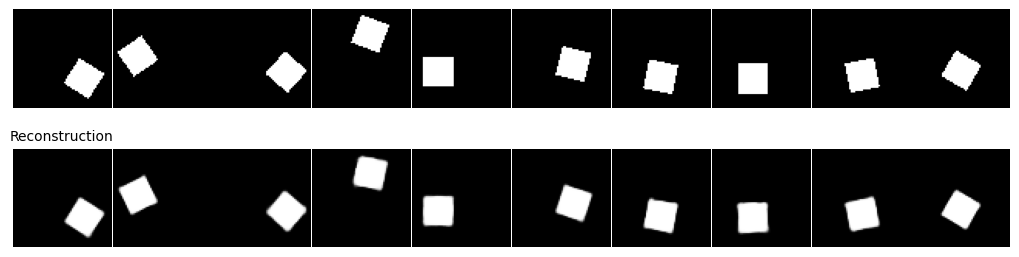

Plotting reconstructions from specific indices...


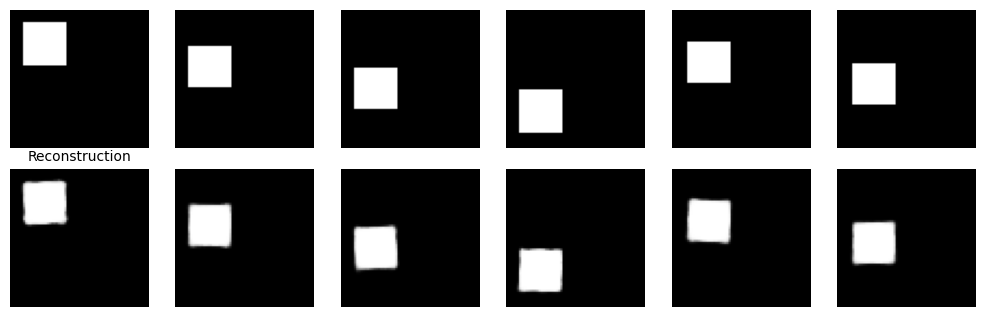

In [11]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 10, 20, 30, 40, 50]  # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

### Latent traversal

Plotting latent traversals...


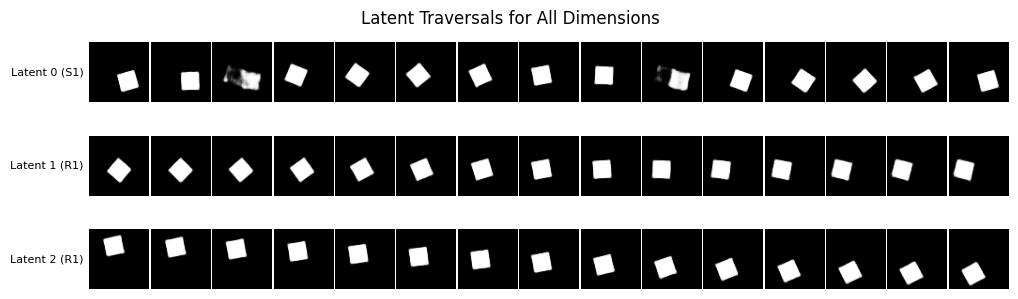

In [12]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1.0,
                                               use_ref_img=True
                                               )
plt.show()

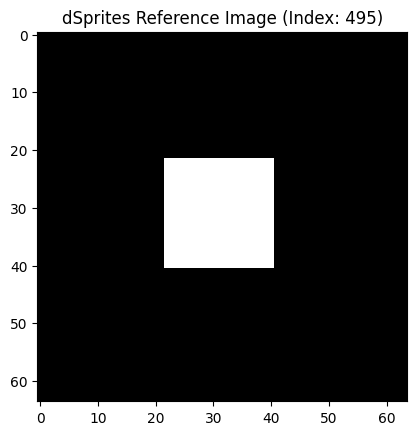

In [13]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 495  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()

Plotting single latent traversal for dimension 0...


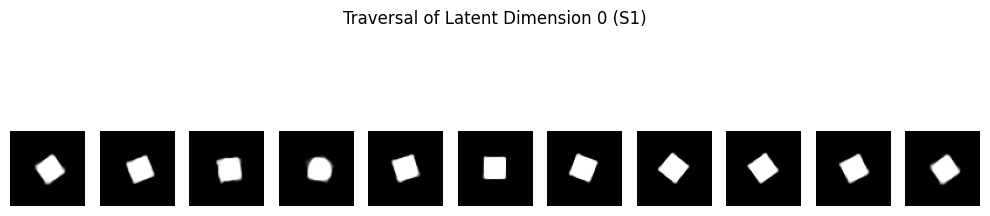

In [14]:
# Single latent traversal based on the reference image
latent_factor_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_factor_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_factor_idx_dsprites, 
                                                 ref_img=ref_img_dsprites, 
                                                 num_samples=11,
                                                 max_traversal_type='fraction',
                                                 max_traversal=1)
plt.show()

Plotting all latent traversals based on reference image...


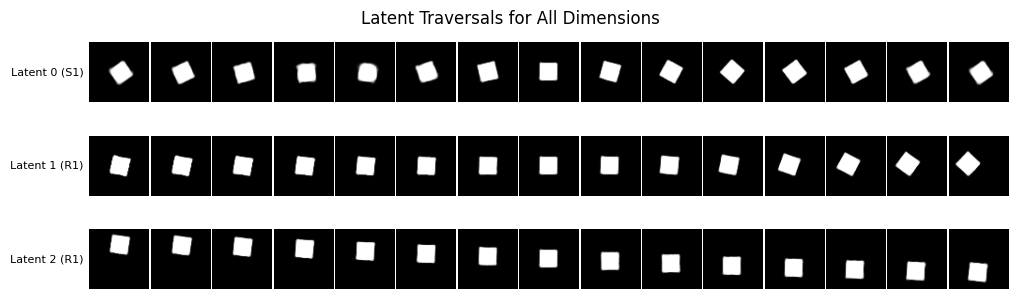

In [15]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, 
                                               num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1
                                               )